In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import metrics
from tensorflow.python import keras
import tensorflow as tf
import os
from imblearn.over_sampling import SMOTE
import math
from category_encoders import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as sk
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
df=pd.read_excel('../optimal_data3_1/'+'Continous_2weeks_5day_3term.xlsx')
df.head()
X=df.iloc[:,[1,3,4,5,6,7]]
y=df.iloc[:,-1]


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_resample(X_scaler,y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler.shape, y.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (19500, 6) (19500,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (50937, 6) (50937,)
SMOTE 적용 전 레이블 값 분포: 
 0    16979
1     1648
2      873
Name: 8, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    16979
1    16979
2    16979
Name: 8, dtype: int64


In [3]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)
skf.get_n_splits(X_train_over,y_train_over)

10

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()



    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 



# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [5]:
from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for data, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        data, lbl = data.to(device), lbl.to(device)
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(data)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * data.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [6]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [7]:
def model_test(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    pred_list=[]
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)
            
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            pred_array = pred.tolist()
            pred_list.append(pred_array) # confusion matrix를 위해 pred 리턴 값
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc, pred_list

In [8]:
# X_test=pd.DataFrame()
# X_train=pd.DataFrame()
# y_test=pd.DataFrame()
# y_train=pd.DataFrame()
# empty=pd.DataFrame()

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]

In [9]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]
CMResult=[[[0 for k in range(3)]for j in range(3)] for i in range(10)]
skf.get_n_splits(X_train_over,y_train_over)

10

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.68it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 1.10606. Saving Model!
epoch 01, loss: 1.16966, acc: 0.25819, val_loss: 1.10606, val_accuracy: 0.33333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


[INFO] val_acc has been improved from 1.10606 to 1.09016. Saving Model!
epoch 02, loss: 1.09792, acc: 0.33353, val_loss: 1.09016, val_accuracy: 0.33962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.28it/s]


[INFO] val_acc has been improved from 1.09016 to 1.08246. Saving Model!
epoch 03, loss: 1.08799, acc: 0.34507, val_loss: 1.08246, val_accuracy: 0.35532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.62it/s]


[INFO] val_acc has been improved from 1.08246 to 1.07872. Saving Model!
epoch 04, loss: 1.08475, acc: 0.36616, val_loss: 1.07872, val_accuracy: 0.39694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


[INFO] val_acc has been improved from 1.07872 to 1.07492. Saving Model!
epoch 05, loss: 1.08262, acc: 0.41066, val_loss: 1.07492, val_accuracy: 0.44464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


[INFO] val_acc has been improved from 1.07492 to 1.06992. Saving Model!
epoch 06, loss: 1.08000, acc: 0.45582, val_loss: 1.06992, val_accuracy: 0.42501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.47it/s]


[INFO] val_acc has been improved from 1.06992 to 1.06367. Saving Model!
epoch 07, loss: 1.07669, acc: 0.42785, val_loss: 1.06367, val_accuracy: 0.42756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.40it/s]


[INFO] val_acc has been improved from 1.06367 to 1.05652. Saving Model!
epoch 08, loss: 1.07269, acc: 0.41891, val_loss: 1.05652, val_accuracy: 0.43247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


[INFO] val_acc has been improved from 1.05652 to 1.04869. Saving Model!
epoch 09, loss: 1.06838, acc: 0.41904, val_loss: 1.04869, val_accuracy: 0.43600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.31it/s]


[INFO] val_acc has been improved from 1.04869 to 1.04059. Saving Model!
epoch 10, loss: 1.06404, acc: 0.41921, val_loss: 1.04059, val_accuracy: 0.43777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.31it/s]


[INFO] val_acc has been improved from 1.04059 to 1.03272. Saving Model!
epoch 11, loss: 1.05979, acc: 0.42135, val_loss: 1.03272, val_accuracy: 0.43914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 1.03272 to 1.02563. Saving Model!
epoch 12, loss: 1.05596, acc: 0.42408, val_loss: 1.02563, val_accuracy: 0.43934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


[INFO] val_acc has been improved from 1.02563 to 1.01960. Saving Model!
epoch 13, loss: 1.05268, acc: 0.42728, val_loss: 1.01960, val_accuracy: 0.44071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


[INFO] val_acc has been improved from 1.01960 to 1.01458. Saving Model!
epoch 14, loss: 1.04991, acc: 0.42960, val_loss: 1.01458, val_accuracy: 0.45583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


[INFO] val_acc has been improved from 1.01458 to 1.01061. Saving Model!
epoch 15, loss: 1.04752, acc: 0.43047, val_loss: 1.01061, val_accuracy: 0.45740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


[INFO] val_acc has been improved from 1.01061 to 1.00740. Saving Model!
epoch 16, loss: 1.04564, acc: 0.42997, val_loss: 1.00740, val_accuracy: 0.44719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


[INFO] val_acc has been improved from 1.00740 to 1.00468. Saving Model!
epoch 17, loss: 1.04419, acc: 0.43123, val_loss: 1.00468, val_accuracy: 0.44876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


[INFO] val_acc has been improved from 1.00468 to 1.00227. Saving Model!
epoch 18, loss: 1.04300, acc: 0.43163, val_loss: 1.00227, val_accuracy: 0.44876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


[INFO] val_acc has been improved from 1.00227 to 1.00003. Saving Model!
epoch 19, loss: 1.04189, acc: 0.43167, val_loss: 1.00003, val_accuracy: 0.46172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


[INFO] val_acc has been improved from 1.00003 to 0.99802. Saving Model!
epoch 20, loss: 1.04071, acc: 0.43193, val_loss: 0.99802, val_accuracy: 0.46192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


[INFO] val_acc has been improved from 0.99802 to 0.99621. Saving Model!
epoch 21, loss: 1.03950, acc: 0.43237, val_loss: 0.99621, val_accuracy: 0.46309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.99621 to 0.99454. Saving Model!
epoch 22, loss: 1.03823, acc: 0.43291, val_loss: 0.99454, val_accuracy: 0.46192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


[INFO] val_acc has been improved from 0.99454 to 0.99290. Saving Model!
epoch 23, loss: 1.03699, acc: 0.43215, val_loss: 0.99290, val_accuracy: 0.46250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.99290 to 0.99136. Saving Model!
epoch 24, loss: 1.03578, acc: 0.43300, val_loss: 0.99136, val_accuracy: 0.46270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


[INFO] val_acc has been improved from 0.99136 to 0.98985. Saving Model!
epoch 25, loss: 1.03455, acc: 0.43309, val_loss: 0.98985, val_accuracy: 0.46427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


[INFO] val_acc has been improved from 0.98985 to 0.98844. Saving Model!
epoch 26, loss: 1.03327, acc: 0.43287, val_loss: 0.98844, val_accuracy: 0.46466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.36it/s]


[INFO] val_acc has been improved from 0.98844 to 0.98705. Saving Model!
epoch 27, loss: 1.03197, acc: 0.43302, val_loss: 0.98705, val_accuracy: 0.46545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s]


[INFO] val_acc has been improved from 0.98705 to 0.98572. Saving Model!
epoch 28, loss: 1.03065, acc: 0.43224, val_loss: 0.98572, val_accuracy: 0.46702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


[INFO] val_acc has been improved from 0.98572 to 0.98428. Saving Model!
epoch 29, loss: 1.02932, acc: 0.43256, val_loss: 0.98428, val_accuracy: 0.46879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


[INFO] val_acc has been improved from 0.98428 to 0.98285. Saving Model!
epoch 30, loss: 1.02799, acc: 0.43095, val_loss: 0.98285, val_accuracy: 0.47291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


[INFO] val_acc has been improved from 0.98285 to 0.98152. Saving Model!
epoch 31, loss: 1.02662, acc: 0.43239, val_loss: 0.98152, val_accuracy: 0.47566


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


[INFO] val_acc has been improved from 0.98152 to 0.98024. Saving Model!
epoch 32, loss: 1.02535, acc: 0.43291, val_loss: 0.98024, val_accuracy: 0.48174


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


[INFO] val_acc has been improved from 0.98024 to 0.97878. Saving Model!
epoch 33, loss: 1.02409, acc: 0.43592, val_loss: 0.97878, val_accuracy: 0.48331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.72it/s]


[INFO] val_acc has been improved from 0.97878 to 0.97732. Saving Model!
epoch 34, loss: 1.02265, acc: 0.43952, val_loss: 0.97732, val_accuracy: 0.48508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


[INFO] val_acc has been improved from 0.97732 to 0.97595. Saving Model!
epoch 35, loss: 1.02142, acc: 0.44443, val_loss: 0.97595, val_accuracy: 0.48803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.53it/s]


[INFO] val_acc has been improved from 0.97595 to 0.97476. Saving Model!
epoch 36, loss: 1.01988, acc: 0.44537, val_loss: 0.97476, val_accuracy: 0.48783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


[INFO] val_acc has been improved from 0.97476 to 0.97341. Saving Model!
epoch 37, loss: 1.01838, acc: 0.44679, val_loss: 0.97341, val_accuracy: 0.48763


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


[INFO] val_acc has been improved from 0.97341 to 0.97213. Saving Model!
epoch 38, loss: 1.01698, acc: 0.44857, val_loss: 0.97213, val_accuracy: 0.50000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


[INFO] val_acc has been improved from 0.97213 to 0.97101. Saving Model!
epoch 39, loss: 1.01545, acc: 0.45076, val_loss: 0.97101, val_accuracy: 0.50020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


[INFO] val_acc has been improved from 0.97101 to 0.97000. Saving Model!
epoch 40, loss: 1.01391, acc: 0.45381, val_loss: 0.97000, val_accuracy: 0.50059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.97000 to 0.96902. Saving Model!
epoch 41, loss: 1.01243, acc: 0.45562, val_loss: 0.96902, val_accuracy: 0.49804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


[INFO] val_acc has been improved from 0.96902 to 0.96806. Saving Model!
epoch 42, loss: 1.01108, acc: 0.45793, val_loss: 0.96806, val_accuracy: 0.49784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.08it/s]


[INFO] val_acc has been improved from 0.96806 to 0.96720. Saving Model!
epoch 43, loss: 1.00968, acc: 0.45802, val_loss: 0.96720, val_accuracy: 0.50236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


[INFO] val_acc has been improved from 0.96720 to 0.96630. Saving Model!
epoch 44, loss: 1.00822, acc: 0.45782, val_loss: 0.96630, val_accuracy: 0.50334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


[INFO] val_acc has been improved from 0.96630 to 0.96556. Saving Model!
epoch 45, loss: 1.00694, acc: 0.45815, val_loss: 0.96556, val_accuracy: 0.50216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


[INFO] val_acc has been improved from 0.96556 to 0.96480. Saving Model!
epoch 46, loss: 1.00565, acc: 0.45802, val_loss: 0.96480, val_accuracy: 0.50098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


[INFO] val_acc has been improved from 0.96480 to 0.96421. Saving Model!
epoch 47, loss: 1.00421, acc: 0.45970, val_loss: 0.96421, val_accuracy: 0.48940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


[INFO] val_acc has been improved from 0.96421 to 0.96376. Saving Model!
epoch 48, loss: 1.00287, acc: 0.46099, val_loss: 0.96376, val_accuracy: 0.49077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


[INFO] val_acc has been improved from 0.96376 to 0.96330. Saving Model!
epoch 49, loss: 1.00153, acc: 0.46064, val_loss: 0.96330, val_accuracy: 0.49176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.96330 to 0.96287. Saving Model!
epoch 50, loss: 1.00013, acc: 0.46332, val_loss: 0.96287, val_accuracy: 0.49215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


[INFO] val_acc has been improved from 0.96287 to 0.96251. Saving Model!
epoch 51, loss: 0.99874, acc: 0.46271, val_loss: 0.96251, val_accuracy: 0.49215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


[INFO] val_acc has been improved from 0.96251 to 0.96225. Saving Model!
epoch 52, loss: 0.99727, acc: 0.46291, val_loss: 0.96225, val_accuracy: 0.49156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


[INFO] val_acc has been improved from 0.96225 to 0.96183. Saving Model!
epoch 53, loss: 0.99590, acc: 0.46413, val_loss: 0.96183, val_accuracy: 0.49058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


[INFO] val_acc has been improved from 0.96183 to 0.96137. Saving Model!
epoch 54, loss: 0.99454, acc: 0.46487, val_loss: 0.96137, val_accuracy: 0.49058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


[INFO] val_acc has been improved from 0.96137 to 0.96108. Saving Model!
epoch 55, loss: 0.99331, acc: 0.46511, val_loss: 0.96108, val_accuracy: 0.49176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


[INFO] val_acc has been improved from 0.96108 to 0.96090. Saving Model!
epoch 56, loss: 0.99198, acc: 0.46600, val_loss: 0.96090, val_accuracy: 0.49607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.96090 to 0.96075. Saving Model!
epoch 57, loss: 0.99039, acc: 0.46849, val_loss: 0.96075, val_accuracy: 0.49548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


[INFO] val_acc has been improved from 0.96075 to 0.96035. Saving Model!
epoch 58, loss: 0.98905, acc: 0.46960, val_loss: 0.96035, val_accuracy: 0.48410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


[INFO] val_acc has been improved from 0.96035 to 0.96019. Saving Model!
epoch 59, loss: 0.98769, acc: 0.47148, val_loss: 0.96019, val_accuracy: 0.48410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


[INFO] val_acc has been improved from 0.96019 to 0.96002. Saving Model!
epoch 60, loss: 0.98634, acc: 0.47296, val_loss: 0.96002, val_accuracy: 0.48469


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.96002 to 0.95970. Saving Model!
epoch 61, loss: 0.98509, acc: 0.47351, val_loss: 0.95970, val_accuracy: 0.48567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.95970 to 0.95943. Saving Model!
epoch 62, loss: 0.98378, acc: 0.47462, val_loss: 0.95943, val_accuracy: 0.48587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


[INFO] val_acc has been improved from 0.95943 to 0.95931. Saving Model!
epoch 63, loss: 0.98250, acc: 0.47493, val_loss: 0.95931, val_accuracy: 0.48547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 64, loss: 0.98133, acc: 0.47606, val_loss: 0.95935, val_accuracy: 0.48587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


[INFO] val_acc has been improved from 0.95931 to 0.95913. Saving Model!
epoch 65, loss: 0.98013, acc: 0.47750, val_loss: 0.95913, val_accuracy: 0.49411


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


[INFO] val_acc has been improved from 0.95913 to 0.95892. Saving Model!
epoch 66, loss: 0.97892, acc: 0.47756, val_loss: 0.95892, val_accuracy: 0.49411


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 67, loss: 0.97767, acc: 0.47759, val_loss: 0.95895, val_accuracy: 0.49431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 68, loss: 0.97656, acc: 0.47914, val_loss: 0.95899, val_accuracy: 0.49490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


[INFO] val_acc has been improved from 0.95892 to 0.95885. Saving Model!
epoch 69, loss: 0.97543, acc: 0.47920, val_loss: 0.95885, val_accuracy: 0.49509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


[INFO] val_acc has been improved from 0.95885 to 0.95871. Saving Model!
epoch 70, loss: 0.97429, acc: 0.47953, val_loss: 0.95871, val_accuracy: 0.49529


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


[INFO] val_acc has been improved from 0.95871 to 0.95869. Saving Model!
epoch 71, loss: 0.97304, acc: 0.48023, val_loss: 0.95869, val_accuracy: 0.49706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 72, loss: 0.97199, acc: 0.48036, val_loss: 0.95884, val_accuracy: 0.49823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 73, loss: 0.97091, acc: 0.48053, val_loss: 0.95884, val_accuracy: 0.49902


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 74, loss: 0.96977, acc: 0.48101, val_loss: 0.95884, val_accuracy: 0.50059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.50it/s]


[INFO] val_acc has been improved from 0.95869 to 0.95854. Saving Model!
epoch 75, loss: 0.96865, acc: 0.48184, val_loss: 0.95854, val_accuracy: 0.50177


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


epoch 76, loss: 0.96755, acc: 0.48367, val_loss: 0.95854, val_accuracy: 0.50255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 77, loss: 0.96638, acc: 0.48431, val_loss: 0.95861, val_accuracy: 0.50353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.86it/s]


epoch 78, loss: 0.96528, acc: 0.48446, val_loss: 0.95858, val_accuracy: 0.50432


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.13it/s]


[INFO] val_acc has been improved from 0.95854 to 0.95854. Saving Model!
epoch 79, loss: 0.96410, acc: 0.48485, val_loss: 0.95854, val_accuracy: 0.50550


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 80, loss: 0.96302, acc: 0.48505, val_loss: 0.95863, val_accuracy: 0.50707


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


epoch 81, loss: 0.96196, acc: 0.48679, val_loss: 0.95891, val_accuracy: 0.50805


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.11it/s]


epoch 82, loss: 0.96075, acc: 0.48771, val_loss: 0.95915, val_accuracy: 0.50864


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 83, loss: 0.95977, acc: 0.49030, val_loss: 0.95928, val_accuracy: 0.50942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


epoch 84, loss: 0.95869, acc: 0.49135, val_loss: 0.95938, val_accuracy: 0.50942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 85, loss: 0.95745, acc: 0.49242, val_loss: 0.95955, val_accuracy: 0.51080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 86, loss: 0.95651, acc: 0.49401, val_loss: 0.95960, val_accuracy: 0.50942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 87, loss: 0.95549, acc: 0.49622, val_loss: 0.95984, val_accuracy: 0.51080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 88, loss: 0.95436, acc: 0.49813, val_loss: 0.96001, val_accuracy: 0.51158


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.37it/s]


epoch 89, loss: 0.95327, acc: 0.50067, val_loss: 0.96020, val_accuracy: 0.51276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


epoch 90, loss: 0.95220, acc: 0.50265, val_loss: 0.96026, val_accuracy: 0.51276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 91, loss: 0.95108, acc: 0.50481, val_loss: 0.96062, val_accuracy: 0.51276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 92, loss: 0.95026, acc: 0.50577, val_loss: 0.96086, val_accuracy: 0.51256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.49it/s]


epoch 93, loss: 0.94911, acc: 0.50651, val_loss: 0.96109, val_accuracy: 0.51335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s]


epoch 94, loss: 0.94803, acc: 0.50786, val_loss: 0.96126, val_accuracy: 0.51433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.65it/s]


epoch 95, loss: 0.94701, acc: 0.50948, val_loss: 0.96177, val_accuracy: 0.51531


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 96, loss: 0.94613, acc: 0.50837, val_loss: 0.96196, val_accuracy: 0.51590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 97, loss: 0.94508, acc: 0.50895, val_loss: 0.96223, val_accuracy: 0.51570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 98, loss: 0.94385, acc: 0.51236, val_loss: 0.96277, val_accuracy: 0.51669


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


epoch 99, loss: 0.94301, acc: 0.51316, val_loss: 0.96297, val_accuracy: 0.51669


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.31it/s]


epoch 100, loss: 0.94198, acc: 0.51373, val_loss: 0.96313, val_accuracy: 0.51669


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 101, loss: 0.94075, acc: 0.51434, val_loss: 0.96372, val_accuracy: 0.51728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


epoch 102, loss: 0.93977, acc: 0.51506, val_loss: 0.96391, val_accuracy: 0.51786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.18it/s]


epoch 103, loss: 0.93876, acc: 0.51556, val_loss: 0.96416, val_accuracy: 0.52002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 104, loss: 0.93767, acc: 0.51705, val_loss: 0.96425, val_accuracy: 0.52061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.36it/s]


epoch 105, loss: 0.93648, acc: 0.51779, val_loss: 0.96475, val_accuracy: 0.52042


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.31it/s]


epoch 106, loss: 0.93545, acc: 0.51842, val_loss: 0.96525, val_accuracy: 0.52081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 107, loss: 0.93466, acc: 0.51788, val_loss: 0.96549, val_accuracy: 0.52101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 108, loss: 0.93345, acc: 0.51962, val_loss: 0.96628, val_accuracy: 0.52258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 109, loss: 0.93236, acc: 0.52150, val_loss: 0.96674, val_accuracy: 0.52395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 110, loss: 0.93151, acc: 0.52180, val_loss: 0.96708, val_accuracy: 0.52513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 111, loss: 0.93041, acc: 0.52217, val_loss: 0.96772, val_accuracy: 0.52611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 112, loss: 0.92926, acc: 0.52113, val_loss: 0.96864, val_accuracy: 0.52748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 113, loss: 0.92829, acc: 0.52182, val_loss: 0.96943, val_accuracy: 0.52729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.28it/s]


epoch 114, loss: 0.92760, acc: 0.52213, val_loss: 0.96989, val_accuracy: 0.52689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


epoch 115, loss: 0.92636, acc: 0.52276, val_loss: 0.97033, val_accuracy: 0.52768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 116, loss: 0.92521, acc: 0.52268, val_loss: 0.97089, val_accuracy: 0.52748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.71it/s]


epoch 117, loss: 0.92421, acc: 0.52322, val_loss: 0.97139, val_accuracy: 0.52866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 118, loss: 0.92330, acc: 0.52473, val_loss: 0.97229, val_accuracy: 0.52807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 119, loss: 0.92231, acc: 0.52523, val_loss: 0.97319, val_accuracy: 0.53082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 120, loss: 0.92131, acc: 0.52527, val_loss: 0.97372, val_accuracy: 0.53121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s]


epoch 121, loss: 0.92036, acc: 0.52656, val_loss: 0.97404, val_accuracy: 0.53141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 122, loss: 0.91939, acc: 0.52730, val_loss: 0.97464, val_accuracy: 0.53121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 123, loss: 0.91828, acc: 0.52758, val_loss: 0.97538, val_accuracy: 0.53141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


epoch 124, loss: 0.91752, acc: 0.52802, val_loss: 0.97581, val_accuracy: 0.53219


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 125, loss: 0.91655, acc: 0.52852, val_loss: 0.97606, val_accuracy: 0.53318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.37it/s]


epoch 126, loss: 0.91540, acc: 0.52959, val_loss: 0.97671, val_accuracy: 0.53337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 127, loss: 0.91442, acc: 0.53062, val_loss: 0.97755, val_accuracy: 0.53416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 128, loss: 0.91373, acc: 0.53144, val_loss: 0.97760, val_accuracy: 0.53494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05it/s]


epoch 129, loss: 0.91255, acc: 0.53365, val_loss: 0.97822, val_accuracy: 0.53573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.41it/s]


epoch 130, loss: 0.91153, acc: 0.53378, val_loss: 0.97914, val_accuracy: 0.53632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 131, loss: 0.91067, acc: 0.53459, val_loss: 0.97977, val_accuracy: 0.53161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


epoch 132, loss: 0.90976, acc: 0.53452, val_loss: 0.98063, val_accuracy: 0.53259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 133, loss: 0.90886, acc: 0.53548, val_loss: 0.98132, val_accuracy: 0.53337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 134, loss: 0.90792, acc: 0.53644, val_loss: 0.98173, val_accuracy: 0.53337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 135, loss: 0.90693, acc: 0.53773, val_loss: 0.98213, val_accuracy: 0.53592


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


epoch 136, loss: 0.90598, acc: 0.53849, val_loss: 0.98313, val_accuracy: 0.53671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 137, loss: 0.90505, acc: 0.53919, val_loss: 0.98345, val_accuracy: 0.53730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


epoch 138, loss: 0.90422, acc: 0.53947, val_loss: 0.98358, val_accuracy: 0.53867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 139, loss: 0.90333, acc: 0.54089, val_loss: 0.98425, val_accuracy: 0.53926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 140, loss: 0.90233, acc: 0.54115, val_loss: 0.98486, val_accuracy: 0.54005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 141, loss: 0.90127, acc: 0.54148, val_loss: 0.98578, val_accuracy: 0.54064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


epoch 142, loss: 0.90043, acc: 0.54189, val_loss: 0.98602, val_accuracy: 0.54064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 143, loss: 0.89967, acc: 0.54242, val_loss: 0.98565, val_accuracy: 0.54122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.76it/s]


epoch 144, loss: 0.89848, acc: 0.54355, val_loss: 0.98629, val_accuracy: 0.54142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 145, loss: 0.89736, acc: 0.54464, val_loss: 0.98730, val_accuracy: 0.54162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 146, loss: 0.89671, acc: 0.54445, val_loss: 0.98785, val_accuracy: 0.54221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


epoch 147, loss: 0.89573, acc: 0.54501, val_loss: 0.98832, val_accuracy: 0.54338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 148, loss: 0.89480, acc: 0.54588, val_loss: 0.98883, val_accuracy: 0.54358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 149, loss: 0.89400, acc: 0.54584, val_loss: 0.98935, val_accuracy: 0.54397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 150, loss: 0.89280, acc: 0.54684, val_loss: 0.99022, val_accuracy: 0.54554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 151, loss: 0.89181, acc: 0.54737, val_loss: 0.99093, val_accuracy: 0.54653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 152, loss: 0.89094, acc: 0.54772, val_loss: 0.99104, val_accuracy: 0.54653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 153, loss: 0.89024, acc: 0.54724, val_loss: 0.99181, val_accuracy: 0.54672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 154, loss: 0.88922, acc: 0.54892, val_loss: 0.99221, val_accuracy: 0.54711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 155, loss: 0.88837, acc: 0.54968, val_loss: 0.99249, val_accuracy: 0.54594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 156, loss: 0.88731, acc: 0.55066, val_loss: 0.99317, val_accuracy: 0.54672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 157, loss: 0.88658, acc: 0.55138, val_loss: 0.99314, val_accuracy: 0.54672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 158, loss: 0.88560, acc: 0.55230, val_loss: 0.99341, val_accuracy: 0.54790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 159, loss: 0.88460, acc: 0.55297, val_loss: 0.99424, val_accuracy: 0.54711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 160, loss: 0.88396, acc: 0.55385, val_loss: 0.99427, val_accuracy: 0.54770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 161, loss: 0.88301, acc: 0.55413, val_loss: 0.99445, val_accuracy: 0.54927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 162, loss: 0.88193, acc: 0.55459, val_loss: 0.99487, val_accuracy: 0.55065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 163, loss: 0.88136, acc: 0.55533, val_loss: 0.99459, val_accuracy: 0.55065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 164, loss: 0.88036, acc: 0.55592, val_loss: 0.99485, val_accuracy: 0.55143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


epoch 165, loss: 0.87955, acc: 0.55705, val_loss: 0.99519, val_accuracy: 0.55104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.84it/s]


epoch 166, loss: 0.87847, acc: 0.55718, val_loss: 0.99518, val_accuracy: 0.55183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 167, loss: 0.87782, acc: 0.55786, val_loss: 0.99561, val_accuracy: 0.55183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.31it/s]


epoch 168, loss: 0.87714, acc: 0.55934, val_loss: 0.99521, val_accuracy: 0.55183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


epoch 169, loss: 0.87583, acc: 0.56063, val_loss: 0.99572, val_accuracy: 0.55300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 170, loss: 0.87524, acc: 0.56094, val_loss: 0.99604, val_accuracy: 0.55261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


epoch 171, loss: 0.87438, acc: 0.56148, val_loss: 0.99580, val_accuracy: 0.55320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.11it/s]


epoch 172, loss: 0.87334, acc: 0.56225, val_loss: 0.99620, val_accuracy: 0.55418


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 173, loss: 0.87269, acc: 0.56286, val_loss: 0.99613, val_accuracy: 0.55457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 174, loss: 0.87169, acc: 0.56406, val_loss: 0.99633, val_accuracy: 0.55045


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 175, loss: 0.87067, acc: 0.56491, val_loss: 0.99718, val_accuracy: 0.55143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 176, loss: 0.87014, acc: 0.56521, val_loss: 0.99687, val_accuracy: 0.55163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.12it/s]


epoch 177, loss: 0.86934, acc: 0.56591, val_loss: 0.99704, val_accuracy: 0.55241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05it/s]


epoch 178, loss: 0.86824, acc: 0.56635, val_loss: 0.99788, val_accuracy: 0.55281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 179, loss: 0.86739, acc: 0.56696, val_loss: 0.99855, val_accuracy: 0.55379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.10it/s]


epoch 180, loss: 0.86686, acc: 0.56750, val_loss: 0.99834, val_accuracy: 0.55575


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 181, loss: 0.86595, acc: 0.56827, val_loss: 0.99851, val_accuracy: 0.55575


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 182, loss: 0.86497, acc: 0.56973, val_loss: 0.99898, val_accuracy: 0.55673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.12it/s]


epoch 183, loss: 0.86426, acc: 0.57038, val_loss: 0.99889, val_accuracy: 0.55732


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 184, loss: 0.86341, acc: 0.57152, val_loss: 0.99933, val_accuracy: 0.55791


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 185, loss: 0.86254, acc: 0.57276, val_loss: 0.99886, val_accuracy: 0.55850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 186, loss: 0.86183, acc: 0.57291, val_loss: 0.99873, val_accuracy: 0.55870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 187, loss: 0.86100, acc: 0.57359, val_loss: 0.99883, val_accuracy: 0.55850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 188, loss: 0.86009, acc: 0.57549, val_loss: 0.99856, val_accuracy: 0.55909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 189, loss: 0.85941, acc: 0.57614, val_loss: 0.99823, val_accuracy: 0.55987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.22it/s]


epoch 190, loss: 0.85865, acc: 0.57760, val_loss: 0.99834, val_accuracy: 0.56007


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 191, loss: 0.85767, acc: 0.57828, val_loss: 0.99865, val_accuracy: 0.56007


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.27it/s]


epoch 192, loss: 0.85707, acc: 0.57795, val_loss: 0.99812, val_accuracy: 0.55968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.44it/s]


epoch 193, loss: 0.85619, acc: 0.57906, val_loss: 0.99843, val_accuracy: 0.56105


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 194, loss: 0.85528, acc: 0.58002, val_loss: 0.99818, val_accuracy: 0.56086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.78it/s]


epoch 195, loss: 0.85477, acc: 0.58111, val_loss: 0.99780, val_accuracy: 0.56125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


epoch 196, loss: 0.85360, acc: 0.58205, val_loss: 0.99830, val_accuracy: 0.56144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 197, loss: 0.85311, acc: 0.58212, val_loss: 0.99799, val_accuracy: 0.56125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


epoch 198, loss: 0.85218, acc: 0.58347, val_loss: 0.99821, val_accuracy: 0.56184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 199, loss: 0.85157, acc: 0.58445, val_loss: 0.99778, val_accuracy: 0.56302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 200, loss: 0.85085, acc: 0.58589, val_loss: 0.99763, val_accuracy: 0.56243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 201, loss: 0.84970, acc: 0.58692, val_loss: 0.99783, val_accuracy: 0.56360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 202, loss: 0.84926, acc: 0.58572, val_loss: 0.99731, val_accuracy: 0.56400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 203, loss: 0.84874, acc: 0.58554, val_loss: 0.99707, val_accuracy: 0.56380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 204, loss: 0.84759, acc: 0.58609, val_loss: 0.99630, val_accuracy: 0.56459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 205, loss: 0.84680, acc: 0.58646, val_loss: 0.99664, val_accuracy: 0.56478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 206, loss: 0.84638, acc: 0.58681, val_loss: 0.99615, val_accuracy: 0.56400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 207, loss: 0.84561, acc: 0.58729, val_loss: 0.99546, val_accuracy: 0.56478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 208, loss: 0.84443, acc: 0.58792, val_loss: 0.99580, val_accuracy: 0.56478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 209, loss: 0.84398, acc: 0.58814, val_loss: 0.99567, val_accuracy: 0.56517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 210, loss: 0.84330, acc: 0.58809, val_loss: 0.99522, val_accuracy: 0.56557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 211, loss: 0.84258, acc: 0.58855, val_loss: 0.99461, val_accuracy: 0.56557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 212, loss: 0.84178, acc: 0.58977, val_loss: 0.99498, val_accuracy: 0.56635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 213, loss: 0.84104, acc: 0.59041, val_loss: 0.99449, val_accuracy: 0.56635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 214, loss: 0.84033, acc: 0.59056, val_loss: 0.99415, val_accuracy: 0.56184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 215, loss: 0.83960, acc: 0.59095, val_loss: 0.99373, val_accuracy: 0.56812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 216, loss: 0.83884, acc: 0.59126, val_loss: 0.99375, val_accuracy: 0.56890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 217, loss: 0.83824, acc: 0.59154, val_loss: 0.99386, val_accuracy: 0.56871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 218, loss: 0.83741, acc: 0.59215, val_loss: 0.99348, val_accuracy: 0.56969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.34it/s]


epoch 219, loss: 0.83686, acc: 0.59237, val_loss: 0.99360, val_accuracy: 0.57048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 220, loss: 0.83584, acc: 0.59287, val_loss: 0.99359, val_accuracy: 0.57048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 221, loss: 0.83555, acc: 0.59289, val_loss: 0.99269, val_accuracy: 0.57008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.36it/s]


epoch 222, loss: 0.83472, acc: 0.59344, val_loss: 0.99296, val_accuracy: 0.57067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.31it/s]


epoch 223, loss: 0.83390, acc: 0.59355, val_loss: 0.99296, val_accuracy: 0.57067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 224, loss: 0.83344, acc: 0.59372, val_loss: 0.99305, val_accuracy: 0.57067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 225, loss: 0.83256, acc: 0.59418, val_loss: 0.99301, val_accuracy: 0.56576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


epoch 226, loss: 0.83185, acc: 0.59431, val_loss: 0.99263, val_accuracy: 0.56459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 227, loss: 0.83135, acc: 0.59431, val_loss: 0.99168, val_accuracy: 0.56498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 228, loss: 0.83037, acc: 0.59462, val_loss: 0.99227, val_accuracy: 0.56517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 229, loss: 0.82980, acc: 0.59453, val_loss: 0.99254, val_accuracy: 0.56478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 230, loss: 0.82917, acc: 0.59466, val_loss: 0.99215, val_accuracy: 0.56498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.75it/s]


epoch 231, loss: 0.82861, acc: 0.59473, val_loss: 0.99162, val_accuracy: 0.56498


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.53it/s]


epoch 232, loss: 0.82773, acc: 0.59486, val_loss: 0.99222, val_accuracy: 0.56517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 233, loss: 0.82705, acc: 0.59551, val_loss: 0.99205, val_accuracy: 0.56576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.81it/s]


epoch 234, loss: 0.82645, acc: 0.59586, val_loss: 0.99184, val_accuracy: 0.56576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 235, loss: 0.82588, acc: 0.59702, val_loss: 0.99204, val_accuracy: 0.56635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 236, loss: 0.82496, acc: 0.59743, val_loss: 0.99253, val_accuracy: 0.56675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


epoch 237, loss: 0.82462, acc: 0.59736, val_loss: 0.99259, val_accuracy: 0.56616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.23it/s]


epoch 238, loss: 0.82371, acc: 0.59767, val_loss: 0.99245, val_accuracy: 0.56616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.58it/s]


epoch 239, loss: 0.82329, acc: 0.59822, val_loss: 0.99301, val_accuracy: 0.56655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


epoch 240, loss: 0.82263, acc: 0.59889, val_loss: 0.99313, val_accuracy: 0.56675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


epoch 241, loss: 0.82181, acc: 0.59950, val_loss: 0.99342, val_accuracy: 0.56655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 242, loss: 0.82131, acc: 0.59959, val_loss: 0.99291, val_accuracy: 0.56655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 243, loss: 0.82065, acc: 0.59959, val_loss: 0.99289, val_accuracy: 0.56596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 244, loss: 0.81986, acc: 0.59983, val_loss: 0.99343, val_accuracy: 0.56635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 245, loss: 0.81951, acc: 0.59981, val_loss: 0.99347, val_accuracy: 0.56596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 246, loss: 0.81885, acc: 0.60000, val_loss: 0.99314, val_accuracy: 0.56655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 247, loss: 0.81806, acc: 0.60014, val_loss: 0.99319, val_accuracy: 0.56714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


epoch 248, loss: 0.81756, acc: 0.60038, val_loss: 0.99372, val_accuracy: 0.56675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


epoch 249, loss: 0.81687, acc: 0.60120, val_loss: 0.99362, val_accuracy: 0.56675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


epoch 250, loss: 0.81627, acc: 0.60131, val_loss: 0.99339, val_accuracy: 0.56635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 251, loss: 0.81568, acc: 0.60162, val_loss: 0.99390, val_accuracy: 0.56635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


epoch 252, loss: 0.81491, acc: 0.60321, val_loss: 0.99389, val_accuracy: 0.56576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 253, loss: 0.81483, acc: 0.60214, val_loss: 0.99312, val_accuracy: 0.57205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 254, loss: 0.81371, acc: 0.60369, val_loss: 0.99319, val_accuracy: 0.57263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 255, loss: 0.81308, acc: 0.60411, val_loss: 0.99333, val_accuracy: 0.57695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 256, loss: 0.81304, acc: 0.60317, val_loss: 0.99310, val_accuracy: 0.57205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 257, loss: 0.81192, acc: 0.60465, val_loss: 0.99320, val_accuracy: 0.57165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


epoch 258, loss: 0.81128, acc: 0.60498, val_loss: 0.99390, val_accuracy: 0.57617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 259, loss: 0.81106, acc: 0.60408, val_loss: 0.99333, val_accuracy: 0.57636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 260, loss: 0.81025, acc: 0.60544, val_loss: 0.99333, val_accuracy: 0.57636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.74it/s]


epoch 261, loss: 0.80972, acc: 0.60568, val_loss: 0.99311, val_accuracy: 0.57656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.30it/s]


epoch 262, loss: 0.80909, acc: 0.60483, val_loss: 0.99345, val_accuracy: 0.57695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 263, loss: 0.80836, acc: 0.60526, val_loss: 0.99366, val_accuracy: 0.57636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.28it/s]


epoch 264, loss: 0.80811, acc: 0.60561, val_loss: 0.99329, val_accuracy: 0.57656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.59it/s]


epoch 265, loss: 0.80742, acc: 0.60596, val_loss: 0.99305, val_accuracy: 0.57754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 266, loss: 0.80650, acc: 0.60633, val_loss: 0.99301, val_accuracy: 0.57813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


epoch 267, loss: 0.80641, acc: 0.60661, val_loss: 0.99375, val_accuracy: 0.57715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


epoch 268, loss: 0.80567, acc: 0.60679, val_loss: 0.99393, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 269, loss: 0.80505, acc: 0.60722, val_loss: 0.99340, val_accuracy: 0.57754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 270, loss: 0.80433, acc: 0.60877, val_loss: 0.99373, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 271, loss: 0.80412, acc: 0.60899, val_loss: 0.99349, val_accuracy: 0.57833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 272, loss: 0.80321, acc: 0.60941, val_loss: 0.99320, val_accuracy: 0.57911


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 273, loss: 0.80287, acc: 0.60928, val_loss: 0.99273, val_accuracy: 0.57951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 274, loss: 0.80219, acc: 0.60986, val_loss: 0.99313, val_accuracy: 0.58108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 275, loss: 0.80170, acc: 0.61043, val_loss: 0.99330, val_accuracy: 0.58186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 276, loss: 0.80103, acc: 0.61015, val_loss: 0.99265, val_accuracy: 0.58186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 277, loss: 0.80034, acc: 0.61078, val_loss: 0.99303, val_accuracy: 0.58265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 278, loss: 0.80020, acc: 0.61047, val_loss: 0.99317, val_accuracy: 0.58363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 279, loss: 0.79946, acc: 0.61078, val_loss: 0.99270, val_accuracy: 0.58382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 280, loss: 0.79871, acc: 0.61104, val_loss: 0.99252, val_accuracy: 0.58461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 281, loss: 0.79855, acc: 0.61106, val_loss: 0.99235, val_accuracy: 0.58559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 282, loss: 0.79767, acc: 0.61135, val_loss: 0.99234, val_accuracy: 0.58618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 283, loss: 0.79722, acc: 0.61124, val_loss: 0.99165, val_accuracy: 0.58598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 284, loss: 0.79680, acc: 0.61194, val_loss: 0.99140, val_accuracy: 0.58638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 285, loss: 0.79618, acc: 0.61248, val_loss: 0.99190, val_accuracy: 0.58598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 286, loss: 0.79555, acc: 0.61370, val_loss: 0.99209, val_accuracy: 0.58657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 287, loss: 0.79515, acc: 0.61333, val_loss: 0.99170, val_accuracy: 0.58736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 288, loss: 0.79465, acc: 0.61353, val_loss: 0.99133, val_accuracy: 0.58716


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 289, loss: 0.79382, acc: 0.61425, val_loss: 0.99172, val_accuracy: 0.58775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 290, loss: 0.79367, acc: 0.61421, val_loss: 0.99134, val_accuracy: 0.58834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.31it/s]


epoch 291, loss: 0.79304, acc: 0.61444, val_loss: 0.99149, val_accuracy: 0.58814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.28it/s]


epoch 292, loss: 0.79226, acc: 0.61551, val_loss: 0.99196, val_accuracy: 0.58775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 293, loss: 0.79194, acc: 0.61584, val_loss: 0.99211, val_accuracy: 0.58912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 294, loss: 0.79148, acc: 0.61612, val_loss: 0.99193, val_accuracy: 0.58834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 295, loss: 0.79084, acc: 0.61767, val_loss: 0.99151, val_accuracy: 0.58873


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 296, loss: 0.79032, acc: 0.61874, val_loss: 0.99182, val_accuracy: 0.58952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 297, loss: 0.78960, acc: 0.61794, val_loss: 0.99213, val_accuracy: 0.58991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 298, loss: 0.78935, acc: 0.61955, val_loss: 0.99200, val_accuracy: 0.58952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 299, loss: 0.78883, acc: 0.61918, val_loss: 0.99227, val_accuracy: 0.59050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 300, loss: 0.78803, acc: 0.61931, val_loss: 0.99243, val_accuracy: 0.59069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 301, loss: 0.78773, acc: 0.61966, val_loss: 0.99257, val_accuracy: 0.59030


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 302, loss: 0.78761, acc: 0.61981, val_loss: 0.99205, val_accuracy: 0.59089


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 303, loss: 0.78638, acc: 0.62031, val_loss: 0.99215, val_accuracy: 0.59168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 304, loss: 0.78607, acc: 0.62033, val_loss: 0.99280, val_accuracy: 0.59128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 305, loss: 0.78580, acc: 0.62049, val_loss: 0.99267, val_accuracy: 0.59168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 306, loss: 0.78525, acc: 0.62047, val_loss: 0.99201, val_accuracy: 0.59148


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 307, loss: 0.78449, acc: 0.62123, val_loss: 0.99212, val_accuracy: 0.59207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 308, loss: 0.78425, acc: 0.62140, val_loss: 0.99212, val_accuracy: 0.59227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 309, loss: 0.78336, acc: 0.62156, val_loss: 0.99221, val_accuracy: 0.59207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 310, loss: 0.78335, acc: 0.62195, val_loss: 0.99161, val_accuracy: 0.59325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 311, loss: 0.78278, acc: 0.62215, val_loss: 0.99127, val_accuracy: 0.59344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 312, loss: 0.78172, acc: 0.62273, val_loss: 0.99124, val_accuracy: 0.59403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 313, loss: 0.78181, acc: 0.62284, val_loss: 0.99073, val_accuracy: 0.59442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 314, loss: 0.78127, acc: 0.62317, val_loss: 0.99049, val_accuracy: 0.59384


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


epoch 315, loss: 0.78047, acc: 0.62363, val_loss: 0.99009, val_accuracy: 0.59384


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.24it/s]


epoch 316, loss: 0.77996, acc: 0.62385, val_loss: 0.99051, val_accuracy: 0.59384


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 317, loss: 0.77980, acc: 0.62411, val_loss: 0.99062, val_accuracy: 0.59442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


epoch 318, loss: 0.77920, acc: 0.62428, val_loss: 0.99038, val_accuracy: 0.59423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.46it/s]


epoch 319, loss: 0.77834, acc: 0.62459, val_loss: 0.99070, val_accuracy: 0.59462


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 320, loss: 0.77828, acc: 0.62465, val_loss: 0.99079, val_accuracy: 0.59521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.44it/s]


epoch 321, loss: 0.77766, acc: 0.62457, val_loss: 0.99055, val_accuracy: 0.59501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.26it/s]


epoch 322, loss: 0.77689, acc: 0.62529, val_loss: 0.99104, val_accuracy: 0.59521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 323, loss: 0.77647, acc: 0.62574, val_loss: 0.99096, val_accuracy: 0.59580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 324, loss: 0.77616, acc: 0.62531, val_loss: 0.99085, val_accuracy: 0.59639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 325, loss: 0.77548, acc: 0.62583, val_loss: 0.99115, val_accuracy: 0.59658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 326, loss: 0.77528, acc: 0.62612, val_loss: 0.99100, val_accuracy: 0.59639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


epoch 327, loss: 0.77439, acc: 0.62651, val_loss: 0.99151, val_accuracy: 0.59698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.59it/s]


epoch 328, loss: 0.77392, acc: 0.62644, val_loss: 0.99167, val_accuracy: 0.59815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


epoch 329, loss: 0.77393, acc: 0.62723, val_loss: 0.99130, val_accuracy: 0.59796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.53it/s]


epoch 330, loss: 0.77270, acc: 0.62742, val_loss: 0.99115, val_accuracy: 0.59796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.66it/s]


epoch 331, loss: 0.77253, acc: 0.62854, val_loss: 0.99088, val_accuracy: 0.59855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 332, loss: 0.77215, acc: 0.62893, val_loss: 0.99097, val_accuracy: 0.59796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


epoch 333, loss: 0.77127, acc: 0.62917, val_loss: 0.99154, val_accuracy: 0.59757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.47it/s]


epoch 334, loss: 0.77096, acc: 0.62967, val_loss: 0.99211, val_accuracy: 0.59796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 335, loss: 0.77062, acc: 0.62971, val_loss: 0.99204, val_accuracy: 0.59796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 336, loss: 0.76992, acc: 0.62995, val_loss: 0.99232, val_accuracy: 0.59776


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 337, loss: 0.76966, acc: 0.62991, val_loss: 0.99275, val_accuracy: 0.59796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 338, loss: 0.76899, acc: 0.63026, val_loss: 0.99341, val_accuracy: 0.59835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


epoch 339, loss: 0.76850, acc: 0.63043, val_loss: 0.99510, val_accuracy: 0.59815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 340, loss: 0.76801, acc: 0.63070, val_loss: 0.99482, val_accuracy: 0.59894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 341, loss: 0.76767, acc: 0.63100, val_loss: 0.99551, val_accuracy: 0.59855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 342, loss: 0.76694, acc: 0.63115, val_loss: 0.99744, val_accuracy: 0.59953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 343, loss: 0.76663, acc: 0.63238, val_loss: 0.99737, val_accuracy: 0.60031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 344, loss: 0.76604, acc: 0.63266, val_loss: 0.99777, val_accuracy: 0.60012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 345, loss: 0.76574, acc: 0.63307, val_loss: 0.99992, val_accuracy: 0.60012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 346, loss: 0.76478, acc: 0.63353, val_loss: 1.00132, val_accuracy: 0.60090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 347, loss: 0.76470, acc: 0.63406, val_loss: 1.00218, val_accuracy: 0.60130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 348, loss: 0.76414, acc: 0.63414, val_loss: 1.00372, val_accuracy: 0.60149


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 349, loss: 0.76372, acc: 0.63423, val_loss: 1.00473, val_accuracy: 0.60208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 350, loss: 0.76296, acc: 0.63502, val_loss: 1.00577, val_accuracy: 0.60208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 351, loss: 0.76299, acc: 0.63539, val_loss: 1.00644, val_accuracy: 0.60326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 352, loss: 0.76220, acc: 0.63543, val_loss: 1.00865, val_accuracy: 0.60306


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 353, loss: 0.76167, acc: 0.63689, val_loss: 1.00889, val_accuracy: 0.60326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 354, loss: 0.76124, acc: 0.63628, val_loss: 1.01003, val_accuracy: 0.60365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 355, loss: 0.76093, acc: 0.63621, val_loss: 1.01235, val_accuracy: 0.60404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 356, loss: 0.76028, acc: 0.63637, val_loss: 1.01348, val_accuracy: 0.60346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 357, loss: 0.75978, acc: 0.63744, val_loss: 1.01374, val_accuracy: 0.60346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 358, loss: 0.75932, acc: 0.63879, val_loss: 1.01576, val_accuracy: 0.60404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 359, loss: 0.75888, acc: 0.63683, val_loss: 1.01657, val_accuracy: 0.60385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 360, loss: 0.75816, acc: 0.63715, val_loss: 1.01779, val_accuracy: 0.60503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 361, loss: 0.75788, acc: 0.63728, val_loss: 1.01986, val_accuracy: 0.60503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 362, loss: 0.75741, acc: 0.63744, val_loss: 1.02094, val_accuracy: 0.60542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 363, loss: 0.75679, acc: 0.63798, val_loss: 1.02223, val_accuracy: 0.60581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


epoch 364, loss: 0.75659, acc: 0.63809, val_loss: 1.02249, val_accuracy: 0.60542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 365, loss: 0.75580, acc: 0.63964, val_loss: 1.02468, val_accuracy: 0.60620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.56it/s]


epoch 366, loss: 0.75546, acc: 0.63848, val_loss: 1.02514, val_accuracy: 0.60542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.59it/s]


epoch 367, loss: 0.75512, acc: 0.63960, val_loss: 1.02634, val_accuracy: 0.60561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 368, loss: 0.75429, acc: 0.64045, val_loss: 1.02648, val_accuracy: 0.60581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.53it/s]


epoch 369, loss: 0.75401, acc: 0.63933, val_loss: 1.02856, val_accuracy: 0.60581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


epoch 370, loss: 0.75356, acc: 0.63955, val_loss: 1.02997, val_accuracy: 0.60601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 371, loss: 0.75308, acc: 0.64114, val_loss: 1.03001, val_accuracy: 0.60699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.26it/s]


epoch 372, loss: 0.75252, acc: 0.64001, val_loss: 1.03171, val_accuracy: 0.60718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


epoch 373, loss: 0.75230, acc: 0.64099, val_loss: 1.03305, val_accuracy: 0.60679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 374, loss: 0.75129, acc: 0.64265, val_loss: 1.03335, val_accuracy: 0.60817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 375, loss: 0.75114, acc: 0.64171, val_loss: 1.03441, val_accuracy: 0.60817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


epoch 376, loss: 0.75070, acc: 0.64189, val_loss: 1.03624, val_accuracy: 0.60856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 377, loss: 0.75011, acc: 0.64224, val_loss: 1.03695, val_accuracy: 0.60483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.50it/s]


epoch 378, loss: 0.74951, acc: 0.64346, val_loss: 1.03855, val_accuracy: 0.60503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 379, loss: 0.74932, acc: 0.64265, val_loss: 1.03996, val_accuracy: 0.60483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 380, loss: 0.74856, acc: 0.64274, val_loss: 1.04007, val_accuracy: 0.60522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


epoch 381, loss: 0.74824, acc: 0.64333, val_loss: 1.04230, val_accuracy: 0.60542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


epoch 382, loss: 0.74760, acc: 0.64348, val_loss: 1.04364, val_accuracy: 0.60542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 383, loss: 0.74740, acc: 0.64487, val_loss: 1.04351, val_accuracy: 0.60581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 384, loss: 0.74654, acc: 0.64374, val_loss: 1.04495, val_accuracy: 0.60542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


epoch 385, loss: 0.74625, acc: 0.64527, val_loss: 1.04631, val_accuracy: 0.60561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 386, loss: 0.74572, acc: 0.64549, val_loss: 1.04722, val_accuracy: 0.60640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.22it/s]


epoch 387, loss: 0.74529, acc: 0.64455, val_loss: 1.04799, val_accuracy: 0.60699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.53it/s]


epoch 388, loss: 0.74458, acc: 0.64503, val_loss: 1.04952, val_accuracy: 0.60718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 389, loss: 0.74430, acc: 0.64549, val_loss: 1.04993, val_accuracy: 0.60699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.50it/s]


epoch 390, loss: 0.74382, acc: 0.64671, val_loss: 1.05057, val_accuracy: 0.60699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.53it/s]


epoch 391, loss: 0.74324, acc: 0.64699, val_loss: 1.05163, val_accuracy: 0.60777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 392, loss: 0.74304, acc: 0.64583, val_loss: 1.05162, val_accuracy: 0.60895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.50it/s]


epoch 393, loss: 0.74235, acc: 0.64743, val_loss: 1.05335, val_accuracy: 0.61013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.23it/s]


epoch 394, loss: 0.74177, acc: 0.64797, val_loss: 1.05336, val_accuracy: 0.60954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 395, loss: 0.74159, acc: 0.64690, val_loss: 1.05399, val_accuracy: 0.61013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 396, loss: 0.74072, acc: 0.64732, val_loss: 1.05503, val_accuracy: 0.61072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 397, loss: 0.74057, acc: 0.64871, val_loss: 1.05489, val_accuracy: 0.61209


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 398, loss: 0.74002, acc: 0.64762, val_loss: 1.05590, val_accuracy: 0.61268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 399, loss: 0.73961, acc: 0.64878, val_loss: 1.05554, val_accuracy: 0.61307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 400, loss: 0.73889, acc: 0.65031, val_loss: 1.05523, val_accuracy: 0.61307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 401, loss: 0.73872, acc: 0.64950, val_loss: 1.05654, val_accuracy: 0.61347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 402, loss: 0.73796, acc: 0.65013, val_loss: 1.05573, val_accuracy: 0.61406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 403, loss: 0.73752, acc: 0.65212, val_loss: 1.05680, val_accuracy: 0.61484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 404, loss: 0.73700, acc: 0.65103, val_loss: 1.05648, val_accuracy: 0.61504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 405, loss: 0.73682, acc: 0.65153, val_loss: 1.05714, val_accuracy: 0.61582


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 406, loss: 0.73596, acc: 0.65356, val_loss: 1.05744, val_accuracy: 0.61641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 407, loss: 0.73566, acc: 0.65384, val_loss: 1.05799, val_accuracy: 0.61622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.47it/s]


epoch 408, loss: 0.73515, acc: 0.65271, val_loss: 1.05747, val_accuracy: 0.61622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.22it/s]


epoch 409, loss: 0.73473, acc: 0.65443, val_loss: 1.05860, val_accuracy: 0.61700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 410, loss: 0.73403, acc: 0.65471, val_loss: 1.05921, val_accuracy: 0.61700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.47it/s]


epoch 411, loss: 0.73402, acc: 0.65386, val_loss: 1.05816, val_accuracy: 0.61720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


epoch 412, loss: 0.73310, acc: 0.65552, val_loss: 1.05945, val_accuracy: 0.61798


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 413, loss: 0.73274, acc: 0.65593, val_loss: 1.05980, val_accuracy: 0.61837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


epoch 414, loss: 0.73240, acc: 0.65489, val_loss: 1.06078, val_accuracy: 0.61779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 415, loss: 0.73180, acc: 0.65676, val_loss: 1.06065, val_accuracy: 0.61857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 416, loss: 0.73133, acc: 0.65681, val_loss: 1.05992, val_accuracy: 0.61857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 417, loss: 0.73068, acc: 0.65829, val_loss: 1.06243, val_accuracy: 0.61896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


epoch 418, loss: 0.73049, acc: 0.65659, val_loss: 1.06163, val_accuracy: 0.61955


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 419, loss: 0.73011, acc: 0.65905, val_loss: 1.06158, val_accuracy: 0.61936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 420, loss: 0.72909, acc: 0.65903, val_loss: 1.06246, val_accuracy: 0.62093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 421, loss: 0.72921, acc: 0.65831, val_loss: 1.06327, val_accuracy: 0.62053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.98it/s]


epoch 422, loss: 0.72795, acc: 0.66021, val_loss: 1.06415, val_accuracy: 0.62132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


epoch 423, loss: 0.72814, acc: 0.66086, val_loss: 1.06358, val_accuracy: 0.62132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 424, loss: 0.72737, acc: 0.66117, val_loss: 1.06489, val_accuracy: 0.62191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 425, loss: 0.72693, acc: 0.66134, val_loss: 1.06400, val_accuracy: 0.62191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.60it/s]


epoch 426, loss: 0.72655, acc: 0.66200, val_loss: 1.06518, val_accuracy: 0.62210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 427, loss: 0.72588, acc: 0.66213, val_loss: 1.06667, val_accuracy: 0.62250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 428, loss: 0.72564, acc: 0.66222, val_loss: 1.06672, val_accuracy: 0.62210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 429, loss: 0.72503, acc: 0.66348, val_loss: 1.06744, val_accuracy: 0.62230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 430, loss: 0.72438, acc: 0.66405, val_loss: 1.06831, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


epoch 431, loss: 0.72427, acc: 0.66477, val_loss: 1.06818, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 432, loss: 0.72372, acc: 0.66510, val_loss: 1.07003, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.96it/s]


epoch 433, loss: 0.72302, acc: 0.66507, val_loss: 1.07194, val_accuracy: 0.62309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.92it/s]


epoch 434, loss: 0.72294, acc: 0.66553, val_loss: 1.07159, val_accuracy: 0.62250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


epoch 435, loss: 0.72210, acc: 0.66636, val_loss: 1.07342, val_accuracy: 0.62583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.10it/s]


epoch 436, loss: 0.72192, acc: 0.66619, val_loss: 1.07470, val_accuracy: 0.62642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 437, loss: 0.72144, acc: 0.66693, val_loss: 1.07484, val_accuracy: 0.62623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


epoch 438, loss: 0.72048, acc: 0.66758, val_loss: 1.07638, val_accuracy: 0.62662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s]


epoch 439, loss: 0.72074, acc: 0.66715, val_loss: 1.07793, val_accuracy: 0.62662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 440, loss: 0.72011, acc: 0.66784, val_loss: 1.07718, val_accuracy: 0.62701


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 441, loss: 0.71903, acc: 0.66747, val_loss: 1.07886, val_accuracy: 0.62819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 442, loss: 0.71884, acc: 0.66852, val_loss: 1.07955, val_accuracy: 0.62839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 443, loss: 0.71932, acc: 0.66778, val_loss: 1.07938, val_accuracy: 0.62721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 444, loss: 0.71761, acc: 0.66904, val_loss: 1.08137, val_accuracy: 0.62858


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 445, loss: 0.71745, acc: 0.66920, val_loss: 1.08337, val_accuracy: 0.63015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 446, loss: 0.71809, acc: 0.66896, val_loss: 1.08127, val_accuracy: 0.62898


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 447, loss: 0.71622, acc: 0.66928, val_loss: 1.08032, val_accuracy: 0.63015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 448, loss: 0.71591, acc: 0.66902, val_loss: 1.08357, val_accuracy: 0.63055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 449, loss: 0.71685, acc: 0.66950, val_loss: 1.08439, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 450, loss: 0.71498, acc: 0.67027, val_loss: 1.08553, val_accuracy: 0.63015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 451, loss: 0.71417, acc: 0.66972, val_loss: 1.08490, val_accuracy: 0.63153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 452, loss: 0.71492, acc: 0.67094, val_loss: 1.08636, val_accuracy: 0.63153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 453, loss: 0.71389, acc: 0.67051, val_loss: 1.08893, val_accuracy: 0.63153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 454, loss: 0.71335, acc: 0.67014, val_loss: 1.08964, val_accuracy: 0.63271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 455, loss: 0.71262, acc: 0.67205, val_loss: 1.08914, val_accuracy: 0.63329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 456, loss: 0.71227, acc: 0.67205, val_loss: 1.09131, val_accuracy: 0.63388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 457, loss: 0.71220, acc: 0.67210, val_loss: 1.09114, val_accuracy: 0.63329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 458, loss: 0.71124, acc: 0.67293, val_loss: 1.09151, val_accuracy: 0.63369


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 459, loss: 0.71089, acc: 0.67203, val_loss: 1.09224, val_accuracy: 0.63349


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 460, loss: 0.71067, acc: 0.67334, val_loss: 1.09355, val_accuracy: 0.63408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 461, loss: 0.71005, acc: 0.67384, val_loss: 1.09374, val_accuracy: 0.63408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 462, loss: 0.70951, acc: 0.67415, val_loss: 1.09495, val_accuracy: 0.63428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 463, loss: 0.70900, acc: 0.67456, val_loss: 1.09617, val_accuracy: 0.63506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 464, loss: 0.70892, acc: 0.67561, val_loss: 1.09664, val_accuracy: 0.63467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 465, loss: 0.70790, acc: 0.67681, val_loss: 1.09723, val_accuracy: 0.63545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 466, loss: 0.70797, acc: 0.67626, val_loss: 1.09834, val_accuracy: 0.63604


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 467, loss: 0.70729, acc: 0.67657, val_loss: 1.09891, val_accuracy: 0.63545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 468, loss: 0.70678, acc: 0.67757, val_loss: 1.10066, val_accuracy: 0.63644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 469, loss: 0.70640, acc: 0.67792, val_loss: 1.10148, val_accuracy: 0.63663


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 470, loss: 0.70613, acc: 0.67805, val_loss: 1.10136, val_accuracy: 0.63624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 471, loss: 0.70564, acc: 0.67816, val_loss: 1.10241, val_accuracy: 0.63565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 472, loss: 0.70490, acc: 0.67858, val_loss: 1.10269, val_accuracy: 0.63663


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 473, loss: 0.70466, acc: 0.67893, val_loss: 1.10402, val_accuracy: 0.63742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 474, loss: 0.70439, acc: 0.67897, val_loss: 1.10350, val_accuracy: 0.63663


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 475, loss: 0.70375, acc: 0.67914, val_loss: 1.10619, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 476, loss: 0.70323, acc: 0.67956, val_loss: 1.10749, val_accuracy: 0.63722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 477, loss: 0.70309, acc: 0.67960, val_loss: 1.10616, val_accuracy: 0.63742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 478, loss: 0.70262, acc: 0.67875, val_loss: 1.10780, val_accuracy: 0.63722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 479, loss: 0.70202, acc: 0.68017, val_loss: 1.11026, val_accuracy: 0.63820


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


epoch 480, loss: 0.70173, acc: 0.68054, val_loss: 1.10775, val_accuracy: 0.63722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.29it/s]


epoch 481, loss: 0.70130, acc: 0.68045, val_loss: 1.10839, val_accuracy: 0.63683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 482, loss: 0.70102, acc: 0.68106, val_loss: 1.11179, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.67it/s]


epoch 483, loss: 0.70006, acc: 0.68161, val_loss: 1.11332, val_accuracy: 0.63781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


epoch 484, loss: 0.70016, acc: 0.68207, val_loss: 1.11286, val_accuracy: 0.63742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 485, loss: 0.69955, acc: 0.68202, val_loss: 1.11431, val_accuracy: 0.63761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


epoch 486, loss: 0.69910, acc: 0.68246, val_loss: 1.11371, val_accuracy: 0.63761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 487, loss: 0.69871, acc: 0.68248, val_loss: 1.11530, val_accuracy: 0.63801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 488, loss: 0.69834, acc: 0.68353, val_loss: 1.11793, val_accuracy: 0.63840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 489, loss: 0.69783, acc: 0.68359, val_loss: 1.11718, val_accuracy: 0.63801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 490, loss: 0.69753, acc: 0.68399, val_loss: 1.11693, val_accuracy: 0.63859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 491, loss: 0.69692, acc: 0.68429, val_loss: 1.11746, val_accuracy: 0.63859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 492, loss: 0.69650, acc: 0.68455, val_loss: 1.12067, val_accuracy: 0.63859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 493, loss: 0.69614, acc: 0.68451, val_loss: 1.11890, val_accuracy: 0.63859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 494, loss: 0.69566, acc: 0.68523, val_loss: 1.12031, val_accuracy: 0.63997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 495, loss: 0.69532, acc: 0.68383, val_loss: 1.12181, val_accuracy: 0.63977


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 496, loss: 0.69494, acc: 0.68547, val_loss: 1.12047, val_accuracy: 0.63997


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.45it/s]


epoch 497, loss: 0.69431, acc: 0.68599, val_loss: 1.12143, val_accuracy: 0.64036


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


epoch 498, loss: 0.69407, acc: 0.68626, val_loss: 1.12289, val_accuracy: 0.64056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05it/s]


epoch 499, loss: 0.69360, acc: 0.68643, val_loss: 1.12237, val_accuracy: 0.64016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 500, loss: 0.69308, acc: 0.68680, val_loss: 1.12352, val_accuracy: 0.64036


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


epoch 501, loss: 0.69263, acc: 0.68735, val_loss: 1.12494, val_accuracy: 0.64075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


epoch 502, loss: 0.69254, acc: 0.68711, val_loss: 1.12517, val_accuracy: 0.64115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 503, loss: 0.69194, acc: 0.68591, val_loss: 1.12351, val_accuracy: 0.64095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


epoch 504, loss: 0.69143, acc: 0.68759, val_loss: 1.12562, val_accuracy: 0.64075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 505, loss: 0.69119, acc: 0.68789, val_loss: 1.12532, val_accuracy: 0.64075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 506, loss: 0.69085, acc: 0.68837, val_loss: 1.12563, val_accuracy: 0.64134


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 507, loss: 0.68992, acc: 0.68874, val_loss: 1.12700, val_accuracy: 0.64154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 508, loss: 0.69016, acc: 0.68844, val_loss: 1.12597, val_accuracy: 0.64154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 509, loss: 0.68911, acc: 0.68977, val_loss: 1.12823, val_accuracy: 0.64134


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 510, loss: 0.68919, acc: 0.68900, val_loss: 1.12926, val_accuracy: 0.64134


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 511, loss: 0.68882, acc: 0.68985, val_loss: 1.12868, val_accuracy: 0.64154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 512, loss: 0.68802, acc: 0.69092, val_loss: 1.12865, val_accuracy: 0.64193


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 513, loss: 0.68796, acc: 0.69005, val_loss: 1.13102, val_accuracy: 0.64154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 514, loss: 0.68719, acc: 0.69212, val_loss: 1.13125, val_accuracy: 0.64154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 515, loss: 0.68727, acc: 0.69210, val_loss: 1.13114, val_accuracy: 0.64115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 516, loss: 0.68657, acc: 0.69249, val_loss: 1.13181, val_accuracy: 0.64154


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 517, loss: 0.68647, acc: 0.69254, val_loss: 1.13069, val_accuracy: 0.64134


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 518, loss: 0.68571, acc: 0.69308, val_loss: 1.13255, val_accuracy: 0.64213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.42it/s]


epoch 519, loss: 0.68516, acc: 0.69324, val_loss: 1.13287, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 520, loss: 0.68545, acc: 0.69313, val_loss: 1.13171, val_accuracy: 0.64232


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 521, loss: 0.68428, acc: 0.69374, val_loss: 1.13231, val_accuracy: 0.64291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 522, loss: 0.68447, acc: 0.69374, val_loss: 1.13341, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 523, loss: 0.68365, acc: 0.69404, val_loss: 1.13398, val_accuracy: 0.64232


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


epoch 524, loss: 0.68350, acc: 0.69457, val_loss: 1.13349, val_accuracy: 0.64311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05it/s]


epoch 525, loss: 0.68270, acc: 0.69468, val_loss: 1.13470, val_accuracy: 0.64291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.60it/s]


epoch 526, loss: 0.68279, acc: 0.69496, val_loss: 1.13439, val_accuracy: 0.64331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 527, loss: 0.68215, acc: 0.69513, val_loss: 1.13474, val_accuracy: 0.64350


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.31it/s]


epoch 528, loss: 0.68186, acc: 0.69507, val_loss: 1.13449, val_accuracy: 0.64291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.36it/s]


epoch 529, loss: 0.68133, acc: 0.69566, val_loss: 1.13551, val_accuracy: 0.64331


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 530, loss: 0.68099, acc: 0.69544, val_loss: 1.13497, val_accuracy: 0.64291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 531, loss: 0.68064, acc: 0.69574, val_loss: 1.13559, val_accuracy: 0.64370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 532, loss: 0.68017, acc: 0.69581, val_loss: 1.13819, val_accuracy: 0.64311


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 533, loss: 0.68020, acc: 0.69590, val_loss: 1.13609, val_accuracy: 0.64370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 534, loss: 0.67930, acc: 0.69596, val_loss: 1.13667, val_accuracy: 0.64429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 535, loss: 0.67886, acc: 0.69633, val_loss: 1.13708, val_accuracy: 0.64370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 536, loss: 0.67898, acc: 0.69644, val_loss: 1.13852, val_accuracy: 0.64409


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 537, loss: 0.67821, acc: 0.69699, val_loss: 1.13764, val_accuracy: 0.64468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 538, loss: 0.67775, acc: 0.69686, val_loss: 1.13865, val_accuracy: 0.64429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 539, loss: 0.67773, acc: 0.69707, val_loss: 1.14022, val_accuracy: 0.64488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 540, loss: 0.67692, acc: 0.69766, val_loss: 1.13834, val_accuracy: 0.64507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 541, loss: 0.67675, acc: 0.69795, val_loss: 1.13928, val_accuracy: 0.64547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 542, loss: 0.67630, acc: 0.69766, val_loss: 1.14038, val_accuracy: 0.64605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 543, loss: 0.67609, acc: 0.69928, val_loss: 1.14013, val_accuracy: 0.64605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 544, loss: 0.67543, acc: 0.69941, val_loss: 1.14109, val_accuracy: 0.64586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 545, loss: 0.67518, acc: 0.69921, val_loss: 1.14197, val_accuracy: 0.64605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.50it/s]


epoch 546, loss: 0.67456, acc: 0.69974, val_loss: 1.14123, val_accuracy: 0.64586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.50it/s]


epoch 547, loss: 0.67472, acc: 0.69974, val_loss: 1.14223, val_accuracy: 0.64625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 548, loss: 0.67376, acc: 0.70024, val_loss: 1.14372, val_accuracy: 0.64625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.50it/s]


epoch 549, loss: 0.67351, acc: 0.70085, val_loss: 1.14485, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.79it/s]


epoch 550, loss: 0.67342, acc: 0.70067, val_loss: 1.14255, val_accuracy: 0.64704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 551, loss: 0.67281, acc: 0.70091, val_loss: 1.14347, val_accuracy: 0.64782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


epoch 552, loss: 0.67239, acc: 0.70120, val_loss: 1.14578, val_accuracy: 0.64802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 553, loss: 0.67228, acc: 0.70102, val_loss: 1.14356, val_accuracy: 0.64880


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 554, loss: 0.67122, acc: 0.70174, val_loss: 1.14506, val_accuracy: 0.64821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.41it/s]


epoch 555, loss: 0.67178, acc: 0.70126, val_loss: 1.14555, val_accuracy: 0.64821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


epoch 556, loss: 0.67088, acc: 0.70176, val_loss: 1.14391, val_accuracy: 0.64939


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 557, loss: 0.67038, acc: 0.70183, val_loss: 1.14678, val_accuracy: 0.64998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 558, loss: 0.67046, acc: 0.70216, val_loss: 1.14768, val_accuracy: 0.64978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 559, loss: 0.66961, acc: 0.70205, val_loss: 1.14570, val_accuracy: 0.65018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 560, loss: 0.66938, acc: 0.70253, val_loss: 1.14704, val_accuracy: 0.65037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


epoch 561, loss: 0.66923, acc: 0.70246, val_loss: 1.14832, val_accuracy: 0.65077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


epoch 562, loss: 0.66876, acc: 0.70251, val_loss: 1.14699, val_accuracy: 0.65096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 563, loss: 0.66811, acc: 0.70316, val_loss: 1.14882, val_accuracy: 0.65116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 564, loss: 0.66792, acc: 0.70338, val_loss: 1.14987, val_accuracy: 0.65116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 565, loss: 0.66764, acc: 0.70314, val_loss: 1.14815, val_accuracy: 0.65116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 566, loss: 0.66696, acc: 0.70377, val_loss: 1.14936, val_accuracy: 0.65175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 567, loss: 0.66698, acc: 0.70340, val_loss: 1.15023, val_accuracy: 0.65194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 568, loss: 0.66611, acc: 0.70414, val_loss: 1.15024, val_accuracy: 0.65194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 569, loss: 0.66614, acc: 0.70414, val_loss: 1.15046, val_accuracy: 0.65214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 570, loss: 0.66549, acc: 0.70443, val_loss: 1.15130, val_accuracy: 0.65273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 571, loss: 0.66521, acc: 0.70436, val_loss: 1.15216, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 572, loss: 0.66500, acc: 0.70484, val_loss: 1.15019, val_accuracy: 0.65194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 573, loss: 0.66427, acc: 0.70510, val_loss: 1.15115, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 574, loss: 0.66432, acc: 0.70532, val_loss: 1.15368, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 575, loss: 0.66360, acc: 0.70565, val_loss: 1.15313, val_accuracy: 0.65234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 576, loss: 0.66334, acc: 0.70587, val_loss: 1.15343, val_accuracy: 0.65214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 577, loss: 0.66285, acc: 0.70606, val_loss: 1.15354, val_accuracy: 0.65155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 578, loss: 0.66287, acc: 0.70615, val_loss: 1.15547, val_accuracy: 0.65293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 579, loss: 0.66204, acc: 0.70648, val_loss: 1.15528, val_accuracy: 0.65175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 580, loss: 0.66194, acc: 0.70674, val_loss: 1.15692, val_accuracy: 0.65234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 581, loss: 0.66124, acc: 0.70687, val_loss: 1.15858, val_accuracy: 0.65214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 582, loss: 0.66126, acc: 0.70632, val_loss: 1.16032, val_accuracy: 0.65214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


epoch 583, loss: 0.66065, acc: 0.70748, val_loss: 1.16107, val_accuracy: 0.65273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 584, loss: 0.66052, acc: 0.70726, val_loss: 1.16145, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 585, loss: 0.65982, acc: 0.70737, val_loss: 1.16444, val_accuracy: 0.65312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


epoch 586, loss: 0.65983, acc: 0.70765, val_loss: 1.16392, val_accuracy: 0.65293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 587, loss: 0.65927, acc: 0.70765, val_loss: 1.16401, val_accuracy: 0.65332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.15it/s]


epoch 588, loss: 0.65885, acc: 0.70785, val_loss: 1.16523, val_accuracy: 0.65371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.37it/s]


epoch 589, loss: 0.65848, acc: 0.70829, val_loss: 1.16626, val_accuracy: 0.65371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 590, loss: 0.65816, acc: 0.70816, val_loss: 1.16632, val_accuracy: 0.65391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.66it/s]


epoch 591, loss: 0.65783, acc: 0.70837, val_loss: 1.16698, val_accuracy: 0.65430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s]


epoch 592, loss: 0.65726, acc: 0.70875, val_loss: 1.16913, val_accuracy: 0.65430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 593, loss: 0.65732, acc: 0.70883, val_loss: 1.16654, val_accuracy: 0.65410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 594, loss: 0.65650, acc: 0.70927, val_loss: 1.16809, val_accuracy: 0.65410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 595, loss: 0.65599, acc: 0.70920, val_loss: 1.16957, val_accuracy: 0.65410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 596, loss: 0.65619, acc: 0.70940, val_loss: 1.16958, val_accuracy: 0.65450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 597, loss: 0.65546, acc: 0.70957, val_loss: 1.17093, val_accuracy: 0.65489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 598, loss: 0.65506, acc: 0.70975, val_loss: 1.17336, val_accuracy: 0.65548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 599, loss: 0.65504, acc: 0.70990, val_loss: 1.17128, val_accuracy: 0.65508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 600, loss: 0.65432, acc: 0.71097, val_loss: 1.17257, val_accuracy: 0.65567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 601, loss: 0.65413, acc: 0.71106, val_loss: 1.17356, val_accuracy: 0.65587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 602, loss: 0.65374, acc: 0.71123, val_loss: 1.17206, val_accuracy: 0.65587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 603, loss: 0.65342, acc: 0.71162, val_loss: 1.17488, val_accuracy: 0.65587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 604, loss: 0.65304, acc: 0.71136, val_loss: 1.17461, val_accuracy: 0.65626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 605, loss: 0.65254, acc: 0.71219, val_loss: 1.17388, val_accuracy: 0.65646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 606, loss: 0.65221, acc: 0.71213, val_loss: 1.17356, val_accuracy: 0.65665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 607, loss: 0.65229, acc: 0.71210, val_loss: 1.17379, val_accuracy: 0.65665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 608, loss: 0.65116, acc: 0.71272, val_loss: 1.17622, val_accuracy: 0.65665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 609, loss: 0.65137, acc: 0.71287, val_loss: 1.17626, val_accuracy: 0.65724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 610, loss: 0.65110, acc: 0.71296, val_loss: 1.17446, val_accuracy: 0.65744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 611, loss: 0.65012, acc: 0.71333, val_loss: 1.17471, val_accuracy: 0.65724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 612, loss: 0.65021, acc: 0.71348, val_loss: 1.17464, val_accuracy: 0.65724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 613, loss: 0.64998, acc: 0.71359, val_loss: 1.17536, val_accuracy: 0.65783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 614, loss: 0.64933, acc: 0.71350, val_loss: 1.17533, val_accuracy: 0.65783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 615, loss: 0.64896, acc: 0.71411, val_loss: 1.17565, val_accuracy: 0.65724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 616, loss: 0.64890, acc: 0.71442, val_loss: 1.17829, val_accuracy: 0.65764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 617, loss: 0.64826, acc: 0.71461, val_loss: 1.18023, val_accuracy: 0.65823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 618, loss: 0.64806, acc: 0.71468, val_loss: 1.17912, val_accuracy: 0.65862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 619, loss: 0.64797, acc: 0.71448, val_loss: 1.17744, val_accuracy: 0.65803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 620, loss: 0.64721, acc: 0.71453, val_loss: 1.17795, val_accuracy: 0.65823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 621, loss: 0.64679, acc: 0.71494, val_loss: 1.17986, val_accuracy: 0.65881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 622, loss: 0.64689, acc: 0.71533, val_loss: 1.18004, val_accuracy: 0.65881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 623, loss: 0.64597, acc: 0.71542, val_loss: 1.18135, val_accuracy: 0.65921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 624, loss: 0.64612, acc: 0.71557, val_loss: 1.18402, val_accuracy: 0.65901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 625, loss: 0.64570, acc: 0.71551, val_loss: 1.18242, val_accuracy: 0.65901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 626, loss: 0.64493, acc: 0.71605, val_loss: 1.18140, val_accuracy: 0.65940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


epoch 627, loss: 0.64508, acc: 0.71597, val_loss: 1.18383, val_accuracy: 0.65921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.34it/s]


epoch 628, loss: 0.64445, acc: 0.71699, val_loss: 1.18266, val_accuracy: 0.65960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 629, loss: 0.64402, acc: 0.71736, val_loss: 1.18471, val_accuracy: 0.65960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


epoch 630, loss: 0.64371, acc: 0.71771, val_loss: 1.18604, val_accuracy: 0.65980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 631, loss: 0.64381, acc: 0.71778, val_loss: 1.18584, val_accuracy: 0.65960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 632, loss: 0.64301, acc: 0.71778, val_loss: 1.18651, val_accuracy: 0.66019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


epoch 633, loss: 0.64303, acc: 0.71808, val_loss: 1.18685, val_accuracy: 0.65980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.18it/s]


epoch 634, loss: 0.64202, acc: 0.71854, val_loss: 1.18938, val_accuracy: 0.65980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 635, loss: 0.64210, acc: 0.71882, val_loss: 1.18963, val_accuracy: 0.66038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 636, loss: 0.64188, acc: 0.71865, val_loss: 1.18945, val_accuracy: 0.66038


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 637, loss: 0.64134, acc: 0.71871, val_loss: 1.18885, val_accuracy: 0.66097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 638, loss: 0.64117, acc: 0.71893, val_loss: 1.19061, val_accuracy: 0.66137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 639, loss: 0.64071, acc: 0.71908, val_loss: 1.19109, val_accuracy: 0.66156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 640, loss: 0.64025, acc: 0.71887, val_loss: 1.19120, val_accuracy: 0.66156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 641, loss: 0.63993, acc: 0.71930, val_loss: 1.19289, val_accuracy: 0.66137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 642, loss: 0.63992, acc: 0.71926, val_loss: 1.19330, val_accuracy: 0.66156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 643, loss: 0.63910, acc: 0.71974, val_loss: 1.19331, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 644, loss: 0.63919, acc: 0.71994, val_loss: 1.19530, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 645, loss: 0.63848, acc: 0.72009, val_loss: 1.19433, val_accuracy: 0.66235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 646, loss: 0.63843, acc: 0.72013, val_loss: 1.19469, val_accuracy: 0.66235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 647, loss: 0.63793, acc: 0.72044, val_loss: 1.19641, val_accuracy: 0.66254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 648, loss: 0.63786, acc: 0.72024, val_loss: 1.19733, val_accuracy: 0.66294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 649, loss: 0.63709, acc: 0.72068, val_loss: 1.19717, val_accuracy: 0.66294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 650, loss: 0.63719, acc: 0.72092, val_loss: 1.19741, val_accuracy: 0.66235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 651, loss: 0.63652, acc: 0.72138, val_loss: 1.19860, val_accuracy: 0.66372


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 652, loss: 0.63634, acc: 0.72177, val_loss: 1.19852, val_accuracy: 0.66333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 653, loss: 0.63596, acc: 0.72151, val_loss: 1.19854, val_accuracy: 0.66313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05it/s]


epoch 654, loss: 0.63559, acc: 0.72179, val_loss: 1.19949, val_accuracy: 0.66451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.47it/s]


epoch 655, loss: 0.63515, acc: 0.72218, val_loss: 1.19999, val_accuracy: 0.66451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 656, loss: 0.63521, acc: 0.72205, val_loss: 1.19850, val_accuracy: 0.66411


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.47it/s]


epoch 657, loss: 0.63453, acc: 0.72209, val_loss: 1.19909, val_accuracy: 0.66411


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.79it/s]


epoch 658, loss: 0.63432, acc: 0.72229, val_loss: 1.20036, val_accuracy: 0.66431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 659, loss: 0.63402, acc: 0.72227, val_loss: 1.20128, val_accuracy: 0.66411


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 660, loss: 0.63358, acc: 0.72257, val_loss: 1.20081, val_accuracy: 0.66470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 661, loss: 0.63336, acc: 0.72260, val_loss: 1.20194, val_accuracy: 0.66451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 662, loss: 0.63289, acc: 0.72290, val_loss: 1.20364, val_accuracy: 0.66451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 663, loss: 0.63283, acc: 0.72292, val_loss: 1.20275, val_accuracy: 0.66431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 664, loss: 0.63215, acc: 0.72325, val_loss: 1.20175, val_accuracy: 0.66470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.07it/s]


epoch 665, loss: 0.63238, acc: 0.72343, val_loss: 1.20313, val_accuracy: 0.66470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 666, loss: 0.63138, acc: 0.72404, val_loss: 1.20320, val_accuracy: 0.66431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


epoch 667, loss: 0.63149, acc: 0.72367, val_loss: 1.20180, val_accuracy: 0.66549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 668, loss: 0.63090, acc: 0.72439, val_loss: 1.20378, val_accuracy: 0.66569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


epoch 669, loss: 0.63060, acc: 0.72445, val_loss: 1.20564, val_accuracy: 0.66627


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.26it/s]


epoch 670, loss: 0.63033, acc: 0.72476, val_loss: 1.20564, val_accuracy: 0.66608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 671, loss: 0.62989, acc: 0.72489, val_loss: 1.20497, val_accuracy: 0.66608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 672, loss: 0.62985, acc: 0.72473, val_loss: 1.20544, val_accuracy: 0.66686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 673, loss: 0.62911, acc: 0.72541, val_loss: 1.20725, val_accuracy: 0.66686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 674, loss: 0.62900, acc: 0.72539, val_loss: 1.20369, val_accuracy: 0.66726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 675, loss: 0.62865, acc: 0.72670, val_loss: 1.20410, val_accuracy: 0.66627


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


epoch 676, loss: 0.62813, acc: 0.72713, val_loss: 1.20734, val_accuracy: 0.66627


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 677, loss: 0.62819, acc: 0.72678, val_loss: 1.20782, val_accuracy: 0.66686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 678, loss: 0.62765, acc: 0.72711, val_loss: 1.20908, val_accuracy: 0.66588


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 679, loss: 0.62725, acc: 0.72709, val_loss: 1.20855, val_accuracy: 0.66647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


epoch 680, loss: 0.62680, acc: 0.72748, val_loss: 1.20949, val_accuracy: 0.66588


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 681, loss: 0.62690, acc: 0.72757, val_loss: 1.20810, val_accuracy: 0.66569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


epoch 682, loss: 0.62619, acc: 0.72805, val_loss: 1.20952, val_accuracy: 0.66627


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 683, loss: 0.62578, acc: 0.72801, val_loss: 1.20863, val_accuracy: 0.66686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.37it/s]


epoch 684, loss: 0.62579, acc: 0.72794, val_loss: 1.20991, val_accuracy: 0.66647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 685, loss: 0.62530, acc: 0.72809, val_loss: 1.20728, val_accuracy: 0.66686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 686, loss: 0.62497, acc: 0.72807, val_loss: 1.20804, val_accuracy: 0.66784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


epoch 687, loss: 0.62483, acc: 0.72822, val_loss: 1.20959, val_accuracy: 0.66745


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


epoch 688, loss: 0.62426, acc: 0.72846, val_loss: 1.21157, val_accuracy: 0.66784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 689, loss: 0.62399, acc: 0.72857, val_loss: 1.21232, val_accuracy: 0.66745


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 690, loss: 0.62369, acc: 0.72860, val_loss: 1.21341, val_accuracy: 0.66765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 691, loss: 0.62326, acc: 0.72890, val_loss: 1.20992, val_accuracy: 0.66883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 692, loss: 0.62295, acc: 0.72894, val_loss: 1.21099, val_accuracy: 0.66843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 693, loss: 0.62253, acc: 0.72925, val_loss: 1.21224, val_accuracy: 0.66863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 694, loss: 0.62242, acc: 0.72951, val_loss: 1.21253, val_accuracy: 0.66883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 695, loss: 0.62167, acc: 0.72984, val_loss: 1.21415, val_accuracy: 0.66902


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 696, loss: 0.62181, acc: 0.72960, val_loss: 1.21369, val_accuracy: 0.66941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 697, loss: 0.62118, acc: 0.73006, val_loss: 1.21292, val_accuracy: 0.66941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 698, loss: 0.62054, acc: 0.73034, val_loss: 1.21348, val_accuracy: 0.66941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 699, loss: 0.62092, acc: 0.73021, val_loss: 1.21275, val_accuracy: 0.66981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 700, loss: 0.61998, acc: 0.73062, val_loss: 1.21249, val_accuracy: 0.67020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 701, loss: 0.62001, acc: 0.73056, val_loss: 1.21199, val_accuracy: 0.67000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 702, loss: 0.61965, acc: 0.73106, val_loss: 1.21130, val_accuracy: 0.67020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 703, loss: 0.61889, acc: 0.73182, val_loss: 1.20999, val_accuracy: 0.67040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 704, loss: 0.61894, acc: 0.73163, val_loss: 1.21167, val_accuracy: 0.67040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 705, loss: 0.61901, acc: 0.73165, val_loss: 1.21130, val_accuracy: 0.67059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 706, loss: 0.61770, acc: 0.73230, val_loss: 1.21418, val_accuracy: 0.67079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 707, loss: 0.61810, acc: 0.73224, val_loss: 1.21353, val_accuracy: 0.67059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 708, loss: 0.61740, acc: 0.73246, val_loss: 1.21443, val_accuracy: 0.67040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 709, loss: 0.61739, acc: 0.73267, val_loss: 1.21310, val_accuracy: 0.67118


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 710, loss: 0.61687, acc: 0.73296, val_loss: 1.21292, val_accuracy: 0.67099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 711, loss: 0.61684, acc: 0.73296, val_loss: 1.21373, val_accuracy: 0.67079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 712, loss: 0.61587, acc: 0.73387, val_loss: 1.21542, val_accuracy: 0.67138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 713, loss: 0.61627, acc: 0.73274, val_loss: 1.21469, val_accuracy: 0.67157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 714, loss: 0.61567, acc: 0.73483, val_loss: 1.21571, val_accuracy: 0.67079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 715, loss: 0.61507, acc: 0.73510, val_loss: 1.21347, val_accuracy: 0.67177


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]


epoch 716, loss: 0.61504, acc: 0.73444, val_loss: 1.21213, val_accuracy: 0.67197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 717, loss: 0.61454, acc: 0.73464, val_loss: 1.21443, val_accuracy: 0.67099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 718, loss: 0.61445, acc: 0.73483, val_loss: 1.21566, val_accuracy: 0.67197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 719, loss: 0.61396, acc: 0.73516, val_loss: 1.21626, val_accuracy: 0.67236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 720, loss: 0.61356, acc: 0.73514, val_loss: 1.21768, val_accuracy: 0.67197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.16it/s]


epoch 721, loss: 0.61358, acc: 0.73579, val_loss: 1.21713, val_accuracy: 0.67236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 722, loss: 0.61267, acc: 0.73616, val_loss: 1.21703, val_accuracy: 0.67256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.37it/s]


epoch 723, loss: 0.61264, acc: 0.73573, val_loss: 1.21793, val_accuracy: 0.67216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 724, loss: 0.61255, acc: 0.73518, val_loss: 1.21947, val_accuracy: 0.67216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 725, loss: 0.61191, acc: 0.73603, val_loss: 1.21903, val_accuracy: 0.67314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 726, loss: 0.61203, acc: 0.73582, val_loss: 1.21923, val_accuracy: 0.67314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 727, loss: 0.61115, acc: 0.73695, val_loss: 1.22097, val_accuracy: 0.67295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 728, loss: 0.61113, acc: 0.73695, val_loss: 1.21941, val_accuracy: 0.67295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


epoch 729, loss: 0.61058, acc: 0.73673, val_loss: 1.22098, val_accuracy: 0.67275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


epoch 730, loss: 0.61076, acc: 0.73684, val_loss: 1.22107, val_accuracy: 0.67256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 731, loss: 0.60988, acc: 0.73741, val_loss: 1.22331, val_accuracy: 0.67275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 732, loss: 0.61008, acc: 0.73675, val_loss: 1.22535, val_accuracy: 0.67197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 733, loss: 0.60951, acc: 0.73800, val_loss: 1.22676, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.48it/s]


epoch 734, loss: 0.60912, acc: 0.73811, val_loss: 1.22336, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


epoch 735, loss: 0.60929, acc: 0.73638, val_loss: 1.22254, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.49it/s]


epoch 736, loss: 0.60830, acc: 0.73898, val_loss: 1.22629, val_accuracy: 0.67314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 737, loss: 0.60845, acc: 0.73839, val_loss: 1.22707, val_accuracy: 0.67354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.59it/s]


epoch 738, loss: 0.60788, acc: 0.73846, val_loss: 1.22745, val_accuracy: 0.67413


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 739, loss: 0.60783, acc: 0.73878, val_loss: 1.22883, val_accuracy: 0.67432


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 740, loss: 0.60735, acc: 0.73736, val_loss: 1.22942, val_accuracy: 0.67452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 741, loss: 0.60686, acc: 0.73824, val_loss: 1.22603, val_accuracy: 0.67472


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.14it/s]


epoch 742, loss: 0.60682, acc: 0.73826, val_loss: 1.22790, val_accuracy: 0.67354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 743, loss: 0.60640, acc: 0.73848, val_loss: 1.22911, val_accuracy: 0.67354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 744, loss: 0.60620, acc: 0.73955, val_loss: 1.23031, val_accuracy: 0.67354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 745, loss: 0.60569, acc: 0.73880, val_loss: 1.23195, val_accuracy: 0.67452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 746, loss: 0.60551, acc: 0.73806, val_loss: 1.23218, val_accuracy: 0.67432


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 747, loss: 0.60516, acc: 0.73837, val_loss: 1.23135, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 748, loss: 0.60497, acc: 0.73924, val_loss: 1.22981, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 749, loss: 0.60454, acc: 0.74020, val_loss: 1.23011, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 750, loss: 0.60420, acc: 0.74048, val_loss: 1.23209, val_accuracy: 0.67472


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 751, loss: 0.60387, acc: 0.73985, val_loss: 1.23435, val_accuracy: 0.67413


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 752, loss: 0.60361, acc: 0.74000, val_loss: 1.23317, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 753, loss: 0.60315, acc: 0.74112, val_loss: 1.23561, val_accuracy: 0.67432


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 754, loss: 0.60364, acc: 0.74053, val_loss: 1.23432, val_accuracy: 0.67550


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 755, loss: 0.60218, acc: 0.74160, val_loss: 1.23308, val_accuracy: 0.67550


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 756, loss: 0.60279, acc: 0.73994, val_loss: 1.23373, val_accuracy: 0.67570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.13it/s]


epoch 757, loss: 0.60186, acc: 0.74007, val_loss: 1.23544, val_accuracy: 0.67629


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 758, loss: 0.60191, acc: 0.74027, val_loss: 1.23394, val_accuracy: 0.67570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.50it/s]


epoch 759, loss: 0.60130, acc: 0.74160, val_loss: 1.23523, val_accuracy: 0.67648


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.66it/s]


epoch 760, loss: 0.60159, acc: 0.74051, val_loss: 1.23332, val_accuracy: 0.67648


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 761, loss: 0.60059, acc: 0.74083, val_loss: 1.23366, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.71it/s]


epoch 762, loss: 0.60082, acc: 0.74109, val_loss: 1.23609, val_accuracy: 0.67629


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


epoch 763, loss: 0.60024, acc: 0.74177, val_loss: 1.23750, val_accuracy: 0.67648


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 764, loss: 0.60029, acc: 0.74310, val_loss: 1.23713, val_accuracy: 0.67609


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


epoch 765, loss: 0.59934, acc: 0.74336, val_loss: 1.23723, val_accuracy: 0.67668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 766, loss: 0.59979, acc: 0.74371, val_loss: 1.23535, val_accuracy: 0.67746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 767, loss: 0.59890, acc: 0.74371, val_loss: 1.23613, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 768, loss: 0.59886, acc: 0.74321, val_loss: 1.23855, val_accuracy: 0.67766


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 769, loss: 0.59842, acc: 0.74415, val_loss: 1.23919, val_accuracy: 0.67786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 770, loss: 0.59809, acc: 0.74397, val_loss: 1.23960, val_accuracy: 0.67864


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 771, loss: 0.59815, acc: 0.74386, val_loss: 1.23725, val_accuracy: 0.67805


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 772, loss: 0.59731, acc: 0.74450, val_loss: 1.23806, val_accuracy: 0.67845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 773, loss: 0.59732, acc: 0.74467, val_loss: 1.23894, val_accuracy: 0.67864


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 774, loss: 0.59702, acc: 0.74434, val_loss: 1.24141, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 775, loss: 0.59650, acc: 0.74493, val_loss: 1.23869, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 776, loss: 0.59659, acc: 0.74463, val_loss: 1.23884, val_accuracy: 0.67884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.28it/s]


epoch 777, loss: 0.59599, acc: 0.74511, val_loss: 1.24084, val_accuracy: 0.67884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


epoch 778, loss: 0.59593, acc: 0.74489, val_loss: 1.24034, val_accuracy: 0.67884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 779, loss: 0.59522, acc: 0.74561, val_loss: 1.24033, val_accuracy: 0.67884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.54it/s]


epoch 780, loss: 0.59559, acc: 0.74506, val_loss: 1.24077, val_accuracy: 0.67884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s]


epoch 781, loss: 0.59463, acc: 0.74592, val_loss: 1.24171, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 782, loss: 0.59464, acc: 0.74557, val_loss: 1.24204, val_accuracy: 0.67923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.66it/s]


epoch 783, loss: 0.59455, acc: 0.74609, val_loss: 1.23931, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 784, loss: 0.59375, acc: 0.74607, val_loss: 1.24083, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 785, loss: 0.59393, acc: 0.74594, val_loss: 1.24278, val_accuracy: 0.67923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 786, loss: 0.59333, acc: 0.74657, val_loss: 1.24410, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 787, loss: 0.59343, acc: 0.74694, val_loss: 1.24122, val_accuracy: 0.67962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 788, loss: 0.59289, acc: 0.74698, val_loss: 1.24224, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 789, loss: 0.59253, acc: 0.74746, val_loss: 1.24415, val_accuracy: 0.68002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 790, loss: 0.59222, acc: 0.74725, val_loss: 1.24383, val_accuracy: 0.67962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 791, loss: 0.59198, acc: 0.74746, val_loss: 1.24052, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 792, loss: 0.59164, acc: 0.74729, val_loss: 1.24264, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 793, loss: 0.59165, acc: 0.74742, val_loss: 1.24495, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 794, loss: 0.59103, acc: 0.74757, val_loss: 1.24537, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


epoch 795, loss: 0.59089, acc: 0.74860, val_loss: 1.24595, val_accuracy: 0.68041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 796, loss: 0.59041, acc: 0.74862, val_loss: 1.24285, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 797, loss: 0.59069, acc: 0.74853, val_loss: 1.24333, val_accuracy: 0.68002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 798, loss: 0.58967, acc: 0.75008, val_loss: 1.24457, val_accuracy: 0.68041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 799, loss: 0.59008, acc: 0.74923, val_loss: 1.24590, val_accuracy: 0.68002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 800, loss: 0.58917, acc: 0.75076, val_loss: 1.24677, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


epoch 801, loss: 0.58947, acc: 0.75050, val_loss: 1.24413, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 802, loss: 0.58865, acc: 0.75050, val_loss: 1.24555, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 803, loss: 0.58912, acc: 0.74965, val_loss: 1.24595, val_accuracy: 0.68060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 804, loss: 0.58796, acc: 0.75109, val_loss: 1.24756, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


epoch 805, loss: 0.58845, acc: 0.75071, val_loss: 1.24527, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 806, loss: 0.58735, acc: 0.75104, val_loss: 1.24783, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.18it/s]


epoch 807, loss: 0.58798, acc: 0.75087, val_loss: 1.24746, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.18it/s]


epoch 808, loss: 0.58707, acc: 0.75113, val_loss: 1.24785, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 809, loss: 0.58696, acc: 0.75167, val_loss: 1.24803, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.05it/s]


epoch 810, loss: 0.58676, acc: 0.75111, val_loss: 1.24459, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 811, loss: 0.58643, acc: 0.75063, val_loss: 1.24755, val_accuracy: 0.68218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 812, loss: 0.58607, acc: 0.75082, val_loss: 1.24838, val_accuracy: 0.68316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


epoch 813, loss: 0.58599, acc: 0.75200, val_loss: 1.24775, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 814, loss: 0.58562, acc: 0.75128, val_loss: 1.24728, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 815, loss: 0.58530, acc: 0.75141, val_loss: 1.24720, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 816, loss: 0.58478, acc: 0.75248, val_loss: 1.24782, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 817, loss: 0.58495, acc: 0.75128, val_loss: 1.24873, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 818, loss: 0.58438, acc: 0.75157, val_loss: 1.24907, val_accuracy: 0.68316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 819, loss: 0.58415, acc: 0.75185, val_loss: 1.25083, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 820, loss: 0.58414, acc: 0.75202, val_loss: 1.24791, val_accuracy: 0.68355


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 821, loss: 0.58350, acc: 0.75196, val_loss: 1.24770, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 822, loss: 0.58337, acc: 0.75165, val_loss: 1.25054, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 823, loss: 0.58288, acc: 0.75224, val_loss: 1.25034, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 824, loss: 0.58333, acc: 0.75211, val_loss: 1.25131, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 825, loss: 0.58197, acc: 0.75246, val_loss: 1.25417, val_accuracy: 0.68355


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.42it/s]


epoch 826, loss: 0.58270, acc: 0.75224, val_loss: 1.25062, val_accuracy: 0.68355


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 827, loss: 0.58150, acc: 0.75396, val_loss: 1.24991, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.61it/s]


epoch 828, loss: 0.58225, acc: 0.75320, val_loss: 1.25139, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 829, loss: 0.58131, acc: 0.75407, val_loss: 1.25348, val_accuracy: 0.68433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.58it/s]


epoch 830, loss: 0.58119, acc: 0.75405, val_loss: 1.25344, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 831, loss: 0.58075, acc: 0.75414, val_loss: 1.25295, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 832, loss: 0.58101, acc: 0.75423, val_loss: 1.25325, val_accuracy: 0.68414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 833, loss: 0.58017, acc: 0.75436, val_loss: 1.25253, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 834, loss: 0.57999, acc: 0.75440, val_loss: 1.25117, val_accuracy: 0.68355


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 835, loss: 0.57989, acc: 0.75512, val_loss: 1.25008, val_accuracy: 0.68394


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 836, loss: 0.57982, acc: 0.75527, val_loss: 1.25234, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 837, loss: 0.57903, acc: 0.75599, val_loss: 1.25519, val_accuracy: 0.68433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 838, loss: 0.57895, acc: 0.75551, val_loss: 1.25404, val_accuracy: 0.68433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 839, loss: 0.57878, acc: 0.75560, val_loss: 1.25246, val_accuracy: 0.68394


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 840, loss: 0.57850, acc: 0.75571, val_loss: 1.25177, val_accuracy: 0.68394


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 841, loss: 0.57831, acc: 0.75578, val_loss: 1.25382, val_accuracy: 0.68414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 842, loss: 0.57769, acc: 0.75604, val_loss: 1.25411, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 843, loss: 0.57794, acc: 0.75595, val_loss: 1.25478, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 844, loss: 0.57746, acc: 0.75578, val_loss: 1.25570, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 845, loss: 0.57718, acc: 0.75713, val_loss: 1.25366, val_accuracy: 0.68433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 846, loss: 0.57663, acc: 0.75673, val_loss: 1.25426, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 847, loss: 0.57682, acc: 0.75586, val_loss: 1.25754, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 848, loss: 0.57638, acc: 0.75612, val_loss: 1.25676, val_accuracy: 0.68394


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 849, loss: 0.57607, acc: 0.75682, val_loss: 1.25841, val_accuracy: 0.68394


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 850, loss: 0.57574, acc: 0.75787, val_loss: 1.25891, val_accuracy: 0.68492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 851, loss: 0.57575, acc: 0.75719, val_loss: 1.25775, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 852, loss: 0.57503, acc: 0.75706, val_loss: 1.25915, val_accuracy: 0.67962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 853, loss: 0.57544, acc: 0.75750, val_loss: 1.25859, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 854, loss: 0.57463, acc: 0.75863, val_loss: 1.26010, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 855, loss: 0.57486, acc: 0.75739, val_loss: 1.26068, val_accuracy: 0.68394


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 856, loss: 0.57393, acc: 0.75817, val_loss: 1.26241, val_accuracy: 0.68414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 857, loss: 0.57401, acc: 0.75809, val_loss: 1.26080, val_accuracy: 0.68414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 858, loss: 0.57389, acc: 0.75922, val_loss: 1.26079, val_accuracy: 0.68492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


epoch 859, loss: 0.57342, acc: 0.75833, val_loss: 1.26346, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 860, loss: 0.57319, acc: 0.75865, val_loss: 1.26505, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.50it/s]


epoch 861, loss: 0.57306, acc: 0.75870, val_loss: 1.26570, val_accuracy: 0.68512


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.42it/s]


epoch 862, loss: 0.57259, acc: 0.75985, val_loss: 1.26755, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 863, loss: 0.57256, acc: 0.75996, val_loss: 1.26401, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


epoch 864, loss: 0.57204, acc: 0.75999, val_loss: 1.26506, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 865, loss: 0.57177, acc: 0.75900, val_loss: 1.26813, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 866, loss: 0.57202, acc: 0.76016, val_loss: 1.26864, val_accuracy: 0.68492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.11it/s]


epoch 867, loss: 0.57103, acc: 0.76064, val_loss: 1.26896, val_accuracy: 0.68551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 868, loss: 0.57141, acc: 0.76007, val_loss: 1.27073, val_accuracy: 0.68551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 869, loss: 0.57068, acc: 0.76016, val_loss: 1.26785, val_accuracy: 0.68551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.98it/s]


epoch 870, loss: 0.57100, acc: 0.76062, val_loss: 1.26726, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 871, loss: 0.57008, acc: 0.76044, val_loss: 1.27165, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 872, loss: 0.57021, acc: 0.76136, val_loss: 1.27185, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 873, loss: 0.56973, acc: 0.76118, val_loss: 1.27250, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


epoch 874, loss: 0.56969, acc: 0.76077, val_loss: 1.27103, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 875, loss: 0.56913, acc: 0.76092, val_loss: 1.27293, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.41it/s]


epoch 876, loss: 0.56906, acc: 0.76121, val_loss: 1.27517, val_accuracy: 0.68060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


epoch 877, loss: 0.56886, acc: 0.76094, val_loss: 1.27501, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 878, loss: 0.56850, acc: 0.76199, val_loss: 1.27740, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


epoch 879, loss: 0.56830, acc: 0.76158, val_loss: 1.27825, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


epoch 880, loss: 0.56793, acc: 0.76177, val_loss: 1.27602, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 881, loss: 0.56780, acc: 0.76138, val_loss: 1.27688, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


epoch 882, loss: 0.56737, acc: 0.76193, val_loss: 1.27882, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 883, loss: 0.56733, acc: 0.76206, val_loss: 1.27848, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 884, loss: 0.56664, acc: 0.76236, val_loss: 1.28166, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 885, loss: 0.56670, acc: 0.76190, val_loss: 1.28056, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


epoch 886, loss: 0.56672, acc: 0.76180, val_loss: 1.27790, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 887, loss: 0.56628, acc: 0.76182, val_loss: 1.27877, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 888, loss: 0.56554, acc: 0.76252, val_loss: 1.28117, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


epoch 889, loss: 0.56580, acc: 0.76254, val_loss: 1.28041, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 890, loss: 0.56579, acc: 0.76234, val_loss: 1.28263, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


epoch 891, loss: 0.56572, acc: 0.76212, val_loss: 1.27979, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 892, loss: 0.56554, acc: 0.76252, val_loss: 1.27815, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 893, loss: 0.56534, acc: 0.76282, val_loss: 1.28073, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 894, loss: 0.56402, acc: 0.76304, val_loss: 1.28435, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 895, loss: 0.56412, acc: 0.76276, val_loss: 1.28688, val_accuracy: 0.68296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 896, loss: 0.56417, acc: 0.76330, val_loss: 1.28463, val_accuracy: 0.68316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 897, loss: 0.56331, acc: 0.76339, val_loss: 1.28464, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 898, loss: 0.56411, acc: 0.76339, val_loss: 1.28101, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 899, loss: 0.56300, acc: 0.76286, val_loss: 1.28304, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 900, loss: 0.56379, acc: 0.76315, val_loss: 1.28549, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 901, loss: 0.56289, acc: 0.76365, val_loss: 1.28719, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.72it/s]


epoch 902, loss: 0.56173, acc: 0.76426, val_loss: 1.28925, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


epoch 903, loss: 0.56263, acc: 0.76356, val_loss: 1.28654, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


epoch 904, loss: 0.56162, acc: 0.76372, val_loss: 1.28771, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 905, loss: 0.56211, acc: 0.76376, val_loss: 1.28724, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


epoch 906, loss: 0.56113, acc: 0.76474, val_loss: 1.28570, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


epoch 907, loss: 0.56147, acc: 0.76430, val_loss: 1.28552, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 908, loss: 0.56103, acc: 0.76426, val_loss: 1.28883, val_accuracy: 0.68316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


epoch 909, loss: 0.56108, acc: 0.76487, val_loss: 1.28890, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 910, loss: 0.56017, acc: 0.76505, val_loss: 1.28926, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 911, loss: 0.56007, acc: 0.76590, val_loss: 1.28939, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


epoch 912, loss: 0.55998, acc: 0.76461, val_loss: 1.28776, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 913, loss: 0.56032, acc: 0.76494, val_loss: 1.28963, val_accuracy: 0.68316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 914, loss: 0.55958, acc: 0.76444, val_loss: 1.28991, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 915, loss: 0.55921, acc: 0.76638, val_loss: 1.29129, val_accuracy: 0.68296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 916, loss: 0.55894, acc: 0.76533, val_loss: 1.29374, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 917, loss: 0.55846, acc: 0.76509, val_loss: 1.29077, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 918, loss: 0.55847, acc: 0.76555, val_loss: 1.29255, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 919, loss: 0.55858, acc: 0.76570, val_loss: 1.29451, val_accuracy: 0.68355


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 920, loss: 0.55855, acc: 0.76553, val_loss: 1.29117, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 921, loss: 0.55722, acc: 0.76594, val_loss: 1.29373, val_accuracy: 0.68433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 922, loss: 0.55745, acc: 0.76611, val_loss: 1.29601, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 923, loss: 0.55748, acc: 0.76548, val_loss: 1.29363, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 924, loss: 0.55718, acc: 0.76566, val_loss: 1.29465, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 925, loss: 0.55693, acc: 0.76620, val_loss: 1.29783, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 926, loss: 0.55635, acc: 0.76572, val_loss: 1.29923, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.76it/s]


epoch 927, loss: 0.55666, acc: 0.76620, val_loss: 1.30029, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


epoch 928, loss: 0.55627, acc: 0.76659, val_loss: 1.29835, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.99it/s]


epoch 929, loss: 0.55529, acc: 0.76712, val_loss: 1.29981, val_accuracy: 0.68551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 930, loss: 0.55564, acc: 0.76614, val_loss: 1.29860, val_accuracy: 0.68512


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 931, loss: 0.55589, acc: 0.76651, val_loss: 1.29936, val_accuracy: 0.68532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.56it/s]


epoch 932, loss: 0.55494, acc: 0.76670, val_loss: 1.30263, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 933, loss: 0.55505, acc: 0.76729, val_loss: 1.30299, val_accuracy: 0.68512


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.98it/s]


epoch 934, loss: 0.55453, acc: 0.76784, val_loss: 1.30303, val_accuracy: 0.68610


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 935, loss: 0.55414, acc: 0.76751, val_loss: 1.30468, val_accuracy: 0.68630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


epoch 936, loss: 0.55409, acc: 0.76742, val_loss: 1.30344, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 937, loss: 0.55420, acc: 0.76788, val_loss: 1.30050, val_accuracy: 0.68610


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


epoch 938, loss: 0.55372, acc: 0.76697, val_loss: 1.30298, val_accuracy: 0.68630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]


epoch 939, loss: 0.55326, acc: 0.76782, val_loss: 1.30736, val_accuracy: 0.68512


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.84it/s]


epoch 940, loss: 0.55361, acc: 0.76771, val_loss: 1.30717, val_accuracy: 0.68590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.53it/s]


epoch 941, loss: 0.55283, acc: 0.76749, val_loss: 1.30735, val_accuracy: 0.68630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.16it/s]


epoch 942, loss: 0.55298, acc: 0.76797, val_loss: 1.30741, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


epoch 943, loss: 0.55240, acc: 0.76830, val_loss: 1.30453, val_accuracy: 0.68630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


epoch 944, loss: 0.55184, acc: 0.76823, val_loss: 1.30858, val_accuracy: 0.68630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.67it/s]


epoch 945, loss: 0.55247, acc: 0.76745, val_loss: 1.31079, val_accuracy: 0.68590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]


epoch 946, loss: 0.55161, acc: 0.76889, val_loss: 1.30993, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.72it/s]


epoch 947, loss: 0.55169, acc: 0.76797, val_loss: 1.31070, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


epoch 948, loss: 0.55128, acc: 0.76851, val_loss: 1.31394, val_accuracy: 0.68590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


epoch 949, loss: 0.55140, acc: 0.76795, val_loss: 1.30774, val_accuracy: 0.68590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


epoch 950, loss: 0.55055, acc: 0.76893, val_loss: 1.31153, val_accuracy: 0.68630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.61it/s]


epoch 951, loss: 0.55091, acc: 0.76790, val_loss: 1.31383, val_accuracy: 0.68669


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.80it/s]


epoch 952, loss: 0.54993, acc: 0.76913, val_loss: 1.31605, val_accuracy: 0.68590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.62it/s]


epoch 953, loss: 0.55040, acc: 0.76847, val_loss: 1.31897, val_accuracy: 0.68669


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 954, loss: 0.54986, acc: 0.76878, val_loss: 1.31249, val_accuracy: 0.68708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.39it/s]


epoch 955, loss: 0.54967, acc: 0.76882, val_loss: 1.31396, val_accuracy: 0.68728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 956, loss: 0.54956, acc: 0.76917, val_loss: 1.31851, val_accuracy: 0.68708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


epoch 957, loss: 0.54895, acc: 0.76882, val_loss: 1.32134, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 958, loss: 0.54950, acc: 0.76917, val_loss: 1.32148, val_accuracy: 0.68728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


epoch 959, loss: 0.54833, acc: 0.76921, val_loss: 1.31727, val_accuracy: 0.68689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 960, loss: 0.54914, acc: 0.76921, val_loss: 1.31933, val_accuracy: 0.68708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.89it/s]


epoch 961, loss: 0.54789, acc: 0.76937, val_loss: 1.32162, val_accuracy: 0.68728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]


epoch 962, loss: 0.54817, acc: 0.76943, val_loss: 1.32319, val_accuracy: 0.68728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 963, loss: 0.54782, acc: 0.76906, val_loss: 1.32314, val_accuracy: 0.68689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


epoch 964, loss: 0.54761, acc: 0.76995, val_loss: 1.32416, val_accuracy: 0.68708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


epoch 965, loss: 0.54725, acc: 0.76934, val_loss: 1.32661, val_accuracy: 0.68748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 966, loss: 0.54747, acc: 0.77048, val_loss: 1.32156, val_accuracy: 0.68806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


epoch 967, loss: 0.54672, acc: 0.76960, val_loss: 1.32472, val_accuracy: 0.68748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


epoch 968, loss: 0.54671, acc: 0.77043, val_loss: 1.32785, val_accuracy: 0.68748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 969, loss: 0.54636, acc: 0.76991, val_loss: 1.32947, val_accuracy: 0.68806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 970, loss: 0.54625, acc: 0.77035, val_loss: 1.32907, val_accuracy: 0.68846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 971, loss: 0.54609, acc: 0.76980, val_loss: 1.32791, val_accuracy: 0.68846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.57it/s]


epoch 972, loss: 0.54574, acc: 0.77074, val_loss: 1.33095, val_accuracy: 0.68865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.17it/s]


epoch 973, loss: 0.54545, acc: 0.76989, val_loss: 1.32817, val_accuracy: 0.68806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 974, loss: 0.54557, acc: 0.77074, val_loss: 1.33021, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 975, loss: 0.54514, acc: 0.76982, val_loss: 1.33394, val_accuracy: 0.68767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


epoch 976, loss: 0.54480, acc: 0.77056, val_loss: 1.33677, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 977, loss: 0.54457, acc: 0.77035, val_loss: 1.33535, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


epoch 978, loss: 0.54474, acc: 0.77028, val_loss: 1.33581, val_accuracy: 0.68846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


epoch 979, loss: 0.54422, acc: 0.77017, val_loss: 1.33476, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 980, loss: 0.54414, acc: 0.77124, val_loss: 1.33433, val_accuracy: 0.68983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 981, loss: 0.54403, acc: 0.77185, val_loss: 1.33546, val_accuracy: 0.68963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.37it/s]


epoch 982, loss: 0.54317, acc: 0.77052, val_loss: 1.33946, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 983, loss: 0.54392, acc: 0.77111, val_loss: 1.34023, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 984, loss: 0.54312, acc: 0.77211, val_loss: 1.34077, val_accuracy: 0.68944


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 985, loss: 0.54272, acc: 0.77222, val_loss: 1.34321, val_accuracy: 0.68963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 986, loss: 0.54275, acc: 0.77216, val_loss: 1.34211, val_accuracy: 0.68924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 987, loss: 0.54242, acc: 0.77229, val_loss: 1.34309, val_accuracy: 0.68963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 988, loss: 0.54219, acc: 0.77159, val_loss: 1.34340, val_accuracy: 0.69003


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 989, loss: 0.54215, acc: 0.77255, val_loss: 1.34453, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 990, loss: 0.54181, acc: 0.77209, val_loss: 1.34590, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 991, loss: 0.54146, acc: 0.77172, val_loss: 1.34654, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.33it/s]


epoch 992, loss: 0.54190, acc: 0.77270, val_loss: 1.34687, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


epoch 993, loss: 0.54053, acc: 0.77268, val_loss: 1.35008, val_accuracy: 0.69121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


epoch 994, loss: 0.54177, acc: 0.77253, val_loss: 1.34625, val_accuracy: 0.69140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 995, loss: 0.54028, acc: 0.77257, val_loss: 1.34910, val_accuracy: 0.69121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 996, loss: 0.54055, acc: 0.77316, val_loss: 1.35213, val_accuracy: 0.69121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 997, loss: 0.54015, acc: 0.77275, val_loss: 1.35371, val_accuracy: 0.69081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 998, loss: 0.54051, acc: 0.77316, val_loss: 1.35274, val_accuracy: 0.69160


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 999, loss: 0.53922, acc: 0.77310, val_loss: 1.35459, val_accuracy: 0.69179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 1000, loss: 0.54028, acc: 0.77327, val_loss: 1.35427, val_accuracy: 0.69160
0번째 교차검증
evaluation loss: 0.95854, evaluation accuracy: 0.50550
(5, 5094)
(5094, 5)
Stacking ensemble (ML+DNN): 5094
[0]Accuracy : 64.2913231252454
[0]F1score : 0.644101896343357
[0]Precision : 0.6488246504018936
[0]Recall : 0.6429132312524539



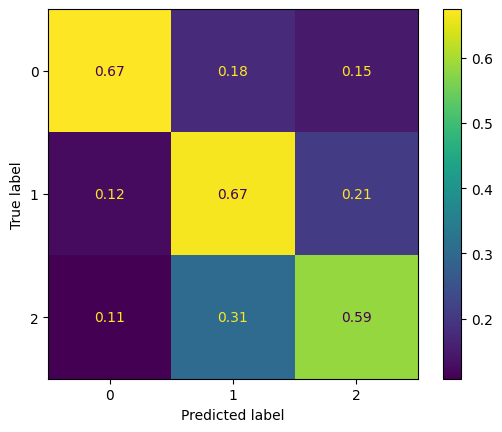

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.93811. Saving Model!
epoch 01, loss: 0.96517, acc: 0.48828, val_loss: 0.93811, val_accuracy: 0.51708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 02, loss: 0.96004, acc: 0.49089, val_loss: 0.93863, val_accuracy: 0.51413


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


epoch 03, loss: 0.95645, acc: 0.49222, val_loss: 0.93953, val_accuracy: 0.51492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 04, loss: 0.95490, acc: 0.49349, val_loss: 0.94053, val_accuracy: 0.51845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 05, loss: 0.95502, acc: 0.49432, val_loss: 0.94113, val_accuracy: 0.52061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.65it/s]


epoch 06, loss: 0.95558, acc: 0.49508, val_loss: 0.94099, val_accuracy: 0.52101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.34it/s]


epoch 07, loss: 0.95555, acc: 0.49617, val_loss: 0.94025, val_accuracy: 0.52179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 08, loss: 0.95471, acc: 0.49576, val_loss: 0.93935, val_accuracy: 0.52081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


epoch 09, loss: 0.95343, acc: 0.49683, val_loss: 0.93855, val_accuracy: 0.52101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


[INFO] val_acc has been improved from 0.93811 to 0.93796. Saving Model!
epoch 10, loss: 0.95226, acc: 0.49718, val_loss: 0.93796, val_accuracy: 0.52140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


[INFO] val_acc has been improved from 0.93796 to 0.93755. Saving Model!
epoch 11, loss: 0.95151, acc: 0.49931, val_loss: 0.93755, val_accuracy: 0.52258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


[INFO] val_acc has been improved from 0.93755 to 0.93723. Saving Model!
epoch 12, loss: 0.95107, acc: 0.49938, val_loss: 0.93723, val_accuracy: 0.52356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.93723 to 0.93691. Saving Model!
epoch 13, loss: 0.95075, acc: 0.50021, val_loss: 0.93691, val_accuracy: 0.52415


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


[INFO] val_acc has been improved from 0.93691 to 0.93656. Saving Model!
epoch 14, loss: 0.95048, acc: 0.50060, val_loss: 0.93656, val_accuracy: 0.52473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.81it/s]


[INFO] val_acc has been improved from 0.93656 to 0.93618. Saving Model!
epoch 15, loss: 0.95003, acc: 0.50060, val_loss: 0.93618, val_accuracy: 0.52454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


[INFO] val_acc has been improved from 0.93618 to 0.93583. Saving Model!
epoch 16, loss: 0.94948, acc: 0.50082, val_loss: 0.93583, val_accuracy: 0.52532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


[INFO] val_acc has been improved from 0.93583 to 0.93554. Saving Model!
epoch 17, loss: 0.94896, acc: 0.50224, val_loss: 0.93554, val_accuracy: 0.52572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.90it/s]


[INFO] val_acc has been improved from 0.93554 to 0.93526. Saving Model!
epoch 18, loss: 0.94848, acc: 0.50241, val_loss: 0.93526, val_accuracy: 0.52650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


[INFO] val_acc has been improved from 0.93526 to 0.93494. Saving Model!
epoch 19, loss: 0.94801, acc: 0.50302, val_loss: 0.93494, val_accuracy: 0.52670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


[INFO] val_acc has been improved from 0.93494 to 0.93461. Saving Model!
epoch 20, loss: 0.94753, acc: 0.50344, val_loss: 0.93461, val_accuracy: 0.52689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


[INFO] val_acc has been improved from 0.93461 to 0.93430. Saving Model!
epoch 21, loss: 0.94706, acc: 0.50450, val_loss: 0.93430, val_accuracy: 0.52748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


[INFO] val_acc has been improved from 0.93430 to 0.93404. Saving Model!
epoch 22, loss: 0.94662, acc: 0.50483, val_loss: 0.93404, val_accuracy: 0.52866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.02it/s]


[INFO] val_acc has been improved from 0.93404 to 0.93381. Saving Model!
epoch 23, loss: 0.94614, acc: 0.50540, val_loss: 0.93381, val_accuracy: 0.52866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


[INFO] val_acc has been improved from 0.93381 to 0.93351. Saving Model!
epoch 24, loss: 0.94578, acc: 0.50623, val_loss: 0.93351, val_accuracy: 0.52905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


[INFO] val_acc has been improved from 0.93351 to 0.93326. Saving Model!
epoch 25, loss: 0.94537, acc: 0.50738, val_loss: 0.93326, val_accuracy: 0.52945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.54it/s]


[INFO] val_acc has been improved from 0.93326 to 0.93298. Saving Model!
epoch 26, loss: 0.94481, acc: 0.50799, val_loss: 0.93298, val_accuracy: 0.52886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


[INFO] val_acc has been improved from 0.93298 to 0.93272. Saving Model!
epoch 27, loss: 0.94440, acc: 0.50821, val_loss: 0.93272, val_accuracy: 0.52846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 0.93272 to 0.93247. Saving Model!
epoch 28, loss: 0.94402, acc: 0.50782, val_loss: 0.93247, val_accuracy: 0.52886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


[INFO] val_acc has been improved from 0.93247 to 0.93219. Saving Model!
epoch 29, loss: 0.94359, acc: 0.50871, val_loss: 0.93219, val_accuracy: 0.52866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


[INFO] val_acc has been improved from 0.93219 to 0.93191. Saving Model!
epoch 30, loss: 0.94315, acc: 0.50882, val_loss: 0.93191, val_accuracy: 0.52827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


[INFO] val_acc has been improved from 0.93191 to 0.93165. Saving Model!
epoch 31, loss: 0.94273, acc: 0.50909, val_loss: 0.93165, val_accuracy: 0.52905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 0.93165 to 0.93139. Saving Model!
epoch 32, loss: 0.94229, acc: 0.50950, val_loss: 0.93139, val_accuracy: 0.52984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.93139 to 0.93110. Saving Model!
epoch 33, loss: 0.94184, acc: 0.50998, val_loss: 0.93110, val_accuracy: 0.53062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


[INFO] val_acc has been improved from 0.93110 to 0.93082. Saving Model!
epoch 34, loss: 0.94142, acc: 0.51039, val_loss: 0.93082, val_accuracy: 0.53102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


[INFO] val_acc has been improved from 0.93082 to 0.93054. Saving Model!
epoch 35, loss: 0.94104, acc: 0.51055, val_loss: 0.93054, val_accuracy: 0.54319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


[INFO] val_acc has been improved from 0.93054 to 0.93025. Saving Model!
epoch 36, loss: 0.94063, acc: 0.51070, val_loss: 0.93025, val_accuracy: 0.54417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


[INFO] val_acc has been improved from 0.93025 to 0.92999. Saving Model!
epoch 37, loss: 0.94013, acc: 0.51072, val_loss: 0.92999, val_accuracy: 0.54397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


[INFO] val_acc has been improved from 0.92999 to 0.92971. Saving Model!
epoch 38, loss: 0.93975, acc: 0.51107, val_loss: 0.92971, val_accuracy: 0.54437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


[INFO] val_acc has been improved from 0.92971 to 0.92944. Saving Model!
epoch 39, loss: 0.93944, acc: 0.51127, val_loss: 0.92944, val_accuracy: 0.54417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


[INFO] val_acc has been improved from 0.92944 to 0.92918. Saving Model!
epoch 40, loss: 0.93900, acc: 0.51157, val_loss: 0.92918, val_accuracy: 0.54476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


[INFO] val_acc has been improved from 0.92918 to 0.92892. Saving Model!
epoch 41, loss: 0.93858, acc: 0.51214, val_loss: 0.92892, val_accuracy: 0.54495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 0.92892 to 0.92866. Saving Model!
epoch 42, loss: 0.93822, acc: 0.51151, val_loss: 0.92866, val_accuracy: 0.54535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


[INFO] val_acc has been improved from 0.92866 to 0.92839. Saving Model!
epoch 43, loss: 0.93786, acc: 0.51159, val_loss: 0.92839, val_accuracy: 0.54476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.98it/s]


[INFO] val_acc has been improved from 0.92839 to 0.92813. Saving Model!
epoch 44, loss: 0.93743, acc: 0.51177, val_loss: 0.92813, val_accuracy: 0.54535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


[INFO] val_acc has been improved from 0.92813 to 0.92788. Saving Model!
epoch 45, loss: 0.93702, acc: 0.51172, val_loss: 0.92788, val_accuracy: 0.54594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


[INFO] val_acc has been improved from 0.92788 to 0.92763. Saving Model!
epoch 46, loss: 0.93665, acc: 0.51253, val_loss: 0.92763, val_accuracy: 0.54613


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


[INFO] val_acc has been improved from 0.92763 to 0.92736. Saving Model!
epoch 47, loss: 0.93631, acc: 0.51260, val_loss: 0.92736, val_accuracy: 0.54633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.92736 to 0.92710. Saving Model!
epoch 48, loss: 0.93589, acc: 0.51290, val_loss: 0.92710, val_accuracy: 0.54692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


[INFO] val_acc has been improved from 0.92710 to 0.92683. Saving Model!
epoch 49, loss: 0.93550, acc: 0.51290, val_loss: 0.92683, val_accuracy: 0.54711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.84it/s]


[INFO] val_acc has been improved from 0.92683 to 0.92658. Saving Model!
epoch 50, loss: 0.93517, acc: 0.51334, val_loss: 0.92658, val_accuracy: 0.54751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


[INFO] val_acc has been improved from 0.92658 to 0.92633. Saving Model!
epoch 51, loss: 0.93477, acc: 0.51338, val_loss: 0.92633, val_accuracy: 0.54770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


[INFO] val_acc has been improved from 0.92633 to 0.92609. Saving Model!
epoch 52, loss: 0.93438, acc: 0.51382, val_loss: 0.92609, val_accuracy: 0.54790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


[INFO] val_acc has been improved from 0.92609 to 0.92583. Saving Model!
epoch 53, loss: 0.93403, acc: 0.51386, val_loss: 0.92583, val_accuracy: 0.54810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


[INFO] val_acc has been improved from 0.92583 to 0.92554. Saving Model!
epoch 54, loss: 0.93367, acc: 0.51360, val_loss: 0.92554, val_accuracy: 0.54810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


[INFO] val_acc has been improved from 0.92554 to 0.92526. Saving Model!
epoch 55, loss: 0.93322, acc: 0.51412, val_loss: 0.92526, val_accuracy: 0.54790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


[INFO] val_acc has been improved from 0.92526 to 0.92495. Saving Model!
epoch 56, loss: 0.93291, acc: 0.51474, val_loss: 0.92495, val_accuracy: 0.54829


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


[INFO] val_acc has been improved from 0.92495 to 0.92468. Saving Model!
epoch 57, loss: 0.93251, acc: 0.51498, val_loss: 0.92468, val_accuracy: 0.54849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


[INFO] val_acc has been improved from 0.92468 to 0.92440. Saving Model!
epoch 58, loss: 0.93209, acc: 0.51508, val_loss: 0.92440, val_accuracy: 0.54908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


[INFO] val_acc has been improved from 0.92440 to 0.92413. Saving Model!
epoch 59, loss: 0.93172, acc: 0.51399, val_loss: 0.92413, val_accuracy: 0.54927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


[INFO] val_acc has been improved from 0.92413 to 0.92387. Saving Model!
epoch 60, loss: 0.93128, acc: 0.51319, val_loss: 0.92387, val_accuracy: 0.54888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


[INFO] val_acc has been improved from 0.92387 to 0.92359. Saving Model!
epoch 61, loss: 0.93095, acc: 0.51316, val_loss: 0.92359, val_accuracy: 0.54908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


[INFO] val_acc has been improved from 0.92359 to 0.92328. Saving Model!
epoch 62, loss: 0.93058, acc: 0.51349, val_loss: 0.92328, val_accuracy: 0.54967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.20it/s]


[INFO] val_acc has been improved from 0.92328 to 0.92299. Saving Model!
epoch 63, loss: 0.93016, acc: 0.51367, val_loss: 0.92299, val_accuracy: 0.54986


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


[INFO] val_acc has been improved from 0.92299 to 0.92273. Saving Model!
epoch 64, loss: 0.92978, acc: 0.51495, val_loss: 0.92273, val_accuracy: 0.55006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.92273 to 0.92245. Saving Model!
epoch 65, loss: 0.92940, acc: 0.51530, val_loss: 0.92245, val_accuracy: 0.55006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


[INFO] val_acc has been improved from 0.92245 to 0.92219. Saving Model!
epoch 66, loss: 0.92903, acc: 0.51548, val_loss: 0.92219, val_accuracy: 0.55026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


[INFO] val_acc has been improved from 0.92219 to 0.92193. Saving Model!
epoch 67, loss: 0.92869, acc: 0.51543, val_loss: 0.92193, val_accuracy: 0.55006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


[INFO] val_acc has been improved from 0.92193 to 0.92168. Saving Model!
epoch 68, loss: 0.92823, acc: 0.51545, val_loss: 0.92168, val_accuracy: 0.54967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


[INFO] val_acc has been improved from 0.92168 to 0.92141. Saving Model!
epoch 69, loss: 0.92787, acc: 0.51572, val_loss: 0.92141, val_accuracy: 0.54967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


[INFO] val_acc has been improved from 0.92141 to 0.92114. Saving Model!
epoch 70, loss: 0.92750, acc: 0.51709, val_loss: 0.92114, val_accuracy: 0.54927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


[INFO] val_acc has been improved from 0.92114 to 0.92088. Saving Model!
epoch 71, loss: 0.92710, acc: 0.51724, val_loss: 0.92088, val_accuracy: 0.54633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s]


[INFO] val_acc has been improved from 0.92088 to 0.92060. Saving Model!
epoch 72, loss: 0.92675, acc: 0.51755, val_loss: 0.92060, val_accuracy: 0.54613


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


[INFO] val_acc has been improved from 0.92060 to 0.92033. Saving Model!
epoch 73, loss: 0.92637, acc: 0.51788, val_loss: 0.92033, val_accuracy: 0.54613


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


[INFO] val_acc has been improved from 0.92033 to 0.92007. Saving Model!
epoch 74, loss: 0.92592, acc: 0.51827, val_loss: 0.92007, val_accuracy: 0.54653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


[INFO] val_acc has been improved from 0.92007 to 0.91978. Saving Model!
epoch 75, loss: 0.92559, acc: 0.51884, val_loss: 0.91978, val_accuracy: 0.54692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


[INFO] val_acc has been improved from 0.91978 to 0.91950. Saving Model!
epoch 76, loss: 0.92521, acc: 0.51908, val_loss: 0.91950, val_accuracy: 0.54731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 0.91950 to 0.91920. Saving Model!
epoch 77, loss: 0.92488, acc: 0.51973, val_loss: 0.91920, val_accuracy: 0.54711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.91920 to 0.91892. Saving Model!
epoch 78, loss: 0.92448, acc: 0.52021, val_loss: 0.91892, val_accuracy: 0.54692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


[INFO] val_acc has been improved from 0.91892 to 0.91864. Saving Model!
epoch 79, loss: 0.92413, acc: 0.52034, val_loss: 0.91864, val_accuracy: 0.54790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


[INFO] val_acc has been improved from 0.91864 to 0.91838. Saving Model!
epoch 80, loss: 0.92378, acc: 0.52062, val_loss: 0.91838, val_accuracy: 0.54770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


[INFO] val_acc has been improved from 0.91838 to 0.91808. Saving Model!
epoch 81, loss: 0.92340, acc: 0.51925, val_loss: 0.91808, val_accuracy: 0.54810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 0.91808 to 0.91777. Saving Model!
epoch 82, loss: 0.92304, acc: 0.51980, val_loss: 0.91777, val_accuracy: 0.54829


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


[INFO] val_acc has been improved from 0.91777 to 0.91752. Saving Model!
epoch 83, loss: 0.92259, acc: 0.52006, val_loss: 0.91752, val_accuracy: 0.54868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


[INFO] val_acc has been improved from 0.91752 to 0.91727. Saving Model!
epoch 84, loss: 0.92228, acc: 0.52032, val_loss: 0.91727, val_accuracy: 0.54927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


[INFO] val_acc has been improved from 0.91727 to 0.91700. Saving Model!
epoch 85, loss: 0.92191, acc: 0.52073, val_loss: 0.91700, val_accuracy: 0.54986


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.31it/s]


[INFO] val_acc has been improved from 0.91700 to 0.91673. Saving Model!
epoch 86, loss: 0.92154, acc: 0.52115, val_loss: 0.91673, val_accuracy: 0.54967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.79it/s]


[INFO] val_acc has been improved from 0.91673 to 0.91647. Saving Model!
epoch 87, loss: 0.92120, acc: 0.52126, val_loss: 0.91647, val_accuracy: 0.54986


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.91647 to 0.91620. Saving Model!
epoch 88, loss: 0.92083, acc: 0.52222, val_loss: 0.91620, val_accuracy: 0.54986


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


[INFO] val_acc has been improved from 0.91620 to 0.91592. Saving Model!
epoch 89, loss: 0.92045, acc: 0.52268, val_loss: 0.91592, val_accuracy: 0.55026


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


[INFO] val_acc has been improved from 0.91592 to 0.91568. Saving Model!
epoch 90, loss: 0.92005, acc: 0.52281, val_loss: 0.91568, val_accuracy: 0.55084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


[INFO] val_acc has been improved from 0.91568 to 0.91545. Saving Model!
epoch 91, loss: 0.91970, acc: 0.52296, val_loss: 0.91545, val_accuracy: 0.55124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


[INFO] val_acc has been improved from 0.91545 to 0.91521. Saving Model!
epoch 92, loss: 0.91934, acc: 0.52370, val_loss: 0.91521, val_accuracy: 0.55124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


[INFO] val_acc has been improved from 0.91521 to 0.91494. Saving Model!
epoch 93, loss: 0.91902, acc: 0.52403, val_loss: 0.91494, val_accuracy: 0.55124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.91494 to 0.91471. Saving Model!
epoch 94, loss: 0.91859, acc: 0.52440, val_loss: 0.91471, val_accuracy: 0.55183


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


[INFO] val_acc has been improved from 0.91471 to 0.91450. Saving Model!
epoch 95, loss: 0.91824, acc: 0.52446, val_loss: 0.91450, val_accuracy: 0.55222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


[INFO] val_acc has been improved from 0.91450 to 0.91426. Saving Model!
epoch 96, loss: 0.91788, acc: 0.52545, val_loss: 0.91426, val_accuracy: 0.55124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.91426 to 0.91403. Saving Model!
epoch 97, loss: 0.91753, acc: 0.52569, val_loss: 0.91403, val_accuracy: 0.55163


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


[INFO] val_acc has been improved from 0.91403 to 0.91379. Saving Model!
epoch 98, loss: 0.91722, acc: 0.52606, val_loss: 0.91379, val_accuracy: 0.55202


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


[INFO] val_acc has been improved from 0.91379 to 0.91359. Saving Model!
epoch 99, loss: 0.91682, acc: 0.52732, val_loss: 0.91359, val_accuracy: 0.55340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.49it/s]


[INFO] val_acc has been improved from 0.91359 to 0.91337. Saving Model!
epoch 100, loss: 0.91643, acc: 0.52789, val_loss: 0.91337, val_accuracy: 0.55870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


[INFO] val_acc has been improved from 0.91337 to 0.91313. Saving Model!
epoch 101, loss: 0.91611, acc: 0.52806, val_loss: 0.91313, val_accuracy: 0.55929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


[INFO] val_acc has been improved from 0.91313 to 0.91293. Saving Model!
epoch 102, loss: 0.91568, acc: 0.52837, val_loss: 0.91293, val_accuracy: 0.55889


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.90it/s]


[INFO] val_acc has been improved from 0.91293 to 0.91268. Saving Model!
epoch 103, loss: 0.91540, acc: 0.52952, val_loss: 0.91268, val_accuracy: 0.55929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


[INFO] val_acc has been improved from 0.91268 to 0.91246. Saving Model!
epoch 104, loss: 0.91496, acc: 0.52981, val_loss: 0.91246, val_accuracy: 0.55909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.16it/s]


[INFO] val_acc has been improved from 0.91246 to 0.91226. Saving Model!
epoch 105, loss: 0.91460, acc: 0.53029, val_loss: 0.91226, val_accuracy: 0.55968


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


[INFO] val_acc has been improved from 0.91226 to 0.91204. Saving Model!
epoch 106, loss: 0.91427, acc: 0.53166, val_loss: 0.91204, val_accuracy: 0.56046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


[INFO] val_acc has been improved from 0.91204 to 0.91179. Saving Model!
epoch 107, loss: 0.91393, acc: 0.53175, val_loss: 0.91179, val_accuracy: 0.56066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


[INFO] val_acc has been improved from 0.91179 to 0.91157. Saving Model!
epoch 108, loss: 0.91354, acc: 0.53195, val_loss: 0.91157, val_accuracy: 0.56105


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


[INFO] val_acc has been improved from 0.91157 to 0.91135. Saving Model!
epoch 109, loss: 0.91318, acc: 0.53223, val_loss: 0.91135, val_accuracy: 0.56066


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


[INFO] val_acc has been improved from 0.91135 to 0.91114. Saving Model!
epoch 110, loss: 0.91287, acc: 0.53232, val_loss: 0.91114, val_accuracy: 0.56086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


[INFO] val_acc has been improved from 0.91114 to 0.91093. Saving Model!
epoch 111, loss: 0.91249, acc: 0.53243, val_loss: 0.91093, val_accuracy: 0.56144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


[INFO] val_acc has been improved from 0.91093 to 0.91070. Saving Model!
epoch 112, loss: 0.91209, acc: 0.53253, val_loss: 0.91070, val_accuracy: 0.56125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 0.91070 to 0.91041. Saving Model!
epoch 113, loss: 0.91177, acc: 0.53269, val_loss: 0.91041, val_accuracy: 0.56144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


[INFO] val_acc has been improved from 0.91041 to 0.91021. Saving Model!
epoch 114, loss: 0.91136, acc: 0.53271, val_loss: 0.91021, val_accuracy: 0.56184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.91021 to 0.90996. Saving Model!
epoch 115, loss: 0.91102, acc: 0.53295, val_loss: 0.90996, val_accuracy: 0.56184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


[INFO] val_acc has been improved from 0.90996 to 0.90973. Saving Model!
epoch 116, loss: 0.91067, acc: 0.53306, val_loss: 0.90973, val_accuracy: 0.56302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


[INFO] val_acc has been improved from 0.90973 to 0.90945. Saving Model!
epoch 117, loss: 0.91033, acc: 0.53339, val_loss: 0.90945, val_accuracy: 0.56380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 0.90945 to 0.90924. Saving Model!
epoch 118, loss: 0.90990, acc: 0.53373, val_loss: 0.90924, val_accuracy: 0.56478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


[INFO] val_acc has been improved from 0.90924 to 0.90897. Saving Model!
epoch 119, loss: 0.90954, acc: 0.53397, val_loss: 0.90897, val_accuracy: 0.56537


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


[INFO] val_acc has been improved from 0.90897 to 0.90871. Saving Model!
epoch 120, loss: 0.90919, acc: 0.53439, val_loss: 0.90871, val_accuracy: 0.56576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


[INFO] val_acc has been improved from 0.90871 to 0.90848. Saving Model!
epoch 121, loss: 0.90879, acc: 0.53480, val_loss: 0.90848, val_accuracy: 0.56616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


[INFO] val_acc has been improved from 0.90848 to 0.90820. Saving Model!
epoch 122, loss: 0.90851, acc: 0.53496, val_loss: 0.90820, val_accuracy: 0.56655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.76it/s]


[INFO] val_acc has been improved from 0.90820 to 0.90796. Saving Model!
epoch 123, loss: 0.90808, acc: 0.53524, val_loss: 0.90796, val_accuracy: 0.56655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.63it/s]


[INFO] val_acc has been improved from 0.90796 to 0.90770. Saving Model!
epoch 124, loss: 0.90768, acc: 0.53594, val_loss: 0.90770, val_accuracy: 0.56733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


[INFO] val_acc has been improved from 0.90770 to 0.90748. Saving Model!
epoch 125, loss: 0.90734, acc: 0.53657, val_loss: 0.90748, val_accuracy: 0.56792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


[INFO] val_acc has been improved from 0.90748 to 0.90722. Saving Model!
epoch 126, loss: 0.90694, acc: 0.53733, val_loss: 0.90722, val_accuracy: 0.56910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.90722 to 0.90699. Saving Model!
epoch 127, loss: 0.90660, acc: 0.53751, val_loss: 0.90699, val_accuracy: 0.56517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


[INFO] val_acc has been improved from 0.90699 to 0.90675. Saving Model!
epoch 128, loss: 0.90624, acc: 0.53720, val_loss: 0.90675, val_accuracy: 0.56517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.90675 to 0.90650. Saving Model!
epoch 129, loss: 0.90586, acc: 0.53777, val_loss: 0.90650, val_accuracy: 0.56596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.90it/s]


[INFO] val_acc has been improved from 0.90650 to 0.90623. Saving Model!
epoch 130, loss: 0.90552, acc: 0.53808, val_loss: 0.90623, val_accuracy: 0.56655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


[INFO] val_acc has been improved from 0.90623 to 0.90602. Saving Model!
epoch 131, loss: 0.90507, acc: 0.53866, val_loss: 0.90602, val_accuracy: 0.56655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


[INFO] val_acc has been improved from 0.90602 to 0.90577. Saving Model!
epoch 132, loss: 0.90471, acc: 0.53914, val_loss: 0.90577, val_accuracy: 0.56675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 0.90577 to 0.90549. Saving Model!
epoch 133, loss: 0.90436, acc: 0.53956, val_loss: 0.90549, val_accuracy: 0.56733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.31it/s]


[INFO] val_acc has been improved from 0.90549 to 0.90523. Saving Model!
epoch 134, loss: 0.90396, acc: 0.54054, val_loss: 0.90523, val_accuracy: 0.56733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.99it/s]


[INFO] val_acc has been improved from 0.90523 to 0.90498. Saving Model!
epoch 135, loss: 0.90359, acc: 0.54231, val_loss: 0.90498, val_accuracy: 0.56733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.90498 to 0.90471. Saving Model!
epoch 136, loss: 0.90320, acc: 0.54250, val_loss: 0.90471, val_accuracy: 0.56773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


[INFO] val_acc has been improved from 0.90471 to 0.90439. Saving Model!
epoch 137, loss: 0.90292, acc: 0.54255, val_loss: 0.90439, val_accuracy: 0.56753


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


[INFO] val_acc has been improved from 0.90439 to 0.90414. Saving Model!
epoch 138, loss: 0.90233, acc: 0.54292, val_loss: 0.90414, val_accuracy: 0.56792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


[INFO] val_acc has been improved from 0.90414 to 0.90382. Saving Model!
epoch 139, loss: 0.90207, acc: 0.54311, val_loss: 0.90382, val_accuracy: 0.56832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


[INFO] val_acc has been improved from 0.90382 to 0.90359. Saving Model!
epoch 140, loss: 0.90158, acc: 0.54329, val_loss: 0.90359, val_accuracy: 0.56851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


[INFO] val_acc has been improved from 0.90359 to 0.90330. Saving Model!
epoch 141, loss: 0.90128, acc: 0.54346, val_loss: 0.90330, val_accuracy: 0.56871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.90330 to 0.90303. Saving Model!
epoch 142, loss: 0.90083, acc: 0.54375, val_loss: 0.90303, val_accuracy: 0.56871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


[INFO] val_acc has been improved from 0.90303 to 0.90275. Saving Model!
epoch 143, loss: 0.90045, acc: 0.54359, val_loss: 0.90275, val_accuracy: 0.56890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


[INFO] val_acc has been improved from 0.90275 to 0.90250. Saving Model!
epoch 144, loss: 0.90005, acc: 0.54407, val_loss: 0.90250, val_accuracy: 0.56832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


[INFO] val_acc has been improved from 0.90250 to 0.90230. Saving Model!
epoch 145, loss: 0.89959, acc: 0.54525, val_loss: 0.90230, val_accuracy: 0.56812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


[INFO] val_acc has been improved from 0.90230 to 0.90194. Saving Model!
epoch 146, loss: 0.89934, acc: 0.54532, val_loss: 0.90194, val_accuracy: 0.56832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.90194 to 0.90170. Saving Model!
epoch 147, loss: 0.89886, acc: 0.54551, val_loss: 0.90170, val_accuracy: 0.56851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


[INFO] val_acc has been improved from 0.90170 to 0.90143. Saving Model!
epoch 148, loss: 0.89848, acc: 0.54569, val_loss: 0.90143, val_accuracy: 0.56890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


[INFO] val_acc has been improved from 0.90143 to 0.90115. Saving Model!
epoch 149, loss: 0.89809, acc: 0.54608, val_loss: 0.90115, val_accuracy: 0.56930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


[INFO] val_acc has been improved from 0.90115 to 0.90082. Saving Model!
epoch 150, loss: 0.89783, acc: 0.54621, val_loss: 0.90082, val_accuracy: 0.56969


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


[INFO] val_acc has been improved from 0.90082 to 0.90058. Saving Model!
epoch 151, loss: 0.89728, acc: 0.54621, val_loss: 0.90058, val_accuracy: 0.56930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


[INFO] val_acc has been improved from 0.90058 to 0.90029. Saving Model!
epoch 152, loss: 0.89697, acc: 0.54654, val_loss: 0.90029, val_accuracy: 0.56989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


[INFO] val_acc has been improved from 0.90029 to 0.90004. Saving Model!
epoch 153, loss: 0.89653, acc: 0.54684, val_loss: 0.90004, val_accuracy: 0.57008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


[INFO] val_acc has been improved from 0.90004 to 0.89973. Saving Model!
epoch 154, loss: 0.89626, acc: 0.54698, val_loss: 0.89973, val_accuracy: 0.56989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.89973 to 0.89946. Saving Model!
epoch 155, loss: 0.89571, acc: 0.54717, val_loss: 0.89946, val_accuracy: 0.57048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


[INFO] val_acc has been improved from 0.89946 to 0.89914. Saving Model!
epoch 156, loss: 0.89550, acc: 0.54726, val_loss: 0.89914, val_accuracy: 0.57067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


[INFO] val_acc has been improved from 0.89914 to 0.89890. Saving Model!
epoch 157, loss: 0.89492, acc: 0.54752, val_loss: 0.89890, val_accuracy: 0.57087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.81it/s]


[INFO] val_acc has been improved from 0.89890 to 0.89859. Saving Model!
epoch 158, loss: 0.89467, acc: 0.54763, val_loss: 0.89859, val_accuracy: 0.57008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


[INFO] val_acc has been improved from 0.89859 to 0.89840. Saving Model!
epoch 159, loss: 0.89414, acc: 0.54787, val_loss: 0.89840, val_accuracy: 0.57087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


[INFO] val_acc has been improved from 0.89840 to 0.89813. Saving Model!
epoch 160, loss: 0.89385, acc: 0.54818, val_loss: 0.89813, val_accuracy: 0.57165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


[INFO] val_acc has been improved from 0.89813 to 0.89783. Saving Model!
epoch 161, loss: 0.89340, acc: 0.54828, val_loss: 0.89783, val_accuracy: 0.57224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


[INFO] val_acc has been improved from 0.89783 to 0.89755. Saving Model!
epoch 162, loss: 0.89312, acc: 0.54850, val_loss: 0.89755, val_accuracy: 0.57244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


[INFO] val_acc has been improved from 0.89755 to 0.89735. Saving Model!
epoch 163, loss: 0.89255, acc: 0.54863, val_loss: 0.89735, val_accuracy: 0.57263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]


[INFO] val_acc has been improved from 0.89735 to 0.89710. Saving Model!
epoch 164, loss: 0.89229, acc: 0.54883, val_loss: 0.89710, val_accuracy: 0.57381


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


[INFO] val_acc has been improved from 0.89710 to 0.89688. Saving Model!
epoch 165, loss: 0.89178, acc: 0.54896, val_loss: 0.89688, val_accuracy: 0.57440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


[INFO] val_acc has been improved from 0.89688 to 0.89658. Saving Model!
epoch 166, loss: 0.89153, acc: 0.54894, val_loss: 0.89658, val_accuracy: 0.57460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


[INFO] val_acc has been improved from 0.89658 to 0.89640. Saving Model!
epoch 167, loss: 0.89101, acc: 0.54929, val_loss: 0.89640, val_accuracy: 0.57479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


[INFO] val_acc has been improved from 0.89640 to 0.89611. Saving Model!
epoch 168, loss: 0.89071, acc: 0.54929, val_loss: 0.89611, val_accuracy: 0.57538


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.89611 to 0.89591. Saving Model!
epoch 169, loss: 0.89028, acc: 0.54961, val_loss: 0.89591, val_accuracy: 0.57538


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 0.89591 to 0.89570. Saving Model!
epoch 170, loss: 0.88981, acc: 0.55016, val_loss: 0.89570, val_accuracy: 0.57597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


[INFO] val_acc has been improved from 0.89570 to 0.89542. Saving Model!
epoch 171, loss: 0.88954, acc: 0.55036, val_loss: 0.89542, val_accuracy: 0.57519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


[INFO] val_acc has been improved from 0.89542 to 0.89519. Saving Model!
epoch 172, loss: 0.88907, acc: 0.55029, val_loss: 0.89519, val_accuracy: 0.57499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


[INFO] val_acc has been improved from 0.89519 to 0.89496. Saving Model!
epoch 173, loss: 0.88873, acc: 0.55049, val_loss: 0.89496, val_accuracy: 0.57479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.89496 to 0.89467. Saving Model!
epoch 174, loss: 0.88828, acc: 0.55068, val_loss: 0.89467, val_accuracy: 0.57479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


[INFO] val_acc has been improved from 0.89467 to 0.89443. Saving Model!
epoch 175, loss: 0.88792, acc: 0.55077, val_loss: 0.89443, val_accuracy: 0.57519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


[INFO] val_acc has been improved from 0.89443 to 0.89419. Saving Model!
epoch 176, loss: 0.88755, acc: 0.55101, val_loss: 0.89419, val_accuracy: 0.57597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


[INFO] val_acc has been improved from 0.89419 to 0.89392. Saving Model!
epoch 177, loss: 0.88715, acc: 0.55123, val_loss: 0.89392, val_accuracy: 0.57636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


[INFO] val_acc has been improved from 0.89392 to 0.89365. Saving Model!
epoch 178, loss: 0.88675, acc: 0.55158, val_loss: 0.89365, val_accuracy: 0.57676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


[INFO] val_acc has been improved from 0.89365 to 0.89333. Saving Model!
epoch 179, loss: 0.88637, acc: 0.55173, val_loss: 0.89333, val_accuracy: 0.57715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


[INFO] val_acc has been improved from 0.89333 to 0.89315. Saving Model!
epoch 180, loss: 0.88588, acc: 0.55282, val_loss: 0.89315, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


[INFO] val_acc has been improved from 0.89315 to 0.89297. Saving Model!
epoch 181, loss: 0.88559, acc: 0.55304, val_loss: 0.89297, val_accuracy: 0.57813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


[INFO] val_acc has been improved from 0.89297 to 0.89275. Saving Model!
epoch 182, loss: 0.88522, acc: 0.55295, val_loss: 0.89275, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


[INFO] val_acc has been improved from 0.89275 to 0.89252. Saving Model!
epoch 183, loss: 0.88485, acc: 0.55295, val_loss: 0.89252, val_accuracy: 0.57715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


[INFO] val_acc has been improved from 0.89252 to 0.89223. Saving Model!
epoch 184, loss: 0.88444, acc: 0.55311, val_loss: 0.89223, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.89223 to 0.89204. Saving Model!
epoch 185, loss: 0.88397, acc: 0.55328, val_loss: 0.89204, val_accuracy: 0.57754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


[INFO] val_acc has been improved from 0.89204 to 0.89182. Saving Model!
epoch 186, loss: 0.88362, acc: 0.55359, val_loss: 0.89182, val_accuracy: 0.57813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


[INFO] val_acc has been improved from 0.89182 to 0.89162. Saving Model!
epoch 187, loss: 0.88319, acc: 0.55359, val_loss: 0.89162, val_accuracy: 0.56714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


[INFO] val_acc has been improved from 0.89162 to 0.89135. Saving Model!
epoch 188, loss: 0.88288, acc: 0.55359, val_loss: 0.89135, val_accuracy: 0.56773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


[INFO] val_acc has been improved from 0.89135 to 0.89108. Saving Model!
epoch 189, loss: 0.88245, acc: 0.55369, val_loss: 0.89108, val_accuracy: 0.56773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


[INFO] val_acc has been improved from 0.89108 to 0.89088. Saving Model!
epoch 190, loss: 0.88204, acc: 0.55383, val_loss: 0.89088, val_accuracy: 0.56792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.10it/s]


[INFO] val_acc has been improved from 0.89088 to 0.89061. Saving Model!
epoch 191, loss: 0.88166, acc: 0.55415, val_loss: 0.89061, val_accuracy: 0.56812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


[INFO] val_acc has been improved from 0.89061 to 0.89032. Saving Model!
epoch 192, loss: 0.88127, acc: 0.55420, val_loss: 0.89032, val_accuracy: 0.56832


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.89032 to 0.89004. Saving Model!
epoch 193, loss: 0.88094, acc: 0.55437, val_loss: 0.89004, val_accuracy: 0.56812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.11it/s]


[INFO] val_acc has been improved from 0.89004 to 0.88990. Saving Model!
epoch 194, loss: 0.88035, acc: 0.55459, val_loss: 0.88990, val_accuracy: 0.56773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.18it/s]


[INFO] val_acc has been improved from 0.88990 to 0.88958. Saving Model!
epoch 195, loss: 0.88013, acc: 0.55485, val_loss: 0.88958, val_accuracy: 0.56773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.88958 to 0.88928. Saving Model!
epoch 196, loss: 0.87974, acc: 0.55476, val_loss: 0.88928, val_accuracy: 0.56851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


[INFO] val_acc has been improved from 0.88928 to 0.88902. Saving Model!
epoch 197, loss: 0.87936, acc: 0.55487, val_loss: 0.88902, val_accuracy: 0.56851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


[INFO] val_acc has been improved from 0.88902 to 0.88886. Saving Model!
epoch 198, loss: 0.87888, acc: 0.55516, val_loss: 0.88886, val_accuracy: 0.56871


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


[INFO] val_acc has been improved from 0.88886 to 0.88860. Saving Model!
epoch 199, loss: 0.87848, acc: 0.55531, val_loss: 0.88860, val_accuracy: 0.56930


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


[INFO] val_acc has been improved from 0.88860 to 0.88825. Saving Model!
epoch 200, loss: 0.87827, acc: 0.55555, val_loss: 0.88825, val_accuracy: 0.56949


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 0.88825 to 0.88801. Saving Model!
epoch 201, loss: 0.87773, acc: 0.55568, val_loss: 0.88801, val_accuracy: 0.56989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


[INFO] val_acc has been improved from 0.88801 to 0.88784. Saving Model!
epoch 202, loss: 0.87730, acc: 0.55603, val_loss: 0.88784, val_accuracy: 0.57008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


[INFO] val_acc has been improved from 0.88784 to 0.88751. Saving Model!
epoch 203, loss: 0.87705, acc: 0.55714, val_loss: 0.88751, val_accuracy: 0.57048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


[INFO] val_acc has been improved from 0.88751 to 0.88721. Saving Model!
epoch 204, loss: 0.87669, acc: 0.55745, val_loss: 0.88721, val_accuracy: 0.57048


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


[INFO] val_acc has been improved from 0.88721 to 0.88705. Saving Model!
epoch 205, loss: 0.87615, acc: 0.55749, val_loss: 0.88705, val_accuracy: 0.57087


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


[INFO] val_acc has been improved from 0.88705 to 0.88680. Saving Model!
epoch 206, loss: 0.87580, acc: 0.55775, val_loss: 0.88680, val_accuracy: 0.57126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.88680 to 0.88647. Saving Model!
epoch 207, loss: 0.87548, acc: 0.55780, val_loss: 0.88647, val_accuracy: 0.57146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


[INFO] val_acc has been improved from 0.88647 to 0.88621. Saving Model!
epoch 208, loss: 0.87512, acc: 0.55806, val_loss: 0.88621, val_accuracy: 0.57165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


[INFO] val_acc has been improved from 0.88621 to 0.88603. Saving Model!
epoch 209, loss: 0.87456, acc: 0.55821, val_loss: 0.88603, val_accuracy: 0.57165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.88603 to 0.88574. Saving Model!
epoch 210, loss: 0.87438, acc: 0.55814, val_loss: 0.88574, val_accuracy: 0.57106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


[INFO] val_acc has been improved from 0.88574 to 0.88557. Saving Model!
epoch 211, loss: 0.87378, acc: 0.55836, val_loss: 0.88557, val_accuracy: 0.57067


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


[INFO] val_acc has been improved from 0.88557 to 0.88521. Saving Model!
epoch 212, loss: 0.87362, acc: 0.55841, val_loss: 0.88521, val_accuracy: 0.57008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.88521 to 0.88502. Saving Model!
epoch 213, loss: 0.87301, acc: 0.55880, val_loss: 0.88502, val_accuracy: 0.57008


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


[INFO] val_acc has been improved from 0.88502 to 0.88471. Saving Model!
epoch 214, loss: 0.87289, acc: 0.55827, val_loss: 0.88471, val_accuracy: 0.57106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


[INFO] val_acc has been improved from 0.88471 to 0.88466. Saving Model!
epoch 215, loss: 0.87221, acc: 0.55867, val_loss: 0.88466, val_accuracy: 0.57126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


[INFO] val_acc has been improved from 0.88466 to 0.88444. Saving Model!
epoch 216, loss: 0.87195, acc: 0.55862, val_loss: 0.88444, val_accuracy: 0.57106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


[INFO] val_acc has been improved from 0.88444 to 0.88414. Saving Model!
epoch 217, loss: 0.87154, acc: 0.56015, val_loss: 0.88414, val_accuracy: 0.57597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


[INFO] val_acc has been improved from 0.88414 to 0.88387. Saving Model!
epoch 218, loss: 0.87119, acc: 0.56081, val_loss: 0.88387, val_accuracy: 0.57617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.88387 to 0.88377. Saving Model!
epoch 219, loss: 0.87067, acc: 0.56094, val_loss: 0.88377, val_accuracy: 0.57676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.84it/s]


[INFO] val_acc has been improved from 0.88377 to 0.88342. Saving Model!
epoch 220, loss: 0.87056, acc: 0.56083, val_loss: 0.88342, val_accuracy: 0.57695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


[INFO] val_acc has been improved from 0.88342 to 0.88320. Saving Model!
epoch 221, loss: 0.87004, acc: 0.56096, val_loss: 0.88320, val_accuracy: 0.57715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


[INFO] val_acc has been improved from 0.88320 to 0.88300. Saving Model!
epoch 222, loss: 0.86963, acc: 0.56105, val_loss: 0.88300, val_accuracy: 0.57715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


[INFO] val_acc has been improved from 0.88300 to 0.88291. Saving Model!
epoch 223, loss: 0.86912, acc: 0.56157, val_loss: 0.88291, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


[INFO] val_acc has been improved from 0.88291 to 0.88264. Saving Model!
epoch 224, loss: 0.86899, acc: 0.56148, val_loss: 0.88264, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


[INFO] val_acc has been improved from 0.88264 to 0.88245. Saving Model!
epoch 225, loss: 0.86841, acc: 0.56214, val_loss: 0.88245, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


[INFO] val_acc has been improved from 0.88245 to 0.88224. Saving Model!
epoch 226, loss: 0.86808, acc: 0.56235, val_loss: 0.88224, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


[INFO] val_acc has been improved from 0.88224 to 0.88208. Saving Model!
epoch 227, loss: 0.86756, acc: 0.56262, val_loss: 0.88208, val_accuracy: 0.57793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.90it/s]


[INFO] val_acc has been improved from 0.88208 to 0.88181. Saving Model!
epoch 228, loss: 0.86744, acc: 0.56242, val_loss: 0.88181, val_accuracy: 0.57852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


[INFO] val_acc has been improved from 0.88181 to 0.88173. Saving Model!
epoch 229, loss: 0.86683, acc: 0.56296, val_loss: 0.88173, val_accuracy: 0.57852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.88173 to 0.88150. Saving Model!
epoch 230, loss: 0.86655, acc: 0.56307, val_loss: 0.88150, val_accuracy: 0.57833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.44it/s]


[INFO] val_acc has been improved from 0.88150 to 0.88124. Saving Model!
epoch 231, loss: 0.86612, acc: 0.56349, val_loss: 0.88124, val_accuracy: 0.57852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.34it/s]


[INFO] val_acc has been improved from 0.88124 to 0.88111. Saving Model!
epoch 232, loss: 0.86576, acc: 0.56349, val_loss: 0.88111, val_accuracy: 0.57852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


[INFO] val_acc has been improved from 0.88111 to 0.88093. Saving Model!
epoch 233, loss: 0.86532, acc: 0.56397, val_loss: 0.88093, val_accuracy: 0.57892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.57it/s]


[INFO] val_acc has been improved from 0.88093 to 0.88067. Saving Model!
epoch 234, loss: 0.86504, acc: 0.56447, val_loss: 0.88067, val_accuracy: 0.57970


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


[INFO] val_acc has been improved from 0.88067 to 0.88051. Saving Model!
epoch 235, loss: 0.86455, acc: 0.56482, val_loss: 0.88051, val_accuracy: 0.58068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


[INFO] val_acc has been improved from 0.88051 to 0.88023. Saving Model!
epoch 236, loss: 0.86430, acc: 0.56491, val_loss: 0.88023, val_accuracy: 0.58147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


[INFO] val_acc has been improved from 0.88023 to 0.88018. Saving Model!
epoch 237, loss: 0.86359, acc: 0.56528, val_loss: 0.88018, val_accuracy: 0.58127


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 0.88018 to 0.87978. Saving Model!
epoch 238, loss: 0.86360, acc: 0.56515, val_loss: 0.87978, val_accuracy: 0.58206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


[INFO] val_acc has been improved from 0.87978 to 0.87967. Saving Model!
epoch 239, loss: 0.86294, acc: 0.56569, val_loss: 0.87967, val_accuracy: 0.58147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.28it/s]


[INFO] val_acc has been improved from 0.87967 to 0.87949. Saving Model!
epoch 240, loss: 0.86266, acc: 0.56602, val_loss: 0.87949, val_accuracy: 0.58265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 0.87949 to 0.87935. Saving Model!
epoch 241, loss: 0.86222, acc: 0.56619, val_loss: 0.87935, val_accuracy: 0.58186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.28it/s]


[INFO] val_acc has been improved from 0.87935 to 0.87907. Saving Model!
epoch 242, loss: 0.86196, acc: 0.56613, val_loss: 0.87907, val_accuracy: 0.58304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


[INFO] val_acc has been improved from 0.87907 to 0.87895. Saving Model!
epoch 243, loss: 0.86141, acc: 0.56646, val_loss: 0.87895, val_accuracy: 0.58206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


[INFO] val_acc has been improved from 0.87895 to 0.87872. Saving Model!
epoch 244, loss: 0.86121, acc: 0.56652, val_loss: 0.87872, val_accuracy: 0.58324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.65it/s]


[INFO] val_acc has been improved from 0.87872 to 0.87863. Saving Model!
epoch 245, loss: 0.86070, acc: 0.56789, val_loss: 0.87863, val_accuracy: 0.58265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.57it/s]


[INFO] val_acc has been improved from 0.87863 to 0.87846. Saving Model!
epoch 246, loss: 0.86035, acc: 0.56781, val_loss: 0.87846, val_accuracy: 0.58343


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


[INFO] val_acc has been improved from 0.87846 to 0.87832. Saving Model!
epoch 247, loss: 0.85985, acc: 0.56840, val_loss: 0.87832, val_accuracy: 0.58343


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


[INFO] val_acc has been improved from 0.87832 to 0.87805. Saving Model!
epoch 248, loss: 0.85970, acc: 0.56840, val_loss: 0.87805, val_accuracy: 0.58363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


[INFO] val_acc has been improved from 0.87805 to 0.87801. Saving Model!
epoch 249, loss: 0.85904, acc: 0.56868, val_loss: 0.87801, val_accuracy: 0.58343


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.44it/s]


[INFO] val_acc has been improved from 0.87801 to 0.87777. Saving Model!
epoch 250, loss: 0.85887, acc: 0.56861, val_loss: 0.87777, val_accuracy: 0.58500


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


[INFO] val_acc has been improved from 0.87777 to 0.87763. Saving Model!
epoch 251, loss: 0.85834, acc: 0.56914, val_loss: 0.87763, val_accuracy: 0.58500


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.52it/s]


[INFO] val_acc has been improved from 0.87763 to 0.87746. Saving Model!
epoch 252, loss: 0.85805, acc: 0.56944, val_loss: 0.87746, val_accuracy: 0.58559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.87746 to 0.87729. Saving Model!
epoch 253, loss: 0.85758, acc: 0.56940, val_loss: 0.87729, val_accuracy: 0.58598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


[INFO] val_acc has been improved from 0.87729 to 0.87708. Saving Model!
epoch 254, loss: 0.85730, acc: 0.56964, val_loss: 0.87708, val_accuracy: 0.58579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.87708 to 0.87705. Saving Model!
epoch 255, loss: 0.85676, acc: 0.56999, val_loss: 0.87705, val_accuracy: 0.58618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


[INFO] val_acc has been improved from 0.87705 to 0.87685. Saving Model!
epoch 256, loss: 0.85655, acc: 0.57021, val_loss: 0.87685, val_accuracy: 0.58638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


[INFO] val_acc has been improved from 0.87685 to 0.87665. Saving Model!
epoch 257, loss: 0.85612, acc: 0.57029, val_loss: 0.87665, val_accuracy: 0.58638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


[INFO] val_acc has been improved from 0.87665 to 0.87639. Saving Model!
epoch 258, loss: 0.85582, acc: 0.57058, val_loss: 0.87639, val_accuracy: 0.58657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


[INFO] val_acc has been improved from 0.87639 to 0.87638. Saving Model!
epoch 259, loss: 0.85518, acc: 0.57071, val_loss: 0.87638, val_accuracy: 0.58638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


[INFO] val_acc has been improved from 0.87638 to 0.87611. Saving Model!
epoch 260, loss: 0.85504, acc: 0.57095, val_loss: 0.87611, val_accuracy: 0.58657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


[INFO] val_acc has been improved from 0.87611 to 0.87603. Saving Model!
epoch 261, loss: 0.85450, acc: 0.57106, val_loss: 0.87603, val_accuracy: 0.58598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


[INFO] val_acc has been improved from 0.87603 to 0.87583. Saving Model!
epoch 262, loss: 0.85420, acc: 0.57145, val_loss: 0.87583, val_accuracy: 0.58579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


[INFO] val_acc has been improved from 0.87583 to 0.87571. Saving Model!
epoch 263, loss: 0.85376, acc: 0.57158, val_loss: 0.87571, val_accuracy: 0.58579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


[INFO] val_acc has been improved from 0.87571 to 0.87552. Saving Model!
epoch 264, loss: 0.85346, acc: 0.57169, val_loss: 0.87552, val_accuracy: 0.58618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


[INFO] val_acc has been improved from 0.87552 to 0.87540. Saving Model!
epoch 265, loss: 0.85302, acc: 0.57191, val_loss: 0.87540, val_accuracy: 0.58579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


[INFO] val_acc has been improved from 0.87540 to 0.87520. Saving Model!
epoch 266, loss: 0.85269, acc: 0.57309, val_loss: 0.87520, val_accuracy: 0.58618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


[INFO] val_acc has been improved from 0.87520 to 0.87507. Saving Model!
epoch 267, loss: 0.85226, acc: 0.57317, val_loss: 0.87507, val_accuracy: 0.58677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


[INFO] val_acc has been improved from 0.87507 to 0.87492. Saving Model!
epoch 268, loss: 0.85188, acc: 0.57381, val_loss: 0.87492, val_accuracy: 0.58657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


[INFO] val_acc has been improved from 0.87492 to 0.87484. Saving Model!
epoch 269, loss: 0.85149, acc: 0.57413, val_loss: 0.87484, val_accuracy: 0.58697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


[INFO] val_acc has been improved from 0.87484 to 0.87459. Saving Model!
epoch 270, loss: 0.85116, acc: 0.57503, val_loss: 0.87459, val_accuracy: 0.58677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


[INFO] val_acc has been improved from 0.87459 to 0.87443. Saving Model!
epoch 271, loss: 0.85066, acc: 0.57536, val_loss: 0.87443, val_accuracy: 0.58775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


[INFO] val_acc has been improved from 0.87443 to 0.87430. Saving Model!
epoch 272, loss: 0.85040, acc: 0.57549, val_loss: 0.87430, val_accuracy: 0.58795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


[INFO] val_acc has been improved from 0.87430 to 0.87413. Saving Model!
epoch 273, loss: 0.85001, acc: 0.57540, val_loss: 0.87413, val_accuracy: 0.58834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


[INFO] val_acc has been improved from 0.87413 to 0.87409. Saving Model!
epoch 274, loss: 0.84950, acc: 0.57557, val_loss: 0.87409, val_accuracy: 0.58912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


[INFO] val_acc has been improved from 0.87409 to 0.87378. Saving Model!
epoch 275, loss: 0.84932, acc: 0.57570, val_loss: 0.87378, val_accuracy: 0.58971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.87378 to 0.87368. Saving Model!
epoch 276, loss: 0.84873, acc: 0.57612, val_loss: 0.87368, val_accuracy: 0.58952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


[INFO] val_acc has been improved from 0.87368 to 0.87352. Saving Model!
epoch 277, loss: 0.84840, acc: 0.57614, val_loss: 0.87352, val_accuracy: 0.58952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


[INFO] val_acc has been improved from 0.87352 to 0.87331. Saving Model!
epoch 278, loss: 0.84803, acc: 0.57636, val_loss: 0.87331, val_accuracy: 0.58912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.50it/s]


[INFO] val_acc has been improved from 0.87331 to 0.87311. Saving Model!
epoch 279, loss: 0.84761, acc: 0.57640, val_loss: 0.87311, val_accuracy: 0.59030


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


[INFO] val_acc has been improved from 0.87311 to 0.87301. Saving Model!
epoch 280, loss: 0.84718, acc: 0.57634, val_loss: 0.87301, val_accuracy: 0.59089


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.87301 to 0.87290. Saving Model!
epoch 281, loss: 0.84681, acc: 0.57579, val_loss: 0.87290, val_accuracy: 0.59069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.41it/s]


[INFO] val_acc has been improved from 0.87290 to 0.87271. Saving Model!
epoch 282, loss: 0.84639, acc: 0.57570, val_loss: 0.87271, val_accuracy: 0.59109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


[INFO] val_acc has been improved from 0.87271 to 0.87249. Saving Model!
epoch 283, loss: 0.84608, acc: 0.57568, val_loss: 0.87249, val_accuracy: 0.59148


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


[INFO] val_acc has been improved from 0.87249 to 0.87239. Saving Model!
epoch 284, loss: 0.84560, acc: 0.57555, val_loss: 0.87239, val_accuracy: 0.59187


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


[INFO] val_acc has been improved from 0.87239 to 0.87227. Saving Model!
epoch 285, loss: 0.84511, acc: 0.57562, val_loss: 0.87227, val_accuracy: 0.59207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.87227 to 0.87207. Saving Model!
epoch 286, loss: 0.84489, acc: 0.57566, val_loss: 0.87207, val_accuracy: 0.59207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


[INFO] val_acc has been improved from 0.87207 to 0.87200. Saving Model!
epoch 287, loss: 0.84442, acc: 0.57577, val_loss: 0.87200, val_accuracy: 0.59285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


[INFO] val_acc has been improved from 0.87200 to 0.87189. Saving Model!
epoch 288, loss: 0.84402, acc: 0.57601, val_loss: 0.87189, val_accuracy: 0.59384


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 0.87189 to 0.87162. Saving Model!
epoch 289, loss: 0.84363, acc: 0.57634, val_loss: 0.87162, val_accuracy: 0.59364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.87162 to 0.87136. Saving Model!
epoch 290, loss: 0.84336, acc: 0.57642, val_loss: 0.87136, val_accuracy: 0.59384


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.87136 to 0.87130. Saving Model!
epoch 291, loss: 0.84282, acc: 0.57666, val_loss: 0.87130, val_accuracy: 0.59364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


[INFO] val_acc has been improved from 0.87130 to 0.87126. Saving Model!
epoch 292, loss: 0.84234, acc: 0.57701, val_loss: 0.87126, val_accuracy: 0.59442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


[INFO] val_acc has been improved from 0.87126 to 0.87097. Saving Model!
epoch 293, loss: 0.84216, acc: 0.57769, val_loss: 0.87097, val_accuracy: 0.59403


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 0.87097 to 0.87083. Saving Model!
epoch 294, loss: 0.84170, acc: 0.57850, val_loss: 0.87083, val_accuracy: 0.59423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


[INFO] val_acc has been improved from 0.87083 to 0.87082. Saving Model!
epoch 295, loss: 0.84120, acc: 0.57885, val_loss: 0.87082, val_accuracy: 0.59501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.07it/s]


[INFO] val_acc has been improved from 0.87082 to 0.87061. Saving Model!
epoch 296, loss: 0.84092, acc: 0.57935, val_loss: 0.87061, val_accuracy: 0.59521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


[INFO] val_acc has been improved from 0.87061 to 0.87039. Saving Model!
epoch 297, loss: 0.84049, acc: 0.58035, val_loss: 0.87039, val_accuracy: 0.59501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


[INFO] val_acc has been improved from 0.87039 to 0.87032. Saving Model!
epoch 298, loss: 0.84010, acc: 0.58111, val_loss: 0.87032, val_accuracy: 0.59521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


[INFO] val_acc has been improved from 0.87032 to 0.87020. Saving Model!
epoch 299, loss: 0.83973, acc: 0.58168, val_loss: 0.87020, val_accuracy: 0.59501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.87020 to 0.87001. Saving Model!
epoch 300, loss: 0.83932, acc: 0.58301, val_loss: 0.87001, val_accuracy: 0.59541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


[INFO] val_acc has been improved from 0.87001 to 0.86991. Saving Model!
epoch 301, loss: 0.83886, acc: 0.58356, val_loss: 0.86991, val_accuracy: 0.59600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.31it/s]


[INFO] val_acc has been improved from 0.86991 to 0.86970. Saving Model!
epoch 302, loss: 0.83852, acc: 0.58410, val_loss: 0.86970, val_accuracy: 0.59580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.71it/s]


[INFO] val_acc has been improved from 0.86970 to 0.86951. Saving Model!
epoch 303, loss: 0.83816, acc: 0.58502, val_loss: 0.86951, val_accuracy: 0.59639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


[INFO] val_acc has been improved from 0.86951 to 0.86946. Saving Model!
epoch 304, loss: 0.83773, acc: 0.58552, val_loss: 0.86946, val_accuracy: 0.59639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


[INFO] val_acc has been improved from 0.86946 to 0.86928. Saving Model!
epoch 305, loss: 0.83726, acc: 0.58598, val_loss: 0.86928, val_accuracy: 0.60031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.44it/s]


[INFO] val_acc has been improved from 0.86928 to 0.86911. Saving Model!
epoch 306, loss: 0.83697, acc: 0.58613, val_loss: 0.86911, val_accuracy: 0.60031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


[INFO] val_acc has been improved from 0.86911 to 0.86905. Saving Model!
epoch 307, loss: 0.83653, acc: 0.58635, val_loss: 0.86905, val_accuracy: 0.60031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


[INFO] val_acc has been improved from 0.86905 to 0.86886. Saving Model!
epoch 308, loss: 0.83613, acc: 0.58672, val_loss: 0.86886, val_accuracy: 0.60090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.28it/s]


[INFO] val_acc has been improved from 0.86886 to 0.86870. Saving Model!
epoch 309, loss: 0.83574, acc: 0.58718, val_loss: 0.86870, val_accuracy: 0.60090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


[INFO] val_acc has been improved from 0.86870 to 0.86861. Saving Model!
epoch 310, loss: 0.83531, acc: 0.58718, val_loss: 0.86861, val_accuracy: 0.60130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


[INFO] val_acc has been improved from 0.86861 to 0.86858. Saving Model!
epoch 311, loss: 0.83493, acc: 0.58764, val_loss: 0.86858, val_accuracy: 0.60149


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


[INFO] val_acc has been improved from 0.86858 to 0.86834. Saving Model!
epoch 312, loss: 0.83463, acc: 0.58772, val_loss: 0.86834, val_accuracy: 0.60169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


[INFO] val_acc has been improved from 0.86834 to 0.86811. Saving Model!
epoch 313, loss: 0.83417, acc: 0.58827, val_loss: 0.86811, val_accuracy: 0.60169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


[INFO] val_acc has been improved from 0.86811 to 0.86806. Saving Model!
epoch 314, loss: 0.83380, acc: 0.58864, val_loss: 0.86806, val_accuracy: 0.60169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


[INFO] val_acc has been improved from 0.86806 to 0.86790. Saving Model!
epoch 315, loss: 0.83335, acc: 0.58923, val_loss: 0.86790, val_accuracy: 0.60149


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.86790 to 0.86772. Saving Model!
epoch 316, loss: 0.83293, acc: 0.58973, val_loss: 0.86772, val_accuracy: 0.60169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


[INFO] val_acc has been improved from 0.86772 to 0.86750. Saving Model!
epoch 317, loss: 0.83260, acc: 0.58942, val_loss: 0.86750, val_accuracy: 0.60247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


[INFO] val_acc has been improved from 0.86750 to 0.86742. Saving Model!
epoch 318, loss: 0.83212, acc: 0.58982, val_loss: 0.86742, val_accuracy: 0.60247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.86742 to 0.86723. Saving Model!
epoch 319, loss: 0.83180, acc: 0.58980, val_loss: 0.86723, val_accuracy: 0.60247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


[INFO] val_acc has been improved from 0.86723 to 0.86704. Saving Model!
epoch 320, loss: 0.83143, acc: 0.59008, val_loss: 0.86704, val_accuracy: 0.60365


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


[INFO] val_acc has been improved from 0.86704 to 0.86679. Saving Model!
epoch 321, loss: 0.83091, acc: 0.59054, val_loss: 0.86679, val_accuracy: 0.60463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


[INFO] val_acc has been improved from 0.86679 to 0.86659. Saving Model!
epoch 322, loss: 0.83064, acc: 0.59080, val_loss: 0.86659, val_accuracy: 0.60483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


[INFO] val_acc has been improved from 0.86659 to 0.86643. Saving Model!
epoch 323, loss: 0.83022, acc: 0.59130, val_loss: 0.86643, val_accuracy: 0.60522


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


[INFO] val_acc has been improved from 0.86643 to 0.86625. Saving Model!
epoch 324, loss: 0.82974, acc: 0.59182, val_loss: 0.86625, val_accuracy: 0.60601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


[INFO] val_acc has been improved from 0.86625 to 0.86610. Saving Model!
epoch 325, loss: 0.82935, acc: 0.59250, val_loss: 0.86610, val_accuracy: 0.60660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 0.86610 to 0.86594. Saving Model!
epoch 326, loss: 0.82909, acc: 0.59357, val_loss: 0.86594, val_accuracy: 0.60679


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


[INFO] val_acc has been improved from 0.86594 to 0.86573. Saving Model!
epoch 327, loss: 0.82855, acc: 0.59394, val_loss: 0.86573, val_accuracy: 0.60699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


[INFO] val_acc has been improved from 0.86573 to 0.86555. Saving Model!
epoch 328, loss: 0.82827, acc: 0.59440, val_loss: 0.86555, val_accuracy: 0.60817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


[INFO] val_acc has been improved from 0.86555 to 0.86540. Saving Model!
epoch 329, loss: 0.82794, acc: 0.59481, val_loss: 0.86540, val_accuracy: 0.60876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.86540 to 0.86531. Saving Model!
epoch 330, loss: 0.82731, acc: 0.59547, val_loss: 0.86531, val_accuracy: 0.60934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


[INFO] val_acc has been improved from 0.86531 to 0.86509. Saving Model!
epoch 331, loss: 0.82715, acc: 0.59573, val_loss: 0.86509, val_accuracy: 0.61013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


[INFO] val_acc has been improved from 0.86509 to 0.86485. Saving Model!
epoch 332, loss: 0.82660, acc: 0.59630, val_loss: 0.86485, val_accuracy: 0.61052


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.34it/s]


[INFO] val_acc has been improved from 0.86485 to 0.86465. Saving Model!
epoch 333, loss: 0.82627, acc: 0.59675, val_loss: 0.86465, val_accuracy: 0.61033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 0.86465 to 0.86460. Saving Model!
epoch 334, loss: 0.82594, acc: 0.59702, val_loss: 0.86460, val_accuracy: 0.61091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


[INFO] val_acc has been improved from 0.86460 to 0.86438. Saving Model!
epoch 335, loss: 0.82550, acc: 0.59723, val_loss: 0.86438, val_accuracy: 0.61131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


[INFO] val_acc has been improved from 0.86438 to 0.86417. Saving Model!
epoch 336, loss: 0.82509, acc: 0.59767, val_loss: 0.86417, val_accuracy: 0.61150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


[INFO] val_acc has been improved from 0.86417 to 0.86408. Saving Model!
epoch 337, loss: 0.82470, acc: 0.59793, val_loss: 0.86408, val_accuracy: 0.61170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


[INFO] val_acc has been improved from 0.86408 to 0.86384. Saving Model!
epoch 338, loss: 0.82437, acc: 0.59817, val_loss: 0.86384, val_accuracy: 0.61190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


[INFO] val_acc has been improved from 0.86384 to 0.86360. Saving Model!
epoch 339, loss: 0.82401, acc: 0.59830, val_loss: 0.86360, val_accuracy: 0.61190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 340, loss: 0.82348, acc: 0.59846, val_loss: 0.86363, val_accuracy: 0.61190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


[INFO] val_acc has been improved from 0.86360 to 0.86327. Saving Model!
epoch 341, loss: 0.82337, acc: 0.59854, val_loss: 0.86327, val_accuracy: 0.61209


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.86327 to 0.86304. Saving Model!
epoch 342, loss: 0.82282, acc: 0.59891, val_loss: 0.86304, val_accuracy: 0.61209


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


[INFO] val_acc has been improved from 0.86304 to 0.86303. Saving Model!
epoch 343, loss: 0.82226, acc: 0.59937, val_loss: 0.86303, val_accuracy: 0.61268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


[INFO] val_acc has been improved from 0.86303 to 0.86277. Saving Model!
epoch 344, loss: 0.82212, acc: 0.59948, val_loss: 0.86277, val_accuracy: 0.61268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


[INFO] val_acc has been improved from 0.86277 to 0.86269. Saving Model!
epoch 345, loss: 0.82169, acc: 0.60081, val_loss: 0.86269, val_accuracy: 0.61327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.28it/s]


[INFO] val_acc has been improved from 0.86269 to 0.86240. Saving Model!
epoch 346, loss: 0.82128, acc: 0.60114, val_loss: 0.86240, val_accuracy: 0.61347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


[INFO] val_acc has been improved from 0.86240 to 0.86234. Saving Model!
epoch 347, loss: 0.82091, acc: 0.60116, val_loss: 0.86234, val_accuracy: 0.61406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


[INFO] val_acc has been improved from 0.86234 to 0.86214. Saving Model!
epoch 348, loss: 0.82043, acc: 0.60149, val_loss: 0.86214, val_accuracy: 0.61406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


[INFO] val_acc has been improved from 0.86214 to 0.86193. Saving Model!
epoch 349, loss: 0.82013, acc: 0.60151, val_loss: 0.86193, val_accuracy: 0.61484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


[INFO] val_acc has been improved from 0.86193 to 0.86181. Saving Model!
epoch 350, loss: 0.81976, acc: 0.60214, val_loss: 0.86181, val_accuracy: 0.61484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


[INFO] val_acc has been improved from 0.86181 to 0.86153. Saving Model!
epoch 351, loss: 0.81931, acc: 0.60251, val_loss: 0.86153, val_accuracy: 0.61563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.86153 to 0.86134. Saving Model!
epoch 352, loss: 0.81896, acc: 0.60284, val_loss: 0.86134, val_accuracy: 0.61582


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


[INFO] val_acc has been improved from 0.86134 to 0.86120. Saving Model!
epoch 353, loss: 0.81849, acc: 0.60328, val_loss: 0.86120, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


[INFO] val_acc has been improved from 0.86120 to 0.86091. Saving Model!
epoch 354, loss: 0.81827, acc: 0.60358, val_loss: 0.86091, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


[INFO] val_acc has been improved from 0.86091 to 0.86080. Saving Model!
epoch 355, loss: 0.81775, acc: 0.60330, val_loss: 0.86080, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


[INFO] val_acc has been improved from 0.86080 to 0.86071. Saving Model!
epoch 356, loss: 0.81745, acc: 0.60360, val_loss: 0.86071, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


[INFO] val_acc has been improved from 0.86071 to 0.86062. Saving Model!
epoch 357, loss: 0.81702, acc: 0.60387, val_loss: 0.86062, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


[INFO] val_acc has been improved from 0.86062 to 0.86042. Saving Model!
epoch 358, loss: 0.81664, acc: 0.60406, val_loss: 0.86042, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


[INFO] val_acc has been improved from 0.86042 to 0.86019. Saving Model!
epoch 359, loss: 0.81615, acc: 0.60435, val_loss: 0.86019, val_accuracy: 0.61661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


[INFO] val_acc has been improved from 0.86019 to 0.85989. Saving Model!
epoch 360, loss: 0.81604, acc: 0.60450, val_loss: 0.85989, val_accuracy: 0.61622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


[INFO] val_acc has been improved from 0.85989 to 0.85989. Saving Model!
epoch 361, loss: 0.81536, acc: 0.60511, val_loss: 0.85989, val_accuracy: 0.61641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 0.85989 to 0.85967. Saving Model!
epoch 362, loss: 0.81524, acc: 0.60546, val_loss: 0.85967, val_accuracy: 0.61720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


[INFO] val_acc has been improved from 0.85967 to 0.85952. Saving Model!
epoch 363, loss: 0.81467, acc: 0.60561, val_loss: 0.85952, val_accuracy: 0.61700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


[INFO] val_acc has been improved from 0.85952 to 0.85936. Saving Model!
epoch 364, loss: 0.81435, acc: 0.60581, val_loss: 0.85936, val_accuracy: 0.61798


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


[INFO] val_acc has been improved from 0.85936 to 0.85915. Saving Model!
epoch 365, loss: 0.81399, acc: 0.60613, val_loss: 0.85915, val_accuracy: 0.61798


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


[INFO] val_acc has been improved from 0.85915 to 0.85896. Saving Model!
epoch 366, loss: 0.81356, acc: 0.60642, val_loss: 0.85896, val_accuracy: 0.61779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


[INFO] val_acc has been improved from 0.85896 to 0.85881. Saving Model!
epoch 367, loss: 0.81331, acc: 0.60666, val_loss: 0.85881, val_accuracy: 0.61798


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


[INFO] val_acc has been improved from 0.85881 to 0.85879. Saving Model!
epoch 368, loss: 0.81265, acc: 0.60720, val_loss: 0.85879, val_accuracy: 0.61818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


[INFO] val_acc has been improved from 0.85879 to 0.85845. Saving Model!
epoch 369, loss: 0.81259, acc: 0.60709, val_loss: 0.85845, val_accuracy: 0.61818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


[INFO] val_acc has been improved from 0.85845 to 0.85837. Saving Model!
epoch 370, loss: 0.81212, acc: 0.60707, val_loss: 0.85837, val_accuracy: 0.61896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


[INFO] val_acc has been improved from 0.85837 to 0.85823. Saving Model!
epoch 371, loss: 0.81169, acc: 0.60707, val_loss: 0.85823, val_accuracy: 0.61955


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


[INFO] val_acc has been improved from 0.85823 to 0.85817. Saving Model!
epoch 372, loss: 0.81133, acc: 0.60744, val_loss: 0.85817, val_accuracy: 0.61955


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


[INFO] val_acc has been improved from 0.85817 to 0.85788. Saving Model!
epoch 373, loss: 0.81099, acc: 0.60770, val_loss: 0.85788, val_accuracy: 0.61995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


[INFO] val_acc has been improved from 0.85788 to 0.85774. Saving Model!
epoch 374, loss: 0.81074, acc: 0.60762, val_loss: 0.85774, val_accuracy: 0.62014


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


[INFO] val_acc has been improved from 0.85774 to 0.85770. Saving Model!
epoch 375, loss: 0.81011, acc: 0.60777, val_loss: 0.85770, val_accuracy: 0.62014


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.85770 to 0.85743. Saving Model!
epoch 376, loss: 0.80992, acc: 0.60801, val_loss: 0.85743, val_accuracy: 0.62073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


[INFO] val_acc has been improved from 0.85743 to 0.85742. Saving Model!
epoch 377, loss: 0.80941, acc: 0.60803, val_loss: 0.85742, val_accuracy: 0.62171


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


[INFO] val_acc has been improved from 0.85742 to 0.85719. Saving Model!
epoch 378, loss: 0.80924, acc: 0.60832, val_loss: 0.85719, val_accuracy: 0.62191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


[INFO] val_acc has been improved from 0.85719 to 0.85697. Saving Model!
epoch 379, loss: 0.80876, acc: 0.60834, val_loss: 0.85697, val_accuracy: 0.62230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.31it/s]


[INFO] val_acc has been improved from 0.85697 to 0.85695. Saving Model!
epoch 380, loss: 0.80839, acc: 0.60840, val_loss: 0.85695, val_accuracy: 0.62250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


[INFO] val_acc has been improved from 0.85695 to 0.85663. Saving Model!
epoch 381, loss: 0.80800, acc: 0.60895, val_loss: 0.85663, val_accuracy: 0.62309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


[INFO] val_acc has been improved from 0.85663 to 0.85652. Saving Model!
epoch 382, loss: 0.80770, acc: 0.60928, val_loss: 0.85652, val_accuracy: 0.62328


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.76it/s]


epoch 383, loss: 0.80730, acc: 0.60947, val_loss: 0.85661, val_accuracy: 0.62289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


[INFO] val_acc has been improved from 0.85652 to 0.85625. Saving Model!
epoch 384, loss: 0.80699, acc: 0.60956, val_loss: 0.85625, val_accuracy: 0.62289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.44it/s]


[INFO] val_acc has been improved from 0.85625 to 0.85608. Saving Model!
epoch 385, loss: 0.80635, acc: 0.60986, val_loss: 0.85608, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


[INFO] val_acc has been improved from 0.85608 to 0.85588. Saving Model!
epoch 386, loss: 0.80651, acc: 0.60989, val_loss: 0.85588, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.85588 to 0.85579. Saving Model!
epoch 387, loss: 0.80563, acc: 0.61006, val_loss: 0.85579, val_accuracy: 0.62367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


[INFO] val_acc has been improved from 0.85579 to 0.85556. Saving Model!
epoch 388, loss: 0.80556, acc: 0.61023, val_loss: 0.85556, val_accuracy: 0.62328


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


[INFO] val_acc has been improved from 0.85556 to 0.85553. Saving Model!
epoch 389, loss: 0.80493, acc: 0.61085, val_loss: 0.85553, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


[INFO] val_acc has been improved from 0.85553 to 0.85524. Saving Model!
epoch 390, loss: 0.80492, acc: 0.61017, val_loss: 0.85524, val_accuracy: 0.62367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


[INFO] val_acc has been improved from 0.85524 to 0.85516. Saving Model!
epoch 391, loss: 0.80413, acc: 0.61098, val_loss: 0.85516, val_accuracy: 0.62328


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


[INFO] val_acc has been improved from 0.85516 to 0.85497. Saving Model!
epoch 392, loss: 0.80409, acc: 0.61026, val_loss: 0.85497, val_accuracy: 0.62328


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


[INFO] val_acc has been improved from 0.85497 to 0.85479. Saving Model!
epoch 393, loss: 0.80362, acc: 0.61041, val_loss: 0.85479, val_accuracy: 0.62289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


[INFO] val_acc has been improved from 0.85479 to 0.85474. Saving Model!
epoch 394, loss: 0.80319, acc: 0.61124, val_loss: 0.85474, val_accuracy: 0.62289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 0.85474 to 0.85456. Saving Model!
epoch 395, loss: 0.80289, acc: 0.61119, val_loss: 0.85456, val_accuracy: 0.62289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05it/s]


[INFO] val_acc has been improved from 0.85456 to 0.85417. Saving Model!
epoch 396, loss: 0.80269, acc: 0.61069, val_loss: 0.85417, val_accuracy: 0.62309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.31it/s]


epoch 397, loss: 0.80201, acc: 0.61157, val_loss: 0.85421, val_accuracy: 0.62328


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


[INFO] val_acc has been improved from 0.85417 to 0.85390. Saving Model!
epoch 398, loss: 0.80183, acc: 0.61274, val_loss: 0.85390, val_accuracy: 0.62328


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.13it/s]


[INFO] val_acc has been improved from 0.85390 to 0.85387. Saving Model!
epoch 399, loss: 0.80128, acc: 0.61281, val_loss: 0.85387, val_accuracy: 0.62387


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.60it/s]


[INFO] val_acc has been improved from 0.85387 to 0.85353. Saving Model!
epoch 400, loss: 0.80101, acc: 0.61329, val_loss: 0.85353, val_accuracy: 0.62446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


[INFO] val_acc has been improved from 0.85353 to 0.85339. Saving Model!
epoch 401, loss: 0.80069, acc: 0.61331, val_loss: 0.85339, val_accuracy: 0.62446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 402, loss: 0.79998, acc: 0.61362, val_loss: 0.85350, val_accuracy: 0.62505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


[INFO] val_acc has been improved from 0.85339 to 0.85315. Saving Model!
epoch 403, loss: 0.80004, acc: 0.61392, val_loss: 0.85315, val_accuracy: 0.62485


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 404, loss: 0.79936, acc: 0.61434, val_loss: 0.85320, val_accuracy: 0.62525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


[INFO] val_acc has been improved from 0.85315 to 0.85294. Saving Model!
epoch 405, loss: 0.79897, acc: 0.61468, val_loss: 0.85294, val_accuracy: 0.62505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


[INFO] val_acc has been improved from 0.85294 to 0.85280. Saving Model!
epoch 406, loss: 0.79881, acc: 0.61471, val_loss: 0.85280, val_accuracy: 0.62485


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


[INFO] val_acc has been improved from 0.85280 to 0.85274. Saving Model!
epoch 407, loss: 0.79821, acc: 0.61506, val_loss: 0.85274, val_accuracy: 0.62505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


[INFO] val_acc has been improved from 0.85274 to 0.85248. Saving Model!
epoch 408, loss: 0.79818, acc: 0.61525, val_loss: 0.85248, val_accuracy: 0.62544


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


[INFO] val_acc has been improved from 0.85248 to 0.85241. Saving Model!
epoch 409, loss: 0.79731, acc: 0.61669, val_loss: 0.85241, val_accuracy: 0.62564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.85241 to 0.85222. Saving Model!
epoch 410, loss: 0.79738, acc: 0.61567, val_loss: 0.85222, val_accuracy: 0.62583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


[INFO] val_acc has been improved from 0.85222 to 0.85213. Saving Model!
epoch 411, loss: 0.79666, acc: 0.61621, val_loss: 0.85213, val_accuracy: 0.62603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


[INFO] val_acc has been improved from 0.85213 to 0.85196. Saving Model!
epoch 412, loss: 0.79661, acc: 0.61630, val_loss: 0.85196, val_accuracy: 0.62623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 413, loss: 0.79587, acc: 0.61761, val_loss: 0.85204, val_accuracy: 0.62623


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


[INFO] val_acc has been improved from 0.85196 to 0.85156. Saving Model!
epoch 414, loss: 0.79585, acc: 0.61789, val_loss: 0.85156, val_accuracy: 0.62603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


[INFO] val_acc has been improved from 0.85156 to 0.85151. Saving Model!
epoch 415, loss: 0.79521, acc: 0.61944, val_loss: 0.85151, val_accuracy: 0.62564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.73it/s]


[INFO] val_acc has been improved from 0.85151 to 0.85147. Saving Model!
epoch 416, loss: 0.79504, acc: 0.61929, val_loss: 0.85147, val_accuracy: 0.62564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


[INFO] val_acc has been improved from 0.85147 to 0.85124. Saving Model!
epoch 417, loss: 0.79444, acc: 0.61946, val_loss: 0.85124, val_accuracy: 0.62662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


[INFO] val_acc has been improved from 0.85124 to 0.85099. Saving Model!
epoch 418, loss: 0.79431, acc: 0.61992, val_loss: 0.85099, val_accuracy: 0.62642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 419, loss: 0.79361, acc: 0.61985, val_loss: 0.85110, val_accuracy: 0.62701


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


[INFO] val_acc has been improved from 0.85099 to 0.85080. Saving Model!
epoch 420, loss: 0.79351, acc: 0.62009, val_loss: 0.85080, val_accuracy: 0.62701


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.85080 to 0.85062. Saving Model!
epoch 421, loss: 0.79292, acc: 0.62036, val_loss: 0.85062, val_accuracy: 0.62760


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 0.85062 to 0.85051. Saving Model!
epoch 422, loss: 0.79269, acc: 0.62051, val_loss: 0.85051, val_accuracy: 0.62819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.85051 to 0.85019. Saving Model!
epoch 423, loss: 0.79228, acc: 0.62060, val_loss: 0.85019, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


[INFO] val_acc has been improved from 0.85019 to 0.85009. Saving Model!
epoch 424, loss: 0.79186, acc: 0.62090, val_loss: 0.85009, val_accuracy: 0.61995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


[INFO] val_acc has been improved from 0.85009 to 0.85005. Saving Model!
epoch 425, loss: 0.79162, acc: 0.62101, val_loss: 0.85005, val_accuracy: 0.62053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


[INFO] val_acc has been improved from 0.85005 to 0.84972. Saving Model!
epoch 426, loss: 0.79111, acc: 0.62119, val_loss: 0.84972, val_accuracy: 0.62976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


[INFO] val_acc has been improved from 0.84972 to 0.84950. Saving Model!
epoch 427, loss: 0.79076, acc: 0.62145, val_loss: 0.84950, val_accuracy: 0.62171


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.84950 to 0.84944. Saving Model!
epoch 428, loss: 0.79047, acc: 0.62153, val_loss: 0.84944, val_accuracy: 0.62171


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


[INFO] val_acc has been improved from 0.84944 to 0.84920. Saving Model!
epoch 429, loss: 0.78995, acc: 0.62177, val_loss: 0.84920, val_accuracy: 0.62171


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


[INFO] val_acc has been improved from 0.84920 to 0.84887. Saving Model!
epoch 430, loss: 0.78985, acc: 0.62195, val_loss: 0.84887, val_accuracy: 0.62191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 431, loss: 0.78909, acc: 0.62223, val_loss: 0.84894, val_accuracy: 0.62230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


[INFO] val_acc has been improved from 0.84887 to 0.84868. Saving Model!
epoch 432, loss: 0.78901, acc: 0.62247, val_loss: 0.84868, val_accuracy: 0.62309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


[INFO] val_acc has been improved from 0.84868 to 0.84837. Saving Model!
epoch 433, loss: 0.78844, acc: 0.62269, val_loss: 0.84837, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


[INFO] val_acc has been improved from 0.84837 to 0.84837. Saving Model!
epoch 434, loss: 0.78825, acc: 0.62291, val_loss: 0.84837, val_accuracy: 0.62328


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


[INFO] val_acc has been improved from 0.84837 to 0.84819. Saving Model!
epoch 435, loss: 0.78774, acc: 0.62308, val_loss: 0.84819, val_accuracy: 0.62328


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


[INFO] val_acc has been improved from 0.84819 to 0.84799. Saving Model!
epoch 436, loss: 0.78754, acc: 0.62332, val_loss: 0.84799, val_accuracy: 0.62367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


[INFO] val_acc has been improved from 0.84799 to 0.84792. Saving Model!
epoch 437, loss: 0.78691, acc: 0.62374, val_loss: 0.84792, val_accuracy: 0.62309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


[INFO] val_acc has been improved from 0.84792 to 0.84750. Saving Model!
epoch 438, loss: 0.78695, acc: 0.62389, val_loss: 0.84750, val_accuracy: 0.62328


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


[INFO] val_acc has been improved from 0.84750 to 0.84744. Saving Model!
epoch 439, loss: 0.78616, acc: 0.62398, val_loss: 0.84744, val_accuracy: 0.62407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


[INFO] val_acc has been improved from 0.84744 to 0.84723. Saving Model!
epoch 440, loss: 0.78601, acc: 0.62430, val_loss: 0.84723, val_accuracy: 0.62426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 0.84723 to 0.84709. Saving Model!
epoch 441, loss: 0.78559, acc: 0.62446, val_loss: 0.84709, val_accuracy: 0.62446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


[INFO] val_acc has been improved from 0.84709 to 0.84705. Saving Model!
epoch 442, loss: 0.78515, acc: 0.62457, val_loss: 0.84705, val_accuracy: 0.62525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 0.84705 to 0.84688. Saving Model!
epoch 443, loss: 0.78504, acc: 0.62452, val_loss: 0.84688, val_accuracy: 0.62525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


[INFO] val_acc has been improved from 0.84688 to 0.84673. Saving Model!
epoch 444, loss: 0.78433, acc: 0.62470, val_loss: 0.84673, val_accuracy: 0.62583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


[INFO] val_acc has been improved from 0.84673 to 0.84647. Saving Model!
epoch 445, loss: 0.78421, acc: 0.62468, val_loss: 0.84647, val_accuracy: 0.62603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


[INFO] val_acc has been improved from 0.84647 to 0.84619. Saving Model!
epoch 446, loss: 0.78385, acc: 0.62511, val_loss: 0.84619, val_accuracy: 0.62642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 447, loss: 0.78338, acc: 0.62520, val_loss: 0.84623, val_accuracy: 0.62642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 448, loss: 0.78297, acc: 0.62548, val_loss: 0.84620, val_accuracy: 0.62721


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.84619 to 0.84584. Saving Model!
epoch 449, loss: 0.78304, acc: 0.62553, val_loss: 0.84584, val_accuracy: 0.62740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


[INFO] val_acc has been improved from 0.84584 to 0.84570. Saving Model!
epoch 450, loss: 0.78211, acc: 0.62588, val_loss: 0.84570, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


[INFO] val_acc has been improved from 0.84570 to 0.84550. Saving Model!
epoch 451, loss: 0.78217, acc: 0.62590, val_loss: 0.84550, val_accuracy: 0.62878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 452, loss: 0.78155, acc: 0.62633, val_loss: 0.84557, val_accuracy: 0.62878


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


[INFO] val_acc has been improved from 0.84550 to 0.84514. Saving Model!
epoch 453, loss: 0.78146, acc: 0.62636, val_loss: 0.84514, val_accuracy: 0.62917


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


[INFO] val_acc has been improved from 0.84514 to 0.84494. Saving Model!
epoch 454, loss: 0.78087, acc: 0.62686, val_loss: 0.84494, val_accuracy: 0.62956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


[INFO] val_acc has been improved from 0.84494 to 0.84479. Saving Model!
epoch 455, loss: 0.78083, acc: 0.62697, val_loss: 0.84479, val_accuracy: 0.62937


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


[INFO] val_acc has been improved from 0.84479 to 0.84471. Saving Model!
epoch 456, loss: 0.78015, acc: 0.62738, val_loss: 0.84471, val_accuracy: 0.62976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


[INFO] val_acc has been improved from 0.84471 to 0.84455. Saving Model!
epoch 457, loss: 0.77995, acc: 0.62725, val_loss: 0.84455, val_accuracy: 0.62976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


[INFO] val_acc has been improved from 0.84455 to 0.84436. Saving Model!
epoch 458, loss: 0.77960, acc: 0.62771, val_loss: 0.84436, val_accuracy: 0.62996


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


[INFO] val_acc has been improved from 0.84436 to 0.84415. Saving Model!
epoch 459, loss: 0.77931, acc: 0.62773, val_loss: 0.84415, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


[INFO] val_acc has been improved from 0.84415 to 0.84404. Saving Model!
epoch 460, loss: 0.77877, acc: 0.62786, val_loss: 0.84404, val_accuracy: 0.63015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


[INFO] val_acc has been improved from 0.84404 to 0.84395. Saving Model!
epoch 461, loss: 0.77856, acc: 0.62793, val_loss: 0.84395, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 0.84395 to 0.84381. Saving Model!
epoch 462, loss: 0.77818, acc: 0.62790, val_loss: 0.84381, val_accuracy: 0.63055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


[INFO] val_acc has been improved from 0.84381 to 0.84348. Saving Model!
epoch 463, loss: 0.77784, acc: 0.62808, val_loss: 0.84348, val_accuracy: 0.63055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


[INFO] val_acc has been improved from 0.84348 to 0.84327. Saving Model!
epoch 464, loss: 0.77747, acc: 0.62803, val_loss: 0.84327, val_accuracy: 0.63055


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 465, loss: 0.77705, acc: 0.62843, val_loss: 0.84331, val_accuracy: 0.63113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.84327 to 0.84306. Saving Model!
epoch 466, loss: 0.77675, acc: 0.62904, val_loss: 0.84306, val_accuracy: 0.63133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


[INFO] val_acc has been improved from 0.84306 to 0.84292. Saving Model!
epoch 467, loss: 0.77638, acc: 0.62928, val_loss: 0.84292, val_accuracy: 0.63153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 468, loss: 0.77592, acc: 0.62976, val_loss: 0.84295, val_accuracy: 0.63133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


[INFO] val_acc has been improved from 0.84292 to 0.84264. Saving Model!
epoch 469, loss: 0.77581, acc: 0.62980, val_loss: 0.84264, val_accuracy: 0.63133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


[INFO] val_acc has been improved from 0.84264 to 0.84252. Saving Model!
epoch 470, loss: 0.77508, acc: 0.63006, val_loss: 0.84252, val_accuracy: 0.63212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


[INFO] val_acc has been improved from 0.84252 to 0.84236. Saving Model!
epoch 471, loss: 0.77478, acc: 0.63050, val_loss: 0.84236, val_accuracy: 0.63212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.84236 to 0.84229. Saving Model!
epoch 472, loss: 0.77452, acc: 0.63126, val_loss: 0.84229, val_accuracy: 0.63290


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


[INFO] val_acc has been improved from 0.84229 to 0.84204. Saving Model!
epoch 473, loss: 0.77433, acc: 0.63131, val_loss: 0.84204, val_accuracy: 0.63271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


[INFO] val_acc has been improved from 0.84204 to 0.84179. Saving Model!
epoch 474, loss: 0.77359, acc: 0.63166, val_loss: 0.84179, val_accuracy: 0.63329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


[INFO] val_acc has been improved from 0.84179 to 0.84161. Saving Model!
epoch 475, loss: 0.77356, acc: 0.63159, val_loss: 0.84161, val_accuracy: 0.63271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 476, loss: 0.77291, acc: 0.63216, val_loss: 0.84169, val_accuracy: 0.63310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


[INFO] val_acc has been improved from 0.84161 to 0.84128. Saving Model!
epoch 477, loss: 0.77302, acc: 0.63196, val_loss: 0.84128, val_accuracy: 0.63290


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 478, loss: 0.77200, acc: 0.63224, val_loss: 0.84142, val_accuracy: 0.63349


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


[INFO] val_acc has been improved from 0.84128 to 0.84103. Saving Model!
epoch 479, loss: 0.77222, acc: 0.63222, val_loss: 0.84103, val_accuracy: 0.63290


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 480, loss: 0.77147, acc: 0.63251, val_loss: 0.84122, val_accuracy: 0.63408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


[INFO] val_acc has been improved from 0.84103 to 0.84085. Saving Model!
epoch 481, loss: 0.77149, acc: 0.63294, val_loss: 0.84085, val_accuracy: 0.63408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


[INFO] val_acc has been improved from 0.84085 to 0.84084. Saving Model!
epoch 482, loss: 0.77083, acc: 0.63320, val_loss: 0.84084, val_accuracy: 0.63428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.84084 to 0.84040. Saving Model!
epoch 483, loss: 0.77066, acc: 0.63342, val_loss: 0.84040, val_accuracy: 0.63388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 0.84040 to 0.84039. Saving Model!
epoch 484, loss: 0.76999, acc: 0.63366, val_loss: 0.84039, val_accuracy: 0.63526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


[INFO] val_acc has been improved from 0.84039 to 0.84026. Saving Model!
epoch 485, loss: 0.76995, acc: 0.63349, val_loss: 0.84026, val_accuracy: 0.63447


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


[INFO] val_acc has been improved from 0.84026 to 0.84018. Saving Model!
epoch 486, loss: 0.76932, acc: 0.63366, val_loss: 0.84018, val_accuracy: 0.63624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


[INFO] val_acc has been improved from 0.84018 to 0.83958. Saving Model!
epoch 487, loss: 0.76922, acc: 0.63344, val_loss: 0.83958, val_accuracy: 0.63545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 488, loss: 0.76856, acc: 0.63384, val_loss: 0.83975, val_accuracy: 0.63565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 489, loss: 0.76851, acc: 0.63375, val_loss: 0.83973, val_accuracy: 0.63565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


[INFO] val_acc has been improved from 0.83958 to 0.83941. Saving Model!
epoch 490, loss: 0.76803, acc: 0.63384, val_loss: 0.83941, val_accuracy: 0.63310


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 491, loss: 0.76771, acc: 0.63392, val_loss: 0.83941, val_accuracy: 0.63349


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


[INFO] val_acc has been improved from 0.83941 to 0.83930. Saving Model!
epoch 492, loss: 0.76719, acc: 0.63416, val_loss: 0.83930, val_accuracy: 0.63683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


[INFO] val_acc has been improved from 0.83930 to 0.83892. Saving Model!
epoch 493, loss: 0.76705, acc: 0.63419, val_loss: 0.83892, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


[INFO] val_acc has been improved from 0.83892 to 0.83876. Saving Model!
epoch 494, loss: 0.76642, acc: 0.63432, val_loss: 0.83876, val_accuracy: 0.63722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


[INFO] val_acc has been improved from 0.83876 to 0.83875. Saving Model!
epoch 495, loss: 0.76651, acc: 0.63406, val_loss: 0.83875, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 496, loss: 0.76581, acc: 0.63445, val_loss: 0.83876, val_accuracy: 0.63781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.83875 to 0.83832. Saving Model!
epoch 497, loss: 0.76570, acc: 0.63471, val_loss: 0.83832, val_accuracy: 0.63722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


[INFO] val_acc has been improved from 0.83832 to 0.83826. Saving Model!
epoch 498, loss: 0.76497, acc: 0.63495, val_loss: 0.83826, val_accuracy: 0.63840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


[INFO] val_acc has been improved from 0.83826 to 0.83768. Saving Model!
epoch 499, loss: 0.76519, acc: 0.63521, val_loss: 0.83768, val_accuracy: 0.63801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 500, loss: 0.76404, acc: 0.63563, val_loss: 0.83819, val_accuracy: 0.63604


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 501, loss: 0.76465, acc: 0.63521, val_loss: 0.83769, val_accuracy: 0.63526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


[INFO] val_acc has been improved from 0.83768 to 0.83761. Saving Model!
epoch 502, loss: 0.76351, acc: 0.63560, val_loss: 0.83761, val_accuracy: 0.63938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


[INFO] val_acc has been improved from 0.83761 to 0.83705. Saving Model!
epoch 503, loss: 0.76366, acc: 0.63656, val_loss: 0.83705, val_accuracy: 0.63565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 504, loss: 0.76283, acc: 0.63563, val_loss: 0.83707, val_accuracy: 0.63938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 0.83705 to 0.83679. Saving Model!
epoch 505, loss: 0.76288, acc: 0.63632, val_loss: 0.83679, val_accuracy: 0.63644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 506, loss: 0.76229, acc: 0.63669, val_loss: 0.83687, val_accuracy: 0.63663


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


[INFO] val_acc has been improved from 0.83679 to 0.83664. Saving Model!
epoch 507, loss: 0.76215, acc: 0.63691, val_loss: 0.83664, val_accuracy: 0.63683


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


[INFO] val_acc has been improved from 0.83664 to 0.83641. Saving Model!
epoch 508, loss: 0.76148, acc: 0.63722, val_loss: 0.83641, val_accuracy: 0.63761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


[INFO] val_acc has been improved from 0.83641 to 0.83619. Saving Model!
epoch 509, loss: 0.76158, acc: 0.63702, val_loss: 0.83619, val_accuracy: 0.63722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 510, loss: 0.76073, acc: 0.63763, val_loss: 0.83624, val_accuracy: 0.63781


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


[INFO] val_acc has been improved from 0.83619 to 0.83564. Saving Model!
epoch 511, loss: 0.76090, acc: 0.63735, val_loss: 0.83564, val_accuracy: 0.63820


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 512, loss: 0.76010, acc: 0.63757, val_loss: 0.83574, val_accuracy: 0.63840


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


[INFO] val_acc has been improved from 0.83564 to 0.83528. Saving Model!
epoch 513, loss: 0.76019, acc: 0.63787, val_loss: 0.83528, val_accuracy: 0.63859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


[INFO] val_acc has been improved from 0.83528 to 0.83527. Saving Model!
epoch 514, loss: 0.75924, acc: 0.63800, val_loss: 0.83527, val_accuracy: 0.63938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]


[INFO] val_acc has been improved from 0.83527 to 0.83524. Saving Model!
epoch 515, loss: 0.75943, acc: 0.63818, val_loss: 0.83524, val_accuracy: 0.63899


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


[INFO] val_acc has been improved from 0.83524 to 0.83519. Saving Model!
epoch 516, loss: 0.75863, acc: 0.63859, val_loss: 0.83519, val_accuracy: 0.63938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.83519 to 0.83455. Saving Model!
epoch 517, loss: 0.75887, acc: 0.63794, val_loss: 0.83455, val_accuracy: 0.64016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


[INFO] val_acc has been improved from 0.83455 to 0.83452. Saving Model!
epoch 518, loss: 0.75769, acc: 0.63881, val_loss: 0.83452, val_accuracy: 0.64056


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


[INFO] val_acc has been improved from 0.83452 to 0.83432. Saving Model!
epoch 519, loss: 0.75811, acc: 0.63864, val_loss: 0.83432, val_accuracy: 0.64075


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 520, loss: 0.75717, acc: 0.63894, val_loss: 0.83434, val_accuracy: 0.64134


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 0.83432 to 0.83373. Saving Model!
epoch 521, loss: 0.75740, acc: 0.63872, val_loss: 0.83373, val_accuracy: 0.64272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 522, loss: 0.75635, acc: 0.63962, val_loss: 0.83378, val_accuracy: 0.64291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.83373 to 0.83309. Saving Model!
epoch 523, loss: 0.75671, acc: 0.63933, val_loss: 0.83309, val_accuracy: 0.64291


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 524, loss: 0.75568, acc: 0.63966, val_loss: 0.83330, val_accuracy: 0.64409


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


[INFO] val_acc has been improved from 0.83309 to 0.83288. Saving Model!
epoch 525, loss: 0.75577, acc: 0.63988, val_loss: 0.83288, val_accuracy: 0.64350


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


[INFO] val_acc has been improved from 0.83288 to 0.83287. Saving Model!
epoch 526, loss: 0.75509, acc: 0.64045, val_loss: 0.83287, val_accuracy: 0.64370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


[INFO] val_acc has been improved from 0.83287 to 0.83241. Saving Model!
epoch 527, loss: 0.75514, acc: 0.64027, val_loss: 0.83241, val_accuracy: 0.64448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 528, loss: 0.75445, acc: 0.64130, val_loss: 0.83249, val_accuracy: 0.64488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


[INFO] val_acc has been improved from 0.83241 to 0.83200. Saving Model!
epoch 529, loss: 0.75447, acc: 0.64084, val_loss: 0.83200, val_accuracy: 0.64566


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 530, loss: 0.75353, acc: 0.64250, val_loss: 0.83219, val_accuracy: 0.64605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.02it/s]


[INFO] val_acc has been improved from 0.83200 to 0.83154. Saving Model!
epoch 531, loss: 0.75383, acc: 0.64200, val_loss: 0.83154, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 532, loss: 0.75287, acc: 0.64298, val_loss: 0.83165, val_accuracy: 0.64684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.13it/s]


[INFO] val_acc has been improved from 0.83154 to 0.83127. Saving Model!
epoch 533, loss: 0.75324, acc: 0.64210, val_loss: 0.83127, val_accuracy: 0.64645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 534, loss: 0.75215, acc: 0.64446, val_loss: 0.83136, val_accuracy: 0.64664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


[INFO] val_acc has been improved from 0.83127 to 0.83082. Saving Model!
epoch 535, loss: 0.75237, acc: 0.64420, val_loss: 0.83082, val_accuracy: 0.64684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.44it/s]


epoch 536, loss: 0.75148, acc: 0.64505, val_loss: 0.83100, val_accuracy: 0.64664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.83082 to 0.83061. Saving Model!
epoch 537, loss: 0.75171, acc: 0.64498, val_loss: 0.83061, val_accuracy: 0.64782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


[INFO] val_acc has been improved from 0.83061 to 0.83057. Saving Model!
epoch 538, loss: 0.75101, acc: 0.64514, val_loss: 0.83057, val_accuracy: 0.64743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


[INFO] val_acc has been improved from 0.83057 to 0.83020. Saving Model!
epoch 539, loss: 0.75089, acc: 0.64542, val_loss: 0.83020, val_accuracy: 0.64782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 540, loss: 0.75011, acc: 0.64581, val_loss: 0.83047, val_accuracy: 0.64802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.13it/s]


[INFO] val_acc has been improved from 0.83020 to 0.82995. Saving Model!
epoch 541, loss: 0.75032, acc: 0.64529, val_loss: 0.82995, val_accuracy: 0.64802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


[INFO] val_acc has been improved from 0.82995 to 0.82991. Saving Model!
epoch 542, loss: 0.74940, acc: 0.64597, val_loss: 0.82991, val_accuracy: 0.64743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


[INFO] val_acc has been improved from 0.82991 to 0.82936. Saving Model!
epoch 543, loss: 0.74959, acc: 0.64577, val_loss: 0.82936, val_accuracy: 0.64782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 544, loss: 0.74869, acc: 0.64634, val_loss: 0.82980, val_accuracy: 0.64861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


[INFO] val_acc has been improved from 0.82936 to 0.82934. Saving Model!
epoch 545, loss: 0.74886, acc: 0.64607, val_loss: 0.82934, val_accuracy: 0.64861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


[INFO] val_acc has been improved from 0.82934 to 0.82914. Saving Model!
epoch 546, loss: 0.74809, acc: 0.64686, val_loss: 0.82914, val_accuracy: 0.64821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


[INFO] val_acc has been improved from 0.82914 to 0.82876. Saving Model!
epoch 547, loss: 0.74821, acc: 0.64666, val_loss: 0.82876, val_accuracy: 0.64841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 548, loss: 0.74740, acc: 0.64708, val_loss: 0.82894, val_accuracy: 0.64880


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


[INFO] val_acc has been improved from 0.82876 to 0.82854. Saving Model!
epoch 549, loss: 0.74740, acc: 0.64721, val_loss: 0.82854, val_accuracy: 0.64939


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 550, loss: 0.74700, acc: 0.64758, val_loss: 0.82859, val_accuracy: 0.64920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


[INFO] val_acc has been improved from 0.82854 to 0.82822. Saving Model!
epoch 551, loss: 0.74652, acc: 0.64789, val_loss: 0.82822, val_accuracy: 0.64920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


[INFO] val_acc has been improved from 0.82822 to 0.82794. Saving Model!
epoch 552, loss: 0.74616, acc: 0.64841, val_loss: 0.82794, val_accuracy: 0.64959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


[INFO] val_acc has been improved from 0.82794 to 0.82786. Saving Model!
epoch 553, loss: 0.74612, acc: 0.64843, val_loss: 0.82786, val_accuracy: 0.64978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 554, loss: 0.74518, acc: 0.64941, val_loss: 0.82790, val_accuracy: 0.64959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


[INFO] val_acc has been improved from 0.82786 to 0.82728. Saving Model!
epoch 555, loss: 0.74566, acc: 0.64889, val_loss: 0.82728, val_accuracy: 0.65037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 556, loss: 0.74419, acc: 0.65109, val_loss: 0.82757, val_accuracy: 0.65037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


[INFO] val_acc has been improved from 0.82728 to 0.82674. Saving Model!
epoch 557, loss: 0.74519, acc: 0.64989, val_loss: 0.82674, val_accuracy: 0.65096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 558, loss: 0.74341, acc: 0.65140, val_loss: 0.82732, val_accuracy: 0.65018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 0.82674 to 0.82653. Saving Model!
epoch 559, loss: 0.74430, acc: 0.65046, val_loss: 0.82653, val_accuracy: 0.65077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 560, loss: 0.74316, acc: 0.65111, val_loss: 0.82665, val_accuracy: 0.65077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


[INFO] val_acc has been improved from 0.82653 to 0.82644. Saving Model!
epoch 561, loss: 0.74338, acc: 0.65070, val_loss: 0.82644, val_accuracy: 0.65037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 562, loss: 0.74247, acc: 0.65216, val_loss: 0.82663, val_accuracy: 0.65116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


[INFO] val_acc has been improved from 0.82644 to 0.82592. Saving Model!
epoch 563, loss: 0.74273, acc: 0.65188, val_loss: 0.82592, val_accuracy: 0.65194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 564, loss: 0.74195, acc: 0.65314, val_loss: 0.82593, val_accuracy: 0.65567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 0.82592 to 0.82582. Saving Model!
epoch 565, loss: 0.74174, acc: 0.65282, val_loss: 0.82582, val_accuracy: 0.65253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 0.82582 to 0.82556. Saving Model!
epoch 566, loss: 0.74123, acc: 0.65288, val_loss: 0.82556, val_accuracy: 0.65705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


[INFO] val_acc has been improved from 0.82556 to 0.82527. Saving Model!
epoch 567, loss: 0.74134, acc: 0.65282, val_loss: 0.82527, val_accuracy: 0.65450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


[INFO] val_acc has been improved from 0.82527 to 0.82525. Saving Model!
epoch 568, loss: 0.74036, acc: 0.65353, val_loss: 0.82525, val_accuracy: 0.65508


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


[INFO] val_acc has been improved from 0.82525 to 0.82490. Saving Model!
epoch 569, loss: 0.74058, acc: 0.65314, val_loss: 0.82490, val_accuracy: 0.65862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


[INFO] val_acc has been improved from 0.82490 to 0.82463. Saving Model!
epoch 570, loss: 0.73991, acc: 0.65449, val_loss: 0.82463, val_accuracy: 0.65862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


[INFO] val_acc has been improved from 0.82463 to 0.82433. Saving Model!
epoch 571, loss: 0.74001, acc: 0.65345, val_loss: 0.82433, val_accuracy: 0.65587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 572, loss: 0.73890, acc: 0.65480, val_loss: 0.82503, val_accuracy: 0.65587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


[INFO] val_acc has been improved from 0.82433 to 0.82414. Saving Model!
epoch 573, loss: 0.73958, acc: 0.65401, val_loss: 0.82414, val_accuracy: 0.65940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 574, loss: 0.73810, acc: 0.65528, val_loss: 0.82424, val_accuracy: 0.65960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.31it/s]


[INFO] val_acc has been improved from 0.82414 to 0.82347. Saving Model!
epoch 575, loss: 0.73891, acc: 0.65445, val_loss: 0.82347, val_accuracy: 0.65980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 576, loss: 0.73748, acc: 0.65559, val_loss: 0.82386, val_accuracy: 0.65999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 0.82347 to 0.82328. Saving Model!
epoch 577, loss: 0.73791, acc: 0.65521, val_loss: 0.82328, val_accuracy: 0.65685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.34it/s]


epoch 578, loss: 0.73701, acc: 0.65600, val_loss: 0.82334, val_accuracy: 0.66078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


[INFO] val_acc has been improved from 0.82328 to 0.82300. Saving Model!
epoch 579, loss: 0.73704, acc: 0.65602, val_loss: 0.82300, val_accuracy: 0.66097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 580, loss: 0.73640, acc: 0.65641, val_loss: 0.82309, val_accuracy: 0.66097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


[INFO] val_acc has been improved from 0.82300 to 0.82264. Saving Model!
epoch 581, loss: 0.73638, acc: 0.65648, val_loss: 0.82264, val_accuracy: 0.66117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 582, loss: 0.73567, acc: 0.65713, val_loss: 0.82279, val_accuracy: 0.66117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


[INFO] val_acc has been improved from 0.82264 to 0.82254. Saving Model!
epoch 583, loss: 0.73572, acc: 0.65670, val_loss: 0.82254, val_accuracy: 0.66156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 584, loss: 0.73480, acc: 0.65681, val_loss: 0.82266, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


[INFO] val_acc has been improved from 0.82254 to 0.82207. Saving Model!
epoch 585, loss: 0.73540, acc: 0.65661, val_loss: 0.82207, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 586, loss: 0.73386, acc: 0.65857, val_loss: 0.82242, val_accuracy: 0.66215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


[INFO] val_acc has been improved from 0.82207 to 0.82161. Saving Model!
epoch 587, loss: 0.73458, acc: 0.65816, val_loss: 0.82161, val_accuracy: 0.66215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 588, loss: 0.73324, acc: 0.65903, val_loss: 0.82194, val_accuracy: 0.66215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


[INFO] val_acc has been improved from 0.82161 to 0.82133. Saving Model!
epoch 589, loss: 0.73387, acc: 0.65846, val_loss: 0.82133, val_accuracy: 0.66235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 590, loss: 0.73276, acc: 0.65927, val_loss: 0.82152, val_accuracy: 0.66215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


[INFO] val_acc has been improved from 0.82133 to 0.82110. Saving Model!
epoch 591, loss: 0.73270, acc: 0.65910, val_loss: 0.82110, val_accuracy: 0.66235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.82110 to 0.82046. Saving Model!
epoch 592, loss: 0.73229, acc: 0.65934, val_loss: 0.82046, val_accuracy: 0.66235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


[INFO] val_acc has been improved from 0.82046 to 0.82011. Saving Model!
epoch 593, loss: 0.73199, acc: 0.65910, val_loss: 0.82011, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


[INFO] val_acc has been improved from 0.82011 to 0.81990. Saving Model!
epoch 594, loss: 0.73139, acc: 0.65964, val_loss: 0.81990, val_accuracy: 0.66235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


[INFO] val_acc has been improved from 0.81990 to 0.81951. Saving Model!
epoch 595, loss: 0.73128, acc: 0.65997, val_loss: 0.81951, val_accuracy: 0.66235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 596, loss: 0.73070, acc: 0.66049, val_loss: 0.81973, val_accuracy: 0.66294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.81951 to 0.81939. Saving Model!
epoch 597, loss: 0.73050, acc: 0.66010, val_loss: 0.81939, val_accuracy: 0.66294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


[INFO] val_acc has been improved from 0.81939 to 0.81934. Saving Model!
epoch 598, loss: 0.73019, acc: 0.66047, val_loss: 0.81934, val_accuracy: 0.66353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


[INFO] val_acc has been improved from 0.81934 to 0.81905. Saving Model!
epoch 599, loss: 0.72984, acc: 0.66060, val_loss: 0.81905, val_accuracy: 0.66470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


[INFO] val_acc has been improved from 0.81905 to 0.81900. Saving Model!
epoch 600, loss: 0.72955, acc: 0.66169, val_loss: 0.81900, val_accuracy: 0.66431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


[INFO] val_acc has been improved from 0.81900 to 0.81885. Saving Model!
epoch 601, loss: 0.72887, acc: 0.66296, val_loss: 0.81885, val_accuracy: 0.66392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


[INFO] val_acc has been improved from 0.81885 to 0.81865. Saving Model!
epoch 602, loss: 0.72894, acc: 0.66202, val_loss: 0.81865, val_accuracy: 0.66510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


[INFO] val_acc has been improved from 0.81865 to 0.81849. Saving Model!
epoch 603, loss: 0.72821, acc: 0.66226, val_loss: 0.81849, val_accuracy: 0.66451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


[INFO] val_acc has been improved from 0.81849 to 0.81847. Saving Model!
epoch 604, loss: 0.72833, acc: 0.66254, val_loss: 0.81847, val_accuracy: 0.66549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.28it/s]


[INFO] val_acc has been improved from 0.81847 to 0.81837. Saving Model!
epoch 605, loss: 0.72756, acc: 0.66322, val_loss: 0.81837, val_accuracy: 0.66529


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


[INFO] val_acc has been improved from 0.81837 to 0.81812. Saving Model!
epoch 606, loss: 0.72749, acc: 0.66346, val_loss: 0.81812, val_accuracy: 0.66569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.52it/s]


[INFO] val_acc has been improved from 0.81812 to 0.81784. Saving Model!
epoch 607, loss: 0.72716, acc: 0.66335, val_loss: 0.81784, val_accuracy: 0.66549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 608, loss: 0.72655, acc: 0.66381, val_loss: 0.81801, val_accuracy: 0.66608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


[INFO] val_acc has been improved from 0.81784 to 0.81749. Saving Model!
epoch 609, loss: 0.72638, acc: 0.66390, val_loss: 0.81749, val_accuracy: 0.66647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 610, loss: 0.72592, acc: 0.66425, val_loss: 0.81764, val_accuracy: 0.66627


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


[INFO] val_acc has been improved from 0.81749 to 0.81737. Saving Model!
epoch 611, loss: 0.72570, acc: 0.66440, val_loss: 0.81737, val_accuracy: 0.66627


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


[INFO] val_acc has been improved from 0.81737 to 0.81718. Saving Model!
epoch 612, loss: 0.72518, acc: 0.66529, val_loss: 0.81718, val_accuracy: 0.66667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


[INFO] val_acc has been improved from 0.81718 to 0.81699. Saving Model!
epoch 613, loss: 0.72496, acc: 0.66527, val_loss: 0.81699, val_accuracy: 0.66726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 614, loss: 0.72459, acc: 0.66562, val_loss: 0.81712, val_accuracy: 0.66706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


[INFO] val_acc has been improved from 0.81699 to 0.81649. Saving Model!
epoch 615, loss: 0.72435, acc: 0.66549, val_loss: 0.81649, val_accuracy: 0.66765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 616, loss: 0.72368, acc: 0.66608, val_loss: 0.81664, val_accuracy: 0.66745


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


[INFO] val_acc has been improved from 0.81649 to 0.81645. Saving Model!
epoch 617, loss: 0.72366, acc: 0.66608, val_loss: 0.81645, val_accuracy: 0.66843


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 618, loss: 0.72326, acc: 0.66647, val_loss: 0.81655, val_accuracy: 0.66883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.81645 to 0.81593. Saving Model!
epoch 619, loss: 0.72274, acc: 0.66678, val_loss: 0.81593, val_accuracy: 0.66922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


[INFO] val_acc has been improved from 0.81593 to 0.81577. Saving Model!
epoch 620, loss: 0.72254, acc: 0.66693, val_loss: 0.81577, val_accuracy: 0.66941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


epoch 621, loss: 0.72214, acc: 0.66669, val_loss: 0.81594, val_accuracy: 0.66961


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 622, loss: 0.72180, acc: 0.66734, val_loss: 0.81584, val_accuracy: 0.66961


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


[INFO] val_acc has been improved from 0.81577 to 0.81555. Saving Model!
epoch 623, loss: 0.72160, acc: 0.66691, val_loss: 0.81555, val_accuracy: 0.66961


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


[INFO] val_acc has been improved from 0.81555 to 0.81541. Saving Model!
epoch 624, loss: 0.72109, acc: 0.66745, val_loss: 0.81541, val_accuracy: 0.66941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


[INFO] val_acc has been improved from 0.81541 to 0.81536. Saving Model!
epoch 625, loss: 0.72068, acc: 0.66778, val_loss: 0.81536, val_accuracy: 0.67000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


[INFO] val_acc has been improved from 0.81536 to 0.81499. Saving Model!
epoch 626, loss: 0.72031, acc: 0.66789, val_loss: 0.81499, val_accuracy: 0.67059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 0.81499 to 0.81444. Saving Model!
epoch 627, loss: 0.72034, acc: 0.66795, val_loss: 0.81444, val_accuracy: 0.66981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 628, loss: 0.71958, acc: 0.66859, val_loss: 0.81481, val_accuracy: 0.67099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


[INFO] val_acc has been improved from 0.81444 to 0.81444. Saving Model!
epoch 629, loss: 0.71927, acc: 0.66894, val_loss: 0.81444, val_accuracy: 0.67040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


[INFO] val_acc has been improved from 0.81444 to 0.81441. Saving Model!
epoch 630, loss: 0.71906, acc: 0.66918, val_loss: 0.81441, val_accuracy: 0.67118


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.81441 to 0.81406. Saving Model!
epoch 631, loss: 0.71859, acc: 0.66874, val_loss: 0.81406, val_accuracy: 0.67118


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


[INFO] val_acc has been improved from 0.81406 to 0.81398. Saving Model!
epoch 632, loss: 0.71824, acc: 0.66963, val_loss: 0.81398, val_accuracy: 0.67177


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


[INFO] val_acc has been improved from 0.81398 to 0.81364. Saving Model!
epoch 633, loss: 0.71789, acc: 0.66952, val_loss: 0.81364, val_accuracy: 0.67236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


[INFO] val_acc has been improved from 0.81364 to 0.81351. Saving Model!
epoch 634, loss: 0.71781, acc: 0.67007, val_loss: 0.81351, val_accuracy: 0.67275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


[INFO] val_acc has been improved from 0.81351 to 0.81325. Saving Model!
epoch 635, loss: 0.71704, acc: 0.67044, val_loss: 0.81325, val_accuracy: 0.67256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.81325 to 0.81269. Saving Model!
epoch 636, loss: 0.71714, acc: 0.67035, val_loss: 0.81269, val_accuracy: 0.67295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


epoch 637, loss: 0.71617, acc: 0.67083, val_loss: 0.81318, val_accuracy: 0.67275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 638, loss: 0.71641, acc: 0.67090, val_loss: 0.81273, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


[INFO] val_acc has been improved from 0.81269 to 0.81241. Saving Model!
epoch 639, loss: 0.71587, acc: 0.67079, val_loss: 0.81241, val_accuracy: 0.67314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 640, loss: 0.71527, acc: 0.67153, val_loss: 0.81243, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.88it/s]


[INFO] val_acc has been improved from 0.81241 to 0.81180. Saving Model!
epoch 641, loss: 0.71542, acc: 0.67136, val_loss: 0.81180, val_accuracy: 0.67314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.44it/s]


epoch 642, loss: 0.71460, acc: 0.67186, val_loss: 0.81234, val_accuracy: 0.67314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 643, loss: 0.71469, acc: 0.67166, val_loss: 0.81183, val_accuracy: 0.67354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


[INFO] val_acc has been improved from 0.81180 to 0.81154. Saving Model!
epoch 644, loss: 0.71394, acc: 0.67195, val_loss: 0.81154, val_accuracy: 0.67354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 645, loss: 0.71400, acc: 0.67190, val_loss: 0.81158, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 646, loss: 0.71313, acc: 0.67249, val_loss: 0.81172, val_accuracy: 0.67354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


[INFO] val_acc has been improved from 0.81154 to 0.81086. Saving Model!
epoch 647, loss: 0.71356, acc: 0.67164, val_loss: 0.81086, val_accuracy: 0.67354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 648, loss: 0.71233, acc: 0.67277, val_loss: 0.81121, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


[INFO] val_acc has been improved from 0.81086 to 0.81067. Saving Model!
epoch 649, loss: 0.71296, acc: 0.67269, val_loss: 0.81067, val_accuracy: 0.67314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 650, loss: 0.71156, acc: 0.67293, val_loss: 0.81079, val_accuracy: 0.67354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


[INFO] val_acc has been improved from 0.81067 to 0.81001. Saving Model!
epoch 651, loss: 0.71217, acc: 0.67223, val_loss: 0.81001, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 652, loss: 0.71096, acc: 0.67334, val_loss: 0.81072, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


[INFO] val_acc has been improved from 0.81001 to 0.80975. Saving Model!
epoch 653, loss: 0.71147, acc: 0.67227, val_loss: 0.80975, val_accuracy: 0.67354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 654, loss: 0.71036, acc: 0.67223, val_loss: 0.81003, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


[INFO] val_acc has been improved from 0.80975 to 0.80971. Saving Model!
epoch 655, loss: 0.71066, acc: 0.67219, val_loss: 0.80971, val_accuracy: 0.67413


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 656, loss: 0.70962, acc: 0.67391, val_loss: 0.80974, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


[INFO] val_acc has been improved from 0.80971 to 0.80896. Saving Model!
epoch 657, loss: 0.71001, acc: 0.67258, val_loss: 0.80896, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 658, loss: 0.70908, acc: 0.67286, val_loss: 0.80958, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.99it/s]


[INFO] val_acc has been improved from 0.80896 to 0.80885. Saving Model!
epoch 659, loss: 0.70913, acc: 0.67408, val_loss: 0.80885, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 0.80885 to 0.80876. Saving Model!
epoch 660, loss: 0.70858, acc: 0.67310, val_loss: 0.80876, val_accuracy: 0.67413


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.13it/s]


[INFO] val_acc has been improved from 0.80876 to 0.80859. Saving Model!
epoch 661, loss: 0.70821, acc: 0.67330, val_loss: 0.80859, val_accuracy: 0.67354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 662, loss: 0.70776, acc: 0.67406, val_loss: 0.80874, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 663, loss: 0.70763, acc: 0.67343, val_loss: 0.80872, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


[INFO] val_acc has been improved from 0.80859 to 0.80841. Saving Model!
epoch 664, loss: 0.70705, acc: 0.67413, val_loss: 0.80841, val_accuracy: 0.67432


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.80841 to 0.80793. Saving Model!
epoch 665, loss: 0.70707, acc: 0.67384, val_loss: 0.80793, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 666, loss: 0.70624, acc: 0.67435, val_loss: 0.80811, val_accuracy: 0.66941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


[INFO] val_acc has been improved from 0.80793 to 0.80747. Saving Model!
epoch 667, loss: 0.70642, acc: 0.67426, val_loss: 0.80747, val_accuracy: 0.66981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 668, loss: 0.70565, acc: 0.67452, val_loss: 0.80774, val_accuracy: 0.66961


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


[INFO] val_acc has been improved from 0.80747 to 0.80734. Saving Model!
epoch 669, loss: 0.70554, acc: 0.67450, val_loss: 0.80734, val_accuracy: 0.66941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


[INFO] val_acc has been improved from 0.80734 to 0.80721. Saving Model!
epoch 670, loss: 0.70507, acc: 0.67461, val_loss: 0.80721, val_accuracy: 0.67000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.80721 to 0.80696. Saving Model!
epoch 671, loss: 0.70473, acc: 0.67611, val_loss: 0.80696, val_accuracy: 0.67000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


[INFO] val_acc has been improved from 0.80696 to 0.80680. Saving Model!
epoch 672, loss: 0.70423, acc: 0.67548, val_loss: 0.80680, val_accuracy: 0.67040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


[INFO] val_acc has been improved from 0.80680 to 0.80640. Saving Model!
epoch 673, loss: 0.70439, acc: 0.67511, val_loss: 0.80640, val_accuracy: 0.67040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 674, loss: 0.70348, acc: 0.67581, val_loss: 0.80702, val_accuracy: 0.67040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


[INFO] val_acc has been improved from 0.80640 to 0.80613. Saving Model!
epoch 675, loss: 0.70344, acc: 0.67657, val_loss: 0.80613, val_accuracy: 0.67079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


[INFO] val_acc has been improved from 0.80613 to 0.80595. Saving Model!
epoch 676, loss: 0.70284, acc: 0.67626, val_loss: 0.80595, val_accuracy: 0.67079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


[INFO] val_acc has been improved from 0.80595 to 0.80587. Saving Model!
epoch 677, loss: 0.70270, acc: 0.67716, val_loss: 0.80587, val_accuracy: 0.67079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 678, loss: 0.70216, acc: 0.67749, val_loss: 0.80603, val_accuracy: 0.67138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


[INFO] val_acc has been improved from 0.80587 to 0.80556. Saving Model!
epoch 679, loss: 0.70209, acc: 0.67749, val_loss: 0.80556, val_accuracy: 0.67157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 680, loss: 0.70136, acc: 0.67812, val_loss: 0.80569, val_accuracy: 0.67138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


[INFO] val_acc has been improved from 0.80556 to 0.80516. Saving Model!
epoch 681, loss: 0.70163, acc: 0.67692, val_loss: 0.80516, val_accuracy: 0.67216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 682, loss: 0.70077, acc: 0.67823, val_loss: 0.80540, val_accuracy: 0.67216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


[INFO] val_acc has been improved from 0.80516 to 0.80474. Saving Model!
epoch 683, loss: 0.70044, acc: 0.67847, val_loss: 0.80474, val_accuracy: 0.67177


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 684, loss: 0.70012, acc: 0.67886, val_loss: 0.80478, val_accuracy: 0.67256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 685, loss: 0.69985, acc: 0.67908, val_loss: 0.80475, val_accuracy: 0.67314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


[INFO] val_acc has been improved from 0.80474 to 0.80441. Saving Model!
epoch 686, loss: 0.69956, acc: 0.67921, val_loss: 0.80441, val_accuracy: 0.67354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


[INFO] val_acc has been improved from 0.80441 to 0.80424. Saving Model!
epoch 687, loss: 0.69914, acc: 0.67914, val_loss: 0.80424, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 688, loss: 0.69888, acc: 0.67930, val_loss: 0.80444, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


[INFO] val_acc has been improved from 0.80424 to 0.80389. Saving Model!
epoch 689, loss: 0.69869, acc: 0.67936, val_loss: 0.80389, val_accuracy: 0.67472


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 690, loss: 0.69802, acc: 0.68019, val_loss: 0.80408, val_accuracy: 0.67432


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


[INFO] val_acc has been improved from 0.80389 to 0.80358. Saving Model!
epoch 691, loss: 0.69791, acc: 0.68032, val_loss: 0.80358, val_accuracy: 0.67530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 692, loss: 0.69741, acc: 0.68071, val_loss: 0.80374, val_accuracy: 0.67511


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


[INFO] val_acc has been improved from 0.80358 to 0.80334. Saving Model!
epoch 693, loss: 0.69714, acc: 0.68074, val_loss: 0.80334, val_accuracy: 0.67511


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 694, loss: 0.69694, acc: 0.68078, val_loss: 0.80349, val_accuracy: 0.67530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


[INFO] val_acc has been improved from 0.80334 to 0.80321. Saving Model!
epoch 695, loss: 0.69643, acc: 0.68106, val_loss: 0.80321, val_accuracy: 0.67511


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


[INFO] val_acc has been improved from 0.80321 to 0.80291. Saving Model!
epoch 696, loss: 0.69595, acc: 0.68165, val_loss: 0.80291, val_accuracy: 0.67550


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.80291 to 0.80275. Saving Model!
epoch 697, loss: 0.69584, acc: 0.68150, val_loss: 0.80275, val_accuracy: 0.67530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 698, loss: 0.69565, acc: 0.68165, val_loss: 0.80284, val_accuracy: 0.67530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


[INFO] val_acc has been improved from 0.80275 to 0.80260. Saving Model!
epoch 699, loss: 0.69499, acc: 0.68322, val_loss: 0.80260, val_accuracy: 0.67589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


[INFO] val_acc has been improved from 0.80260 to 0.80229. Saving Model!
epoch 700, loss: 0.69491, acc: 0.68383, val_loss: 0.80229, val_accuracy: 0.67629


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05it/s]


[INFO] val_acc has been improved from 0.80229 to 0.80215. Saving Model!
epoch 701, loss: 0.69448, acc: 0.68359, val_loss: 0.80215, val_accuracy: 0.67609


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


[INFO] val_acc has been improved from 0.80215 to 0.80214. Saving Model!
epoch 702, loss: 0.69402, acc: 0.68468, val_loss: 0.80214, val_accuracy: 0.67629


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05it/s]


[INFO] val_acc has been improved from 0.80214 to 0.80186. Saving Model!
epoch 703, loss: 0.69363, acc: 0.68449, val_loss: 0.80186, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


[INFO] val_acc has been improved from 0.80186 to 0.80170. Saving Model!
epoch 704, loss: 0.69340, acc: 0.68475, val_loss: 0.80170, val_accuracy: 0.67707


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


[INFO] val_acc has been improved from 0.80170 to 0.80154. Saving Model!
epoch 705, loss: 0.69301, acc: 0.68578, val_loss: 0.80154, val_accuracy: 0.67746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


[INFO] val_acc has been improved from 0.80154 to 0.80129. Saving Model!
epoch 706, loss: 0.69289, acc: 0.68484, val_loss: 0.80129, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.16it/s]


epoch 707, loss: 0.69236, acc: 0.68460, val_loss: 0.80149, val_accuracy: 0.67766


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 708, loss: 0.69209, acc: 0.68516, val_loss: 0.80131, val_accuracy: 0.67766


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


[INFO] val_acc has been improved from 0.80129 to 0.80069. Saving Model!
epoch 709, loss: 0.69208, acc: 0.68479, val_loss: 0.80069, val_accuracy: 0.67746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 710, loss: 0.69103, acc: 0.68628, val_loss: 0.80124, val_accuracy: 0.67766


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


[INFO] val_acc has been improved from 0.80069 to 0.80014. Saving Model!
epoch 711, loss: 0.69164, acc: 0.68514, val_loss: 0.80014, val_accuracy: 0.67805


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 712, loss: 0.69033, acc: 0.68684, val_loss: 0.80074, val_accuracy: 0.67805


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 713, loss: 0.69059, acc: 0.68532, val_loss: 0.80032, val_accuracy: 0.67825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


[INFO] val_acc has been improved from 0.80014 to 0.79998. Saving Model!
epoch 714, loss: 0.69013, acc: 0.68569, val_loss: 0.79998, val_accuracy: 0.67864


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


[INFO] val_acc has been improved from 0.79998 to 0.79958. Saving Model!
epoch 715, loss: 0.68997, acc: 0.68521, val_loss: 0.79958, val_accuracy: 0.67864


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 716, loss: 0.68921, acc: 0.68678, val_loss: 0.80017, val_accuracy: 0.67845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


[INFO] val_acc has been improved from 0.79958 to 0.79935. Saving Model!
epoch 717, loss: 0.68956, acc: 0.68534, val_loss: 0.79935, val_accuracy: 0.67845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 718, loss: 0.68826, acc: 0.68715, val_loss: 0.79963, val_accuracy: 0.67923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


[INFO] val_acc has been improved from 0.79935 to 0.79871. Saving Model!
epoch 719, loss: 0.68900, acc: 0.68547, val_loss: 0.79871, val_accuracy: 0.67884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 720, loss: 0.68789, acc: 0.68743, val_loss: 0.79940, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 721, loss: 0.68827, acc: 0.68584, val_loss: 0.79911, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 722, loss: 0.68717, acc: 0.68737, val_loss: 0.79912, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


[INFO] val_acc has been improved from 0.79871 to 0.79811. Saving Model!
epoch 723, loss: 0.68748, acc: 0.68708, val_loss: 0.79811, val_accuracy: 0.67923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 724, loss: 0.68659, acc: 0.68658, val_loss: 0.79855, val_accuracy: 0.67923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 725, loss: 0.68691, acc: 0.68639, val_loss: 0.79827, val_accuracy: 0.67923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 726, loss: 0.68577, acc: 0.68756, val_loss: 0.79850, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


[INFO] val_acc has been improved from 0.79811 to 0.79738. Saving Model!
epoch 727, loss: 0.68623, acc: 0.68606, val_loss: 0.79738, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 728, loss: 0.68525, acc: 0.68811, val_loss: 0.79783, val_accuracy: 0.67962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


[INFO] val_acc has been improved from 0.79738 to 0.79732. Saving Model!
epoch 729, loss: 0.68555, acc: 0.68658, val_loss: 0.79732, val_accuracy: 0.68002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 730, loss: 0.68469, acc: 0.68669, val_loss: 0.79747, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


[INFO] val_acc has been improved from 0.79732 to 0.79687. Saving Model!
epoch 731, loss: 0.68492, acc: 0.68813, val_loss: 0.79687, val_accuracy: 0.68041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 732, loss: 0.68395, acc: 0.68831, val_loss: 0.79746, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


[INFO] val_acc has been improved from 0.79687 to 0.79634. Saving Model!
epoch 733, loss: 0.68453, acc: 0.68807, val_loss: 0.79634, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 734, loss: 0.68285, acc: 0.68776, val_loss: 0.79689, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


[INFO] val_acc has been improved from 0.79634 to 0.79604. Saving Model!
epoch 735, loss: 0.68370, acc: 0.68730, val_loss: 0.79604, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 736, loss: 0.68233, acc: 0.68913, val_loss: 0.79637, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


[INFO] val_acc has been improved from 0.79604 to 0.79583. Saving Model!
epoch 737, loss: 0.68288, acc: 0.68772, val_loss: 0.79583, val_accuracy: 0.68060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 738, loss: 0.68204, acc: 0.68911, val_loss: 0.79607, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


[INFO] val_acc has been improved from 0.79583 to 0.79553. Saving Model!
epoch 739, loss: 0.68216, acc: 0.68761, val_loss: 0.79553, val_accuracy: 0.68041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


[INFO] val_acc has been improved from 0.79553 to 0.79551. Saving Model!
epoch 740, loss: 0.68116, acc: 0.68957, val_loss: 0.79551, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


[INFO] val_acc has been improved from 0.79551 to 0.79509. Saving Model!
epoch 741, loss: 0.68161, acc: 0.68811, val_loss: 0.79509, val_accuracy: 0.68060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 742, loss: 0.68054, acc: 0.68972, val_loss: 0.79512, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


[INFO] val_acc has been improved from 0.79509 to 0.79467. Saving Model!
epoch 743, loss: 0.68088, acc: 0.68999, val_loss: 0.79467, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 744, loss: 0.67974, acc: 0.69090, val_loss: 0.79534, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


[INFO] val_acc has been improved from 0.79467 to 0.79441. Saving Model!
epoch 745, loss: 0.68044, acc: 0.68942, val_loss: 0.79441, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 746, loss: 0.67927, acc: 0.69125, val_loss: 0.79450, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


[INFO] val_acc has been improved from 0.79441 to 0.79406. Saving Model!
epoch 747, loss: 0.67983, acc: 0.69064, val_loss: 0.79406, val_accuracy: 0.68218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 748, loss: 0.67856, acc: 0.69145, val_loss: 0.79461, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


[INFO] val_acc has been improved from 0.79406 to 0.79357. Saving Model!
epoch 749, loss: 0.67900, acc: 0.69132, val_loss: 0.79357, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 750, loss: 0.67808, acc: 0.69197, val_loss: 0.79374, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 751, loss: 0.67821, acc: 0.69158, val_loss: 0.79371, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


[INFO] val_acc has been improved from 0.79357 to 0.79354. Saving Model!
epoch 752, loss: 0.67728, acc: 0.69284, val_loss: 0.79354, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


[INFO] val_acc has been improved from 0.79354 to 0.79328. Saving Model!
epoch 753, loss: 0.67755, acc: 0.69238, val_loss: 0.79328, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 754, loss: 0.67685, acc: 0.69254, val_loss: 0.79331, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


[INFO] val_acc has been improved from 0.79328 to 0.79308. Saving Model!
epoch 755, loss: 0.67664, acc: 0.69164, val_loss: 0.79308, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


[INFO] val_acc has been improved from 0.79308 to 0.79284. Saving Model!
epoch 756, loss: 0.67652, acc: 0.69265, val_loss: 0.79284, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


[INFO] val_acc has been improved from 0.79284 to 0.79251. Saving Model!
epoch 757, loss: 0.67609, acc: 0.69435, val_loss: 0.79251, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


[INFO] val_acc has been improved from 0.79251 to 0.79239. Saving Model!
epoch 758, loss: 0.67566, acc: 0.69413, val_loss: 0.79239, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


[INFO] val_acc has been improved from 0.79239 to 0.79212. Saving Model!
epoch 759, loss: 0.67586, acc: 0.69393, val_loss: 0.79212, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 760, loss: 0.67505, acc: 0.69472, val_loss: 0.79225, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


[INFO] val_acc has been improved from 0.79212 to 0.79156. Saving Model!
epoch 761, loss: 0.67484, acc: 0.69454, val_loss: 0.79156, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 762, loss: 0.67454, acc: 0.69363, val_loss: 0.79195, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


[INFO] val_acc has been improved from 0.79156 to 0.79137. Saving Model!
epoch 763, loss: 0.67417, acc: 0.69531, val_loss: 0.79137, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 764, loss: 0.67395, acc: 0.69422, val_loss: 0.79158, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


[INFO] val_acc has been improved from 0.79137 to 0.79125. Saving Model!
epoch 765, loss: 0.67327, acc: 0.69557, val_loss: 0.79125, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


[INFO] val_acc has been improved from 0.79125 to 0.79084. Saving Model!
epoch 766, loss: 0.67325, acc: 0.69485, val_loss: 0.79084, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 767, loss: 0.67269, acc: 0.69609, val_loss: 0.79085, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


[INFO] val_acc has been improved from 0.79084 to 0.79024. Saving Model!
epoch 768, loss: 0.67266, acc: 0.69631, val_loss: 0.79024, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


[INFO] val_acc has been improved from 0.79024 to 0.79020. Saving Model!
epoch 769, loss: 0.67194, acc: 0.69655, val_loss: 0.79020, val_accuracy: 0.68316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.92it/s]


epoch 770, loss: 0.67214, acc: 0.69531, val_loss: 0.79034, val_accuracy: 0.68355


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 771, loss: 0.67138, acc: 0.69659, val_loss: 0.79027, val_accuracy: 0.68414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


[INFO] val_acc has been improved from 0.79020 to 0.78954. Saving Model!
epoch 772, loss: 0.67153, acc: 0.69760, val_loss: 0.78954, val_accuracy: 0.68394


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 773, loss: 0.67078, acc: 0.69801, val_loss: 0.78982, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 774, loss: 0.67100, acc: 0.69673, val_loss: 0.78966, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.78954 to 0.78940. Saving Model!
epoch 775, loss: 0.66993, acc: 0.69838, val_loss: 0.78940, val_accuracy: 0.67452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


[INFO] val_acc has been improved from 0.78940 to 0.78902. Saving Model!
epoch 776, loss: 0.66993, acc: 0.69721, val_loss: 0.78902, val_accuracy: 0.68316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


[INFO] val_acc has been improved from 0.78902 to 0.78889. Saving Model!
epoch 777, loss: 0.66959, acc: 0.69897, val_loss: 0.78889, val_accuracy: 0.68551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 778, loss: 0.66911, acc: 0.69899, val_loss: 0.78912, val_accuracy: 0.67589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 779, loss: 0.66883, acc: 0.69865, val_loss: 0.78893, val_accuracy: 0.67629


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


[INFO] val_acc has been improved from 0.78889 to 0.78860. Saving Model!
epoch 780, loss: 0.66867, acc: 0.69902, val_loss: 0.78860, val_accuracy: 0.68433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


[INFO] val_acc has been improved from 0.78860 to 0.78856. Saving Model!
epoch 781, loss: 0.66805, acc: 0.69971, val_loss: 0.78856, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


[INFO] val_acc has been improved from 0.78856 to 0.78853. Saving Model!
epoch 782, loss: 0.66796, acc: 0.69923, val_loss: 0.78853, val_accuracy: 0.68532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


[INFO] val_acc has been improved from 0.78853 to 0.78830. Saving Model!
epoch 783, loss: 0.66753, acc: 0.70080, val_loss: 0.78830, val_accuracy: 0.67825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


[INFO] val_acc has been improved from 0.78830 to 0.78800. Saving Model!
epoch 784, loss: 0.66744, acc: 0.70022, val_loss: 0.78800, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


[INFO] val_acc has been improved from 0.78800 to 0.78776. Saving Model!
epoch 785, loss: 0.66691, acc: 0.70098, val_loss: 0.78776, val_accuracy: 0.68590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


[INFO] val_acc has been improved from 0.78776 to 0.78765. Saving Model!
epoch 786, loss: 0.66648, acc: 0.70137, val_loss: 0.78765, val_accuracy: 0.68590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 787, loss: 0.66643, acc: 0.70163, val_loss: 0.78772, val_accuracy: 0.67845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 788, loss: 0.66587, acc: 0.70181, val_loss: 0.78796, val_accuracy: 0.67570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


[INFO] val_acc has been improved from 0.78765 to 0.78737. Saving Model!
epoch 789, loss: 0.66607, acc: 0.70181, val_loss: 0.78737, val_accuracy: 0.68610


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


[INFO] val_acc has been improved from 0.78737 to 0.78724. Saving Model!
epoch 790, loss: 0.66487, acc: 0.70238, val_loss: 0.78724, val_accuracy: 0.68414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


[INFO] val_acc has been improved from 0.78724 to 0.78666. Saving Model!
epoch 791, loss: 0.66549, acc: 0.70196, val_loss: 0.78666, val_accuracy: 0.68630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 792, loss: 0.66437, acc: 0.70268, val_loss: 0.78720, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 793, loss: 0.66482, acc: 0.70246, val_loss: 0.78676, val_accuracy: 0.67923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 794, loss: 0.66383, acc: 0.70303, val_loss: 0.78685, val_accuracy: 0.67668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


[INFO] val_acc has been improved from 0.78666 to 0.78621. Saving Model!
epoch 795, loss: 0.66424, acc: 0.70275, val_loss: 0.78621, val_accuracy: 0.68355


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 796, loss: 0.66292, acc: 0.70347, val_loss: 0.78646, val_accuracy: 0.68512


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


[INFO] val_acc has been improved from 0.78621 to 0.78587. Saving Model!
epoch 797, loss: 0.66372, acc: 0.70303, val_loss: 0.78587, val_accuracy: 0.68433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 798, loss: 0.66259, acc: 0.70358, val_loss: 0.78626, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


[INFO] val_acc has been improved from 0.78587 to 0.78552. Saving Model!
epoch 799, loss: 0.66294, acc: 0.70209, val_loss: 0.78552, val_accuracy: 0.68492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.20it/s]


epoch 800, loss: 0.66184, acc: 0.70386, val_loss: 0.78565, val_accuracy: 0.67786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


[INFO] val_acc has been improved from 0.78552 to 0.78497. Saving Model!
epoch 801, loss: 0.66226, acc: 0.70262, val_loss: 0.78497, val_accuracy: 0.68806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 802, loss: 0.66135, acc: 0.70419, val_loss: 0.78535, val_accuracy: 0.67805


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


[INFO] val_acc has been improved from 0.78497 to 0.78478. Saving Model!
epoch 803, loss: 0.66160, acc: 0.70406, val_loss: 0.78478, val_accuracy: 0.67825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 804, loss: 0.66083, acc: 0.70443, val_loss: 0.78531, val_accuracy: 0.67786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


[INFO] val_acc has been improved from 0.78478 to 0.78474. Saving Model!
epoch 805, loss: 0.66068, acc: 0.70436, val_loss: 0.78474, val_accuracy: 0.67805


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


[INFO] val_acc has been improved from 0.78474 to 0.78451. Saving Model!
epoch 806, loss: 0.66063, acc: 0.70449, val_loss: 0.78451, val_accuracy: 0.67825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


[INFO] val_acc has been improved from 0.78451 to 0.78423. Saving Model!
epoch 807, loss: 0.65980, acc: 0.70462, val_loss: 0.78423, val_accuracy: 0.67825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


[INFO] val_acc has been improved from 0.78423 to 0.78420. Saving Model!
epoch 808, loss: 0.66008, acc: 0.70456, val_loss: 0.78420, val_accuracy: 0.67864


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 809, loss: 0.65914, acc: 0.70541, val_loss: 0.78441, val_accuracy: 0.67884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


[INFO] val_acc has been improved from 0.78420 to 0.78388. Saving Model!
epoch 810, loss: 0.65949, acc: 0.70410, val_loss: 0.78388, val_accuracy: 0.67864


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 811, loss: 0.65865, acc: 0.70539, val_loss: 0.78397, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.81it/s]


[INFO] val_acc has been improved from 0.78388 to 0.78344. Saving Model!
epoch 812, loss: 0.65879, acc: 0.70421, val_loss: 0.78344, val_accuracy: 0.67864


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 813, loss: 0.65796, acc: 0.70591, val_loss: 0.78378, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


[INFO] val_acc has been improved from 0.78344 to 0.78317. Saving Model!
epoch 814, loss: 0.65827, acc: 0.70554, val_loss: 0.78317, val_accuracy: 0.67923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


[INFO] val_acc has been improved from 0.78317 to 0.78307. Saving Model!
epoch 815, loss: 0.65774, acc: 0.70560, val_loss: 0.78307, val_accuracy: 0.67884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 816, loss: 0.65714, acc: 0.70602, val_loss: 0.78328, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


[INFO] val_acc has been improved from 0.78307 to 0.78296. Saving Model!
epoch 817, loss: 0.65733, acc: 0.70580, val_loss: 0.78296, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


[INFO] val_acc has been improved from 0.78296 to 0.78292. Saving Model!
epoch 818, loss: 0.65672, acc: 0.70639, val_loss: 0.78292, val_accuracy: 0.67962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


[INFO] val_acc has been improved from 0.78292 to 0.78267. Saving Model!
epoch 819, loss: 0.65666, acc: 0.70637, val_loss: 0.78267, val_accuracy: 0.68060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 820, loss: 0.65603, acc: 0.70659, val_loss: 0.78306, val_accuracy: 0.67982


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


[INFO] val_acc has been improved from 0.78267 to 0.78248. Saving Model!
epoch 821, loss: 0.65595, acc: 0.70735, val_loss: 0.78248, val_accuracy: 0.68002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


[INFO] val_acc has been improved from 0.78248 to 0.78245. Saving Model!
epoch 822, loss: 0.65573, acc: 0.70733, val_loss: 0.78245, val_accuracy: 0.68041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


[INFO] val_acc has been improved from 0.78245 to 0.78243. Saving Model!
epoch 823, loss: 0.65554, acc: 0.70731, val_loss: 0.78243, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


[INFO] val_acc has been improved from 0.78243 to 0.78235. Saving Model!
epoch 824, loss: 0.65476, acc: 0.70787, val_loss: 0.78235, val_accuracy: 0.68041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


[INFO] val_acc has been improved from 0.78235 to 0.78176. Saving Model!
epoch 825, loss: 0.65493, acc: 0.70761, val_loss: 0.78176, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 826, loss: 0.65424, acc: 0.70809, val_loss: 0.78181, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


[INFO] val_acc has been improved from 0.78176 to 0.78142. Saving Model!
epoch 827, loss: 0.65419, acc: 0.70792, val_loss: 0.78142, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 828, loss: 0.65380, acc: 0.70833, val_loss: 0.78156, val_accuracy: 0.68218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


[INFO] val_acc has been improved from 0.78142 to 0.78127. Saving Model!
epoch 829, loss: 0.65335, acc: 0.70794, val_loss: 0.78127, val_accuracy: 0.68218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 830, loss: 0.65318, acc: 0.70840, val_loss: 0.78149, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


[INFO] val_acc has been improved from 0.78127 to 0.78099. Saving Model!
epoch 831, loss: 0.65288, acc: 0.70833, val_loss: 0.78099, val_accuracy: 0.68296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 832, loss: 0.65257, acc: 0.70842, val_loss: 0.78113, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


[INFO] val_acc has been improved from 0.78099 to 0.78059. Saving Model!
epoch 833, loss: 0.65208, acc: 0.70851, val_loss: 0.78059, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


[INFO] val_acc has been improved from 0.78059 to 0.78027. Saving Model!
epoch 834, loss: 0.65226, acc: 0.70783, val_loss: 0.78027, val_accuracy: 0.68394


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 835, loss: 0.65150, acc: 0.70870, val_loss: 0.78058, val_accuracy: 0.68433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 836, loss: 0.65138, acc: 0.70909, val_loss: 0.78045, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


[INFO] val_acc has been improved from 0.78027 to 0.78012. Saving Model!
epoch 837, loss: 0.65118, acc: 0.70903, val_loss: 0.78012, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


[INFO] val_acc has been improved from 0.78012 to 0.78010. Saving Model!
epoch 838, loss: 0.65093, acc: 0.70931, val_loss: 0.78010, val_accuracy: 0.68551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 839, loss: 0.65036, acc: 0.70977, val_loss: 0.78011, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


[INFO] val_acc has been improved from 0.78010 to 0.77990. Saving Model!
epoch 840, loss: 0.65057, acc: 0.70925, val_loss: 0.77990, val_accuracy: 0.68590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


[INFO] val_acc has been improved from 0.77990 to 0.77984. Saving Model!
epoch 841, loss: 0.64977, acc: 0.70964, val_loss: 0.77984, val_accuracy: 0.68590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


[INFO] val_acc has been improved from 0.77984 to 0.77938. Saving Model!
epoch 842, loss: 0.64977, acc: 0.70994, val_loss: 0.77938, val_accuracy: 0.68590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


[INFO] val_acc has been improved from 0.77938 to 0.77919. Saving Model!
epoch 843, loss: 0.64916, acc: 0.70988, val_loss: 0.77919, val_accuracy: 0.68630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 844, loss: 0.64922, acc: 0.70999, val_loss: 0.77922, val_accuracy: 0.68610


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


[INFO] val_acc has been improved from 0.77919 to 0.77918. Saving Model!
epoch 845, loss: 0.64864, acc: 0.71073, val_loss: 0.77918, val_accuracy: 0.68610


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 846, loss: 0.64861, acc: 0.71073, val_loss: 0.77920, val_accuracy: 0.68590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


[INFO] val_acc has been improved from 0.77918 to 0.77909. Saving Model!
epoch 847, loss: 0.64809, acc: 0.71029, val_loss: 0.77909, val_accuracy: 0.68571


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


[INFO] val_acc has been improved from 0.77909 to 0.77836. Saving Model!
epoch 848, loss: 0.64803, acc: 0.71051, val_loss: 0.77836, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 849, loss: 0.64733, acc: 0.71106, val_loss: 0.77897, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.55it/s]


epoch 850, loss: 0.64737, acc: 0.70994, val_loss: 0.77861, val_accuracy: 0.68610


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


[INFO] val_acc has been improved from 0.77836 to 0.77815. Saving Model!
epoch 851, loss: 0.64693, acc: 0.71265, val_loss: 0.77815, val_accuracy: 0.68669


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


[INFO] val_acc has been improved from 0.77815 to 0.77798. Saving Model!
epoch 852, loss: 0.64679, acc: 0.71145, val_loss: 0.77798, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 853, loss: 0.64630, acc: 0.71245, val_loss: 0.77802, val_accuracy: 0.68689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


[INFO] val_acc has been improved from 0.77798 to 0.77766. Saving Model!
epoch 854, loss: 0.64626, acc: 0.71415, val_loss: 0.77766, val_accuracy: 0.68728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 855, loss: 0.64565, acc: 0.71400, val_loss: 0.77801, val_accuracy: 0.68728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 856, loss: 0.64576, acc: 0.71330, val_loss: 0.77782, val_accuracy: 0.68748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


[INFO] val_acc has been improved from 0.77766 to 0.77708. Saving Model!
epoch 857, loss: 0.64534, acc: 0.71383, val_loss: 0.77708, val_accuracy: 0.68767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


epoch 858, loss: 0.64489, acc: 0.71389, val_loss: 0.77719, val_accuracy: 0.68767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 859, loss: 0.64460, acc: 0.71402, val_loss: 0.77726, val_accuracy: 0.68826


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


[INFO] val_acc has been improved from 0.77708 to 0.77695. Saving Model!
epoch 860, loss: 0.64460, acc: 0.71418, val_loss: 0.77695, val_accuracy: 0.68806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 861, loss: 0.64388, acc: 0.71618, val_loss: 0.77699, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 862, loss: 0.64380, acc: 0.71518, val_loss: 0.77707, val_accuracy: 0.68924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


[INFO] val_acc has been improved from 0.77695 to 0.77627. Saving Model!
epoch 863, loss: 0.64373, acc: 0.71614, val_loss: 0.77627, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


[INFO] val_acc has been improved from 0.77627 to 0.77614. Saving Model!
epoch 864, loss: 0.64330, acc: 0.71664, val_loss: 0.77614, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 865, loss: 0.64286, acc: 0.71727, val_loss: 0.77640, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 866, loss: 0.64277, acc: 0.71765, val_loss: 0.77634, val_accuracy: 0.68924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 867, loss: 0.64219, acc: 0.71902, val_loss: 0.77628, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


[INFO] val_acc has been improved from 0.77614 to 0.77601. Saving Model!
epoch 868, loss: 0.64243, acc: 0.71793, val_loss: 0.77601, val_accuracy: 0.68924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 869, loss: 0.64169, acc: 0.71836, val_loss: 0.77606, val_accuracy: 0.68963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


[INFO] val_acc has been improved from 0.77601 to 0.77561. Saving Model!
epoch 870, loss: 0.64177, acc: 0.71860, val_loss: 0.77561, val_accuracy: 0.68983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 871, loss: 0.64096, acc: 0.71898, val_loss: 0.77561, val_accuracy: 0.69042


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


[INFO] val_acc has been improved from 0.77561 to 0.77515. Saving Model!
epoch 872, loss: 0.64123, acc: 0.71965, val_loss: 0.77515, val_accuracy: 0.69003


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 873, loss: 0.64040, acc: 0.72100, val_loss: 0.77532, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


[INFO] val_acc has been improved from 0.77515 to 0.77498. Saving Model!
epoch 874, loss: 0.64066, acc: 0.71970, val_loss: 0.77498, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.77498 to 0.77488. Saving Model!
epoch 875, loss: 0.63999, acc: 0.72061, val_loss: 0.77488, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


[INFO] val_acc has been improved from 0.77488 to 0.77465. Saving Model!
epoch 876, loss: 0.63982, acc: 0.72066, val_loss: 0.77465, val_accuracy: 0.69042


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 877, loss: 0.63947, acc: 0.72087, val_loss: 0.77494, val_accuracy: 0.69042


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


[INFO] val_acc has been improved from 0.77465 to 0.77438. Saving Model!
epoch 878, loss: 0.63935, acc: 0.72175, val_loss: 0.77438, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


[INFO] val_acc has been improved from 0.77438 to 0.77409. Saving Model!
epoch 879, loss: 0.63887, acc: 0.72129, val_loss: 0.77409, val_accuracy: 0.69042


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.68it/s]


epoch 880, loss: 0.63884, acc: 0.72209, val_loss: 0.77412, val_accuracy: 0.69081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.52it/s]


[INFO] val_acc has been improved from 0.77409 to 0.77386. Saving Model!
epoch 881, loss: 0.63841, acc: 0.72146, val_loss: 0.77386, val_accuracy: 0.69101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


[INFO] val_acc has been improved from 0.77386 to 0.77364. Saving Model!
epoch 882, loss: 0.63819, acc: 0.72242, val_loss: 0.77364, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


epoch 883, loss: 0.63757, acc: 0.72227, val_loss: 0.77430, val_accuracy: 0.69101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 884, loss: 0.63800, acc: 0.72257, val_loss: 0.77385, val_accuracy: 0.69179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


[INFO] val_acc has been improved from 0.77364 to 0.77357. Saving Model!
epoch 885, loss: 0.63686, acc: 0.72452, val_loss: 0.77357, val_accuracy: 0.69121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


[INFO] val_acc has been improved from 0.77357 to 0.77305. Saving Model!
epoch 886, loss: 0.63757, acc: 0.72305, val_loss: 0.77305, val_accuracy: 0.69179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 887, loss: 0.63646, acc: 0.72371, val_loss: 0.77395, val_accuracy: 0.68002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 888, loss: 0.63661, acc: 0.72377, val_loss: 0.77309, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


[INFO] val_acc has been improved from 0.77305 to 0.77260. Saving Model!
epoch 889, loss: 0.63598, acc: 0.72404, val_loss: 0.77260, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


[INFO] val_acc has been improved from 0.77260 to 0.77258. Saving Model!
epoch 890, loss: 0.63623, acc: 0.72406, val_loss: 0.77258, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 891, loss: 0.63543, acc: 0.72526, val_loss: 0.77295, val_accuracy: 0.68060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


[INFO] val_acc has been improved from 0.77258 to 0.77251. Saving Model!
epoch 892, loss: 0.63540, acc: 0.72443, val_loss: 0.77251, val_accuracy: 0.68060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.77251 to 0.77228. Saving Model!
epoch 893, loss: 0.63496, acc: 0.72537, val_loss: 0.77228, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


[INFO] val_acc has been improved from 0.77228 to 0.77225. Saving Model!
epoch 894, loss: 0.63497, acc: 0.72589, val_loss: 0.77225, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 895, loss: 0.63427, acc: 0.72574, val_loss: 0.77236, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


[INFO] val_acc has been improved from 0.77225 to 0.77196. Saving Model!
epoch 896, loss: 0.63447, acc: 0.72578, val_loss: 0.77196, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 0.77196 to 0.77180. Saving Model!
epoch 897, loss: 0.63378, acc: 0.72611, val_loss: 0.77180, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.77180 to 0.77130. Saving Model!
epoch 898, loss: 0.63376, acc: 0.72622, val_loss: 0.77130, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 899, loss: 0.63308, acc: 0.72654, val_loss: 0.77147, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


[INFO] val_acc has been improved from 0.77130 to 0.77127. Saving Model!
epoch 900, loss: 0.63333, acc: 0.72615, val_loss: 0.77127, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 901, loss: 0.63264, acc: 0.72576, val_loss: 0.77158, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


[INFO] val_acc has been improved from 0.77127 to 0.77123. Saving Model!
epoch 902, loss: 0.63268, acc: 0.72689, val_loss: 0.77123, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


[INFO] val_acc has been improved from 0.77123 to 0.77086. Saving Model!
epoch 903, loss: 0.63225, acc: 0.72707, val_loss: 0.77086, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 904, loss: 0.63192, acc: 0.72735, val_loss: 0.77097, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 905, loss: 0.63176, acc: 0.72615, val_loss: 0.77103, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


[INFO] val_acc has been improved from 0.77086 to 0.77024. Saving Model!
epoch 906, loss: 0.63170, acc: 0.72724, val_loss: 0.77024, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


[INFO] val_acc has been improved from 0.77024 to 0.77024. Saving Model!
epoch 907, loss: 0.63093, acc: 0.72798, val_loss: 0.77024, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.37it/s]


epoch 908, loss: 0.63106, acc: 0.72818, val_loss: 0.77034, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


[INFO] val_acc has been improved from 0.77024 to 0.77015. Saving Model!
epoch 909, loss: 0.63068, acc: 0.72807, val_loss: 0.77015, val_accuracy: 0.67177


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


[INFO] val_acc has been improved from 0.77015 to 0.76995. Saving Model!
epoch 910, loss: 0.63061, acc: 0.72820, val_loss: 0.76995, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.18it/s]


epoch 911, loss: 0.62999, acc: 0.72888, val_loss: 0.77029, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


[INFO] val_acc has been improved from 0.76995 to 0.76965. Saving Model!
epoch 912, loss: 0.63021, acc: 0.72875, val_loss: 0.76965, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 913, loss: 0.62937, acc: 0.72918, val_loss: 0.76983, val_accuracy: 0.67138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 914, loss: 0.62957, acc: 0.72925, val_loss: 0.76984, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


[INFO] val_acc has been improved from 0.76965 to 0.76935. Saving Model!
epoch 915, loss: 0.62879, acc: 0.72977, val_loss: 0.76935, val_accuracy: 0.67216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.76935 to 0.76870. Saving Model!
epoch 916, loss: 0.62893, acc: 0.72988, val_loss: 0.76870, val_accuracy: 0.67256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 917, loss: 0.62832, acc: 0.73012, val_loss: 0.76928, val_accuracy: 0.67118


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.22it/s]


epoch 918, loss: 0.62835, acc: 0.73043, val_loss: 0.76912, val_accuracy: 0.67236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 919, loss: 0.62779, acc: 0.73019, val_loss: 0.76909, val_accuracy: 0.67197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


epoch 920, loss: 0.62796, acc: 0.73047, val_loss: 0.76882, val_accuracy: 0.67157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


[INFO] val_acc has been improved from 0.76870 to 0.76856. Saving Model!
epoch 921, loss: 0.62750, acc: 0.73034, val_loss: 0.76856, val_accuracy: 0.67197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 922, loss: 0.62694, acc: 0.73093, val_loss: 0.76877, val_accuracy: 0.67216


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.10it/s]


[INFO] val_acc has been improved from 0.76856 to 0.76853. Saving Model!
epoch 923, loss: 0.62706, acc: 0.73065, val_loss: 0.76853, val_accuracy: 0.67197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


[INFO] val_acc has been improved from 0.76853 to 0.76842. Saving Model!
epoch 924, loss: 0.62654, acc: 0.73093, val_loss: 0.76842, val_accuracy: 0.67295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


[INFO] val_acc has been improved from 0.76842 to 0.76799. Saving Model!
epoch 925, loss: 0.62634, acc: 0.73115, val_loss: 0.76799, val_accuracy: 0.67275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


epoch 926, loss: 0.62611, acc: 0.73095, val_loss: 0.76825, val_accuracy: 0.67275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 927, loss: 0.62576, acc: 0.73137, val_loss: 0.76827, val_accuracy: 0.67275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 928, loss: 0.62565, acc: 0.73115, val_loss: 0.76808, val_accuracy: 0.67275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


[INFO] val_acc has been improved from 0.76799 to 0.76759. Saving Model!
epoch 929, loss: 0.62525, acc: 0.73128, val_loss: 0.76759, val_accuracy: 0.67275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


[INFO] val_acc has been improved from 0.76759 to 0.76719. Saving Model!
epoch 930, loss: 0.62497, acc: 0.73128, val_loss: 0.76719, val_accuracy: 0.67295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 931, loss: 0.62458, acc: 0.73134, val_loss: 0.76752, val_accuracy: 0.67275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


epoch 932, loss: 0.62463, acc: 0.73171, val_loss: 0.76720, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 933, loss: 0.62390, acc: 0.73211, val_loss: 0.76749, val_accuracy: 0.67295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 934, loss: 0.62395, acc: 0.73193, val_loss: 0.76721, val_accuracy: 0.67295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


[INFO] val_acc has been improved from 0.76719 to 0.76716. Saving Model!
epoch 935, loss: 0.62356, acc: 0.73185, val_loss: 0.76716, val_accuracy: 0.67314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.76716 to 0.76663. Saving Model!
epoch 936, loss: 0.62348, acc: 0.73209, val_loss: 0.76663, val_accuracy: 0.67314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 937, loss: 0.62288, acc: 0.73222, val_loss: 0.76689, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 938, loss: 0.62322, acc: 0.73226, val_loss: 0.76682, val_accuracy: 0.67314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 939, loss: 0.62251, acc: 0.73302, val_loss: 0.76731, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


[INFO] val_acc has been improved from 0.76663 to 0.76662. Saving Model!
epoch 940, loss: 0.62249, acc: 0.73272, val_loss: 0.76662, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 941, loss: 0.62222, acc: 0.73294, val_loss: 0.76676, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


[INFO] val_acc has been improved from 0.76662 to 0.76650. Saving Model!
epoch 942, loss: 0.62192, acc: 0.73335, val_loss: 0.76650, val_accuracy: 0.67295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


[INFO] val_acc has been improved from 0.76650 to 0.76618. Saving Model!
epoch 943, loss: 0.62169, acc: 0.73344, val_loss: 0.76618, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 944, loss: 0.62147, acc: 0.73337, val_loss: 0.76621, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 945, loss: 0.62103, acc: 0.73335, val_loss: 0.76626, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


[INFO] val_acc has been improved from 0.76618 to 0.76609. Saving Model!
epoch 946, loss: 0.62094, acc: 0.73377, val_loss: 0.76609, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


[INFO] val_acc has been improved from 0.76609 to 0.76598. Saving Model!
epoch 947, loss: 0.62032, acc: 0.73385, val_loss: 0.76598, val_accuracy: 0.67491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


[INFO] val_acc has been improved from 0.76598 to 0.76570. Saving Model!
epoch 948, loss: 0.62026, acc: 0.73483, val_loss: 0.76570, val_accuracy: 0.67472


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


[INFO] val_acc has been improved from 0.76570 to 0.76551. Saving Model!
epoch 949, loss: 0.61987, acc: 0.73418, val_loss: 0.76551, val_accuracy: 0.67452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


[INFO] val_acc has been improved from 0.76551 to 0.76542. Saving Model!
epoch 950, loss: 0.61971, acc: 0.73457, val_loss: 0.76542, val_accuracy: 0.67432


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 951, loss: 0.61914, acc: 0.73534, val_loss: 0.76590, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 952, loss: 0.61932, acc: 0.73525, val_loss: 0.76556, val_accuracy: 0.67432


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 953, loss: 0.61885, acc: 0.73492, val_loss: 0.76543, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


[INFO] val_acc has been improved from 0.76542 to 0.76515. Saving Model!
epoch 954, loss: 0.61861, acc: 0.73512, val_loss: 0.76515, val_accuracy: 0.67511


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 955, loss: 0.61832, acc: 0.73562, val_loss: 0.76535, val_accuracy: 0.67511


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


[INFO] val_acc has been improved from 0.76515 to 0.76510. Saving Model!
epoch 956, loss: 0.61834, acc: 0.73505, val_loss: 0.76510, val_accuracy: 0.67432


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 957, loss: 0.61775, acc: 0.73606, val_loss: 0.76546, val_accuracy: 0.67432


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


[INFO] val_acc has been improved from 0.76510 to 0.76499. Saving Model!
epoch 958, loss: 0.61793, acc: 0.73551, val_loss: 0.76499, val_accuracy: 0.67511


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 959, loss: 0.61720, acc: 0.73647, val_loss: 0.76570, val_accuracy: 0.67432


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


[INFO] val_acc has been improved from 0.76499 to 0.76488. Saving Model!
epoch 960, loss: 0.61733, acc: 0.73619, val_loss: 0.76488, val_accuracy: 0.67452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.76488 to 0.76464. Saving Model!
epoch 961, loss: 0.61689, acc: 0.73667, val_loss: 0.76464, val_accuracy: 0.67491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


[INFO] val_acc has been improved from 0.76464 to 0.76426. Saving Model!
epoch 962, loss: 0.61670, acc: 0.73597, val_loss: 0.76426, val_accuracy: 0.67511


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 963, loss: 0.61623, acc: 0.73614, val_loss: 0.76450, val_accuracy: 0.67491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 964, loss: 0.61599, acc: 0.73649, val_loss: 0.76481, val_accuracy: 0.67491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.90it/s]


epoch 965, loss: 0.61586, acc: 0.73647, val_loss: 0.76449, val_accuracy: 0.67511


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 966, loss: 0.61553, acc: 0.73706, val_loss: 0.76429, val_accuracy: 0.67511


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 967, loss: 0.61515, acc: 0.73699, val_loss: 0.76451, val_accuracy: 0.67491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.71it/s]


[INFO] val_acc has been improved from 0.76426 to 0.76410. Saving Model!
epoch 968, loss: 0.61522, acc: 0.73688, val_loss: 0.76410, val_accuracy: 0.67491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


[INFO] val_acc has been improved from 0.76410 to 0.76390. Saving Model!
epoch 969, loss: 0.61460, acc: 0.73704, val_loss: 0.76390, val_accuracy: 0.67511


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 970, loss: 0.61447, acc: 0.73717, val_loss: 0.76398, val_accuracy: 0.67511


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


epoch 971, loss: 0.61425, acc: 0.73695, val_loss: 0.76404, val_accuracy: 0.67530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


[INFO] val_acc has been improved from 0.76390 to 0.76367. Saving Model!
epoch 972, loss: 0.61393, acc: 0.73756, val_loss: 0.76367, val_accuracy: 0.67472


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


[INFO] val_acc has been improved from 0.76367 to 0.76350. Saving Model!
epoch 973, loss: 0.61364, acc: 0.73780, val_loss: 0.76350, val_accuracy: 0.67491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


[INFO] val_acc has been improved from 0.76350 to 0.76345. Saving Model!
epoch 974, loss: 0.61348, acc: 0.73832, val_loss: 0.76345, val_accuracy: 0.67511


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 975, loss: 0.61307, acc: 0.73741, val_loss: 0.76364, val_accuracy: 0.67511


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


[INFO] val_acc has been improved from 0.76345 to 0.76342. Saving Model!
epoch 976, loss: 0.61292, acc: 0.73767, val_loss: 0.76342, val_accuracy: 0.67530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


[INFO] val_acc has been improved from 0.76342 to 0.76316. Saving Model!
epoch 977, loss: 0.61279, acc: 0.73798, val_loss: 0.76316, val_accuracy: 0.67511


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.76316 to 0.76279. Saving Model!
epoch 978, loss: 0.61229, acc: 0.73885, val_loss: 0.76279, val_accuracy: 0.67550


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


[INFO] val_acc has been improved from 0.76279 to 0.76261. Saving Model!
epoch 979, loss: 0.61223, acc: 0.73795, val_loss: 0.76261, val_accuracy: 0.67570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 980, loss: 0.61190, acc: 0.73837, val_loss: 0.76274, val_accuracy: 0.67570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


[INFO] val_acc has been improved from 0.76261 to 0.76255. Saving Model!
epoch 981, loss: 0.61156, acc: 0.73815, val_loss: 0.76255, val_accuracy: 0.67629


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


[INFO] val_acc has been improved from 0.76255 to 0.76189. Saving Model!
epoch 982, loss: 0.61155, acc: 0.73937, val_loss: 0.76189, val_accuracy: 0.67570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


[INFO] val_acc has been improved from 0.76189 to 0.76176. Saving Model!
epoch 983, loss: 0.61090, acc: 0.73926, val_loss: 0.76176, val_accuracy: 0.67629


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


[INFO] val_acc has been improved from 0.76176 to 0.76140. Saving Model!
epoch 984, loss: 0.61086, acc: 0.73889, val_loss: 0.76140, val_accuracy: 0.67687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


[INFO] val_acc has been improved from 0.76140 to 0.76102. Saving Model!
epoch 985, loss: 0.61076, acc: 0.73939, val_loss: 0.76102, val_accuracy: 0.67766


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


epoch 986, loss: 0.61027, acc: 0.74029, val_loss: 0.76108, val_accuracy: 0.67668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]


[INFO] val_acc has been improved from 0.76102 to 0.76067. Saving Model!
epoch 987, loss: 0.61015, acc: 0.73985, val_loss: 0.76067, val_accuracy: 0.67687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 988, loss: 0.60984, acc: 0.74024, val_loss: 0.76102, val_accuracy: 0.67687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


[INFO] val_acc has been improved from 0.76067 to 0.76065. Saving Model!
epoch 989, loss: 0.60950, acc: 0.74081, val_loss: 0.76065, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


[INFO] val_acc has been improved from 0.76065 to 0.76017. Saving Model!
epoch 990, loss: 0.60955, acc: 0.74037, val_loss: 0.76017, val_accuracy: 0.67668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 991, loss: 0.60887, acc: 0.74129, val_loss: 0.76040, val_accuracy: 0.67746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


[INFO] val_acc has been improved from 0.76017 to 0.76008. Saving Model!
epoch 992, loss: 0.60881, acc: 0.74064, val_loss: 0.76008, val_accuracy: 0.67668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.56it/s]


[INFO] val_acc has been improved from 0.76008 to 0.75997. Saving Model!
epoch 993, loss: 0.60852, acc: 0.74048, val_loss: 0.75997, val_accuracy: 0.67707


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


[INFO] val_acc has been improved from 0.75997 to 0.75963. Saving Model!
epoch 994, loss: 0.60834, acc: 0.74077, val_loss: 0.75963, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 995, loss: 0.60782, acc: 0.74155, val_loss: 0.75990, val_accuracy: 0.67766


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 996, loss: 0.60784, acc: 0.74112, val_loss: 0.76023, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 997, loss: 0.60739, acc: 0.74090, val_loss: 0.75991, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


[INFO] val_acc has been improved from 0.75963 to 0.75939. Saving Model!
epoch 998, loss: 0.60727, acc: 0.74085, val_loss: 0.75939, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 999, loss: 0.60697, acc: 0.74109, val_loss: 0.75944, val_accuracy: 0.67746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 1000, loss: 0.60681, acc: 0.74101, val_loss: 0.75948, val_accuracy: 0.67786
1번째 교차검증
evaluation loss: 0.75939, evaluation accuracy: 0.67727
(5, 5094)
(5094, 5)
Stacking ensemble (ML+DNN): 5094
[1]Accuracy : 73.55712603062426
[1]F1score : 0.7349825643250184
[1]Precision : 0.7356045703505559
[1]Recall : 0.7355712603062426



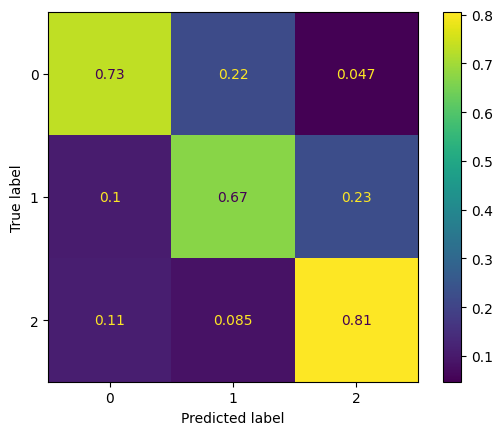

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.58200. Saving Model!
epoch 01, loss: 0.63181, acc: 0.72873, val_loss: 0.58200, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 02, loss: 0.62467, acc: 0.73335, val_loss: 0.58819, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.76it/s]


epoch 03, loss: 0.62562, acc: 0.73089, val_loss: 0.59122, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 04, loss: 0.62143, acc: 0.73407, val_loss: 0.59327, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 05, loss: 0.62203, acc: 0.73350, val_loss: 0.59541, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 06, loss: 0.62059, acc: 0.73455, val_loss: 0.59816, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.39it/s]


epoch 07, loss: 0.61993, acc: 0.73549, val_loss: 0.59994, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.59it/s]


epoch 08, loss: 0.61835, acc: 0.73625, val_loss: 0.60112, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 09, loss: 0.61793, acc: 0.73658, val_loss: 0.60197, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 10, loss: 0.61695, acc: 0.73645, val_loss: 0.60315, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 11, loss: 0.61681, acc: 0.73684, val_loss: 0.60420, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 12, loss: 0.61593, acc: 0.73610, val_loss: 0.60509, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 13, loss: 0.61541, acc: 0.73723, val_loss: 0.60593, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 14, loss: 0.61467, acc: 0.73656, val_loss: 0.60684, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 15, loss: 0.61484, acc: 0.73673, val_loss: 0.60765, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


epoch 16, loss: 0.61372, acc: 0.73872, val_loss: 0.60828, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.59it/s]


epoch 17, loss: 0.61390, acc: 0.73900, val_loss: 0.60869, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 18, loss: 0.61263, acc: 0.73931, val_loss: 0.60946, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 19, loss: 0.61288, acc: 0.73941, val_loss: 0.60987, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 20, loss: 0.61197, acc: 0.73981, val_loss: 0.61039, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 21, loss: 0.61195, acc: 0.73963, val_loss: 0.61088, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 22, loss: 0.61102, acc: 0.74011, val_loss: 0.61167, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 23, loss: 0.61124, acc: 0.73996, val_loss: 0.61194, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 24, loss: 0.60997, acc: 0.74061, val_loss: 0.61242, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 25, loss: 0.61025, acc: 0.74051, val_loss: 0.61298, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


epoch 26, loss: 0.60950, acc: 0.74105, val_loss: 0.61333, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 27, loss: 0.60943, acc: 0.74075, val_loss: 0.61366, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 28, loss: 0.60872, acc: 0.74125, val_loss: 0.61411, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


epoch 29, loss: 0.60868, acc: 0.74114, val_loss: 0.61473, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 30, loss: 0.60804, acc: 0.74149, val_loss: 0.61505, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 31, loss: 0.60814, acc: 0.74151, val_loss: 0.61522, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 32, loss: 0.60697, acc: 0.74205, val_loss: 0.61605, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 33, loss: 0.60721, acc: 0.74195, val_loss: 0.61647, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 34, loss: 0.60668, acc: 0.74232, val_loss: 0.61649, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 35, loss: 0.60635, acc: 0.74227, val_loss: 0.61697, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 36, loss: 0.60587, acc: 0.74240, val_loss: 0.61773, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 37, loss: 0.60530, acc: 0.74315, val_loss: 0.61799, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 38, loss: 0.60548, acc: 0.74280, val_loss: 0.61808, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 39, loss: 0.60473, acc: 0.74373, val_loss: 0.61849, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


epoch 40, loss: 0.60469, acc: 0.74362, val_loss: 0.61883, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 41, loss: 0.60377, acc: 0.74428, val_loss: 0.61950, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 42, loss: 0.60433, acc: 0.74424, val_loss: 0.61940, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 43, loss: 0.60329, acc: 0.74465, val_loss: 0.61984, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 44, loss: 0.60349, acc: 0.74482, val_loss: 0.61978, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 45, loss: 0.60248, acc: 0.74487, val_loss: 0.62037, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 46, loss: 0.60262, acc: 0.74520, val_loss: 0.62044, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 47, loss: 0.60193, acc: 0.74506, val_loss: 0.62091, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 48, loss: 0.60202, acc: 0.74572, val_loss: 0.62094, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 49, loss: 0.60106, acc: 0.74594, val_loss: 0.62149, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 50, loss: 0.60178, acc: 0.74589, val_loss: 0.62141, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 51, loss: 0.60058, acc: 0.74616, val_loss: 0.62202, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 52, loss: 0.60042, acc: 0.74668, val_loss: 0.62211, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 53, loss: 0.60023, acc: 0.74629, val_loss: 0.62241, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 54, loss: 0.60012, acc: 0.74664, val_loss: 0.62271, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


epoch 55, loss: 0.59952, acc: 0.74637, val_loss: 0.62322, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


epoch 56, loss: 0.59933, acc: 0.74720, val_loss: 0.62316, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 57, loss: 0.59891, acc: 0.74731, val_loss: 0.62354, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 58, loss: 0.59868, acc: 0.74712, val_loss: 0.62355, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 59, loss: 0.59806, acc: 0.74794, val_loss: 0.62403, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 60, loss: 0.59818, acc: 0.74792, val_loss: 0.62422, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 61, loss: 0.59757, acc: 0.74801, val_loss: 0.62430, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 62, loss: 0.59737, acc: 0.74847, val_loss: 0.62453, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.50it/s]


epoch 63, loss: 0.59701, acc: 0.74831, val_loss: 0.62508, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


epoch 64, loss: 0.59674, acc: 0.74869, val_loss: 0.62500, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 65, loss: 0.59632, acc: 0.74847, val_loss: 0.62541, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


epoch 66, loss: 0.59644, acc: 0.74875, val_loss: 0.62538, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


epoch 67, loss: 0.59566, acc: 0.74888, val_loss: 0.62575, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 68, loss: 0.59560, acc: 0.74908, val_loss: 0.62621, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 69, loss: 0.59514, acc: 0.74919, val_loss: 0.62630, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 70, loss: 0.59530, acc: 0.74938, val_loss: 0.62616, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 71, loss: 0.59402, acc: 0.74954, val_loss: 0.62683, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 72, loss: 0.59481, acc: 0.74932, val_loss: 0.62674, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 73, loss: 0.59369, acc: 0.74956, val_loss: 0.62711, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 74, loss: 0.59406, acc: 0.74982, val_loss: 0.62718, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 75, loss: 0.59342, acc: 0.74978, val_loss: 0.62732, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 76, loss: 0.59319, acc: 0.75026, val_loss: 0.62740, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 77, loss: 0.59282, acc: 0.75047, val_loss: 0.62774, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 78, loss: 0.59263, acc: 0.75093, val_loss: 0.62795, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 79, loss: 0.59231, acc: 0.75034, val_loss: 0.62814, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 80, loss: 0.59185, acc: 0.75098, val_loss: 0.62832, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 81, loss: 0.59174, acc: 0.75061, val_loss: 0.62853, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 82, loss: 0.59128, acc: 0.75069, val_loss: 0.62870, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 83, loss: 0.59131, acc: 0.75043, val_loss: 0.62880, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 84, loss: 0.59067, acc: 0.75122, val_loss: 0.62883, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 85, loss: 0.59049, acc: 0.75117, val_loss: 0.62907, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.77it/s]


epoch 86, loss: 0.59033, acc: 0.75117, val_loss: 0.62952, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.37it/s]


epoch 87, loss: 0.59014, acc: 0.75102, val_loss: 0.62933, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 88, loss: 0.58967, acc: 0.75157, val_loss: 0.62959, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


epoch 89, loss: 0.58910, acc: 0.75178, val_loss: 0.62983, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


epoch 90, loss: 0.58959, acc: 0.75205, val_loss: 0.63003, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 91, loss: 0.58839, acc: 0.75194, val_loss: 0.63025, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 92, loss: 0.58896, acc: 0.75211, val_loss: 0.62997, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 93, loss: 0.58800, acc: 0.75231, val_loss: 0.63037, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 94, loss: 0.58823, acc: 0.75250, val_loss: 0.63035, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 95, loss: 0.58741, acc: 0.75242, val_loss: 0.63058, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 96, loss: 0.58764, acc: 0.75242, val_loss: 0.63093, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


epoch 97, loss: 0.58714, acc: 0.75213, val_loss: 0.63113, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.35it/s]


epoch 98, loss: 0.58696, acc: 0.75268, val_loss: 0.63084, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 99, loss: 0.58626, acc: 0.75250, val_loss: 0.63142, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.43it/s]


epoch 100, loss: 0.58672, acc: 0.75305, val_loss: 0.63126, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


epoch 101, loss: 0.58592, acc: 0.75252, val_loss: 0.63116, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 102, loss: 0.58572, acc: 0.75290, val_loss: 0.63160, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


epoch 103, loss: 0.58537, acc: 0.75298, val_loss: 0.63208, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


epoch 104, loss: 0.58541, acc: 0.75324, val_loss: 0.63163, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 105, loss: 0.58492, acc: 0.75292, val_loss: 0.63188, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 106, loss: 0.58472, acc: 0.75320, val_loss: 0.63206, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 107, loss: 0.58433, acc: 0.75307, val_loss: 0.63217, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 108, loss: 0.58395, acc: 0.75392, val_loss: 0.63246, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.76it/s]


epoch 109, loss: 0.58373, acc: 0.75335, val_loss: 0.63276, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 110, loss: 0.58399, acc: 0.75353, val_loss: 0.63234, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 111, loss: 0.58284, acc: 0.75342, val_loss: 0.63278, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


epoch 112, loss: 0.58337, acc: 0.75403, val_loss: 0.63273, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 113, loss: 0.58250, acc: 0.75375, val_loss: 0.63287, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 114, loss: 0.58269, acc: 0.75412, val_loss: 0.63286, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


epoch 115, loss: 0.58167, acc: 0.75377, val_loss: 0.63334, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 116, loss: 0.58242, acc: 0.75423, val_loss: 0.63306, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 117, loss: 0.58123, acc: 0.75412, val_loss: 0.63345, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


epoch 118, loss: 0.58159, acc: 0.75512, val_loss: 0.63345, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


epoch 119, loss: 0.58094, acc: 0.75464, val_loss: 0.63352, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 120, loss: 0.58113, acc: 0.75506, val_loss: 0.63368, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


epoch 121, loss: 0.58020, acc: 0.75492, val_loss: 0.63411, val_accuracy: 0.74990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


epoch 122, loss: 0.58067, acc: 0.75514, val_loss: 0.63371, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 123, loss: 0.58012, acc: 0.75479, val_loss: 0.63402, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 124, loss: 0.58003, acc: 0.75551, val_loss: 0.63421, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 125, loss: 0.57955, acc: 0.75501, val_loss: 0.63415, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 126, loss: 0.57980, acc: 0.75530, val_loss: 0.63445, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 127, loss: 0.57885, acc: 0.75519, val_loss: 0.63442, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 128, loss: 0.57926, acc: 0.75545, val_loss: 0.63424, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 129, loss: 0.57830, acc: 0.75519, val_loss: 0.63505, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 130, loss: 0.57873, acc: 0.75560, val_loss: 0.63446, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 131, loss: 0.57780, acc: 0.75527, val_loss: 0.63501, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 132, loss: 0.57788, acc: 0.75597, val_loss: 0.63493, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 133, loss: 0.57738, acc: 0.75564, val_loss: 0.63513, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 134, loss: 0.57731, acc: 0.75615, val_loss: 0.63545, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 135, loss: 0.57660, acc: 0.75573, val_loss: 0.63546, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 136, loss: 0.57714, acc: 0.75617, val_loss: 0.63518, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 137, loss: 0.57595, acc: 0.75599, val_loss: 0.63561, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 138, loss: 0.57634, acc: 0.75634, val_loss: 0.63525, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 139, loss: 0.57578, acc: 0.75617, val_loss: 0.63596, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 140, loss: 0.57607, acc: 0.75628, val_loss: 0.63595, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 141, loss: 0.57544, acc: 0.75602, val_loss: 0.63604, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 142, loss: 0.57520, acc: 0.75719, val_loss: 0.63598, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 143, loss: 0.57514, acc: 0.75647, val_loss: 0.63598, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 144, loss: 0.57451, acc: 0.75652, val_loss: 0.63634, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 145, loss: 0.57451, acc: 0.75639, val_loss: 0.63660, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 146, loss: 0.57439, acc: 0.75673, val_loss: 0.63645, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 147, loss: 0.57422, acc: 0.75634, val_loss: 0.63631, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 148, loss: 0.57363, acc: 0.75761, val_loss: 0.63665, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 149, loss: 0.57351, acc: 0.75678, val_loss: 0.63670, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 150, loss: 0.57321, acc: 0.75785, val_loss: 0.63694, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 151, loss: 0.57278, acc: 0.75682, val_loss: 0.63720, val_accuracy: 0.75265


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 152, loss: 0.57296, acc: 0.75735, val_loss: 0.63691, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 153, loss: 0.57212, acc: 0.75844, val_loss: 0.63738, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 154, loss: 0.57277, acc: 0.75898, val_loss: 0.63727, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 155, loss: 0.57158, acc: 0.75826, val_loss: 0.63753, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 156, loss: 0.57230, acc: 0.75896, val_loss: 0.63770, val_accuracy: 0.75324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 157, loss: 0.57093, acc: 0.75894, val_loss: 0.63771, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 158, loss: 0.57179, acc: 0.75911, val_loss: 0.63752, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 159, loss: 0.57035, acc: 0.75937, val_loss: 0.63817, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 160, loss: 0.57131, acc: 0.75942, val_loss: 0.63780, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 161, loss: 0.57001, acc: 0.75933, val_loss: 0.63832, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 162, loss: 0.57061, acc: 0.75981, val_loss: 0.63812, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 163, loss: 0.56978, acc: 0.75970, val_loss: 0.63826, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 164, loss: 0.57004, acc: 0.75970, val_loss: 0.63814, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 165, loss: 0.56901, acc: 0.76053, val_loss: 0.63831, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 166, loss: 0.56983, acc: 0.75990, val_loss: 0.63837, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.05it/s]


epoch 167, loss: 0.56848, acc: 0.76092, val_loss: 0.63873, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 168, loss: 0.56884, acc: 0.76140, val_loss: 0.63890, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 169, loss: 0.56856, acc: 0.76088, val_loss: 0.63884, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 170, loss: 0.56807, acc: 0.76145, val_loss: 0.63883, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 171, loss: 0.56801, acc: 0.76097, val_loss: 0.63893, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 172, loss: 0.56743, acc: 0.76171, val_loss: 0.63942, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 173, loss: 0.56766, acc: 0.76134, val_loss: 0.63889, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 174, loss: 0.56725, acc: 0.76171, val_loss: 0.63937, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 175, loss: 0.56716, acc: 0.76114, val_loss: 0.63927, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.64it/s]


epoch 176, loss: 0.56692, acc: 0.76169, val_loss: 0.63958, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 177, loss: 0.56657, acc: 0.76156, val_loss: 0.63938, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 178, loss: 0.56660, acc: 0.76201, val_loss: 0.63945, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 179, loss: 0.56566, acc: 0.76160, val_loss: 0.64012, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 180, loss: 0.56629, acc: 0.76201, val_loss: 0.63962, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 181, loss: 0.56518, acc: 0.76182, val_loss: 0.64013, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.05it/s]


epoch 182, loss: 0.56608, acc: 0.76195, val_loss: 0.63990, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 183, loss: 0.56454, acc: 0.76212, val_loss: 0.64010, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 184, loss: 0.56560, acc: 0.76110, val_loss: 0.64022, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 185, loss: 0.56377, acc: 0.76247, val_loss: 0.64072, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 186, loss: 0.56543, acc: 0.76136, val_loss: 0.64006, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 187, loss: 0.56329, acc: 0.76273, val_loss: 0.64072, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 188, loss: 0.56444, acc: 0.76164, val_loss: 0.64060, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 189, loss: 0.56338, acc: 0.76243, val_loss: 0.64116, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 190, loss: 0.56367, acc: 0.76286, val_loss: 0.64084, val_accuracy: 0.75697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 191, loss: 0.56288, acc: 0.76286, val_loss: 0.64102, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 192, loss: 0.56302, acc: 0.76304, val_loss: 0.64103, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 193, loss: 0.56235, acc: 0.76308, val_loss: 0.64115, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 194, loss: 0.56250, acc: 0.76382, val_loss: 0.64117, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 195, loss: 0.56164, acc: 0.76341, val_loss: 0.64162, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 196, loss: 0.56263, acc: 0.76339, val_loss: 0.64124, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 197, loss: 0.56084, acc: 0.76343, val_loss: 0.64198, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 198, loss: 0.56187, acc: 0.76348, val_loss: 0.64169, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 199, loss: 0.56070, acc: 0.76339, val_loss: 0.64202, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 200, loss: 0.56133, acc: 0.76365, val_loss: 0.64175, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 201, loss: 0.56026, acc: 0.76356, val_loss: 0.64234, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 202, loss: 0.56069, acc: 0.76276, val_loss: 0.64216, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 203, loss: 0.55972, acc: 0.76369, val_loss: 0.64257, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 204, loss: 0.56030, acc: 0.76398, val_loss: 0.64206, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 205, loss: 0.55895, acc: 0.76406, val_loss: 0.64265, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 206, loss: 0.56035, acc: 0.76291, val_loss: 0.64283, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 207, loss: 0.55864, acc: 0.76393, val_loss: 0.64316, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


epoch 208, loss: 0.55960, acc: 0.76306, val_loss: 0.64231, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 209, loss: 0.55806, acc: 0.76446, val_loss: 0.64316, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 210, loss: 0.55911, acc: 0.76439, val_loss: 0.64296, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 211, loss: 0.55786, acc: 0.76400, val_loss: 0.64349, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 212, loss: 0.55847, acc: 0.76350, val_loss: 0.64325, val_accuracy: 0.74558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.78it/s]


epoch 213, loss: 0.55766, acc: 0.76422, val_loss: 0.64371, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 214, loss: 0.55821, acc: 0.76356, val_loss: 0.64375, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.45it/s]


epoch 215, loss: 0.55693, acc: 0.76448, val_loss: 0.64337, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 216, loss: 0.55799, acc: 0.76343, val_loss: 0.64341, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 217, loss: 0.55613, acc: 0.76461, val_loss: 0.64425, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 218, loss: 0.55726, acc: 0.76409, val_loss: 0.64382, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 219, loss: 0.55595, acc: 0.76505, val_loss: 0.64418, val_accuracy: 0.74185


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 220, loss: 0.55666, acc: 0.76511, val_loss: 0.64403, val_accuracy: 0.74166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 221, loss: 0.55528, acc: 0.76542, val_loss: 0.64453, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 222, loss: 0.55641, acc: 0.76424, val_loss: 0.64404, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 223, loss: 0.55489, acc: 0.76498, val_loss: 0.64452, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 224, loss: 0.55576, acc: 0.76444, val_loss: 0.64427, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 225, loss: 0.55415, acc: 0.76577, val_loss: 0.64473, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 226, loss: 0.55560, acc: 0.76459, val_loss: 0.64430, val_accuracy: 0.74205


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 227, loss: 0.55397, acc: 0.76614, val_loss: 0.64489, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 228, loss: 0.55478, acc: 0.76465, val_loss: 0.64452, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 229, loss: 0.55342, acc: 0.76633, val_loss: 0.64536, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 230, loss: 0.55436, acc: 0.76603, val_loss: 0.64457, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 231, loss: 0.55303, acc: 0.76673, val_loss: 0.64484, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 232, loss: 0.55375, acc: 0.76587, val_loss: 0.64549, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 233, loss: 0.55264, acc: 0.76666, val_loss: 0.64543, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 234, loss: 0.55354, acc: 0.76681, val_loss: 0.64484, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 235, loss: 0.55224, acc: 0.76692, val_loss: 0.64581, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 236, loss: 0.55279, acc: 0.76614, val_loss: 0.64523, val_accuracy: 0.74225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 237, loss: 0.55183, acc: 0.76712, val_loss: 0.64576, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 238, loss: 0.55251, acc: 0.76609, val_loss: 0.64543, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 239, loss: 0.55107, acc: 0.76753, val_loss: 0.64587, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 240, loss: 0.55235, acc: 0.76629, val_loss: 0.64532, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 241, loss: 0.55057, acc: 0.76771, val_loss: 0.64599, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 242, loss: 0.55166, acc: 0.76777, val_loss: 0.64579, val_accuracy: 0.74244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 243, loss: 0.55043, acc: 0.76801, val_loss: 0.64614, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 244, loss: 0.55165, acc: 0.76677, val_loss: 0.64552, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 245, loss: 0.54962, acc: 0.76803, val_loss: 0.64643, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 246, loss: 0.55092, acc: 0.76690, val_loss: 0.64592, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 247, loss: 0.54961, acc: 0.76819, val_loss: 0.64629, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 248, loss: 0.55021, acc: 0.76729, val_loss: 0.64605, val_accuracy: 0.74264


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 249, loss: 0.54910, acc: 0.76832, val_loss: 0.64669, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


epoch 250, loss: 0.55006, acc: 0.76721, val_loss: 0.64607, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 251, loss: 0.54831, acc: 0.76891, val_loss: 0.64662, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 252, loss: 0.54964, acc: 0.76779, val_loss: 0.64644, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 253, loss: 0.54792, acc: 0.76862, val_loss: 0.64716, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 254, loss: 0.54933, acc: 0.76751, val_loss: 0.64628, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 255, loss: 0.54744, acc: 0.76904, val_loss: 0.64684, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 256, loss: 0.54840, acc: 0.76803, val_loss: 0.64667, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 257, loss: 0.54717, acc: 0.76932, val_loss: 0.64683, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 258, loss: 0.54779, acc: 0.76799, val_loss: 0.64651, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 259, loss: 0.54647, acc: 0.76910, val_loss: 0.64713, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 260, loss: 0.54750, acc: 0.76838, val_loss: 0.64671, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 261, loss: 0.54637, acc: 0.76952, val_loss: 0.64695, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 262, loss: 0.54702, acc: 0.77035, val_loss: 0.64687, val_accuracy: 0.74323


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 263, loss: 0.54565, acc: 0.76978, val_loss: 0.64716, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


epoch 264, loss: 0.54668, acc: 0.76880, val_loss: 0.64698, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 265, loss: 0.54528, acc: 0.77100, val_loss: 0.64714, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 266, loss: 0.54628, acc: 0.77002, val_loss: 0.64712, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 267, loss: 0.54462, acc: 0.77159, val_loss: 0.64727, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 268, loss: 0.54645, acc: 0.76858, val_loss: 0.64698, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 269, loss: 0.54379, acc: 0.77179, val_loss: 0.64775, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 270, loss: 0.54607, acc: 0.76906, val_loss: 0.64709, val_accuracy: 0.74342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 271, loss: 0.54356, acc: 0.77181, val_loss: 0.64788, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 272, loss: 0.54541, acc: 0.77052, val_loss: 0.64744, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.81it/s]


epoch 273, loss: 0.54288, acc: 0.77238, val_loss: 0.64823, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 274, loss: 0.54519, acc: 0.77074, val_loss: 0.64708, val_accuracy: 0.74303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 275, loss: 0.54229, acc: 0.77238, val_loss: 0.64874, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 276, loss: 0.54490, acc: 0.76974, val_loss: 0.64738, val_accuracy: 0.74362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 277, loss: 0.54205, acc: 0.77292, val_loss: 0.64820, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 278, loss: 0.54424, acc: 0.77013, val_loss: 0.64764, val_accuracy: 0.74283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 279, loss: 0.54149, acc: 0.77323, val_loss: 0.64870, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 280, loss: 0.54382, acc: 0.77048, val_loss: 0.64785, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 281, loss: 0.54157, acc: 0.77314, val_loss: 0.64868, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 282, loss: 0.54338, acc: 0.77187, val_loss: 0.64791, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 283, loss: 0.54070, acc: 0.77427, val_loss: 0.64831, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 284, loss: 0.54310, acc: 0.77266, val_loss: 0.64860, val_accuracy: 0.74499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 285, loss: 0.54048, acc: 0.77571, val_loss: 0.64896, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 286, loss: 0.54251, acc: 0.77242, val_loss: 0.64790, val_accuracy: 0.74401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 287, loss: 0.53985, acc: 0.77471, val_loss: 0.64930, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 288, loss: 0.54209, acc: 0.77312, val_loss: 0.64850, val_accuracy: 0.74421


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 289, loss: 0.53935, acc: 0.77656, val_loss: 0.64907, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 290, loss: 0.54164, acc: 0.77379, val_loss: 0.64827, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 291, loss: 0.53892, acc: 0.77626, val_loss: 0.64936, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 292, loss: 0.54143, acc: 0.77307, val_loss: 0.64894, val_accuracy: 0.74441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 293, loss: 0.53865, acc: 0.77637, val_loss: 0.64964, val_accuracy: 0.74460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 294, loss: 0.54100, acc: 0.77327, val_loss: 0.64865, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 295, loss: 0.53797, acc: 0.77676, val_loss: 0.64943, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 296, loss: 0.54109, acc: 0.77323, val_loss: 0.64873, val_accuracy: 0.74382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 297, loss: 0.53747, acc: 0.77774, val_loss: 0.64994, val_accuracy: 0.74519


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 298, loss: 0.54045, acc: 0.77360, val_loss: 0.64863, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 299, loss: 0.53714, acc: 0.77726, val_loss: 0.64976, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 300, loss: 0.54016, acc: 0.77360, val_loss: 0.64896, val_accuracy: 0.74480


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 301, loss: 0.53618, acc: 0.77901, val_loss: 0.65040, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 302, loss: 0.53983, acc: 0.77434, val_loss: 0.64928, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.81it/s]


epoch 303, loss: 0.53631, acc: 0.77765, val_loss: 0.65064, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 304, loss: 0.53916, acc: 0.77602, val_loss: 0.64902, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 305, loss: 0.53533, acc: 0.77946, val_loss: 0.65062, val_accuracy: 0.74578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 306, loss: 0.53893, acc: 0.77545, val_loss: 0.64916, val_accuracy: 0.74539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 307, loss: 0.53504, acc: 0.77944, val_loss: 0.65064, val_accuracy: 0.74598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.64it/s]


epoch 308, loss: 0.53824, acc: 0.77621, val_loss: 0.64956, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.68it/s]


epoch 309, loss: 0.53493, acc: 0.77929, val_loss: 0.65055, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 310, loss: 0.53780, acc: 0.77674, val_loss: 0.64960, val_accuracy: 0.74637


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 311, loss: 0.53450, acc: 0.77949, val_loss: 0.65118, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.57it/s]


epoch 312, loss: 0.53723, acc: 0.77685, val_loss: 0.65005, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 313, loss: 0.53430, acc: 0.77951, val_loss: 0.65121, val_accuracy: 0.74656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 314, loss: 0.53657, acc: 0.77696, val_loss: 0.65039, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 315, loss: 0.53419, acc: 0.77951, val_loss: 0.65107, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 316, loss: 0.53587, acc: 0.77715, val_loss: 0.65025, val_accuracy: 0.74617


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 317, loss: 0.53342, acc: 0.77977, val_loss: 0.65158, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 318, loss: 0.53579, acc: 0.77761, val_loss: 0.65070, val_accuracy: 0.74696


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 319, loss: 0.53334, acc: 0.77994, val_loss: 0.65096, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 320, loss: 0.53491, acc: 0.77874, val_loss: 0.65071, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 321, loss: 0.53268, acc: 0.78034, val_loss: 0.65122, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 322, loss: 0.53448, acc: 0.77820, val_loss: 0.65095, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 323, loss: 0.53253, acc: 0.77955, val_loss: 0.65141, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 324, loss: 0.53390, acc: 0.77957, val_loss: 0.65070, val_accuracy: 0.74735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.76it/s]


epoch 325, loss: 0.53184, acc: 0.78099, val_loss: 0.65181, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 326, loss: 0.53408, acc: 0.77944, val_loss: 0.65057, val_accuracy: 0.74676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 327, loss: 0.53147, acc: 0.78149, val_loss: 0.65177, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 328, loss: 0.53324, acc: 0.77949, val_loss: 0.65141, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 329, loss: 0.53124, acc: 0.78130, val_loss: 0.65145, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 330, loss: 0.53312, acc: 0.77846, val_loss: 0.65072, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 331, loss: 0.53026, acc: 0.78158, val_loss: 0.65175, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 332, loss: 0.53314, acc: 0.77896, val_loss: 0.65131, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 333, loss: 0.52980, acc: 0.78195, val_loss: 0.65228, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 334, loss: 0.53274, acc: 0.77901, val_loss: 0.65096, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 335, loss: 0.52923, acc: 0.78206, val_loss: 0.65294, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 336, loss: 0.53254, acc: 0.77892, val_loss: 0.65101, val_accuracy: 0.74715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 337, loss: 0.52915, acc: 0.78197, val_loss: 0.65191, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 338, loss: 0.53208, acc: 0.77909, val_loss: 0.65110, val_accuracy: 0.74755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 339, loss: 0.52849, acc: 0.78221, val_loss: 0.65259, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 340, loss: 0.53201, acc: 0.77951, val_loss: 0.65156, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 341, loss: 0.52812, acc: 0.78252, val_loss: 0.65227, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 342, loss: 0.53169, acc: 0.77955, val_loss: 0.65125, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 343, loss: 0.52751, acc: 0.78304, val_loss: 0.65306, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 344, loss: 0.53106, acc: 0.78012, val_loss: 0.65137, val_accuracy: 0.74833


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 345, loss: 0.52695, acc: 0.78293, val_loss: 0.65268, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 346, loss: 0.53103, acc: 0.77975, val_loss: 0.65150, val_accuracy: 0.74794


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 347, loss: 0.52622, acc: 0.78328, val_loss: 0.65320, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 348, loss: 0.53119, acc: 0.77994, val_loss: 0.65100, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 349, loss: 0.52543, acc: 0.78346, val_loss: 0.65358, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 350, loss: 0.53045, acc: 0.78034, val_loss: 0.65168, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 351, loss: 0.52576, acc: 0.78330, val_loss: 0.65296, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 352, loss: 0.52955, acc: 0.78038, val_loss: 0.65147, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 353, loss: 0.52517, acc: 0.78350, val_loss: 0.65349, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 354, loss: 0.52915, acc: 0.78060, val_loss: 0.65184, val_accuracy: 0.74774


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 355, loss: 0.52510, acc: 0.78372, val_loss: 0.65340, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 356, loss: 0.52849, acc: 0.78062, val_loss: 0.65149, val_accuracy: 0.74872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 357, loss: 0.52436, acc: 0.78365, val_loss: 0.65329, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.23it/s]


epoch 358, loss: 0.52779, acc: 0.78099, val_loss: 0.65231, val_accuracy: 0.74814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 359, loss: 0.52462, acc: 0.78370, val_loss: 0.65318, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


epoch 360, loss: 0.52699, acc: 0.78138, val_loss: 0.65258, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 361, loss: 0.52433, acc: 0.78422, val_loss: 0.65300, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 362, loss: 0.52677, acc: 0.78117, val_loss: 0.65254, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


epoch 363, loss: 0.52380, acc: 0.78435, val_loss: 0.65340, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 364, loss: 0.52629, acc: 0.78213, val_loss: 0.65268, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 365, loss: 0.52362, acc: 0.78477, val_loss: 0.65345, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 366, loss: 0.52600, acc: 0.78319, val_loss: 0.65267, val_accuracy: 0.74892


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 367, loss: 0.52268, acc: 0.78507, val_loss: 0.65356, val_accuracy: 0.74971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 368, loss: 0.52595, acc: 0.78237, val_loss: 0.65270, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 369, loss: 0.52247, acc: 0.78481, val_loss: 0.65354, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]


epoch 370, loss: 0.52525, acc: 0.78265, val_loss: 0.65242, val_accuracy: 0.74912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


epoch 371, loss: 0.52206, acc: 0.78520, val_loss: 0.65400, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 372, loss: 0.52486, acc: 0.78252, val_loss: 0.65254, val_accuracy: 0.74931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 373, loss: 0.52149, acc: 0.78586, val_loss: 0.65360, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.50it/s]


epoch 374, loss: 0.52452, acc: 0.78405, val_loss: 0.65255, val_accuracy: 0.75049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 375, loss: 0.52122, acc: 0.78549, val_loss: 0.65397, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 376, loss: 0.52394, acc: 0.78324, val_loss: 0.65283, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.02it/s]


epoch 377, loss: 0.52114, acc: 0.78588, val_loss: 0.65390, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


epoch 378, loss: 0.52379, acc: 0.78324, val_loss: 0.65312, val_accuracy: 0.75010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 379, loss: 0.52027, acc: 0.78610, val_loss: 0.65426, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


epoch 380, loss: 0.52373, acc: 0.78322, val_loss: 0.65350, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 381, loss: 0.51984, acc: 0.78618, val_loss: 0.65424, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 382, loss: 0.52388, acc: 0.78326, val_loss: 0.65280, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 383, loss: 0.51876, acc: 0.78695, val_loss: 0.65494, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 384, loss: 0.52347, acc: 0.78365, val_loss: 0.65309, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 385, loss: 0.51862, acc: 0.78658, val_loss: 0.65459, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 386, loss: 0.52329, acc: 0.78335, val_loss: 0.65244, val_accuracy: 0.74951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 387, loss: 0.51804, acc: 0.78682, val_loss: 0.65504, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 388, loss: 0.52264, acc: 0.78411, val_loss: 0.65311, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 389, loss: 0.51787, acc: 0.78727, val_loss: 0.65416, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 390, loss: 0.52249, acc: 0.78374, val_loss: 0.65302, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 391, loss: 0.51720, acc: 0.78743, val_loss: 0.65445, val_accuracy: 0.75029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 392, loss: 0.52170, acc: 0.78429, val_loss: 0.65260, val_accuracy: 0.75167


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 393, loss: 0.51715, acc: 0.78723, val_loss: 0.65483, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 394, loss: 0.52110, acc: 0.78455, val_loss: 0.65243, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 395, loss: 0.51675, acc: 0.78764, val_loss: 0.65467, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.92it/s]


epoch 396, loss: 0.52040, acc: 0.78479, val_loss: 0.65303, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


epoch 397, loss: 0.51669, acc: 0.78738, val_loss: 0.65446, val_accuracy: 0.75069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


epoch 398, loss: 0.51987, acc: 0.78494, val_loss: 0.65323, val_accuracy: 0.75088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 399, loss: 0.51632, acc: 0.78780, val_loss: 0.65499, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


epoch 400, loss: 0.51978, acc: 0.78507, val_loss: 0.65379, val_accuracy: 0.75108


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 401, loss: 0.51599, acc: 0.78815, val_loss: 0.65463, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 402, loss: 0.51975, acc: 0.78498, val_loss: 0.65336, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 403, loss: 0.51501, acc: 0.78900, val_loss: 0.65514, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 404, loss: 0.51908, acc: 0.78544, val_loss: 0.65323, val_accuracy: 0.75147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 405, loss: 0.51529, acc: 0.78915, val_loss: 0.65474, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.16it/s]


epoch 406, loss: 0.51812, acc: 0.78544, val_loss: 0.65393, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


epoch 407, loss: 0.51486, acc: 0.78932, val_loss: 0.65484, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 408, loss: 0.51823, acc: 0.78636, val_loss: 0.65387, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.22it/s]


epoch 409, loss: 0.51427, acc: 0.78930, val_loss: 0.65514, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.90it/s]


epoch 410, loss: 0.51759, acc: 0.78629, val_loss: 0.65370, val_accuracy: 0.75128


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 411, loss: 0.51418, acc: 0.79042, val_loss: 0.65521, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.68it/s]


epoch 412, loss: 0.51756, acc: 0.78651, val_loss: 0.65396, val_accuracy: 0.75226


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 413, loss: 0.51319, acc: 0.79050, val_loss: 0.65540, val_accuracy: 0.75206


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 414, loss: 0.51780, acc: 0.78651, val_loss: 0.65391, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 415, loss: 0.51261, acc: 0.79087, val_loss: 0.65589, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 416, loss: 0.51774, acc: 0.78599, val_loss: 0.65365, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 417, loss: 0.51223, acc: 0.79100, val_loss: 0.65602, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


epoch 418, loss: 0.51726, acc: 0.78668, val_loss: 0.65431, val_accuracy: 0.75245


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 419, loss: 0.51211, acc: 0.79113, val_loss: 0.65592, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 420, loss: 0.51650, acc: 0.78679, val_loss: 0.65410, val_accuracy: 0.75186


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


epoch 421, loss: 0.51188, acc: 0.79140, val_loss: 0.65618, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 422, loss: 0.51607, acc: 0.78703, val_loss: 0.65428, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.36it/s]


epoch 423, loss: 0.51134, acc: 0.79144, val_loss: 0.65572, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


epoch 424, loss: 0.51606, acc: 0.78738, val_loss: 0.65428, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 425, loss: 0.51099, acc: 0.79166, val_loss: 0.65579, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 426, loss: 0.51528, acc: 0.78740, val_loss: 0.65453, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 427, loss: 0.51051, acc: 0.79225, val_loss: 0.65599, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 428, loss: 0.51496, acc: 0.78802, val_loss: 0.65466, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 429, loss: 0.51066, acc: 0.79153, val_loss: 0.65620, val_accuracy: 0.75383


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 430, loss: 0.51426, acc: 0.78773, val_loss: 0.65468, val_accuracy: 0.75304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.03it/s]


epoch 431, loss: 0.50992, acc: 0.79249, val_loss: 0.65615, val_accuracy: 0.75461


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.22it/s]


epoch 432, loss: 0.51420, acc: 0.78893, val_loss: 0.65455, val_accuracy: 0.75285


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.28it/s]


epoch 433, loss: 0.50956, acc: 0.79266, val_loss: 0.65638, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 434, loss: 0.51357, acc: 0.78917, val_loss: 0.65478, val_accuracy: 0.75363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.10it/s]


epoch 435, loss: 0.50933, acc: 0.79268, val_loss: 0.65591, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


epoch 436, loss: 0.51285, acc: 0.78898, val_loss: 0.65568, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 437, loss: 0.50899, acc: 0.79249, val_loss: 0.65649, val_accuracy: 0.75520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.44it/s]


epoch 438, loss: 0.51335, acc: 0.78817, val_loss: 0.65457, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 439, loss: 0.50816, acc: 0.79290, val_loss: 0.65708, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 440, loss: 0.51296, acc: 0.78898, val_loss: 0.65516, val_accuracy: 0.75344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 441, loss: 0.50813, acc: 0.79319, val_loss: 0.65683, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 442, loss: 0.51256, acc: 0.78898, val_loss: 0.65541, val_accuracy: 0.75442


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.39it/s]


epoch 443, loss: 0.50740, acc: 0.79345, val_loss: 0.65712, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 444, loss: 0.51257, acc: 0.78860, val_loss: 0.65511, val_accuracy: 0.75402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 445, loss: 0.50719, acc: 0.79345, val_loss: 0.65695, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 446, loss: 0.51162, acc: 0.78954, val_loss: 0.65516, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 447, loss: 0.50729, acc: 0.79377, val_loss: 0.65676, val_accuracy: 0.75501


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 448, loss: 0.51125, acc: 0.79011, val_loss: 0.65570, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 449, loss: 0.50632, acc: 0.79423, val_loss: 0.65690, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 450, loss: 0.51139, acc: 0.79018, val_loss: 0.65518, val_accuracy: 0.75422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 451, loss: 0.50602, acc: 0.79386, val_loss: 0.65677, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 452, loss: 0.51095, acc: 0.78952, val_loss: 0.65480, val_accuracy: 0.75481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 453, loss: 0.50544, acc: 0.79467, val_loss: 0.65682, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 454, loss: 0.51042, acc: 0.79083, val_loss: 0.65546, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 455, loss: 0.50566, acc: 0.79432, val_loss: 0.65703, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 456, loss: 0.50972, acc: 0.79087, val_loss: 0.65555, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 457, loss: 0.50496, acc: 0.79465, val_loss: 0.65709, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 458, loss: 0.50957, acc: 0.79087, val_loss: 0.65497, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 459, loss: 0.50457, acc: 0.79497, val_loss: 0.65714, val_accuracy: 0.75579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 460, loss: 0.50885, acc: 0.79116, val_loss: 0.65533, val_accuracy: 0.75540


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.90it/s]


epoch 461, loss: 0.50479, acc: 0.79463, val_loss: 0.65729, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 462, loss: 0.50840, acc: 0.79144, val_loss: 0.65531, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 463, loss: 0.50407, acc: 0.79478, val_loss: 0.65707, val_accuracy: 0.75638


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


epoch 464, loss: 0.50805, acc: 0.79151, val_loss: 0.65508, val_accuracy: 0.75599


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.31it/s]


epoch 465, loss: 0.50368, acc: 0.79580, val_loss: 0.65742, val_accuracy: 0.75559


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 466, loss: 0.50799, acc: 0.79116, val_loss: 0.65499, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.10it/s]


epoch 467, loss: 0.50298, acc: 0.79604, val_loss: 0.65712, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.37it/s]


epoch 468, loss: 0.50771, acc: 0.79166, val_loss: 0.65587, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 469, loss: 0.50338, acc: 0.79521, val_loss: 0.65711, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 470, loss: 0.50711, acc: 0.79194, val_loss: 0.65577, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 471, loss: 0.50221, acc: 0.79569, val_loss: 0.65737, val_accuracy: 0.75618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 472, loss: 0.50749, acc: 0.79161, val_loss: 0.65556, val_accuracy: 0.75658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 473, loss: 0.50187, acc: 0.79635, val_loss: 0.65763, val_accuracy: 0.75677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


epoch 474, loss: 0.50691, acc: 0.79179, val_loss: 0.65572, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 475, loss: 0.50138, acc: 0.79587, val_loss: 0.65772, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 476, loss: 0.50674, acc: 0.79268, val_loss: 0.65540, val_accuracy: 0.75717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 477, loss: 0.50102, acc: 0.79681, val_loss: 0.65815, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 478, loss: 0.50649, acc: 0.79238, val_loss: 0.65515, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 479, loss: 0.50077, acc: 0.79676, val_loss: 0.65814, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 480, loss: 0.50566, acc: 0.79244, val_loss: 0.65549, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 481, loss: 0.50062, acc: 0.79678, val_loss: 0.65793, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 482, loss: 0.50520, acc: 0.79308, val_loss: 0.65634, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.10it/s]


epoch 483, loss: 0.50064, acc: 0.79615, val_loss: 0.65725, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 484, loss: 0.50443, acc: 0.79412, val_loss: 0.65585, val_accuracy: 0.75736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


epoch 485, loss: 0.50005, acc: 0.79694, val_loss: 0.65797, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


epoch 486, loss: 0.50450, acc: 0.79288, val_loss: 0.65586, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 487, loss: 0.49956, acc: 0.79663, val_loss: 0.65749, val_accuracy: 0.75775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 488, loss: 0.50436, acc: 0.79347, val_loss: 0.65603, val_accuracy: 0.75756


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


epoch 489, loss: 0.49899, acc: 0.79768, val_loss: 0.65800, val_accuracy: 0.75834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 490, loss: 0.50375, acc: 0.79434, val_loss: 0.65615, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 491, loss: 0.49868, acc: 0.79737, val_loss: 0.65790, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 492, loss: 0.50341, acc: 0.79364, val_loss: 0.65629, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 493, loss: 0.49862, acc: 0.79805, val_loss: 0.65780, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 494, loss: 0.50283, acc: 0.79500, val_loss: 0.65625, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 495, loss: 0.49847, acc: 0.79838, val_loss: 0.65788, val_accuracy: 0.75795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 496, loss: 0.50260, acc: 0.79528, val_loss: 0.65613, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 497, loss: 0.49801, acc: 0.79836, val_loss: 0.65784, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 498, loss: 0.50272, acc: 0.79521, val_loss: 0.65639, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 499, loss: 0.49741, acc: 0.79881, val_loss: 0.65845, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 500, loss: 0.50280, acc: 0.79517, val_loss: 0.65600, val_accuracy: 0.75815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 501, loss: 0.49644, acc: 0.79910, val_loss: 0.65876, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 502, loss: 0.50253, acc: 0.79548, val_loss: 0.65582, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 503, loss: 0.49653, acc: 0.79916, val_loss: 0.65870, val_accuracy: 0.75854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 504, loss: 0.50182, acc: 0.79585, val_loss: 0.65582, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 505, loss: 0.49592, acc: 0.79916, val_loss: 0.65832, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 506, loss: 0.50177, acc: 0.79526, val_loss: 0.65605, val_accuracy: 0.75874


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 507, loss: 0.49561, acc: 0.79953, val_loss: 0.65799, val_accuracy: 0.75893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 508, loss: 0.50074, acc: 0.79593, val_loss: 0.65651, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 509, loss: 0.49592, acc: 0.79894, val_loss: 0.65810, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 510, loss: 0.50012, acc: 0.79641, val_loss: 0.65635, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 511, loss: 0.49535, acc: 0.79949, val_loss: 0.65822, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 512, loss: 0.50053, acc: 0.79545, val_loss: 0.65675, val_accuracy: 0.75932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 513, loss: 0.49490, acc: 0.79988, val_loss: 0.65812, val_accuracy: 0.75952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 514, loss: 0.49977, acc: 0.79665, val_loss: 0.65632, val_accuracy: 0.75952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 515, loss: 0.49453, acc: 0.79982, val_loss: 0.65838, val_accuracy: 0.75913


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 516, loss: 0.49983, acc: 0.79672, val_loss: 0.65662, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 517, loss: 0.49394, acc: 0.79993, val_loss: 0.65883, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 518, loss: 0.49972, acc: 0.79685, val_loss: 0.65601, val_accuracy: 0.75991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 519, loss: 0.49368, acc: 0.80027, val_loss: 0.65874, val_accuracy: 0.76031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 520, loss: 0.49904, acc: 0.79716, val_loss: 0.65648, val_accuracy: 0.75991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 521, loss: 0.49362, acc: 0.80038, val_loss: 0.65809, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 522, loss: 0.49839, acc: 0.79733, val_loss: 0.65666, val_accuracy: 0.75972


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 523, loss: 0.49308, acc: 0.80032, val_loss: 0.65865, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 524, loss: 0.49856, acc: 0.79709, val_loss: 0.65623, val_accuracy: 0.75952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 525, loss: 0.49246, acc: 0.80075, val_loss: 0.65877, val_accuracy: 0.75991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 526, loss: 0.49798, acc: 0.79766, val_loss: 0.65724, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 527, loss: 0.49274, acc: 0.80030, val_loss: 0.65858, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 528, loss: 0.49783, acc: 0.79707, val_loss: 0.65656, val_accuracy: 0.76463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 529, loss: 0.49180, acc: 0.80080, val_loss: 0.65891, val_accuracy: 0.76109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 530, loss: 0.49765, acc: 0.79774, val_loss: 0.65643, val_accuracy: 0.76031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 531, loss: 0.49175, acc: 0.80069, val_loss: 0.65907, val_accuracy: 0.76109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 532, loss: 0.49682, acc: 0.79755, val_loss: 0.65635, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 533, loss: 0.49184, acc: 0.80069, val_loss: 0.65898, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 534, loss: 0.49631, acc: 0.79833, val_loss: 0.65674, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 535, loss: 0.49187, acc: 0.80167, val_loss: 0.65858, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 536, loss: 0.49539, acc: 0.79866, val_loss: 0.65709, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 537, loss: 0.49187, acc: 0.80134, val_loss: 0.65854, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 538, loss: 0.49498, acc: 0.79951, val_loss: 0.65669, val_accuracy: 0.76109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 539, loss: 0.49174, acc: 0.80121, val_loss: 0.65852, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 540, loss: 0.49421, acc: 0.80010, val_loss: 0.65736, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 541, loss: 0.49144, acc: 0.80152, val_loss: 0.65842, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 542, loss: 0.49374, acc: 0.80027, val_loss: 0.65796, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


epoch 543, loss: 0.49120, acc: 0.80152, val_loss: 0.65801, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 544, loss: 0.49323, acc: 0.80017, val_loss: 0.65762, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 545, loss: 0.49032, acc: 0.80174, val_loss: 0.65847, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 546, loss: 0.49288, acc: 0.80049, val_loss: 0.65768, val_accuracy: 0.76148


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 547, loss: 0.49029, acc: 0.80171, val_loss: 0.65896, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


epoch 548, loss: 0.49265, acc: 0.80073, val_loss: 0.65740, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 549, loss: 0.48951, acc: 0.80217, val_loss: 0.65833, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 550, loss: 0.49260, acc: 0.80054, val_loss: 0.65798, val_accuracy: 0.76109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 551, loss: 0.48910, acc: 0.80230, val_loss: 0.65867, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 552, loss: 0.49235, acc: 0.79977, val_loss: 0.65759, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 553, loss: 0.48854, acc: 0.80239, val_loss: 0.65906, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 554, loss: 0.49188, acc: 0.80108, val_loss: 0.65781, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 555, loss: 0.48859, acc: 0.80254, val_loss: 0.65890, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


epoch 556, loss: 0.49126, acc: 0.80003, val_loss: 0.65796, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 557, loss: 0.48832, acc: 0.80243, val_loss: 0.65858, val_accuracy: 0.76207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 558, loss: 0.49104, acc: 0.80154, val_loss: 0.65757, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 559, loss: 0.48801, acc: 0.80233, val_loss: 0.65887, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 560, loss: 0.49052, acc: 0.80130, val_loss: 0.65759, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 561, loss: 0.48800, acc: 0.80276, val_loss: 0.65848, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 562, loss: 0.49015, acc: 0.80193, val_loss: 0.65804, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


epoch 563, loss: 0.48752, acc: 0.80291, val_loss: 0.65924, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 564, loss: 0.48963, acc: 0.80187, val_loss: 0.65778, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 565, loss: 0.48758, acc: 0.80281, val_loss: 0.65874, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 566, loss: 0.48900, acc: 0.80224, val_loss: 0.65808, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 567, loss: 0.48732, acc: 0.80320, val_loss: 0.65869, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 568, loss: 0.48906, acc: 0.80169, val_loss: 0.65821, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 569, loss: 0.48714, acc: 0.80359, val_loss: 0.65872, val_accuracy: 0.76305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 570, loss: 0.48879, acc: 0.80213, val_loss: 0.65826, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 571, loss: 0.48688, acc: 0.80331, val_loss: 0.65878, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 572, loss: 0.48886, acc: 0.80195, val_loss: 0.65865, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 573, loss: 0.48643, acc: 0.80261, val_loss: 0.65831, val_accuracy: 0.76325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 574, loss: 0.48809, acc: 0.80252, val_loss: 0.65836, val_accuracy: 0.76384


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 575, loss: 0.48596, acc: 0.80400, val_loss: 0.65862, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 576, loss: 0.48728, acc: 0.80322, val_loss: 0.65856, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 577, loss: 0.48525, acc: 0.80398, val_loss: 0.65877, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 578, loss: 0.48718, acc: 0.80305, val_loss: 0.65834, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 579, loss: 0.48471, acc: 0.80455, val_loss: 0.65887, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 580, loss: 0.48720, acc: 0.80281, val_loss: 0.65784, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 581, loss: 0.48398, acc: 0.80459, val_loss: 0.65943, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 582, loss: 0.48719, acc: 0.80333, val_loss: 0.65812, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 583, loss: 0.48368, acc: 0.80475, val_loss: 0.65926, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 584, loss: 0.48689, acc: 0.80333, val_loss: 0.65850, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 585, loss: 0.48384, acc: 0.80479, val_loss: 0.65917, val_accuracy: 0.76423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 586, loss: 0.48734, acc: 0.80178, val_loss: 0.65844, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 587, loss: 0.48298, acc: 0.80479, val_loss: 0.66024, val_accuracy: 0.76463


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 588, loss: 0.48732, acc: 0.80180, val_loss: 0.65853, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 589, loss: 0.48269, acc: 0.80501, val_loss: 0.65978, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 590, loss: 0.48748, acc: 0.80189, val_loss: 0.65870, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 591, loss: 0.48227, acc: 0.80527, val_loss: 0.66020, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 592, loss: 0.48738, acc: 0.80187, val_loss: 0.65860, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 593, loss: 0.48213, acc: 0.80540, val_loss: 0.66020, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 594, loss: 0.48579, acc: 0.80265, val_loss: 0.65905, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 595, loss: 0.48170, acc: 0.80553, val_loss: 0.65987, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 596, loss: 0.48521, acc: 0.80246, val_loss: 0.65895, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 597, loss: 0.48106, acc: 0.80575, val_loss: 0.66051, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 598, loss: 0.48504, acc: 0.80298, val_loss: 0.65852, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 599, loss: 0.48050, acc: 0.80612, val_loss: 0.66040, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 600, loss: 0.48484, acc: 0.80307, val_loss: 0.65891, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 601, loss: 0.48013, acc: 0.80625, val_loss: 0.66075, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 602, loss: 0.48448, acc: 0.80320, val_loss: 0.65936, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 603, loss: 0.48025, acc: 0.80619, val_loss: 0.66052, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 604, loss: 0.48419, acc: 0.80342, val_loss: 0.65965, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 605, loss: 0.48003, acc: 0.80592, val_loss: 0.66047, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 606, loss: 0.48409, acc: 0.80298, val_loss: 0.65897, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 607, loss: 0.47954, acc: 0.80621, val_loss: 0.66110, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 608, loss: 0.48397, acc: 0.80333, val_loss: 0.65954, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 609, loss: 0.47947, acc: 0.80623, val_loss: 0.66068, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 610, loss: 0.48418, acc: 0.80289, val_loss: 0.65923, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 611, loss: 0.47913, acc: 0.80616, val_loss: 0.66145, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 612, loss: 0.48411, acc: 0.80219, val_loss: 0.65940, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 613, loss: 0.47869, acc: 0.80695, val_loss: 0.66113, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 614, loss: 0.48319, acc: 0.80363, val_loss: 0.65924, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 615, loss: 0.47813, acc: 0.80715, val_loss: 0.66077, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 616, loss: 0.48282, acc: 0.80366, val_loss: 0.65950, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 617, loss: 0.47768, acc: 0.80717, val_loss: 0.66053, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 618, loss: 0.48195, acc: 0.80409, val_loss: 0.65918, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 619, loss: 0.47727, acc: 0.80756, val_loss: 0.66161, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 620, loss: 0.48219, acc: 0.80407, val_loss: 0.65950, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 621, loss: 0.47672, acc: 0.80817, val_loss: 0.66151, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 622, loss: 0.48175, acc: 0.80462, val_loss: 0.65992, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 623, loss: 0.47671, acc: 0.80826, val_loss: 0.66199, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 624, loss: 0.48145, acc: 0.80483, val_loss: 0.65964, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 625, loss: 0.47626, acc: 0.80806, val_loss: 0.66195, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 626, loss: 0.48111, acc: 0.80398, val_loss: 0.66029, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 627, loss: 0.47636, acc: 0.80804, val_loss: 0.66114, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 628, loss: 0.48024, acc: 0.80540, val_loss: 0.66022, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 629, loss: 0.47628, acc: 0.80769, val_loss: 0.66123, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 630, loss: 0.47975, acc: 0.80568, val_loss: 0.66049, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 631, loss: 0.47621, acc: 0.80824, val_loss: 0.66118, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 632, loss: 0.47931, acc: 0.80459, val_loss: 0.66042, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 633, loss: 0.47553, acc: 0.80898, val_loss: 0.66178, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 634, loss: 0.47935, acc: 0.80564, val_loss: 0.65959, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 635, loss: 0.47490, acc: 0.80811, val_loss: 0.66177, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 636, loss: 0.47949, acc: 0.80510, val_loss: 0.65992, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 637, loss: 0.47444, acc: 0.80824, val_loss: 0.66149, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 638, loss: 0.47884, acc: 0.80523, val_loss: 0.66088, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 639, loss: 0.47455, acc: 0.80828, val_loss: 0.66216, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 640, loss: 0.47910, acc: 0.80523, val_loss: 0.66013, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 641, loss: 0.47330, acc: 0.80952, val_loss: 0.66260, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 642, loss: 0.47927, acc: 0.80507, val_loss: 0.66048, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 643, loss: 0.47338, acc: 0.80850, val_loss: 0.66207, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 644, loss: 0.47916, acc: 0.80501, val_loss: 0.65996, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 645, loss: 0.47259, acc: 0.80887, val_loss: 0.66218, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 646, loss: 0.47884, acc: 0.80527, val_loss: 0.66053, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 647, loss: 0.47260, acc: 0.80863, val_loss: 0.66218, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 648, loss: 0.47807, acc: 0.80558, val_loss: 0.66049, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 649, loss: 0.47229, acc: 0.80874, val_loss: 0.66310, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 650, loss: 0.47772, acc: 0.80547, val_loss: 0.65974, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 651, loss: 0.47206, acc: 0.80981, val_loss: 0.66253, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 652, loss: 0.47734, acc: 0.80582, val_loss: 0.66018, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 653, loss: 0.47189, acc: 0.80926, val_loss: 0.66251, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 654, loss: 0.47672, acc: 0.80625, val_loss: 0.66042, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 655, loss: 0.47159, acc: 0.80904, val_loss: 0.66222, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 656, loss: 0.47655, acc: 0.80579, val_loss: 0.66087, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 657, loss: 0.47121, acc: 0.80924, val_loss: 0.66255, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 658, loss: 0.47656, acc: 0.80614, val_loss: 0.66050, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 659, loss: 0.47051, acc: 0.80948, val_loss: 0.66326, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 660, loss: 0.47641, acc: 0.80649, val_loss: 0.66026, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 661, loss: 0.47027, acc: 0.80968, val_loss: 0.66255, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 662, loss: 0.47589, acc: 0.80614, val_loss: 0.65978, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 663, loss: 0.46961, acc: 0.81018, val_loss: 0.66282, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 664, loss: 0.47607, acc: 0.80645, val_loss: 0.66082, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 665, loss: 0.46944, acc: 0.81051, val_loss: 0.66312, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 666, loss: 0.47507, acc: 0.80695, val_loss: 0.66115, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 667, loss: 0.47015, acc: 0.81000, val_loss: 0.66243, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 668, loss: 0.47412, acc: 0.80723, val_loss: 0.66130, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 669, loss: 0.46978, acc: 0.81011, val_loss: 0.66200, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 670, loss: 0.47413, acc: 0.80675, val_loss: 0.66119, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 671, loss: 0.46936, acc: 0.81011, val_loss: 0.66250, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 672, loss: 0.47360, acc: 0.80732, val_loss: 0.66116, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 673, loss: 0.46923, acc: 0.81201, val_loss: 0.66260, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 674, loss: 0.47303, acc: 0.80859, val_loss: 0.66119, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 675, loss: 0.46929, acc: 0.81101, val_loss: 0.66191, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 676, loss: 0.47254, acc: 0.80798, val_loss: 0.66057, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 677, loss: 0.46886, acc: 0.81027, val_loss: 0.66294, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 678, loss: 0.47312, acc: 0.80787, val_loss: 0.66062, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 679, loss: 0.46781, acc: 0.81116, val_loss: 0.66278, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 680, loss: 0.47305, acc: 0.80769, val_loss: 0.66118, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 681, loss: 0.46793, acc: 0.81221, val_loss: 0.66248, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 682, loss: 0.47250, acc: 0.80819, val_loss: 0.66105, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 683, loss: 0.46708, acc: 0.81144, val_loss: 0.66225, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 684, loss: 0.47295, acc: 0.80917, val_loss: 0.66015, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 685, loss: 0.46641, acc: 0.81186, val_loss: 0.66312, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 686, loss: 0.47282, acc: 0.80802, val_loss: 0.65989, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 687, loss: 0.46614, acc: 0.81247, val_loss: 0.66285, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 688, loss: 0.47219, acc: 0.80983, val_loss: 0.66053, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 689, loss: 0.46623, acc: 0.81295, val_loss: 0.66227, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 690, loss: 0.47134, acc: 0.80957, val_loss: 0.66079, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 691, loss: 0.46590, acc: 0.81277, val_loss: 0.66229, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 692, loss: 0.47103, acc: 0.80992, val_loss: 0.66023, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 693, loss: 0.46587, acc: 0.81308, val_loss: 0.66245, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 694, loss: 0.47026, acc: 0.80983, val_loss: 0.66008, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 695, loss: 0.46553, acc: 0.81341, val_loss: 0.66217, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 696, loss: 0.46950, acc: 0.81046, val_loss: 0.66073, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 697, loss: 0.46585, acc: 0.81297, val_loss: 0.66206, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 698, loss: 0.46886, acc: 0.81075, val_loss: 0.66126, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 699, loss: 0.46557, acc: 0.81282, val_loss: 0.66211, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 700, loss: 0.46844, acc: 0.81166, val_loss: 0.66063, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 701, loss: 0.46531, acc: 0.81312, val_loss: 0.66105, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 702, loss: 0.46811, acc: 0.81208, val_loss: 0.66141, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 703, loss: 0.46510, acc: 0.81369, val_loss: 0.66176, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 704, loss: 0.46773, acc: 0.81205, val_loss: 0.66076, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 705, loss: 0.46511, acc: 0.81330, val_loss: 0.66192, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 706, loss: 0.46736, acc: 0.81271, val_loss: 0.66110, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


epoch 707, loss: 0.46479, acc: 0.81336, val_loss: 0.66151, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 708, loss: 0.46687, acc: 0.81256, val_loss: 0.66105, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 709, loss: 0.46452, acc: 0.81367, val_loss: 0.66119, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 710, loss: 0.46630, acc: 0.81262, val_loss: 0.66144, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 711, loss: 0.46449, acc: 0.81365, val_loss: 0.66171, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 712, loss: 0.46610, acc: 0.81293, val_loss: 0.66110, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 713, loss: 0.46427, acc: 0.81397, val_loss: 0.66143, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 714, loss: 0.46598, acc: 0.81336, val_loss: 0.66157, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 715, loss: 0.46385, acc: 0.81371, val_loss: 0.66135, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 716, loss: 0.46587, acc: 0.81273, val_loss: 0.66181, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 717, loss: 0.46354, acc: 0.81424, val_loss: 0.66144, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 718, loss: 0.46622, acc: 0.81201, val_loss: 0.66126, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 719, loss: 0.46245, acc: 0.81434, val_loss: 0.66237, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 720, loss: 0.46663, acc: 0.81160, val_loss: 0.66090, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 721, loss: 0.46191, acc: 0.81467, val_loss: 0.66225, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 722, loss: 0.46658, acc: 0.81201, val_loss: 0.66102, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 723, loss: 0.46146, acc: 0.81452, val_loss: 0.66257, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 724, loss: 0.46624, acc: 0.81221, val_loss: 0.66116, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 725, loss: 0.46121, acc: 0.81513, val_loss: 0.66294, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 726, loss: 0.46621, acc: 0.81205, val_loss: 0.66114, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 727, loss: 0.46071, acc: 0.81485, val_loss: 0.66317, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 728, loss: 0.46592, acc: 0.81171, val_loss: 0.66060, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 729, loss: 0.46043, acc: 0.81550, val_loss: 0.66331, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 730, loss: 0.46560, acc: 0.81245, val_loss: 0.66137, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 731, loss: 0.46082, acc: 0.81526, val_loss: 0.66318, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 732, loss: 0.46500, acc: 0.81203, val_loss: 0.66097, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 733, loss: 0.46047, acc: 0.81550, val_loss: 0.66318, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 734, loss: 0.46505, acc: 0.81245, val_loss: 0.66092, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 735, loss: 0.46003, acc: 0.81522, val_loss: 0.66296, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 736, loss: 0.46371, acc: 0.81321, val_loss: 0.66158, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 737, loss: 0.45974, acc: 0.81589, val_loss: 0.66208, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 738, loss: 0.46345, acc: 0.81304, val_loss: 0.66138, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 739, loss: 0.45910, acc: 0.81631, val_loss: 0.66300, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 740, loss: 0.46273, acc: 0.81393, val_loss: 0.66195, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 741, loss: 0.45893, acc: 0.81631, val_loss: 0.66289, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 742, loss: 0.46261, acc: 0.81343, val_loss: 0.66183, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 743, loss: 0.45830, acc: 0.81640, val_loss: 0.66308, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 744, loss: 0.46240, acc: 0.81347, val_loss: 0.66195, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 745, loss: 0.45815, acc: 0.81631, val_loss: 0.66341, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 746, loss: 0.46276, acc: 0.81371, val_loss: 0.66143, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 747, loss: 0.45749, acc: 0.81640, val_loss: 0.66350, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 748, loss: 0.46277, acc: 0.81373, val_loss: 0.66230, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 749, loss: 0.45756, acc: 0.81672, val_loss: 0.66296, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 750, loss: 0.46223, acc: 0.81369, val_loss: 0.66197, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 751, loss: 0.45718, acc: 0.81681, val_loss: 0.66284, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 752, loss: 0.46216, acc: 0.81393, val_loss: 0.66197, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 753, loss: 0.45699, acc: 0.81692, val_loss: 0.66307, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 754, loss: 0.46173, acc: 0.81402, val_loss: 0.66205, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 755, loss: 0.45674, acc: 0.81692, val_loss: 0.66323, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 756, loss: 0.46098, acc: 0.81424, val_loss: 0.66195, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 757, loss: 0.45682, acc: 0.81681, val_loss: 0.66289, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 758, loss: 0.46114, acc: 0.81410, val_loss: 0.66218, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 759, loss: 0.45573, acc: 0.81707, val_loss: 0.66372, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 760, loss: 0.46115, acc: 0.81421, val_loss: 0.66175, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 761, loss: 0.45560, acc: 0.81718, val_loss: 0.66350, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 762, loss: 0.46096, acc: 0.81458, val_loss: 0.66179, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 763, loss: 0.45480, acc: 0.81757, val_loss: 0.66385, val_accuracy: 0.77267


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 764, loss: 0.46113, acc: 0.81445, val_loss: 0.66125, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 765, loss: 0.45455, acc: 0.81764, val_loss: 0.66402, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 766, loss: 0.46058, acc: 0.81443, val_loss: 0.66175, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 767, loss: 0.45458, acc: 0.81777, val_loss: 0.66375, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 768, loss: 0.46007, acc: 0.81476, val_loss: 0.66198, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 769, loss: 0.45465, acc: 0.81777, val_loss: 0.66352, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


epoch 770, loss: 0.45943, acc: 0.81504, val_loss: 0.66237, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 771, loss: 0.45441, acc: 0.81801, val_loss: 0.66329, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 772, loss: 0.45919, acc: 0.81520, val_loss: 0.66280, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


epoch 773, loss: 0.45442, acc: 0.81810, val_loss: 0.66354, val_accuracy: 0.77248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 774, loss: 0.45878, acc: 0.81524, val_loss: 0.66228, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 775, loss: 0.45367, acc: 0.81779, val_loss: 0.66431, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 776, loss: 0.45855, acc: 0.81520, val_loss: 0.66182, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 777, loss: 0.45338, acc: 0.81836, val_loss: 0.66399, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 778, loss: 0.45840, acc: 0.81528, val_loss: 0.66184, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 779, loss: 0.45320, acc: 0.81853, val_loss: 0.66365, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


epoch 780, loss: 0.45814, acc: 0.81537, val_loss: 0.66294, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 781, loss: 0.45305, acc: 0.81807, val_loss: 0.66439, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 782, loss: 0.45806, acc: 0.81548, val_loss: 0.66257, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 783, loss: 0.45240, acc: 0.81875, val_loss: 0.66402, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 784, loss: 0.45785, acc: 0.81550, val_loss: 0.66195, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 785, loss: 0.45234, acc: 0.81871, val_loss: 0.66407, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 786, loss: 0.45748, acc: 0.81530, val_loss: 0.66289, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 787, loss: 0.45234, acc: 0.81886, val_loss: 0.66431, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 788, loss: 0.45711, acc: 0.81594, val_loss: 0.66314, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 789, loss: 0.45219, acc: 0.81897, val_loss: 0.66372, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 790, loss: 0.45670, acc: 0.81537, val_loss: 0.66292, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 791, loss: 0.45187, acc: 0.81903, val_loss: 0.66401, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 792, loss: 0.45668, acc: 0.81541, val_loss: 0.66235, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 793, loss: 0.45135, acc: 0.81884, val_loss: 0.66455, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 794, loss: 0.45663, acc: 0.81605, val_loss: 0.66262, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 795, loss: 0.45064, acc: 0.81927, val_loss: 0.66443, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 796, loss: 0.45674, acc: 0.81616, val_loss: 0.66239, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 797, loss: 0.45009, acc: 0.81954, val_loss: 0.66475, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 798, loss: 0.45666, acc: 0.81574, val_loss: 0.66249, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 799, loss: 0.45003, acc: 0.81954, val_loss: 0.66452, val_accuracy: 0.77366


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 800, loss: 0.45597, acc: 0.81596, val_loss: 0.66246, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 801, loss: 0.44975, acc: 0.81995, val_loss: 0.66444, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 802, loss: 0.45611, acc: 0.81600, val_loss: 0.66286, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 803, loss: 0.44908, acc: 0.81995, val_loss: 0.66533, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 804, loss: 0.45571, acc: 0.81624, val_loss: 0.66256, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 805, loss: 0.44905, acc: 0.81965, val_loss: 0.66491, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 806, loss: 0.45486, acc: 0.81668, val_loss: 0.66275, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 807, loss: 0.44896, acc: 0.82041, val_loss: 0.66422, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 808, loss: 0.45406, acc: 0.81670, val_loss: 0.66342, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 809, loss: 0.44894, acc: 0.82013, val_loss: 0.66483, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 810, loss: 0.45402, acc: 0.81749, val_loss: 0.66338, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 811, loss: 0.44856, acc: 0.82061, val_loss: 0.66472, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 812, loss: 0.45340, acc: 0.81744, val_loss: 0.66339, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 813, loss: 0.44840, acc: 0.82047, val_loss: 0.66476, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 814, loss: 0.45358, acc: 0.81735, val_loss: 0.66349, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 815, loss: 0.44751, acc: 0.82041, val_loss: 0.66539, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 816, loss: 0.45390, acc: 0.81731, val_loss: 0.66319, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 817, loss: 0.44741, acc: 0.82095, val_loss: 0.66548, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 818, loss: 0.45319, acc: 0.81790, val_loss: 0.66332, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 819, loss: 0.44726, acc: 0.82082, val_loss: 0.66483, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 820, loss: 0.45281, acc: 0.81722, val_loss: 0.66350, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 821, loss: 0.44692, acc: 0.82126, val_loss: 0.66557, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 822, loss: 0.45271, acc: 0.81773, val_loss: 0.66305, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 823, loss: 0.44658, acc: 0.82111, val_loss: 0.66473, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 824, loss: 0.45230, acc: 0.81773, val_loss: 0.66395, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 825, loss: 0.44650, acc: 0.82135, val_loss: 0.66526, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 826, loss: 0.45210, acc: 0.81799, val_loss: 0.66396, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 827, loss: 0.44635, acc: 0.82152, val_loss: 0.66515, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 828, loss: 0.45196, acc: 0.81783, val_loss: 0.66367, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 829, loss: 0.44590, acc: 0.82183, val_loss: 0.66598, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 830, loss: 0.45202, acc: 0.81827, val_loss: 0.66349, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 831, loss: 0.44554, acc: 0.82167, val_loss: 0.66610, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 832, loss: 0.45212, acc: 0.81810, val_loss: 0.66391, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 833, loss: 0.44510, acc: 0.82178, val_loss: 0.66589, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 834, loss: 0.45194, acc: 0.81829, val_loss: 0.66345, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 835, loss: 0.44505, acc: 0.82161, val_loss: 0.66586, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 836, loss: 0.45153, acc: 0.81838, val_loss: 0.66419, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 837, loss: 0.44470, acc: 0.82174, val_loss: 0.66646, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 838, loss: 0.45108, acc: 0.81855, val_loss: 0.66369, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 839, loss: 0.44464, acc: 0.82211, val_loss: 0.66611, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 840, loss: 0.45102, acc: 0.81816, val_loss: 0.66362, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 841, loss: 0.44430, acc: 0.82244, val_loss: 0.66669, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


epoch 842, loss: 0.45136, acc: 0.81818, val_loss: 0.66427, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 843, loss: 0.44432, acc: 0.82244, val_loss: 0.66607, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 844, loss: 0.45154, acc: 0.81834, val_loss: 0.66486, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 845, loss: 0.44411, acc: 0.82287, val_loss: 0.66633, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 846, loss: 0.45110, acc: 0.81834, val_loss: 0.66494, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 847, loss: 0.44362, acc: 0.82274, val_loss: 0.66621, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 848, loss: 0.45001, acc: 0.81890, val_loss: 0.66437, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 849, loss: 0.44285, acc: 0.82294, val_loss: 0.66642, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 850, loss: 0.44933, acc: 0.81945, val_loss: 0.66459, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 851, loss: 0.44245, acc: 0.82318, val_loss: 0.66661, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 852, loss: 0.44883, acc: 0.81941, val_loss: 0.66444, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


epoch 853, loss: 0.44207, acc: 0.82327, val_loss: 0.66705, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 854, loss: 0.44841, acc: 0.81978, val_loss: 0.66452, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 855, loss: 0.44213, acc: 0.82296, val_loss: 0.66707, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 856, loss: 0.44798, acc: 0.81993, val_loss: 0.66467, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 857, loss: 0.44165, acc: 0.82340, val_loss: 0.66701, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 858, loss: 0.44794, acc: 0.81997, val_loss: 0.66402, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 859, loss: 0.44153, acc: 0.82335, val_loss: 0.66704, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 860, loss: 0.44810, acc: 0.81986, val_loss: 0.66475, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 861, loss: 0.44150, acc: 0.82322, val_loss: 0.66689, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 862, loss: 0.44782, acc: 0.81991, val_loss: 0.66511, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 863, loss: 0.44159, acc: 0.82318, val_loss: 0.66686, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


epoch 864, loss: 0.44804, acc: 0.81973, val_loss: 0.66484, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 865, loss: 0.44104, acc: 0.82307, val_loss: 0.66754, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s]


epoch 866, loss: 0.44789, acc: 0.81949, val_loss: 0.66456, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.10it/s]


epoch 867, loss: 0.44129, acc: 0.82316, val_loss: 0.66736, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 868, loss: 0.44751, acc: 0.81958, val_loss: 0.66526, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


epoch 869, loss: 0.44136, acc: 0.82364, val_loss: 0.66736, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 870, loss: 0.44775, acc: 0.81956, val_loss: 0.66535, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 871, loss: 0.44059, acc: 0.82348, val_loss: 0.66728, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 872, loss: 0.44669, acc: 0.82010, val_loss: 0.66542, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 873, loss: 0.44006, acc: 0.82388, val_loss: 0.66629, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 874, loss: 0.44644, acc: 0.82047, val_loss: 0.66564, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 875, loss: 0.43898, acc: 0.82425, val_loss: 0.66710, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 876, loss: 0.44618, acc: 0.82041, val_loss: 0.66550, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 877, loss: 0.43877, acc: 0.82418, val_loss: 0.66791, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 878, loss: 0.44585, acc: 0.82054, val_loss: 0.66485, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 879, loss: 0.43869, acc: 0.82394, val_loss: 0.66746, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 880, loss: 0.44555, acc: 0.82041, val_loss: 0.66516, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 881, loss: 0.43867, acc: 0.82396, val_loss: 0.66751, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 882, loss: 0.44552, acc: 0.82085, val_loss: 0.66562, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 883, loss: 0.43873, acc: 0.82418, val_loss: 0.66762, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 884, loss: 0.44577, acc: 0.82082, val_loss: 0.66583, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 885, loss: 0.43818, acc: 0.82425, val_loss: 0.66736, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 886, loss: 0.44567, acc: 0.82082, val_loss: 0.66523, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.71it/s]


epoch 887, loss: 0.43806, acc: 0.82431, val_loss: 0.66838, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 888, loss: 0.44519, acc: 0.82074, val_loss: 0.66553, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


epoch 889, loss: 0.43766, acc: 0.82399, val_loss: 0.66840, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 890, loss: 0.44542, acc: 0.82069, val_loss: 0.66507, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 891, loss: 0.43768, acc: 0.82442, val_loss: 0.66859, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


epoch 892, loss: 0.44584, acc: 0.82032, val_loss: 0.66666, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 893, loss: 0.43800, acc: 0.82410, val_loss: 0.66818, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 894, loss: 0.44363, acc: 0.82109, val_loss: 0.66642, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 895, loss: 0.43695, acc: 0.82501, val_loss: 0.66719, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 896, loss: 0.44409, acc: 0.82146, val_loss: 0.66626, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 897, loss: 0.43621, acc: 0.82530, val_loss: 0.66929, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.72it/s]


epoch 898, loss: 0.44419, acc: 0.82045, val_loss: 0.66499, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 899, loss: 0.43549, acc: 0.82634, val_loss: 0.66887, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 900, loss: 0.44368, acc: 0.82076, val_loss: 0.66555, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 901, loss: 0.43576, acc: 0.82530, val_loss: 0.66903, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 902, loss: 0.44341, acc: 0.82091, val_loss: 0.66648, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 903, loss: 0.43524, acc: 0.82643, val_loss: 0.66925, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 904, loss: 0.44307, acc: 0.82167, val_loss: 0.66581, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 905, loss: 0.43504, acc: 0.82547, val_loss: 0.66920, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 906, loss: 0.44275, acc: 0.82231, val_loss: 0.66639, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 907, loss: 0.43490, acc: 0.82678, val_loss: 0.66914, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 908, loss: 0.44219, acc: 0.82209, val_loss: 0.66597, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 909, loss: 0.43479, acc: 0.82684, val_loss: 0.66938, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 910, loss: 0.44196, acc: 0.82207, val_loss: 0.66622, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 911, loss: 0.43478, acc: 0.82680, val_loss: 0.66905, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 912, loss: 0.44191, acc: 0.82263, val_loss: 0.66588, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 913, loss: 0.43432, acc: 0.82680, val_loss: 0.66943, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 914, loss: 0.44165, acc: 0.82252, val_loss: 0.66658, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 915, loss: 0.43460, acc: 0.82719, val_loss: 0.66904, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 916, loss: 0.44092, acc: 0.82272, val_loss: 0.66681, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 917, loss: 0.43406, acc: 0.82706, val_loss: 0.66957, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 918, loss: 0.44089, acc: 0.82296, val_loss: 0.66671, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 919, loss: 0.43394, acc: 0.82719, val_loss: 0.66934, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 920, loss: 0.44034, acc: 0.82303, val_loss: 0.66673, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 921, loss: 0.43361, acc: 0.82761, val_loss: 0.66972, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 922, loss: 0.44006, acc: 0.82309, val_loss: 0.66708, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 923, loss: 0.43341, acc: 0.82737, val_loss: 0.66925, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 924, loss: 0.43962, acc: 0.82351, val_loss: 0.66684, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 925, loss: 0.43281, acc: 0.82769, val_loss: 0.67025, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 926, loss: 0.43940, acc: 0.82316, val_loss: 0.66718, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 927, loss: 0.43269, acc: 0.82763, val_loss: 0.66967, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 928, loss: 0.43884, acc: 0.82375, val_loss: 0.66729, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 929, loss: 0.43291, acc: 0.82763, val_loss: 0.66933, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


epoch 930, loss: 0.43831, acc: 0.82394, val_loss: 0.66834, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 931, loss: 0.43266, acc: 0.82787, val_loss: 0.66974, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 932, loss: 0.43857, acc: 0.82338, val_loss: 0.66764, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 933, loss: 0.43188, acc: 0.82820, val_loss: 0.66979, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 934, loss: 0.43896, acc: 0.82370, val_loss: 0.66781, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 935, loss: 0.43181, acc: 0.82859, val_loss: 0.67033, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 936, loss: 0.43877, acc: 0.82348, val_loss: 0.66744, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 937, loss: 0.43095, acc: 0.82844, val_loss: 0.67114, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 938, loss: 0.43933, acc: 0.82366, val_loss: 0.66750, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 939, loss: 0.43073, acc: 0.82833, val_loss: 0.67096, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 940, loss: 0.43873, acc: 0.82366, val_loss: 0.66796, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 941, loss: 0.43098, acc: 0.82841, val_loss: 0.67076, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 942, loss: 0.43863, acc: 0.82364, val_loss: 0.66801, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 943, loss: 0.43080, acc: 0.82820, val_loss: 0.67167, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 944, loss: 0.43905, acc: 0.82346, val_loss: 0.66776, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 945, loss: 0.43198, acc: 0.82756, val_loss: 0.67194, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 946, loss: 0.43866, acc: 0.82364, val_loss: 0.66862, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 947, loss: 0.43002, acc: 0.82887, val_loss: 0.67238, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 948, loss: 0.43799, acc: 0.82444, val_loss: 0.66806, val_accuracy: 0.78013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 949, loss: 0.43079, acc: 0.82765, val_loss: 0.67107, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 950, loss: 0.43765, acc: 0.82418, val_loss: 0.66900, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 951, loss: 0.43171, acc: 0.82739, val_loss: 0.67074, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 952, loss: 0.43738, acc: 0.82473, val_loss: 0.67016, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 953, loss: 0.43138, acc: 0.82732, val_loss: 0.67010, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 954, loss: 0.43512, acc: 0.82516, val_loss: 0.67019, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


epoch 955, loss: 0.43017, acc: 0.82852, val_loss: 0.67117, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 956, loss: 0.43596, acc: 0.82434, val_loss: 0.66851, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 957, loss: 0.42906, acc: 0.82903, val_loss: 0.67236, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 958, loss: 0.43643, acc: 0.82451, val_loss: 0.66866, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 959, loss: 0.42853, acc: 0.82929, val_loss: 0.67111, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 960, loss: 0.43653, acc: 0.82386, val_loss: 0.66864, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 961, loss: 0.42786, acc: 0.82931, val_loss: 0.67280, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 962, loss: 0.43710, acc: 0.82423, val_loss: 0.66916, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 963, loss: 0.42777, acc: 0.82946, val_loss: 0.67226, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 964, loss: 0.43612, acc: 0.82440, val_loss: 0.66936, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 965, loss: 0.42782, acc: 0.82964, val_loss: 0.67344, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 966, loss: 0.43579, acc: 0.82462, val_loss: 0.66935, val_accuracy: 0.78013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 967, loss: 0.42705, acc: 0.82988, val_loss: 0.67274, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 968, loss: 0.43578, acc: 0.82420, val_loss: 0.66834, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 969, loss: 0.42697, acc: 0.82974, val_loss: 0.67300, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 970, loss: 0.43480, acc: 0.82506, val_loss: 0.66953, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 971, loss: 0.42723, acc: 0.82942, val_loss: 0.67286, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 972, loss: 0.43475, acc: 0.82486, val_loss: 0.66960, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 973, loss: 0.42710, acc: 0.82988, val_loss: 0.67280, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 974, loss: 0.43406, acc: 0.82567, val_loss: 0.67007, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 975, loss: 0.42734, acc: 0.82953, val_loss: 0.67251, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 976, loss: 0.43405, acc: 0.82484, val_loss: 0.67003, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 977, loss: 0.42670, acc: 0.82996, val_loss: 0.67240, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 978, loss: 0.43393, acc: 0.82545, val_loss: 0.66996, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 979, loss: 0.42748, acc: 0.82929, val_loss: 0.67177, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 980, loss: 0.43348, acc: 0.82601, val_loss: 0.67128, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 981, loss: 0.42832, acc: 0.82966, val_loss: 0.67250, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 982, loss: 0.43336, acc: 0.82553, val_loss: 0.67077, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.60it/s]


epoch 983, loss: 0.42524, acc: 0.83108, val_loss: 0.67474, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 984, loss: 0.43362, acc: 0.82558, val_loss: 0.66949, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 985, loss: 0.42516, acc: 0.83066, val_loss: 0.67354, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 986, loss: 0.43239, acc: 0.82671, val_loss: 0.67122, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 987, loss: 0.42572, acc: 0.83044, val_loss: 0.67248, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 988, loss: 0.43173, acc: 0.82665, val_loss: 0.67161, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 989, loss: 0.42546, acc: 0.83020, val_loss: 0.67311, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 990, loss: 0.43176, acc: 0.82687, val_loss: 0.67165, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 991, loss: 0.42546, acc: 0.83053, val_loss: 0.67282, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 992, loss: 0.43118, acc: 0.82652, val_loss: 0.67164, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 993, loss: 0.42589, acc: 0.83005, val_loss: 0.67322, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 994, loss: 0.43189, acc: 0.82632, val_loss: 0.67149, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 995, loss: 0.42571, acc: 0.83094, val_loss: 0.67388, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


epoch 996, loss: 0.43303, acc: 0.82573, val_loss: 0.67302, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 997, loss: 0.42643, acc: 0.83042, val_loss: 0.67370, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 998, loss: 0.43026, acc: 0.82756, val_loss: 0.67357, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 999, loss: 0.42542, acc: 0.83033, val_loss: 0.67303, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 1000, loss: 0.43190, acc: 0.82654, val_loss: 0.67188, val_accuracy: 0.78151
2번째 교차검증
evaluation loss: 0.58200, evaluation accuracy: 0.74951
(5, 5094)
(5094, 5)
Stacking ensemble (ML+DNN): 5094
[2]Accuracy : 76.67844522968198
[2]F1score : 0.7659767520934828
[2]Precision : 0.7772328353585614
[2]Recall : 0.7667844522968198



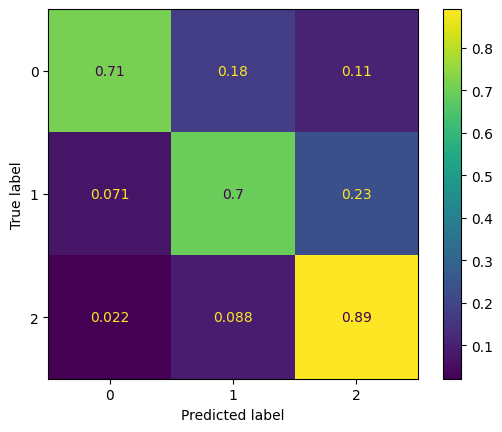

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.08it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.54753. Saving Model!
epoch 01, loss: 0.62165, acc: 0.73492, val_loss: 0.54753, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 02, loss: 0.62592, acc: 0.73359, val_loss: 0.54998, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 03, loss: 0.62111, acc: 0.73523, val_loss: 0.55071, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 04, loss: 0.62043, acc: 0.73486, val_loss: 0.55232, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 05, loss: 0.61925, acc: 0.73547, val_loss: 0.55348, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 06, loss: 0.61781, acc: 0.73664, val_loss: 0.55406, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 07, loss: 0.61730, acc: 0.73643, val_loss: 0.55465, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 08, loss: 0.61673, acc: 0.73597, val_loss: 0.55517, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 09, loss: 0.61617, acc: 0.73536, val_loss: 0.55559, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 10, loss: 0.61504, acc: 0.73643, val_loss: 0.55606, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 11, loss: 0.61504, acc: 0.73654, val_loss: 0.55639, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 12, loss: 0.61424, acc: 0.73667, val_loss: 0.55655, val_accuracy: 0.76443


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 13, loss: 0.61387, acc: 0.73680, val_loss: 0.55681, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 14, loss: 0.61353, acc: 0.73651, val_loss: 0.55725, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 15, loss: 0.61299, acc: 0.73619, val_loss: 0.55749, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 16, loss: 0.61290, acc: 0.73566, val_loss: 0.55767, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 17, loss: 0.61201, acc: 0.73588, val_loss: 0.55801, val_accuracy: 0.76443


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 18, loss: 0.61201, acc: 0.73795, val_loss: 0.55826, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 19, loss: 0.61144, acc: 0.73754, val_loss: 0.55848, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 20, loss: 0.61106, acc: 0.73760, val_loss: 0.55878, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 21, loss: 0.61074, acc: 0.73734, val_loss: 0.55903, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 22, loss: 0.61049, acc: 0.73747, val_loss: 0.55931, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


epoch 23, loss: 0.61015, acc: 0.73760, val_loss: 0.55952, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 24, loss: 0.60997, acc: 0.73765, val_loss: 0.55962, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 25, loss: 0.60929, acc: 0.73802, val_loss: 0.55994, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 26, loss: 0.60906, acc: 0.73793, val_loss: 0.56022, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 27, loss: 0.60868, acc: 0.73826, val_loss: 0.56043, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 28, loss: 0.60872, acc: 0.73828, val_loss: 0.56057, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 29, loss: 0.60803, acc: 0.73861, val_loss: 0.56077, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 30, loss: 0.60808, acc: 0.73850, val_loss: 0.56089, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 31, loss: 0.60709, acc: 0.73907, val_loss: 0.56123, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 32, loss: 0.60757, acc: 0.73876, val_loss: 0.56134, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 33, loss: 0.60692, acc: 0.73994, val_loss: 0.56151, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 34, loss: 0.60682, acc: 0.73976, val_loss: 0.56168, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 35, loss: 0.60617, acc: 0.74020, val_loss: 0.56182, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 36, loss: 0.60641, acc: 0.74009, val_loss: 0.56199, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 37, loss: 0.60560, acc: 0.74061, val_loss: 0.56224, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 38, loss: 0.60568, acc: 0.74029, val_loss: 0.56219, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 39, loss: 0.60526, acc: 0.74072, val_loss: 0.56247, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 40, loss: 0.60505, acc: 0.74077, val_loss: 0.56249, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 41, loss: 0.60498, acc: 0.74112, val_loss: 0.56261, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 42, loss: 0.60412, acc: 0.74127, val_loss: 0.56292, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 43, loss: 0.60458, acc: 0.74120, val_loss: 0.56298, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 44, loss: 0.60383, acc: 0.74144, val_loss: 0.56288, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 45, loss: 0.60369, acc: 0.74184, val_loss: 0.56310, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 46, loss: 0.60342, acc: 0.74147, val_loss: 0.56341, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


epoch 47, loss: 0.60329, acc: 0.74175, val_loss: 0.56333, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 48, loss: 0.60273, acc: 0.74184, val_loss: 0.56349, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 49, loss: 0.60264, acc: 0.74212, val_loss: 0.56369, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 50, loss: 0.60245, acc: 0.74212, val_loss: 0.56376, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 51, loss: 0.60218, acc: 0.74221, val_loss: 0.56379, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 52, loss: 0.60167, acc: 0.74267, val_loss: 0.56400, val_accuracy: 0.76207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 53, loss: 0.60178, acc: 0.74273, val_loss: 0.56403, val_accuracy: 0.76207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 54, loss: 0.60142, acc: 0.74267, val_loss: 0.56412, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 55, loss: 0.60108, acc: 0.74280, val_loss: 0.56426, val_accuracy: 0.76148


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 56, loss: 0.60077, acc: 0.74288, val_loss: 0.56418, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 57, loss: 0.60090, acc: 0.74306, val_loss: 0.56441, val_accuracy: 0.76207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 58, loss: 0.60018, acc: 0.74297, val_loss: 0.56452, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 59, loss: 0.60023, acc: 0.74356, val_loss: 0.56445, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 60, loss: 0.60003, acc: 0.74297, val_loss: 0.56458, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 61, loss: 0.59943, acc: 0.74347, val_loss: 0.56477, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 62, loss: 0.59951, acc: 0.74362, val_loss: 0.56487, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 63, loss: 0.59907, acc: 0.74389, val_loss: 0.56489, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 64, loss: 0.59880, acc: 0.74378, val_loss: 0.56490, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 65, loss: 0.59875, acc: 0.74424, val_loss: 0.56499, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 66, loss: 0.59834, acc: 0.74408, val_loss: 0.56516, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 67, loss: 0.59824, acc: 0.74428, val_loss: 0.56526, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 68, loss: 0.59785, acc: 0.74408, val_loss: 0.56525, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 69, loss: 0.59782, acc: 0.74463, val_loss: 0.56529, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 70, loss: 0.59736, acc: 0.74469, val_loss: 0.56549, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 71, loss: 0.59738, acc: 0.74480, val_loss: 0.56559, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 72, loss: 0.59679, acc: 0.74467, val_loss: 0.56558, val_accuracy: 0.76207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.98it/s]


epoch 73, loss: 0.59698, acc: 0.74528, val_loss: 0.56560, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 74, loss: 0.59651, acc: 0.74520, val_loss: 0.56569, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 75, loss: 0.59631, acc: 0.74554, val_loss: 0.56581, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 76, loss: 0.59622, acc: 0.74576, val_loss: 0.56594, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 77, loss: 0.59601, acc: 0.74607, val_loss: 0.56594, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 78, loss: 0.59557, acc: 0.74581, val_loss: 0.56606, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 79, loss: 0.59552, acc: 0.74624, val_loss: 0.56607, val_accuracy: 0.76305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 80, loss: 0.59520, acc: 0.74585, val_loss: 0.56623, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 81, loss: 0.59498, acc: 0.74703, val_loss: 0.56628, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 82, loss: 0.59493, acc: 0.74607, val_loss: 0.56621, val_accuracy: 0.76305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


epoch 83, loss: 0.59446, acc: 0.74648, val_loss: 0.56633, val_accuracy: 0.76325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.60it/s]


epoch 84, loss: 0.59453, acc: 0.74589, val_loss: 0.56639, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 85, loss: 0.59395, acc: 0.74657, val_loss: 0.56666, val_accuracy: 0.76325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 86, loss: 0.59418, acc: 0.74712, val_loss: 0.56650, val_accuracy: 0.76345


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 87, loss: 0.59374, acc: 0.74642, val_loss: 0.56651, val_accuracy: 0.76305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 88, loss: 0.59324, acc: 0.74659, val_loss: 0.56659, val_accuracy: 0.76325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 89, loss: 0.59344, acc: 0.74753, val_loss: 0.56668, val_accuracy: 0.76325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 90, loss: 0.59325, acc: 0.74718, val_loss: 0.56666, val_accuracy: 0.76384


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 91, loss: 0.59270, acc: 0.74781, val_loss: 0.56674, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 92, loss: 0.59261, acc: 0.74683, val_loss: 0.56677, val_accuracy: 0.76364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 93, loss: 0.59249, acc: 0.74814, val_loss: 0.56689, val_accuracy: 0.76404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 94, loss: 0.59222, acc: 0.74781, val_loss: 0.56695, val_accuracy: 0.76207


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 95, loss: 0.59188, acc: 0.74823, val_loss: 0.56711, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 96, loss: 0.59188, acc: 0.74812, val_loss: 0.56700, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 97, loss: 0.59164, acc: 0.74836, val_loss: 0.56684, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 98, loss: 0.59120, acc: 0.74914, val_loss: 0.56713, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 99, loss: 0.59142, acc: 0.74919, val_loss: 0.56715, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 100, loss: 0.59085, acc: 0.74901, val_loss: 0.56711, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.77it/s]


epoch 101, loss: 0.59090, acc: 0.74914, val_loss: 0.56713, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 102, loss: 0.59034, acc: 0.74932, val_loss: 0.56733, val_accuracy: 0.76305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 103, loss: 0.59030, acc: 0.74975, val_loss: 0.56720, val_accuracy: 0.76325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 104, loss: 0.59023, acc: 0.74941, val_loss: 0.56718, val_accuracy: 0.76325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 105, loss: 0.58982, acc: 0.75004, val_loss: 0.56740, val_accuracy: 0.76364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 106, loss: 0.58971, acc: 0.74869, val_loss: 0.56750, val_accuracy: 0.76325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 107, loss: 0.58945, acc: 0.75017, val_loss: 0.56732, val_accuracy: 0.76364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 108, loss: 0.58946, acc: 0.74984, val_loss: 0.56743, val_accuracy: 0.76345


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 109, loss: 0.58856, acc: 0.75043, val_loss: 0.56762, val_accuracy: 0.76345


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 110, loss: 0.58900, acc: 0.74991, val_loss: 0.56755, val_accuracy: 0.76325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 111, loss: 0.58858, acc: 0.75037, val_loss: 0.56750, val_accuracy: 0.76305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 112, loss: 0.58858, acc: 0.75013, val_loss: 0.56752, val_accuracy: 0.76325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 113, loss: 0.58783, acc: 0.75067, val_loss: 0.56767, val_accuracy: 0.76364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 114, loss: 0.58824, acc: 0.75008, val_loss: 0.56754, val_accuracy: 0.76364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 115, loss: 0.58768, acc: 0.75069, val_loss: 0.56745, val_accuracy: 0.76325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 116, loss: 0.58782, acc: 0.75010, val_loss: 0.56764, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 117, loss: 0.58692, acc: 0.75104, val_loss: 0.56775, val_accuracy: 0.76305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


epoch 118, loss: 0.58760, acc: 0.75037, val_loss: 0.56776, val_accuracy: 0.76305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 119, loss: 0.58664, acc: 0.75093, val_loss: 0.56767, val_accuracy: 0.76364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 120, loss: 0.58693, acc: 0.75037, val_loss: 0.56757, val_accuracy: 0.76325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 121, loss: 0.58634, acc: 0.75209, val_loss: 0.56774, val_accuracy: 0.76345


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 122, loss: 0.58651, acc: 0.75030, val_loss: 0.56798, val_accuracy: 0.75952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 123, loss: 0.58573, acc: 0.75111, val_loss: 0.56798, val_accuracy: 0.76031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 124, loss: 0.58629, acc: 0.75133, val_loss: 0.56763, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 125, loss: 0.58552, acc: 0.75235, val_loss: 0.56779, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 126, loss: 0.58555, acc: 0.75200, val_loss: 0.56781, val_accuracy: 0.76011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 127, loss: 0.58500, acc: 0.75266, val_loss: 0.56813, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 128, loss: 0.58524, acc: 0.75226, val_loss: 0.56784, val_accuracy: 0.76031


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 129, loss: 0.58492, acc: 0.75239, val_loss: 0.56774, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.98it/s]


epoch 130, loss: 0.58458, acc: 0.75213, val_loss: 0.56815, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 131, loss: 0.58434, acc: 0.75255, val_loss: 0.56794, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 132, loss: 0.58457, acc: 0.75226, val_loss: 0.56801, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 133, loss: 0.58368, acc: 0.75298, val_loss: 0.56809, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 134, loss: 0.58418, acc: 0.75239, val_loss: 0.56783, val_accuracy: 0.76148


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 135, loss: 0.58338, acc: 0.75287, val_loss: 0.56815, val_accuracy: 0.76050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 136, loss: 0.58354, acc: 0.75220, val_loss: 0.56806, val_accuracy: 0.76070


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


epoch 137, loss: 0.58310, acc: 0.75287, val_loss: 0.56789, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


epoch 138, loss: 0.58322, acc: 0.75255, val_loss: 0.56799, val_accuracy: 0.76090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 139, loss: 0.58279, acc: 0.75290, val_loss: 0.56821, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 140, loss: 0.58274, acc: 0.75239, val_loss: 0.56818, val_accuracy: 0.76129


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 141, loss: 0.58215, acc: 0.75298, val_loss: 0.56815, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 142, loss: 0.58250, acc: 0.75268, val_loss: 0.56789, val_accuracy: 0.76148


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 143, loss: 0.58177, acc: 0.75338, val_loss: 0.56820, val_accuracy: 0.76090


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 144, loss: 0.58203, acc: 0.75298, val_loss: 0.56800, val_accuracy: 0.76109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 145, loss: 0.58156, acc: 0.75311, val_loss: 0.56827, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.10it/s]


epoch 146, loss: 0.58152, acc: 0.75316, val_loss: 0.56838, val_accuracy: 0.76188


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 147, loss: 0.58117, acc: 0.75355, val_loss: 0.56810, val_accuracy: 0.76148


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 148, loss: 0.58099, acc: 0.75329, val_loss: 0.56815, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 149, loss: 0.58095, acc: 0.75366, val_loss: 0.56820, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 150, loss: 0.58055, acc: 0.75335, val_loss: 0.56821, val_accuracy: 0.76168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.82it/s]


epoch 151, loss: 0.58034, acc: 0.75381, val_loss: 0.56815, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


epoch 152, loss: 0.58036, acc: 0.75346, val_loss: 0.56819, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 153, loss: 0.57998, acc: 0.75375, val_loss: 0.56834, val_accuracy: 0.76247


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 154, loss: 0.57998, acc: 0.75327, val_loss: 0.56809, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 155, loss: 0.57949, acc: 0.75394, val_loss: 0.56822, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 156, loss: 0.57978, acc: 0.75348, val_loss: 0.56857, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 157, loss: 0.57895, acc: 0.75414, val_loss: 0.56842, val_accuracy: 0.76227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 158, loss: 0.57949, acc: 0.75370, val_loss: 0.56818, val_accuracy: 0.76266


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 159, loss: 0.57864, acc: 0.75431, val_loss: 0.56840, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 160, loss: 0.57895, acc: 0.75362, val_loss: 0.56842, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 161, loss: 0.57810, acc: 0.75434, val_loss: 0.56831, val_accuracy: 0.76305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.01it/s]


epoch 162, loss: 0.57867, acc: 0.75396, val_loss: 0.56813, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 163, loss: 0.57799, acc: 0.75438, val_loss: 0.56830, val_accuracy: 0.76345


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


epoch 164, loss: 0.57791, acc: 0.75412, val_loss: 0.56845, val_accuracy: 0.76305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.51it/s]


epoch 165, loss: 0.57791, acc: 0.75416, val_loss: 0.56844, val_accuracy: 0.76325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 166, loss: 0.57738, acc: 0.75429, val_loss: 0.56831, val_accuracy: 0.76305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.47it/s]


epoch 167, loss: 0.57745, acc: 0.75488, val_loss: 0.56843, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 168, loss: 0.57712, acc: 0.75429, val_loss: 0.56840, val_accuracy: 0.76286


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 169, loss: 0.57696, acc: 0.75449, val_loss: 0.56837, val_accuracy: 0.76345


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


epoch 170, loss: 0.57678, acc: 0.75506, val_loss: 0.56848, val_accuracy: 0.76404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 171, loss: 0.57668, acc: 0.75506, val_loss: 0.56825, val_accuracy: 0.76364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 172, loss: 0.57660, acc: 0.75466, val_loss: 0.56832, val_accuracy: 0.76384


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 173, loss: 0.57589, acc: 0.75545, val_loss: 0.56836, val_accuracy: 0.76423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 174, loss: 0.57630, acc: 0.75492, val_loss: 0.56830, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.65it/s]


epoch 175, loss: 0.57568, acc: 0.75551, val_loss: 0.56831, val_accuracy: 0.76423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 176, loss: 0.57583, acc: 0.75554, val_loss: 0.56829, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 177, loss: 0.57525, acc: 0.75564, val_loss: 0.56821, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 178, loss: 0.57519, acc: 0.75586, val_loss: 0.56825, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 179, loss: 0.57527, acc: 0.75571, val_loss: 0.56836, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.51it/s]


epoch 180, loss: 0.57460, acc: 0.75608, val_loss: 0.56815, val_accuracy: 0.76423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 181, loss: 0.57481, acc: 0.75593, val_loss: 0.56833, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 182, loss: 0.57431, acc: 0.75645, val_loss: 0.56822, val_accuracy: 0.76482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 183, loss: 0.57456, acc: 0.75621, val_loss: 0.56824, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 184, loss: 0.57392, acc: 0.75769, val_loss: 0.56819, val_accuracy: 0.76443


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 185, loss: 0.57421, acc: 0.75669, val_loss: 0.56824, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 186, loss: 0.57379, acc: 0.75658, val_loss: 0.56826, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 187, loss: 0.57362, acc: 0.75783, val_loss: 0.56798, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 188, loss: 0.57322, acc: 0.75660, val_loss: 0.56829, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 189, loss: 0.57312, acc: 0.75813, val_loss: 0.56817, val_accuracy: 0.76502


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 190, loss: 0.57306, acc: 0.75774, val_loss: 0.56812, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 191, loss: 0.57287, acc: 0.75689, val_loss: 0.56808, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 192, loss: 0.57265, acc: 0.75689, val_loss: 0.56799, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 193, loss: 0.57219, acc: 0.75846, val_loss: 0.56805, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 194, loss: 0.57214, acc: 0.75711, val_loss: 0.56810, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 195, loss: 0.57214, acc: 0.75920, val_loss: 0.56798, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 196, loss: 0.57169, acc: 0.75903, val_loss: 0.56794, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 197, loss: 0.57175, acc: 0.75835, val_loss: 0.56807, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 198, loss: 0.57139, acc: 0.75905, val_loss: 0.56795, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 199, loss: 0.57150, acc: 0.75820, val_loss: 0.56775, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.51it/s]


epoch 200, loss: 0.57102, acc: 0.75903, val_loss: 0.56798, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 201, loss: 0.57103, acc: 0.75946, val_loss: 0.56825, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 202, loss: 0.57062, acc: 0.75953, val_loss: 0.56772, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 203, loss: 0.57122, acc: 0.75907, val_loss: 0.56775, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 204, loss: 0.56983, acc: 0.75929, val_loss: 0.56770, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 205, loss: 0.57094, acc: 0.75951, val_loss: 0.56780, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 206, loss: 0.56946, acc: 0.75961, val_loss: 0.56814, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 207, loss: 0.57032, acc: 0.75975, val_loss: 0.56800, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 208, loss: 0.56934, acc: 0.75959, val_loss: 0.56766, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 209, loss: 0.56971, acc: 0.75970, val_loss: 0.56759, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 210, loss: 0.56890, acc: 0.75979, val_loss: 0.56767, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 211, loss: 0.56920, acc: 0.75994, val_loss: 0.56775, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 212, loss: 0.56840, acc: 0.75981, val_loss: 0.56767, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 213, loss: 0.56891, acc: 0.75994, val_loss: 0.56757, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 214, loss: 0.56807, acc: 0.75992, val_loss: 0.56766, val_accuracy: 0.76541


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 215, loss: 0.56872, acc: 0.76005, val_loss: 0.56778, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 216, loss: 0.56775, acc: 0.75981, val_loss: 0.56754, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 217, loss: 0.56836, acc: 0.75948, val_loss: 0.56776, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 218, loss: 0.56719, acc: 0.76001, val_loss: 0.56767, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 219, loss: 0.56831, acc: 0.75959, val_loss: 0.56736, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 220, loss: 0.56675, acc: 0.75983, val_loss: 0.56788, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 221, loss: 0.56764, acc: 0.75970, val_loss: 0.56743, val_accuracy: 0.76580


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 222, loss: 0.56691, acc: 0.76012, val_loss: 0.56766, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 223, loss: 0.56698, acc: 0.75988, val_loss: 0.56771, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 224, loss: 0.56626, acc: 0.76014, val_loss: 0.56761, val_accuracy: 0.76521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 225, loss: 0.56671, acc: 0.76036, val_loss: 0.56753, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 226, loss: 0.56586, acc: 0.76031, val_loss: 0.56744, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 227, loss: 0.56633, acc: 0.76060, val_loss: 0.56743, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 228, loss: 0.56531, acc: 0.76097, val_loss: 0.56757, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 229, loss: 0.56621, acc: 0.76073, val_loss: 0.56756, val_accuracy: 0.76561


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 230, loss: 0.56499, acc: 0.76053, val_loss: 0.56745, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 231, loss: 0.56586, acc: 0.76081, val_loss: 0.56735, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 232, loss: 0.56459, acc: 0.76090, val_loss: 0.56751, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 233, loss: 0.56575, acc: 0.76086, val_loss: 0.56741, val_accuracy: 0.76620


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 234, loss: 0.56430, acc: 0.76066, val_loss: 0.56760, val_accuracy: 0.76600


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 235, loss: 0.56496, acc: 0.76151, val_loss: 0.56753, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 236, loss: 0.56403, acc: 0.76129, val_loss: 0.56742, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 237, loss: 0.56451, acc: 0.76136, val_loss: 0.56733, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 238, loss: 0.56360, acc: 0.76153, val_loss: 0.56741, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 239, loss: 0.56426, acc: 0.76164, val_loss: 0.56745, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 240, loss: 0.56317, acc: 0.76175, val_loss: 0.56722, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 241, loss: 0.56392, acc: 0.76190, val_loss: 0.56729, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 242, loss: 0.56275, acc: 0.76127, val_loss: 0.56750, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 243, loss: 0.56326, acc: 0.76169, val_loss: 0.56728, val_accuracy: 0.76639


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 244, loss: 0.56259, acc: 0.76171, val_loss: 0.56732, val_accuracy: 0.76659


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 245, loss: 0.56306, acc: 0.76177, val_loss: 0.56750, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 246, loss: 0.56231, acc: 0.76164, val_loss: 0.56707, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 247, loss: 0.56241, acc: 0.76223, val_loss: 0.56733, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 248, loss: 0.56217, acc: 0.76171, val_loss: 0.56733, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 249, loss: 0.56205, acc: 0.76199, val_loss: 0.56734, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 250, loss: 0.56188, acc: 0.76184, val_loss: 0.56741, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 251, loss: 0.56175, acc: 0.76219, val_loss: 0.56720, val_accuracy: 0.76678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 252, loss: 0.56154, acc: 0.76182, val_loss: 0.56707, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 253, loss: 0.56142, acc: 0.76223, val_loss: 0.56729, val_accuracy: 0.76718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 254, loss: 0.56088, acc: 0.76195, val_loss: 0.56736, val_accuracy: 0.76698


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 255, loss: 0.56114, acc: 0.76269, val_loss: 0.56704, val_accuracy: 0.76737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 256, loss: 0.56028, acc: 0.76219, val_loss: 0.56723, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 257, loss: 0.56096, acc: 0.76195, val_loss: 0.56722, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 258, loss: 0.55989, acc: 0.76282, val_loss: 0.56724, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 259, loss: 0.56061, acc: 0.76291, val_loss: 0.56721, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 260, loss: 0.55936, acc: 0.76315, val_loss: 0.56726, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 261, loss: 0.56041, acc: 0.76295, val_loss: 0.56712, val_accuracy: 0.76777


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 262, loss: 0.55881, acc: 0.76304, val_loss: 0.56725, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 263, loss: 0.55997, acc: 0.76317, val_loss: 0.56707, val_accuracy: 0.76757


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 264, loss: 0.55886, acc: 0.76317, val_loss: 0.56712, val_accuracy: 0.76835


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 265, loss: 0.55956, acc: 0.76326, val_loss: 0.56728, val_accuracy: 0.76816


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 266, loss: 0.55857, acc: 0.76326, val_loss: 0.56731, val_accuracy: 0.76796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 267, loss: 0.55912, acc: 0.76321, val_loss: 0.56692, val_accuracy: 0.76855


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 268, loss: 0.55817, acc: 0.76365, val_loss: 0.56694, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 269, loss: 0.55860, acc: 0.76374, val_loss: 0.56709, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 270, loss: 0.55790, acc: 0.76372, val_loss: 0.56694, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 271, loss: 0.55821, acc: 0.76374, val_loss: 0.56729, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 272, loss: 0.55740, acc: 0.76409, val_loss: 0.56721, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 273, loss: 0.55798, acc: 0.76400, val_loss: 0.56705, val_accuracy: 0.76914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 274, loss: 0.55702, acc: 0.76476, val_loss: 0.56682, val_accuracy: 0.76875


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 275, loss: 0.55751, acc: 0.76461, val_loss: 0.56701, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 276, loss: 0.55650, acc: 0.76511, val_loss: 0.56687, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 277, loss: 0.55735, acc: 0.76457, val_loss: 0.56696, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 278, loss: 0.55621, acc: 0.76509, val_loss: 0.56710, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 279, loss: 0.55705, acc: 0.76496, val_loss: 0.56660, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 280, loss: 0.55578, acc: 0.76496, val_loss: 0.56693, val_accuracy: 0.76894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 281, loss: 0.55657, acc: 0.76526, val_loss: 0.56676, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 282, loss: 0.55570, acc: 0.76524, val_loss: 0.56680, val_accuracy: 0.76934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 283, loss: 0.55604, acc: 0.76505, val_loss: 0.56682, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 284, loss: 0.55558, acc: 0.76509, val_loss: 0.56681, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 285, loss: 0.55571, acc: 0.76515, val_loss: 0.56690, val_accuracy: 0.76953


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 286, loss: 0.55485, acc: 0.76557, val_loss: 0.56685, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 287, loss: 0.55568, acc: 0.76487, val_loss: 0.56652, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 288, loss: 0.55461, acc: 0.76524, val_loss: 0.56677, val_accuracy: 0.76993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 289, loss: 0.55494, acc: 0.76539, val_loss: 0.56658, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 290, loss: 0.55424, acc: 0.76577, val_loss: 0.56644, val_accuracy: 0.76973


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 291, loss: 0.55467, acc: 0.76563, val_loss: 0.56679, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]


epoch 292, loss: 0.55340, acc: 0.76555, val_loss: 0.56651, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


epoch 293, loss: 0.55459, acc: 0.76563, val_loss: 0.56658, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 294, loss: 0.55316, acc: 0.76596, val_loss: 0.56635, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 295, loss: 0.55431, acc: 0.76563, val_loss: 0.56650, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 296, loss: 0.55270, acc: 0.76607, val_loss: 0.56650, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 297, loss: 0.55421, acc: 0.76570, val_loss: 0.56643, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 298, loss: 0.55236, acc: 0.76605, val_loss: 0.56643, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 299, loss: 0.55348, acc: 0.76579, val_loss: 0.56652, val_accuracy: 0.77012


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 300, loss: 0.55253, acc: 0.76620, val_loss: 0.56638, val_accuracy: 0.77091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 301, loss: 0.55282, acc: 0.76629, val_loss: 0.56621, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 302, loss: 0.55190, acc: 0.76758, val_loss: 0.56620, val_accuracy: 0.77032


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 303, loss: 0.55259, acc: 0.76662, val_loss: 0.56634, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 304, loss: 0.55160, acc: 0.76668, val_loss: 0.56600, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.51it/s]


epoch 305, loss: 0.55222, acc: 0.76782, val_loss: 0.56621, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 306, loss: 0.55120, acc: 0.76755, val_loss: 0.56636, val_accuracy: 0.77110


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 307, loss: 0.55160, acc: 0.76779, val_loss: 0.56606, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.39it/s]


epoch 308, loss: 0.55110, acc: 0.76786, val_loss: 0.56607, val_accuracy: 0.77051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 309, loss: 0.55134, acc: 0.76790, val_loss: 0.56585, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 310, loss: 0.55054, acc: 0.76825, val_loss: 0.56611, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 311, loss: 0.55098, acc: 0.76810, val_loss: 0.56610, val_accuracy: 0.77071


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 312, loss: 0.55043, acc: 0.76790, val_loss: 0.56605, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 313, loss: 0.55056, acc: 0.76884, val_loss: 0.56587, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 314, loss: 0.54992, acc: 0.76854, val_loss: 0.56605, val_accuracy: 0.77150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 315, loss: 0.55056, acc: 0.76854, val_loss: 0.56632, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 316, loss: 0.54927, acc: 0.76902, val_loss: 0.56584, val_accuracy: 0.77208


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


epoch 317, loss: 0.55068, acc: 0.76799, val_loss: 0.56596, val_accuracy: 0.77130


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.98it/s]


epoch 318, loss: 0.54860, acc: 0.76947, val_loss: 0.56596, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 319, loss: 0.55027, acc: 0.76688, val_loss: 0.56608, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.13it/s]


epoch 320, loss: 0.54856, acc: 0.76958, val_loss: 0.56565, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


epoch 321, loss: 0.55008, acc: 0.76806, val_loss: 0.56594, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.92it/s]


epoch 322, loss: 0.54738, acc: 0.77019, val_loss: 0.56597, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


epoch 323, loss: 0.54967, acc: 0.76838, val_loss: 0.56610, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


epoch 324, loss: 0.54772, acc: 0.77002, val_loss: 0.56605, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 325, loss: 0.54929, acc: 0.76858, val_loss: 0.56581, val_accuracy: 0.77169


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 326, loss: 0.54685, acc: 0.77070, val_loss: 0.56606, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 327, loss: 0.54879, acc: 0.76932, val_loss: 0.56567, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 328, loss: 0.54667, acc: 0.77100, val_loss: 0.56589, val_accuracy: 0.77189


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


epoch 329, loss: 0.54843, acc: 0.77026, val_loss: 0.56626, val_accuracy: 0.77228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 330, loss: 0.54642, acc: 0.77096, val_loss: 0.56591, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 331, loss: 0.54824, acc: 0.76976, val_loss: 0.56572, val_accuracy: 0.77307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.34it/s]


epoch 332, loss: 0.54582, acc: 0.77174, val_loss: 0.56621, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 333, loss: 0.54768, acc: 0.77035, val_loss: 0.56604, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 334, loss: 0.54622, acc: 0.77209, val_loss: 0.56573, val_accuracy: 0.77287


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 335, loss: 0.54763, acc: 0.77083, val_loss: 0.56630, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.27it/s]


epoch 336, loss: 0.54549, acc: 0.77242, val_loss: 0.56605, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 337, loss: 0.54769, acc: 0.77056, val_loss: 0.56607, val_accuracy: 0.77326


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


epoch 338, loss: 0.54555, acc: 0.77255, val_loss: 0.56592, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.75it/s]


epoch 339, loss: 0.54761, acc: 0.77035, val_loss: 0.56637, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 340, loss: 0.54466, acc: 0.77235, val_loss: 0.56582, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s]


epoch 341, loss: 0.54708, acc: 0.77008, val_loss: 0.56606, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 342, loss: 0.54359, acc: 0.77340, val_loss: 0.56601, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 343, loss: 0.54691, acc: 0.77065, val_loss: 0.56597, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


epoch 344, loss: 0.54291, acc: 0.77390, val_loss: 0.56597, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 345, loss: 0.54655, acc: 0.77074, val_loss: 0.56575, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 346, loss: 0.54243, acc: 0.77421, val_loss: 0.56567, val_accuracy: 0.77444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 347, loss: 0.54584, acc: 0.77133, val_loss: 0.56606, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 348, loss: 0.54250, acc: 0.77379, val_loss: 0.56568, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 349, loss: 0.54542, acc: 0.77083, val_loss: 0.56551, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 350, loss: 0.54191, acc: 0.77440, val_loss: 0.56601, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 351, loss: 0.54510, acc: 0.77139, val_loss: 0.56596, val_accuracy: 0.77346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 352, loss: 0.54154, acc: 0.77464, val_loss: 0.56555, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 353, loss: 0.54506, acc: 0.77126, val_loss: 0.56588, val_accuracy: 0.77424


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 354, loss: 0.54116, acc: 0.77456, val_loss: 0.56606, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 355, loss: 0.54463, acc: 0.77176, val_loss: 0.56612, val_accuracy: 0.77385


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 356, loss: 0.54123, acc: 0.77449, val_loss: 0.56579, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 357, loss: 0.54452, acc: 0.77168, val_loss: 0.56561, val_accuracy: 0.77405


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 358, loss: 0.54057, acc: 0.77471, val_loss: 0.56618, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.54it/s]


epoch 359, loss: 0.54443, acc: 0.77131, val_loss: 0.56611, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.79it/s]


epoch 360, loss: 0.54060, acc: 0.77484, val_loss: 0.56582, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 361, loss: 0.54409, acc: 0.77192, val_loss: 0.56558, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.65it/s]


epoch 362, loss: 0.54015, acc: 0.77480, val_loss: 0.56571, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 363, loss: 0.54377, acc: 0.77174, val_loss: 0.56623, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 364, loss: 0.53964, acc: 0.77525, val_loss: 0.56584, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


epoch 365, loss: 0.54288, acc: 0.77316, val_loss: 0.56584, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 366, loss: 0.53926, acc: 0.77589, val_loss: 0.56598, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 367, loss: 0.54238, acc: 0.77275, val_loss: 0.56601, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 368, loss: 0.53850, acc: 0.77604, val_loss: 0.56552, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 369, loss: 0.54213, acc: 0.77310, val_loss: 0.56597, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 370, loss: 0.53813, acc: 0.77600, val_loss: 0.56584, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


epoch 371, loss: 0.54195, acc: 0.77286, val_loss: 0.56564, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


epoch 372, loss: 0.53761, acc: 0.77717, val_loss: 0.56557, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 373, loss: 0.54163, acc: 0.77381, val_loss: 0.56584, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 374, loss: 0.53722, acc: 0.77728, val_loss: 0.56552, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 375, loss: 0.54107, acc: 0.77412, val_loss: 0.56548, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 376, loss: 0.53721, acc: 0.77685, val_loss: 0.56545, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 377, loss: 0.54078, acc: 0.77427, val_loss: 0.56560, val_accuracy: 0.77523


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 378, loss: 0.53694, acc: 0.77720, val_loss: 0.56555, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 379, loss: 0.54049, acc: 0.77423, val_loss: 0.56543, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 380, loss: 0.53673, acc: 0.77733, val_loss: 0.56521, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 381, loss: 0.53974, acc: 0.77425, val_loss: 0.56578, val_accuracy: 0.77503


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 382, loss: 0.53648, acc: 0.77746, val_loss: 0.56530, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 383, loss: 0.53935, acc: 0.77432, val_loss: 0.56557, val_accuracy: 0.77464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 384, loss: 0.53590, acc: 0.77768, val_loss: 0.56543, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 385, loss: 0.53942, acc: 0.77451, val_loss: 0.56504, val_accuracy: 0.77483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 386, loss: 0.53543, acc: 0.77748, val_loss: 0.56539, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 387, loss: 0.53889, acc: 0.77471, val_loss: 0.56514, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.58it/s]


epoch 388, loss: 0.53495, acc: 0.77779, val_loss: 0.56530, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 389, loss: 0.53858, acc: 0.77471, val_loss: 0.56512, val_accuracy: 0.77542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 390, loss: 0.53474, acc: 0.77816, val_loss: 0.56520, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 391, loss: 0.53819, acc: 0.77462, val_loss: 0.56470, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 392, loss: 0.53418, acc: 0.77896, val_loss: 0.56505, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 393, loss: 0.53755, acc: 0.77519, val_loss: 0.56522, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 394, loss: 0.53419, acc: 0.77831, val_loss: 0.56511, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 395, loss: 0.53768, acc: 0.77493, val_loss: 0.56483, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 396, loss: 0.53338, acc: 0.77877, val_loss: 0.56485, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 397, loss: 0.53741, acc: 0.77534, val_loss: 0.56524, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 398, loss: 0.53334, acc: 0.77857, val_loss: 0.56474, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 399, loss: 0.53699, acc: 0.77549, val_loss: 0.56496, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 400, loss: 0.53289, acc: 0.77925, val_loss: 0.56513, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 401, loss: 0.53732, acc: 0.77532, val_loss: 0.56470, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 402, loss: 0.53201, acc: 0.78088, val_loss: 0.56517, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 403, loss: 0.53678, acc: 0.77565, val_loss: 0.56497, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 404, loss: 0.53189, acc: 0.77953, val_loss: 0.56479, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 405, loss: 0.53672, acc: 0.77650, val_loss: 0.56504, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 406, loss: 0.53134, acc: 0.78051, val_loss: 0.56465, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 407, loss: 0.53607, acc: 0.77700, val_loss: 0.56471, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.92it/s]


epoch 408, loss: 0.53091, acc: 0.78056, val_loss: 0.56471, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 409, loss: 0.53570, acc: 0.77715, val_loss: 0.56484, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


epoch 410, loss: 0.53069, acc: 0.78167, val_loss: 0.56449, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.60it/s]


epoch 411, loss: 0.53475, acc: 0.77765, val_loss: 0.56449, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 412, loss: 0.53048, acc: 0.78184, val_loss: 0.56482, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


epoch 413, loss: 0.53408, acc: 0.77802, val_loss: 0.56434, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.46it/s]


epoch 414, loss: 0.53059, acc: 0.78154, val_loss: 0.56427, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 415, loss: 0.53328, acc: 0.77957, val_loss: 0.56505, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


epoch 416, loss: 0.53035, acc: 0.78141, val_loss: 0.56441, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 417, loss: 0.53322, acc: 0.77818, val_loss: 0.56427, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 418, loss: 0.52982, acc: 0.78206, val_loss: 0.56457, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 419, loss: 0.53241, acc: 0.77997, val_loss: 0.56419, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 420, loss: 0.52991, acc: 0.78217, val_loss: 0.56440, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 421, loss: 0.53172, acc: 0.78034, val_loss: 0.56451, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 422, loss: 0.52960, acc: 0.78197, val_loss: 0.56431, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 423, loss: 0.53163, acc: 0.78008, val_loss: 0.56390, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 424, loss: 0.52878, acc: 0.78204, val_loss: 0.56455, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 425, loss: 0.53182, acc: 0.78014, val_loss: 0.56387, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 426, loss: 0.52842, acc: 0.78267, val_loss: 0.56443, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 427, loss: 0.53103, acc: 0.78062, val_loss: 0.56409, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 428, loss: 0.52832, acc: 0.78230, val_loss: 0.56430, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 429, loss: 0.53073, acc: 0.77920, val_loss: 0.56401, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 430, loss: 0.52792, acc: 0.78228, val_loss: 0.56424, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 431, loss: 0.53036, acc: 0.77960, val_loss: 0.56422, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 432, loss: 0.52774, acc: 0.78232, val_loss: 0.56412, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 433, loss: 0.53014, acc: 0.78082, val_loss: 0.56432, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 434, loss: 0.52699, acc: 0.78339, val_loss: 0.56391, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 435, loss: 0.53014, acc: 0.77966, val_loss: 0.56444, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 436, loss: 0.52647, acc: 0.78295, val_loss: 0.56388, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 437, loss: 0.53054, acc: 0.77936, val_loss: 0.56401, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 438, loss: 0.52573, acc: 0.78415, val_loss: 0.56415, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 439, loss: 0.53012, acc: 0.77949, val_loss: 0.56371, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 440, loss: 0.52523, acc: 0.78330, val_loss: 0.56412, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 441, loss: 0.52967, acc: 0.77962, val_loss: 0.56412, val_accuracy: 0.77837


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 442, loss: 0.52510, acc: 0.78391, val_loss: 0.56375, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


epoch 443, loss: 0.52939, acc: 0.78012, val_loss: 0.56429, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


epoch 444, loss: 0.52445, acc: 0.78435, val_loss: 0.56427, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 445, loss: 0.52918, acc: 0.78014, val_loss: 0.56381, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


epoch 446, loss: 0.52416, acc: 0.78378, val_loss: 0.56431, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.36it/s]


epoch 447, loss: 0.52878, acc: 0.78001, val_loss: 0.56403, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 448, loss: 0.52381, acc: 0.78466, val_loss: 0.56391, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.44it/s]


epoch 449, loss: 0.52840, acc: 0.78021, val_loss: 0.56359, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


epoch 450, loss: 0.52344, acc: 0.78496, val_loss: 0.56396, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 451, loss: 0.52802, acc: 0.78066, val_loss: 0.56407, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.05it/s]


epoch 452, loss: 0.52330, acc: 0.78496, val_loss: 0.56377, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 453, loss: 0.52752, acc: 0.78073, val_loss: 0.56396, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 454, loss: 0.52294, acc: 0.78503, val_loss: 0.56373, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 455, loss: 0.52759, acc: 0.78073, val_loss: 0.56384, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 456, loss: 0.52223, acc: 0.78557, val_loss: 0.56392, val_accuracy: 0.77915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 457, loss: 0.52738, acc: 0.78104, val_loss: 0.56372, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 458, loss: 0.52193, acc: 0.78549, val_loss: 0.56360, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 459, loss: 0.52739, acc: 0.78099, val_loss: 0.56379, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 460, loss: 0.52139, acc: 0.78535, val_loss: 0.56367, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 461, loss: 0.52642, acc: 0.78152, val_loss: 0.56389, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


epoch 462, loss: 0.52138, acc: 0.78540, val_loss: 0.56381, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 463, loss: 0.52603, acc: 0.78117, val_loss: 0.56303, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 464, loss: 0.52092, acc: 0.78614, val_loss: 0.56357, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 465, loss: 0.52570, acc: 0.78167, val_loss: 0.56373, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 466, loss: 0.52062, acc: 0.78566, val_loss: 0.56340, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 467, loss: 0.52533, acc: 0.78195, val_loss: 0.56341, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 468, loss: 0.52057, acc: 0.78638, val_loss: 0.56344, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 469, loss: 0.52479, acc: 0.78258, val_loss: 0.56364, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 470, loss: 0.52018, acc: 0.78610, val_loss: 0.56334, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 471, loss: 0.52473, acc: 0.78221, val_loss: 0.56376, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 472, loss: 0.51971, acc: 0.78583, val_loss: 0.56298, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 473, loss: 0.52453, acc: 0.78291, val_loss: 0.56335, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 474, loss: 0.51926, acc: 0.78712, val_loss: 0.56335, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 475, loss: 0.52418, acc: 0.78293, val_loss: 0.56314, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


epoch 476, loss: 0.51900, acc: 0.78716, val_loss: 0.56307, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 477, loss: 0.52370, acc: 0.78330, val_loss: 0.56347, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]


epoch 478, loss: 0.51850, acc: 0.78773, val_loss: 0.56320, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 479, loss: 0.52399, acc: 0.78346, val_loss: 0.56333, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 480, loss: 0.51806, acc: 0.78756, val_loss: 0.56321, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 481, loss: 0.52328, acc: 0.78361, val_loss: 0.56290, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 482, loss: 0.51810, acc: 0.78760, val_loss: 0.56297, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 483, loss: 0.52275, acc: 0.78359, val_loss: 0.56307, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 484, loss: 0.51746, acc: 0.78908, val_loss: 0.56296, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 485, loss: 0.52246, acc: 0.78405, val_loss: 0.56280, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 486, loss: 0.51704, acc: 0.78869, val_loss: 0.56304, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 487, loss: 0.52202, acc: 0.78415, val_loss: 0.56316, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 488, loss: 0.51725, acc: 0.78854, val_loss: 0.56301, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 489, loss: 0.52130, acc: 0.78474, val_loss: 0.56275, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 490, loss: 0.51670, acc: 0.78889, val_loss: 0.56307, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 491, loss: 0.52078, acc: 0.78477, val_loss: 0.56278, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 492, loss: 0.51674, acc: 0.78860, val_loss: 0.56292, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 493, loss: 0.52054, acc: 0.78494, val_loss: 0.56262, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 494, loss: 0.51627, acc: 0.78876, val_loss: 0.56251, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 495, loss: 0.52023, acc: 0.78507, val_loss: 0.56280, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 496, loss: 0.51588, acc: 0.78963, val_loss: 0.56269, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 497, loss: 0.51983, acc: 0.78520, val_loss: 0.56301, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 498, loss: 0.51570, acc: 0.78919, val_loss: 0.56275, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 499, loss: 0.51995, acc: 0.78501, val_loss: 0.56273, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 500, loss: 0.51498, acc: 0.78939, val_loss: 0.56258, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 501, loss: 0.51991, acc: 0.78535, val_loss: 0.56292, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 502, loss: 0.51448, acc: 0.78991, val_loss: 0.56270, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 503, loss: 0.51971, acc: 0.78522, val_loss: 0.56276, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 504, loss: 0.51417, acc: 0.78952, val_loss: 0.56272, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]


epoch 505, loss: 0.51937, acc: 0.78568, val_loss: 0.56241, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 506, loss: 0.51383, acc: 0.78994, val_loss: 0.56260, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 507, loss: 0.51906, acc: 0.78636, val_loss: 0.56243, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 508, loss: 0.51344, acc: 0.79188, val_loss: 0.56241, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 509, loss: 0.51862, acc: 0.78653, val_loss: 0.56246, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 510, loss: 0.51345, acc: 0.79076, val_loss: 0.56245, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 511, loss: 0.51830, acc: 0.78677, val_loss: 0.56230, val_accuracy: 0.78053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


epoch 512, loss: 0.51297, acc: 0.79137, val_loss: 0.56242, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 513, loss: 0.51776, acc: 0.78668, val_loss: 0.56261, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 514, loss: 0.51275, acc: 0.79144, val_loss: 0.56230, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.28it/s]


epoch 515, loss: 0.51726, acc: 0.78743, val_loss: 0.56215, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.86it/s]


epoch 516, loss: 0.51232, acc: 0.79238, val_loss: 0.56253, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 517, loss: 0.51695, acc: 0.78745, val_loss: 0.56207, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


epoch 518, loss: 0.51190, acc: 0.79146, val_loss: 0.56207, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 519, loss: 0.51652, acc: 0.78808, val_loss: 0.56210, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 520, loss: 0.51137, acc: 0.79201, val_loss: 0.56216, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 521, loss: 0.51623, acc: 0.78749, val_loss: 0.56207, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 522, loss: 0.51114, acc: 0.79244, val_loss: 0.56208, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 523, loss: 0.51591, acc: 0.78871, val_loss: 0.56186, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 524, loss: 0.51057, acc: 0.79244, val_loss: 0.56223, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.00it/s]


epoch 525, loss: 0.51588, acc: 0.78823, val_loss: 0.56169, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 526, loss: 0.51035, acc: 0.79273, val_loss: 0.56136, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.31it/s]


epoch 527, loss: 0.51557, acc: 0.78782, val_loss: 0.56233, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 528, loss: 0.50993, acc: 0.79238, val_loss: 0.56210, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 529, loss: 0.51527, acc: 0.78869, val_loss: 0.56164, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


epoch 530, loss: 0.50997, acc: 0.79264, val_loss: 0.56204, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 531, loss: 0.51463, acc: 0.78878, val_loss: 0.56156, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 532, loss: 0.50976, acc: 0.79303, val_loss: 0.56157, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


epoch 533, loss: 0.51432, acc: 0.78852, val_loss: 0.56202, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 534, loss: 0.50914, acc: 0.79264, val_loss: 0.56190, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 535, loss: 0.51406, acc: 0.78930, val_loss: 0.56158, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 536, loss: 0.50920, acc: 0.79303, val_loss: 0.56203, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 537, loss: 0.51314, acc: 0.78978, val_loss: 0.56144, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 538, loss: 0.50867, acc: 0.79286, val_loss: 0.56191, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 539, loss: 0.51308, acc: 0.78991, val_loss: 0.56149, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


epoch 540, loss: 0.50843, acc: 0.79284, val_loss: 0.56129, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 541, loss: 0.51279, acc: 0.78985, val_loss: 0.56194, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 542, loss: 0.50807, acc: 0.79369, val_loss: 0.56169, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 543, loss: 0.51263, acc: 0.78974, val_loss: 0.56161, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 544, loss: 0.50788, acc: 0.79415, val_loss: 0.56119, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 545, loss: 0.51267, acc: 0.78991, val_loss: 0.56158, val_accuracy: 0.77621


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 546, loss: 0.50707, acc: 0.79415, val_loss: 0.56206, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 547, loss: 0.51255, acc: 0.78932, val_loss: 0.56164, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 548, loss: 0.50700, acc: 0.79388, val_loss: 0.56164, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 549, loss: 0.51215, acc: 0.78974, val_loss: 0.56181, val_accuracy: 0.77601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 550, loss: 0.50635, acc: 0.79432, val_loss: 0.56153, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 551, loss: 0.51180, acc: 0.79013, val_loss: 0.56170, val_accuracy: 0.77581


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 552, loss: 0.50626, acc: 0.79463, val_loss: 0.56161, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 553, loss: 0.51133, acc: 0.79039, val_loss: 0.56160, val_accuracy: 0.77562


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 554, loss: 0.50609, acc: 0.79482, val_loss: 0.56118, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 555, loss: 0.51080, acc: 0.79059, val_loss: 0.56141, val_accuracy: 0.77640


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.14it/s]


epoch 556, loss: 0.50556, acc: 0.79441, val_loss: 0.56160, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05it/s]


epoch 557, loss: 0.51046, acc: 0.79083, val_loss: 0.56167, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.68it/s]


epoch 558, loss: 0.50556, acc: 0.79526, val_loss: 0.56119, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


epoch 559, loss: 0.51051, acc: 0.79072, val_loss: 0.56164, val_accuracy: 0.77660


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.11it/s]


epoch 560, loss: 0.50500, acc: 0.79524, val_loss: 0.56135, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 561, loss: 0.51030, acc: 0.79085, val_loss: 0.56155, val_accuracy: 0.77699


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 562, loss: 0.50431, acc: 0.79565, val_loss: 0.56189, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 563, loss: 0.51019, acc: 0.79127, val_loss: 0.56152, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 564, loss: 0.50422, acc: 0.79576, val_loss: 0.56148, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 565, loss: 0.50998, acc: 0.79111, val_loss: 0.56132, val_accuracy: 0.77680


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 566, loss: 0.50378, acc: 0.79585, val_loss: 0.56161, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 567, loss: 0.50947, acc: 0.79111, val_loss: 0.56117, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 568, loss: 0.50378, acc: 0.79611, val_loss: 0.56176, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.26it/s]


epoch 569, loss: 0.50940, acc: 0.79148, val_loss: 0.56128, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 570, loss: 0.50335, acc: 0.79617, val_loss: 0.56173, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 571, loss: 0.50935, acc: 0.79124, val_loss: 0.56121, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.71it/s]


epoch 572, loss: 0.50304, acc: 0.79635, val_loss: 0.56179, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.62it/s]


epoch 573, loss: 0.50880, acc: 0.79170, val_loss: 0.56135, val_accuracy: 0.77719


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 574, loss: 0.50262, acc: 0.79674, val_loss: 0.56153, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.65it/s]


epoch 575, loss: 0.50875, acc: 0.79159, val_loss: 0.56127, val_accuracy: 0.77739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.33it/s]


epoch 576, loss: 0.50240, acc: 0.79606, val_loss: 0.56163, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 577, loss: 0.50808, acc: 0.79157, val_loss: 0.56149, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 578, loss: 0.50198, acc: 0.79641, val_loss: 0.56119, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 579, loss: 0.50815, acc: 0.79194, val_loss: 0.56153, val_accuracy: 0.77758


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 580, loss: 0.50159, acc: 0.79724, val_loss: 0.56113, val_accuracy: 0.78013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 581, loss: 0.50769, acc: 0.79177, val_loss: 0.56156, val_accuracy: 0.77778


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 582, loss: 0.50124, acc: 0.79637, val_loss: 0.56161, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 583, loss: 0.50709, acc: 0.79240, val_loss: 0.56138, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 584, loss: 0.50088, acc: 0.79665, val_loss: 0.56160, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 585, loss: 0.50683, acc: 0.79271, val_loss: 0.56098, val_accuracy: 0.77797


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 586, loss: 0.50014, acc: 0.79729, val_loss: 0.56145, val_accuracy: 0.77935


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 587, loss: 0.50609, acc: 0.79377, val_loss: 0.56117, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 588, loss: 0.50025, acc: 0.79746, val_loss: 0.56123, val_accuracy: 0.77974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 589, loss: 0.50562, acc: 0.79373, val_loss: 0.56155, val_accuracy: 0.77817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 590, loss: 0.49981, acc: 0.79746, val_loss: 0.56133, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 591, loss: 0.50551, acc: 0.79364, val_loss: 0.56122, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 592, loss: 0.49949, acc: 0.79794, val_loss: 0.56165, val_accuracy: 0.78013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 593, loss: 0.50533, acc: 0.79382, val_loss: 0.56084, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 594, loss: 0.49926, acc: 0.79868, val_loss: 0.56117, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 595, loss: 0.50474, acc: 0.79382, val_loss: 0.56161, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 596, loss: 0.49900, acc: 0.79820, val_loss: 0.56126, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 597, loss: 0.50475, acc: 0.79393, val_loss: 0.56075, val_accuracy: 0.77856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 598, loss: 0.49840, acc: 0.79892, val_loss: 0.56125, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 599, loss: 0.50452, acc: 0.79428, val_loss: 0.56142, val_accuracy: 0.77876


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 600, loss: 0.49819, acc: 0.79807, val_loss: 0.56109, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 601, loss: 0.50410, acc: 0.79419, val_loss: 0.56119, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 602, loss: 0.49777, acc: 0.79866, val_loss: 0.56110, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 603, loss: 0.50415, acc: 0.79436, val_loss: 0.56144, val_accuracy: 0.77896


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 604, loss: 0.49743, acc: 0.79929, val_loss: 0.56121, val_accuracy: 0.78112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 605, loss: 0.50348, acc: 0.79430, val_loss: 0.56101, val_accuracy: 0.77954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


epoch 606, loss: 0.49694, acc: 0.79897, val_loss: 0.56167, val_accuracy: 0.78072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 607, loss: 0.50395, acc: 0.79456, val_loss: 0.56079, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 608, loss: 0.49678, acc: 0.79892, val_loss: 0.56133, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 609, loss: 0.50303, acc: 0.79432, val_loss: 0.56121, val_accuracy: 0.77994


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 610, loss: 0.49641, acc: 0.79966, val_loss: 0.56137, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 611, loss: 0.50326, acc: 0.79434, val_loss: 0.56106, val_accuracy: 0.78013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 612, loss: 0.49623, acc: 0.79975, val_loss: 0.56135, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 613, loss: 0.50317, acc: 0.79473, val_loss: 0.56072, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 614, loss: 0.49581, acc: 0.79990, val_loss: 0.56155, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 615, loss: 0.50267, acc: 0.79500, val_loss: 0.56125, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 616, loss: 0.49560, acc: 0.80021, val_loss: 0.56112, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 617, loss: 0.50247, acc: 0.79497, val_loss: 0.56121, val_accuracy: 0.78033


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 618, loss: 0.49489, acc: 0.80006, val_loss: 0.56172, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 619, loss: 0.50199, acc: 0.79556, val_loss: 0.56096, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 620, loss: 0.49505, acc: 0.80023, val_loss: 0.56122, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 621, loss: 0.50112, acc: 0.79613, val_loss: 0.56104, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 622, loss: 0.49492, acc: 0.80069, val_loss: 0.56144, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.51it/s]


epoch 623, loss: 0.50108, acc: 0.79550, val_loss: 0.56126, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 624, loss: 0.49454, acc: 0.80126, val_loss: 0.56129, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 625, loss: 0.50039, acc: 0.79537, val_loss: 0.56136, val_accuracy: 0.78151


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 626, loss: 0.49436, acc: 0.80041, val_loss: 0.56115, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 627, loss: 0.50049, acc: 0.79537, val_loss: 0.56108, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 628, loss: 0.49420, acc: 0.80078, val_loss: 0.56150, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 629, loss: 0.49974, acc: 0.79589, val_loss: 0.56143, val_accuracy: 0.78190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 630, loss: 0.49415, acc: 0.79979, val_loss: 0.56131, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 631, loss: 0.49965, acc: 0.79574, val_loss: 0.56137, val_accuracy: 0.78229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 632, loss: 0.49342, acc: 0.80134, val_loss: 0.56141, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 633, loss: 0.49982, acc: 0.79600, val_loss: 0.56125, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 634, loss: 0.49313, acc: 0.80115, val_loss: 0.56177, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 635, loss: 0.49946, acc: 0.79628, val_loss: 0.56113, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 636, loss: 0.49279, acc: 0.80154, val_loss: 0.56108, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 637, loss: 0.49931, acc: 0.79598, val_loss: 0.56215, val_accuracy: 0.78092


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 638, loss: 0.49233, acc: 0.80158, val_loss: 0.56136, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 639, loss: 0.49919, acc: 0.79726, val_loss: 0.56148, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


epoch 640, loss: 0.49187, acc: 0.80182, val_loss: 0.56150, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 641, loss: 0.49865, acc: 0.79661, val_loss: 0.56120, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 642, loss: 0.49186, acc: 0.80191, val_loss: 0.56163, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 643, loss: 0.49816, acc: 0.79716, val_loss: 0.56125, val_accuracy: 0.78131


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 644, loss: 0.49144, acc: 0.80215, val_loss: 0.56159, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 645, loss: 0.49794, acc: 0.79681, val_loss: 0.56117, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 646, loss: 0.49102, acc: 0.80202, val_loss: 0.56150, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 647, loss: 0.49775, acc: 0.79713, val_loss: 0.56116, val_accuracy: 0.78210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 648, loss: 0.49067, acc: 0.80241, val_loss: 0.56175, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]


epoch 649, loss: 0.49764, acc: 0.79724, val_loss: 0.56142, val_accuracy: 0.78170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 650, loss: 0.49022, acc: 0.80252, val_loss: 0.56175, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 651, loss: 0.49737, acc: 0.79724, val_loss: 0.56101, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 652, loss: 0.48981, acc: 0.80411, val_loss: 0.56153, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 653, loss: 0.49701, acc: 0.79777, val_loss: 0.56174, val_accuracy: 0.78269


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 654, loss: 0.48962, acc: 0.80359, val_loss: 0.56136, val_accuracy: 0.78465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 655, loss: 0.49680, acc: 0.79938, val_loss: 0.56094, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 656, loss: 0.48920, acc: 0.80398, val_loss: 0.56205, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 657, loss: 0.49627, acc: 0.79886, val_loss: 0.56122, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 658, loss: 0.48929, acc: 0.80357, val_loss: 0.56145, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 659, loss: 0.49584, acc: 0.79949, val_loss: 0.56094, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 660, loss: 0.48910, acc: 0.80416, val_loss: 0.56149, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 661, loss: 0.49528, acc: 0.79927, val_loss: 0.56158, val_accuracy: 0.78327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 662, loss: 0.48884, acc: 0.80409, val_loss: 0.56118, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 663, loss: 0.49566, acc: 0.79938, val_loss: 0.56133, val_accuracy: 0.78249


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 664, loss: 0.48819, acc: 0.80431, val_loss: 0.56137, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 665, loss: 0.49534, acc: 0.79956, val_loss: 0.56164, val_accuracy: 0.78367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 666, loss: 0.48804, acc: 0.80377, val_loss: 0.56186, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 667, loss: 0.49525, acc: 0.79936, val_loss: 0.56096, val_accuracy: 0.78308


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


epoch 668, loss: 0.48734, acc: 0.80433, val_loss: 0.56178, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 669, loss: 0.49490, acc: 0.79960, val_loss: 0.56137, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 670, loss: 0.48707, acc: 0.80422, val_loss: 0.56143, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.34it/s]


epoch 671, loss: 0.49472, acc: 0.79964, val_loss: 0.56094, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 672, loss: 0.48677, acc: 0.80448, val_loss: 0.56170, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 673, loss: 0.49439, acc: 0.79975, val_loss: 0.56125, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.34it/s]


epoch 674, loss: 0.48662, acc: 0.80468, val_loss: 0.56127, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


epoch 675, loss: 0.49415, acc: 0.79988, val_loss: 0.56119, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 676, loss: 0.48622, acc: 0.80481, val_loss: 0.56115, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


epoch 677, loss: 0.49348, acc: 0.80032, val_loss: 0.56163, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 678, loss: 0.48628, acc: 0.80427, val_loss: 0.56154, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 679, loss: 0.49349, acc: 0.80060, val_loss: 0.56099, val_accuracy: 0.78288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 680, loss: 0.48561, acc: 0.80499, val_loss: 0.56188, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 681, loss: 0.49306, acc: 0.80012, val_loss: 0.56122, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 682, loss: 0.48584, acc: 0.80479, val_loss: 0.56097, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


epoch 683, loss: 0.49281, acc: 0.80099, val_loss: 0.56084, val_accuracy: 0.78445


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


epoch 684, loss: 0.48495, acc: 0.80562, val_loss: 0.56174, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 685, loss: 0.49246, acc: 0.80051, val_loss: 0.56173, val_accuracy: 0.78386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.02it/s]


epoch 686, loss: 0.48511, acc: 0.80462, val_loss: 0.56109, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 687, loss: 0.49250, acc: 0.80032, val_loss: 0.56096, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 688, loss: 0.48436, acc: 0.80553, val_loss: 0.56156, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.28it/s]


epoch 689, loss: 0.49197, acc: 0.80060, val_loss: 0.56118, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 690, loss: 0.48458, acc: 0.80551, val_loss: 0.56111, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 691, loss: 0.49214, acc: 0.80030, val_loss: 0.56103, val_accuracy: 0.78406


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


epoch 692, loss: 0.48331, acc: 0.80573, val_loss: 0.56185, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 693, loss: 0.49210, acc: 0.80056, val_loss: 0.56098, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 694, loss: 0.48386, acc: 0.80582, val_loss: 0.56093, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


epoch 695, loss: 0.49182, acc: 0.80025, val_loss: 0.56093, val_accuracy: 0.78347


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 696, loss: 0.48335, acc: 0.80573, val_loss: 0.56176, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 697, loss: 0.49148, acc: 0.80056, val_loss: 0.56094, val_accuracy: 0.78524


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.64it/s]


epoch 698, loss: 0.48347, acc: 0.80610, val_loss: 0.56162, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 699, loss: 0.48996, acc: 0.80141, val_loss: 0.56139, val_accuracy: 0.78426


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.51it/s]


epoch 700, loss: 0.48290, acc: 0.80525, val_loss: 0.56078, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


epoch 701, loss: 0.48958, acc: 0.80156, val_loss: 0.56079, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 702, loss: 0.48250, acc: 0.80595, val_loss: 0.56117, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 703, loss: 0.48911, acc: 0.80209, val_loss: 0.56071, val_accuracy: 0.78543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 704, loss: 0.48185, acc: 0.80603, val_loss: 0.56134, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.19it/s]


epoch 705, loss: 0.48921, acc: 0.80174, val_loss: 0.56109, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 706, loss: 0.48136, acc: 0.80656, val_loss: 0.56096, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.41it/s]


epoch 707, loss: 0.48902, acc: 0.80187, val_loss: 0.56120, val_accuracy: 0.78484


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 708, loss: 0.48130, acc: 0.80643, val_loss: 0.56109, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 709, loss: 0.48858, acc: 0.80276, val_loss: 0.56084, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 710, loss: 0.48126, acc: 0.80697, val_loss: 0.56152, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 711, loss: 0.48851, acc: 0.80250, val_loss: 0.56102, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 712, loss: 0.48059, acc: 0.80699, val_loss: 0.56088, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 713, loss: 0.48872, acc: 0.80202, val_loss: 0.56125, val_accuracy: 0.78504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


epoch 714, loss: 0.48071, acc: 0.80656, val_loss: 0.56092, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 715, loss: 0.48841, acc: 0.80250, val_loss: 0.56050, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 716, loss: 0.48058, acc: 0.80686, val_loss: 0.56166, val_accuracy: 0.78602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 717, loss: 0.48855, acc: 0.80180, val_loss: 0.56125, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 718, loss: 0.48092, acc: 0.80693, val_loss: 0.56085, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 719, loss: 0.48775, acc: 0.80272, val_loss: 0.56127, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 720, loss: 0.48013, acc: 0.80662, val_loss: 0.56110, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 721, loss: 0.48675, acc: 0.80263, val_loss: 0.56112, val_accuracy: 0.78583


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.31it/s]


epoch 722, loss: 0.47995, acc: 0.80708, val_loss: 0.56115, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 723, loss: 0.48697, acc: 0.80381, val_loss: 0.56061, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 724, loss: 0.47879, acc: 0.80719, val_loss: 0.56128, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


epoch 725, loss: 0.48688, acc: 0.80302, val_loss: 0.56115, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 726, loss: 0.47865, acc: 0.80747, val_loss: 0.56106, val_accuracy: 0.78642


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 727, loss: 0.48678, acc: 0.80318, val_loss: 0.56028, val_accuracy: 0.78563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 728, loss: 0.47802, acc: 0.80754, val_loss: 0.56127, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 729, loss: 0.48611, acc: 0.80318, val_loss: 0.56057, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 730, loss: 0.47833, acc: 0.80684, val_loss: 0.56116, val_accuracy: 0.78681


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 731, loss: 0.48551, acc: 0.80370, val_loss: 0.56006, val_accuracy: 0.78661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 732, loss: 0.47792, acc: 0.80784, val_loss: 0.56147, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 733, loss: 0.48492, acc: 0.80366, val_loss: 0.56048, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 734, loss: 0.47824, acc: 0.80739, val_loss: 0.56019, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 735, loss: 0.48422, acc: 0.80414, val_loss: 0.55989, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 736, loss: 0.47794, acc: 0.80782, val_loss: 0.56070, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 737, loss: 0.48367, acc: 0.80414, val_loss: 0.56049, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 738, loss: 0.47813, acc: 0.80686, val_loss: 0.56028, val_accuracy: 0.78622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 739, loss: 0.48302, acc: 0.80534, val_loss: 0.55942, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 740, loss: 0.47750, acc: 0.80811, val_loss: 0.56024, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 741, loss: 0.48269, acc: 0.80424, val_loss: 0.55991, val_accuracy: 0.78779


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 742, loss: 0.47769, acc: 0.80734, val_loss: 0.55963, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 743, loss: 0.48230, acc: 0.80464, val_loss: 0.55962, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 744, loss: 0.47693, acc: 0.80806, val_loss: 0.56041, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 745, loss: 0.48251, acc: 0.80429, val_loss: 0.55994, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 746, loss: 0.47691, acc: 0.80754, val_loss: 0.55959, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 747, loss: 0.48216, acc: 0.80435, val_loss: 0.56030, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 748, loss: 0.47608, acc: 0.80804, val_loss: 0.56012, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 749, loss: 0.48255, acc: 0.80411, val_loss: 0.55955, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 750, loss: 0.47559, acc: 0.80859, val_loss: 0.56006, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 751, loss: 0.48246, acc: 0.80438, val_loss: 0.55949, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 752, loss: 0.47497, acc: 0.80867, val_loss: 0.56052, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 753, loss: 0.48231, acc: 0.80418, val_loss: 0.55918, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 754, loss: 0.47504, acc: 0.80883, val_loss: 0.55951, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 755, loss: 0.48221, acc: 0.80442, val_loss: 0.55936, val_accuracy: 0.78700


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 756, loss: 0.47427, acc: 0.80911, val_loss: 0.55971, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 757, loss: 0.48212, acc: 0.80416, val_loss: 0.55928, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


epoch 758, loss: 0.47390, acc: 0.80915, val_loss: 0.56005, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 759, loss: 0.48163, acc: 0.80438, val_loss: 0.55915, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 760, loss: 0.47406, acc: 0.80898, val_loss: 0.55985, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.02it/s]


epoch 761, loss: 0.48092, acc: 0.80470, val_loss: 0.55937, val_accuracy: 0.78740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 762, loss: 0.47379, acc: 0.80948, val_loss: 0.55922, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 763, loss: 0.48037, acc: 0.80414, val_loss: 0.55925, val_accuracy: 0.78759


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


epoch 764, loss: 0.47377, acc: 0.80979, val_loss: 0.55995, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 765, loss: 0.47983, acc: 0.80536, val_loss: 0.55875, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 766, loss: 0.47359, acc: 0.80909, val_loss: 0.55963, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 767, loss: 0.47900, acc: 0.80608, val_loss: 0.55954, val_accuracy: 0.78720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 768, loss: 0.47347, acc: 0.80979, val_loss: 0.55920, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 769, loss: 0.47912, acc: 0.80551, val_loss: 0.55856, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


epoch 770, loss: 0.47288, acc: 0.81005, val_loss: 0.55923, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 771, loss: 0.47861, acc: 0.80699, val_loss: 0.55920, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 772, loss: 0.47299, acc: 0.80924, val_loss: 0.55926, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 773, loss: 0.47851, acc: 0.80582, val_loss: 0.55931, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 774, loss: 0.47228, acc: 0.80965, val_loss: 0.55910, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 775, loss: 0.47849, acc: 0.80638, val_loss: 0.55901, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 776, loss: 0.47207, acc: 0.81016, val_loss: 0.55928, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 777, loss: 0.47829, acc: 0.80586, val_loss: 0.55828, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 778, loss: 0.47168, acc: 0.81037, val_loss: 0.55960, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05it/s]


epoch 779, loss: 0.47767, acc: 0.80730, val_loss: 0.55878, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 780, loss: 0.47176, acc: 0.81066, val_loss: 0.55908, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 781, loss: 0.47720, acc: 0.80643, val_loss: 0.55905, val_accuracy: 0.78818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.47it/s]


epoch 782, loss: 0.47177, acc: 0.81022, val_loss: 0.55878, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 783, loss: 0.47685, acc: 0.80708, val_loss: 0.55905, val_accuracy: 0.78838


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 784, loss: 0.47109, acc: 0.81055, val_loss: 0.55910, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 785, loss: 0.47685, acc: 0.80640, val_loss: 0.55852, val_accuracy: 0.78877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 786, loss: 0.47102, acc: 0.80981, val_loss: 0.55859, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 787, loss: 0.47659, acc: 0.80734, val_loss: 0.55910, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 788, loss: 0.47041, acc: 0.81101, val_loss: 0.55895, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 789, loss: 0.47686, acc: 0.80658, val_loss: 0.55908, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 790, loss: 0.47028, acc: 0.81020, val_loss: 0.55879, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.66it/s]


epoch 791, loss: 0.47650, acc: 0.80656, val_loss: 0.55874, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


epoch 792, loss: 0.46949, acc: 0.81081, val_loss: 0.55925, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 793, loss: 0.47681, acc: 0.80630, val_loss: 0.55861, val_accuracy: 0.78857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 794, loss: 0.46898, acc: 0.81088, val_loss: 0.55947, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 795, loss: 0.47645, acc: 0.80675, val_loss: 0.55848, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 796, loss: 0.46908, acc: 0.81101, val_loss: 0.55892, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 797, loss: 0.47648, acc: 0.80658, val_loss: 0.55932, val_accuracy: 0.78799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 798, loss: 0.46877, acc: 0.81140, val_loss: 0.55916, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 799, loss: 0.47687, acc: 0.80654, val_loss: 0.55875, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 800, loss: 0.46895, acc: 0.81155, val_loss: 0.55943, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 801, loss: 0.47545, acc: 0.80708, val_loss: 0.55882, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 802, loss: 0.46883, acc: 0.81075, val_loss: 0.55868, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 803, loss: 0.47470, acc: 0.80754, val_loss: 0.55898, val_accuracy: 0.78936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.64it/s]


epoch 804, loss: 0.46845, acc: 0.81153, val_loss: 0.55888, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 805, loss: 0.47435, acc: 0.80741, val_loss: 0.55846, val_accuracy: 0.78916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 806, loss: 0.46802, acc: 0.81147, val_loss: 0.55924, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


epoch 807, loss: 0.47415, acc: 0.80736, val_loss: 0.55873, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 808, loss: 0.46795, acc: 0.81168, val_loss: 0.55829, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 809, loss: 0.47328, acc: 0.80885, val_loss: 0.55878, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 810, loss: 0.46791, acc: 0.81171, val_loss: 0.55819, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 811, loss: 0.47313, acc: 0.80782, val_loss: 0.55905, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 812, loss: 0.46723, acc: 0.81127, val_loss: 0.55895, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 813, loss: 0.47292, acc: 0.80832, val_loss: 0.55879, val_accuracy: 0.78897


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 814, loss: 0.46699, acc: 0.81216, val_loss: 0.55890, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 815, loss: 0.47261, acc: 0.80904, val_loss: 0.55815, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 816, loss: 0.46663, acc: 0.81227, val_loss: 0.55867, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 817, loss: 0.47220, acc: 0.80843, val_loss: 0.55904, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 818, loss: 0.46624, acc: 0.81179, val_loss: 0.55866, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 819, loss: 0.47253, acc: 0.80821, val_loss: 0.55853, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 820, loss: 0.46577, acc: 0.81247, val_loss: 0.55894, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 821, loss: 0.47203, acc: 0.80959, val_loss: 0.55897, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 822, loss: 0.46603, acc: 0.81197, val_loss: 0.55840, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.45it/s]


epoch 823, loss: 0.47184, acc: 0.80917, val_loss: 0.55860, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 824, loss: 0.46526, acc: 0.81284, val_loss: 0.55880, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 825, loss: 0.47233, acc: 0.80837, val_loss: 0.55861, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 826, loss: 0.46476, acc: 0.81284, val_loss: 0.55917, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 827, loss: 0.47233, acc: 0.80863, val_loss: 0.55875, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 828, loss: 0.46487, acc: 0.81297, val_loss: 0.55844, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 829, loss: 0.47149, acc: 0.80981, val_loss: 0.55877, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 830, loss: 0.46436, acc: 0.81306, val_loss: 0.55902, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 831, loss: 0.47136, acc: 0.80885, val_loss: 0.55839, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 832, loss: 0.46417, acc: 0.81256, val_loss: 0.55884, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.31it/s]


epoch 833, loss: 0.47104, acc: 0.80965, val_loss: 0.55825, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 834, loss: 0.46389, acc: 0.81310, val_loss: 0.55869, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 835, loss: 0.47062, acc: 0.80946, val_loss: 0.55885, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.68it/s]


epoch 836, loss: 0.46356, acc: 0.81328, val_loss: 0.55836, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 837, loss: 0.47040, acc: 0.80948, val_loss: 0.55820, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 838, loss: 0.46348, acc: 0.81338, val_loss: 0.55872, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 839, loss: 0.46979, acc: 0.80981, val_loss: 0.55850, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 840, loss: 0.46341, acc: 0.81273, val_loss: 0.55862, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 841, loss: 0.46983, acc: 0.80970, val_loss: 0.55851, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 842, loss: 0.46256, acc: 0.81378, val_loss: 0.55878, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 843, loss: 0.46989, acc: 0.80950, val_loss: 0.55819, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 844, loss: 0.46217, acc: 0.81391, val_loss: 0.55884, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 845, loss: 0.46991, acc: 0.80970, val_loss: 0.55877, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 846, loss: 0.46237, acc: 0.81391, val_loss: 0.55869, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 847, loss: 0.46926, acc: 0.81088, val_loss: 0.55879, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 848, loss: 0.46222, acc: 0.81400, val_loss: 0.55853, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 849, loss: 0.46891, acc: 0.81066, val_loss: 0.55840, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 850, loss: 0.46174, acc: 0.81410, val_loss: 0.55911, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


epoch 851, loss: 0.46855, acc: 0.80994, val_loss: 0.55807, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 852, loss: 0.46175, acc: 0.81373, val_loss: 0.55888, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 853, loss: 0.46803, acc: 0.80985, val_loss: 0.55875, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 854, loss: 0.46150, acc: 0.81367, val_loss: 0.55891, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 855, loss: 0.46822, acc: 0.81035, val_loss: 0.55841, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 856, loss: 0.46104, acc: 0.81410, val_loss: 0.55853, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.02it/s]


epoch 857, loss: 0.46775, acc: 0.81016, val_loss: 0.55851, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 858, loss: 0.46108, acc: 0.81402, val_loss: 0.55861, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 859, loss: 0.46815, acc: 0.81088, val_loss: 0.55848, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 860, loss: 0.46009, acc: 0.81448, val_loss: 0.55905, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 861, loss: 0.46852, acc: 0.80989, val_loss: 0.55828, val_accuracy: 0.79015


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.87it/s]


epoch 862, loss: 0.46038, acc: 0.81410, val_loss: 0.55917, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 863, loss: 0.46816, acc: 0.80985, val_loss: 0.55816, val_accuracy: 0.78975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


epoch 864, loss: 0.46019, acc: 0.81472, val_loss: 0.55927, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 865, loss: 0.46833, acc: 0.80972, val_loss: 0.55829, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 866, loss: 0.46068, acc: 0.81345, val_loss: 0.55852, val_accuracy: 0.79073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 867, loss: 0.46591, acc: 0.81160, val_loss: 0.55886, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 868, loss: 0.45939, acc: 0.81522, val_loss: 0.55891, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 869, loss: 0.46671, acc: 0.81018, val_loss: 0.55809, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 870, loss: 0.45897, acc: 0.81528, val_loss: 0.55896, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 871, loss: 0.46624, acc: 0.81094, val_loss: 0.55763, val_accuracy: 0.78956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 872, loss: 0.45844, acc: 0.81548, val_loss: 0.55905, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]


epoch 873, loss: 0.46643, acc: 0.81005, val_loss: 0.55830, val_accuracy: 0.78995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 874, loss: 0.45840, acc: 0.81594, val_loss: 0.55853, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 875, loss: 0.46612, acc: 0.81153, val_loss: 0.55782, val_accuracy: 0.79054


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 876, loss: 0.45777, acc: 0.81613, val_loss: 0.55845, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 877, loss: 0.46600, acc: 0.81075, val_loss: 0.55793, val_accuracy: 0.79034


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 878, loss: 0.45762, acc: 0.81561, val_loss: 0.55913, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 879, loss: 0.46567, acc: 0.81088, val_loss: 0.55734, val_accuracy: 0.79093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 880, loss: 0.45732, acc: 0.81624, val_loss: 0.55903, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 881, loss: 0.46541, acc: 0.81114, val_loss: 0.55787, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 882, loss: 0.45757, acc: 0.81578, val_loss: 0.55857, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 883, loss: 0.46488, acc: 0.81116, val_loss: 0.55811, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 884, loss: 0.45726, acc: 0.81618, val_loss: 0.55862, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 885, loss: 0.46481, acc: 0.81092, val_loss: 0.55808, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 886, loss: 0.45707, acc: 0.81589, val_loss: 0.55909, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 887, loss: 0.46450, acc: 0.81120, val_loss: 0.55768, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 888, loss: 0.45677, acc: 0.81602, val_loss: 0.55933, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 889, loss: 0.46443, acc: 0.81133, val_loss: 0.55768, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 890, loss: 0.45660, acc: 0.81611, val_loss: 0.55816, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 891, loss: 0.46430, acc: 0.81125, val_loss: 0.55760, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 892, loss: 0.45582, acc: 0.81618, val_loss: 0.55880, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 893, loss: 0.46424, acc: 0.81144, val_loss: 0.55781, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 894, loss: 0.45561, acc: 0.81657, val_loss: 0.55871, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 895, loss: 0.46388, acc: 0.81114, val_loss: 0.55788, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 896, loss: 0.45550, acc: 0.81681, val_loss: 0.55836, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 897, loss: 0.46316, acc: 0.81166, val_loss: 0.55742, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 898, loss: 0.45484, acc: 0.81720, val_loss: 0.55861, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 899, loss: 0.46289, acc: 0.81195, val_loss: 0.55795, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 900, loss: 0.45415, acc: 0.81725, val_loss: 0.55867, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 901, loss: 0.46316, acc: 0.81181, val_loss: 0.55727, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 902, loss: 0.45399, acc: 0.81718, val_loss: 0.55854, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 903, loss: 0.46252, acc: 0.81205, val_loss: 0.55806, val_accuracy: 0.79230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 904, loss: 0.45426, acc: 0.81716, val_loss: 0.55778, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 905, loss: 0.46190, acc: 0.81223, val_loss: 0.55787, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 906, loss: 0.45347, acc: 0.81768, val_loss: 0.55897, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 907, loss: 0.46234, acc: 0.81186, val_loss: 0.55740, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 908, loss: 0.45324, acc: 0.81725, val_loss: 0.55827, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 909, loss: 0.46183, acc: 0.81227, val_loss: 0.55729, val_accuracy: 0.79132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 910, loss: 0.45300, acc: 0.81733, val_loss: 0.55849, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.99it/s]


epoch 911, loss: 0.46166, acc: 0.81197, val_loss: 0.55780, val_accuracy: 0.79191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.99it/s]


epoch 912, loss: 0.45299, acc: 0.81731, val_loss: 0.55823, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 913, loss: 0.46123, acc: 0.81227, val_loss: 0.55739, val_accuracy: 0.79211


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


epoch 914, loss: 0.45255, acc: 0.81757, val_loss: 0.55846, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


epoch 915, loss: 0.46082, acc: 0.81234, val_loss: 0.55772, val_accuracy: 0.79113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 916, loss: 0.45241, acc: 0.81799, val_loss: 0.55850, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 917, loss: 0.46089, acc: 0.81203, val_loss: 0.55744, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 918, loss: 0.45204, acc: 0.81790, val_loss: 0.55836, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 919, loss: 0.46052, acc: 0.81251, val_loss: 0.55741, val_accuracy: 0.79152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


epoch 920, loss: 0.45198, acc: 0.81779, val_loss: 0.55832, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 921, loss: 0.46063, acc: 0.81221, val_loss: 0.55755, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 922, loss: 0.45161, acc: 0.81792, val_loss: 0.55885, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 923, loss: 0.46070, acc: 0.81227, val_loss: 0.55738, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 924, loss: 0.45097, acc: 0.81866, val_loss: 0.55878, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 925, loss: 0.46050, acc: 0.81258, val_loss: 0.55725, val_accuracy: 0.79172


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


epoch 926, loss: 0.45098, acc: 0.81823, val_loss: 0.55909, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 927, loss: 0.45999, acc: 0.81264, val_loss: 0.55723, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 928, loss: 0.45046, acc: 0.81893, val_loss: 0.55867, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 929, loss: 0.45961, acc: 0.81290, val_loss: 0.55750, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


epoch 930, loss: 0.45054, acc: 0.81886, val_loss: 0.55810, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 931, loss: 0.45927, acc: 0.81301, val_loss: 0.55748, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 932, loss: 0.45028, acc: 0.81805, val_loss: 0.55889, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 933, loss: 0.45896, acc: 0.81317, val_loss: 0.55730, val_accuracy: 0.79250


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 934, loss: 0.45055, acc: 0.81757, val_loss: 0.55858, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 935, loss: 0.45821, acc: 0.81345, val_loss: 0.55779, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 936, loss: 0.45004, acc: 0.81917, val_loss: 0.55881, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 937, loss: 0.45841, acc: 0.81345, val_loss: 0.55720, val_accuracy: 0.79270


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 938, loss: 0.44967, acc: 0.81851, val_loss: 0.55918, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 939, loss: 0.45850, acc: 0.81301, val_loss: 0.55734, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 940, loss: 0.44932, acc: 0.81914, val_loss: 0.55862, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 941, loss: 0.45785, acc: 0.81384, val_loss: 0.55764, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 942, loss: 0.44932, acc: 0.81901, val_loss: 0.55824, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 943, loss: 0.45768, acc: 0.81341, val_loss: 0.55755, val_accuracy: 0.79289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 944, loss: 0.44894, acc: 0.81945, val_loss: 0.55876, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 945, loss: 0.45740, acc: 0.81373, val_loss: 0.55811, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 946, loss: 0.44869, acc: 0.81875, val_loss: 0.55918, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 947, loss: 0.45717, acc: 0.81382, val_loss: 0.55807, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 948, loss: 0.44862, acc: 0.81973, val_loss: 0.55833, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 949, loss: 0.45711, acc: 0.81378, val_loss: 0.55758, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


epoch 950, loss: 0.44803, acc: 0.81989, val_loss: 0.55881, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


epoch 951, loss: 0.45697, acc: 0.81367, val_loss: 0.55768, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 952, loss: 0.44792, acc: 0.81986, val_loss: 0.55931, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


epoch 953, loss: 0.45677, acc: 0.81400, val_loss: 0.55795, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 954, loss: 0.44756, acc: 0.81991, val_loss: 0.55844, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 955, loss: 0.45682, acc: 0.81356, val_loss: 0.55727, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 956, loss: 0.44709, acc: 0.82032, val_loss: 0.55895, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]


epoch 957, loss: 0.45642, acc: 0.81393, val_loss: 0.55751, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 958, loss: 0.44721, acc: 0.81930, val_loss: 0.55896, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 959, loss: 0.45611, acc: 0.81402, val_loss: 0.55797, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 960, loss: 0.44638, acc: 0.82045, val_loss: 0.55873, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 961, loss: 0.45636, acc: 0.81393, val_loss: 0.55743, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 962, loss: 0.44634, acc: 0.81999, val_loss: 0.55957, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 963, loss: 0.45583, acc: 0.81402, val_loss: 0.55799, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 964, loss: 0.44643, acc: 0.82004, val_loss: 0.55921, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 965, loss: 0.45592, acc: 0.81406, val_loss: 0.55742, val_accuracy: 0.79348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 966, loss: 0.44595, acc: 0.81982, val_loss: 0.55915, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 967, loss: 0.45551, acc: 0.81417, val_loss: 0.55759, val_accuracy: 0.79329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 968, loss: 0.44568, acc: 0.82041, val_loss: 0.55887, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 969, loss: 0.45533, acc: 0.81406, val_loss: 0.55763, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 970, loss: 0.44555, acc: 0.82063, val_loss: 0.55916, val_accuracy: 0.79643


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 971, loss: 0.45479, acc: 0.81424, val_loss: 0.55814, val_accuracy: 0.79368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 972, loss: 0.44546, acc: 0.81958, val_loss: 0.55952, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 973, loss: 0.45504, acc: 0.81432, val_loss: 0.55720, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 974, loss: 0.44529, acc: 0.82063, val_loss: 0.55947, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 975, loss: 0.45461, acc: 0.81467, val_loss: 0.55797, val_accuracy: 0.79388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 976, loss: 0.44572, acc: 0.82045, val_loss: 0.55919, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 977, loss: 0.45436, acc: 0.81465, val_loss: 0.55863, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 978, loss: 0.44628, acc: 0.82026, val_loss: 0.55962, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 979, loss: 0.45514, acc: 0.81419, val_loss: 0.55779, val_accuracy: 0.79309


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 980, loss: 0.44362, acc: 0.82106, val_loss: 0.56030, val_accuracy: 0.79584


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 981, loss: 0.45437, acc: 0.81537, val_loss: 0.55772, val_accuracy: 0.79466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 982, loss: 0.44432, acc: 0.82063, val_loss: 0.55944, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


epoch 983, loss: 0.45361, acc: 0.81607, val_loss: 0.55840, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 984, loss: 0.44464, acc: 0.82089, val_loss: 0.55883, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 985, loss: 0.45299, acc: 0.81596, val_loss: 0.55862, val_accuracy: 0.79446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 986, loss: 0.44452, acc: 0.82026, val_loss: 0.55935, val_accuracy: 0.79545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 987, loss: 0.45300, acc: 0.81517, val_loss: 0.55822, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 988, loss: 0.44483, acc: 0.82039, val_loss: 0.55844, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 989, loss: 0.45262, acc: 0.81596, val_loss: 0.55830, val_accuracy: 0.79486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 990, loss: 0.44463, acc: 0.82008, val_loss: 0.55912, val_accuracy: 0.79505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 991, loss: 0.45168, acc: 0.81624, val_loss: 0.55880, val_accuracy: 0.79427


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 992, loss: 0.44414, acc: 0.82095, val_loss: 0.55851, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 993, loss: 0.45099, acc: 0.81644, val_loss: 0.55815, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 994, loss: 0.44349, acc: 0.82030, val_loss: 0.55947, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 995, loss: 0.45116, acc: 0.81727, val_loss: 0.55816, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 996, loss: 0.44286, acc: 0.82065, val_loss: 0.55821, val_accuracy: 0.79564


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 997, loss: 0.45096, acc: 0.81631, val_loss: 0.55838, val_accuracy: 0.79407


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 998, loss: 0.44295, acc: 0.82132, val_loss: 0.55899, val_accuracy: 0.79603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.58it/s]


epoch 999, loss: 0.45079, acc: 0.81674, val_loss: 0.55854, val_accuracy: 0.79525


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 1000, loss: 0.44264, acc: 0.82159, val_loss: 0.55915, val_accuracy: 0.79505
3번째 교차검증
evaluation loss: 0.54753, evaluation accuracy: 0.76698
(5, 5094)
(5094, 5)
Stacking ensemble (ML+DNN): 5094
[3]Accuracy : 77.85630153121319
[3]F1score : 0.7783513370445847
[3]Precision : 0.7864900427153875
[3]Recall : 0.7785630153121319



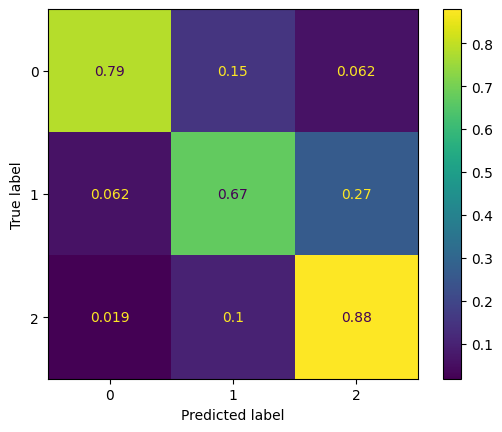

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.67255. Saving Model!
epoch 01, loss: 0.61174, acc: 0.73946, val_loss: 0.67255, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.82it/s]


epoch 02, loss: 0.60876, acc: 0.74072, val_loss: 0.68833, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


epoch 03, loss: 0.60820, acc: 0.74085, val_loss: 0.69542, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


epoch 04, loss: 0.60645, acc: 0.74251, val_loss: 0.69903, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


epoch 05, loss: 0.60372, acc: 0.74201, val_loss: 0.70330, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 06, loss: 0.60388, acc: 0.74173, val_loss: 0.70401, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.99it/s]


epoch 07, loss: 0.60330, acc: 0.74177, val_loss: 0.70395, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.61it/s]


epoch 08, loss: 0.60166, acc: 0.74341, val_loss: 0.70602, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.34it/s]


epoch 09, loss: 0.60127, acc: 0.74365, val_loss: 0.70750, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


epoch 10, loss: 0.60098, acc: 0.74391, val_loss: 0.70858, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


epoch 11, loss: 0.60016, acc: 0.74315, val_loss: 0.71005, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 12, loss: 0.59988, acc: 0.74323, val_loss: 0.71172, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 13, loss: 0.59948, acc: 0.74352, val_loss: 0.71286, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 14, loss: 0.59876, acc: 0.74349, val_loss: 0.71423, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 15, loss: 0.59824, acc: 0.74421, val_loss: 0.71580, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


epoch 16, loss: 0.59801, acc: 0.74400, val_loss: 0.71684, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 17, loss: 0.59749, acc: 0.74530, val_loss: 0.71802, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 18, loss: 0.59718, acc: 0.74550, val_loss: 0.71886, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


epoch 19, loss: 0.59659, acc: 0.74592, val_loss: 0.72051, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 20, loss: 0.59642, acc: 0.74578, val_loss: 0.72154, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


epoch 21, loss: 0.59607, acc: 0.74576, val_loss: 0.72268, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 22, loss: 0.59566, acc: 0.74629, val_loss: 0.72382, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 23, loss: 0.59534, acc: 0.74659, val_loss: 0.72475, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 24, loss: 0.59501, acc: 0.74631, val_loss: 0.72539, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 25, loss: 0.59466, acc: 0.74683, val_loss: 0.72655, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 26, loss: 0.59438, acc: 0.74701, val_loss: 0.72708, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 27, loss: 0.59400, acc: 0.74803, val_loss: 0.72823, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 28, loss: 0.59374, acc: 0.74720, val_loss: 0.72892, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 29, loss: 0.59346, acc: 0.74829, val_loss: 0.72949, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 30, loss: 0.59301, acc: 0.74842, val_loss: 0.73019, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 31, loss: 0.59281, acc: 0.74840, val_loss: 0.73102, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 32, loss: 0.59238, acc: 0.74923, val_loss: 0.73166, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


epoch 33, loss: 0.59235, acc: 0.74912, val_loss: 0.73246, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 34, loss: 0.59175, acc: 0.74967, val_loss: 0.73338, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 35, loss: 0.59174, acc: 0.74973, val_loss: 0.73396, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 36, loss: 0.59124, acc: 0.74989, val_loss: 0.73450, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 37, loss: 0.59123, acc: 0.74997, val_loss: 0.73474, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 38, loss: 0.59060, acc: 0.75043, val_loss: 0.73574, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 39, loss: 0.59076, acc: 0.75023, val_loss: 0.73594, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 40, loss: 0.59013, acc: 0.75041, val_loss: 0.73704, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 41, loss: 0.59016, acc: 0.75028, val_loss: 0.73688, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 42, loss: 0.58959, acc: 0.75052, val_loss: 0.73748, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 43, loss: 0.58957, acc: 0.75052, val_loss: 0.73832, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 44, loss: 0.58903, acc: 0.75080, val_loss: 0.73925, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 45, loss: 0.58913, acc: 0.75087, val_loss: 0.73917, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 46, loss: 0.58846, acc: 0.75111, val_loss: 0.73998, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 47, loss: 0.58846, acc: 0.75095, val_loss: 0.74048, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 48, loss: 0.58813, acc: 0.75122, val_loss: 0.74068, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 49, loss: 0.58785, acc: 0.75141, val_loss: 0.74125, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 50, loss: 0.58761, acc: 0.75137, val_loss: 0.74202, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 51, loss: 0.58744, acc: 0.75133, val_loss: 0.74220, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 52, loss: 0.58706, acc: 0.75165, val_loss: 0.74282, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 53, loss: 0.58697, acc: 0.75161, val_loss: 0.74323, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 54, loss: 0.58652, acc: 0.75202, val_loss: 0.74393, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 55, loss: 0.58658, acc: 0.75220, val_loss: 0.74406, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 56, loss: 0.58606, acc: 0.75231, val_loss: 0.74496, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 57, loss: 0.58589, acc: 0.75250, val_loss: 0.74524, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 58, loss: 0.58551, acc: 0.75220, val_loss: 0.74579, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 59, loss: 0.58541, acc: 0.75218, val_loss: 0.74564, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 60, loss: 0.58500, acc: 0.75244, val_loss: 0.74621, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 61, loss: 0.58482, acc: 0.75246, val_loss: 0.74681, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 62, loss: 0.58470, acc: 0.75226, val_loss: 0.74699, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 63, loss: 0.58437, acc: 0.75266, val_loss: 0.74767, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 64, loss: 0.58416, acc: 0.75268, val_loss: 0.74758, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 65, loss: 0.58386, acc: 0.75263, val_loss: 0.74837, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 66, loss: 0.58363, acc: 0.75270, val_loss: 0.74894, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 67, loss: 0.58349, acc: 0.75274, val_loss: 0.74911, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 68, loss: 0.58307, acc: 0.75285, val_loss: 0.74937, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 69, loss: 0.58306, acc: 0.75290, val_loss: 0.74953, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 70, loss: 0.58260, acc: 0.75298, val_loss: 0.75087, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 71, loss: 0.58262, acc: 0.75298, val_loss: 0.75102, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 72, loss: 0.58233, acc: 0.75314, val_loss: 0.75095, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 73, loss: 0.58182, acc: 0.75322, val_loss: 0.75182, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 74, loss: 0.58191, acc: 0.75335, val_loss: 0.75194, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 75, loss: 0.58155, acc: 0.75338, val_loss: 0.75217, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 76, loss: 0.58120, acc: 0.75364, val_loss: 0.75277, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 77, loss: 0.58117, acc: 0.75377, val_loss: 0.75281, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 78, loss: 0.58082, acc: 0.75375, val_loss: 0.75329, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 79, loss: 0.58051, acc: 0.75403, val_loss: 0.75406, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 80, loss: 0.58041, acc: 0.75375, val_loss: 0.75375, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 81, loss: 0.58017, acc: 0.75386, val_loss: 0.75406, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 82, loss: 0.58001, acc: 0.75394, val_loss: 0.75462, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 83, loss: 0.57970, acc: 0.75388, val_loss: 0.75482, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 84, loss: 0.57955, acc: 0.75407, val_loss: 0.75555, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 85, loss: 0.57932, acc: 0.75410, val_loss: 0.75556, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 86, loss: 0.57909, acc: 0.75416, val_loss: 0.75587, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 87, loss: 0.57888, acc: 0.75429, val_loss: 0.75640, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 88, loss: 0.57875, acc: 0.75425, val_loss: 0.75600, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]


epoch 89, loss: 0.57826, acc: 0.75444, val_loss: 0.75707, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 90, loss: 0.57820, acc: 0.75418, val_loss: 0.75726, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 91, loss: 0.57805, acc: 0.75442, val_loss: 0.75763, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 92, loss: 0.57761, acc: 0.75436, val_loss: 0.75829, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 93, loss: 0.57777, acc: 0.75425, val_loss: 0.75836, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 94, loss: 0.57717, acc: 0.75429, val_loss: 0.75878, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 95, loss: 0.57724, acc: 0.75436, val_loss: 0.75856, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 96, loss: 0.57672, acc: 0.75486, val_loss: 0.75927, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


epoch 97, loss: 0.57672, acc: 0.75551, val_loss: 0.75937, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 98, loss: 0.57648, acc: 0.75484, val_loss: 0.75980, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 99, loss: 0.57630, acc: 0.75560, val_loss: 0.75974, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 100, loss: 0.57599, acc: 0.75540, val_loss: 0.76009, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 101, loss: 0.57566, acc: 0.75652, val_loss: 0.76079, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 102, loss: 0.57574, acc: 0.75582, val_loss: 0.76113, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 103, loss: 0.57548, acc: 0.75645, val_loss: 0.76127, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 104, loss: 0.57511, acc: 0.75693, val_loss: 0.76128, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 105, loss: 0.57493, acc: 0.75669, val_loss: 0.76166, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 106, loss: 0.57473, acc: 0.75691, val_loss: 0.76186, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 107, loss: 0.57447, acc: 0.75702, val_loss: 0.76297, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 108, loss: 0.57453, acc: 0.75752, val_loss: 0.76305, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 109, loss: 0.57401, acc: 0.75741, val_loss: 0.76414, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 110, loss: 0.57399, acc: 0.75776, val_loss: 0.76406, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 111, loss: 0.57367, acc: 0.75765, val_loss: 0.76534, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 112, loss: 0.57354, acc: 0.75787, val_loss: 0.76540, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 113, loss: 0.57344, acc: 0.75767, val_loss: 0.76601, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 114, loss: 0.57291, acc: 0.75807, val_loss: 0.76694, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 115, loss: 0.57303, acc: 0.75798, val_loss: 0.76665, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 116, loss: 0.57281, acc: 0.75811, val_loss: 0.76696, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.26it/s]


epoch 117, loss: 0.57234, acc: 0.75820, val_loss: 0.76768, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.34it/s]


epoch 118, loss: 0.57242, acc: 0.75828, val_loss: 0.76776, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 119, loss: 0.57191, acc: 0.75833, val_loss: 0.76801, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


epoch 120, loss: 0.57188, acc: 0.75826, val_loss: 0.76829, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


epoch 121, loss: 0.57155, acc: 0.75837, val_loss: 0.76916, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 122, loss: 0.57163, acc: 0.75826, val_loss: 0.76883, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 123, loss: 0.57108, acc: 0.75857, val_loss: 0.76906, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 124, loss: 0.57107, acc: 0.75839, val_loss: 0.76991, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 125, loss: 0.57097, acc: 0.75846, val_loss: 0.76895, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 126, loss: 0.57052, acc: 0.75868, val_loss: 0.76968, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 127, loss: 0.57044, acc: 0.75852, val_loss: 0.77084, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 128, loss: 0.57039, acc: 0.75879, val_loss: 0.77111, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 129, loss: 0.57008, acc: 0.75861, val_loss: 0.77075, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 130, loss: 0.56985, acc: 0.75913, val_loss: 0.77151, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 131, loss: 0.56951, acc: 0.75913, val_loss: 0.77235, val_accuracy: 0.69552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 132, loss: 0.56962, acc: 0.75933, val_loss: 0.77114, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 133, loss: 0.56884, acc: 0.75953, val_loss: 0.77190, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]


epoch 134, loss: 0.56929, acc: 0.75918, val_loss: 0.77211, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


epoch 135, loss: 0.56868, acc: 0.75977, val_loss: 0.77286, val_accuracy: 0.69611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


epoch 136, loss: 0.56871, acc: 0.75920, val_loss: 0.77342, val_accuracy: 0.69611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 137, loss: 0.56840, acc: 0.76005, val_loss: 0.77272, val_accuracy: 0.69965


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 138, loss: 0.56829, acc: 0.75953, val_loss: 0.77344, val_accuracy: 0.69984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


epoch 139, loss: 0.56813, acc: 0.76027, val_loss: 0.77340, val_accuracy: 0.69984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 140, loss: 0.56775, acc: 0.76005, val_loss: 0.77386, val_accuracy: 0.69984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.53it/s]


epoch 141, loss: 0.56767, acc: 0.76018, val_loss: 0.77386, val_accuracy: 0.70004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 142, loss: 0.56760, acc: 0.75988, val_loss: 0.77462, val_accuracy: 0.70004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 143, loss: 0.56716, acc: 0.76147, val_loss: 0.77438, val_accuracy: 0.70004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.65it/s]


epoch 144, loss: 0.56724, acc: 0.76081, val_loss: 0.77449, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 145, loss: 0.56676, acc: 0.76166, val_loss: 0.77495, val_accuracy: 0.70004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 146, loss: 0.56706, acc: 0.76077, val_loss: 0.77432, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 147, loss: 0.56629, acc: 0.76160, val_loss: 0.77490, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


epoch 148, loss: 0.56637, acc: 0.76108, val_loss: 0.77483, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 149, loss: 0.56600, acc: 0.76210, val_loss: 0.77583, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 150, loss: 0.56594, acc: 0.76140, val_loss: 0.77616, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 151, loss: 0.56588, acc: 0.76160, val_loss: 0.77525, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 152, loss: 0.56536, acc: 0.76127, val_loss: 0.77600, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 153, loss: 0.56538, acc: 0.76197, val_loss: 0.77661, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 154, loss: 0.56524, acc: 0.76147, val_loss: 0.77631, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 155, loss: 0.56479, acc: 0.76193, val_loss: 0.77671, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 156, loss: 0.56490, acc: 0.76153, val_loss: 0.77714, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 157, loss: 0.56433, acc: 0.76217, val_loss: 0.77740, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 158, loss: 0.56440, acc: 0.76204, val_loss: 0.77746, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 159, loss: 0.56419, acc: 0.76245, val_loss: 0.77750, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 160, loss: 0.56391, acc: 0.76197, val_loss: 0.77872, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]


epoch 161, loss: 0.56376, acc: 0.76238, val_loss: 0.77768, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 162, loss: 0.56341, acc: 0.76212, val_loss: 0.77852, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 163, loss: 0.56355, acc: 0.76228, val_loss: 0.77844, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 164, loss: 0.56317, acc: 0.76223, val_loss: 0.77938, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 165, loss: 0.56295, acc: 0.76256, val_loss: 0.77898, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 166, loss: 0.56273, acc: 0.76234, val_loss: 0.77941, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 167, loss: 0.56262, acc: 0.76284, val_loss: 0.77958, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 168, loss: 0.56236, acc: 0.76273, val_loss: 0.78028, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 169, loss: 0.56238, acc: 0.76289, val_loss: 0.77903, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 170, loss: 0.56175, acc: 0.76273, val_loss: 0.78056, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 171, loss: 0.56195, acc: 0.76291, val_loss: 0.78043, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 172, loss: 0.56166, acc: 0.76280, val_loss: 0.78088, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 173, loss: 0.56139, acc: 0.76330, val_loss: 0.78104, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 174, loss: 0.56148, acc: 0.76291, val_loss: 0.78127, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 175, loss: 0.56086, acc: 0.76339, val_loss: 0.78173, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 176, loss: 0.56089, acc: 0.76332, val_loss: 0.78174, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 177, loss: 0.56068, acc: 0.76352, val_loss: 0.78167, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 178, loss: 0.56041, acc: 0.76341, val_loss: 0.78217, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 179, loss: 0.56057, acc: 0.76321, val_loss: 0.78194, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.71it/s]


epoch 180, loss: 0.55987, acc: 0.76350, val_loss: 0.78226, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 181, loss: 0.55998, acc: 0.76361, val_loss: 0.78270, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 182, loss: 0.55967, acc: 0.76350, val_loss: 0.78295, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


epoch 183, loss: 0.55961, acc: 0.76363, val_loss: 0.78246, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 184, loss: 0.55935, acc: 0.76363, val_loss: 0.78287, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 185, loss: 0.55905, acc: 0.76385, val_loss: 0.78297, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.53it/s]


epoch 186, loss: 0.55922, acc: 0.76348, val_loss: 0.78216, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


epoch 187, loss: 0.55843, acc: 0.76433, val_loss: 0.78390, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 188, loss: 0.55882, acc: 0.76367, val_loss: 0.78381, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


epoch 189, loss: 0.55826, acc: 0.76415, val_loss: 0.78382, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


epoch 190, loss: 0.55831, acc: 0.76385, val_loss: 0.78393, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 191, loss: 0.55790, acc: 0.76437, val_loss: 0.78438, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 192, loss: 0.55803, acc: 0.76389, val_loss: 0.78387, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 193, loss: 0.55740, acc: 0.76417, val_loss: 0.78460, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 194, loss: 0.55753, acc: 0.76402, val_loss: 0.78411, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 195, loss: 0.55733, acc: 0.76424, val_loss: 0.78466, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 196, loss: 0.55709, acc: 0.76422, val_loss: 0.78541, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 197, loss: 0.55701, acc: 0.76500, val_loss: 0.78493, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 198, loss: 0.55682, acc: 0.76465, val_loss: 0.78522, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 199, loss: 0.55642, acc: 0.76522, val_loss: 0.78504, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 200, loss: 0.55626, acc: 0.76500, val_loss: 0.78491, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 201, loss: 0.55618, acc: 0.76524, val_loss: 0.78517, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 202, loss: 0.55591, acc: 0.76496, val_loss: 0.78536, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 203, loss: 0.55597, acc: 0.76531, val_loss: 0.78480, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


epoch 204, loss: 0.55552, acc: 0.76596, val_loss: 0.78525, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


epoch 205, loss: 0.55537, acc: 0.76535, val_loss: 0.78556, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 206, loss: 0.55555, acc: 0.76587, val_loss: 0.78556, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 207, loss: 0.55500, acc: 0.76644, val_loss: 0.78631, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


epoch 208, loss: 0.55481, acc: 0.76638, val_loss: 0.78727, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 209, loss: 0.55489, acc: 0.76653, val_loss: 0.78663, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 210, loss: 0.55445, acc: 0.76618, val_loss: 0.78698, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 211, loss: 0.55431, acc: 0.76670, val_loss: 0.78756, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 212, loss: 0.55410, acc: 0.76657, val_loss: 0.78716, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 213, loss: 0.55408, acc: 0.76681, val_loss: 0.78690, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 214, loss: 0.55368, acc: 0.76670, val_loss: 0.78728, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 215, loss: 0.55371, acc: 0.76718, val_loss: 0.78654, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 216, loss: 0.55317, acc: 0.76723, val_loss: 0.78875, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 217, loss: 0.55350, acc: 0.76714, val_loss: 0.78750, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 218, loss: 0.55291, acc: 0.76714, val_loss: 0.78799, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 219, loss: 0.55293, acc: 0.76725, val_loss: 0.78847, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 220, loss: 0.55262, acc: 0.76721, val_loss: 0.78870, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 221, loss: 0.55253, acc: 0.76760, val_loss: 0.78874, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 222, loss: 0.55216, acc: 0.76723, val_loss: 0.78890, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 223, loss: 0.55217, acc: 0.76731, val_loss: 0.78812, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 224, loss: 0.55182, acc: 0.76801, val_loss: 0.78958, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 225, loss: 0.55178, acc: 0.76797, val_loss: 0.78878, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 226, loss: 0.55134, acc: 0.76793, val_loss: 0.79002, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 227, loss: 0.55152, acc: 0.76806, val_loss: 0.78917, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 228, loss: 0.55092, acc: 0.76793, val_loss: 0.79042, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 229, loss: 0.55095, acc: 0.76814, val_loss: 0.79012, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 230, loss: 0.55071, acc: 0.76810, val_loss: 0.79021, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 231, loss: 0.55074, acc: 0.76799, val_loss: 0.78904, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 232, loss: 0.55015, acc: 0.76830, val_loss: 0.79145, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.03it/s]


epoch 233, loss: 0.55046, acc: 0.76825, val_loss: 0.79014, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 234, loss: 0.54978, acc: 0.76838, val_loss: 0.79059, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 235, loss: 0.54988, acc: 0.76860, val_loss: 0.79128, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 236, loss: 0.54945, acc: 0.76884, val_loss: 0.79127, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 237, loss: 0.54965, acc: 0.76880, val_loss: 0.79005, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 238, loss: 0.54901, acc: 0.76895, val_loss: 0.79179, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 239, loss: 0.54935, acc: 0.76899, val_loss: 0.79119, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 240, loss: 0.54865, acc: 0.76904, val_loss: 0.79136, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 241, loss: 0.54866, acc: 0.76930, val_loss: 0.79193, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 242, loss: 0.54836, acc: 0.76913, val_loss: 0.79132, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 243, loss: 0.54823, acc: 0.76947, val_loss: 0.79168, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 244, loss: 0.54803, acc: 0.76939, val_loss: 0.79147, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 245, loss: 0.54787, acc: 0.76952, val_loss: 0.79225, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 246, loss: 0.54767, acc: 0.76915, val_loss: 0.79222, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 247, loss: 0.54747, acc: 0.76958, val_loss: 0.79206, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 248, loss: 0.54721, acc: 0.76943, val_loss: 0.79275, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 249, loss: 0.54712, acc: 0.76980, val_loss: 0.79226, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 250, loss: 0.54703, acc: 0.76965, val_loss: 0.79152, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 251, loss: 0.54648, acc: 0.76995, val_loss: 0.79286, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 252, loss: 0.54661, acc: 0.76963, val_loss: 0.79279, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 253, loss: 0.54632, acc: 0.77019, val_loss: 0.79252, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 254, loss: 0.54606, acc: 0.76987, val_loss: 0.79328, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 255, loss: 0.54621, acc: 0.77002, val_loss: 0.79217, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 256, loss: 0.54555, acc: 0.77008, val_loss: 0.79309, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 257, loss: 0.54580, acc: 0.77041, val_loss: 0.79377, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


epoch 258, loss: 0.54532, acc: 0.77035, val_loss: 0.79345, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 259, loss: 0.54546, acc: 0.77032, val_loss: 0.79368, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 260, loss: 0.54486, acc: 0.77022, val_loss: 0.79436, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 261, loss: 0.54506, acc: 0.77067, val_loss: 0.79299, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 262, loss: 0.54463, acc: 0.77070, val_loss: 0.79342, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 263, loss: 0.54446, acc: 0.77104, val_loss: 0.79420, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 264, loss: 0.54458, acc: 0.77087, val_loss: 0.79335, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 265, loss: 0.54389, acc: 0.77148, val_loss: 0.79434, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 266, loss: 0.54406, acc: 0.77131, val_loss: 0.79395, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 267, loss: 0.54405, acc: 0.77161, val_loss: 0.79273, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 268, loss: 0.54339, acc: 0.77152, val_loss: 0.79447, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 269, loss: 0.54362, acc: 0.77194, val_loss: 0.79398, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 270, loss: 0.54322, acc: 0.77157, val_loss: 0.79451, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 271, loss: 0.54326, acc: 0.77196, val_loss: 0.79510, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 272, loss: 0.54319, acc: 0.77194, val_loss: 0.79523, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


epoch 273, loss: 0.54262, acc: 0.77220, val_loss: 0.79497, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 274, loss: 0.54254, acc: 0.77224, val_loss: 0.79501, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 275, loss: 0.54289, acc: 0.77214, val_loss: 0.79458, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.79it/s]


epoch 276, loss: 0.54225, acc: 0.77200, val_loss: 0.79524, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 277, loss: 0.54223, acc: 0.77235, val_loss: 0.79568, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 278, loss: 0.54184, acc: 0.77255, val_loss: 0.79528, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 279, loss: 0.54189, acc: 0.77248, val_loss: 0.79593, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 280, loss: 0.54154, acc: 0.77268, val_loss: 0.79489, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 281, loss: 0.54113, acc: 0.77312, val_loss: 0.79657, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


epoch 282, loss: 0.54141, acc: 0.77283, val_loss: 0.79588, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


epoch 283, loss: 0.54103, acc: 0.77275, val_loss: 0.79587, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 284, loss: 0.54062, acc: 0.77301, val_loss: 0.79685, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.11it/s]


epoch 285, loss: 0.54059, acc: 0.77331, val_loss: 0.79714, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 286, loss: 0.54067, acc: 0.77316, val_loss: 0.79713, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


epoch 287, loss: 0.54074, acc: 0.77292, val_loss: 0.79569, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 288, loss: 0.53950, acc: 0.77358, val_loss: 0.79744, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 289, loss: 0.54014, acc: 0.77366, val_loss: 0.79695, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 290, loss: 0.53970, acc: 0.77334, val_loss: 0.79700, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 291, loss: 0.53952, acc: 0.77334, val_loss: 0.79708, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 292, loss: 0.53913, acc: 0.77344, val_loss: 0.79843, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 293, loss: 0.53911, acc: 0.77366, val_loss: 0.79901, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 294, loss: 0.53914, acc: 0.77362, val_loss: 0.79769, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 295, loss: 0.53845, acc: 0.77408, val_loss: 0.79864, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 296, loss: 0.53873, acc: 0.77388, val_loss: 0.79760, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 297, loss: 0.53850, acc: 0.77399, val_loss: 0.79801, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 298, loss: 0.53814, acc: 0.77399, val_loss: 0.79866, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 299, loss: 0.53812, acc: 0.77440, val_loss: 0.79743, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 300, loss: 0.53775, acc: 0.77392, val_loss: 0.79849, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 301, loss: 0.53756, acc: 0.77460, val_loss: 0.79885, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 302, loss: 0.53779, acc: 0.77412, val_loss: 0.79888, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 303, loss: 0.53711, acc: 0.77438, val_loss: 0.79899, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 304, loss: 0.53730, acc: 0.77401, val_loss: 0.79926, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 305, loss: 0.53675, acc: 0.77473, val_loss: 0.80013, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 306, loss: 0.53713, acc: 0.77423, val_loss: 0.79872, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 307, loss: 0.53611, acc: 0.77473, val_loss: 0.80111, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 308, loss: 0.53661, acc: 0.77351, val_loss: 0.79894, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 309, loss: 0.53588, acc: 0.77510, val_loss: 0.80110, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 310, loss: 0.53608, acc: 0.77462, val_loss: 0.79918, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 311, loss: 0.53536, acc: 0.77525, val_loss: 0.80006, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


epoch 312, loss: 0.53580, acc: 0.77499, val_loss: 0.80058, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 313, loss: 0.53528, acc: 0.77532, val_loss: 0.80061, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 314, loss: 0.53505, acc: 0.77510, val_loss: 0.80066, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 315, loss: 0.53466, acc: 0.77573, val_loss: 0.80176, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 316, loss: 0.53510, acc: 0.77608, val_loss: 0.80021, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 317, loss: 0.53450, acc: 0.77628, val_loss: 0.80139, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 318, loss: 0.53432, acc: 0.77617, val_loss: 0.80142, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 319, loss: 0.53408, acc: 0.77652, val_loss: 0.80285, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 320, loss: 0.53414, acc: 0.77639, val_loss: 0.80207, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 321, loss: 0.53384, acc: 0.77661, val_loss: 0.80181, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 322, loss: 0.53358, acc: 0.77661, val_loss: 0.80217, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 323, loss: 0.53343, acc: 0.77783, val_loss: 0.80286, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 324, loss: 0.53328, acc: 0.77654, val_loss: 0.80212, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 325, loss: 0.53312, acc: 0.77759, val_loss: 0.80325, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 326, loss: 0.53307, acc: 0.77759, val_loss: 0.80033, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 327, loss: 0.53232, acc: 0.77809, val_loss: 0.80250, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 328, loss: 0.53282, acc: 0.77704, val_loss: 0.80391, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 329, loss: 0.53227, acc: 0.77717, val_loss: 0.80317, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 330, loss: 0.53233, acc: 0.77785, val_loss: 0.80263, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


epoch 331, loss: 0.53197, acc: 0.77820, val_loss: 0.80284, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 332, loss: 0.53180, acc: 0.77805, val_loss: 0.80215, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 333, loss: 0.53143, acc: 0.77879, val_loss: 0.80343, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 334, loss: 0.53148, acc: 0.77720, val_loss: 0.80379, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 335, loss: 0.53132, acc: 0.77724, val_loss: 0.80364, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 336, loss: 0.53100, acc: 0.77744, val_loss: 0.80318, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 337, loss: 0.53073, acc: 0.77868, val_loss: 0.80470, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 338, loss: 0.53070, acc: 0.77761, val_loss: 0.80468, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 339, loss: 0.53074, acc: 0.77877, val_loss: 0.80380, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.07it/s]


epoch 340, loss: 0.53005, acc: 0.77779, val_loss: 0.80501, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 341, loss: 0.53020, acc: 0.77781, val_loss: 0.80490, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 342, loss: 0.52993, acc: 0.77752, val_loss: 0.80396, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 343, loss: 0.52982, acc: 0.77770, val_loss: 0.80426, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 344, loss: 0.52941, acc: 0.77765, val_loss: 0.80433, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 345, loss: 0.52940, acc: 0.77796, val_loss: 0.80439, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 346, loss: 0.52903, acc: 0.77800, val_loss: 0.80483, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 347, loss: 0.52912, acc: 0.77822, val_loss: 0.80609, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.70it/s]


epoch 348, loss: 0.52878, acc: 0.77798, val_loss: 0.80574, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 349, loss: 0.52849, acc: 0.77957, val_loss: 0.80443, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 350, loss: 0.52827, acc: 0.77844, val_loss: 0.80469, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 351, loss: 0.52828, acc: 0.77890, val_loss: 0.80732, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 352, loss: 0.52834, acc: 0.77772, val_loss: 0.80513, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 353, loss: 0.52761, acc: 0.77997, val_loss: 0.80638, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 354, loss: 0.52772, acc: 0.77811, val_loss: 0.80689, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


epoch 355, loss: 0.52751, acc: 0.78010, val_loss: 0.80516, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 356, loss: 0.52702, acc: 0.78064, val_loss: 0.80652, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


epoch 357, loss: 0.52726, acc: 0.77870, val_loss: 0.80692, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 358, loss: 0.52694, acc: 0.77844, val_loss: 0.80623, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 359, loss: 0.52672, acc: 0.78012, val_loss: 0.80677, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 360, loss: 0.52657, acc: 0.77955, val_loss: 0.80753, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 361, loss: 0.52636, acc: 0.78027, val_loss: 0.80613, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 362, loss: 0.52599, acc: 0.78005, val_loss: 0.80751, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


epoch 363, loss: 0.52654, acc: 0.77909, val_loss: 0.80650, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 364, loss: 0.52563, acc: 0.77964, val_loss: 0.80734, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 365, loss: 0.52572, acc: 0.77981, val_loss: 0.80751, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 366, loss: 0.52522, acc: 0.77988, val_loss: 0.80828, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 367, loss: 0.52569, acc: 0.77990, val_loss: 0.80651, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 368, loss: 0.52456, acc: 0.78040, val_loss: 0.80843, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 369, loss: 0.52503, acc: 0.78023, val_loss: 0.80885, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 370, loss: 0.52477, acc: 0.78010, val_loss: 0.80670, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 371, loss: 0.52437, acc: 0.78045, val_loss: 0.80879, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 372, loss: 0.52417, acc: 0.78014, val_loss: 0.80946, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 373, loss: 0.52425, acc: 0.78034, val_loss: 0.80721, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 374, loss: 0.52376, acc: 0.78110, val_loss: 0.80815, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 375, loss: 0.52365, acc: 0.78073, val_loss: 0.80988, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 376, loss: 0.52348, acc: 0.78021, val_loss: 0.80951, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 377, loss: 0.52333, acc: 0.78119, val_loss: 0.80903, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 378, loss: 0.52292, acc: 0.78095, val_loss: 0.80981, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 379, loss: 0.52278, acc: 0.78149, val_loss: 0.81045, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 380, loss: 0.52300, acc: 0.78097, val_loss: 0.80854, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 381, loss: 0.52219, acc: 0.78200, val_loss: 0.81041, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 382, loss: 0.52261, acc: 0.78162, val_loss: 0.80937, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 383, loss: 0.52201, acc: 0.78182, val_loss: 0.81077, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 384, loss: 0.52196, acc: 0.78128, val_loss: 0.81033, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 385, loss: 0.52150, acc: 0.78210, val_loss: 0.81211, val_accuracy: 0.71358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 386, loss: 0.52190, acc: 0.78165, val_loss: 0.81076, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 387, loss: 0.52142, acc: 0.78182, val_loss: 0.81115, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 388, loss: 0.52114, acc: 0.78167, val_loss: 0.81111, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 389, loss: 0.52111, acc: 0.78245, val_loss: 0.81208, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 390, loss: 0.52116, acc: 0.78154, val_loss: 0.81011, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 391, loss: 0.52070, acc: 0.78234, val_loss: 0.81149, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 392, loss: 0.52068, acc: 0.78208, val_loss: 0.81204, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 393, loss: 0.52045, acc: 0.78226, val_loss: 0.81208, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 394, loss: 0.52028, acc: 0.78186, val_loss: 0.81212, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 395, loss: 0.52031, acc: 0.78226, val_loss: 0.81149, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 396, loss: 0.52011, acc: 0.78200, val_loss: 0.81251, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 397, loss: 0.51988, acc: 0.78232, val_loss: 0.81319, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 398, loss: 0.51998, acc: 0.78224, val_loss: 0.81165, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 399, loss: 0.51946, acc: 0.78258, val_loss: 0.81350, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 400, loss: 0.51969, acc: 0.78237, val_loss: 0.81355, val_accuracy: 0.71358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 401, loss: 0.51919, acc: 0.78372, val_loss: 0.81329, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 402, loss: 0.51876, acc: 0.78311, val_loss: 0.81335, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 403, loss: 0.51891, acc: 0.78291, val_loss: 0.81456, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 404, loss: 0.51846, acc: 0.78402, val_loss: 0.81344, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 405, loss: 0.51836, acc: 0.78411, val_loss: 0.81407, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 406, loss: 0.51791, acc: 0.78439, val_loss: 0.81394, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 407, loss: 0.51804, acc: 0.78442, val_loss: 0.81404, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 408, loss: 0.51778, acc: 0.78448, val_loss: 0.81385, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


epoch 409, loss: 0.51762, acc: 0.78433, val_loss: 0.81461, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 410, loss: 0.51745, acc: 0.78426, val_loss: 0.81392, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 411, loss: 0.51699, acc: 0.78459, val_loss: 0.81520, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 412, loss: 0.51717, acc: 0.78461, val_loss: 0.81439, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 413, loss: 0.51700, acc: 0.78457, val_loss: 0.81462, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 414, loss: 0.51669, acc: 0.78472, val_loss: 0.81585, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 415, loss: 0.51646, acc: 0.78514, val_loss: 0.81712, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 416, loss: 0.51671, acc: 0.78498, val_loss: 0.81512, val_accuracy: 0.71398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 417, loss: 0.51600, acc: 0.78514, val_loss: 0.81582, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 418, loss: 0.51612, acc: 0.78527, val_loss: 0.81616, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 419, loss: 0.51602, acc: 0.78505, val_loss: 0.81755, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 420, loss: 0.51555, acc: 0.78400, val_loss: 0.81710, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 421, loss: 0.51572, acc: 0.78509, val_loss: 0.81720, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 422, loss: 0.51523, acc: 0.78514, val_loss: 0.81718, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 423, loss: 0.51512, acc: 0.78533, val_loss: 0.81676, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 424, loss: 0.51509, acc: 0.78542, val_loss: 0.81651, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 425, loss: 0.51472, acc: 0.78568, val_loss: 0.81767, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 426, loss: 0.51472, acc: 0.78562, val_loss: 0.81635, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 427, loss: 0.51442, acc: 0.78579, val_loss: 0.81713, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 428, loss: 0.51435, acc: 0.78555, val_loss: 0.81819, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 429, loss: 0.51413, acc: 0.78583, val_loss: 0.81781, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 430, loss: 0.51386, acc: 0.78583, val_loss: 0.81805, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 431, loss: 0.51360, acc: 0.78592, val_loss: 0.81931, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 432, loss: 0.51345, acc: 0.78575, val_loss: 0.81840, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 433, loss: 0.51338, acc: 0.78636, val_loss: 0.82026, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 434, loss: 0.51317, acc: 0.78658, val_loss: 0.81900, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 435, loss: 0.51298, acc: 0.78682, val_loss: 0.81745, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 436, loss: 0.51255, acc: 0.78684, val_loss: 0.81919, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 437, loss: 0.51274, acc: 0.78601, val_loss: 0.81980, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 438, loss: 0.51250, acc: 0.78551, val_loss: 0.81977, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 439, loss: 0.51223, acc: 0.78730, val_loss: 0.81921, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 440, loss: 0.51188, acc: 0.78634, val_loss: 0.81959, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 441, loss: 0.51191, acc: 0.78754, val_loss: 0.82144, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 442, loss: 0.51173, acc: 0.78658, val_loss: 0.81892, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 443, loss: 0.51123, acc: 0.78690, val_loss: 0.82060, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 444, loss: 0.51141, acc: 0.78675, val_loss: 0.82056, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 445, loss: 0.51106, acc: 0.78710, val_loss: 0.82103, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 446, loss: 0.51114, acc: 0.78642, val_loss: 0.82048, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 447, loss: 0.51054, acc: 0.78804, val_loss: 0.82220, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 448, loss: 0.51112, acc: 0.78653, val_loss: 0.81876, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 449, loss: 0.50998, acc: 0.78738, val_loss: 0.82262, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 450, loss: 0.51066, acc: 0.78706, val_loss: 0.82160, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 451, loss: 0.51004, acc: 0.78762, val_loss: 0.82146, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 452, loss: 0.50998, acc: 0.78736, val_loss: 0.82180, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 453, loss: 0.50963, acc: 0.78775, val_loss: 0.82321, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 454, loss: 0.50992, acc: 0.78743, val_loss: 0.82160, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 455, loss: 0.50935, acc: 0.78764, val_loss: 0.82370, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 456, loss: 0.50958, acc: 0.78638, val_loss: 0.82259, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 457, loss: 0.50919, acc: 0.78799, val_loss: 0.82330, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 458, loss: 0.50900, acc: 0.78815, val_loss: 0.82429, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 459, loss: 0.50950, acc: 0.78782, val_loss: 0.82051, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 460, loss: 0.50835, acc: 0.78832, val_loss: 0.82307, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 461, loss: 0.50898, acc: 0.78826, val_loss: 0.82360, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 462, loss: 0.50846, acc: 0.78823, val_loss: 0.82379, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 463, loss: 0.50817, acc: 0.78865, val_loss: 0.82335, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 464, loss: 0.50817, acc: 0.78839, val_loss: 0.82395, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 465, loss: 0.50782, acc: 0.78900, val_loss: 0.82465, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


epoch 466, loss: 0.50781, acc: 0.78828, val_loss: 0.82363, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 467, loss: 0.50729, acc: 0.78898, val_loss: 0.82652, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


epoch 468, loss: 0.50759, acc: 0.78850, val_loss: 0.82384, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 469, loss: 0.50684, acc: 0.78911, val_loss: 0.82515, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 470, loss: 0.50732, acc: 0.78880, val_loss: 0.82400, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 471, loss: 0.50671, acc: 0.78930, val_loss: 0.82487, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 472, loss: 0.50700, acc: 0.78760, val_loss: 0.82381, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 473, loss: 0.50629, acc: 0.78941, val_loss: 0.82626, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 474, loss: 0.50659, acc: 0.78898, val_loss: 0.82512, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 475, loss: 0.50604, acc: 0.78935, val_loss: 0.82565, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 476, loss: 0.50591, acc: 0.78832, val_loss: 0.82492, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 477, loss: 0.50588, acc: 0.78970, val_loss: 0.82549, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 478, loss: 0.50568, acc: 0.78906, val_loss: 0.82681, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 479, loss: 0.50553, acc: 0.78961, val_loss: 0.82724, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.39it/s]


epoch 480, loss: 0.50525, acc: 0.78948, val_loss: 0.82649, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 481, loss: 0.50516, acc: 0.78998, val_loss: 0.82784, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 482, loss: 0.50504, acc: 0.78952, val_loss: 0.82686, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 483, loss: 0.50463, acc: 0.79000, val_loss: 0.82849, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 484, loss: 0.50463, acc: 0.78987, val_loss: 0.82603, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 485, loss: 0.50417, acc: 0.79044, val_loss: 0.82826, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 486, loss: 0.50442, acc: 0.79015, val_loss: 0.82684, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 487, loss: 0.50386, acc: 0.79052, val_loss: 0.82858, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 488, loss: 0.50407, acc: 0.78996, val_loss: 0.82784, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 489, loss: 0.50364, acc: 0.79059, val_loss: 0.82814, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 490, loss: 0.50363, acc: 0.79052, val_loss: 0.82832, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 491, loss: 0.50322, acc: 0.79172, val_loss: 0.82874, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


epoch 492, loss: 0.50322, acc: 0.78948, val_loss: 0.82784, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 493, loss: 0.50304, acc: 0.79100, val_loss: 0.82962, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 494, loss: 0.50300, acc: 0.79042, val_loss: 0.82839, val_accuracy: 0.70004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 495, loss: 0.50229, acc: 0.79199, val_loss: 0.82999, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 496, loss: 0.50235, acc: 0.79070, val_loss: 0.83031, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 497, loss: 0.50253, acc: 0.79194, val_loss: 0.82888, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 498, loss: 0.50181, acc: 0.79100, val_loss: 0.82860, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 499, loss: 0.50157, acc: 0.79183, val_loss: 0.83089, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 500, loss: 0.50153, acc: 0.79120, val_loss: 0.83042, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 501, loss: 0.50147, acc: 0.79129, val_loss: 0.83033, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 502, loss: 0.50107, acc: 0.79015, val_loss: 0.82934, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 503, loss: 0.50070, acc: 0.79327, val_loss: 0.83201, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.72it/s]


epoch 504, loss: 0.50084, acc: 0.79295, val_loss: 0.83193, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 505, loss: 0.50071, acc: 0.79238, val_loss: 0.83035, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 506, loss: 0.50049, acc: 0.79214, val_loss: 0.83110, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 507, loss: 0.50042, acc: 0.79251, val_loss: 0.82981, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 508, loss: 0.49996, acc: 0.79220, val_loss: 0.83073, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 509, loss: 0.49997, acc: 0.79288, val_loss: 0.83162, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


epoch 510, loss: 0.49989, acc: 0.79238, val_loss: 0.83091, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 511, loss: 0.49949, acc: 0.79321, val_loss: 0.83160, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 512, loss: 0.49948, acc: 0.79277, val_loss: 0.83032, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 513, loss: 0.49921, acc: 0.79334, val_loss: 0.83068, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 514, loss: 0.49906, acc: 0.79303, val_loss: 0.83184, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 515, loss: 0.49911, acc: 0.79360, val_loss: 0.83267, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 516, loss: 0.49891, acc: 0.79281, val_loss: 0.83053, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 517, loss: 0.49818, acc: 0.79382, val_loss: 0.83294, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 518, loss: 0.49894, acc: 0.79297, val_loss: 0.83119, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


epoch 519, loss: 0.49790, acc: 0.79375, val_loss: 0.83372, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 520, loss: 0.49840, acc: 0.79351, val_loss: 0.83117, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 521, loss: 0.49787, acc: 0.79401, val_loss: 0.83252, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 522, loss: 0.49808, acc: 0.79253, val_loss: 0.83243, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 523, loss: 0.49751, acc: 0.79417, val_loss: 0.83139, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 524, loss: 0.49760, acc: 0.79375, val_loss: 0.83119, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 525, loss: 0.49717, acc: 0.79434, val_loss: 0.83207, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 526, loss: 0.49747, acc: 0.79393, val_loss: 0.83180, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 527, loss: 0.49669, acc: 0.79425, val_loss: 0.83374, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 528, loss: 0.49731, acc: 0.79408, val_loss: 0.83013, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 529, loss: 0.49613, acc: 0.79460, val_loss: 0.83362, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 530, loss: 0.49682, acc: 0.79434, val_loss: 0.83303, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 531, loss: 0.49652, acc: 0.79415, val_loss: 0.83265, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 532, loss: 0.49626, acc: 0.79430, val_loss: 0.83333, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


epoch 533, loss: 0.49627, acc: 0.79456, val_loss: 0.83343, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.92it/s]


epoch 534, loss: 0.49625, acc: 0.79415, val_loss: 0.83350, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 535, loss: 0.49608, acc: 0.79447, val_loss: 0.83111, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 536, loss: 0.49558, acc: 0.79449, val_loss: 0.83265, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


epoch 537, loss: 0.49591, acc: 0.79456, val_loss: 0.83362, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 538, loss: 0.49546, acc: 0.79471, val_loss: 0.83309, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 539, loss: 0.49553, acc: 0.79500, val_loss: 0.83326, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 540, loss: 0.49517, acc: 0.79441, val_loss: 0.83253, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 541, loss: 0.49509, acc: 0.79480, val_loss: 0.83234, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 542, loss: 0.49515, acc: 0.79467, val_loss: 0.83182, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 543, loss: 0.49430, acc: 0.79534, val_loss: 0.83520, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 544, loss: 0.49486, acc: 0.79467, val_loss: 0.83390, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 545, loss: 0.49419, acc: 0.79521, val_loss: 0.83412, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 546, loss: 0.49405, acc: 0.79539, val_loss: 0.83357, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


epoch 547, loss: 0.49395, acc: 0.79528, val_loss: 0.83472, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 548, loss: 0.49403, acc: 0.79463, val_loss: 0.83075, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 549, loss: 0.49317, acc: 0.79569, val_loss: 0.83461, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 550, loss: 0.49381, acc: 0.79502, val_loss: 0.83331, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 551, loss: 0.49299, acc: 0.79600, val_loss: 0.83447, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 552, loss: 0.49305, acc: 0.79526, val_loss: 0.83499, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


epoch 553, loss: 0.49296, acc: 0.79569, val_loss: 0.83342, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 554, loss: 0.49212, acc: 0.79598, val_loss: 0.83415, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 555, loss: 0.49287, acc: 0.79635, val_loss: 0.83381, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 556, loss: 0.49185, acc: 0.79493, val_loss: 0.83437, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 557, loss: 0.49231, acc: 0.79637, val_loss: 0.83477, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 558, loss: 0.49189, acc: 0.79602, val_loss: 0.83385, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 559, loss: 0.49152, acc: 0.79668, val_loss: 0.83457, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 560, loss: 0.49173, acc: 0.79624, val_loss: 0.83511, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 561, loss: 0.49128, acc: 0.79683, val_loss: 0.83629, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 562, loss: 0.49155, acc: 0.79633, val_loss: 0.83311, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


epoch 563, loss: 0.49064, acc: 0.79694, val_loss: 0.83533, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 564, loss: 0.49119, acc: 0.79661, val_loss: 0.83602, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 565, loss: 0.49072, acc: 0.79672, val_loss: 0.83722, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 566, loss: 0.49064, acc: 0.79678, val_loss: 0.83460, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 567, loss: 0.49028, acc: 0.79724, val_loss: 0.83646, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 568, loss: 0.49051, acc: 0.79654, val_loss: 0.83390, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 569, loss: 0.48966, acc: 0.79735, val_loss: 0.83676, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 570, loss: 0.49019, acc: 0.79606, val_loss: 0.83478, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 571, loss: 0.48973, acc: 0.79722, val_loss: 0.83665, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 572, loss: 0.48966, acc: 0.79726, val_loss: 0.83596, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 573, loss: 0.48935, acc: 0.79654, val_loss: 0.83540, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 574, loss: 0.48948, acc: 0.79694, val_loss: 0.83694, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 575, loss: 0.48897, acc: 0.79766, val_loss: 0.83578, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 576, loss: 0.48910, acc: 0.79755, val_loss: 0.83648, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


epoch 577, loss: 0.48892, acc: 0.79783, val_loss: 0.83739, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 578, loss: 0.48887, acc: 0.79742, val_loss: 0.83562, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 579, loss: 0.48822, acc: 0.79818, val_loss: 0.83874, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 580, loss: 0.48880, acc: 0.79774, val_loss: 0.83646, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 581, loss: 0.48790, acc: 0.79890, val_loss: 0.83867, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 582, loss: 0.48824, acc: 0.79820, val_loss: 0.83808, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 583, loss: 0.48815, acc: 0.79818, val_loss: 0.83786, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 584, loss: 0.48758, acc: 0.79827, val_loss: 0.83890, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 585, loss: 0.48805, acc: 0.79846, val_loss: 0.83616, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.20it/s]


epoch 586, loss: 0.48776, acc: 0.79812, val_loss: 0.83717, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 587, loss: 0.48775, acc: 0.79855, val_loss: 0.83832, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.26it/s]


epoch 588, loss: 0.48780, acc: 0.79796, val_loss: 0.83650, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


epoch 589, loss: 0.48715, acc: 0.79923, val_loss: 0.83897, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 590, loss: 0.48762, acc: 0.79879, val_loss: 0.83828, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


epoch 591, loss: 0.48721, acc: 0.79892, val_loss: 0.83704, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 592, loss: 0.48701, acc: 0.79910, val_loss: 0.83876, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 593, loss: 0.48749, acc: 0.79884, val_loss: 0.83819, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 594, loss: 0.48674, acc: 0.79868, val_loss: 0.83623, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 595, loss: 0.48609, acc: 0.79945, val_loss: 0.84043, val_accuracy: 0.69395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 596, loss: 0.48658, acc: 0.79910, val_loss: 0.83601, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 597, loss: 0.48564, acc: 0.79960, val_loss: 0.83917, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 598, loss: 0.48596, acc: 0.79873, val_loss: 0.83898, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 599, loss: 0.48558, acc: 0.79947, val_loss: 0.83856, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 600, loss: 0.48538, acc: 0.79977, val_loss: 0.83899, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 601, loss: 0.48563, acc: 0.79982, val_loss: 0.83779, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 602, loss: 0.48491, acc: 0.79982, val_loss: 0.83874, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 603, loss: 0.48529, acc: 0.79973, val_loss: 0.83906, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


epoch 604, loss: 0.48456, acc: 0.79999, val_loss: 0.83919, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 605, loss: 0.48461, acc: 0.80034, val_loss: 0.84047, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 606, loss: 0.48445, acc: 0.79988, val_loss: 0.83864, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 607, loss: 0.48462, acc: 0.80060, val_loss: 0.83681, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 608, loss: 0.48369, acc: 0.80027, val_loss: 0.83965, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 609, loss: 0.48460, acc: 0.80025, val_loss: 0.83796, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 610, loss: 0.48352, acc: 0.80126, val_loss: 0.84010, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 611, loss: 0.48382, acc: 0.80047, val_loss: 0.83953, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 612, loss: 0.48366, acc: 0.80041, val_loss: 0.83697, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 613, loss: 0.48324, acc: 0.80180, val_loss: 0.83916, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 614, loss: 0.48336, acc: 0.80139, val_loss: 0.83989, val_accuracy: 0.69572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 615, loss: 0.48325, acc: 0.80193, val_loss: 0.83989, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 616, loss: 0.48293, acc: 0.80178, val_loss: 0.83994, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 617, loss: 0.48261, acc: 0.80200, val_loss: 0.84022, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 618, loss: 0.48296, acc: 0.80165, val_loss: 0.83813, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 619, loss: 0.48217, acc: 0.80219, val_loss: 0.84132, val_accuracy: 0.69631


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 620, loss: 0.48263, acc: 0.80198, val_loss: 0.83744, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 621, loss: 0.48150, acc: 0.80257, val_loss: 0.84161, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 622, loss: 0.48214, acc: 0.80235, val_loss: 0.83886, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 623, loss: 0.48174, acc: 0.80250, val_loss: 0.83930, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 624, loss: 0.48123, acc: 0.80141, val_loss: 0.83978, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


epoch 625, loss: 0.48130, acc: 0.80267, val_loss: 0.84038, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.48it/s]


epoch 626, loss: 0.48147, acc: 0.80263, val_loss: 0.83957, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


epoch 627, loss: 0.48081, acc: 0.80289, val_loss: 0.84028, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 628, loss: 0.48076, acc: 0.80252, val_loss: 0.83910, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 629, loss: 0.48063, acc: 0.80302, val_loss: 0.84156, val_accuracy: 0.69729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


epoch 630, loss: 0.48049, acc: 0.80263, val_loss: 0.84006, val_accuracy: 0.69749


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


epoch 631, loss: 0.48060, acc: 0.80281, val_loss: 0.83767, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 632, loss: 0.47979, acc: 0.80315, val_loss: 0.84052, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 633, loss: 0.48059, acc: 0.80276, val_loss: 0.84073, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 634, loss: 0.47960, acc: 0.80322, val_loss: 0.83959, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 635, loss: 0.47975, acc: 0.80329, val_loss: 0.84136, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 636, loss: 0.47982, acc: 0.80298, val_loss: 0.84065, val_accuracy: 0.69729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 637, loss: 0.47923, acc: 0.80298, val_loss: 0.84090, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 638, loss: 0.47941, acc: 0.80276, val_loss: 0.84026, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 639, loss: 0.47905, acc: 0.80370, val_loss: 0.84006, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 640, loss: 0.47909, acc: 0.80348, val_loss: 0.84171, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 641, loss: 0.47867, acc: 0.80355, val_loss: 0.84145, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


epoch 642, loss: 0.47913, acc: 0.80311, val_loss: 0.84090, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


epoch 643, loss: 0.47849, acc: 0.80381, val_loss: 0.84173, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 644, loss: 0.47855, acc: 0.80342, val_loss: 0.84118, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 645, loss: 0.47825, acc: 0.80363, val_loss: 0.84333, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 646, loss: 0.47853, acc: 0.80265, val_loss: 0.84115, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 647, loss: 0.47808, acc: 0.80346, val_loss: 0.84171, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 648, loss: 0.47829, acc: 0.80359, val_loss: 0.84098, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 649, loss: 0.47779, acc: 0.80381, val_loss: 0.84162, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 650, loss: 0.47831, acc: 0.80355, val_loss: 0.84122, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 651, loss: 0.47757, acc: 0.80383, val_loss: 0.84487, val_accuracy: 0.69788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 652, loss: 0.47825, acc: 0.80246, val_loss: 0.84166, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


epoch 653, loss: 0.47728, acc: 0.80385, val_loss: 0.84363, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 654, loss: 0.47777, acc: 0.80372, val_loss: 0.84078, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 655, loss: 0.47695, acc: 0.80383, val_loss: 0.84407, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 656, loss: 0.47739, acc: 0.80377, val_loss: 0.84265, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


epoch 657, loss: 0.47681, acc: 0.80416, val_loss: 0.84417, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 658, loss: 0.47683, acc: 0.80309, val_loss: 0.84264, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 659, loss: 0.47640, acc: 0.80353, val_loss: 0.84413, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 660, loss: 0.47638, acc: 0.80435, val_loss: 0.84323, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 661, loss: 0.47612, acc: 0.80444, val_loss: 0.84435, val_accuracy: 0.69847


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 662, loss: 0.47573, acc: 0.80442, val_loss: 0.84390, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 663, loss: 0.47601, acc: 0.80440, val_loss: 0.84391, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 664, loss: 0.47572, acc: 0.80433, val_loss: 0.84287, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 665, loss: 0.47532, acc: 0.80459, val_loss: 0.84415, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 666, loss: 0.47548, acc: 0.80429, val_loss: 0.84425, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 667, loss: 0.47517, acc: 0.80470, val_loss: 0.84532, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


epoch 668, loss: 0.47514, acc: 0.80381, val_loss: 0.84247, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


epoch 669, loss: 0.47482, acc: 0.80486, val_loss: 0.84556, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 670, loss: 0.47445, acc: 0.80477, val_loss: 0.84517, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 671, loss: 0.47447, acc: 0.80534, val_loss: 0.84729, val_accuracy: 0.69906


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 672, loss: 0.47427, acc: 0.80490, val_loss: 0.84340, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 673, loss: 0.47390, acc: 0.80499, val_loss: 0.84573, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


epoch 674, loss: 0.47372, acc: 0.80505, val_loss: 0.84662, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 675, loss: 0.47366, acc: 0.80568, val_loss: 0.84628, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 676, loss: 0.47345, acc: 0.80523, val_loss: 0.84622, val_accuracy: 0.69906


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 677, loss: 0.47337, acc: 0.80518, val_loss: 0.84638, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 678, loss: 0.47310, acc: 0.80531, val_loss: 0.84554, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 679, loss: 0.47289, acc: 0.80564, val_loss: 0.84750, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


epoch 680, loss: 0.47300, acc: 0.80525, val_loss: 0.84509, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 681, loss: 0.47245, acc: 0.80582, val_loss: 0.84936, val_accuracy: 0.69906


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 682, loss: 0.47301, acc: 0.80527, val_loss: 0.84461, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 683, loss: 0.47186, acc: 0.80651, val_loss: 0.84930, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 684, loss: 0.47281, acc: 0.80562, val_loss: 0.84753, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


epoch 685, loss: 0.47188, acc: 0.80669, val_loss: 0.84760, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 686, loss: 0.47195, acc: 0.80571, val_loss: 0.84895, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 687, loss: 0.47179, acc: 0.80612, val_loss: 0.84918, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 688, loss: 0.47192, acc: 0.80616, val_loss: 0.84779, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 689, loss: 0.47139, acc: 0.80693, val_loss: 0.84847, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 690, loss: 0.47161, acc: 0.80579, val_loss: 0.84915, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 691, loss: 0.47157, acc: 0.80691, val_loss: 0.84944, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


epoch 692, loss: 0.47115, acc: 0.80673, val_loss: 0.85032, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


epoch 693, loss: 0.47153, acc: 0.80695, val_loss: 0.84942, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.26it/s]


epoch 694, loss: 0.47099, acc: 0.80671, val_loss: 0.84812, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 695, loss: 0.47102, acc: 0.80667, val_loss: 0.85207, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]


epoch 696, loss: 0.47123, acc: 0.80675, val_loss: 0.84889, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


epoch 697, loss: 0.47057, acc: 0.80656, val_loss: 0.84838, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 698, loss: 0.47086, acc: 0.80704, val_loss: 0.85023, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


epoch 699, loss: 0.47083, acc: 0.80660, val_loss: 0.84963, val_accuracy: 0.71849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 700, loss: 0.47048, acc: 0.80712, val_loss: 0.84960, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 701, loss: 0.47009, acc: 0.80684, val_loss: 0.85298, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 702, loss: 0.47009, acc: 0.80752, val_loss: 0.85143, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 703, loss: 0.46982, acc: 0.80747, val_loss: 0.85251, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 704, loss: 0.46952, acc: 0.80760, val_loss: 0.84840, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


epoch 705, loss: 0.46909, acc: 0.80776, val_loss: 0.85357, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 706, loss: 0.46957, acc: 0.80760, val_loss: 0.84916, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 707, loss: 0.46844, acc: 0.80828, val_loss: 0.85398, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 708, loss: 0.46927, acc: 0.80671, val_loss: 0.85220, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


epoch 709, loss: 0.46816, acc: 0.80861, val_loss: 0.85281, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 710, loss: 0.46842, acc: 0.80791, val_loss: 0.85136, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 711, loss: 0.46819, acc: 0.80835, val_loss: 0.85380, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 712, loss: 0.46815, acc: 0.80800, val_loss: 0.84989, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 713, loss: 0.46766, acc: 0.80843, val_loss: 0.85373, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


epoch 714, loss: 0.46777, acc: 0.80826, val_loss: 0.85325, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 715, loss: 0.46767, acc: 0.80813, val_loss: 0.85313, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 716, loss: 0.46746, acc: 0.80817, val_loss: 0.85367, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 717, loss: 0.46729, acc: 0.80869, val_loss: 0.85429, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 718, loss: 0.46725, acc: 0.80821, val_loss: 0.85157, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


epoch 719, loss: 0.46700, acc: 0.80854, val_loss: 0.85405, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 720, loss: 0.46703, acc: 0.80832, val_loss: 0.85330, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 721, loss: 0.46669, acc: 0.81003, val_loss: 0.85614, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 722, loss: 0.46694, acc: 0.80850, val_loss: 0.85246, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 723, loss: 0.46629, acc: 0.81114, val_loss: 0.85390, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


epoch 724, loss: 0.46639, acc: 0.80848, val_loss: 0.85403, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


epoch 725, loss: 0.46655, acc: 0.80902, val_loss: 0.85445, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 726, loss: 0.46655, acc: 0.80981, val_loss: 0.85473, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 727, loss: 0.46599, acc: 0.81022, val_loss: 0.85548, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


epoch 728, loss: 0.46620, acc: 0.80957, val_loss: 0.85500, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 729, loss: 0.46628, acc: 0.80989, val_loss: 0.85528, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 730, loss: 0.46603, acc: 0.81044, val_loss: 0.85490, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 731, loss: 0.46586, acc: 0.81035, val_loss: 0.85673, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 732, loss: 0.46601, acc: 0.81040, val_loss: 0.85660, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 733, loss: 0.46581, acc: 0.81018, val_loss: 0.85608, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 734, loss: 0.46531, acc: 0.81064, val_loss: 0.85515, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 735, loss: 0.46471, acc: 0.81184, val_loss: 0.85868, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 736, loss: 0.46516, acc: 0.81133, val_loss: 0.85620, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 737, loss: 0.46405, acc: 0.81227, val_loss: 0.85946, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 738, loss: 0.46471, acc: 0.81085, val_loss: 0.85375, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 739, loss: 0.46378, acc: 0.81260, val_loss: 0.85844, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 740, loss: 0.46411, acc: 0.81225, val_loss: 0.85613, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 741, loss: 0.46376, acc: 0.81306, val_loss: 0.85910, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


epoch 742, loss: 0.46340, acc: 0.81234, val_loss: 0.85721, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 743, loss: 0.46330, acc: 0.81275, val_loss: 0.85997, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 744, loss: 0.46365, acc: 0.81243, val_loss: 0.85572, val_accuracy: 0.71947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 745, loss: 0.46280, acc: 0.81264, val_loss: 0.85888, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 746, loss: 0.46299, acc: 0.81266, val_loss: 0.85928, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 747, loss: 0.46277, acc: 0.81321, val_loss: 0.85953, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 748, loss: 0.46305, acc: 0.81266, val_loss: 0.85838, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


epoch 749, loss: 0.46224, acc: 0.81312, val_loss: 0.86142, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 750, loss: 0.46300, acc: 0.81282, val_loss: 0.85538, val_accuracy: 0.71947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 751, loss: 0.46169, acc: 0.81402, val_loss: 0.86098, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 752, loss: 0.46258, acc: 0.81286, val_loss: 0.86001, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 753, loss: 0.46188, acc: 0.81306, val_loss: 0.85968, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 754, loss: 0.46185, acc: 0.81317, val_loss: 0.85935, val_accuracy: 0.71987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 755, loss: 0.46191, acc: 0.81400, val_loss: 0.86041, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 756, loss: 0.46172, acc: 0.81308, val_loss: 0.86071, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 757, loss: 0.46147, acc: 0.81371, val_loss: 0.86174, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 758, loss: 0.46176, acc: 0.81321, val_loss: 0.86035, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 759, loss: 0.46123, acc: 0.81341, val_loss: 0.86205, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 760, loss: 0.46182, acc: 0.81319, val_loss: 0.86030, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 761, loss: 0.46088, acc: 0.81369, val_loss: 0.86407, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 762, loss: 0.46157, acc: 0.81358, val_loss: 0.86230, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 763, loss: 0.46121, acc: 0.81354, val_loss: 0.86199, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


epoch 764, loss: 0.46100, acc: 0.81356, val_loss: 0.86197, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 765, loss: 0.46116, acc: 0.81349, val_loss: 0.86505, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 766, loss: 0.46106, acc: 0.81347, val_loss: 0.86365, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 767, loss: 0.46054, acc: 0.81367, val_loss: 0.86718, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 768, loss: 0.46083, acc: 0.81391, val_loss: 0.86432, val_accuracy: 0.71888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 769, loss: 0.46032, acc: 0.81382, val_loss: 0.86448, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 770, loss: 0.46039, acc: 0.81369, val_loss: 0.86448, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


epoch 771, loss: 0.46020, acc: 0.81417, val_loss: 0.86642, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 772, loss: 0.46003, acc: 0.81393, val_loss: 0.86499, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 773, loss: 0.45971, acc: 0.81402, val_loss: 0.86765, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 774, loss: 0.45977, acc: 0.81408, val_loss: 0.86318, val_accuracy: 0.72006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 775, loss: 0.45915, acc: 0.81424, val_loss: 0.86920, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


epoch 776, loss: 0.45957, acc: 0.81424, val_loss: 0.86475, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 777, loss: 0.45863, acc: 0.81432, val_loss: 0.86943, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 778, loss: 0.45874, acc: 0.81432, val_loss: 0.86727, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 779, loss: 0.45846, acc: 0.81493, val_loss: 0.86763, val_accuracy: 0.71908


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 780, loss: 0.45822, acc: 0.81461, val_loss: 0.86650, val_accuracy: 0.71947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 781, loss: 0.45812, acc: 0.81491, val_loss: 0.86890, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 782, loss: 0.45820, acc: 0.81469, val_loss: 0.86743, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 783, loss: 0.45765, acc: 0.81546, val_loss: 0.86939, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 784, loss: 0.45790, acc: 0.81487, val_loss: 0.86954, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 785, loss: 0.45735, acc: 0.81554, val_loss: 0.87034, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 786, loss: 0.45746, acc: 0.81489, val_loss: 0.86840, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 787, loss: 0.45762, acc: 0.81533, val_loss: 0.87125, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 788, loss: 0.45685, acc: 0.81500, val_loss: 0.87178, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 789, loss: 0.45701, acc: 0.81535, val_loss: 0.87171, val_accuracy: 0.71967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


epoch 790, loss: 0.45735, acc: 0.81474, val_loss: 0.87112, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 791, loss: 0.45691, acc: 0.81546, val_loss: 0.87157, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


epoch 792, loss: 0.45664, acc: 0.81561, val_loss: 0.87064, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 793, loss: 0.45665, acc: 0.81581, val_loss: 0.87371, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 794, loss: 0.45669, acc: 0.81526, val_loss: 0.87221, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 795, loss: 0.45619, acc: 0.81576, val_loss: 0.87372, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 796, loss: 0.45639, acc: 0.81522, val_loss: 0.87253, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 797, loss: 0.45613, acc: 0.81581, val_loss: 0.87556, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 798, loss: 0.45630, acc: 0.81546, val_loss: 0.87164, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 799, loss: 0.45555, acc: 0.81585, val_loss: 0.87559, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 800, loss: 0.45596, acc: 0.81530, val_loss: 0.87311, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 801, loss: 0.45529, acc: 0.81596, val_loss: 0.87749, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 802, loss: 0.45568, acc: 0.81539, val_loss: 0.87478, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 803, loss: 0.45513, acc: 0.81609, val_loss: 0.87512, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 804, loss: 0.45512, acc: 0.81613, val_loss: 0.87416, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


epoch 805, loss: 0.45497, acc: 0.81618, val_loss: 0.87831, val_accuracy: 0.69906


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 806, loss: 0.45490, acc: 0.81616, val_loss: 0.87466, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 807, loss: 0.45454, acc: 0.81637, val_loss: 0.87841, val_accuracy: 0.69768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 808, loss: 0.45472, acc: 0.81578, val_loss: 0.87562, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 809, loss: 0.45395, acc: 0.81668, val_loss: 0.87973, val_accuracy: 0.69906


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 810, loss: 0.45443, acc: 0.81596, val_loss: 0.87410, val_accuracy: 0.72046


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 811, loss: 0.45338, acc: 0.81709, val_loss: 0.87812, val_accuracy: 0.69945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 812, loss: 0.45425, acc: 0.81653, val_loss: 0.87604, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 813, loss: 0.45310, acc: 0.81698, val_loss: 0.88060, val_accuracy: 0.69945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


epoch 814, loss: 0.45398, acc: 0.81683, val_loss: 0.87655, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 815, loss: 0.45275, acc: 0.81729, val_loss: 0.88090, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 816, loss: 0.45336, acc: 0.81661, val_loss: 0.87704, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 817, loss: 0.45288, acc: 0.81729, val_loss: 0.87985, val_accuracy: 0.69906


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 818, loss: 0.45271, acc: 0.81749, val_loss: 0.87665, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 819, loss: 0.45283, acc: 0.81775, val_loss: 0.88133, val_accuracy: 0.69945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 820, loss: 0.45252, acc: 0.81753, val_loss: 0.88023, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 821, loss: 0.45253, acc: 0.81762, val_loss: 0.88110, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 822, loss: 0.45232, acc: 0.81773, val_loss: 0.87894, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 823, loss: 0.45192, acc: 0.81814, val_loss: 0.88038, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 824, loss: 0.45225, acc: 0.81681, val_loss: 0.87896, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]


epoch 825, loss: 0.45148, acc: 0.81840, val_loss: 0.88326, val_accuracy: 0.69984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 826, loss: 0.45225, acc: 0.81735, val_loss: 0.87937, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 827, loss: 0.45133, acc: 0.81797, val_loss: 0.88274, val_accuracy: 0.70004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 828, loss: 0.45168, acc: 0.81788, val_loss: 0.87997, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 829, loss: 0.45106, acc: 0.81855, val_loss: 0.88216, val_accuracy: 0.69984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 830, loss: 0.45161, acc: 0.81827, val_loss: 0.90561, val_accuracy: 0.69749


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 831, loss: 0.45685, acc: 0.81515, val_loss: 0.89831, val_accuracy: 0.72085


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 832, loss: 0.45164, acc: 0.81727, val_loss: 0.90593, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 833, loss: 0.45183, acc: 0.81814, val_loss: 0.90049, val_accuracy: 0.69925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


epoch 834, loss: 0.45259, acc: 0.81646, val_loss: 0.90992, val_accuracy: 0.69965


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 835, loss: 0.45101, acc: 0.81777, val_loss: 0.89935, val_accuracy: 0.69906


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 836, loss: 0.45275, acc: 0.81550, val_loss: 0.89599, val_accuracy: 0.69945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 837, loss: 0.45042, acc: 0.81768, val_loss: 0.89829, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 838, loss: 0.45198, acc: 0.81803, val_loss: 0.89850, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


epoch 839, loss: 0.45074, acc: 0.81788, val_loss: 0.90009, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 840, loss: 0.45132, acc: 0.81742, val_loss: 0.89728, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 841, loss: 0.45018, acc: 0.81823, val_loss: 0.90274, val_accuracy: 0.70004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 842, loss: 0.45092, acc: 0.81818, val_loss: 0.89654, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 843, loss: 0.44971, acc: 0.81810, val_loss: 0.89975, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.17it/s]


epoch 844, loss: 0.45065, acc: 0.81792, val_loss: 0.89643, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 845, loss: 0.44929, acc: 0.81838, val_loss: 0.90075, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


epoch 846, loss: 0.45001, acc: 0.81866, val_loss: 0.89574, val_accuracy: 0.69945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 847, loss: 0.44870, acc: 0.81864, val_loss: 0.90038, val_accuracy: 0.69847


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


epoch 848, loss: 0.44948, acc: 0.81884, val_loss: 0.89624, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


epoch 849, loss: 0.44849, acc: 0.81871, val_loss: 0.90120, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 850, loss: 0.44901, acc: 0.81877, val_loss: 0.89733, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 851, loss: 0.44802, acc: 0.81899, val_loss: 0.90104, val_accuracy: 0.69808


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 852, loss: 0.44865, acc: 0.81923, val_loss: 0.89476, val_accuracy: 0.69847


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


epoch 853, loss: 0.44771, acc: 0.81934, val_loss: 0.89860, val_accuracy: 0.69906


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 854, loss: 0.44820, acc: 0.81930, val_loss: 0.89605, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 855, loss: 0.44765, acc: 0.81917, val_loss: 0.89818, val_accuracy: 0.69945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.48it/s]


epoch 856, loss: 0.44790, acc: 0.81938, val_loss: 0.89471, val_accuracy: 0.69847


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 857, loss: 0.44739, acc: 0.81949, val_loss: 0.89482, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 858, loss: 0.44735, acc: 0.81956, val_loss: 0.89582, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 859, loss: 0.44735, acc: 0.81943, val_loss: 0.89569, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


epoch 860, loss: 0.44707, acc: 0.81945, val_loss: 0.89377, val_accuracy: 0.69847


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 861, loss: 0.44675, acc: 0.81958, val_loss: 0.89788, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.36it/s]


epoch 862, loss: 0.44743, acc: 0.81956, val_loss: 0.89171, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 863, loss: 0.44619, acc: 0.82010, val_loss: 0.89665, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


epoch 864, loss: 0.44698, acc: 0.81969, val_loss: 0.89437, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 865, loss: 0.44628, acc: 0.82004, val_loss: 0.89503, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 866, loss: 0.44660, acc: 0.81954, val_loss: 0.89306, val_accuracy: 0.69906


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


epoch 867, loss: 0.44587, acc: 0.82021, val_loss: 0.89660, val_accuracy: 0.69906


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 868, loss: 0.44637, acc: 0.81973, val_loss: 0.89119, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 869, loss: 0.44565, acc: 0.82032, val_loss: 0.89194, val_accuracy: 0.69925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 870, loss: 0.44627, acc: 0.81989, val_loss: 0.89046, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 871, loss: 0.44522, acc: 0.82019, val_loss: 0.89482, val_accuracy: 0.69984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 872, loss: 0.44613, acc: 0.82004, val_loss: 0.89389, val_accuracy: 0.69788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 873, loss: 0.44587, acc: 0.81975, val_loss: 0.89361, val_accuracy: 0.69965


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 874, loss: 0.44560, acc: 0.82019, val_loss: 0.89381, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


epoch 875, loss: 0.44562, acc: 0.81969, val_loss: 0.89364, val_accuracy: 0.69925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 876, loss: 0.44612, acc: 0.81989, val_loss: 0.89113, val_accuracy: 0.69847


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 877, loss: 0.44497, acc: 0.81997, val_loss: 0.89483, val_accuracy: 0.69984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 878, loss: 0.44614, acc: 0.81995, val_loss: 0.89239, val_accuracy: 0.69808


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 879, loss: 0.44564, acc: 0.81971, val_loss: 0.89333, val_accuracy: 0.69906


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 880, loss: 0.44553, acc: 0.82004, val_loss: 0.89221, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 881, loss: 0.44484, acc: 0.81962, val_loss: 0.89545, val_accuracy: 0.69965


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 882, loss: 0.44530, acc: 0.82023, val_loss: 0.89177, val_accuracy: 0.69768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 883, loss: 0.44439, acc: 0.82047, val_loss: 0.89364, val_accuracy: 0.70004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 884, loss: 0.44469, acc: 0.82117, val_loss: 0.89042, val_accuracy: 0.69847


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 885, loss: 0.44368, acc: 0.82054, val_loss: 0.89381, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 886, loss: 0.44414, acc: 0.82076, val_loss: 0.88895, val_accuracy: 0.69925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 887, loss: 0.44349, acc: 0.82102, val_loss: 0.89271, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 888, loss: 0.44364, acc: 0.82150, val_loss: 0.88828, val_accuracy: 0.69906


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 889, loss: 0.44305, acc: 0.82139, val_loss: 0.89269, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 890, loss: 0.44340, acc: 0.82115, val_loss: 0.88995, val_accuracy: 0.69925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 891, loss: 0.44272, acc: 0.82130, val_loss: 0.89149, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 892, loss: 0.44289, acc: 0.82154, val_loss: 0.89059, val_accuracy: 0.69925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 893, loss: 0.44251, acc: 0.82159, val_loss: 0.89333, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 894, loss: 0.44267, acc: 0.82150, val_loss: 0.88958, val_accuracy: 0.69965


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 895, loss: 0.44243, acc: 0.82176, val_loss: 0.88948, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 896, loss: 0.44214, acc: 0.82159, val_loss: 0.88965, val_accuracy: 0.70004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 897, loss: 0.44204, acc: 0.82165, val_loss: 0.89125, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 898, loss: 0.44228, acc: 0.82159, val_loss: 0.88924, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 899, loss: 0.44155, acc: 0.82180, val_loss: 0.89141, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


epoch 900, loss: 0.44241, acc: 0.82165, val_loss: 0.88839, val_accuracy: 0.69984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 901, loss: 0.44100, acc: 0.82176, val_loss: 0.89173, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 902, loss: 0.44226, acc: 0.82152, val_loss: 0.88881, val_accuracy: 0.69984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 903, loss: 0.44133, acc: 0.82187, val_loss: 0.88998, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


epoch 904, loss: 0.44164, acc: 0.82167, val_loss: 0.88885, val_accuracy: 0.70004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 905, loss: 0.44128, acc: 0.82191, val_loss: 0.89074, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 906, loss: 0.44184, acc: 0.82148, val_loss: 0.88748, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 907, loss: 0.44107, acc: 0.82163, val_loss: 0.89001, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 908, loss: 0.44201, acc: 0.82159, val_loss: 0.88869, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 909, loss: 0.44098, acc: 0.82163, val_loss: 0.89249, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 910, loss: 0.44204, acc: 0.82183, val_loss: 0.88839, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 911, loss: 0.44099, acc: 0.82194, val_loss: 0.89232, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 912, loss: 0.44148, acc: 0.82213, val_loss: 0.88573, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 913, loss: 0.43971, acc: 0.82224, val_loss: 0.89269, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


epoch 914, loss: 0.44119, acc: 0.82246, val_loss: 0.88775, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 915, loss: 0.43912, acc: 0.82340, val_loss: 0.89271, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]


epoch 916, loss: 0.44028, acc: 0.82268, val_loss: 0.88842, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 917, loss: 0.43925, acc: 0.82268, val_loss: 0.89303, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 918, loss: 0.43958, acc: 0.82274, val_loss: 0.89128, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 919, loss: 0.43899, acc: 0.82309, val_loss: 0.89204, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 920, loss: 0.43919, acc: 0.82266, val_loss: 0.89170, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 921, loss: 0.43864, acc: 0.82296, val_loss: 0.89250, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 922, loss: 0.43914, acc: 0.82274, val_loss: 0.89069, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


epoch 923, loss: 0.43818, acc: 0.82351, val_loss: 0.89322, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.65it/s]


epoch 924, loss: 0.43899, acc: 0.82270, val_loss: 0.89060, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 925, loss: 0.43781, acc: 0.82342, val_loss: 0.89667, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 926, loss: 0.43883, acc: 0.82298, val_loss: 0.89134, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 927, loss: 0.43768, acc: 0.82333, val_loss: 0.89518, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


epoch 928, loss: 0.43838, acc: 0.82292, val_loss: 0.89224, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 929, loss: 0.43767, acc: 0.82329, val_loss: 0.89384, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


epoch 930, loss: 0.43800, acc: 0.82300, val_loss: 0.89042, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 931, loss: 0.43742, acc: 0.82333, val_loss: 0.89516, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 932, loss: 0.43831, acc: 0.82327, val_loss: 0.89239, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 933, loss: 0.43712, acc: 0.82342, val_loss: 0.89467, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 934, loss: 0.43789, acc: 0.82340, val_loss: 0.89095, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 935, loss: 0.43698, acc: 0.82342, val_loss: 0.89328, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 936, loss: 0.43787, acc: 0.82331, val_loss: 0.89068, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 937, loss: 0.43714, acc: 0.82318, val_loss: 0.89390, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 938, loss: 0.43768, acc: 0.82320, val_loss: 0.89318, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


epoch 939, loss: 0.43711, acc: 0.82329, val_loss: 0.89566, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 940, loss: 0.43810, acc: 0.82340, val_loss: 0.89091, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 941, loss: 0.43680, acc: 0.82381, val_loss: 0.89699, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 942, loss: 0.43777, acc: 0.82331, val_loss: 0.89353, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 943, loss: 0.43655, acc: 0.82412, val_loss: 0.89590, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 944, loss: 0.43744, acc: 0.82362, val_loss: 0.89263, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


epoch 945, loss: 0.43587, acc: 0.82355, val_loss: 0.89718, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


epoch 946, loss: 0.43692, acc: 0.82392, val_loss: 0.89111, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 947, loss: 0.43526, acc: 0.82399, val_loss: 0.89888, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 948, loss: 0.43675, acc: 0.82403, val_loss: 0.88784, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 949, loss: 0.43468, acc: 0.82410, val_loss: 0.89642, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 950, loss: 0.43648, acc: 0.82429, val_loss: 0.89147, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 951, loss: 0.43471, acc: 0.82486, val_loss: 0.89641, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 952, loss: 0.43545, acc: 0.82423, val_loss: 0.89351, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 953, loss: 0.43452, acc: 0.82444, val_loss: 0.89803, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


epoch 954, loss: 0.43546, acc: 0.82444, val_loss: 0.89038, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.30it/s]


epoch 955, loss: 0.43376, acc: 0.82519, val_loss: 0.89889, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 956, loss: 0.43549, acc: 0.82460, val_loss: 0.88986, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 957, loss: 0.43349, acc: 0.82434, val_loss: 0.89572, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 958, loss: 0.43489, acc: 0.82440, val_loss: 0.89052, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 959, loss: 0.43346, acc: 0.82495, val_loss: 0.89620, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 960, loss: 0.43427, acc: 0.82440, val_loss: 0.89460, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 961, loss: 0.43335, acc: 0.82482, val_loss: 0.89684, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 962, loss: 0.43435, acc: 0.82479, val_loss: 0.89358, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 963, loss: 0.43295, acc: 0.82482, val_loss: 0.89748, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 964, loss: 0.43366, acc: 0.82512, val_loss: 0.89632, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 965, loss: 0.43343, acc: 0.82503, val_loss: 0.89735, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 966, loss: 0.43312, acc: 0.82510, val_loss: 0.89501, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 967, loss: 0.43297, acc: 0.82527, val_loss: 0.89692, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 968, loss: 0.43319, acc: 0.82512, val_loss: 0.89527, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 969, loss: 0.43273, acc: 0.82501, val_loss: 0.89803, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 970, loss: 0.43326, acc: 0.82490, val_loss: 0.89623, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 971, loss: 0.43235, acc: 0.82530, val_loss: 0.89663, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


epoch 972, loss: 0.43333, acc: 0.82492, val_loss: 0.89503, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 973, loss: 0.43248, acc: 0.82538, val_loss: 0.89453, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 974, loss: 0.43355, acc: 0.82495, val_loss: 0.89425, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 975, loss: 0.43241, acc: 0.82514, val_loss: 0.89944, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 976, loss: 0.43370, acc: 0.82464, val_loss: 0.89557, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 977, loss: 0.43242, acc: 0.82545, val_loss: 0.89817, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 978, loss: 0.43276, acc: 0.82516, val_loss: 0.89623, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


epoch 979, loss: 0.43177, acc: 0.82549, val_loss: 0.89866, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 980, loss: 0.43281, acc: 0.82530, val_loss: 0.89517, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


epoch 981, loss: 0.43145, acc: 0.82604, val_loss: 0.89724, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 982, loss: 0.43190, acc: 0.82560, val_loss: 0.89563, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


epoch 983, loss: 0.43130, acc: 0.82591, val_loss: 0.89869, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 984, loss: 0.43173, acc: 0.82569, val_loss: 0.89577, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


epoch 985, loss: 0.43053, acc: 0.82575, val_loss: 0.89862, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 986, loss: 0.43171, acc: 0.82608, val_loss: 0.89366, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


epoch 987, loss: 0.43049, acc: 0.82593, val_loss: 0.90076, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 988, loss: 0.43096, acc: 0.82593, val_loss: 0.89716, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 989, loss: 0.43012, acc: 0.82654, val_loss: 0.90328, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 990, loss: 0.43096, acc: 0.82580, val_loss: 0.89448, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 991, loss: 0.42941, acc: 0.82628, val_loss: 0.89987, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 992, loss: 0.43040, acc: 0.82621, val_loss: 0.89624, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 993, loss: 0.42929, acc: 0.82625, val_loss: 0.90319, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


epoch 994, loss: 0.43052, acc: 0.82617, val_loss: 0.89473, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 995, loss: 0.42872, acc: 0.82715, val_loss: 0.90281, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


epoch 996, loss: 0.42994, acc: 0.82643, val_loss: 0.89532, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


epoch 997, loss: 0.42859, acc: 0.82689, val_loss: 0.90273, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 998, loss: 0.42961, acc: 0.82656, val_loss: 0.89549, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 999, loss: 0.42838, acc: 0.82750, val_loss: 0.90113, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 1000, loss: 0.42944, acc: 0.82693, val_loss: 0.89733, val_accuracy: 0.70259
4번째 교차검증
evaluation loss: 1.00526, evaluation accuracy: 0.45995
(5, 5094)
(5094, 5)
Stacking ensemble (ML+DNN): 5094
[4]Accuracy : 59.79583824106792
[4]F1score : 0.5993199344013116
[4]Precision : 0.6115768000947883
[4]Recall : 0.5979583824106792



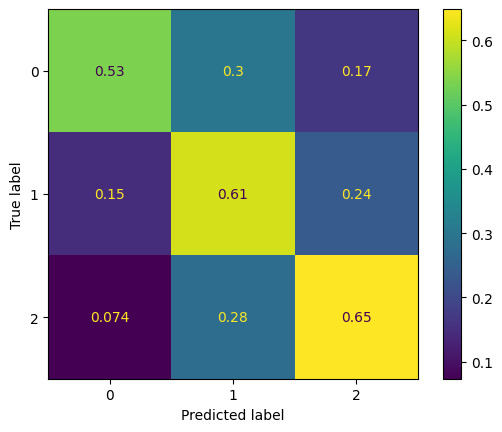

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.93694. Saving Model!
epoch 01, loss: 1.10772, acc: 0.37823, val_loss: 0.93694, val_accuracy: 0.55045


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


[INFO] val_acc has been improved from 0.93694 to 0.93631. Saving Model!
epoch 02, loss: 0.95197, acc: 0.50915, val_loss: 0.93631, val_accuracy: 0.52513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 03, loss: 0.97386, acc: 0.49818, val_loss: 0.94528, val_accuracy: 0.53161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


epoch 04, loss: 0.99129, acc: 0.48391, val_loss: 0.94229, val_accuracy: 0.52199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


[INFO] val_acc has been improved from 0.93631 to 0.93602. Saving Model!
epoch 05, loss: 0.99302, acc: 0.47883, val_loss: 0.93602, val_accuracy: 0.52140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.93602 to 0.93198. Saving Model!
epoch 06, loss: 0.98827, acc: 0.47257, val_loss: 0.93198, val_accuracy: 0.52218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


[INFO] val_acc has been improved from 0.93198 to 0.92900. Saving Model!
epoch 07, loss: 0.98219, acc: 0.47407, val_loss: 0.92900, val_accuracy: 0.52807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


[INFO] val_acc has been improved from 0.92900 to 0.92646. Saving Model!
epoch 08, loss: 0.97704, acc: 0.47927, val_loss: 0.92646, val_accuracy: 0.51904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


[INFO] val_acc has been improved from 0.92646 to 0.92495. Saving Model!
epoch 09, loss: 0.97522, acc: 0.48075, val_loss: 0.92495, val_accuracy: 0.52316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


[INFO] val_acc has been improved from 0.92495 to 0.92362. Saving Model!
epoch 10, loss: 0.97639, acc: 0.47918, val_loss: 0.92362, val_accuracy: 0.52473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


[INFO] val_acc has been improved from 0.92362 to 0.92201. Saving Model!
epoch 11, loss: 0.97736, acc: 0.47876, val_loss: 0.92201, val_accuracy: 0.52788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


[INFO] val_acc has been improved from 0.92201 to 0.92057. Saving Model!
epoch 12, loss: 0.97657, acc: 0.47920, val_loss: 0.92057, val_accuracy: 0.52689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


[INFO] val_acc has been improved from 0.92057 to 0.91952. Saving Model!
epoch 13, loss: 0.97468, acc: 0.48099, val_loss: 0.91952, val_accuracy: 0.53750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


[INFO] val_acc has been improved from 0.91952 to 0.91878. Saving Model!
epoch 14, loss: 0.97275, acc: 0.48284, val_loss: 0.91878, val_accuracy: 0.53789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


[INFO] val_acc has been improved from 0.91878 to 0.91812. Saving Model!
epoch 15, loss: 0.97154, acc: 0.48404, val_loss: 0.91812, val_accuracy: 0.53926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


[INFO] val_acc has been improved from 0.91812 to 0.91735. Saving Model!
epoch 16, loss: 0.97109, acc: 0.48485, val_loss: 0.91735, val_accuracy: 0.53848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


[INFO] val_acc has been improved from 0.91735 to 0.91646. Saving Model!
epoch 17, loss: 0.97077, acc: 0.48509, val_loss: 0.91646, val_accuracy: 0.53848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


[INFO] val_acc has been improved from 0.91646 to 0.91553. Saving Model!
epoch 18, loss: 0.97006, acc: 0.48598, val_loss: 0.91553, val_accuracy: 0.53750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


[INFO] val_acc has been improved from 0.91553 to 0.91468. Saving Model!
epoch 19, loss: 0.96899, acc: 0.48701, val_loss: 0.91468, val_accuracy: 0.54888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


[INFO] val_acc has been improved from 0.91468 to 0.91391. Saving Model!
epoch 20, loss: 0.96794, acc: 0.48810, val_loss: 0.91391, val_accuracy: 0.54888


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


[INFO] val_acc has been improved from 0.91391 to 0.91317. Saving Model!
epoch 21, loss: 0.96708, acc: 0.48838, val_loss: 0.91317, val_accuracy: 0.54849


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.91317 to 0.91242. Saving Model!
epoch 22, loss: 0.96642, acc: 0.48965, val_loss: 0.91242, val_accuracy: 0.54967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


[INFO] val_acc has been improved from 0.91242 to 0.91166. Saving Model!
epoch 23, loss: 0.96581, acc: 0.49046, val_loss: 0.91166, val_accuracy: 0.54927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


[INFO] val_acc has been improved from 0.91166 to 0.91090. Saving Model!
epoch 24, loss: 0.96510, acc: 0.49065, val_loss: 0.91090, val_accuracy: 0.54868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


[INFO] val_acc has been improved from 0.91090 to 0.91017. Saving Model!
epoch 25, loss: 0.96432, acc: 0.49150, val_loss: 0.91017, val_accuracy: 0.54947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


[INFO] val_acc has been improved from 0.91017 to 0.90948. Saving Model!
epoch 26, loss: 0.96353, acc: 0.49192, val_loss: 0.90948, val_accuracy: 0.54947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


[INFO] val_acc has been improved from 0.90948 to 0.90885. Saving Model!
epoch 27, loss: 0.96279, acc: 0.49251, val_loss: 0.90885, val_accuracy: 0.55006


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


[INFO] val_acc has been improved from 0.90885 to 0.90825. Saving Model!
epoch 28, loss: 0.96208, acc: 0.49307, val_loss: 0.90825, val_accuracy: 0.54967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.90825 to 0.90763. Saving Model!
epoch 29, loss: 0.96135, acc: 0.49227, val_loss: 0.90763, val_accuracy: 0.54986


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


[INFO] val_acc has been improved from 0.90763 to 0.90704. Saving Model!
epoch 30, loss: 0.96057, acc: 0.49425, val_loss: 0.90704, val_accuracy: 0.54967


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


[INFO] val_acc has been improved from 0.90704 to 0.90648. Saving Model!
epoch 31, loss: 0.95984, acc: 0.49458, val_loss: 0.90648, val_accuracy: 0.54986


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


[INFO] val_acc has been improved from 0.90648 to 0.90590. Saving Model!
epoch 32, loss: 0.95914, acc: 0.49488, val_loss: 0.90590, val_accuracy: 0.55084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


[INFO] val_acc has been improved from 0.90590 to 0.90531. Saving Model!
epoch 33, loss: 0.95843, acc: 0.49521, val_loss: 0.90531, val_accuracy: 0.55202


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


[INFO] val_acc has been improved from 0.90531 to 0.90470. Saving Model!
epoch 34, loss: 0.95768, acc: 0.49456, val_loss: 0.90470, val_accuracy: 0.55300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.90470 to 0.90409. Saving Model!
epoch 35, loss: 0.95704, acc: 0.49497, val_loss: 0.90409, val_accuracy: 0.55399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


[INFO] val_acc has been improved from 0.90409 to 0.90350. Saving Model!
epoch 36, loss: 0.95631, acc: 0.49556, val_loss: 0.90350, val_accuracy: 0.55497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


[INFO] val_acc has been improved from 0.90350 to 0.90290. Saving Model!
epoch 37, loss: 0.95557, acc: 0.49587, val_loss: 0.90290, val_accuracy: 0.55516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


[INFO] val_acc has been improved from 0.90290 to 0.90233. Saving Model!
epoch 38, loss: 0.95490, acc: 0.49646, val_loss: 0.90233, val_accuracy: 0.55575


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


[INFO] val_acc has been improved from 0.90233 to 0.90178. Saving Model!
epoch 39, loss: 0.95426, acc: 0.49722, val_loss: 0.90178, val_accuracy: 0.55673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


[INFO] val_acc has been improved from 0.90178 to 0.90123. Saving Model!
epoch 40, loss: 0.95357, acc: 0.49789, val_loss: 0.90123, val_accuracy: 0.55693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


[INFO] val_acc has been improved from 0.90123 to 0.90067. Saving Model!
epoch 41, loss: 0.95296, acc: 0.49831, val_loss: 0.90067, val_accuracy: 0.55693


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


[INFO] val_acc has been improved from 0.90067 to 0.90014. Saving Model!
epoch 42, loss: 0.95229, acc: 0.49726, val_loss: 0.90014, val_accuracy: 0.55673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


[INFO] val_acc has been improved from 0.90014 to 0.89960. Saving Model!
epoch 43, loss: 0.95159, acc: 0.49761, val_loss: 0.89960, val_accuracy: 0.55732


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.89960 to 0.89905. Saving Model!
epoch 44, loss: 0.95101, acc: 0.49768, val_loss: 0.89905, val_accuracy: 0.55752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


[INFO] val_acc has been improved from 0.89905 to 0.89854. Saving Model!
epoch 45, loss: 0.95037, acc: 0.49794, val_loss: 0.89854, val_accuracy: 0.55771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


[INFO] val_acc has been improved from 0.89854 to 0.89803. Saving Model!
epoch 46, loss: 0.94974, acc: 0.49813, val_loss: 0.89803, val_accuracy: 0.55811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.89803 to 0.89754. Saving Model!
epoch 47, loss: 0.94904, acc: 0.49837, val_loss: 0.89754, val_accuracy: 0.55791


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


[INFO] val_acc has been improved from 0.89754 to 0.89707. Saving Model!
epoch 48, loss: 0.94836, acc: 0.49861, val_loss: 0.89707, val_accuracy: 0.55811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


[INFO] val_acc has been improved from 0.89707 to 0.89659. Saving Model!
epoch 49, loss: 0.94769, acc: 0.50064, val_loss: 0.89659, val_accuracy: 0.55752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


[INFO] val_acc has been improved from 0.89659 to 0.89614. Saving Model!
epoch 50, loss: 0.94708, acc: 0.50080, val_loss: 0.89614, val_accuracy: 0.55811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


[INFO] val_acc has been improved from 0.89614 to 0.89569. Saving Model!
epoch 51, loss: 0.94643, acc: 0.50230, val_loss: 0.89569, val_accuracy: 0.55850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


[INFO] val_acc has been improved from 0.89569 to 0.89526. Saving Model!
epoch 52, loss: 0.94575, acc: 0.50267, val_loss: 0.89526, val_accuracy: 0.55850


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


[INFO] val_acc has been improved from 0.89526 to 0.89481. Saving Model!
epoch 53, loss: 0.94517, acc: 0.50298, val_loss: 0.89481, val_accuracy: 0.55909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


[INFO] val_acc has been improved from 0.89481 to 0.89435. Saving Model!
epoch 54, loss: 0.94456, acc: 0.50330, val_loss: 0.89435, val_accuracy: 0.55948


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


[INFO] val_acc has been improved from 0.89435 to 0.89390. Saving Model!
epoch 55, loss: 0.94394, acc: 0.50363, val_loss: 0.89390, val_accuracy: 0.55987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


[INFO] val_acc has been improved from 0.89390 to 0.89343. Saving Model!
epoch 56, loss: 0.94327, acc: 0.50409, val_loss: 0.89343, val_accuracy: 0.55948


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


[INFO] val_acc has been improved from 0.89343 to 0.89301. Saving Model!
epoch 57, loss: 0.94260, acc: 0.50440, val_loss: 0.89301, val_accuracy: 0.55870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


[INFO] val_acc has been improved from 0.89301 to 0.89260. Saving Model!
epoch 58, loss: 0.94200, acc: 0.50470, val_loss: 0.89260, val_accuracy: 0.55889


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.89260 to 0.89218. Saving Model!
epoch 59, loss: 0.94143, acc: 0.50520, val_loss: 0.89218, val_accuracy: 0.55909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


[INFO] val_acc has been improved from 0.89218 to 0.89176. Saving Model!
epoch 60, loss: 0.94082, acc: 0.50560, val_loss: 0.89176, val_accuracy: 0.55909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


[INFO] val_acc has been improved from 0.89176 to 0.89136. Saving Model!
epoch 61, loss: 0.94013, acc: 0.50669, val_loss: 0.89136, val_accuracy: 0.55929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


[INFO] val_acc has been improved from 0.89136 to 0.89098. Saving Model!
epoch 62, loss: 0.93947, acc: 0.50627, val_loss: 0.89098, val_accuracy: 0.56007


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


[INFO] val_acc has been improved from 0.89098 to 0.89055. Saving Model!
epoch 63, loss: 0.93886, acc: 0.50673, val_loss: 0.89055, val_accuracy: 0.56105


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


[INFO] val_acc has been improved from 0.89055 to 0.89017. Saving Model!
epoch 64, loss: 0.93825, acc: 0.50743, val_loss: 0.89017, val_accuracy: 0.56125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


[INFO] val_acc has been improved from 0.89017 to 0.88983. Saving Model!
epoch 65, loss: 0.93759, acc: 0.50782, val_loss: 0.88983, val_accuracy: 0.56341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


[INFO] val_acc has been improved from 0.88983 to 0.88944. Saving Model!
epoch 66, loss: 0.93697, acc: 0.50924, val_loss: 0.88944, val_accuracy: 0.56478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


[INFO] val_acc has been improved from 0.88944 to 0.88900. Saving Model!
epoch 67, loss: 0.93643, acc: 0.50961, val_loss: 0.88900, val_accuracy: 0.56439


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


[INFO] val_acc has been improved from 0.88900 to 0.88860. Saving Model!
epoch 68, loss: 0.93580, acc: 0.51083, val_loss: 0.88860, val_accuracy: 0.56478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


[INFO] val_acc has been improved from 0.88860 to 0.88819. Saving Model!
epoch 69, loss: 0.93512, acc: 0.51179, val_loss: 0.88819, val_accuracy: 0.56576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.95it/s]


[INFO] val_acc has been improved from 0.88819 to 0.88777. Saving Model!
epoch 70, loss: 0.93454, acc: 0.51225, val_loss: 0.88777, val_accuracy: 0.56655


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


[INFO] val_acc has been improved from 0.88777 to 0.88738. Saving Model!
epoch 71, loss: 0.93398, acc: 0.51312, val_loss: 0.88738, val_accuracy: 0.56733


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


[INFO] val_acc has been improved from 0.88738 to 0.88695. Saving Model!
epoch 72, loss: 0.93339, acc: 0.51378, val_loss: 0.88695, val_accuracy: 0.56812


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.88695 to 0.88651. Saving Model!
epoch 73, loss: 0.93277, acc: 0.51513, val_loss: 0.88651, val_accuracy: 0.56910


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


[INFO] val_acc has been improved from 0.88651 to 0.88614. Saving Model!
epoch 74, loss: 0.93223, acc: 0.51554, val_loss: 0.88614, val_accuracy: 0.56989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


[INFO] val_acc has been improved from 0.88614 to 0.88569. Saving Model!
epoch 75, loss: 0.93159, acc: 0.51631, val_loss: 0.88569, val_accuracy: 0.57126


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


[INFO] val_acc has been improved from 0.88569 to 0.88522. Saving Model!
epoch 76, loss: 0.93091, acc: 0.51820, val_loss: 0.88522, val_accuracy: 0.57146


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


[INFO] val_acc has been improved from 0.88522 to 0.88478. Saving Model!
epoch 77, loss: 0.93038, acc: 0.51903, val_loss: 0.88478, val_accuracy: 0.57224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


[INFO] val_acc has been improved from 0.88478 to 0.88433. Saving Model!
epoch 78, loss: 0.92986, acc: 0.52006, val_loss: 0.88433, val_accuracy: 0.57322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.18it/s]


[INFO] val_acc has been improved from 0.88433 to 0.88388. Saving Model!
epoch 79, loss: 0.92917, acc: 0.52082, val_loss: 0.88388, val_accuracy: 0.57342


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


[INFO] val_acc has been improved from 0.88388 to 0.88339. Saving Model!
epoch 80, loss: 0.92855, acc: 0.52158, val_loss: 0.88339, val_accuracy: 0.57303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


[INFO] val_acc has been improved from 0.88339 to 0.88293. Saving Model!
epoch 81, loss: 0.92803, acc: 0.52235, val_loss: 0.88293, val_accuracy: 0.57244


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


[INFO] val_acc has been improved from 0.88293 to 0.88247. Saving Model!
epoch 82, loss: 0.92737, acc: 0.52278, val_loss: 0.88247, val_accuracy: 0.57362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


[INFO] val_acc has been improved from 0.88247 to 0.88204. Saving Model!
epoch 83, loss: 0.92686, acc: 0.52364, val_loss: 0.88204, val_accuracy: 0.57362


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


[INFO] val_acc has been improved from 0.88204 to 0.88161. Saving Model!
epoch 84, loss: 0.92620, acc: 0.52440, val_loss: 0.88161, val_accuracy: 0.57420


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


[INFO] val_acc has been improved from 0.88161 to 0.88114. Saving Model!
epoch 85, loss: 0.92566, acc: 0.52531, val_loss: 0.88114, val_accuracy: 0.57401


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


[INFO] val_acc has been improved from 0.88114 to 0.88069. Saving Model!
epoch 86, loss: 0.92504, acc: 0.52582, val_loss: 0.88069, val_accuracy: 0.57460


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.88069 to 0.88024. Saving Model!
epoch 87, loss: 0.92444, acc: 0.52617, val_loss: 0.88024, val_accuracy: 0.57558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


[INFO] val_acc has been improved from 0.88024 to 0.87977. Saving Model!
epoch 88, loss: 0.92390, acc: 0.52708, val_loss: 0.87977, val_accuracy: 0.57558


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


[INFO] val_acc has been improved from 0.87977 to 0.87930. Saving Model!
epoch 89, loss: 0.92333, acc: 0.52758, val_loss: 0.87930, val_accuracy: 0.57578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


[INFO] val_acc has been improved from 0.87930 to 0.87891. Saving Model!
epoch 90, loss: 0.92264, acc: 0.52894, val_loss: 0.87891, val_accuracy: 0.57676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


[INFO] val_acc has been improved from 0.87891 to 0.87845. Saving Model!
epoch 91, loss: 0.92216, acc: 0.52922, val_loss: 0.87845, val_accuracy: 0.57735


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


[INFO] val_acc has been improved from 0.87845 to 0.87797. Saving Model!
epoch 92, loss: 0.92151, acc: 0.52979, val_loss: 0.87797, val_accuracy: 0.57813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


[INFO] val_acc has been improved from 0.87797 to 0.87752. Saving Model!
epoch 93, loss: 0.92090, acc: 0.52970, val_loss: 0.87752, val_accuracy: 0.57872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.87752 to 0.87715. Saving Model!
epoch 94, loss: 0.92026, acc: 0.53009, val_loss: 0.87715, val_accuracy: 0.57931


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


[INFO] val_acc has been improved from 0.87715 to 0.87679. Saving Model!
epoch 95, loss: 0.91966, acc: 0.53173, val_loss: 0.87679, val_accuracy: 0.57951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.51it/s]


[INFO] val_acc has been improved from 0.87679 to 0.87642. Saving Model!
epoch 96, loss: 0.91897, acc: 0.53234, val_loss: 0.87642, val_accuracy: 0.57990


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


[INFO] val_acc has been improved from 0.87642 to 0.87600. Saving Model!
epoch 97, loss: 0.91825, acc: 0.53304, val_loss: 0.87600, val_accuracy: 0.58049


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


[INFO] val_acc has been improved from 0.87600 to 0.87562. Saving Model!
epoch 98, loss: 0.91777, acc: 0.53367, val_loss: 0.87562, val_accuracy: 0.58029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


[INFO] val_acc has been improved from 0.87562 to 0.87526. Saving Model!
epoch 99, loss: 0.91711, acc: 0.53371, val_loss: 0.87526, val_accuracy: 0.58147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


[INFO] val_acc has been improved from 0.87526 to 0.87491. Saving Model!
epoch 100, loss: 0.91643, acc: 0.53419, val_loss: 0.87491, val_accuracy: 0.57578


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


[INFO] val_acc has been improved from 0.87491 to 0.87451. Saving Model!
epoch 101, loss: 0.91591, acc: 0.53448, val_loss: 0.87451, val_accuracy: 0.57676


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


[INFO] val_acc has been improved from 0.87451 to 0.87414. Saving Model!
epoch 102, loss: 0.91534, acc: 0.53463, val_loss: 0.87414, val_accuracy: 0.57793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


[INFO] val_acc has been improved from 0.87414 to 0.87375. Saving Model!
epoch 103, loss: 0.91466, acc: 0.53498, val_loss: 0.87375, val_accuracy: 0.57852


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


[INFO] val_acc has been improved from 0.87375 to 0.87335. Saving Model!
epoch 104, loss: 0.91412, acc: 0.53526, val_loss: 0.87335, val_accuracy: 0.57951


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


[INFO] val_acc has been improved from 0.87335 to 0.87298. Saving Model!
epoch 105, loss: 0.91354, acc: 0.53546, val_loss: 0.87298, val_accuracy: 0.58068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


[INFO] val_acc has been improved from 0.87298 to 0.87258. Saving Model!
epoch 106, loss: 0.91296, acc: 0.53616, val_loss: 0.87258, val_accuracy: 0.58088


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


[INFO] val_acc has been improved from 0.87258 to 0.87223. Saving Model!
epoch 107, loss: 0.91233, acc: 0.53646, val_loss: 0.87223, val_accuracy: 0.58147


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


[INFO] val_acc has been improved from 0.87223 to 0.87185. Saving Model!
epoch 108, loss: 0.91176, acc: 0.53677, val_loss: 0.87185, val_accuracy: 0.58166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 0.87185 to 0.87149. Saving Model!
epoch 109, loss: 0.91124, acc: 0.53696, val_loss: 0.87149, val_accuracy: 0.58304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.87149 to 0.87117. Saving Model!
epoch 110, loss: 0.91059, acc: 0.53733, val_loss: 0.87117, val_accuracy: 0.58343


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


[INFO] val_acc has been improved from 0.87117 to 0.87077. Saving Model!
epoch 111, loss: 0.91003, acc: 0.53770, val_loss: 0.87077, val_accuracy: 0.58402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.87077 to 0.87035. Saving Model!
epoch 112, loss: 0.90950, acc: 0.53814, val_loss: 0.87035, val_accuracy: 0.58363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


[INFO] val_acc has been improved from 0.87035 to 0.87001. Saving Model!
epoch 113, loss: 0.90888, acc: 0.53821, val_loss: 0.87001, val_accuracy: 0.58402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.87001 to 0.86967. Saving Model!
epoch 114, loss: 0.90821, acc: 0.53834, val_loss: 0.86967, val_accuracy: 0.58363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


[INFO] val_acc has been improved from 0.86967 to 0.86925. Saving Model!
epoch 115, loss: 0.90765, acc: 0.53941, val_loss: 0.86925, val_accuracy: 0.58382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


[INFO] val_acc has been improved from 0.86925 to 0.86887. Saving Model!
epoch 116, loss: 0.90720, acc: 0.53984, val_loss: 0.86887, val_accuracy: 0.58382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


[INFO] val_acc has been improved from 0.86887 to 0.86851. Saving Model!
epoch 117, loss: 0.90648, acc: 0.54026, val_loss: 0.86851, val_accuracy: 0.58382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


[INFO] val_acc has been improved from 0.86851 to 0.86822. Saving Model!
epoch 118, loss: 0.90587, acc: 0.54043, val_loss: 0.86822, val_accuracy: 0.58382


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


[INFO] val_acc has been improved from 0.86822 to 0.86786. Saving Model!
epoch 119, loss: 0.90527, acc: 0.54082, val_loss: 0.86786, val_accuracy: 0.58402


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


[INFO] val_acc has been improved from 0.86786 to 0.86742. Saving Model!
epoch 120, loss: 0.90474, acc: 0.54128, val_loss: 0.86742, val_accuracy: 0.58441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


[INFO] val_acc has been improved from 0.86742 to 0.86701. Saving Model!
epoch 121, loss: 0.90418, acc: 0.54172, val_loss: 0.86701, val_accuracy: 0.58500


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


[INFO] val_acc has been improved from 0.86701 to 0.86665. Saving Model!
epoch 122, loss: 0.90348, acc: 0.54231, val_loss: 0.86665, val_accuracy: 0.58481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


[INFO] val_acc has been improved from 0.86665 to 0.86626. Saving Model!
epoch 123, loss: 0.90302, acc: 0.54270, val_loss: 0.86626, val_accuracy: 0.58500


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


[INFO] val_acc has been improved from 0.86626 to 0.86587. Saving Model!
epoch 124, loss: 0.90251, acc: 0.54298, val_loss: 0.86587, val_accuracy: 0.58520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.86587 to 0.86549. Saving Model!
epoch 125, loss: 0.90178, acc: 0.54353, val_loss: 0.86549, val_accuracy: 0.58579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


[INFO] val_acc has been improved from 0.86549 to 0.86517. Saving Model!
epoch 126, loss: 0.90121, acc: 0.54349, val_loss: 0.86517, val_accuracy: 0.58618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.86517 to 0.86484. Saving Model!
epoch 127, loss: 0.90070, acc: 0.54379, val_loss: 0.86484, val_accuracy: 0.58618


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


[INFO] val_acc has been improved from 0.86484 to 0.86442. Saving Model!
epoch 128, loss: 0.90011, acc: 0.54381, val_loss: 0.86442, val_accuracy: 0.58677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


[INFO] val_acc has been improved from 0.86442 to 0.86402. Saving Model!
epoch 129, loss: 0.89958, acc: 0.54410, val_loss: 0.86402, val_accuracy: 0.58657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.86402 to 0.86367. Saving Model!
epoch 130, loss: 0.89894, acc: 0.54458, val_loss: 0.86367, val_accuracy: 0.58736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


[INFO] val_acc has been improved from 0.86367 to 0.86333. Saving Model!
epoch 131, loss: 0.89833, acc: 0.54479, val_loss: 0.86333, val_accuracy: 0.58755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


[INFO] val_acc has been improved from 0.86333 to 0.86293. Saving Model!
epoch 132, loss: 0.89783, acc: 0.54495, val_loss: 0.86293, val_accuracy: 0.58736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


[INFO] val_acc has been improved from 0.86293 to 0.86255. Saving Model!
epoch 133, loss: 0.89736, acc: 0.54523, val_loss: 0.86255, val_accuracy: 0.58775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


[INFO] val_acc has been improved from 0.86255 to 0.86218. Saving Model!
epoch 134, loss: 0.89672, acc: 0.54540, val_loss: 0.86218, val_accuracy: 0.58775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


[INFO] val_acc has been improved from 0.86218 to 0.86184. Saving Model!
epoch 135, loss: 0.89619, acc: 0.54573, val_loss: 0.86184, val_accuracy: 0.58775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


[INFO] val_acc has been improved from 0.86184 to 0.86145. Saving Model!
epoch 136, loss: 0.89568, acc: 0.54704, val_loss: 0.86145, val_accuracy: 0.58755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


[INFO] val_acc has been improved from 0.86145 to 0.86109. Saving Model!
epoch 137, loss: 0.89580, acc: 0.54669, val_loss: 0.86109, val_accuracy: 0.58814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


[INFO] val_acc has been improved from 0.86109 to 0.86065. Saving Model!
epoch 138, loss: 0.89459, acc: 0.54750, val_loss: 0.86065, val_accuracy: 0.58854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 0.86065 to 0.86027. Saving Model!
epoch 139, loss: 0.89421, acc: 0.54811, val_loss: 0.86027, val_accuracy: 0.58873


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


[INFO] val_acc has been improved from 0.86027 to 0.85996. Saving Model!
epoch 140, loss: 0.89348, acc: 0.54994, val_loss: 0.85996, val_accuracy: 0.58834


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


[INFO] val_acc has been improved from 0.85996 to 0.85960. Saving Model!
epoch 141, loss: 0.89289, acc: 0.55049, val_loss: 0.85960, val_accuracy: 0.58854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


[INFO] val_acc has been improved from 0.85960 to 0.85916. Saving Model!
epoch 142, loss: 0.89247, acc: 0.55068, val_loss: 0.85916, val_accuracy: 0.58893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


[INFO] val_acc has been improved from 0.85916 to 0.85882. Saving Model!
epoch 143, loss: 0.89190, acc: 0.55136, val_loss: 0.85882, val_accuracy: 0.58736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.85882 to 0.85841. Saving Model!
epoch 144, loss: 0.89135, acc: 0.55195, val_loss: 0.85841, val_accuracy: 0.58755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


[INFO] val_acc has been improved from 0.85841 to 0.85806. Saving Model!
epoch 145, loss: 0.89083, acc: 0.55208, val_loss: 0.85806, val_accuracy: 0.58795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


[INFO] val_acc has been improved from 0.85806 to 0.85775. Saving Model!
epoch 146, loss: 0.89023, acc: 0.55252, val_loss: 0.85775, val_accuracy: 0.58775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


[INFO] val_acc has been improved from 0.85775 to 0.85740. Saving Model!
epoch 147, loss: 0.88977, acc: 0.55287, val_loss: 0.85740, val_accuracy: 0.58795


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.85740 to 0.85696. Saving Model!
epoch 148, loss: 0.88928, acc: 0.55319, val_loss: 0.85696, val_accuracy: 0.58697


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


[INFO] val_acc has been improved from 0.85696 to 0.85661. Saving Model!
epoch 149, loss: 0.88869, acc: 0.55376, val_loss: 0.85661, val_accuracy: 0.58677


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


[INFO] val_acc has been improved from 0.85661 to 0.85620. Saving Model!
epoch 150, loss: 0.88811, acc: 0.55428, val_loss: 0.85620, val_accuracy: 0.58755


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


[INFO] val_acc has been improved from 0.85620 to 0.85584. Saving Model!
epoch 151, loss: 0.88769, acc: 0.55446, val_loss: 0.85584, val_accuracy: 0.58775


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


[INFO] val_acc has been improved from 0.85584 to 0.85544. Saving Model!
epoch 152, loss: 0.88704, acc: 0.55461, val_loss: 0.85544, val_accuracy: 0.58893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


[INFO] val_acc has been improved from 0.85544 to 0.85502. Saving Model!
epoch 153, loss: 0.88654, acc: 0.55550, val_loss: 0.85502, val_accuracy: 0.58912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


[INFO] val_acc has been improved from 0.85502 to 0.85469. Saving Model!
epoch 154, loss: 0.88602, acc: 0.55579, val_loss: 0.85469, val_accuracy: 0.58873


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.85469 to 0.85431. Saving Model!
epoch 155, loss: 0.88541, acc: 0.55590, val_loss: 0.85431, val_accuracy: 0.58932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


[INFO] val_acc has been improved from 0.85431 to 0.85394. Saving Model!
epoch 156, loss: 0.88499, acc: 0.55598, val_loss: 0.85394, val_accuracy: 0.58932


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


[INFO] val_acc has been improved from 0.85394 to 0.85366. Saving Model!
epoch 157, loss: 0.88440, acc: 0.55633, val_loss: 0.85366, val_accuracy: 0.58991


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


[INFO] val_acc has been improved from 0.85366 to 0.85326. Saving Model!
epoch 158, loss: 0.88386, acc: 0.55653, val_loss: 0.85326, val_accuracy: 0.58971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


[INFO] val_acc has been improved from 0.85326 to 0.85281. Saving Model!
epoch 159, loss: 0.88345, acc: 0.55753, val_loss: 0.85281, val_accuracy: 0.59011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.85281 to 0.85234. Saving Model!
epoch 160, loss: 0.88280, acc: 0.55756, val_loss: 0.85234, val_accuracy: 0.59050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


[INFO] val_acc has been improved from 0.85234 to 0.85194. Saving Model!
epoch 161, loss: 0.88218, acc: 0.55899, val_loss: 0.85194, val_accuracy: 0.59030


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.84it/s]


[INFO] val_acc has been improved from 0.85194 to 0.85156. Saving Model!
epoch 162, loss: 0.88175, acc: 0.56002, val_loss: 0.85156, val_accuracy: 0.59030


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


[INFO] val_acc has been improved from 0.85156 to 0.85115. Saving Model!
epoch 163, loss: 0.88115, acc: 0.56033, val_loss: 0.85115, val_accuracy: 0.59050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


[INFO] val_acc has been improved from 0.85115 to 0.85080. Saving Model!
epoch 164, loss: 0.88065, acc: 0.56054, val_loss: 0.85080, val_accuracy: 0.59168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


[INFO] val_acc has been improved from 0.85080 to 0.85043. Saving Model!
epoch 165, loss: 0.88002, acc: 0.56087, val_loss: 0.85043, val_accuracy: 0.59187


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


[INFO] val_acc has been improved from 0.85043 to 0.85007. Saving Model!
epoch 166, loss: 0.87952, acc: 0.56187, val_loss: 0.85007, val_accuracy: 0.59069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


[INFO] val_acc has been improved from 0.85007 to 0.84977. Saving Model!
epoch 167, loss: 0.87907, acc: 0.56205, val_loss: 0.84977, val_accuracy: 0.59069


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.08it/s]


[INFO] val_acc has been improved from 0.84977 to 0.84945. Saving Model!
epoch 168, loss: 0.87842, acc: 0.56233, val_loss: 0.84945, val_accuracy: 0.59109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


[INFO] val_acc has been improved from 0.84945 to 0.84904. Saving Model!
epoch 169, loss: 0.87785, acc: 0.56344, val_loss: 0.84904, val_accuracy: 0.59109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


[INFO] val_acc has been improved from 0.84904 to 0.84869. Saving Model!
epoch 170, loss: 0.87738, acc: 0.56368, val_loss: 0.84869, val_accuracy: 0.59109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


[INFO] val_acc has been improved from 0.84869 to 0.84831. Saving Model!
epoch 171, loss: 0.87693, acc: 0.56375, val_loss: 0.84831, val_accuracy: 0.59109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]


[INFO] val_acc has been improved from 0.84831 to 0.84795. Saving Model!
epoch 172, loss: 0.87632, acc: 0.56462, val_loss: 0.84795, val_accuracy: 0.59089


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


[INFO] val_acc has been improved from 0.84795 to 0.84757. Saving Model!
epoch 173, loss: 0.87578, acc: 0.56438, val_loss: 0.84757, val_accuracy: 0.59109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


[INFO] val_acc has been improved from 0.84757 to 0.84720. Saving Model!
epoch 174, loss: 0.87515, acc: 0.56495, val_loss: 0.84720, val_accuracy: 0.59109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.84720 to 0.84678. Saving Model!
epoch 175, loss: 0.87459, acc: 0.56536, val_loss: 0.84678, val_accuracy: 0.59168


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


[INFO] val_acc has been improved from 0.84678 to 0.84646. Saving Model!
epoch 176, loss: 0.87418, acc: 0.56504, val_loss: 0.84646, val_accuracy: 0.58343


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


[INFO] val_acc has been improved from 0.84646 to 0.84604. Saving Model!
epoch 177, loss: 0.87357, acc: 0.56554, val_loss: 0.84604, val_accuracy: 0.58324


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


[INFO] val_acc has been improved from 0.84604 to 0.84564. Saving Model!
epoch 178, loss: 0.87304, acc: 0.56578, val_loss: 0.84564, val_accuracy: 0.58363


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


[INFO] val_acc has been improved from 0.84564 to 0.84528. Saving Model!
epoch 179, loss: 0.87259, acc: 0.56615, val_loss: 0.84528, val_accuracy: 0.58422


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


[INFO] val_acc has been improved from 0.84528 to 0.84485. Saving Model!
epoch 180, loss: 0.87197, acc: 0.56678, val_loss: 0.84485, val_accuracy: 0.58441


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


[INFO] val_acc has been improved from 0.84485 to 0.84448. Saving Model!
epoch 181, loss: 0.87143, acc: 0.56689, val_loss: 0.84448, val_accuracy: 0.58500


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


[INFO] val_acc has been improved from 0.84448 to 0.84412. Saving Model!
epoch 182, loss: 0.87096, acc: 0.56772, val_loss: 0.84412, val_accuracy: 0.58520


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


[INFO] val_acc has been improved from 0.84412 to 0.84375. Saving Model!
epoch 183, loss: 0.87028, acc: 0.56813, val_loss: 0.84375, val_accuracy: 0.58539


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


[INFO] val_acc has been improved from 0.84375 to 0.84328. Saving Model!
epoch 184, loss: 0.86982, acc: 0.56846, val_loss: 0.84328, val_accuracy: 0.58579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.84328 to 0.84290. Saving Model!
epoch 185, loss: 0.86934, acc: 0.56883, val_loss: 0.84290, val_accuracy: 0.58598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


[INFO] val_acc has been improved from 0.84290 to 0.84251. Saving Model!
epoch 186, loss: 0.86876, acc: 0.56909, val_loss: 0.84251, val_accuracy: 0.58598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


[INFO] val_acc has been improved from 0.84251 to 0.84222. Saving Model!
epoch 187, loss: 0.86812, acc: 0.56861, val_loss: 0.84222, val_accuracy: 0.58579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


[INFO] val_acc has been improved from 0.84222 to 0.84184. Saving Model!
epoch 188, loss: 0.86786, acc: 0.56868, val_loss: 0.84184, val_accuracy: 0.58598


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


[INFO] val_acc has been improved from 0.84184 to 0.84138. Saving Model!
epoch 189, loss: 0.86719, acc: 0.56899, val_loss: 0.84138, val_accuracy: 0.58657


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s]


[INFO] val_acc has been improved from 0.84138 to 0.84094. Saving Model!
epoch 190, loss: 0.86670, acc: 0.56927, val_loss: 0.84094, val_accuracy: 0.58736


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


[INFO] val_acc has been improved from 0.84094 to 0.84065. Saving Model!
epoch 191, loss: 0.86617, acc: 0.56990, val_loss: 0.84065, val_accuracy: 0.58814


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 0.84065 to 0.84038. Saving Model!
epoch 192, loss: 0.86553, acc: 0.57034, val_loss: 0.84038, val_accuracy: 0.58893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


[INFO] val_acc has been improved from 0.84038 to 0.83997. Saving Model!
epoch 193, loss: 0.86522, acc: 0.56957, val_loss: 0.83997, val_accuracy: 0.58912


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


[INFO] val_acc has been improved from 0.83997 to 0.83954. Saving Model!
epoch 194, loss: 0.86476, acc: 0.57047, val_loss: 0.83954, val_accuracy: 0.58952


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


[INFO] val_acc has been improved from 0.83954 to 0.83917. Saving Model!
epoch 195, loss: 0.86401, acc: 0.57226, val_loss: 0.83917, val_accuracy: 0.59011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


[INFO] val_acc has been improved from 0.83917 to 0.83882. Saving Model!
epoch 196, loss: 0.86353, acc: 0.57171, val_loss: 0.83882, val_accuracy: 0.58971


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


[INFO] val_acc has been improved from 0.83882 to 0.83853. Saving Model!
epoch 197, loss: 0.86314, acc: 0.57213, val_loss: 0.83853, val_accuracy: 0.59011


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


[INFO] val_acc has been improved from 0.83853 to 0.83818. Saving Model!
epoch 198, loss: 0.86250, acc: 0.57250, val_loss: 0.83818, val_accuracy: 0.59050


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


[INFO] val_acc has been improved from 0.83818 to 0.83776. Saving Model!
epoch 199, loss: 0.86202, acc: 0.57282, val_loss: 0.83776, val_accuracy: 0.59109


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


[INFO] val_acc has been improved from 0.83776 to 0.83737. Saving Model!
epoch 200, loss: 0.86162, acc: 0.57350, val_loss: 0.83737, val_accuracy: 0.59227


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


[INFO] val_acc has been improved from 0.83737 to 0.83707. Saving Model!
epoch 201, loss: 0.86089, acc: 0.57387, val_loss: 0.83707, val_accuracy: 0.59305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


[INFO] val_acc has been improved from 0.83707 to 0.83666. Saving Model!
epoch 202, loss: 0.86053, acc: 0.57464, val_loss: 0.83666, val_accuracy: 0.59305


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


[INFO] val_acc has been improved from 0.83666 to 0.83626. Saving Model!
epoch 203, loss: 0.86001, acc: 0.57496, val_loss: 0.83626, val_accuracy: 0.59325


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


[INFO] val_acc has been improved from 0.83626 to 0.83585. Saving Model!
epoch 204, loss: 0.85931, acc: 0.57546, val_loss: 0.83585, val_accuracy: 0.59344


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


[INFO] val_acc has been improved from 0.83585 to 0.83543. Saving Model!
epoch 205, loss: 0.85891, acc: 0.57594, val_loss: 0.83543, val_accuracy: 0.59364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


[INFO] val_acc has been improved from 0.83543 to 0.83504. Saving Model!
epoch 206, loss: 0.85847, acc: 0.57594, val_loss: 0.83504, val_accuracy: 0.59423


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.70it/s]


[INFO] val_acc has been improved from 0.83504 to 0.83461. Saving Model!
epoch 207, loss: 0.85784, acc: 0.57645, val_loss: 0.83461, val_accuracy: 0.59521


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


[INFO] val_acc has been improved from 0.83461 to 0.83416. Saving Model!
epoch 208, loss: 0.85727, acc: 0.57682, val_loss: 0.83416, val_accuracy: 0.59619


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


[INFO] val_acc has been improved from 0.83416 to 0.83377. Saving Model!
epoch 209, loss: 0.85688, acc: 0.57723, val_loss: 0.83377, val_accuracy: 0.59658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


[INFO] val_acc has been improved from 0.83377 to 0.83342. Saving Model!
epoch 210, loss: 0.85624, acc: 0.57754, val_loss: 0.83342, val_accuracy: 0.59678


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


[INFO] val_acc has been improved from 0.83342 to 0.83308. Saving Model!
epoch 211, loss: 0.85572, acc: 0.57802, val_loss: 0.83308, val_accuracy: 0.59658


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


[INFO] val_acc has been improved from 0.83308 to 0.83276. Saving Model!
epoch 212, loss: 0.85531, acc: 0.57891, val_loss: 0.83276, val_accuracy: 0.59717


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]


[INFO] val_acc has been improved from 0.83276 to 0.83236. Saving Model!
epoch 213, loss: 0.85467, acc: 0.57937, val_loss: 0.83236, val_accuracy: 0.59737


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


[INFO] val_acc has been improved from 0.83236 to 0.83193. Saving Model!
epoch 214, loss: 0.85431, acc: 0.57994, val_loss: 0.83193, val_accuracy: 0.59796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


[INFO] val_acc has been improved from 0.83193 to 0.83168. Saving Model!
epoch 215, loss: 0.85368, acc: 0.58026, val_loss: 0.83168, val_accuracy: 0.59796


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


[INFO] val_acc has been improved from 0.83168 to 0.83131. Saving Model!
epoch 216, loss: 0.85313, acc: 0.58183, val_loss: 0.83131, val_accuracy: 0.59894


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


[INFO] val_acc has been improved from 0.83131 to 0.83086. Saving Model!
epoch 217, loss: 0.85272, acc: 0.58207, val_loss: 0.83086, val_accuracy: 0.59914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


[INFO] val_acc has been improved from 0.83086 to 0.83055. Saving Model!
epoch 218, loss: 0.85212, acc: 0.58229, val_loss: 0.83055, val_accuracy: 0.59914


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


[INFO] val_acc has been improved from 0.83055 to 0.83033. Saving Model!
epoch 219, loss: 0.85173, acc: 0.58266, val_loss: 0.83033, val_accuracy: 0.59933


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


[INFO] val_acc has been improved from 0.83033 to 0.82999. Saving Model!
epoch 220, loss: 0.85108, acc: 0.58303, val_loss: 0.82999, val_accuracy: 0.59933


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


[INFO] val_acc has been improved from 0.82999 to 0.82966. Saving Model!
epoch 221, loss: 0.85064, acc: 0.58354, val_loss: 0.82966, val_accuracy: 0.59933


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


[INFO] val_acc has been improved from 0.82966 to 0.82930. Saving Model!
epoch 222, loss: 0.85015, acc: 0.58393, val_loss: 0.82930, val_accuracy: 0.59933


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


[INFO] val_acc has been improved from 0.82930 to 0.82902. Saving Model!
epoch 223, loss: 0.84965, acc: 0.58495, val_loss: 0.82902, val_accuracy: 0.59933


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.82902 to 0.82873. Saving Model!
epoch 224, loss: 0.84903, acc: 0.58521, val_loss: 0.82873, val_accuracy: 0.60051


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


[INFO] val_acc has been improved from 0.82873 to 0.82837. Saving Model!
epoch 225, loss: 0.84879, acc: 0.58574, val_loss: 0.82837, val_accuracy: 0.60149


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


[INFO] val_acc has been improved from 0.82837 to 0.82799. Saving Model!
epoch 226, loss: 0.84801, acc: 0.58617, val_loss: 0.82799, val_accuracy: 0.60228


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 0.82799 to 0.82760. Saving Model!
epoch 227, loss: 0.84766, acc: 0.58670, val_loss: 0.82760, val_accuracy: 0.60346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


[INFO] val_acc has been improved from 0.82760 to 0.82732. Saving Model!
epoch 228, loss: 0.84718, acc: 0.58711, val_loss: 0.82732, val_accuracy: 0.60346


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


[INFO] val_acc has been improved from 0.82732 to 0.82707. Saving Model!
epoch 229, loss: 0.84651, acc: 0.58766, val_loss: 0.82707, val_accuracy: 0.60404


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


[INFO] val_acc has been improved from 0.82707 to 0.82659. Saving Model!
epoch 230, loss: 0.84631, acc: 0.58775, val_loss: 0.82659, val_accuracy: 0.60444


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.82659 to 0.82623. Saving Model!
epoch 231, loss: 0.84563, acc: 0.58799, val_loss: 0.82623, val_accuracy: 0.60483


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


[INFO] val_acc has been improved from 0.82623 to 0.82589. Saving Model!
epoch 232, loss: 0.84523, acc: 0.58831, val_loss: 0.82589, val_accuracy: 0.60542


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


[INFO] val_acc has been improved from 0.82589 to 0.82559. Saving Model!
epoch 233, loss: 0.84469, acc: 0.58857, val_loss: 0.82559, val_accuracy: 0.60601


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


[INFO] val_acc has been improved from 0.82559 to 0.82527. Saving Model!
epoch 234, loss: 0.84407, acc: 0.58914, val_loss: 0.82527, val_accuracy: 0.60718


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


[INFO] val_acc has been improved from 0.82527 to 0.82495. Saving Model!
epoch 235, loss: 0.84387, acc: 0.58956, val_loss: 0.82495, val_accuracy: 0.60817


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


[INFO] val_acc has been improved from 0.82495 to 0.82464. Saving Model!
epoch 236, loss: 0.84305, acc: 0.58982, val_loss: 0.82464, val_accuracy: 0.60895


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


[INFO] val_acc has been improved from 0.82464 to 0.82417. Saving Model!
epoch 237, loss: 0.84283, acc: 0.58888, val_loss: 0.82417, val_accuracy: 0.60974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


[INFO] val_acc has been improved from 0.82417 to 0.82375. Saving Model!
epoch 238, loss: 0.84217, acc: 0.59006, val_loss: 0.82375, val_accuracy: 0.60974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


[INFO] val_acc has been improved from 0.82375 to 0.82344. Saving Model!
epoch 239, loss: 0.84166, acc: 0.59025, val_loss: 0.82344, val_accuracy: 0.60915


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


[INFO] val_acc has been improved from 0.82344 to 0.82299. Saving Model!
epoch 240, loss: 0.84135, acc: 0.58892, val_loss: 0.82299, val_accuracy: 0.60954


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


[INFO] val_acc has been improved from 0.82299 to 0.82266. Saving Model!
epoch 241, loss: 0.84059, acc: 0.58942, val_loss: 0.82266, val_accuracy: 0.60934


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


[INFO] val_acc has been improved from 0.82266 to 0.82232. Saving Model!
epoch 242, loss: 0.84031, acc: 0.58960, val_loss: 0.82232, val_accuracy: 0.60993


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


[INFO] val_acc has been improved from 0.82232 to 0.82187. Saving Model!
epoch 243, loss: 0.83985, acc: 0.58995, val_loss: 0.82187, val_accuracy: 0.61013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]


[INFO] val_acc has been improved from 0.82187 to 0.82145. Saving Model!
epoch 244, loss: 0.83908, acc: 0.59017, val_loss: 0.82145, val_accuracy: 0.61150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


[INFO] val_acc has been improved from 0.82145 to 0.82111. Saving Model!
epoch 245, loss: 0.83901, acc: 0.59054, val_loss: 0.82111, val_accuracy: 0.61190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


[INFO] val_acc has been improved from 0.82111 to 0.82078. Saving Model!
epoch 246, loss: 0.83811, acc: 0.59086, val_loss: 0.82078, val_accuracy: 0.61091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


[INFO] val_acc has been improved from 0.82078 to 0.82042. Saving Model!
epoch 247, loss: 0.83780, acc: 0.59102, val_loss: 0.82042, val_accuracy: 0.61111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


[INFO] val_acc has been improved from 0.82042 to 0.82015. Saving Model!
epoch 248, loss: 0.83750, acc: 0.59130, val_loss: 0.82015, val_accuracy: 0.61170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


[INFO] val_acc has been improved from 0.82015 to 0.81973. Saving Model!
epoch 249, loss: 0.83664, acc: 0.59193, val_loss: 0.81973, val_accuracy: 0.61229


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.81973 to 0.81928. Saving Model!
epoch 250, loss: 0.83650, acc: 0.59228, val_loss: 0.81928, val_accuracy: 0.61209


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.23it/s]


[INFO] val_acc has been improved from 0.81928 to 0.81909. Saving Model!
epoch 251, loss: 0.83576, acc: 0.59276, val_loss: 0.81909, val_accuracy: 0.61268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


[INFO] val_acc has been improved from 0.81909 to 0.81882. Saving Model!
epoch 252, loss: 0.83543, acc: 0.59283, val_loss: 0.81882, val_accuracy: 0.61288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


[INFO] val_acc has been improved from 0.81882 to 0.81837. Saving Model!
epoch 253, loss: 0.83514, acc: 0.59305, val_loss: 0.81837, val_accuracy: 0.61268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


[INFO] val_acc has been improved from 0.81837 to 0.81817. Saving Model!
epoch 254, loss: 0.83437, acc: 0.59324, val_loss: 0.81817, val_accuracy: 0.61268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.34it/s]


[INFO] val_acc has been improved from 0.81817 to 0.81775. Saving Model!
epoch 255, loss: 0.83416, acc: 0.59298, val_loss: 0.81775, val_accuracy: 0.61268


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


[INFO] val_acc has been improved from 0.81775 to 0.81742. Saving Model!
epoch 256, loss: 0.83366, acc: 0.59335, val_loss: 0.81742, val_accuracy: 0.61307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


[INFO] val_acc has been improved from 0.81742 to 0.81729. Saving Model!
epoch 257, loss: 0.83300, acc: 0.59344, val_loss: 0.81729, val_accuracy: 0.61307


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.81729 to 0.81689. Saving Model!
epoch 258, loss: 0.83276, acc: 0.59348, val_loss: 0.81689, val_accuracy: 0.61327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


[INFO] val_acc has been improved from 0.81689 to 0.81656. Saving Model!
epoch 259, loss: 0.83229, acc: 0.59370, val_loss: 0.81656, val_accuracy: 0.61386


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


[INFO] val_acc has been improved from 0.81656 to 0.81642. Saving Model!
epoch 260, loss: 0.83172, acc: 0.59390, val_loss: 0.81642, val_accuracy: 0.60856


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


[INFO] val_acc has been improved from 0.81642 to 0.81594. Saving Model!
epoch 261, loss: 0.83130, acc: 0.59427, val_loss: 0.81594, val_accuracy: 0.60974


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.81594 to 0.81566. Saving Model!
epoch 262, loss: 0.83110, acc: 0.59468, val_loss: 0.81566, val_accuracy: 0.61013


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


[INFO] val_acc has been improved from 0.81566 to 0.81545. Saving Model!
epoch 263, loss: 0.83028, acc: 0.59521, val_loss: 0.81545, val_accuracy: 0.61072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


[INFO] val_acc has been improved from 0.81545 to 0.81507. Saving Model!
epoch 264, loss: 0.83009, acc: 0.59514, val_loss: 0.81507, val_accuracy: 0.61072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.81507 to 0.81475. Saving Model!
epoch 265, loss: 0.82965, acc: 0.59527, val_loss: 0.81475, val_accuracy: 0.61072


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


[INFO] val_acc has been improved from 0.81475 to 0.81449. Saving Model!
epoch 266, loss: 0.82892, acc: 0.59564, val_loss: 0.81449, val_accuracy: 0.61150


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.81449 to 0.81416. Saving Model!
epoch 267, loss: 0.82873, acc: 0.59647, val_loss: 0.81416, val_accuracy: 0.61170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.81416 to 0.81383. Saving Model!
epoch 268, loss: 0.82839, acc: 0.59680, val_loss: 0.81383, val_accuracy: 0.61170


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


[INFO] val_acc has been improved from 0.81383 to 0.81348. Saving Model!
epoch 269, loss: 0.82777, acc: 0.59839, val_loss: 0.81348, val_accuracy: 0.61209


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


[INFO] val_acc has been improved from 0.81348 to 0.81315. Saving Model!
epoch 270, loss: 0.82743, acc: 0.59887, val_loss: 0.81315, val_accuracy: 0.61190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.81315 to 0.81294. Saving Model!
epoch 271, loss: 0.82692, acc: 0.59909, val_loss: 0.81294, val_accuracy: 0.61288


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


[INFO] val_acc has been improved from 0.81294 to 0.81253. Saving Model!
epoch 272, loss: 0.82650, acc: 0.59948, val_loss: 0.81253, val_accuracy: 0.61327


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


[INFO] val_acc has been improved from 0.81253 to 0.81225. Saving Model!
epoch 273, loss: 0.82614, acc: 0.59950, val_loss: 0.81225, val_accuracy: 0.61464


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


[INFO] val_acc has been improved from 0.81225 to 0.81202. Saving Model!
epoch 274, loss: 0.82553, acc: 0.59970, val_loss: 0.81202, val_accuracy: 0.61504


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


[INFO] val_acc has been improved from 0.81202 to 0.81169. Saving Model!
epoch 275, loss: 0.82541, acc: 0.59948, val_loss: 0.81169, val_accuracy: 0.61543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


[INFO] val_acc has been improved from 0.81169 to 0.81136. Saving Model!
epoch 276, loss: 0.82468, acc: 0.59992, val_loss: 0.81136, val_accuracy: 0.61622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


[INFO] val_acc has been improved from 0.81136 to 0.81110. Saving Model!
epoch 277, loss: 0.82436, acc: 0.60090, val_loss: 0.81110, val_accuracy: 0.61622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


[INFO] val_acc has been improved from 0.81110 to 0.81078. Saving Model!
epoch 278, loss: 0.82401, acc: 0.59983, val_loss: 0.81078, val_accuracy: 0.61661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


[INFO] val_acc has been improved from 0.81078 to 0.81047. Saving Model!
epoch 279, loss: 0.82334, acc: 0.60029, val_loss: 0.81047, val_accuracy: 0.61622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


[INFO] val_acc has been improved from 0.81047 to 0.81019. Saving Model!
epoch 280, loss: 0.82320, acc: 0.60029, val_loss: 0.81019, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


[INFO] val_acc has been improved from 0.81019 to 0.80982. Saving Model!
epoch 281, loss: 0.82262, acc: 0.60059, val_loss: 0.80982, val_accuracy: 0.61622


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


[INFO] val_acc has been improved from 0.80982 to 0.80955. Saving Model!
epoch 282, loss: 0.82217, acc: 0.60083, val_loss: 0.80955, val_accuracy: 0.61661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


[INFO] val_acc has been improved from 0.80955 to 0.80930. Saving Model!
epoch 283, loss: 0.82174, acc: 0.60096, val_loss: 0.80930, val_accuracy: 0.61661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.03it/s]


[INFO] val_acc has been improved from 0.80930 to 0.80893. Saving Model!
epoch 284, loss: 0.82134, acc: 0.60116, val_loss: 0.80893, val_accuracy: 0.61720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


[INFO] val_acc has been improved from 0.80893 to 0.80863. Saving Model!
epoch 285, loss: 0.82088, acc: 0.60168, val_loss: 0.80863, val_accuracy: 0.61857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


[INFO] val_acc has been improved from 0.80863 to 0.80832. Saving Model!
epoch 286, loss: 0.82042, acc: 0.60179, val_loss: 0.80832, val_accuracy: 0.61857


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.43it/s]


[INFO] val_acc has been improved from 0.80832 to 0.80786. Saving Model!
epoch 287, loss: 0.81991, acc: 0.60223, val_loss: 0.80786, val_accuracy: 0.61877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.68it/s]


[INFO] val_acc has been improved from 0.80786 to 0.80739. Saving Model!
epoch 288, loss: 0.81976, acc: 0.60240, val_loss: 0.80739, val_accuracy: 0.61916


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


[INFO] val_acc has been improved from 0.80739 to 0.80727. Saving Model!
epoch 289, loss: 0.81912, acc: 0.60332, val_loss: 0.80727, val_accuracy: 0.61975


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


[INFO] val_acc has been improved from 0.80727 to 0.80702. Saving Model!
epoch 290, loss: 0.81848, acc: 0.60365, val_loss: 0.80702, val_accuracy: 0.61955


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


[INFO] val_acc has been improved from 0.80702 to 0.80648. Saving Model!
epoch 291, loss: 0.81847, acc: 0.60328, val_loss: 0.80648, val_accuracy: 0.62014


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


[INFO] val_acc has been improved from 0.80648 to 0.80621. Saving Model!
epoch 292, loss: 0.81779, acc: 0.60426, val_loss: 0.80621, val_accuracy: 0.62073


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


[INFO] val_acc has been improved from 0.80621 to 0.80591. Saving Model!
epoch 293, loss: 0.81747, acc: 0.60454, val_loss: 0.80591, val_accuracy: 0.62093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


[INFO] val_acc has been improved from 0.80591 to 0.80555. Saving Model!
epoch 294, loss: 0.81697, acc: 0.60467, val_loss: 0.80555, val_accuracy: 0.62152


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


[INFO] val_acc has been improved from 0.80555 to 0.80517. Saving Model!
epoch 295, loss: 0.81677, acc: 0.60483, val_loss: 0.80517, val_accuracy: 0.62132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.13it/s]


[INFO] val_acc has been improved from 0.80517 to 0.80494. Saving Model!
epoch 296, loss: 0.81605, acc: 0.60524, val_loss: 0.80494, val_accuracy: 0.62171


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


[INFO] val_acc has been improved from 0.80494 to 0.80461. Saving Model!
epoch 297, loss: 0.81575, acc: 0.60572, val_loss: 0.80461, val_accuracy: 0.62230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


[INFO] val_acc has been improved from 0.80461 to 0.80432. Saving Model!
epoch 298, loss: 0.81535, acc: 0.60605, val_loss: 0.80432, val_accuracy: 0.62289


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.18it/s]


[INFO] val_acc has been improved from 0.80432 to 0.80402. Saving Model!
epoch 299, loss: 0.81470, acc: 0.60646, val_loss: 0.80402, val_accuracy: 0.61602


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.99it/s]


[INFO] val_acc has been improved from 0.80402 to 0.80363. Saving Model!
epoch 300, loss: 0.81479, acc: 0.60650, val_loss: 0.80363, val_accuracy: 0.61543


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.80363 to 0.80334. Saving Model!
epoch 301, loss: 0.81401, acc: 0.60716, val_loss: 0.80334, val_accuracy: 0.61563


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


[INFO] val_acc has been improved from 0.80334 to 0.80299. Saving Model!
epoch 302, loss: 0.81370, acc: 0.60609, val_loss: 0.80299, val_accuracy: 0.61641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


[INFO] val_acc has been improved from 0.80299 to 0.80268. Saving Model!
epoch 303, loss: 0.81329, acc: 0.60563, val_loss: 0.80268, val_accuracy: 0.61641


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 0.80268 to 0.80235. Saving Model!
epoch 304, loss: 0.81276, acc: 0.60709, val_loss: 0.80235, val_accuracy: 0.61661


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


[INFO] val_acc has been improved from 0.80235 to 0.80205. Saving Model!
epoch 305, loss: 0.81240, acc: 0.60600, val_loss: 0.80205, val_accuracy: 0.61720


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


[INFO] val_acc has been improved from 0.80205 to 0.80179. Saving Model!
epoch 306, loss: 0.81218, acc: 0.60563, val_loss: 0.80179, val_accuracy: 0.61739


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


[INFO] val_acc has been improved from 0.80179 to 0.80149. Saving Model!
epoch 307, loss: 0.81149, acc: 0.60768, val_loss: 0.80149, val_accuracy: 0.61877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


[INFO] val_acc has been improved from 0.80149 to 0.80112. Saving Model!
epoch 308, loss: 0.81125, acc: 0.60742, val_loss: 0.80112, val_accuracy: 0.61877


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


[INFO] val_acc has been improved from 0.80112 to 0.80080. Saving Model!
epoch 309, loss: 0.81063, acc: 0.60788, val_loss: 0.80080, val_accuracy: 0.61936


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


[INFO] val_acc has been improved from 0.80080 to 0.80042. Saving Model!
epoch 310, loss: 0.81052, acc: 0.60709, val_loss: 0.80042, val_accuracy: 0.61955


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


[INFO] val_acc has been improved from 0.80042 to 0.80011. Saving Model!
epoch 311, loss: 0.81009, acc: 0.60731, val_loss: 0.80011, val_accuracy: 0.61995


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


[INFO] val_acc has been improved from 0.80011 to 0.79990. Saving Model!
epoch 312, loss: 0.80944, acc: 0.60873, val_loss: 0.79990, val_accuracy: 0.62053


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


[INFO] val_acc has been improved from 0.79990 to 0.79949. Saving Model!
epoch 313, loss: 0.80906, acc: 0.60788, val_loss: 0.79949, val_accuracy: 0.62093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


[INFO] val_acc has been improved from 0.79949 to 0.79916. Saving Model!
epoch 314, loss: 0.80882, acc: 0.60803, val_loss: 0.79916, val_accuracy: 0.62112


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


[INFO] val_acc has been improved from 0.79916 to 0.79891. Saving Model!
epoch 315, loss: 0.80835, acc: 0.60823, val_loss: 0.79891, val_accuracy: 0.62093


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


[INFO] val_acc has been improved from 0.79891 to 0.79870. Saving Model!
epoch 316, loss: 0.80783, acc: 0.60849, val_loss: 0.79870, val_accuracy: 0.62132


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.79870 to 0.79824. Saving Model!
epoch 317, loss: 0.80767, acc: 0.60877, val_loss: 0.79824, val_accuracy: 0.62191


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


[INFO] val_acc has been improved from 0.79824 to 0.79787. Saving Model!
epoch 318, loss: 0.80703, acc: 0.60958, val_loss: 0.79787, val_accuracy: 0.62230


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


[INFO] val_acc has been improved from 0.79787 to 0.79771. Saving Model!
epoch 319, loss: 0.80662, acc: 0.61111, val_loss: 0.79771, val_accuracy: 0.62171


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.18it/s]


[INFO] val_acc has been improved from 0.79771 to 0.79741. Saving Model!
epoch 320, loss: 0.80647, acc: 0.61102, val_loss: 0.79741, val_accuracy: 0.62210


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


[INFO] val_acc has been improved from 0.79741 to 0.79699. Saving Model!
epoch 321, loss: 0.80582, acc: 0.61137, val_loss: 0.79699, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


[INFO] val_acc has been improved from 0.79699 to 0.79677. Saving Model!
epoch 322, loss: 0.80564, acc: 0.61154, val_loss: 0.79677, val_accuracy: 0.62367


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


[INFO] val_acc has been improved from 0.79677 to 0.79663. Saving Model!
epoch 323, loss: 0.80513, acc: 0.61298, val_loss: 0.79663, val_accuracy: 0.62446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


[INFO] val_acc has been improved from 0.79663 to 0.79623. Saving Model!
epoch 324, loss: 0.80470, acc: 0.61351, val_loss: 0.79623, val_accuracy: 0.62446


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


[INFO] val_acc has been improved from 0.79623 to 0.79587. Saving Model!
epoch 325, loss: 0.80426, acc: 0.61266, val_loss: 0.79587, val_accuracy: 0.62466


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


[INFO] val_acc has been improved from 0.79587 to 0.79552. Saving Model!
epoch 326, loss: 0.80400, acc: 0.61397, val_loss: 0.79552, val_accuracy: 0.62505


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.92it/s]


[INFO] val_acc has been improved from 0.79552 to 0.79529. Saving Model!
epoch 327, loss: 0.80338, acc: 0.61479, val_loss: 0.79529, val_accuracy: 0.62603


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


[INFO] val_acc has been improved from 0.79529 to 0.79503. Saving Model!
epoch 328, loss: 0.80304, acc: 0.61523, val_loss: 0.79503, val_accuracy: 0.62662


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


[INFO] val_acc has been improved from 0.79503 to 0.79476. Saving Model!
epoch 329, loss: 0.80280, acc: 0.61523, val_loss: 0.79476, val_accuracy: 0.62701


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


[INFO] val_acc has been improved from 0.79476 to 0.79453. Saving Model!
epoch 330, loss: 0.80226, acc: 0.61530, val_loss: 0.79453, val_accuracy: 0.62780


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


[INFO] val_acc has been improved from 0.79453 to 0.79419. Saving Model!
epoch 331, loss: 0.80187, acc: 0.61540, val_loss: 0.79419, val_accuracy: 0.62839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


[INFO] val_acc has been improved from 0.79419 to 0.79389. Saving Model!
epoch 332, loss: 0.80141, acc: 0.61578, val_loss: 0.79389, val_accuracy: 0.62839


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


[INFO] val_acc has been improved from 0.79389 to 0.79354. Saving Model!
epoch 333, loss: 0.80122, acc: 0.61582, val_loss: 0.79354, val_accuracy: 0.62819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


[INFO] val_acc has been improved from 0.79354 to 0.79324. Saving Model!
epoch 334, loss: 0.80059, acc: 0.61593, val_loss: 0.79324, val_accuracy: 0.62858


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.79324 to 0.79308. Saving Model!
epoch 335, loss: 0.80029, acc: 0.61636, val_loss: 0.79308, val_accuracy: 0.62799


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


[INFO] val_acc has been improved from 0.79308 to 0.79261. Saving Model!
epoch 336, loss: 0.79985, acc: 0.61645, val_loss: 0.79261, val_accuracy: 0.62819


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


[INFO] val_acc has been improved from 0.79261 to 0.79240. Saving Model!
epoch 337, loss: 0.79959, acc: 0.61743, val_loss: 0.79240, val_accuracy: 0.62956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.34it/s]


[INFO] val_acc has been improved from 0.79240 to 0.79213. Saving Model!
epoch 338, loss: 0.79904, acc: 0.61794, val_loss: 0.79213, val_accuracy: 0.62976


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


[INFO] val_acc has been improved from 0.79213 to 0.79198. Saving Model!
epoch 339, loss: 0.79889, acc: 0.61783, val_loss: 0.79198, val_accuracy: 0.62956


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


[INFO] val_acc has been improved from 0.79198 to 0.79167. Saving Model!
epoch 340, loss: 0.79811, acc: 0.61839, val_loss: 0.79167, val_accuracy: 0.63074


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


[INFO] val_acc has been improved from 0.79167 to 0.79135. Saving Model!
epoch 341, loss: 0.79801, acc: 0.61887, val_loss: 0.79135, val_accuracy: 0.63094


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.79it/s]


[INFO] val_acc has been improved from 0.79135 to 0.79105. Saving Model!
epoch 342, loss: 0.79758, acc: 0.61940, val_loss: 0.79105, val_accuracy: 0.63133


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


[INFO] val_acc has been improved from 0.79105 to 0.79064. Saving Model!
epoch 343, loss: 0.79726, acc: 0.61955, val_loss: 0.79064, val_accuracy: 0.63113


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


[INFO] val_acc has been improved from 0.79064 to 0.79037. Saving Model!
epoch 344, loss: 0.79677, acc: 0.62014, val_loss: 0.79037, val_accuracy: 0.63153


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


[INFO] val_acc has been improved from 0.79037 to 0.79015. Saving Model!
epoch 345, loss: 0.79635, acc: 0.62001, val_loss: 0.79015, val_accuracy: 0.63212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


[INFO] val_acc has been improved from 0.79015 to 0.78976. Saving Model!
epoch 346, loss: 0.79603, acc: 0.62020, val_loss: 0.78976, val_accuracy: 0.63212


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.18it/s]


[INFO] val_acc has been improved from 0.78976 to 0.78945. Saving Model!
epoch 347, loss: 0.79556, acc: 0.62031, val_loss: 0.78945, val_accuracy: 0.63251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


[INFO] val_acc has been improved from 0.78945 to 0.78922. Saving Model!
epoch 348, loss: 0.79537, acc: 0.62112, val_loss: 0.78922, val_accuracy: 0.63271


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


[INFO] val_acc has been improved from 0.78922 to 0.78894. Saving Model!
epoch 349, loss: 0.79466, acc: 0.62143, val_loss: 0.78894, val_accuracy: 0.63290


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


[INFO] val_acc has been improved from 0.78894 to 0.78861. Saving Model!
epoch 350, loss: 0.79456, acc: 0.62149, val_loss: 0.78861, val_accuracy: 0.63251


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


[INFO] val_acc has been improved from 0.78861 to 0.78825. Saving Model!
epoch 351, loss: 0.79400, acc: 0.62217, val_loss: 0.78825, val_accuracy: 0.63329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


[INFO] val_acc has been improved from 0.78825 to 0.78803. Saving Model!
epoch 352, loss: 0.79361, acc: 0.62236, val_loss: 0.78803, val_accuracy: 0.63329


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.67it/s]


[INFO] val_acc has been improved from 0.78803 to 0.78781. Saving Model!
epoch 353, loss: 0.79328, acc: 0.62249, val_loss: 0.78781, val_accuracy: 0.63369


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


[INFO] val_acc has been improved from 0.78781 to 0.78749. Saving Model!
epoch 354, loss: 0.79279, acc: 0.62260, val_loss: 0.78749, val_accuracy: 0.63388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


[INFO] val_acc has been improved from 0.78749 to 0.78707. Saving Model!
epoch 355, loss: 0.79247, acc: 0.62297, val_loss: 0.78707, val_accuracy: 0.63408


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


[INFO] val_acc has been improved from 0.78707 to 0.78686. Saving Model!
epoch 356, loss: 0.79202, acc: 0.62363, val_loss: 0.78686, val_accuracy: 0.63388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


[INFO] val_acc has been improved from 0.78686 to 0.78654. Saving Model!
epoch 357, loss: 0.79165, acc: 0.62415, val_loss: 0.78654, val_accuracy: 0.63428


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


[INFO] val_acc has been improved from 0.78654 to 0.78630. Saving Model!
epoch 358, loss: 0.79138, acc: 0.62437, val_loss: 0.78630, val_accuracy: 0.63388


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.03it/s]


[INFO] val_acc has been improved from 0.78630 to 0.78590. Saving Model!
epoch 359, loss: 0.79103, acc: 0.62450, val_loss: 0.78590, val_accuracy: 0.63486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


[INFO] val_acc has been improved from 0.78590 to 0.78574. Saving Model!
epoch 360, loss: 0.79050, acc: 0.62478, val_loss: 0.78574, val_accuracy: 0.63486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.78574 to 0.78538. Saving Model!
epoch 361, loss: 0.79006, acc: 0.62470, val_loss: 0.78538, val_accuracy: 0.63447


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.67it/s]


[INFO] val_acc has been improved from 0.78538 to 0.78514. Saving Model!
epoch 362, loss: 0.78993, acc: 0.62478, val_loss: 0.78514, val_accuracy: 0.63447


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


[INFO] val_acc has been improved from 0.78514 to 0.78474. Saving Model!
epoch 363, loss: 0.78936, acc: 0.62513, val_loss: 0.78474, val_accuracy: 0.63526


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


[INFO] val_acc has been improved from 0.78474 to 0.78461. Saving Model!
epoch 364, loss: 0.78893, acc: 0.62533, val_loss: 0.78461, val_accuracy: 0.63545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.78461 to 0.78433. Saving Model!
epoch 365, loss: 0.78862, acc: 0.62550, val_loss: 0.78433, val_accuracy: 0.63467


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.78433 to 0.78385. Saving Model!
epoch 366, loss: 0.78814, acc: 0.62583, val_loss: 0.78385, val_accuracy: 0.63565


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


[INFO] val_acc has been improved from 0.78385 to 0.78358. Saving Model!
epoch 367, loss: 0.78795, acc: 0.62605, val_loss: 0.78358, val_accuracy: 0.63486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


[INFO] val_acc has been improved from 0.78358 to 0.78346. Saving Model!
epoch 368, loss: 0.78754, acc: 0.62690, val_loss: 0.78346, val_accuracy: 0.63486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


[INFO] val_acc has been improved from 0.78346 to 0.78318. Saving Model!
epoch 369, loss: 0.78703, acc: 0.62712, val_loss: 0.78318, val_accuracy: 0.63604


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


[INFO] val_acc has been improved from 0.78318 to 0.78273. Saving Model!
epoch 370, loss: 0.78661, acc: 0.62766, val_loss: 0.78273, val_accuracy: 0.63604


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


[INFO] val_acc has been improved from 0.78273 to 0.78242. Saving Model!
epoch 371, loss: 0.78632, acc: 0.62788, val_loss: 0.78242, val_accuracy: 0.63604


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


[INFO] val_acc has been improved from 0.78242 to 0.78222. Saving Model!
epoch 372, loss: 0.78588, acc: 0.62788, val_loss: 0.78222, val_accuracy: 0.63624


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


[INFO] val_acc has been improved from 0.78222 to 0.78195. Saving Model!
epoch 373, loss: 0.78543, acc: 0.62810, val_loss: 0.78195, val_accuracy: 0.63604


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


[INFO] val_acc has been improved from 0.78195 to 0.78153. Saving Model!
epoch 374, loss: 0.78535, acc: 0.62773, val_loss: 0.78153, val_accuracy: 0.63644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


[INFO] val_acc has been improved from 0.78153 to 0.78125. Saving Model!
epoch 375, loss: 0.78462, acc: 0.62801, val_loss: 0.78125, val_accuracy: 0.63644


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


[INFO] val_acc has been improved from 0.78125 to 0.78082. Saving Model!
epoch 376, loss: 0.78457, acc: 0.62799, val_loss: 0.78082, val_accuracy: 0.63663


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


[INFO] val_acc has been improved from 0.78082 to 0.78071. Saving Model!
epoch 377, loss: 0.78388, acc: 0.62939, val_loss: 0.78071, val_accuracy: 0.63742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


[INFO] val_acc has been improved from 0.78071 to 0.78050. Saving Model!
epoch 378, loss: 0.78379, acc: 0.62769, val_loss: 0.78050, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


[INFO] val_acc has been improved from 0.78050 to 0.78018. Saving Model!
epoch 379, loss: 0.78311, acc: 0.62810, val_loss: 0.78018, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


[INFO] val_acc has been improved from 0.78018 to 0.77983. Saving Model!
epoch 380, loss: 0.78309, acc: 0.62801, val_loss: 0.77983, val_accuracy: 0.63722


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


[INFO] val_acc has been improved from 0.77983 to 0.77962. Saving Model!
epoch 381, loss: 0.78242, acc: 0.62895, val_loss: 0.77962, val_accuracy: 0.63702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


[INFO] val_acc has been improved from 0.77962 to 0.77921. Saving Model!
epoch 382, loss: 0.78226, acc: 0.62865, val_loss: 0.77921, val_accuracy: 0.63742


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


[INFO] val_acc has been improved from 0.77921 to 0.77909. Saving Model!
epoch 383, loss: 0.78165, acc: 0.62884, val_loss: 0.77909, val_accuracy: 0.63761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


[INFO] val_acc has been improved from 0.77909 to 0.77879. Saving Model!
epoch 384, loss: 0.78141, acc: 0.63070, val_loss: 0.77879, val_accuracy: 0.63761


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


[INFO] val_acc has been improved from 0.77879 to 0.77838. Saving Model!
epoch 385, loss: 0.78100, acc: 0.62963, val_loss: 0.77838, val_accuracy: 0.63801


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


[INFO] val_acc has been improved from 0.77838 to 0.77807. Saving Model!
epoch 386, loss: 0.78064, acc: 0.63094, val_loss: 0.77807, val_accuracy: 0.63820


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


[INFO] val_acc has been improved from 0.77807 to 0.77793. Saving Model!
epoch 387, loss: 0.78009, acc: 0.63039, val_loss: 0.77793, val_accuracy: 0.63859


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


[INFO] val_acc has been improved from 0.77793 to 0.77749. Saving Model!
epoch 388, loss: 0.78010, acc: 0.63050, val_loss: 0.77749, val_accuracy: 0.63879


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.13it/s]


[INFO] val_acc has been improved from 0.77749 to 0.77736. Saving Model!
epoch 389, loss: 0.77936, acc: 0.63081, val_loss: 0.77736, val_accuracy: 0.63938


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


[INFO] val_acc has been improved from 0.77736 to 0.77711. Saving Model!
epoch 390, loss: 0.77919, acc: 0.63222, val_loss: 0.77711, val_accuracy: 0.64016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


[INFO] val_acc has been improved from 0.77711 to 0.77668. Saving Model!
epoch 391, loss: 0.77859, acc: 0.63190, val_loss: 0.77668, val_accuracy: 0.64016


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


[INFO] val_acc has been improved from 0.77668 to 0.77634. Saving Model!
epoch 392, loss: 0.77877, acc: 0.63275, val_loss: 0.77634, val_accuracy: 0.63977


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.51it/s]


[INFO] val_acc has been improved from 0.77634 to 0.77624. Saving Model!
epoch 393, loss: 0.77774, acc: 0.63316, val_loss: 0.77624, val_accuracy: 0.64095


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


[INFO] val_acc has been improved from 0.77624 to 0.77606. Saving Model!
epoch 394, loss: 0.77772, acc: 0.63233, val_loss: 0.77606, val_accuracy: 0.64115


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


[INFO] val_acc has been improved from 0.77606 to 0.77564. Saving Model!
epoch 395, loss: 0.77734, acc: 0.63349, val_loss: 0.77564, val_accuracy: 0.64213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


[INFO] val_acc has been improved from 0.77564 to 0.77527. Saving Model!
epoch 396, loss: 0.77697, acc: 0.63412, val_loss: 0.77527, val_accuracy: 0.64213


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


[INFO] val_acc has been improved from 0.77527 to 0.77517. Saving Model!
epoch 397, loss: 0.77679, acc: 0.63314, val_loss: 0.77517, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


[INFO] val_acc has been improved from 0.77517 to 0.77486. Saving Model!
epoch 398, loss: 0.77594, acc: 0.63371, val_loss: 0.77486, val_accuracy: 0.64272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


[INFO] val_acc has been improved from 0.77486 to 0.77445. Saving Model!
epoch 399, loss: 0.77611, acc: 0.63377, val_loss: 0.77445, val_accuracy: 0.64272


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


[INFO] val_acc has been improved from 0.77445 to 0.77428. Saving Model!
epoch 400, loss: 0.77526, acc: 0.63512, val_loss: 0.77428, val_accuracy: 0.64370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


[INFO] val_acc has been improved from 0.77428 to 0.77396. Saving Model!
epoch 401, loss: 0.77537, acc: 0.63325, val_loss: 0.77396, val_accuracy: 0.64370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


[INFO] val_acc has been improved from 0.77396 to 0.77383. Saving Model!
epoch 402, loss: 0.77457, acc: 0.63536, val_loss: 0.77383, val_accuracy: 0.64389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


[INFO] val_acc has been improved from 0.77383 to 0.77348. Saving Model!
epoch 403, loss: 0.77454, acc: 0.63534, val_loss: 0.77348, val_accuracy: 0.64547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


[INFO] val_acc has been improved from 0.77348 to 0.77329. Saving Model!
epoch 404, loss: 0.77383, acc: 0.63462, val_loss: 0.77329, val_accuracy: 0.64605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


[INFO] val_acc has been improved from 0.77329 to 0.77284. Saving Model!
epoch 405, loss: 0.77377, acc: 0.63430, val_loss: 0.77284, val_accuracy: 0.64547


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


[INFO] val_acc has been improved from 0.77284 to 0.77267. Saving Model!
epoch 406, loss: 0.77341, acc: 0.63580, val_loss: 0.77267, val_accuracy: 0.64605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


[INFO] val_acc has been improved from 0.77267 to 0.77249. Saving Model!
epoch 407, loss: 0.77277, acc: 0.63532, val_loss: 0.77249, val_accuracy: 0.64586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.77249 to 0.77225. Saving Model!
epoch 408, loss: 0.77262, acc: 0.63571, val_loss: 0.77225, val_accuracy: 0.64684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


[INFO] val_acc has been improved from 0.77225 to 0.77195. Saving Model!
epoch 409, loss: 0.77225, acc: 0.63698, val_loss: 0.77195, val_accuracy: 0.64684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.31it/s]


[INFO] val_acc has been improved from 0.77195 to 0.77160. Saving Model!
epoch 410, loss: 0.77189, acc: 0.63724, val_loss: 0.77160, val_accuracy: 0.64704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


[INFO] val_acc has been improved from 0.77160 to 0.77142. Saving Model!
epoch 411, loss: 0.77152, acc: 0.63726, val_loss: 0.77142, val_accuracy: 0.64723


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


[INFO] val_acc has been improved from 0.77142 to 0.77134. Saving Model!
epoch 412, loss: 0.77112, acc: 0.63637, val_loss: 0.77134, val_accuracy: 0.64743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


[INFO] val_acc has been improved from 0.77134 to 0.77089. Saving Model!
epoch 413, loss: 0.77077, acc: 0.63785, val_loss: 0.77089, val_accuracy: 0.64723


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.10it/s]


[INFO] val_acc has been improved from 0.77089 to 0.77060. Saving Model!
epoch 414, loss: 0.77036, acc: 0.63818, val_loss: 0.77060, val_accuracy: 0.64684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


[INFO] val_acc has been improved from 0.77060 to 0.77040. Saving Model!
epoch 415, loss: 0.77037, acc: 0.63702, val_loss: 0.77040, val_accuracy: 0.64723


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


[INFO] val_acc has been improved from 0.77040 to 0.77017. Saving Model!
epoch 416, loss: 0.76937, acc: 0.63851, val_loss: 0.77017, val_accuracy: 0.64762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


[INFO] val_acc has been improved from 0.77017 to 0.76978. Saving Model!
epoch 417, loss: 0.76953, acc: 0.63761, val_loss: 0.76978, val_accuracy: 0.64782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]


[INFO] val_acc has been improved from 0.76978 to 0.76960. Saving Model!
epoch 418, loss: 0.76913, acc: 0.63877, val_loss: 0.76960, val_accuracy: 0.64762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.08it/s]


[INFO] val_acc has been improved from 0.76960 to 0.76949. Saving Model!
epoch 419, loss: 0.76876, acc: 0.63885, val_loss: 0.76949, val_accuracy: 0.64802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


[INFO] val_acc has been improved from 0.76949 to 0.76916. Saving Model!
epoch 420, loss: 0.76827, acc: 0.63977, val_loss: 0.76916, val_accuracy: 0.64841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


[INFO] val_acc has been improved from 0.76916 to 0.76879. Saving Model!
epoch 421, loss: 0.76789, acc: 0.63894, val_loss: 0.76879, val_accuracy: 0.64900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


[INFO] val_acc has been improved from 0.76879 to 0.76858. Saving Model!
epoch 422, loss: 0.76798, acc: 0.64064, val_loss: 0.76858, val_accuracy: 0.64900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


[INFO] val_acc has been improved from 0.76858 to 0.76851. Saving Model!
epoch 423, loss: 0.76699, acc: 0.64114, val_loss: 0.76851, val_accuracy: 0.64920


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


[INFO] val_acc has been improved from 0.76851 to 0.76807. Saving Model!
epoch 424, loss: 0.76694, acc: 0.64080, val_loss: 0.76807, val_accuracy: 0.64880


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.41it/s]


[INFO] val_acc has been improved from 0.76807 to 0.76783. Saving Model!
epoch 425, loss: 0.76658, acc: 0.64075, val_loss: 0.76783, val_accuracy: 0.64939


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


[INFO] val_acc has been improved from 0.76783 to 0.76753. Saving Model!
epoch 426, loss: 0.76625, acc: 0.64130, val_loss: 0.76753, val_accuracy: 0.64959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


[INFO] val_acc has been improved from 0.76753 to 0.76748. Saving Model!
epoch 427, loss: 0.76589, acc: 0.64143, val_loss: 0.76748, val_accuracy: 0.64978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


[INFO] val_acc has been improved from 0.76748 to 0.76705. Saving Model!
epoch 428, loss: 0.76551, acc: 0.64134, val_loss: 0.76705, val_accuracy: 0.64959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


[INFO] val_acc has been improved from 0.76705 to 0.76685. Saving Model!
epoch 429, loss: 0.76543, acc: 0.64176, val_loss: 0.76685, val_accuracy: 0.64959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.76685 to 0.76669. Saving Model!
epoch 430, loss: 0.76463, acc: 0.64210, val_loss: 0.76669, val_accuracy: 0.64978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


[INFO] val_acc has been improved from 0.76669 to 0.76643. Saving Model!
epoch 431, loss: 0.76469, acc: 0.64280, val_loss: 0.76643, val_accuracy: 0.65018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


[INFO] val_acc has been improved from 0.76643 to 0.76601. Saving Model!
epoch 432, loss: 0.76418, acc: 0.64302, val_loss: 0.76601, val_accuracy: 0.65077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


[INFO] val_acc has been improved from 0.76601 to 0.76578. Saving Model!
epoch 433, loss: 0.76366, acc: 0.64359, val_loss: 0.76578, val_accuracy: 0.65057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.02it/s]


[INFO] val_acc has been improved from 0.76578 to 0.76551. Saving Model!
epoch 434, loss: 0.76366, acc: 0.64365, val_loss: 0.76551, val_accuracy: 0.65077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


[INFO] val_acc has been improved from 0.76551 to 0.76530. Saving Model!
epoch 435, loss: 0.76294, acc: 0.64413, val_loss: 0.76530, val_accuracy: 0.65037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


[INFO] val_acc has been improved from 0.76530 to 0.76488. Saving Model!
epoch 436, loss: 0.76308, acc: 0.64409, val_loss: 0.76488, val_accuracy: 0.65037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


[INFO] val_acc has been improved from 0.76488 to 0.76486. Saving Model!
epoch 437, loss: 0.76202, acc: 0.64477, val_loss: 0.76486, val_accuracy: 0.65116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.10it/s]


[INFO] val_acc has been improved from 0.76486 to 0.76447. Saving Model!
epoch 438, loss: 0.76256, acc: 0.64459, val_loss: 0.76447, val_accuracy: 0.65096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


[INFO] val_acc has been improved from 0.76447 to 0.76431. Saving Model!
epoch 439, loss: 0.76152, acc: 0.64470, val_loss: 0.76431, val_accuracy: 0.65116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


[INFO] val_acc has been improved from 0.76431 to 0.76381. Saving Model!
epoch 440, loss: 0.76165, acc: 0.64479, val_loss: 0.76381, val_accuracy: 0.65175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


[INFO] val_acc has been improved from 0.76381 to 0.76380. Saving Model!
epoch 441, loss: 0.76105, acc: 0.64533, val_loss: 0.76380, val_accuracy: 0.65135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


[INFO] val_acc has been improved from 0.76380 to 0.76351. Saving Model!
epoch 442, loss: 0.76072, acc: 0.64653, val_loss: 0.76351, val_accuracy: 0.65175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


[INFO] val_acc has been improved from 0.76351 to 0.76334. Saving Model!
epoch 443, loss: 0.76056, acc: 0.64631, val_loss: 0.76334, val_accuracy: 0.65175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


[INFO] val_acc has been improved from 0.76334 to 0.76305. Saving Model!
epoch 444, loss: 0.75988, acc: 0.64688, val_loss: 0.76305, val_accuracy: 0.65234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


[INFO] val_acc has been improved from 0.76305 to 0.76282. Saving Model!
epoch 445, loss: 0.75985, acc: 0.64782, val_loss: 0.76282, val_accuracy: 0.65273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.99it/s]


[INFO] val_acc has been improved from 0.76282 to 0.76247. Saving Model!
epoch 446, loss: 0.75958, acc: 0.64778, val_loss: 0.76247, val_accuracy: 0.65273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


[INFO] val_acc has been improved from 0.76247 to 0.76236. Saving Model!
epoch 447, loss: 0.75895, acc: 0.64795, val_loss: 0.76236, val_accuracy: 0.65351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


[INFO] val_acc has been improved from 0.76236 to 0.76207. Saving Model!
epoch 448, loss: 0.75882, acc: 0.64765, val_loss: 0.76207, val_accuracy: 0.65351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.65it/s]


[INFO] val_acc has been improved from 0.76207 to 0.76195. Saving Model!
epoch 449, loss: 0.75850, acc: 0.64819, val_loss: 0.76195, val_accuracy: 0.65351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.11it/s]


[INFO] val_acc has been improved from 0.76195 to 0.76161. Saving Model!
epoch 450, loss: 0.75819, acc: 0.64863, val_loss: 0.76161, val_accuracy: 0.65391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


[INFO] val_acc has been improved from 0.76161 to 0.76138. Saving Model!
epoch 451, loss: 0.75766, acc: 0.64884, val_loss: 0.76138, val_accuracy: 0.65430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


[INFO] val_acc has been improved from 0.76138 to 0.76105. Saving Model!
epoch 452, loss: 0.75757, acc: 0.64880, val_loss: 0.76105, val_accuracy: 0.65430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


[INFO] val_acc has been improved from 0.76105 to 0.76081. Saving Model!
epoch 453, loss: 0.75713, acc: 0.64926, val_loss: 0.76081, val_accuracy: 0.65469


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


[INFO] val_acc has been improved from 0.76081 to 0.76073. Saving Model!
epoch 454, loss: 0.75682, acc: 0.64952, val_loss: 0.76073, val_accuracy: 0.65528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


[INFO] val_acc has been improved from 0.76073 to 0.76036. Saving Model!
epoch 455, loss: 0.75643, acc: 0.65007, val_loss: 0.76036, val_accuracy: 0.65587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


[INFO] val_acc has been improved from 0.76036 to 0.76018. Saving Model!
epoch 456, loss: 0.75603, acc: 0.64994, val_loss: 0.76018, val_accuracy: 0.65607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


[INFO] val_acc has been improved from 0.76018 to 0.75998. Saving Model!
epoch 457, loss: 0.75586, acc: 0.64987, val_loss: 0.75998, val_accuracy: 0.65646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


[INFO] val_acc has been improved from 0.75998 to 0.75957. Saving Model!
epoch 458, loss: 0.75552, acc: 0.65002, val_loss: 0.75957, val_accuracy: 0.65665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


[INFO] val_acc has been improved from 0.75957 to 0.75952. Saving Model!
epoch 459, loss: 0.75503, acc: 0.65048, val_loss: 0.75952, val_accuracy: 0.65665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


[INFO] val_acc has been improved from 0.75952 to 0.75936. Saving Model!
epoch 460, loss: 0.75489, acc: 0.65044, val_loss: 0.75936, val_accuracy: 0.65685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


[INFO] val_acc has been improved from 0.75936 to 0.75896. Saving Model!
epoch 461, loss: 0.75457, acc: 0.65070, val_loss: 0.75896, val_accuracy: 0.65646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


[INFO] val_acc has been improved from 0.75896 to 0.75864. Saving Model!
epoch 462, loss: 0.75407, acc: 0.65105, val_loss: 0.75864, val_accuracy: 0.65705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 463, loss: 0.75377, acc: 0.65183, val_loss: 0.75864, val_accuracy: 0.65705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


[INFO] val_acc has been improved from 0.75864 to 0.75821. Saving Model!
epoch 464, loss: 0.75358, acc: 0.65216, val_loss: 0.75821, val_accuracy: 0.65724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


[INFO] val_acc has been improved from 0.75821 to 0.75807. Saving Model!
epoch 465, loss: 0.75331, acc: 0.65223, val_loss: 0.75807, val_accuracy: 0.65724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


[INFO] val_acc has been improved from 0.75807 to 0.75805. Saving Model!
epoch 466, loss: 0.75267, acc: 0.65249, val_loss: 0.75805, val_accuracy: 0.65842


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.98it/s]


[INFO] val_acc has been improved from 0.75805 to 0.75778. Saving Model!
epoch 467, loss: 0.75251, acc: 0.65266, val_loss: 0.75778, val_accuracy: 0.65823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.92it/s]


[INFO] val_acc has been improved from 0.75778 to 0.75737. Saving Model!
epoch 468, loss: 0.75226, acc: 0.65282, val_loss: 0.75737, val_accuracy: 0.65881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 469, loss: 0.75170, acc: 0.65297, val_loss: 0.75744, val_accuracy: 0.65842


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


[INFO] val_acc has been improved from 0.75737 to 0.75710. Saving Model!
epoch 470, loss: 0.75152, acc: 0.65382, val_loss: 0.75710, val_accuracy: 0.65921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


[INFO] val_acc has been improved from 0.75710 to 0.75676. Saving Model!
epoch 471, loss: 0.75114, acc: 0.65417, val_loss: 0.75676, val_accuracy: 0.65862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


[INFO] val_acc has been improved from 0.75676 to 0.75666. Saving Model!
epoch 472, loss: 0.75096, acc: 0.65447, val_loss: 0.75666, val_accuracy: 0.65901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


[INFO] val_acc has been improved from 0.75666 to 0.75663. Saving Model!
epoch 473, loss: 0.75047, acc: 0.65430, val_loss: 0.75663, val_accuracy: 0.65921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


[INFO] val_acc has been improved from 0.75663 to 0.75631. Saving Model!
epoch 474, loss: 0.75041, acc: 0.65482, val_loss: 0.75631, val_accuracy: 0.66078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


[INFO] val_acc has been improved from 0.75631 to 0.75602. Saving Model!
epoch 475, loss: 0.74973, acc: 0.65493, val_loss: 0.75602, val_accuracy: 0.66156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


[INFO] val_acc has been improved from 0.75602 to 0.75581. Saving Model!
epoch 476, loss: 0.74959, acc: 0.65519, val_loss: 0.75581, val_accuracy: 0.66156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


[INFO] val_acc has been improved from 0.75581 to 0.75545. Saving Model!
epoch 477, loss: 0.74926, acc: 0.65550, val_loss: 0.75545, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


[INFO] val_acc has been improved from 0.75545 to 0.75542. Saving Model!
epoch 478, loss: 0.74892, acc: 0.65478, val_loss: 0.75542, val_accuracy: 0.66137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


[INFO] val_acc has been improved from 0.75542 to 0.75520. Saving Model!
epoch 479, loss: 0.74852, acc: 0.65441, val_loss: 0.75520, val_accuracy: 0.66196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


[INFO] val_acc has been improved from 0.75520 to 0.75494. Saving Model!
epoch 480, loss: 0.74844, acc: 0.65497, val_loss: 0.75494, val_accuracy: 0.66156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


[INFO] val_acc has been improved from 0.75494 to 0.75471. Saving Model!
epoch 481, loss: 0.74768, acc: 0.65552, val_loss: 0.75471, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


[INFO] val_acc has been improved from 0.75471 to 0.75456. Saving Model!
epoch 482, loss: 0.74776, acc: 0.65593, val_loss: 0.75456, val_accuracy: 0.66156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


[INFO] val_acc has been improved from 0.75456 to 0.75440. Saving Model!
epoch 483, loss: 0.74722, acc: 0.65583, val_loss: 0.75440, val_accuracy: 0.66196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


[INFO] val_acc has been improved from 0.75440 to 0.75403. Saving Model!
epoch 484, loss: 0.74703, acc: 0.65615, val_loss: 0.75403, val_accuracy: 0.66156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.28it/s]


[INFO] val_acc has been improved from 0.75403 to 0.75362. Saving Model!
epoch 485, loss: 0.74662, acc: 0.65635, val_loss: 0.75362, val_accuracy: 0.66196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 486, loss: 0.74628, acc: 0.65665, val_loss: 0.75369, val_accuracy: 0.66215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


[INFO] val_acc has been improved from 0.75362 to 0.75343. Saving Model!
epoch 487, loss: 0.74595, acc: 0.65740, val_loss: 0.75343, val_accuracy: 0.66254


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.23it/s]


[INFO] val_acc has been improved from 0.75343 to 0.75323. Saving Model!
epoch 488, loss: 0.74574, acc: 0.65768, val_loss: 0.75323, val_accuracy: 0.66215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


[INFO] val_acc has been improved from 0.75323 to 0.75291. Saving Model!
epoch 489, loss: 0.74540, acc: 0.65770, val_loss: 0.75291, val_accuracy: 0.66431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


[INFO] val_acc has been improved from 0.75291 to 0.75284. Saving Model!
epoch 490, loss: 0.74504, acc: 0.65792, val_loss: 0.75284, val_accuracy: 0.66411


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


[INFO] val_acc has been improved from 0.75284 to 0.75241. Saving Model!
epoch 491, loss: 0.74477, acc: 0.65840, val_loss: 0.75241, val_accuracy: 0.66235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


[INFO] val_acc has been improved from 0.75241 to 0.75229. Saving Model!
epoch 492, loss: 0.74453, acc: 0.65822, val_loss: 0.75229, val_accuracy: 0.66431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 0.75229 to 0.75209. Saving Model!
epoch 493, loss: 0.74394, acc: 0.65868, val_loss: 0.75209, val_accuracy: 0.66490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.31it/s]


[INFO] val_acc has been improved from 0.75209 to 0.75185. Saving Model!
epoch 494, loss: 0.74383, acc: 0.65886, val_loss: 0.75185, val_accuracy: 0.66431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


[INFO] val_acc has been improved from 0.75185 to 0.75143. Saving Model!
epoch 495, loss: 0.74355, acc: 0.66034, val_loss: 0.75143, val_accuracy: 0.66490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


[INFO] val_acc has been improved from 0.75143 to 0.75138. Saving Model!
epoch 496, loss: 0.74307, acc: 0.66036, val_loss: 0.75138, val_accuracy: 0.66490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.28it/s]


[INFO] val_acc has been improved from 0.75138 to 0.75117. Saving Model!
epoch 497, loss: 0.74301, acc: 0.66056, val_loss: 0.75117, val_accuracy: 0.66490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


[INFO] val_acc has been improved from 0.75117 to 0.75098. Saving Model!
epoch 498, loss: 0.74234, acc: 0.66078, val_loss: 0.75098, val_accuracy: 0.66510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


[INFO] val_acc has been improved from 0.75098 to 0.75057. Saving Model!
epoch 499, loss: 0.74236, acc: 0.66058, val_loss: 0.75057, val_accuracy: 0.66569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


epoch 500, loss: 0.74167, acc: 0.66113, val_loss: 0.75061, val_accuracy: 0.66549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.75057 to 0.75027. Saving Model!
epoch 501, loss: 0.74174, acc: 0.66126, val_loss: 0.75027, val_accuracy: 0.66510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


[INFO] val_acc has been improved from 0.75027 to 0.75000. Saving Model!
epoch 502, loss: 0.74109, acc: 0.66117, val_loss: 0.75000, val_accuracy: 0.66549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


[INFO] val_acc has been improved from 0.75000 to 0.74976. Saving Model!
epoch 503, loss: 0.74097, acc: 0.66154, val_loss: 0.74976, val_accuracy: 0.66510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


[INFO] val_acc has been improved from 0.74976 to 0.74950. Saving Model!
epoch 504, loss: 0.74050, acc: 0.66171, val_loss: 0.74950, val_accuracy: 0.66608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


[INFO] val_acc has been improved from 0.74950 to 0.74940. Saving Model!
epoch 505, loss: 0.74032, acc: 0.66180, val_loss: 0.74940, val_accuracy: 0.65626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


[INFO] val_acc has been improved from 0.74940 to 0.74913. Saving Model!
epoch 506, loss: 0.74004, acc: 0.66178, val_loss: 0.74913, val_accuracy: 0.66667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


[INFO] val_acc has been improved from 0.74913 to 0.74905. Saving Model!
epoch 507, loss: 0.73951, acc: 0.66211, val_loss: 0.74905, val_accuracy: 0.65665


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


[INFO] val_acc has been improved from 0.74905 to 0.74870. Saving Model!
epoch 508, loss: 0.73935, acc: 0.66263, val_loss: 0.74870, val_accuracy: 0.65744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


[INFO] val_acc has been improved from 0.74870 to 0.74866. Saving Model!
epoch 509, loss: 0.73896, acc: 0.66278, val_loss: 0.74866, val_accuracy: 0.65724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


[INFO] val_acc has been improved from 0.74866 to 0.74835. Saving Model!
epoch 510, loss: 0.73877, acc: 0.66265, val_loss: 0.74835, val_accuracy: 0.65724


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


[INFO] val_acc has been improved from 0.74835 to 0.74799. Saving Model!
epoch 511, loss: 0.73811, acc: 0.66313, val_loss: 0.74799, val_accuracy: 0.65764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


[INFO] val_acc has been improved from 0.74799 to 0.74772. Saving Model!
epoch 512, loss: 0.73827, acc: 0.66294, val_loss: 0.74772, val_accuracy: 0.65823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


[INFO] val_acc has been improved from 0.74772 to 0.74753. Saving Model!
epoch 513, loss: 0.73762, acc: 0.66326, val_loss: 0.74753, val_accuracy: 0.65803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


[INFO] val_acc has been improved from 0.74753 to 0.74751. Saving Model!
epoch 514, loss: 0.73760, acc: 0.66346, val_loss: 0.74751, val_accuracy: 0.65744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.22it/s]


[INFO] val_acc has been improved from 0.74751 to 0.74725. Saving Model!
epoch 515, loss: 0.73676, acc: 0.66370, val_loss: 0.74725, val_accuracy: 0.65862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


[INFO] val_acc has been improved from 0.74725 to 0.74700. Saving Model!
epoch 516, loss: 0.73727, acc: 0.66368, val_loss: 0.74700, val_accuracy: 0.65823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


[INFO] val_acc has been improved from 0.74700 to 0.74679. Saving Model!
epoch 517, loss: 0.73615, acc: 0.66414, val_loss: 0.74679, val_accuracy: 0.65842


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.40it/s]


[INFO] val_acc has been improved from 0.74679 to 0.74650. Saving Model!
epoch 518, loss: 0.73631, acc: 0.66438, val_loss: 0.74650, val_accuracy: 0.65862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


[INFO] val_acc has been improved from 0.74650 to 0.74626. Saving Model!
epoch 519, loss: 0.73580, acc: 0.66431, val_loss: 0.74626, val_accuracy: 0.65901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 520, loss: 0.73535, acc: 0.66464, val_loss: 0.74640, val_accuracy: 0.65921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


[INFO] val_acc has been improved from 0.74626 to 0.74591. Saving Model!
epoch 521, loss: 0.73541, acc: 0.66475, val_loss: 0.74591, val_accuracy: 0.65881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


[INFO] val_acc has been improved from 0.74591 to 0.74552. Saving Model!
epoch 522, loss: 0.73487, acc: 0.66499, val_loss: 0.74552, val_accuracy: 0.65901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 523, loss: 0.73448, acc: 0.66503, val_loss: 0.74567, val_accuracy: 0.65901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


[INFO] val_acc has been improved from 0.74552 to 0.74533. Saving Model!
epoch 524, loss: 0.73457, acc: 0.66499, val_loss: 0.74533, val_accuracy: 0.65881


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


[INFO] val_acc has been improved from 0.74533 to 0.74513. Saving Model!
epoch 525, loss: 0.73376, acc: 0.66562, val_loss: 0.74513, val_accuracy: 0.65901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.38it/s]


[INFO] val_acc has been improved from 0.74513 to 0.74488. Saving Model!
epoch 526, loss: 0.73356, acc: 0.66551, val_loss: 0.74488, val_accuracy: 0.65980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


[INFO] val_acc has been improved from 0.74488 to 0.74468. Saving Model!
epoch 527, loss: 0.73336, acc: 0.66564, val_loss: 0.74468, val_accuracy: 0.65980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


[INFO] val_acc has been improved from 0.74468 to 0.74452. Saving Model!
epoch 528, loss: 0.73314, acc: 0.66595, val_loss: 0.74452, val_accuracy: 0.65960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


[INFO] val_acc has been improved from 0.74452 to 0.74447. Saving Model!
epoch 529, loss: 0.73255, acc: 0.66647, val_loss: 0.74447, val_accuracy: 0.65980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


[INFO] val_acc has been improved from 0.74447 to 0.74415. Saving Model!
epoch 530, loss: 0.73237, acc: 0.66630, val_loss: 0.74415, val_accuracy: 0.65960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


[INFO] val_acc has been improved from 0.74415 to 0.74398. Saving Model!
epoch 531, loss: 0.73195, acc: 0.66647, val_loss: 0.74398, val_accuracy: 0.66019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


[INFO] val_acc has been improved from 0.74398 to 0.74361. Saving Model!
epoch 532, loss: 0.73188, acc: 0.66656, val_loss: 0.74361, val_accuracy: 0.66019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.18it/s]


epoch 533, loss: 0.73145, acc: 0.66669, val_loss: 0.74371, val_accuracy: 0.66019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


[INFO] val_acc has been improved from 0.74361 to 0.74358. Saving Model!
epoch 534, loss: 0.73103, acc: 0.66684, val_loss: 0.74358, val_accuracy: 0.65980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


[INFO] val_acc has been improved from 0.74358 to 0.74326. Saving Model!
epoch 535, loss: 0.73078, acc: 0.66734, val_loss: 0.74326, val_accuracy: 0.65999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


[INFO] val_acc has been improved from 0.74326 to 0.74299. Saving Model!
epoch 536, loss: 0.73058, acc: 0.66732, val_loss: 0.74299, val_accuracy: 0.66019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


[INFO] val_acc has been improved from 0.74299 to 0.74280. Saving Model!
epoch 537, loss: 0.72990, acc: 0.66760, val_loss: 0.74280, val_accuracy: 0.66078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 538, loss: 0.73022, acc: 0.66754, val_loss: 0.74280, val_accuracy: 0.66019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


[INFO] val_acc has been improved from 0.74280 to 0.74258. Saving Model!
epoch 539, loss: 0.72929, acc: 0.66780, val_loss: 0.74258, val_accuracy: 0.66058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


[INFO] val_acc has been improved from 0.74258 to 0.74241. Saving Model!
epoch 540, loss: 0.72925, acc: 0.66802, val_loss: 0.74241, val_accuracy: 0.66097


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


[INFO] val_acc has been improved from 0.74241 to 0.74224. Saving Model!
epoch 541, loss: 0.72879, acc: 0.66843, val_loss: 0.74224, val_accuracy: 0.66078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


[INFO] val_acc has been improved from 0.74224 to 0.74198. Saving Model!
epoch 542, loss: 0.72886, acc: 0.66804, val_loss: 0.74198, val_accuracy: 0.66078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


[INFO] val_acc has been improved from 0.74198 to 0.74180. Saving Model!
epoch 543, loss: 0.72820, acc: 0.66856, val_loss: 0.74180, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


[INFO] val_acc has been improved from 0.74180 to 0.74176. Saving Model!
epoch 544, loss: 0.72796, acc: 0.66870, val_loss: 0.74176, val_accuracy: 0.66176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


[INFO] val_acc has been improved from 0.74176 to 0.74141. Saving Model!
epoch 545, loss: 0.72767, acc: 0.66878, val_loss: 0.74141, val_accuracy: 0.66215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


[INFO] val_acc has been improved from 0.74141 to 0.74129. Saving Model!
epoch 546, loss: 0.72734, acc: 0.66867, val_loss: 0.74129, val_accuracy: 0.66274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


[INFO] val_acc has been improved from 0.74129 to 0.74116. Saving Model!
epoch 547, loss: 0.72704, acc: 0.66867, val_loss: 0.74116, val_accuracy: 0.66274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s]


[INFO] val_acc has been improved from 0.74116 to 0.74082. Saving Model!
epoch 548, loss: 0.72673, acc: 0.66874, val_loss: 0.74082, val_accuracy: 0.66313


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


[INFO] val_acc has been improved from 0.74082 to 0.74055. Saving Model!
epoch 549, loss: 0.72640, acc: 0.66924, val_loss: 0.74055, val_accuracy: 0.66333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 550, loss: 0.72599, acc: 0.66942, val_loss: 0.74072, val_accuracy: 0.66411


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.31it/s]


[INFO] val_acc has been improved from 0.74055 to 0.74053. Saving Model!
epoch 551, loss: 0.72587, acc: 0.66926, val_loss: 0.74053, val_accuracy: 0.66431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


[INFO] val_acc has been improved from 0.74053 to 0.74018. Saving Model!
epoch 552, loss: 0.72550, acc: 0.66937, val_loss: 0.74018, val_accuracy: 0.66451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


[INFO] val_acc has been improved from 0.74018 to 0.73992. Saving Model!
epoch 553, loss: 0.72514, acc: 0.66979, val_loss: 0.73992, val_accuracy: 0.66431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


[INFO] val_acc has been improved from 0.73992 to 0.73975. Saving Model!
epoch 554, loss: 0.72503, acc: 0.66985, val_loss: 0.73975, val_accuracy: 0.66470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 555, loss: 0.72439, acc: 0.67005, val_loss: 0.73986, val_accuracy: 0.66451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.29it/s]


[INFO] val_acc has been improved from 0.73975 to 0.73942. Saving Model!
epoch 556, loss: 0.72432, acc: 0.66985, val_loss: 0.73942, val_accuracy: 0.66470


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


[INFO] val_acc has been improved from 0.73942 to 0.73902. Saving Model!
epoch 557, loss: 0.72375, acc: 0.67179, val_loss: 0.73902, val_accuracy: 0.66490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


[INFO] val_acc has been improved from 0.73902 to 0.73891. Saving Model!
epoch 558, loss: 0.72365, acc: 0.67068, val_loss: 0.73891, val_accuracy: 0.66549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 559, loss: 0.72332, acc: 0.67177, val_loss: 0.73895, val_accuracy: 0.66490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


[INFO] val_acc has been improved from 0.73891 to 0.73876. Saving Model!
epoch 560, loss: 0.72311, acc: 0.67177, val_loss: 0.73876, val_accuracy: 0.66529


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 0.73876 to 0.73840. Saving Model!
epoch 561, loss: 0.72241, acc: 0.67247, val_loss: 0.73840, val_accuracy: 0.66510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


[INFO] val_acc has been improved from 0.73840 to 0.73811. Saving Model!
epoch 562, loss: 0.72244, acc: 0.67232, val_loss: 0.73811, val_accuracy: 0.66529


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 563, loss: 0.72188, acc: 0.67275, val_loss: 0.73822, val_accuracy: 0.66588


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


[INFO] val_acc has been improved from 0.73811 to 0.73801. Saving Model!
epoch 564, loss: 0.72179, acc: 0.67286, val_loss: 0.73801, val_accuracy: 0.66549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


[INFO] val_acc has been improved from 0.73801 to 0.73745. Saving Model!
epoch 565, loss: 0.72141, acc: 0.67312, val_loss: 0.73745, val_accuracy: 0.66588


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 566, loss: 0.72112, acc: 0.67325, val_loss: 0.73749, val_accuracy: 0.66608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.30it/s]


epoch 567, loss: 0.72068, acc: 0.67347, val_loss: 0.73762, val_accuracy: 0.66588


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.58it/s]


[INFO] val_acc has been improved from 0.73745 to 0.73726. Saving Model!
epoch 568, loss: 0.72037, acc: 0.67400, val_loss: 0.73726, val_accuracy: 0.66608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


[INFO] val_acc has been improved from 0.73726 to 0.73709. Saving Model!
epoch 569, loss: 0.72012, acc: 0.67430, val_loss: 0.73709, val_accuracy: 0.66686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


[INFO] val_acc has been improved from 0.73709 to 0.73670. Saving Model!
epoch 570, loss: 0.71987, acc: 0.67395, val_loss: 0.73670, val_accuracy: 0.66686


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 571, loss: 0.71956, acc: 0.67465, val_loss: 0.73678, val_accuracy: 0.66627


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.45it/s]


epoch 572, loss: 0.71918, acc: 0.67450, val_loss: 0.73677, val_accuracy: 0.66667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


[INFO] val_acc has been improved from 0.73670 to 0.73651. Saving Model!
epoch 573, loss: 0.71894, acc: 0.67461, val_loss: 0.73651, val_accuracy: 0.66667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.73651 to 0.73639. Saving Model!
epoch 574, loss: 0.71839, acc: 0.67491, val_loss: 0.73639, val_accuracy: 0.66726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


[INFO] val_acc has been improved from 0.73639 to 0.73596. Saving Model!
epoch 575, loss: 0.71856, acc: 0.67515, val_loss: 0.73596, val_accuracy: 0.66745


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 576, loss: 0.71777, acc: 0.67550, val_loss: 0.73614, val_accuracy: 0.66784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]


[INFO] val_acc has been improved from 0.73596 to 0.73594. Saving Model!
epoch 577, loss: 0.71790, acc: 0.67535, val_loss: 0.73594, val_accuracy: 0.66784


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


[INFO] val_acc has been improved from 0.73594 to 0.73569. Saving Model!
epoch 578, loss: 0.71710, acc: 0.67565, val_loss: 0.73569, val_accuracy: 0.66883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.45it/s]


[INFO] val_acc has been improved from 0.73569 to 0.73550. Saving Model!
epoch 579, loss: 0.71727, acc: 0.67574, val_loss: 0.73550, val_accuracy: 0.66863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.81it/s]


[INFO] val_acc has been improved from 0.73550 to 0.73531. Saving Model!
epoch 580, loss: 0.71689, acc: 0.67589, val_loss: 0.73531, val_accuracy: 0.66981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.18it/s]


[INFO] val_acc has been improved from 0.73531 to 0.73516. Saving Model!
epoch 581, loss: 0.71654, acc: 0.67563, val_loss: 0.73516, val_accuracy: 0.66961


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


epoch 582, loss: 0.71573, acc: 0.67642, val_loss: 0.73517, val_accuracy: 0.67079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


[INFO] val_acc has been improved from 0.73516 to 0.73486. Saving Model!
epoch 583, loss: 0.71625, acc: 0.67631, val_loss: 0.73486, val_accuracy: 0.66981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.64it/s]


[INFO] val_acc has been improved from 0.73486 to 0.73452. Saving Model!
epoch 584, loss: 0.71550, acc: 0.67648, val_loss: 0.73452, val_accuracy: 0.67079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


[INFO] val_acc has been improved from 0.73452 to 0.73449. Saving Model!
epoch 585, loss: 0.71526, acc: 0.67770, val_loss: 0.73449, val_accuracy: 0.67020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 586, loss: 0.71516, acc: 0.67679, val_loss: 0.73452, val_accuracy: 0.67079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


[INFO] val_acc has been improved from 0.73449 to 0.73427. Saving Model!
epoch 587, loss: 0.71459, acc: 0.67788, val_loss: 0.73427, val_accuracy: 0.67059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


[INFO] val_acc has been improved from 0.73427 to 0.73383. Saving Model!
epoch 588, loss: 0.71444, acc: 0.67836, val_loss: 0.73383, val_accuracy: 0.67059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


[INFO] val_acc has been improved from 0.73383 to 0.73382. Saving Model!
epoch 589, loss: 0.71397, acc: 0.67851, val_loss: 0.73382, val_accuracy: 0.67059


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


[INFO] val_acc has been improved from 0.73382 to 0.73381. Saving Model!
epoch 590, loss: 0.71381, acc: 0.67877, val_loss: 0.73381, val_accuracy: 0.67118


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


[INFO] val_acc has been improved from 0.73381 to 0.73347. Saving Model!
epoch 591, loss: 0.71361, acc: 0.67912, val_loss: 0.73347, val_accuracy: 0.67020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s]


[INFO] val_acc has been improved from 0.73347 to 0.73331. Saving Model!
epoch 592, loss: 0.71302, acc: 0.67912, val_loss: 0.73331, val_accuracy: 0.67079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


[INFO] val_acc has been improved from 0.73331 to 0.73328. Saving Model!
epoch 593, loss: 0.71303, acc: 0.67945, val_loss: 0.73328, val_accuracy: 0.67177


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


[INFO] val_acc has been improved from 0.73328 to 0.73310. Saving Model!
epoch 594, loss: 0.71254, acc: 0.67965, val_loss: 0.73310, val_accuracy: 0.67118


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


[INFO] val_acc has been improved from 0.73310 to 0.73287. Saving Model!
epoch 595, loss: 0.71232, acc: 0.67973, val_loss: 0.73287, val_accuracy: 0.67118


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 596, loss: 0.71181, acc: 0.67997, val_loss: 0.73292, val_accuracy: 0.67099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


[INFO] val_acc has been improved from 0.73287 to 0.73285. Saving Model!
epoch 597, loss: 0.71184, acc: 0.68034, val_loss: 0.73285, val_accuracy: 0.67177


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


[INFO] val_acc has been improved from 0.73285 to 0.73245. Saving Model!
epoch 598, loss: 0.71150, acc: 0.68017, val_loss: 0.73245, val_accuracy: 0.67157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


[INFO] val_acc has been improved from 0.73245 to 0.73224. Saving Model!
epoch 599, loss: 0.71105, acc: 0.68157, val_loss: 0.73224, val_accuracy: 0.67256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 600, loss: 0.71064, acc: 0.68205, val_loss: 0.73242, val_accuracy: 0.67157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 601, loss: 0.71080, acc: 0.68157, val_loss: 0.73226, val_accuracy: 0.67157


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.76it/s]


[INFO] val_acc has been improved from 0.73224 to 0.73180. Saving Model!
epoch 602, loss: 0.71030, acc: 0.68200, val_loss: 0.73180, val_accuracy: 0.67236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


epoch 603, loss: 0.70962, acc: 0.68231, val_loss: 0.73182, val_accuracy: 0.67295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


[INFO] val_acc has been improved from 0.73180 to 0.73171. Saving Model!
epoch 604, loss: 0.70992, acc: 0.68215, val_loss: 0.73171, val_accuracy: 0.67275


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


[INFO] val_acc has been improved from 0.73171 to 0.73138. Saving Model!
epoch 605, loss: 0.70945, acc: 0.68370, val_loss: 0.73138, val_accuracy: 0.67295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 606, loss: 0.70876, acc: 0.68412, val_loss: 0.73164, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


[INFO] val_acc has been improved from 0.73138 to 0.73123. Saving Model!
epoch 607, loss: 0.70888, acc: 0.68399, val_loss: 0.73123, val_accuracy: 0.67334


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.20it/s]


[INFO] val_acc has been improved from 0.73123 to 0.73094. Saving Model!
epoch 608, loss: 0.70847, acc: 0.68453, val_loss: 0.73094, val_accuracy: 0.67373


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 609, loss: 0.70811, acc: 0.68464, val_loss: 0.73114, val_accuracy: 0.67314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 0.73094 to 0.73085. Saving Model!
epoch 610, loss: 0.70802, acc: 0.68449, val_loss: 0.73085, val_accuracy: 0.67432


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.41it/s]


epoch 611, loss: 0.70772, acc: 0.68464, val_loss: 0.73092, val_accuracy: 0.67393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


[INFO] val_acc has been improved from 0.73085 to 0.73063. Saving Model!
epoch 612, loss: 0.70712, acc: 0.68497, val_loss: 0.73063, val_accuracy: 0.67452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.93it/s]


[INFO] val_acc has been improved from 0.73063 to 0.73015. Saving Model!
epoch 613, loss: 0.70735, acc: 0.68468, val_loss: 0.73015, val_accuracy: 0.67491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.13it/s]


epoch 614, loss: 0.70667, acc: 0.68519, val_loss: 0.73023, val_accuracy: 0.67511


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


epoch 615, loss: 0.70654, acc: 0.68538, val_loss: 0.73025, val_accuracy: 0.67472


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.95it/s]


epoch 616, loss: 0.70623, acc: 0.68523, val_loss: 0.73017, val_accuracy: 0.67472


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.02it/s]


[INFO] val_acc has been improved from 0.73015 to 0.72972. Saving Model!
epoch 617, loss: 0.70604, acc: 0.68510, val_loss: 0.72972, val_accuracy: 0.67570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.71it/s]


epoch 618, loss: 0.70537, acc: 0.68567, val_loss: 0.72981, val_accuracy: 0.67491


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


[INFO] val_acc has been improved from 0.72972 to 0.72968. Saving Model!
epoch 619, loss: 0.70551, acc: 0.68521, val_loss: 0.72968, val_accuracy: 0.67570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


[INFO] val_acc has been improved from 0.72968 to 0.72918. Saving Model!
epoch 620, loss: 0.70508, acc: 0.68547, val_loss: 0.72918, val_accuracy: 0.67609


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


[INFO] val_acc has been improved from 0.72918 to 0.72916. Saving Model!
epoch 621, loss: 0.70454, acc: 0.68612, val_loss: 0.72916, val_accuracy: 0.67589


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


[INFO] val_acc has been improved from 0.72916 to 0.72895. Saving Model!
epoch 622, loss: 0.70463, acc: 0.68615, val_loss: 0.72895, val_accuracy: 0.67570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


[INFO] val_acc has been improved from 0.72895 to 0.72891. Saving Model!
epoch 623, loss: 0.70437, acc: 0.68647, val_loss: 0.72891, val_accuracy: 0.67609


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


epoch 624, loss: 0.70372, acc: 0.68621, val_loss: 0.72902, val_accuracy: 0.67648


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


[INFO] val_acc has been improved from 0.72891 to 0.72844. Saving Model!
epoch 625, loss: 0.70374, acc: 0.68608, val_loss: 0.72844, val_accuracy: 0.67629


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.34it/s]


[INFO] val_acc has been improved from 0.72844 to 0.72839. Saving Model!
epoch 626, loss: 0.70345, acc: 0.68658, val_loss: 0.72839, val_accuracy: 0.67648


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 627, loss: 0.70287, acc: 0.68656, val_loss: 0.72861, val_accuracy: 0.67687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


[INFO] val_acc has been improved from 0.72839 to 0.72823. Saving Model!
epoch 628, loss: 0.70299, acc: 0.68715, val_loss: 0.72823, val_accuracy: 0.67687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


[INFO] val_acc has been improved from 0.72823 to 0.72806. Saving Model!
epoch 629, loss: 0.70237, acc: 0.68857, val_loss: 0.72806, val_accuracy: 0.67687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


[INFO] val_acc has been improved from 0.72806 to 0.72796. Saving Model!
epoch 630, loss: 0.70207, acc: 0.68772, val_loss: 0.72796, val_accuracy: 0.67687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.59it/s]


[INFO] val_acc has been improved from 0.72796 to 0.72761. Saving Model!
epoch 631, loss: 0.70222, acc: 0.68652, val_loss: 0.72761, val_accuracy: 0.67727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.90it/s]


epoch 632, loss: 0.70136, acc: 0.68833, val_loss: 0.72769, val_accuracy: 0.67746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.31it/s]


[INFO] val_acc has been improved from 0.72761 to 0.72738. Saving Model!
epoch 633, loss: 0.70149, acc: 0.68667, val_loss: 0.72738, val_accuracy: 0.67805


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


[INFO] val_acc has been improved from 0.72738 to 0.72730. Saving Model!
epoch 634, loss: 0.70107, acc: 0.68778, val_loss: 0.72730, val_accuracy: 0.67825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.79it/s]


[INFO] val_acc has been improved from 0.72730 to 0.72715. Saving Model!
epoch 635, loss: 0.70084, acc: 0.68931, val_loss: 0.72715, val_accuracy: 0.67825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.41it/s]


epoch 636, loss: 0.70042, acc: 0.68924, val_loss: 0.72723, val_accuracy: 0.67845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


[INFO] val_acc has been improved from 0.72715 to 0.72704. Saving Model!
epoch 637, loss: 0.70022, acc: 0.68977, val_loss: 0.72704, val_accuracy: 0.67884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


[INFO] val_acc has been improved from 0.72704 to 0.72655. Saving Model!
epoch 638, loss: 0.70005, acc: 0.69018, val_loss: 0.72655, val_accuracy: 0.67864


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.23it/s]


epoch 639, loss: 0.69942, acc: 0.68990, val_loss: 0.72668, val_accuracy: 0.67884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 640, loss: 0.69971, acc: 0.69016, val_loss: 0.72665, val_accuracy: 0.67884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


[INFO] val_acc has been improved from 0.72655 to 0.72651. Saving Model!
epoch 641, loss: 0.69894, acc: 0.69057, val_loss: 0.72651, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


[INFO] val_acc has been improved from 0.72651 to 0.72621. Saving Model!
epoch 642, loss: 0.69872, acc: 0.69051, val_loss: 0.72621, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.26it/s]


[INFO] val_acc has been improved from 0.72621 to 0.72606. Saving Model!
epoch 643, loss: 0.69875, acc: 0.69062, val_loss: 0.72606, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


[INFO] val_acc has been improved from 0.72606 to 0.72591. Saving Model!
epoch 644, loss: 0.69829, acc: 0.69086, val_loss: 0.72591, val_accuracy: 0.67903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


[INFO] val_acc has been improved from 0.72591 to 0.72583. Saving Model!
epoch 645, loss: 0.69788, acc: 0.69066, val_loss: 0.72583, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


[INFO] val_acc has been improved from 0.72583 to 0.72579. Saving Model!
epoch 646, loss: 0.69770, acc: 0.69084, val_loss: 0.72579, val_accuracy: 0.67923


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


[INFO] val_acc has been improved from 0.72579 to 0.72554. Saving Model!
epoch 647, loss: 0.69747, acc: 0.69103, val_loss: 0.72554, val_accuracy: 0.67962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 0.72554 to 0.72542. Saving Model!
epoch 648, loss: 0.69701, acc: 0.69123, val_loss: 0.72542, val_accuracy: 0.67962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


[INFO] val_acc has been improved from 0.72542 to 0.72529. Saving Model!
epoch 649, loss: 0.69704, acc: 0.69112, val_loss: 0.72529, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


[INFO] val_acc has been improved from 0.72529 to 0.72512. Saving Model!
epoch 650, loss: 0.69656, acc: 0.69136, val_loss: 0.72512, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


[INFO] val_acc has been improved from 0.72512 to 0.72497. Saving Model!
epoch 651, loss: 0.69616, acc: 0.69132, val_loss: 0.72497, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


[INFO] val_acc has been improved from 0.72497 to 0.72472. Saving Model!
epoch 652, loss: 0.69646, acc: 0.69134, val_loss: 0.72472, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 653, loss: 0.69564, acc: 0.69149, val_loss: 0.72504, val_accuracy: 0.67943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.72472 to 0.72461. Saving Model!
epoch 654, loss: 0.69559, acc: 0.69145, val_loss: 0.72461, val_accuracy: 0.68002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


[INFO] val_acc has been improved from 0.72461 to 0.72427. Saving Model!
epoch 655, loss: 0.69509, acc: 0.69188, val_loss: 0.72427, val_accuracy: 0.68002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.26it/s]


[INFO] val_acc has been improved from 0.72427 to 0.72418. Saving Model!
epoch 656, loss: 0.69490, acc: 0.69188, val_loss: 0.72418, val_accuracy: 0.68002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


[INFO] val_acc has been improved from 0.72418 to 0.72406. Saving Model!
epoch 657, loss: 0.69491, acc: 0.69162, val_loss: 0.72406, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


[INFO] val_acc has been improved from 0.72406 to 0.72379. Saving Model!
epoch 658, loss: 0.69420, acc: 0.69171, val_loss: 0.72379, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.47it/s]


[INFO] val_acc has been improved from 0.72379 to 0.72378. Saving Model!
epoch 659, loss: 0.69424, acc: 0.69204, val_loss: 0.72378, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 660, loss: 0.69367, acc: 0.69136, val_loss: 0.72390, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


[INFO] val_acc has been improved from 0.72378 to 0.72352. Saving Model!
epoch 661, loss: 0.69399, acc: 0.69182, val_loss: 0.72352, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.31it/s]


epoch 662, loss: 0.69303, acc: 0.69201, val_loss: 0.72359, val_accuracy: 0.68021


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


[INFO] val_acc has been improved from 0.72352 to 0.72331. Saving Model!
epoch 663, loss: 0.69295, acc: 0.69167, val_loss: 0.72331, val_accuracy: 0.68060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


[INFO] val_acc has been improved from 0.72331 to 0.72321. Saving Model!
epoch 664, loss: 0.69293, acc: 0.69190, val_loss: 0.72321, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 665, loss: 0.69238, acc: 0.69186, val_loss: 0.72321, val_accuracy: 0.68041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


[INFO] val_acc has been improved from 0.72321 to 0.72285. Saving Model!
epoch 666, loss: 0.69219, acc: 0.69199, val_loss: 0.72285, val_accuracy: 0.68060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


[INFO] val_acc has been improved from 0.72285 to 0.72268. Saving Model!
epoch 667, loss: 0.69197, acc: 0.69184, val_loss: 0.72268, val_accuracy: 0.68080


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


epoch 668, loss: 0.69159, acc: 0.69186, val_loss: 0.72275, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


[INFO] val_acc has been improved from 0.72268 to 0.72256. Saving Model!
epoch 669, loss: 0.69149, acc: 0.69230, val_loss: 0.72256, val_accuracy: 0.68100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


[INFO] val_acc has been improved from 0.72256 to 0.72250. Saving Model!
epoch 670, loss: 0.69121, acc: 0.69210, val_loss: 0.72250, val_accuracy: 0.68060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


[INFO] val_acc has been improved from 0.72250 to 0.72238. Saving Model!
epoch 671, loss: 0.69069, acc: 0.69228, val_loss: 0.72238, val_accuracy: 0.68119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


[INFO] val_acc has been improved from 0.72238 to 0.72183. Saving Model!
epoch 672, loss: 0.69075, acc: 0.69252, val_loss: 0.72183, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 673, loss: 0.69025, acc: 0.69245, val_loss: 0.72227, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.48it/s]


epoch 674, loss: 0.68996, acc: 0.69278, val_loss: 0.72224, val_accuracy: 0.68159


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]


[INFO] val_acc has been improved from 0.72183 to 0.72153. Saving Model!
epoch 675, loss: 0.68995, acc: 0.69291, val_loss: 0.72153, val_accuracy: 0.68218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 676, loss: 0.68936, acc: 0.69282, val_loss: 0.72162, val_accuracy: 0.68218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


[INFO] val_acc has been improved from 0.72153 to 0.72147. Saving Model!
epoch 677, loss: 0.68930, acc: 0.69273, val_loss: 0.72147, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 678, loss: 0.68910, acc: 0.69321, val_loss: 0.72166, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


[INFO] val_acc has been improved from 0.72147 to 0.72136. Saving Model!
epoch 679, loss: 0.68833, acc: 0.69330, val_loss: 0.72136, val_accuracy: 0.68237


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


[INFO] val_acc has been improved from 0.72136 to 0.72103. Saving Model!
epoch 680, loss: 0.68875, acc: 0.69310, val_loss: 0.72103, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 681, loss: 0.68811, acc: 0.69334, val_loss: 0.72107, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 682, loss: 0.68779, acc: 0.69337, val_loss: 0.72109, val_accuracy: 0.68198


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s]


[INFO] val_acc has been improved from 0.72103 to 0.72055. Saving Model!
epoch 683, loss: 0.68785, acc: 0.69352, val_loss: 0.72055, val_accuracy: 0.68178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


epoch 684, loss: 0.68724, acc: 0.69385, val_loss: 0.72074, val_accuracy: 0.68218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 685, loss: 0.68700, acc: 0.69393, val_loss: 0.72088, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


[INFO] val_acc has been improved from 0.72055 to 0.72052. Saving Model!
epoch 686, loss: 0.68711, acc: 0.69393, val_loss: 0.72052, val_accuracy: 0.68296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 687, loss: 0.68651, acc: 0.69411, val_loss: 0.72059, val_accuracy: 0.68296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


[INFO] val_acc has been improved from 0.72052 to 0.72018. Saving Model!
epoch 688, loss: 0.68609, acc: 0.69437, val_loss: 0.72018, val_accuracy: 0.68355


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.72018 to 0.71997. Saving Model!
epoch 689, loss: 0.68622, acc: 0.69474, val_loss: 0.71997, val_accuracy: 0.68257


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


epoch 690, loss: 0.68544, acc: 0.69481, val_loss: 0.72002, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


[INFO] val_acc has been improved from 0.71997 to 0.71986. Saving Model!
epoch 691, loss: 0.68575, acc: 0.69489, val_loss: 0.71986, val_accuracy: 0.68316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 692, loss: 0.68519, acc: 0.69502, val_loss: 0.71989, val_accuracy: 0.68316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 693, loss: 0.68475, acc: 0.69529, val_loss: 0.72000, val_accuracy: 0.68296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


[INFO] val_acc has been improved from 0.71986 to 0.71932. Saving Model!
epoch 694, loss: 0.68506, acc: 0.69585, val_loss: 0.71932, val_accuracy: 0.68296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 695, loss: 0.68423, acc: 0.69605, val_loss: 0.71954, val_accuracy: 0.68276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 696, loss: 0.68391, acc: 0.69625, val_loss: 0.71950, val_accuracy: 0.68375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


[INFO] val_acc has been improved from 0.71932 to 0.71908. Saving Model!
epoch 697, loss: 0.68419, acc: 0.69605, val_loss: 0.71908, val_accuracy: 0.68355


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 698, loss: 0.68349, acc: 0.69603, val_loss: 0.71914, val_accuracy: 0.68316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 699, loss: 0.68306, acc: 0.69662, val_loss: 0.71943, val_accuracy: 0.68335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


[INFO] val_acc has been improved from 0.71908 to 0.71876. Saving Model!
epoch 700, loss: 0.68343, acc: 0.69655, val_loss: 0.71876, val_accuracy: 0.68394


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 701, loss: 0.68278, acc: 0.69707, val_loss: 0.71910, val_accuracy: 0.68296


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


[INFO] val_acc has been improved from 0.71876 to 0.71876. Saving Model!
epoch 702, loss: 0.68228, acc: 0.69686, val_loss: 0.71876, val_accuracy: 0.68453


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


[INFO] val_acc has been improved from 0.71876 to 0.71834. Saving Model!
epoch 703, loss: 0.68237, acc: 0.69668, val_loss: 0.71834, val_accuracy: 0.68414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 704, loss: 0.68203, acc: 0.69736, val_loss: 0.71867, val_accuracy: 0.68473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 705, loss: 0.68168, acc: 0.69786, val_loss: 0.71863, val_accuracy: 0.68433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 706, loss: 0.68133, acc: 0.69788, val_loss: 0.71835, val_accuracy: 0.68492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


[INFO] val_acc has been improved from 0.71834 to 0.71804. Saving Model!
epoch 707, loss: 0.68123, acc: 0.69808, val_loss: 0.71804, val_accuracy: 0.68551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 708, loss: 0.68076, acc: 0.69819, val_loss: 0.71817, val_accuracy: 0.68551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


[INFO] val_acc has been improved from 0.71804 to 0.71788. Saving Model!
epoch 709, loss: 0.68078, acc: 0.69745, val_loss: 0.71788, val_accuracy: 0.68492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 710, loss: 0.68047, acc: 0.69827, val_loss: 0.71816, val_accuracy: 0.68551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


[INFO] val_acc has been improved from 0.71788 to 0.71780. Saving Model!
epoch 711, loss: 0.68008, acc: 0.69830, val_loss: 0.71780, val_accuracy: 0.68590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


[INFO] val_acc has been improved from 0.71780 to 0.71777. Saving Model!
epoch 712, loss: 0.67993, acc: 0.69806, val_loss: 0.71777, val_accuracy: 0.68630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


[INFO] val_acc has been improved from 0.71777 to 0.71774. Saving Model!
epoch 713, loss: 0.67943, acc: 0.69865, val_loss: 0.71774, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


[INFO] val_acc has been improved from 0.71774 to 0.71742. Saving Model!
epoch 714, loss: 0.67940, acc: 0.69906, val_loss: 0.71742, val_accuracy: 0.68590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


[INFO] val_acc has been improved from 0.71742 to 0.71740. Saving Model!
epoch 715, loss: 0.67915, acc: 0.69913, val_loss: 0.71740, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 716, loss: 0.67867, acc: 0.69928, val_loss: 0.71764, val_accuracy: 0.68532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


[INFO] val_acc has been improved from 0.71740 to 0.71704. Saving Model!
epoch 717, loss: 0.67877, acc: 0.69934, val_loss: 0.71704, val_accuracy: 0.68708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 718, loss: 0.67812, acc: 0.70065, val_loss: 0.71755, val_accuracy: 0.68806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 719, loss: 0.67821, acc: 0.70056, val_loss: 0.71717, val_accuracy: 0.68630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.71704 to 0.71687. Saving Model!
epoch 720, loss: 0.67753, acc: 0.70131, val_loss: 0.71687, val_accuracy: 0.68708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 721, loss: 0.67769, acc: 0.70118, val_loss: 0.71690, val_accuracy: 0.68846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


[INFO] val_acc has been improved from 0.71687 to 0.71682. Saving Model!
epoch 722, loss: 0.67714, acc: 0.70131, val_loss: 0.71682, val_accuracy: 0.68649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


[INFO] val_acc has been improved from 0.71682 to 0.71662. Saving Model!
epoch 723, loss: 0.67705, acc: 0.70133, val_loss: 0.71662, val_accuracy: 0.68689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 724, loss: 0.67653, acc: 0.70109, val_loss: 0.71689, val_accuracy: 0.68787


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 725, loss: 0.67644, acc: 0.70144, val_loss: 0.71669, val_accuracy: 0.68728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


[INFO] val_acc has been improved from 0.71662 to 0.71635. Saving Model!
epoch 726, loss: 0.67630, acc: 0.70161, val_loss: 0.71635, val_accuracy: 0.68708


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 727, loss: 0.67579, acc: 0.70168, val_loss: 0.71649, val_accuracy: 0.68767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 728, loss: 0.67566, acc: 0.70296, val_loss: 0.71646, val_accuracy: 0.68767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 729, loss: 0.67546, acc: 0.70220, val_loss: 0.71640, val_accuracy: 0.68728


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


[INFO] val_acc has been improved from 0.71635 to 0.71628. Saving Model!
epoch 730, loss: 0.67504, acc: 0.70310, val_loss: 0.71628, val_accuracy: 0.68748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


[INFO] val_acc has been improved from 0.71628 to 0.71603. Saving Model!
epoch 731, loss: 0.67494, acc: 0.70296, val_loss: 0.71603, val_accuracy: 0.68767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


[INFO] val_acc has been improved from 0.71603 to 0.71601. Saving Model!
epoch 732, loss: 0.67473, acc: 0.70240, val_loss: 0.71601, val_accuracy: 0.68806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


[INFO] val_acc has been improved from 0.71601 to 0.71600. Saving Model!
epoch 733, loss: 0.67408, acc: 0.70406, val_loss: 0.71600, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


[INFO] val_acc has been improved from 0.71600 to 0.71567. Saving Model!
epoch 734, loss: 0.67426, acc: 0.70364, val_loss: 0.71567, val_accuracy: 0.68846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 735, loss: 0.67361, acc: 0.70292, val_loss: 0.71636, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


[INFO] val_acc has been improved from 0.71567 to 0.71567. Saving Model!
epoch 736, loss: 0.67382, acc: 0.70401, val_loss: 0.71567, val_accuracy: 0.69003


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


[INFO] val_acc has been improved from 0.71567 to 0.71540. Saving Model!
epoch 737, loss: 0.67327, acc: 0.70408, val_loss: 0.71540, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 738, loss: 0.67313, acc: 0.70416, val_loss: 0.71565, val_accuracy: 0.68826


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 739, loss: 0.67259, acc: 0.70480, val_loss: 0.71549, val_accuracy: 0.68806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


[INFO] val_acc has been improved from 0.71540 to 0.71522. Saving Model!
epoch 740, loss: 0.67271, acc: 0.70443, val_loss: 0.71522, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 741, loss: 0.67194, acc: 0.70475, val_loss: 0.71580, val_accuracy: 0.68806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


[INFO] val_acc has been improved from 0.71522 to 0.71477. Saving Model!
epoch 742, loss: 0.67227, acc: 0.70482, val_loss: 0.71477, val_accuracy: 0.68806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 743, loss: 0.67169, acc: 0.70488, val_loss: 0.71499, val_accuracy: 0.68826


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s]


epoch 744, loss: 0.67149, acc: 0.70510, val_loss: 0.71528, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 745, loss: 0.67102, acc: 0.70532, val_loss: 0.71480, val_accuracy: 0.68963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


[INFO] val_acc has been improved from 0.71477 to 0.71464. Saving Model!
epoch 746, loss: 0.67115, acc: 0.70499, val_loss: 0.71464, val_accuracy: 0.68924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 747, loss: 0.67070, acc: 0.70539, val_loss: 0.71478, val_accuracy: 0.68826


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 748, loss: 0.67023, acc: 0.70578, val_loss: 0.71477, val_accuracy: 0.68826


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.76it/s]


[INFO] val_acc has been improved from 0.71464 to 0.71439. Saving Model!
epoch 749, loss: 0.67036, acc: 0.70565, val_loss: 0.71439, val_accuracy: 0.68865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


[INFO] val_acc has been improved from 0.71439 to 0.71427. Saving Model!
epoch 750, loss: 0.66990, acc: 0.70589, val_loss: 0.71427, val_accuracy: 0.68865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 751, loss: 0.66953, acc: 0.70567, val_loss: 0.71428, val_accuracy: 0.68885


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 752, loss: 0.66944, acc: 0.70604, val_loss: 0.71460, val_accuracy: 0.68963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


[INFO] val_acc has been improved from 0.71427 to 0.71414. Saving Model!
epoch 753, loss: 0.66913, acc: 0.70613, val_loss: 0.71414, val_accuracy: 0.69003


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


[INFO] val_acc has been improved from 0.71414 to 0.71386. Saving Model!
epoch 754, loss: 0.66869, acc: 0.70632, val_loss: 0.71386, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


epoch 755, loss: 0.66870, acc: 0.70641, val_loss: 0.71401, val_accuracy: 0.68963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 756, loss: 0.66832, acc: 0.70661, val_loss: 0.71386, val_accuracy: 0.69003


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 757, loss: 0.66794, acc: 0.70648, val_loss: 0.71413, val_accuracy: 0.69022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.66it/s]


[INFO] val_acc has been improved from 0.71386 to 0.71347. Saving Model!
epoch 758, loss: 0.66784, acc: 0.70680, val_loss: 0.71347, val_accuracy: 0.68944


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


[INFO] val_acc has been improved from 0.71347 to 0.71333. Saving Model!
epoch 759, loss: 0.66743, acc: 0.70661, val_loss: 0.71333, val_accuracy: 0.69042


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 760, loss: 0.66720, acc: 0.70689, val_loss: 0.71371, val_accuracy: 0.69042


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 761, loss: 0.66705, acc: 0.70726, val_loss: 0.71344, val_accuracy: 0.69003


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


[INFO] val_acc has been improved from 0.71333 to 0.71300. Saving Model!
epoch 762, loss: 0.66703, acc: 0.70691, val_loss: 0.71300, val_accuracy: 0.69003


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]


epoch 763, loss: 0.66622, acc: 0.70737, val_loss: 0.71355, val_accuracy: 0.69042


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 764, loss: 0.66627, acc: 0.70763, val_loss: 0.71304, val_accuracy: 0.69042


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.50it/s]


[INFO] val_acc has been improved from 0.71300 to 0.71284. Saving Model!
epoch 765, loss: 0.66609, acc: 0.70707, val_loss: 0.71284, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 766, loss: 0.66564, acc: 0.70866, val_loss: 0.71306, val_accuracy: 0.69081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.27it/s]


epoch 767, loss: 0.66536, acc: 0.70792, val_loss: 0.71302, val_accuracy: 0.69101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


[INFO] val_acc has been improved from 0.71284 to 0.71250. Saving Model!
epoch 768, loss: 0.66552, acc: 0.70881, val_loss: 0.71250, val_accuracy: 0.69081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 769, loss: 0.66467, acc: 0.70922, val_loss: 0.71274, val_accuracy: 0.69081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s]


[INFO] val_acc has been improved from 0.71250 to 0.71247. Saving Model!
epoch 770, loss: 0.66484, acc: 0.70929, val_loss: 0.71247, val_accuracy: 0.69101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 771, loss: 0.66441, acc: 0.70929, val_loss: 0.71251, val_accuracy: 0.69081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 772, loss: 0.66416, acc: 0.70942, val_loss: 0.71257, val_accuracy: 0.69101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


[INFO] val_acc has been improved from 0.71247 to 0.71210. Saving Model!
epoch 773, loss: 0.66378, acc: 0.70966, val_loss: 0.71210, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


[INFO] val_acc has been improved from 0.71210 to 0.71209. Saving Model!
epoch 774, loss: 0.66396, acc: 0.70936, val_loss: 0.71209, val_accuracy: 0.69081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 775, loss: 0.66315, acc: 0.70994, val_loss: 0.71210, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


[INFO] val_acc has been improved from 0.71209 to 0.71198. Saving Model!
epoch 776, loss: 0.66312, acc: 0.71032, val_loss: 0.71198, val_accuracy: 0.69062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


[INFO] val_acc has been improved from 0.71198 to 0.71185. Saving Model!
epoch 777, loss: 0.66306, acc: 0.71012, val_loss: 0.71185, val_accuracy: 0.69121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 778, loss: 0.66249, acc: 0.71025, val_loss: 0.71185, val_accuracy: 0.69140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.18it/s]


[INFO] val_acc has been improved from 0.71185 to 0.71171. Saving Model!
epoch 779, loss: 0.66243, acc: 0.71090, val_loss: 0.71171, val_accuracy: 0.69101


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.10it/s]


epoch 780, loss: 0.66209, acc: 0.71012, val_loss: 0.71179, val_accuracy: 0.69140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


[INFO] val_acc has been improved from 0.71171 to 0.71162. Saving Model!
epoch 781, loss: 0.66196, acc: 0.71034, val_loss: 0.71162, val_accuracy: 0.69081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.50it/s]


[INFO] val_acc has been improved from 0.71162 to 0.71155. Saving Model!
epoch 782, loss: 0.66154, acc: 0.71075, val_loss: 0.71155, val_accuracy: 0.69140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


[INFO] val_acc has been improved from 0.71155 to 0.71125. Saving Model!
epoch 783, loss: 0.66132, acc: 0.71082, val_loss: 0.71125, val_accuracy: 0.69179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


[INFO] val_acc has been improved from 0.71125 to 0.71117. Saving Model!
epoch 784, loss: 0.66103, acc: 0.71110, val_loss: 0.71117, val_accuracy: 0.69179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.31it/s]


[INFO] val_acc has been improved from 0.71117 to 0.71104. Saving Model!
epoch 785, loss: 0.66104, acc: 0.71202, val_loss: 0.71104, val_accuracy: 0.69199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.12it/s]


epoch 786, loss: 0.66041, acc: 0.71145, val_loss: 0.71110, val_accuracy: 0.69238


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


[INFO] val_acc has been improved from 0.71104 to 0.71063. Saving Model!
epoch 787, loss: 0.66046, acc: 0.71234, val_loss: 0.71063, val_accuracy: 0.69258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 788, loss: 0.66004, acc: 0.71178, val_loss: 0.71093, val_accuracy: 0.69278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 789, loss: 0.65981, acc: 0.71282, val_loss: 0.71069, val_accuracy: 0.69219


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 790, loss: 0.65963, acc: 0.71189, val_loss: 0.71068, val_accuracy: 0.69238


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


[INFO] val_acc has been improved from 0.71063 to 0.71034. Saving Model!
epoch 791, loss: 0.65907, acc: 0.71324, val_loss: 0.71034, val_accuracy: 0.69258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


[INFO] val_acc has been improved from 0.71034 to 0.71026. Saving Model!
epoch 792, loss: 0.65919, acc: 0.71213, val_loss: 0.71026, val_accuracy: 0.69199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


[INFO] val_acc has been improved from 0.71026 to 0.71018. Saving Model!
epoch 793, loss: 0.65879, acc: 0.71346, val_loss: 0.71018, val_accuracy: 0.69258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 794, loss: 0.65846, acc: 0.71291, val_loss: 0.71031, val_accuracy: 0.69258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.71018 to 0.70976. Saving Model!
epoch 795, loss: 0.65826, acc: 0.71376, val_loss: 0.70976, val_accuracy: 0.69278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 796, loss: 0.65799, acc: 0.71278, val_loss: 0.70999, val_accuracy: 0.69258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


[INFO] val_acc has been improved from 0.70976 to 0.70975. Saving Model!
epoch 797, loss: 0.65785, acc: 0.71274, val_loss: 0.70975, val_accuracy: 0.69238


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


[INFO] val_acc has been improved from 0.70975 to 0.70963. Saving Model!
epoch 798, loss: 0.65748, acc: 0.71291, val_loss: 0.70963, val_accuracy: 0.69199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 799, loss: 0.65738, acc: 0.71387, val_loss: 0.70967, val_accuracy: 0.69278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


epoch 800, loss: 0.65684, acc: 0.71326, val_loss: 0.70983, val_accuracy: 0.69278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


[INFO] val_acc has been improved from 0.70963 to 0.70906. Saving Model!
epoch 801, loss: 0.65707, acc: 0.71411, val_loss: 0.70906, val_accuracy: 0.69258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 802, loss: 0.65639, acc: 0.71365, val_loss: 0.70937, val_accuracy: 0.69258


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 803, loss: 0.65640, acc: 0.71442, val_loss: 0.70940, val_accuracy: 0.69297


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 804, loss: 0.65598, acc: 0.71343, val_loss: 0.70918, val_accuracy: 0.69297


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 805, loss: 0.65576, acc: 0.71483, val_loss: 0.70911, val_accuracy: 0.69278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 806, loss: 0.65558, acc: 0.71420, val_loss: 0.70909, val_accuracy: 0.69278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


epoch 807, loss: 0.65547, acc: 0.71461, val_loss: 0.70915, val_accuracy: 0.69297


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


[INFO] val_acc has been improved from 0.70906 to 0.70906. Saving Model!
epoch 808, loss: 0.65482, acc: 0.71429, val_loss: 0.70906, val_accuracy: 0.69336


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


[INFO] val_acc has been improved from 0.70906 to 0.70858. Saving Model!
epoch 809, loss: 0.65487, acc: 0.71531, val_loss: 0.70858, val_accuracy: 0.69317


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 810, loss: 0.65436, acc: 0.71559, val_loss: 0.70893, val_accuracy: 0.69395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


[INFO] val_acc has been improved from 0.70858 to 0.70838. Saving Model!
epoch 811, loss: 0.65442, acc: 0.71588, val_loss: 0.70838, val_accuracy: 0.69395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 812, loss: 0.65382, acc: 0.71583, val_loss: 0.70873, val_accuracy: 0.69356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 813, loss: 0.65397, acc: 0.71682, val_loss: 0.70854, val_accuracy: 0.69435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


[INFO] val_acc has been improved from 0.70838 to 0.70817. Saving Model!
epoch 814, loss: 0.65344, acc: 0.71725, val_loss: 0.70817, val_accuracy: 0.69435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 815, loss: 0.65340, acc: 0.71649, val_loss: 0.70859, val_accuracy: 0.69415


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 816, loss: 0.65288, acc: 0.71725, val_loss: 0.70825, val_accuracy: 0.69395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 817, loss: 0.65297, acc: 0.71732, val_loss: 0.70824, val_accuracy: 0.69376


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 818, loss: 0.65239, acc: 0.71730, val_loss: 0.70823, val_accuracy: 0.69395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 819, loss: 0.65222, acc: 0.71719, val_loss: 0.70825, val_accuracy: 0.69395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


[INFO] val_acc has been improved from 0.70817 to 0.70806. Saving Model!
epoch 820, loss: 0.65225, acc: 0.71762, val_loss: 0.70806, val_accuracy: 0.69435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 821, loss: 0.65163, acc: 0.71826, val_loss: 0.70834, val_accuracy: 0.69454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


[INFO] val_acc has been improved from 0.70806 to 0.70801. Saving Model!
epoch 822, loss: 0.65168, acc: 0.71802, val_loss: 0.70801, val_accuracy: 0.69474


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


[INFO] val_acc has been improved from 0.70801 to 0.70801. Saving Model!
epoch 823, loss: 0.65127, acc: 0.71806, val_loss: 0.70801, val_accuracy: 0.69474


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 824, loss: 0.65107, acc: 0.71791, val_loss: 0.70807, val_accuracy: 0.69474


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


epoch 825, loss: 0.65082, acc: 0.71874, val_loss: 0.70817, val_accuracy: 0.69513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


[INFO] val_acc has been improved from 0.70801 to 0.70761. Saving Model!
epoch 826, loss: 0.65055, acc: 0.71889, val_loss: 0.70761, val_accuracy: 0.69572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


epoch 827, loss: 0.65025, acc: 0.71898, val_loss: 0.70796, val_accuracy: 0.69572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 828, loss: 0.64993, acc: 0.71972, val_loss: 0.70806, val_accuracy: 0.69572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 829, loss: 0.65019, acc: 0.71908, val_loss: 0.70783, val_accuracy: 0.69552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


epoch 830, loss: 0.64920, acc: 0.71987, val_loss: 0.70774, val_accuracy: 0.69592


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


[INFO] val_acc has been improved from 0.70761 to 0.70760. Saving Model!
epoch 831, loss: 0.64974, acc: 0.71891, val_loss: 0.70760, val_accuracy: 0.69513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 832, loss: 0.64878, acc: 0.71967, val_loss: 0.70768, val_accuracy: 0.69552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 833, loss: 0.64924, acc: 0.71946, val_loss: 0.70773, val_accuracy: 0.69533


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 834, loss: 0.64807, acc: 0.72044, val_loss: 0.70778, val_accuracy: 0.69552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


[INFO] val_acc has been improved from 0.70760 to 0.70734. Saving Model!
epoch 835, loss: 0.64882, acc: 0.72028, val_loss: 0.70734, val_accuracy: 0.69572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 836, loss: 0.64761, acc: 0.72057, val_loss: 0.70753, val_accuracy: 0.69572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]


[INFO] val_acc has been improved from 0.70734 to 0.70712. Saving Model!
epoch 837, loss: 0.64832, acc: 0.72070, val_loss: 0.70712, val_accuracy: 0.69474


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 838, loss: 0.64725, acc: 0.72055, val_loss: 0.70761, val_accuracy: 0.69572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


epoch 839, loss: 0.64751, acc: 0.72105, val_loss: 0.70760, val_accuracy: 0.69611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 840, loss: 0.64710, acc: 0.72127, val_loss: 0.70752, val_accuracy: 0.69572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 841, loss: 0.64697, acc: 0.72142, val_loss: 0.70751, val_accuracy: 0.69474


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 842, loss: 0.64655, acc: 0.72127, val_loss: 0.70717, val_accuracy: 0.69474


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 843, loss: 0.64625, acc: 0.72155, val_loss: 0.70717, val_accuracy: 0.69611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


epoch 844, loss: 0.64622, acc: 0.72118, val_loss: 0.70724, val_accuracy: 0.69552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 845, loss: 0.64577, acc: 0.72207, val_loss: 0.70720, val_accuracy: 0.69592


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


[INFO] val_acc has been improved from 0.70712 to 0.70699. Saving Model!
epoch 846, loss: 0.64569, acc: 0.72172, val_loss: 0.70699, val_accuracy: 0.69651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


epoch 847, loss: 0.64540, acc: 0.72231, val_loss: 0.70728, val_accuracy: 0.69651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


[INFO] val_acc has been improved from 0.70699 to 0.70692. Saving Model!
epoch 848, loss: 0.64486, acc: 0.72264, val_loss: 0.70692, val_accuracy: 0.69651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


[INFO] val_acc has been improved from 0.70692 to 0.70670. Saving Model!
epoch 849, loss: 0.64505, acc: 0.72236, val_loss: 0.70670, val_accuracy: 0.69651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 850, loss: 0.64445, acc: 0.72242, val_loss: 0.70684, val_accuracy: 0.69690


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 851, loss: 0.64436, acc: 0.72262, val_loss: 0.70720, val_accuracy: 0.69670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 852, loss: 0.64456, acc: 0.72268, val_loss: 0.70685, val_accuracy: 0.69690


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 853, loss: 0.64335, acc: 0.72358, val_loss: 0.70701, val_accuracy: 0.69670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


[INFO] val_acc has been improved from 0.70670 to 0.70625. Saving Model!
epoch 854, loss: 0.64385, acc: 0.72347, val_loss: 0.70625, val_accuracy: 0.69749


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.22it/s]


epoch 855, loss: 0.64326, acc: 0.72336, val_loss: 0.70670, val_accuracy: 0.69729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.31it/s]


epoch 856, loss: 0.64308, acc: 0.72338, val_loss: 0.70643, val_accuracy: 0.69749


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


epoch 857, loss: 0.64312, acc: 0.72380, val_loss: 0.70660, val_accuracy: 0.69690


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


epoch 858, loss: 0.64248, acc: 0.72386, val_loss: 0.70662, val_accuracy: 0.69749


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 859, loss: 0.64247, acc: 0.72425, val_loss: 0.70673, val_accuracy: 0.69768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


epoch 860, loss: 0.64195, acc: 0.72452, val_loss: 0.70663, val_accuracy: 0.69729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 861, loss: 0.64212, acc: 0.72454, val_loss: 0.70667, val_accuracy: 0.69729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 862, loss: 0.64134, acc: 0.72467, val_loss: 0.70628, val_accuracy: 0.69768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.70625 to 0.70619. Saving Model!
epoch 863, loss: 0.64165, acc: 0.72482, val_loss: 0.70619, val_accuracy: 0.69768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 864, loss: 0.64105, acc: 0.72484, val_loss: 0.70647, val_accuracy: 0.69749


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 865, loss: 0.64105, acc: 0.72432, val_loss: 0.70652, val_accuracy: 0.69749


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


epoch 866, loss: 0.64056, acc: 0.72484, val_loss: 0.70628, val_accuracy: 0.69847


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


[INFO] val_acc has been improved from 0.70619 to 0.70601. Saving Model!
epoch 867, loss: 0.64064, acc: 0.72511, val_loss: 0.70601, val_accuracy: 0.69788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


[INFO] val_acc has been improved from 0.70601 to 0.70595. Saving Model!
epoch 868, loss: 0.64000, acc: 0.72504, val_loss: 0.70595, val_accuracy: 0.69808


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 869, loss: 0.63985, acc: 0.72480, val_loss: 0.70605, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


[INFO] val_acc has been improved from 0.70595 to 0.70549. Saving Model!
epoch 870, loss: 0.63965, acc: 0.72548, val_loss: 0.70549, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


epoch 871, loss: 0.63936, acc: 0.72596, val_loss: 0.70554, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


epoch 872, loss: 0.63911, acc: 0.72650, val_loss: 0.70630, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


epoch 873, loss: 0.63871, acc: 0.72663, val_loss: 0.70598, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


[INFO] val_acc has been improved from 0.70549 to 0.70503. Saving Model!
epoch 874, loss: 0.63884, acc: 0.72598, val_loss: 0.70503, val_accuracy: 0.69925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


epoch 875, loss: 0.63817, acc: 0.72716, val_loss: 0.70570, val_accuracy: 0.69867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 876, loss: 0.63815, acc: 0.72689, val_loss: 0.70570, val_accuracy: 0.69906


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 877, loss: 0.63795, acc: 0.72702, val_loss: 0.70550, val_accuracy: 0.69965


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.53it/s]


[INFO] val_acc has been improved from 0.70503 to 0.70488. Saving Model!
epoch 878, loss: 0.63751, acc: 0.72698, val_loss: 0.70488, val_accuracy: 0.69925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 879, loss: 0.63751, acc: 0.72753, val_loss: 0.70523, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 880, loss: 0.63701, acc: 0.72757, val_loss: 0.70518, val_accuracy: 0.70004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


epoch 881, loss: 0.63715, acc: 0.72774, val_loss: 0.70567, val_accuracy: 0.70004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 882, loss: 0.63643, acc: 0.72827, val_loss: 0.70524, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


[INFO] val_acc has been improved from 0.70488 to 0.70480. Saving Model!
epoch 883, loss: 0.63648, acc: 0.72777, val_loss: 0.70480, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 884, loss: 0.63601, acc: 0.72840, val_loss: 0.70486, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 885, loss: 0.63606, acc: 0.72829, val_loss: 0.70533, val_accuracy: 0.69984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]


epoch 886, loss: 0.63565, acc: 0.72825, val_loss: 0.70482, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


[INFO] val_acc has been improved from 0.70480 to 0.70477. Saving Model!
epoch 887, loss: 0.63520, acc: 0.72879, val_loss: 0.70477, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 888, loss: 0.63544, acc: 0.72860, val_loss: 0.70492, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 889, loss: 0.63472, acc: 0.72849, val_loss: 0.70486, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


[INFO] val_acc has been improved from 0.70477 to 0.70449. Saving Model!
epoch 890, loss: 0.63463, acc: 0.72903, val_loss: 0.70449, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


[INFO] val_acc has been improved from 0.70449 to 0.70441. Saving Model!
epoch 891, loss: 0.63459, acc: 0.72897, val_loss: 0.70441, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]


epoch 892, loss: 0.63398, acc: 0.72914, val_loss: 0.70515, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


[INFO] val_acc has been improved from 0.70441 to 0.70441. Saving Model!
epoch 893, loss: 0.63419, acc: 0.72894, val_loss: 0.70441, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


[INFO] val_acc has been improved from 0.70441 to 0.70419. Saving Model!
epoch 894, loss: 0.63362, acc: 0.72918, val_loss: 0.70419, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]


epoch 895, loss: 0.63308, acc: 0.73058, val_loss: 0.70461, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


[INFO] val_acc has been improved from 0.70419 to 0.70413. Saving Model!
epoch 896, loss: 0.63328, acc: 0.73019, val_loss: 0.70413, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 897, loss: 0.63295, acc: 0.73128, val_loss: 0.70430, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 898, loss: 0.63262, acc: 0.73137, val_loss: 0.70459, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 899, loss: 0.63250, acc: 0.73180, val_loss: 0.70432, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


[INFO] val_acc has been improved from 0.70413 to 0.70365. Saving Model!
epoch 900, loss: 0.63201, acc: 0.73163, val_loss: 0.70365, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 901, loss: 0.63218, acc: 0.73058, val_loss: 0.70369, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 902, loss: 0.63132, acc: 0.73091, val_loss: 0.70472, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


[INFO] val_acc has been improved from 0.70365 to 0.70350. Saving Model!
epoch 903, loss: 0.63187, acc: 0.73038, val_loss: 0.70350, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 904, loss: 0.63087, acc: 0.73119, val_loss: 0.70351, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 905, loss: 0.63096, acc: 0.73130, val_loss: 0.70439, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 906, loss: 0.63071, acc: 0.73137, val_loss: 0.70411, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 907, loss: 0.63057, acc: 0.73230, val_loss: 0.70399, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 908, loss: 0.62983, acc: 0.73230, val_loss: 0.70412, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]


epoch 909, loss: 0.63023, acc: 0.73137, val_loss: 0.70358, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]


epoch 910, loss: 0.62956, acc: 0.73158, val_loss: 0.70366, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 911, loss: 0.62955, acc: 0.73150, val_loss: 0.70429, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 912, loss: 0.62906, acc: 0.73206, val_loss: 0.70392, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


[INFO] val_acc has been improved from 0.70350 to 0.70318. Saving Model!
epoch 913, loss: 0.62909, acc: 0.73185, val_loss: 0.70318, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 914, loss: 0.62847, acc: 0.73202, val_loss: 0.70329, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


epoch 915, loss: 0.62863, acc: 0.73294, val_loss: 0.70372, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


epoch 916, loss: 0.62812, acc: 0.73252, val_loss: 0.70390, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 917, loss: 0.62791, acc: 0.73298, val_loss: 0.70370, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


[INFO] val_acc has been improved from 0.70318 to 0.70308. Saving Model!
epoch 918, loss: 0.62766, acc: 0.73309, val_loss: 0.70308, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 919, loss: 0.62769, acc: 0.73241, val_loss: 0.70323, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 920, loss: 0.62717, acc: 0.73357, val_loss: 0.70362, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.34it/s]


[INFO] val_acc has been improved from 0.70308 to 0.70301. Saving Model!
epoch 921, loss: 0.62709, acc: 0.73259, val_loss: 0.70301, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


epoch 922, loss: 0.62671, acc: 0.73257, val_loss: 0.70350, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


epoch 923, loss: 0.62660, acc: 0.73285, val_loss: 0.70327, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


epoch 924, loss: 0.62634, acc: 0.73381, val_loss: 0.70312, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 925, loss: 0.62600, acc: 0.73315, val_loss: 0.70331, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


epoch 926, loss: 0.62594, acc: 0.73291, val_loss: 0.70316, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


[INFO] val_acc has been improved from 0.70301 to 0.70300. Saving Model!
epoch 927, loss: 0.62535, acc: 0.73320, val_loss: 0.70300, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


[INFO] val_acc has been improved from 0.70300 to 0.70277. Saving Model!
epoch 928, loss: 0.62568, acc: 0.73409, val_loss: 0.70277, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.66it/s]


epoch 929, loss: 0.62463, acc: 0.73462, val_loss: 0.70329, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


[INFO] val_acc has been improved from 0.70277 to 0.70224. Saving Model!
epoch 930, loss: 0.62528, acc: 0.73331, val_loss: 0.70224, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 931, loss: 0.62422, acc: 0.73453, val_loss: 0.70260, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.11it/s]


epoch 932, loss: 0.62474, acc: 0.73353, val_loss: 0.70240, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 933, loss: 0.62395, acc: 0.73479, val_loss: 0.70279, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 934, loss: 0.62397, acc: 0.73481, val_loss: 0.70292, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.23it/s]


epoch 935, loss: 0.62353, acc: 0.73442, val_loss: 0.70248, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


epoch 936, loss: 0.62379, acc: 0.73488, val_loss: 0.70232, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 937, loss: 0.62295, acc: 0.73568, val_loss: 0.70274, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


epoch 938, loss: 0.62317, acc: 0.73553, val_loss: 0.70225, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


epoch 939, loss: 0.62255, acc: 0.73527, val_loss: 0.70282, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


[INFO] val_acc has been improved from 0.70224 to 0.70175. Saving Model!
epoch 940, loss: 0.62264, acc: 0.73562, val_loss: 0.70175, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


epoch 941, loss: 0.62203, acc: 0.73590, val_loss: 0.70224, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 942, loss: 0.62214, acc: 0.73573, val_loss: 0.70245, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


epoch 943, loss: 0.62162, acc: 0.73647, val_loss: 0.70219, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


epoch 944, loss: 0.62155, acc: 0.73634, val_loss: 0.70181, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]


epoch 945, loss: 0.62123, acc: 0.73606, val_loss: 0.70184, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 946, loss: 0.62115, acc: 0.73531, val_loss: 0.70218, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


epoch 947, loss: 0.62094, acc: 0.73658, val_loss: 0.70237, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 948, loss: 0.62031, acc: 0.73662, val_loss: 0.70199, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.03it/s]


epoch 949, loss: 0.62028, acc: 0.73662, val_loss: 0.70182, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


epoch 950, loss: 0.62013, acc: 0.73643, val_loss: 0.70201, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 951, loss: 0.61987, acc: 0.73682, val_loss: 0.70228, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 952, loss: 0.61980, acc: 0.73658, val_loss: 0.70235, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 953, loss: 0.61894, acc: 0.73695, val_loss: 0.70183, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


[INFO] val_acc has been improved from 0.70175 to 0.70150. Saving Model!
epoch 954, loss: 0.61990, acc: 0.73656, val_loss: 0.70150, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 955, loss: 0.61837, acc: 0.73717, val_loss: 0.70231, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 956, loss: 0.61899, acc: 0.73688, val_loss: 0.70160, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 957, loss: 0.61839, acc: 0.73678, val_loss: 0.70184, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.05it/s]


epoch 958, loss: 0.61802, acc: 0.73688, val_loss: 0.70172, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


[INFO] val_acc has been improved from 0.70150 to 0.70128. Saving Model!
epoch 959, loss: 0.61812, acc: 0.73717, val_loss: 0.70128, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]


epoch 960, loss: 0.61796, acc: 0.73673, val_loss: 0.70214, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


epoch 961, loss: 0.61715, acc: 0.73745, val_loss: 0.70164, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


[INFO] val_acc has been improved from 0.70128 to 0.70093. Saving Model!
epoch 962, loss: 0.61771, acc: 0.73712, val_loss: 0.70093, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


epoch 963, loss: 0.61670, acc: 0.73723, val_loss: 0.70193, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 964, loss: 0.61705, acc: 0.73728, val_loss: 0.70186, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 965, loss: 0.61638, acc: 0.73763, val_loss: 0.70095, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


[INFO] val_acc has been improved from 0.70093 to 0.70058. Saving Model!
epoch 966, loss: 0.61661, acc: 0.73723, val_loss: 0.70058, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 967, loss: 0.61585, acc: 0.73787, val_loss: 0.70170, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 968, loss: 0.61600, acc: 0.73752, val_loss: 0.70191, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 969, loss: 0.61584, acc: 0.73745, val_loss: 0.70127, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.28it/s]


epoch 970, loss: 0.61515, acc: 0.73789, val_loss: 0.70153, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 971, loss: 0.61531, acc: 0.73811, val_loss: 0.70091, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.17it/s]


epoch 972, loss: 0.61486, acc: 0.73787, val_loss: 0.70110, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 973, loss: 0.61476, acc: 0.73767, val_loss: 0.70120, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.65it/s]


epoch 974, loss: 0.61436, acc: 0.73787, val_loss: 0.70143, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


epoch 975, loss: 0.61424, acc: 0.73822, val_loss: 0.70093, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.19it/s]


[INFO] val_acc has been improved from 0.70058 to 0.70041. Saving Model!
epoch 976, loss: 0.61413, acc: 0.73806, val_loss: 0.70041, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


epoch 977, loss: 0.61348, acc: 0.73808, val_loss: 0.70106, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


epoch 978, loss: 0.61377, acc: 0.73802, val_loss: 0.70112, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 979, loss: 0.61309, acc: 0.73826, val_loss: 0.70129, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


epoch 980, loss: 0.61328, acc: 0.73791, val_loss: 0.70063, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 981, loss: 0.61261, acc: 0.73819, val_loss: 0.70094, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


[INFO] val_acc has been improved from 0.70041 to 0.70036. Saving Model!
epoch 982, loss: 0.61276, acc: 0.73817, val_loss: 0.70036, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


epoch 983, loss: 0.61207, acc: 0.73832, val_loss: 0.70088, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


epoch 984, loss: 0.61229, acc: 0.73813, val_loss: 0.70038, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


epoch 985, loss: 0.61179, acc: 0.73826, val_loss: 0.70099, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 986, loss: 0.61162, acc: 0.73872, val_loss: 0.70062, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


[INFO] val_acc has been improved from 0.70036 to 0.70002. Saving Model!
epoch 987, loss: 0.61132, acc: 0.73870, val_loss: 0.70002, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.99it/s]


epoch 988, loss: 0.61107, acc: 0.73876, val_loss: 0.70029, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


epoch 989, loss: 0.61118, acc: 0.73872, val_loss: 0.70057, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 990, loss: 0.61051, acc: 0.73878, val_loss: 0.70084, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


epoch 991, loss: 0.61036, acc: 0.73900, val_loss: 0.70040, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.64it/s]


epoch 992, loss: 0.61044, acc: 0.73907, val_loss: 0.70029, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 993, loss: 0.60996, acc: 0.73894, val_loss: 0.70026, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 994, loss: 0.60952, acc: 0.73902, val_loss: 0.70043, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 995, loss: 0.60966, acc: 0.73924, val_loss: 0.70082, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


epoch 996, loss: 0.60924, acc: 0.73933, val_loss: 0.70080, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]


epoch 997, loss: 0.60921, acc: 0.73935, val_loss: 0.70012, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


epoch 998, loss: 0.60867, acc: 0.73968, val_loss: 0.70035, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


epoch 999, loss: 0.60852, acc: 0.73994, val_loss: 0.70105, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 1000, loss: 0.60850, acc: 0.73987, val_loss: 0.70061, val_accuracy: 0.70789
5번째 교차검증
evaluation loss: 0.70002, evaluation accuracy: 0.70750
(5, 5094)
(5094, 5)
Stacking ensemble (ML+DNN): 5094
[5]Accuracy : 75.3239104829211
[5]F1score : 0.7503939066683708
[5]Precision : 0.7563551137984199
[5]Recall : 0.7532391048292109



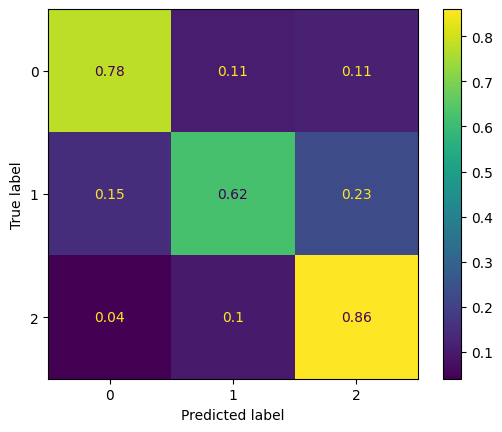

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.59912. Saving Model!
epoch 01, loss: 0.62461, acc: 0.73346, val_loss: 0.59912, val_accuracy: 0.73479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


epoch 02, loss: 0.62161, acc: 0.73326, val_loss: 0.60752, val_accuracy: 0.73361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


epoch 03, loss: 0.62141, acc: 0.73206, val_loss: 0.61308, val_accuracy: 0.73380


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


epoch 04, loss: 0.61911, acc: 0.73326, val_loss: 0.61748, val_accuracy: 0.73145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 05, loss: 0.61930, acc: 0.73211, val_loss: 0.62175, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 06, loss: 0.61775, acc: 0.73442, val_loss: 0.62452, val_accuracy: 0.72576


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 07, loss: 0.61776, acc: 0.73422, val_loss: 0.62685, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 08, loss: 0.61643, acc: 0.73584, val_loss: 0.62970, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.02it/s]


epoch 09, loss: 0.61595, acc: 0.73597, val_loss: 0.63145, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


epoch 10, loss: 0.61552, acc: 0.73784, val_loss: 0.63387, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 11, loss: 0.61464, acc: 0.73835, val_loss: 0.63509, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.49it/s]


epoch 12, loss: 0.61427, acc: 0.73743, val_loss: 0.63734, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


epoch 13, loss: 0.61406, acc: 0.73795, val_loss: 0.63906, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 14, loss: 0.61331, acc: 0.73928, val_loss: 0.63918, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


epoch 15, loss: 0.61267, acc: 0.73902, val_loss: 0.64182, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


epoch 16, loss: 0.61282, acc: 0.73902, val_loss: 0.64347, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 17, loss: 0.61195, acc: 0.73883, val_loss: 0.64337, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


epoch 18, loss: 0.61164, acc: 0.73883, val_loss: 0.64594, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 19, loss: 0.61130, acc: 0.73771, val_loss: 0.64570, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 20, loss: 0.61074, acc: 0.73887, val_loss: 0.64712, val_accuracy: 0.72340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 21, loss: 0.61029, acc: 0.73883, val_loss: 0.64861, val_accuracy: 0.72301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.09it/s]


epoch 22, loss: 0.61035, acc: 0.73898, val_loss: 0.64858, val_accuracy: 0.72261


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]


epoch 23, loss: 0.60940, acc: 0.73961, val_loss: 0.65107, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 24, loss: 0.60936, acc: 0.73935, val_loss: 0.65122, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.10it/s]


epoch 25, loss: 0.60910, acc: 0.73950, val_loss: 0.65127, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


epoch 26, loss: 0.60845, acc: 0.73981, val_loss: 0.65205, val_accuracy: 0.72399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 27, loss: 0.60793, acc: 0.73950, val_loss: 0.65293, val_accuracy: 0.72360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 28, loss: 0.60812, acc: 0.73928, val_loss: 0.65348, val_accuracy: 0.72438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 29, loss: 0.60733, acc: 0.74009, val_loss: 0.65468, val_accuracy: 0.72458


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


epoch 30, loss: 0.60705, acc: 0.73961, val_loss: 0.65632, val_accuracy: 0.72497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.10it/s]


epoch 31, loss: 0.60698, acc: 0.73968, val_loss: 0.65626, val_accuracy: 0.72517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 32, loss: 0.60640, acc: 0.73963, val_loss: 0.65680, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


epoch 33, loss: 0.60589, acc: 0.74033, val_loss: 0.65895, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


epoch 34, loss: 0.60600, acc: 0.74018, val_loss: 0.65761, val_accuracy: 0.72320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 35, loss: 0.60532, acc: 0.74031, val_loss: 0.65932, val_accuracy: 0.72281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 36, loss: 0.60473, acc: 0.74046, val_loss: 0.66090, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 37, loss: 0.60522, acc: 0.74046, val_loss: 0.65957, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s]


epoch 38, loss: 0.60399, acc: 0.74090, val_loss: 0.66180, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 39, loss: 0.60410, acc: 0.74107, val_loss: 0.66267, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 40, loss: 0.60395, acc: 0.74088, val_loss: 0.66067, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


epoch 41, loss: 0.60314, acc: 0.74133, val_loss: 0.66335, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 42, loss: 0.60315, acc: 0.74151, val_loss: 0.66444, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 43, loss: 0.60293, acc: 0.74125, val_loss: 0.66364, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]


epoch 44, loss: 0.60218, acc: 0.74186, val_loss: 0.66563, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 45, loss: 0.60234, acc: 0.74175, val_loss: 0.66484, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]


epoch 46, loss: 0.60200, acc: 0.74190, val_loss: 0.66510, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 47, loss: 0.60138, acc: 0.74236, val_loss: 0.66664, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 48, loss: 0.60089, acc: 0.74273, val_loss: 0.66600, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 49, loss: 0.60171, acc: 0.74197, val_loss: 0.66581, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 50, loss: 0.59993, acc: 0.74240, val_loss: 0.66797, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 51, loss: 0.60039, acc: 0.74260, val_loss: 0.66713, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 52, loss: 0.60018, acc: 0.74271, val_loss: 0.66820, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 53, loss: 0.59957, acc: 0.74275, val_loss: 0.66910, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 54, loss: 0.59929, acc: 0.74306, val_loss: 0.66725, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 55, loss: 0.59935, acc: 0.74299, val_loss: 0.66929, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 56, loss: 0.59863, acc: 0.74328, val_loss: 0.66961, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 57, loss: 0.59837, acc: 0.74319, val_loss: 0.66956, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 58, loss: 0.59839, acc: 0.74319, val_loss: 0.67013, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 59, loss: 0.59769, acc: 0.74347, val_loss: 0.67051, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


epoch 60, loss: 0.59786, acc: 0.74339, val_loss: 0.67059, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 61, loss: 0.59724, acc: 0.74332, val_loss: 0.67175, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 62, loss: 0.59674, acc: 0.74362, val_loss: 0.67279, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 63, loss: 0.59716, acc: 0.74347, val_loss: 0.67199, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 64, loss: 0.59648, acc: 0.74465, val_loss: 0.67240, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 65, loss: 0.59595, acc: 0.74493, val_loss: 0.67279, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 66, loss: 0.59592, acc: 0.74467, val_loss: 0.67264, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 67, loss: 0.59575, acc: 0.74485, val_loss: 0.67386, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 68, loss: 0.59498, acc: 0.74539, val_loss: 0.67411, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 69, loss: 0.59522, acc: 0.74493, val_loss: 0.67318, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 70, loss: 0.59451, acc: 0.74546, val_loss: 0.67508, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 71, loss: 0.59452, acc: 0.74535, val_loss: 0.67521, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 72, loss: 0.59417, acc: 0.74554, val_loss: 0.67481, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 73, loss: 0.59390, acc: 0.74568, val_loss: 0.67552, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 74, loss: 0.59345, acc: 0.74570, val_loss: 0.67568, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 75, loss: 0.59342, acc: 0.74539, val_loss: 0.67716, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 76, loss: 0.59302, acc: 0.74592, val_loss: 0.67667, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 77, loss: 0.59263, acc: 0.74585, val_loss: 0.67747, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 78, loss: 0.59259, acc: 0.74557, val_loss: 0.67816, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 79, loss: 0.59188, acc: 0.74611, val_loss: 0.67795, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 80, loss: 0.59216, acc: 0.74618, val_loss: 0.67869, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 81, loss: 0.59148, acc: 0.74642, val_loss: 0.67896, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 82, loss: 0.59137, acc: 0.74664, val_loss: 0.67768, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 83, loss: 0.59103, acc: 0.74653, val_loss: 0.67960, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 84, loss: 0.59117, acc: 0.74648, val_loss: 0.67894, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 85, loss: 0.59016, acc: 0.74659, val_loss: 0.67852, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 86, loss: 0.59048, acc: 0.74661, val_loss: 0.67960, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 87, loss: 0.58996, acc: 0.74681, val_loss: 0.67964, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 88, loss: 0.58943, acc: 0.74677, val_loss: 0.68092, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 89, loss: 0.58972, acc: 0.74709, val_loss: 0.67939, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 90, loss: 0.58918, acc: 0.74718, val_loss: 0.67987, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 91, loss: 0.58865, acc: 0.74742, val_loss: 0.67958, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 92, loss: 0.58878, acc: 0.74736, val_loss: 0.68054, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 93, loss: 0.58821, acc: 0.74731, val_loss: 0.68240, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 94, loss: 0.58824, acc: 0.74753, val_loss: 0.68121, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 95, loss: 0.58788, acc: 0.74777, val_loss: 0.68065, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 96, loss: 0.58762, acc: 0.74786, val_loss: 0.68245, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 97, loss: 0.58676, acc: 0.74803, val_loss: 0.68358, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 98, loss: 0.58747, acc: 0.74786, val_loss: 0.68277, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 99, loss: 0.58664, acc: 0.74836, val_loss: 0.68343, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 100, loss: 0.58639, acc: 0.74825, val_loss: 0.68307, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 101, loss: 0.58594, acc: 0.74829, val_loss: 0.68303, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 102, loss: 0.58627, acc: 0.74840, val_loss: 0.68372, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 103, loss: 0.58513, acc: 0.74873, val_loss: 0.68366, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 104, loss: 0.58581, acc: 0.74823, val_loss: 0.68477, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 105, loss: 0.58479, acc: 0.74960, val_loss: 0.68442, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 106, loss: 0.58479, acc: 0.74989, val_loss: 0.68589, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 107, loss: 0.58449, acc: 0.74914, val_loss: 0.68563, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 108, loss: 0.58464, acc: 0.75019, val_loss: 0.68463, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 109, loss: 0.58353, acc: 0.75137, val_loss: 0.68590, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 110, loss: 0.58403, acc: 0.75023, val_loss: 0.68596, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 111, loss: 0.58337, acc: 0.75056, val_loss: 0.68631, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 112, loss: 0.58326, acc: 0.75150, val_loss: 0.68663, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 113, loss: 0.58274, acc: 0.75126, val_loss: 0.68622, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 114, loss: 0.58275, acc: 0.75148, val_loss: 0.68799, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 115, loss: 0.58245, acc: 0.75200, val_loss: 0.68655, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 116, loss: 0.58205, acc: 0.75187, val_loss: 0.68860, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 117, loss: 0.58198, acc: 0.75176, val_loss: 0.68781, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 118, loss: 0.58165, acc: 0.75191, val_loss: 0.68640, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 119, loss: 0.58111, acc: 0.75259, val_loss: 0.68848, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 120, loss: 0.58161, acc: 0.75194, val_loss: 0.68825, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 121, loss: 0.58054, acc: 0.75226, val_loss: 0.68816, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 122, loss: 0.58080, acc: 0.75259, val_loss: 0.68759, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 123, loss: 0.58037, acc: 0.75259, val_loss: 0.68731, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 124, loss: 0.57993, acc: 0.75266, val_loss: 0.68942, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 125, loss: 0.58012, acc: 0.75274, val_loss: 0.68861, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 126, loss: 0.57952, acc: 0.75276, val_loss: 0.68928, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 127, loss: 0.57926, acc: 0.75311, val_loss: 0.68990, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 128, loss: 0.57904, acc: 0.75320, val_loss: 0.69082, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 129, loss: 0.57914, acc: 0.75322, val_loss: 0.68979, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 130, loss: 0.57845, acc: 0.75381, val_loss: 0.68953, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 131, loss: 0.57831, acc: 0.75390, val_loss: 0.69058, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 132, loss: 0.57824, acc: 0.75403, val_loss: 0.68966, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 133, loss: 0.57762, acc: 0.75410, val_loss: 0.69143, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 134, loss: 0.57789, acc: 0.75399, val_loss: 0.69128, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 135, loss: 0.57704, acc: 0.75503, val_loss: 0.69311, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 136, loss: 0.57734, acc: 0.75442, val_loss: 0.69217, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 137, loss: 0.57675, acc: 0.75508, val_loss: 0.69206, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 138, loss: 0.57632, acc: 0.75564, val_loss: 0.69345, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 139, loss: 0.57649, acc: 0.75530, val_loss: 0.69373, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 140, loss: 0.57616, acc: 0.75562, val_loss: 0.69294, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 141, loss: 0.57592, acc: 0.75591, val_loss: 0.69261, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 142, loss: 0.57554, acc: 0.75591, val_loss: 0.69345, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 143, loss: 0.57566, acc: 0.75564, val_loss: 0.69413, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 144, loss: 0.57457, acc: 0.75634, val_loss: 0.69368, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 145, loss: 0.57523, acc: 0.75569, val_loss: 0.69378, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 146, loss: 0.57439, acc: 0.75652, val_loss: 0.69425, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 147, loss: 0.57439, acc: 0.75656, val_loss: 0.69376, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 148, loss: 0.57381, acc: 0.75680, val_loss: 0.69436, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 149, loss: 0.57443, acc: 0.75636, val_loss: 0.69414, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 150, loss: 0.57274, acc: 0.75706, val_loss: 0.69698, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 151, loss: 0.57405, acc: 0.75658, val_loss: 0.69541, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 152, loss: 0.57295, acc: 0.75743, val_loss: 0.69583, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 153, loss: 0.57288, acc: 0.75711, val_loss: 0.69615, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 154, loss: 0.57208, acc: 0.75752, val_loss: 0.69764, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 155, loss: 0.57302, acc: 0.75726, val_loss: 0.69571, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 156, loss: 0.57159, acc: 0.75789, val_loss: 0.69681, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 157, loss: 0.57215, acc: 0.75748, val_loss: 0.69648, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 158, loss: 0.57141, acc: 0.75769, val_loss: 0.69764, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 159, loss: 0.57142, acc: 0.75789, val_loss: 0.69771, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


epoch 160, loss: 0.57103, acc: 0.75820, val_loss: 0.69736, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 161, loss: 0.57113, acc: 0.75756, val_loss: 0.69720, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 162, loss: 0.57005, acc: 0.75837, val_loss: 0.69821, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 163, loss: 0.57095, acc: 0.75800, val_loss: 0.69749, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 164, loss: 0.56988, acc: 0.75855, val_loss: 0.69677, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 165, loss: 0.57019, acc: 0.75896, val_loss: 0.69774, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 166, loss: 0.56924, acc: 0.75887, val_loss: 0.70002, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 167, loss: 0.56974, acc: 0.75946, val_loss: 0.69829, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


epoch 168, loss: 0.56896, acc: 0.75966, val_loss: 0.69794, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 169, loss: 0.56885, acc: 0.75942, val_loss: 0.69991, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 170, loss: 0.56848, acc: 0.75981, val_loss: 0.69948, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 171, loss: 0.56870, acc: 0.75959, val_loss: 0.69858, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 172, loss: 0.56796, acc: 0.75996, val_loss: 0.69927, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 173, loss: 0.56804, acc: 0.76007, val_loss: 0.70042, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 174, loss: 0.56737, acc: 0.76009, val_loss: 0.69905, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 175, loss: 0.56758, acc: 0.76016, val_loss: 0.69953, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 176, loss: 0.56719, acc: 0.76044, val_loss: 0.70062, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 177, loss: 0.56678, acc: 0.75988, val_loss: 0.70275, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 178, loss: 0.56666, acc: 0.76044, val_loss: 0.70019, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 179, loss: 0.56673, acc: 0.76007, val_loss: 0.70060, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 180, loss: 0.56592, acc: 0.76077, val_loss: 0.70171, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 181, loss: 0.56597, acc: 0.76064, val_loss: 0.70280, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 182, loss: 0.56581, acc: 0.76066, val_loss: 0.70084, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 183, loss: 0.56568, acc: 0.76047, val_loss: 0.70037, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 184, loss: 0.56509, acc: 0.76092, val_loss: 0.70231, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 185, loss: 0.56480, acc: 0.76079, val_loss: 0.70440, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 186, loss: 0.56498, acc: 0.76092, val_loss: 0.70183, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 187, loss: 0.56459, acc: 0.76121, val_loss: 0.70251, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 188, loss: 0.56426, acc: 0.76121, val_loss: 0.70425, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 189, loss: 0.56412, acc: 0.76101, val_loss: 0.70329, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 190, loss: 0.56359, acc: 0.76149, val_loss: 0.70383, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


epoch 191, loss: 0.56388, acc: 0.76110, val_loss: 0.70344, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 192, loss: 0.56322, acc: 0.76129, val_loss: 0.70431, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 193, loss: 0.56322, acc: 0.76151, val_loss: 0.70205, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 194, loss: 0.56269, acc: 0.76149, val_loss: 0.70420, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 195, loss: 0.56303, acc: 0.76114, val_loss: 0.70639, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 196, loss: 0.56203, acc: 0.76190, val_loss: 0.70604, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


epoch 197, loss: 0.56275, acc: 0.76132, val_loss: 0.70490, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 198, loss: 0.56170, acc: 0.76177, val_loss: 0.70423, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 199, loss: 0.56215, acc: 0.76153, val_loss: 0.70531, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 200, loss: 0.56093, acc: 0.76214, val_loss: 0.70566, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 201, loss: 0.56209, acc: 0.76145, val_loss: 0.70405, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 202, loss: 0.56026, acc: 0.76173, val_loss: 0.70650, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 203, loss: 0.56123, acc: 0.76164, val_loss: 0.70619, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 204, loss: 0.56013, acc: 0.76188, val_loss: 0.70762, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 205, loss: 0.56074, acc: 0.76188, val_loss: 0.70813, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 206, loss: 0.55990, acc: 0.76293, val_loss: 0.70593, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 207, loss: 0.56044, acc: 0.76153, val_loss: 0.70697, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 208, loss: 0.55871, acc: 0.76282, val_loss: 0.70734, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 209, loss: 0.56003, acc: 0.76230, val_loss: 0.70873, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 210, loss: 0.55882, acc: 0.76350, val_loss: 0.70890, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 211, loss: 0.55916, acc: 0.76223, val_loss: 0.70809, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 212, loss: 0.55838, acc: 0.76280, val_loss: 0.70814, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 213, loss: 0.55910, acc: 0.76247, val_loss: 0.70918, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 214, loss: 0.55733, acc: 0.76306, val_loss: 0.71206, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 215, loss: 0.55902, acc: 0.76265, val_loss: 0.70677, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 216, loss: 0.55718, acc: 0.76324, val_loss: 0.70769, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 217, loss: 0.55779, acc: 0.76297, val_loss: 0.70913, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 218, loss: 0.55707, acc: 0.76339, val_loss: 0.71110, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 219, loss: 0.55768, acc: 0.76308, val_loss: 0.70827, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 220, loss: 0.55614, acc: 0.76361, val_loss: 0.71000, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 221, loss: 0.55715, acc: 0.76334, val_loss: 0.71047, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 222, loss: 0.55565, acc: 0.76391, val_loss: 0.71213, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 223, loss: 0.55720, acc: 0.76441, val_loss: 0.71006, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 224, loss: 0.55509, acc: 0.76485, val_loss: 0.71037, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 225, loss: 0.55624, acc: 0.76245, val_loss: 0.71056, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 226, loss: 0.55491, acc: 0.76572, val_loss: 0.71184, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 227, loss: 0.55601, acc: 0.76363, val_loss: 0.71273, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 228, loss: 0.55434, acc: 0.76509, val_loss: 0.71247, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 229, loss: 0.55568, acc: 0.76343, val_loss: 0.71077, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 230, loss: 0.55363, acc: 0.76620, val_loss: 0.71166, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 231, loss: 0.55541, acc: 0.76452, val_loss: 0.71281, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 232, loss: 0.55315, acc: 0.76655, val_loss: 0.71136, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 233, loss: 0.55517, acc: 0.76472, val_loss: 0.71158, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.78it/s]


epoch 234, loss: 0.55275, acc: 0.76668, val_loss: 0.71337, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 235, loss: 0.55458, acc: 0.76468, val_loss: 0.71336, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 236, loss: 0.55209, acc: 0.76690, val_loss: 0.71460, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 237, loss: 0.55452, acc: 0.76472, val_loss: 0.71214, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 238, loss: 0.55156, acc: 0.76681, val_loss: 0.71469, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 239, loss: 0.55361, acc: 0.76502, val_loss: 0.71281, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 240, loss: 0.55103, acc: 0.76716, val_loss: 0.71540, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 241, loss: 0.55381, acc: 0.76522, val_loss: 0.71194, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 242, loss: 0.55051, acc: 0.76755, val_loss: 0.71605, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 243, loss: 0.55301, acc: 0.76505, val_loss: 0.71437, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 244, loss: 0.55019, acc: 0.76738, val_loss: 0.71693, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 245, loss: 0.55231, acc: 0.76559, val_loss: 0.71308, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 246, loss: 0.55001, acc: 0.76740, val_loss: 0.71467, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 247, loss: 0.55215, acc: 0.76561, val_loss: 0.71309, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 248, loss: 0.54901, acc: 0.76849, val_loss: 0.71740, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 249, loss: 0.55177, acc: 0.76594, val_loss: 0.71561, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 250, loss: 0.54872, acc: 0.76812, val_loss: 0.71645, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 251, loss: 0.55119, acc: 0.76603, val_loss: 0.71489, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 252, loss: 0.54843, acc: 0.76889, val_loss: 0.71678, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 253, loss: 0.55038, acc: 0.76627, val_loss: 0.71788, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 254, loss: 0.54848, acc: 0.76878, val_loss: 0.71644, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 255, loss: 0.54991, acc: 0.76673, val_loss: 0.71722, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 256, loss: 0.54756, acc: 0.76913, val_loss: 0.71803, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 257, loss: 0.54987, acc: 0.76579, val_loss: 0.71798, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 258, loss: 0.54690, acc: 0.76967, val_loss: 0.71795, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 259, loss: 0.54975, acc: 0.76673, val_loss: 0.71497, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 260, loss: 0.54607, acc: 0.76978, val_loss: 0.71869, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 261, loss: 0.54928, acc: 0.76673, val_loss: 0.71864, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 262, loss: 0.54585, acc: 0.77015, val_loss: 0.72184, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 263, loss: 0.54917, acc: 0.76775, val_loss: 0.71711, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 264, loss: 0.54517, acc: 0.77013, val_loss: 0.71926, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 265, loss: 0.54870, acc: 0.76775, val_loss: 0.71823, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 266, loss: 0.54465, acc: 0.77028, val_loss: 0.72285, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 267, loss: 0.54841, acc: 0.76801, val_loss: 0.71732, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 268, loss: 0.54431, acc: 0.77172, val_loss: 0.71933, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 269, loss: 0.54765, acc: 0.76919, val_loss: 0.71828, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 270, loss: 0.54401, acc: 0.77161, val_loss: 0.72218, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 271, loss: 0.54698, acc: 0.76899, val_loss: 0.71969, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 272, loss: 0.54357, acc: 0.77161, val_loss: 0.72303, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 273, loss: 0.54685, acc: 0.76937, val_loss: 0.71985, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 274, loss: 0.54302, acc: 0.77290, val_loss: 0.72258, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 275, loss: 0.54621, acc: 0.76960, val_loss: 0.71959, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 276, loss: 0.54282, acc: 0.77347, val_loss: 0.72254, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 277, loss: 0.54546, acc: 0.77109, val_loss: 0.72162, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 278, loss: 0.54251, acc: 0.77340, val_loss: 0.72197, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 279, loss: 0.54514, acc: 0.77096, val_loss: 0.71952, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 280, loss: 0.54197, acc: 0.77410, val_loss: 0.72353, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 281, loss: 0.54462, acc: 0.77187, val_loss: 0.72225, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 282, loss: 0.54151, acc: 0.77432, val_loss: 0.72511, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 283, loss: 0.54428, acc: 0.77150, val_loss: 0.72157, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 284, loss: 0.54122, acc: 0.77493, val_loss: 0.72422, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 285, loss: 0.54377, acc: 0.77266, val_loss: 0.72113, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 286, loss: 0.54031, acc: 0.77569, val_loss: 0.72503, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 287, loss: 0.54388, acc: 0.77159, val_loss: 0.72382, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 288, loss: 0.53981, acc: 0.77595, val_loss: 0.72455, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 289, loss: 0.54316, acc: 0.77349, val_loss: 0.72368, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 290, loss: 0.53976, acc: 0.77626, val_loss: 0.72477, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 291, loss: 0.54244, acc: 0.77414, val_loss: 0.72538, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 292, loss: 0.53944, acc: 0.77637, val_loss: 0.72349, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 293, loss: 0.54228, acc: 0.77377, val_loss: 0.72221, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 294, loss: 0.53892, acc: 0.77685, val_loss: 0.72576, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 295, loss: 0.54148, acc: 0.77408, val_loss: 0.72582, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 296, loss: 0.53871, acc: 0.77672, val_loss: 0.72520, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 297, loss: 0.54122, acc: 0.77456, val_loss: 0.72302, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 298, loss: 0.53778, acc: 0.77717, val_loss: 0.72810, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 299, loss: 0.54077, acc: 0.77443, val_loss: 0.72500, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 300, loss: 0.53788, acc: 0.77678, val_loss: 0.72640, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 301, loss: 0.54025, acc: 0.77480, val_loss: 0.72546, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 302, loss: 0.53695, acc: 0.77744, val_loss: 0.72773, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 303, loss: 0.54013, acc: 0.77497, val_loss: 0.72616, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 304, loss: 0.53676, acc: 0.77770, val_loss: 0.72705, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 305, loss: 0.53957, acc: 0.77508, val_loss: 0.72649, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 306, loss: 0.53582, acc: 0.77831, val_loss: 0.73056, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 307, loss: 0.53980, acc: 0.77515, val_loss: 0.72323, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 308, loss: 0.53535, acc: 0.77861, val_loss: 0.72852, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 309, loss: 0.53920, acc: 0.77549, val_loss: 0.72551, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 310, loss: 0.53487, acc: 0.77853, val_loss: 0.72858, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 311, loss: 0.53896, acc: 0.77613, val_loss: 0.72807, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s]


epoch 312, loss: 0.53459, acc: 0.77909, val_loss: 0.72847, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 313, loss: 0.53815, acc: 0.77632, val_loss: 0.72847, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 314, loss: 0.53425, acc: 0.77888, val_loss: 0.73091, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 315, loss: 0.53755, acc: 0.77613, val_loss: 0.72812, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 316, loss: 0.53407, acc: 0.77914, val_loss: 0.72853, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 317, loss: 0.53721, acc: 0.77709, val_loss: 0.72797, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 318, loss: 0.53291, acc: 0.77920, val_loss: 0.73123, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 319, loss: 0.53726, acc: 0.77652, val_loss: 0.72903, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 320, loss: 0.53286, acc: 0.77933, val_loss: 0.73148, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 321, loss: 0.53653, acc: 0.77696, val_loss: 0.72752, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 322, loss: 0.53287, acc: 0.77966, val_loss: 0.73015, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 323, loss: 0.53562, acc: 0.77720, val_loss: 0.72993, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 324, loss: 0.53229, acc: 0.77970, val_loss: 0.73233, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 325, loss: 0.53570, acc: 0.77737, val_loss: 0.72939, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 326, loss: 0.53168, acc: 0.78014, val_loss: 0.73092, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 327, loss: 0.53506, acc: 0.77765, val_loss: 0.72982, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 328, loss: 0.53131, acc: 0.78038, val_loss: 0.73327, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 329, loss: 0.53502, acc: 0.77748, val_loss: 0.73113, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 330, loss: 0.53058, acc: 0.78016, val_loss: 0.73479, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 331, loss: 0.53468, acc: 0.77776, val_loss: 0.73077, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 332, loss: 0.53036, acc: 0.78051, val_loss: 0.73435, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 333, loss: 0.53392, acc: 0.77807, val_loss: 0.73329, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 334, loss: 0.53001, acc: 0.78075, val_loss: 0.73473, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 335, loss: 0.53415, acc: 0.77789, val_loss: 0.73056, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 336, loss: 0.52917, acc: 0.78101, val_loss: 0.73555, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 337, loss: 0.53343, acc: 0.77826, val_loss: 0.73182, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 338, loss: 0.52927, acc: 0.78110, val_loss: 0.73537, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 339, loss: 0.53244, acc: 0.77988, val_loss: 0.73332, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 340, loss: 0.52862, acc: 0.78243, val_loss: 0.73665, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 341, loss: 0.53303, acc: 0.77842, val_loss: 0.73206, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 342, loss: 0.52756, acc: 0.78291, val_loss: 0.73689, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 343, loss: 0.53250, acc: 0.78025, val_loss: 0.73343, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 344, loss: 0.52775, acc: 0.78261, val_loss: 0.73632, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 345, loss: 0.53139, acc: 0.78110, val_loss: 0.73256, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 346, loss: 0.52761, acc: 0.78333, val_loss: 0.73824, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 347, loss: 0.53152, acc: 0.78095, val_loss: 0.73352, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 348, loss: 0.52630, acc: 0.78398, val_loss: 0.73842, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 349, loss: 0.53137, acc: 0.78075, val_loss: 0.73560, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 350, loss: 0.52661, acc: 0.78367, val_loss: 0.73807, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 351, loss: 0.53021, acc: 0.78138, val_loss: 0.73601, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 352, loss: 0.52603, acc: 0.78394, val_loss: 0.73803, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 353, loss: 0.53007, acc: 0.78123, val_loss: 0.73489, val_accuracy: 0.71358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 354, loss: 0.52525, acc: 0.78400, val_loss: 0.74002, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 355, loss: 0.52995, acc: 0.78110, val_loss: 0.73448, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 356, loss: 0.52507, acc: 0.78396, val_loss: 0.73859, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 357, loss: 0.52870, acc: 0.78173, val_loss: 0.73544, val_accuracy: 0.71358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 358, loss: 0.52506, acc: 0.78405, val_loss: 0.73986, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 359, loss: 0.52846, acc: 0.78154, val_loss: 0.73877, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 360, loss: 0.52468, acc: 0.78455, val_loss: 0.74046, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 361, loss: 0.52812, acc: 0.78226, val_loss: 0.73644, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 362, loss: 0.52398, acc: 0.78459, val_loss: 0.74163, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 363, loss: 0.52780, acc: 0.78234, val_loss: 0.73749, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 364, loss: 0.52354, acc: 0.78507, val_loss: 0.74105, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 365, loss: 0.52725, acc: 0.78230, val_loss: 0.73839, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 366, loss: 0.52313, acc: 0.78503, val_loss: 0.74325, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 367, loss: 0.52707, acc: 0.78278, val_loss: 0.73786, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 368, loss: 0.52244, acc: 0.78546, val_loss: 0.74158, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 369, loss: 0.52664, acc: 0.78285, val_loss: 0.73896, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 370, loss: 0.52210, acc: 0.78544, val_loss: 0.74288, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 371, loss: 0.52595, acc: 0.78276, val_loss: 0.74147, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 372, loss: 0.52205, acc: 0.78559, val_loss: 0.74409, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 373, loss: 0.52569, acc: 0.78293, val_loss: 0.74080, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 374, loss: 0.52154, acc: 0.78553, val_loss: 0.74248, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 375, loss: 0.52561, acc: 0.78280, val_loss: 0.73964, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 376, loss: 0.52076, acc: 0.78601, val_loss: 0.74468, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 377, loss: 0.52521, acc: 0.78324, val_loss: 0.74212, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 378, loss: 0.52033, acc: 0.78583, val_loss: 0.74552, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 379, loss: 0.52490, acc: 0.78326, val_loss: 0.74066, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 380, loss: 0.51981, acc: 0.78597, val_loss: 0.74620, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 381, loss: 0.52431, acc: 0.78343, val_loss: 0.74010, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 382, loss: 0.51955, acc: 0.78625, val_loss: 0.74679, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 383, loss: 0.52392, acc: 0.78341, val_loss: 0.74107, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 384, loss: 0.51935, acc: 0.78636, val_loss: 0.74487, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 385, loss: 0.52358, acc: 0.78359, val_loss: 0.74131, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 386, loss: 0.51885, acc: 0.78629, val_loss: 0.74488, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 387, loss: 0.52291, acc: 0.78365, val_loss: 0.74323, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 388, loss: 0.51850, acc: 0.78625, val_loss: 0.74792, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 389, loss: 0.52270, acc: 0.78359, val_loss: 0.74212, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 390, loss: 0.51755, acc: 0.78679, val_loss: 0.74608, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 391, loss: 0.52253, acc: 0.78389, val_loss: 0.74191, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 392, loss: 0.51725, acc: 0.78712, val_loss: 0.74766, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 393, loss: 0.52166, acc: 0.78402, val_loss: 0.74570, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 394, loss: 0.51739, acc: 0.78666, val_loss: 0.74881, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 395, loss: 0.52147, acc: 0.78461, val_loss: 0.74425, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.98it/s]


epoch 396, loss: 0.51677, acc: 0.78727, val_loss: 0.74670, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 397, loss: 0.52125, acc: 0.78439, val_loss: 0.74412, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 398, loss: 0.51620, acc: 0.78730, val_loss: 0.74885, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 399, loss: 0.52127, acc: 0.78429, val_loss: 0.74465, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 400, loss: 0.51536, acc: 0.78760, val_loss: 0.75061, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 401, loss: 0.52108, acc: 0.78472, val_loss: 0.74316, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 402, loss: 0.51535, acc: 0.78745, val_loss: 0.74921, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 403, loss: 0.52017, acc: 0.78522, val_loss: 0.74414, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 404, loss: 0.51505, acc: 0.78791, val_loss: 0.74936, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 405, loss: 0.51975, acc: 0.78481, val_loss: 0.74559, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 406, loss: 0.51481, acc: 0.78791, val_loss: 0.75138, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 407, loss: 0.51955, acc: 0.78522, val_loss: 0.74739, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 408, loss: 0.51427, acc: 0.78834, val_loss: 0.75071, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 409, loss: 0.51880, acc: 0.78551, val_loss: 0.74620, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 410, loss: 0.51423, acc: 0.78832, val_loss: 0.75210, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 411, loss: 0.51810, acc: 0.78592, val_loss: 0.74905, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 412, loss: 0.51351, acc: 0.78865, val_loss: 0.75062, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 413, loss: 0.51843, acc: 0.78583, val_loss: 0.74753, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 414, loss: 0.51249, acc: 0.78880, val_loss: 0.75347, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 415, loss: 0.51817, acc: 0.78570, val_loss: 0.74832, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 416, loss: 0.51229, acc: 0.78869, val_loss: 0.75417, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 417, loss: 0.51716, acc: 0.78627, val_loss: 0.74661, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 418, loss: 0.51270, acc: 0.78884, val_loss: 0.75192, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 419, loss: 0.51658, acc: 0.78610, val_loss: 0.74801, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 420, loss: 0.51172, acc: 0.78922, val_loss: 0.75312, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 421, loss: 0.51703, acc: 0.78610, val_loss: 0.74914, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 422, loss: 0.51112, acc: 0.78895, val_loss: 0.75496, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 423, loss: 0.51653, acc: 0.78629, val_loss: 0.75001, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 424, loss: 0.51042, acc: 0.78963, val_loss: 0.75495, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 425, loss: 0.51644, acc: 0.78645, val_loss: 0.74703, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 426, loss: 0.51010, acc: 0.78950, val_loss: 0.75585, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 427, loss: 0.51542, acc: 0.78640, val_loss: 0.75073, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 428, loss: 0.51023, acc: 0.78930, val_loss: 0.75653, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 429, loss: 0.51491, acc: 0.78607, val_loss: 0.75359, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 430, loss: 0.50981, acc: 0.78974, val_loss: 0.75475, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 431, loss: 0.51458, acc: 0.78673, val_loss: 0.75073, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 432, loss: 0.50899, acc: 0.78974, val_loss: 0.75686, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 433, loss: 0.51434, acc: 0.78660, val_loss: 0.75088, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 434, loss: 0.50861, acc: 0.78987, val_loss: 0.75935, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 435, loss: 0.51388, acc: 0.78664, val_loss: 0.75523, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 436, loss: 0.50894, acc: 0.78985, val_loss: 0.75612, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 437, loss: 0.51341, acc: 0.78699, val_loss: 0.75123, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 438, loss: 0.50784, acc: 0.79057, val_loss: 0.75741, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 439, loss: 0.51351, acc: 0.78658, val_loss: 0.75410, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 440, loss: 0.50730, acc: 0.79076, val_loss: 0.75962, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 441, loss: 0.51321, acc: 0.78677, val_loss: 0.75288, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 442, loss: 0.50709, acc: 0.79083, val_loss: 0.75925, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 443, loss: 0.51271, acc: 0.78697, val_loss: 0.75255, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 444, loss: 0.50639, acc: 0.79135, val_loss: 0.75863, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 445, loss: 0.51227, acc: 0.78692, val_loss: 0.75662, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 446, loss: 0.50635, acc: 0.79094, val_loss: 0.76152, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 447, loss: 0.51172, acc: 0.78747, val_loss: 0.75614, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 448, loss: 0.50595, acc: 0.79079, val_loss: 0.76133, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 449, loss: 0.51152, acc: 0.78736, val_loss: 0.75577, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 450, loss: 0.50555, acc: 0.79131, val_loss: 0.76073, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 451, loss: 0.51082, acc: 0.78747, val_loss: 0.75857, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 452, loss: 0.50545, acc: 0.79135, val_loss: 0.76132, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 453, loss: 0.51018, acc: 0.78758, val_loss: 0.75732, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 454, loss: 0.50518, acc: 0.79113, val_loss: 0.76100, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 455, loss: 0.51026, acc: 0.78773, val_loss: 0.75764, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 456, loss: 0.50393, acc: 0.79153, val_loss: 0.76422, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 457, loss: 0.51005, acc: 0.78810, val_loss: 0.75753, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 458, loss: 0.50401, acc: 0.79155, val_loss: 0.76116, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 459, loss: 0.50959, acc: 0.78841, val_loss: 0.75678, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 460, loss: 0.50330, acc: 0.79157, val_loss: 0.76385, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 461, loss: 0.50938, acc: 0.78839, val_loss: 0.75819, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 462, loss: 0.50284, acc: 0.79159, val_loss: 0.76680, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 463, loss: 0.50890, acc: 0.78854, val_loss: 0.75991, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 464, loss: 0.50294, acc: 0.79253, val_loss: 0.76224, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 465, loss: 0.50810, acc: 0.78891, val_loss: 0.75725, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 466, loss: 0.50272, acc: 0.79209, val_loss: 0.76238, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 467, loss: 0.50776, acc: 0.78850, val_loss: 0.76028, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 468, loss: 0.50214, acc: 0.79181, val_loss: 0.76484, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 469, loss: 0.50749, acc: 0.78858, val_loss: 0.76242, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 470, loss: 0.50196, acc: 0.79338, val_loss: 0.76476, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 471, loss: 0.50735, acc: 0.78906, val_loss: 0.75703, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 472, loss: 0.50099, acc: 0.79343, val_loss: 0.76519, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 473, loss: 0.50726, acc: 0.78878, val_loss: 0.76032, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 474, loss: 0.50085, acc: 0.79362, val_loss: 0.76456, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 475, loss: 0.50659, acc: 0.78911, val_loss: 0.76205, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]


epoch 476, loss: 0.50045, acc: 0.79356, val_loss: 0.76684, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 477, loss: 0.50651, acc: 0.78913, val_loss: 0.75912, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 478, loss: 0.49980, acc: 0.79358, val_loss: 0.76746, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 479, loss: 0.50589, acc: 0.78939, val_loss: 0.75993, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 480, loss: 0.49971, acc: 0.79349, val_loss: 0.76754, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 481, loss: 0.50510, acc: 0.78959, val_loss: 0.76326, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 482, loss: 0.50012, acc: 0.79353, val_loss: 0.76404, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 483, loss: 0.50433, acc: 0.79072, val_loss: 0.76171, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 484, loss: 0.49934, acc: 0.79332, val_loss: 0.76664, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 485, loss: 0.50484, acc: 0.78956, val_loss: 0.76275, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 486, loss: 0.49836, acc: 0.79340, val_loss: 0.76946, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 487, loss: 0.50443, acc: 0.79066, val_loss: 0.76191, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


epoch 488, loss: 0.49836, acc: 0.79386, val_loss: 0.76785, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 489, loss: 0.50362, acc: 0.79116, val_loss: 0.76149, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.34it/s]


epoch 490, loss: 0.49795, acc: 0.79391, val_loss: 0.76627, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 491, loss: 0.50418, acc: 0.79076, val_loss: 0.76049, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 492, loss: 0.49674, acc: 0.79449, val_loss: 0.76836, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 493, loss: 0.50360, acc: 0.79000, val_loss: 0.76235, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.03it/s]


epoch 494, loss: 0.49665, acc: 0.79526, val_loss: 0.77057, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.92it/s]


epoch 495, loss: 0.50240, acc: 0.79168, val_loss: 0.76499, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


epoch 496, loss: 0.49662, acc: 0.79441, val_loss: 0.77111, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


epoch 497, loss: 0.50255, acc: 0.79140, val_loss: 0.76414, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.57it/s]


epoch 498, loss: 0.49582, acc: 0.79513, val_loss: 0.76942, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


epoch 499, loss: 0.50255, acc: 0.79161, val_loss: 0.76128, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


epoch 500, loss: 0.49505, acc: 0.79534, val_loss: 0.77111, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


epoch 501, loss: 0.50159, acc: 0.79098, val_loss: 0.76595, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


epoch 502, loss: 0.49534, acc: 0.79506, val_loss: 0.77051, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


epoch 503, loss: 0.50091, acc: 0.79229, val_loss: 0.76760, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


epoch 504, loss: 0.49480, acc: 0.79511, val_loss: 0.77285, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


epoch 505, loss: 0.50080, acc: 0.79181, val_loss: 0.76635, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.13it/s]


epoch 506, loss: 0.49465, acc: 0.79500, val_loss: 0.77059, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


epoch 507, loss: 0.50074, acc: 0.79159, val_loss: 0.76239, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 508, loss: 0.49427, acc: 0.79504, val_loss: 0.77201, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 509, loss: 0.50019, acc: 0.79109, val_loss: 0.76671, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.63it/s]


epoch 510, loss: 0.49391, acc: 0.79521, val_loss: 0.77290, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 511, loss: 0.50028, acc: 0.79249, val_loss: 0.76549, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 512, loss: 0.49323, acc: 0.79534, val_loss: 0.77139, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 513, loss: 0.49960, acc: 0.79242, val_loss: 0.76691, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 514, loss: 0.49294, acc: 0.79508, val_loss: 0.77513, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 515, loss: 0.49930, acc: 0.79277, val_loss: 0.76547, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 516, loss: 0.49247, acc: 0.79585, val_loss: 0.77277, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 517, loss: 0.49900, acc: 0.79319, val_loss: 0.76645, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 518, loss: 0.49223, acc: 0.79591, val_loss: 0.77548, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 519, loss: 0.49874, acc: 0.79325, val_loss: 0.76741, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 520, loss: 0.49124, acc: 0.79630, val_loss: 0.77689, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 521, loss: 0.49832, acc: 0.79288, val_loss: 0.76950, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 522, loss: 0.49119, acc: 0.79685, val_loss: 0.77581, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 523, loss: 0.49752, acc: 0.79391, val_loss: 0.77160, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 524, loss: 0.49123, acc: 0.79628, val_loss: 0.77551, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 525, loss: 0.49705, acc: 0.79384, val_loss: 0.76885, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 526, loss: 0.49063, acc: 0.79696, val_loss: 0.77577, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 527, loss: 0.49698, acc: 0.79388, val_loss: 0.77175, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 528, loss: 0.49020, acc: 0.79735, val_loss: 0.77770, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 529, loss: 0.49610, acc: 0.79452, val_loss: 0.77460, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 530, loss: 0.49019, acc: 0.79716, val_loss: 0.77671, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 531, loss: 0.49580, acc: 0.79423, val_loss: 0.76903, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 532, loss: 0.48965, acc: 0.79731, val_loss: 0.77633, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 533, loss: 0.49545, acc: 0.79447, val_loss: 0.77410, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 534, loss: 0.48969, acc: 0.79733, val_loss: 0.77781, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 535, loss: 0.49485, acc: 0.79467, val_loss: 0.77461, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 536, loss: 0.48856, acc: 0.79781, val_loss: 0.77869, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 537, loss: 0.49551, acc: 0.79456, val_loss: 0.76877, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 538, loss: 0.48809, acc: 0.79794, val_loss: 0.77730, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 539, loss: 0.49485, acc: 0.79478, val_loss: 0.77021, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 540, loss: 0.48765, acc: 0.79774, val_loss: 0.78111, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.70it/s]


epoch 541, loss: 0.49418, acc: 0.79537, val_loss: 0.77182, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 542, loss: 0.48758, acc: 0.79792, val_loss: 0.78043, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 543, loss: 0.49336, acc: 0.79548, val_loss: 0.77357, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 544, loss: 0.48782, acc: 0.79812, val_loss: 0.77799, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 545, loss: 0.49302, acc: 0.79539, val_loss: 0.77568, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 546, loss: 0.48725, acc: 0.79862, val_loss: 0.77811, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 547, loss: 0.49269, acc: 0.79530, val_loss: 0.77388, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 548, loss: 0.48681, acc: 0.79875, val_loss: 0.78005, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 549, loss: 0.49263, acc: 0.79521, val_loss: 0.77327, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 550, loss: 0.48620, acc: 0.79855, val_loss: 0.78094, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 551, loss: 0.49229, acc: 0.79587, val_loss: 0.77614, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 552, loss: 0.48554, acc: 0.79888, val_loss: 0.78205, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 553, loss: 0.49232, acc: 0.79530, val_loss: 0.77207, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 554, loss: 0.48495, acc: 0.79879, val_loss: 0.78056, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 555, loss: 0.49152, acc: 0.79611, val_loss: 0.77299, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 556, loss: 0.48522, acc: 0.79925, val_loss: 0.78015, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 557, loss: 0.49069, acc: 0.79639, val_loss: 0.77486, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 558, loss: 0.48472, acc: 0.79910, val_loss: 0.77937, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 559, loss: 0.49054, acc: 0.79626, val_loss: 0.77412, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 560, loss: 0.48372, acc: 0.79921, val_loss: 0.78374, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 561, loss: 0.49117, acc: 0.79606, val_loss: 0.77327, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 562, loss: 0.48372, acc: 0.79918, val_loss: 0.78035, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 563, loss: 0.49050, acc: 0.79661, val_loss: 0.77542, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 564, loss: 0.48320, acc: 0.80027, val_loss: 0.78189, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 565, loss: 0.49054, acc: 0.79648, val_loss: 0.77562, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 566, loss: 0.48252, acc: 0.79971, val_loss: 0.78765, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 567, loss: 0.49015, acc: 0.79687, val_loss: 0.77605, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 568, loss: 0.48208, acc: 0.79969, val_loss: 0.78676, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 569, loss: 0.48935, acc: 0.79742, val_loss: 0.77706, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 570, loss: 0.48207, acc: 0.80003, val_loss: 0.78213, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 571, loss: 0.48890, acc: 0.79729, val_loss: 0.77713, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 572, loss: 0.48138, acc: 0.80097, val_loss: 0.78357, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 573, loss: 0.48895, acc: 0.79720, val_loss: 0.77580, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 574, loss: 0.48090, acc: 0.80080, val_loss: 0.78686, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 575, loss: 0.48826, acc: 0.79759, val_loss: 0.77946, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 576, loss: 0.48139, acc: 0.80021, val_loss: 0.78559, val_accuracy: 0.70475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 577, loss: 0.48763, acc: 0.79783, val_loss: 0.77739, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 578, loss: 0.48079, acc: 0.80051, val_loss: 0.78402, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 579, loss: 0.48732, acc: 0.79777, val_loss: 0.77877, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 580, loss: 0.48046, acc: 0.80106, val_loss: 0.78506, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 581, loss: 0.48671, acc: 0.79781, val_loss: 0.78056, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.13it/s]


epoch 582, loss: 0.47999, acc: 0.80082, val_loss: 0.78712, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 583, loss: 0.48679, acc: 0.79783, val_loss: 0.78076, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 584, loss: 0.47937, acc: 0.80150, val_loss: 0.78527, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 585, loss: 0.48632, acc: 0.79807, val_loss: 0.77785, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 586, loss: 0.47926, acc: 0.80104, val_loss: 0.78770, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 587, loss: 0.48562, acc: 0.79901, val_loss: 0.78064, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


epoch 588, loss: 0.47874, acc: 0.80143, val_loss: 0.78820, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 589, loss: 0.48515, acc: 0.79929, val_loss: 0.78167, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 590, loss: 0.47881, acc: 0.80137, val_loss: 0.78820, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 591, loss: 0.48499, acc: 0.79927, val_loss: 0.78258, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 592, loss: 0.47822, acc: 0.80211, val_loss: 0.78680, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 593, loss: 0.48490, acc: 0.79925, val_loss: 0.77862, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.87it/s]


epoch 594, loss: 0.47788, acc: 0.80246, val_loss: 0.78796, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 595, loss: 0.48419, acc: 0.79953, val_loss: 0.77969, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 596, loss: 0.47760, acc: 0.80226, val_loss: 0.78588, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 597, loss: 0.48402, acc: 0.79982, val_loss: 0.78121, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 598, loss: 0.47708, acc: 0.80294, val_loss: 0.78795, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 599, loss: 0.48366, acc: 0.79977, val_loss: 0.78205, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 600, loss: 0.47679, acc: 0.80267, val_loss: 0.78951, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 601, loss: 0.48325, acc: 0.80010, val_loss: 0.78180, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 602, loss: 0.47613, acc: 0.80311, val_loss: 0.78872, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 603, loss: 0.48326, acc: 0.80001, val_loss: 0.78291, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 604, loss: 0.47557, acc: 0.80315, val_loss: 0.79239, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 605, loss: 0.48325, acc: 0.80043, val_loss: 0.78101, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 606, loss: 0.47507, acc: 0.80337, val_loss: 0.79192, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 607, loss: 0.48245, acc: 0.80023, val_loss: 0.78605, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 608, loss: 0.47538, acc: 0.80357, val_loss: 0.79082, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 609, loss: 0.48165, acc: 0.80049, val_loss: 0.78412, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 610, loss: 0.47487, acc: 0.80357, val_loss: 0.78857, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 611, loss: 0.48115, acc: 0.79951, val_loss: 0.78656, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 612, loss: 0.47456, acc: 0.80387, val_loss: 0.79201, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 613, loss: 0.48074, acc: 0.80152, val_loss: 0.78532, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 614, loss: 0.47444, acc: 0.80374, val_loss: 0.79152, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 615, loss: 0.48059, acc: 0.80176, val_loss: 0.78659, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 616, loss: 0.47408, acc: 0.80433, val_loss: 0.79249, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 617, loss: 0.48017, acc: 0.80202, val_loss: 0.78670, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 618, loss: 0.47375, acc: 0.80422, val_loss: 0.79293, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 619, loss: 0.47990, acc: 0.80185, val_loss: 0.78851, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 620, loss: 0.47329, acc: 0.80486, val_loss: 0.79297, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 621, loss: 0.47989, acc: 0.80215, val_loss: 0.78582, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 622, loss: 0.47244, acc: 0.80536, val_loss: 0.79231, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 623, loss: 0.47986, acc: 0.80211, val_loss: 0.78490, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 624, loss: 0.47210, acc: 0.80496, val_loss: 0.79405, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 625, loss: 0.47933, acc: 0.80250, val_loss: 0.78640, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 626, loss: 0.47195, acc: 0.80534, val_loss: 0.79482, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 627, loss: 0.47888, acc: 0.80246, val_loss: 0.79037, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 628, loss: 0.47114, acc: 0.80551, val_loss: 0.79764, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 629, loss: 0.47885, acc: 0.80167, val_loss: 0.78530, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


epoch 630, loss: 0.47092, acc: 0.80564, val_loss: 0.79394, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 631, loss: 0.47823, acc: 0.80191, val_loss: 0.78633, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 632, loss: 0.47090, acc: 0.80503, val_loss: 0.79446, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 633, loss: 0.47787, acc: 0.80261, val_loss: 0.79015, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 634, loss: 0.47032, acc: 0.80612, val_loss: 0.79551, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 635, loss: 0.47750, acc: 0.80259, val_loss: 0.79089, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 636, loss: 0.47018, acc: 0.80612, val_loss: 0.79692, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 637, loss: 0.47694, acc: 0.80296, val_loss: 0.78746, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 638, loss: 0.47013, acc: 0.80590, val_loss: 0.79682, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 639, loss: 0.47678, acc: 0.80335, val_loss: 0.78897, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 640, loss: 0.46968, acc: 0.80603, val_loss: 0.79459, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 641, loss: 0.47662, acc: 0.80322, val_loss: 0.79147, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 642, loss: 0.46909, acc: 0.80599, val_loss: 0.79849, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 643, loss: 0.47673, acc: 0.80224, val_loss: 0.78597, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 644, loss: 0.46852, acc: 0.80616, val_loss: 0.79351, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 645, loss: 0.47603, acc: 0.80250, val_loss: 0.78575, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 646, loss: 0.46876, acc: 0.80656, val_loss: 0.79658, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 647, loss: 0.47530, acc: 0.80250, val_loss: 0.78801, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 648, loss: 0.46830, acc: 0.80610, val_loss: 0.79798, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 649, loss: 0.47446, acc: 0.80326, val_loss: 0.79231, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 650, loss: 0.46825, acc: 0.80660, val_loss: 0.79715, val_accuracy: 0.70789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 651, loss: 0.47373, acc: 0.80363, val_loss: 0.79406, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 652, loss: 0.46773, acc: 0.80767, val_loss: 0.79917, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 653, loss: 0.47360, acc: 0.80503, val_loss: 0.78922, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 654, loss: 0.46738, acc: 0.80739, val_loss: 0.79816, val_accuracy: 0.69984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 655, loss: 0.47350, acc: 0.80348, val_loss: 0.79038, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 656, loss: 0.46709, acc: 0.80798, val_loss: 0.79606, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 657, loss: 0.47362, acc: 0.80501, val_loss: 0.78980, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 658, loss: 0.46642, acc: 0.80800, val_loss: 0.79613, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 659, loss: 0.47268, acc: 0.80448, val_loss: 0.79401, val_accuracy: 0.69827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 660, loss: 0.46656, acc: 0.80821, val_loss: 0.80005, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 661, loss: 0.47287, acc: 0.80470, val_loss: 0.79158, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 662, loss: 0.46543, acc: 0.80837, val_loss: 0.80305, val_accuracy: 0.70004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 663, loss: 0.47255, acc: 0.80518, val_loss: 0.79309, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 664, loss: 0.46549, acc: 0.80843, val_loss: 0.80263, val_accuracy: 0.69984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 665, loss: 0.47200, acc: 0.80496, val_loss: 0.79250, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 666, loss: 0.46555, acc: 0.80856, val_loss: 0.79872, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 667, loss: 0.47128, acc: 0.80592, val_loss: 0.79479, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 668, loss: 0.46517, acc: 0.80891, val_loss: 0.79968, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 669, loss: 0.47134, acc: 0.80501, val_loss: 0.79489, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 670, loss: 0.46437, acc: 0.80913, val_loss: 0.80236, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 671, loss: 0.47141, acc: 0.80523, val_loss: 0.79459, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 672, loss: 0.46361, acc: 0.81000, val_loss: 0.80529, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 673, loss: 0.47136, acc: 0.80534, val_loss: 0.79122, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 674, loss: 0.46371, acc: 0.80979, val_loss: 0.79882, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 675, loss: 0.47041, acc: 0.80586, val_loss: 0.79171, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 676, loss: 0.46346, acc: 0.80957, val_loss: 0.79821, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 677, loss: 0.46958, acc: 0.80795, val_loss: 0.79478, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 678, loss: 0.46352, acc: 0.80948, val_loss: 0.80226, val_accuracy: 0.70004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 679, loss: 0.46877, acc: 0.80592, val_loss: 0.79509, val_accuracy: 0.69886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 680, loss: 0.46309, acc: 0.80965, val_loss: 0.80311, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s]


epoch 681, loss: 0.46861, acc: 0.80658, val_loss: 0.79265, val_accuracy: 0.71358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 682, loss: 0.46257, acc: 0.81092, val_loss: 0.80218, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 683, loss: 0.46829, acc: 0.80610, val_loss: 0.79378, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 684, loss: 0.46226, acc: 0.81094, val_loss: 0.80016, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 685, loss: 0.46798, acc: 0.80636, val_loss: 0.79276, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 686, loss: 0.46253, acc: 0.81003, val_loss: 0.79753, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 687, loss: 0.46720, acc: 0.80697, val_loss: 0.79194, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 688, loss: 0.46211, acc: 0.80959, val_loss: 0.79758, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 689, loss: 0.46723, acc: 0.80710, val_loss: 0.79455, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 690, loss: 0.46139, acc: 0.81096, val_loss: 0.80271, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 691, loss: 0.46733, acc: 0.80710, val_loss: 0.79186, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 692, loss: 0.46042, acc: 0.81140, val_loss: 0.80308, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 693, loss: 0.46715, acc: 0.80723, val_loss: 0.79818, val_accuracy: 0.70024


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 694, loss: 0.46108, acc: 0.81083, val_loss: 0.80092, val_accuracy: 0.70161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 695, loss: 0.46632, acc: 0.80682, val_loss: 0.79627, val_accuracy: 0.69925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 696, loss: 0.46048, acc: 0.81079, val_loss: 0.80126, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 697, loss: 0.46555, acc: 0.80852, val_loss: 0.79874, val_accuracy: 0.70004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 698, loss: 0.46046, acc: 0.81109, val_loss: 0.80160, val_accuracy: 0.70122


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 699, loss: 0.46515, acc: 0.80806, val_loss: 0.79828, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 700, loss: 0.46016, acc: 0.81114, val_loss: 0.80286, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 701, loss: 0.46513, acc: 0.80758, val_loss: 0.79456, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 702, loss: 0.45907, acc: 0.81027, val_loss: 0.80345, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 703, loss: 0.46578, acc: 0.80715, val_loss: 0.79460, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 704, loss: 0.45902, acc: 0.81205, val_loss: 0.80441, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 705, loss: 0.46425, acc: 0.80832, val_loss: 0.80099, val_accuracy: 0.70063


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 706, loss: 0.45968, acc: 0.81020, val_loss: 0.80293, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 707, loss: 0.46384, acc: 0.80891, val_loss: 0.80019, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 708, loss: 0.45873, acc: 0.81179, val_loss: 0.80221, val_accuracy: 0.70141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 709, loss: 0.46432, acc: 0.80793, val_loss: 0.79653, val_accuracy: 0.70043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 710, loss: 0.45777, acc: 0.81190, val_loss: 0.80667, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 711, loss: 0.46392, acc: 0.80800, val_loss: 0.79649, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 712, loss: 0.45834, acc: 0.81175, val_loss: 0.80250, val_accuracy: 0.70220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 713, loss: 0.46335, acc: 0.80841, val_loss: 0.79626, val_accuracy: 0.70082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 714, loss: 0.45771, acc: 0.81101, val_loss: 0.80434, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 715, loss: 0.46358, acc: 0.80798, val_loss: 0.79919, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 716, loss: 0.45735, acc: 0.81258, val_loss: 0.80900, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 717, loss: 0.46308, acc: 0.80811, val_loss: 0.80046, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 718, loss: 0.45684, acc: 0.81205, val_loss: 0.80670, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 719, loss: 0.46251, acc: 0.80878, val_loss: 0.80132, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 720, loss: 0.45630, acc: 0.81310, val_loss: 0.81146, val_accuracy: 0.70259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 721, loss: 0.46322, acc: 0.80806, val_loss: 0.79831, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 722, loss: 0.45604, acc: 0.81260, val_loss: 0.80637, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 723, loss: 0.46176, acc: 0.80933, val_loss: 0.79954, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 724, loss: 0.45642, acc: 0.81258, val_loss: 0.80679, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 725, loss: 0.46146, acc: 0.80891, val_loss: 0.80250, val_accuracy: 0.70102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 726, loss: 0.45550, acc: 0.81249, val_loss: 0.80822, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 727, loss: 0.46175, acc: 0.80913, val_loss: 0.80125, val_accuracy: 0.70181


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 728, loss: 0.45521, acc: 0.81157, val_loss: 0.80973, val_accuracy: 0.70239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 729, loss: 0.46162, acc: 0.80970, val_loss: 0.80338, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 730, loss: 0.45500, acc: 0.81310, val_loss: 0.80823, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 731, loss: 0.46108, acc: 0.80893, val_loss: 0.80169, val_accuracy: 0.70200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 732, loss: 0.45464, acc: 0.81314, val_loss: 0.80831, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 733, loss: 0.46063, acc: 0.81037, val_loss: 0.80266, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 734, loss: 0.45410, acc: 0.81245, val_loss: 0.80987, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 735, loss: 0.46034, acc: 0.80920, val_loss: 0.80287, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 736, loss: 0.45379, acc: 0.81352, val_loss: 0.81164, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 737, loss: 0.45987, acc: 0.81007, val_loss: 0.80617, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 738, loss: 0.45334, acc: 0.81415, val_loss: 0.81371, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 739, loss: 0.46019, acc: 0.80959, val_loss: 0.80467, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 740, loss: 0.45339, acc: 0.81404, val_loss: 0.81082, val_accuracy: 0.70298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 741, loss: 0.45957, acc: 0.81059, val_loss: 0.80424, val_accuracy: 0.70338


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 742, loss: 0.45253, acc: 0.81297, val_loss: 0.81362, val_accuracy: 0.70279


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 743, loss: 0.46023, acc: 0.80946, val_loss: 0.80531, val_accuracy: 0.70612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 744, loss: 0.45194, acc: 0.81445, val_loss: 0.81497, val_accuracy: 0.70318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 745, loss: 0.45903, acc: 0.81027, val_loss: 0.80302, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 746, loss: 0.45205, acc: 0.81574, val_loss: 0.81130, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 747, loss: 0.45863, acc: 0.81064, val_loss: 0.80112, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 748, loss: 0.45170, acc: 0.81478, val_loss: 0.81250, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 749, loss: 0.45862, acc: 0.81024, val_loss: 0.80436, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 750, loss: 0.45127, acc: 0.81583, val_loss: 0.81388, val_accuracy: 0.70397


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 751, loss: 0.45819, acc: 0.81072, val_loss: 0.80619, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 752, loss: 0.45117, acc: 0.81465, val_loss: 0.81512, val_accuracy: 0.70357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 753, loss: 0.45760, acc: 0.81077, val_loss: 0.80865, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 754, loss: 0.45101, acc: 0.81592, val_loss: 0.81603, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 755, loss: 0.45736, acc: 0.81195, val_loss: 0.80587, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 756, loss: 0.45062, acc: 0.81596, val_loss: 0.81658, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 757, loss: 0.45666, acc: 0.81116, val_loss: 0.80226, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 758, loss: 0.45029, acc: 0.81685, val_loss: 0.81131, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 759, loss: 0.45627, acc: 0.81168, val_loss: 0.80679, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 760, loss: 0.45074, acc: 0.81550, val_loss: 0.81483, val_accuracy: 0.70416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 761, loss: 0.45573, acc: 0.81258, val_loss: 0.80880, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 762, loss: 0.44979, acc: 0.81583, val_loss: 0.81602, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 763, loss: 0.45628, acc: 0.81164, val_loss: 0.80816, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 764, loss: 0.44929, acc: 0.81581, val_loss: 0.81907, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 765, loss: 0.45564, acc: 0.81264, val_loss: 0.81119, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 766, loss: 0.44888, acc: 0.81583, val_loss: 0.81956, val_accuracy: 0.70377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 767, loss: 0.45555, acc: 0.81264, val_loss: 0.80622, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 768, loss: 0.44880, acc: 0.81611, val_loss: 0.81647, val_accuracy: 0.70455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 769, loss: 0.45491, acc: 0.81214, val_loss: 0.80866, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 770, loss: 0.44863, acc: 0.81633, val_loss: 0.81571, val_accuracy: 0.70554


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 771, loss: 0.45497, acc: 0.81269, val_loss: 0.80660, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 772, loss: 0.44808, acc: 0.81587, val_loss: 0.81628, val_accuracy: 0.70436


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 773, loss: 0.45450, acc: 0.81321, val_loss: 0.80892, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 774, loss: 0.44750, acc: 0.81714, val_loss: 0.82027, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 775, loss: 0.45482, acc: 0.81328, val_loss: 0.81246, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 776, loss: 0.44732, acc: 0.81683, val_loss: 0.82110, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 777, loss: 0.45404, acc: 0.81266, val_loss: 0.81162, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 778, loss: 0.44718, acc: 0.81703, val_loss: 0.81882, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 779, loss: 0.45326, acc: 0.81362, val_loss: 0.81195, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 780, loss: 0.44761, acc: 0.81677, val_loss: 0.81796, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 781, loss: 0.45280, acc: 0.81360, val_loss: 0.81293, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 782, loss: 0.44627, acc: 0.81755, val_loss: 0.82300, val_accuracy: 0.70495


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 783, loss: 0.45319, acc: 0.81264, val_loss: 0.81336, val_accuracy: 0.70750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 784, loss: 0.44585, acc: 0.81810, val_loss: 0.82231, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 785, loss: 0.45273, acc: 0.81378, val_loss: 0.81408, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 786, loss: 0.44563, acc: 0.81711, val_loss: 0.82100, val_accuracy: 0.70534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 787, loss: 0.45241, acc: 0.81424, val_loss: 0.81220, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 788, loss: 0.44519, acc: 0.81847, val_loss: 0.82149, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 789, loss: 0.45163, acc: 0.81421, val_loss: 0.81336, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 790, loss: 0.44556, acc: 0.81740, val_loss: 0.82248, val_accuracy: 0.70514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 791, loss: 0.45129, acc: 0.81450, val_loss: 0.81559, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 792, loss: 0.44499, acc: 0.81777, val_loss: 0.82502, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 793, loss: 0.45149, acc: 0.81419, val_loss: 0.81315, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 794, loss: 0.44450, acc: 0.81853, val_loss: 0.82119, val_accuracy: 0.70652


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 795, loss: 0.45134, acc: 0.81384, val_loss: 0.81062, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 796, loss: 0.44423, acc: 0.81912, val_loss: 0.82230, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 797, loss: 0.45123, acc: 0.81391, val_loss: 0.81266, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 798, loss: 0.44321, acc: 0.81927, val_loss: 0.82178, val_accuracy: 0.70711


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 799, loss: 0.45097, acc: 0.81452, val_loss: 0.81591, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 800, loss: 0.44390, acc: 0.81725, val_loss: 0.82428, val_accuracy: 0.70573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 801, loss: 0.45047, acc: 0.81530, val_loss: 0.81639, val_accuracy: 0.70868


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 802, loss: 0.44280, acc: 0.81908, val_loss: 0.82894, val_accuracy: 0.70632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 803, loss: 0.45091, acc: 0.81524, val_loss: 0.81372, val_accuracy: 0.70946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.03it/s]


epoch 804, loss: 0.44308, acc: 0.82028, val_loss: 0.82411, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 805, loss: 0.44968, acc: 0.81511, val_loss: 0.81268, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 806, loss: 0.44277, acc: 0.81936, val_loss: 0.82297, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 807, loss: 0.44907, acc: 0.81587, val_loss: 0.81812, val_accuracy: 0.70907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 808, loss: 0.44254, acc: 0.81997, val_loss: 0.82619, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 809, loss: 0.44877, acc: 0.81616, val_loss: 0.81745, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 810, loss: 0.44205, acc: 0.82054, val_loss: 0.82842, val_accuracy: 0.70593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 811, loss: 0.44868, acc: 0.81687, val_loss: 0.81883, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 812, loss: 0.44157, acc: 0.82058, val_loss: 0.82914, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 813, loss: 0.44852, acc: 0.81640, val_loss: 0.81565, val_accuracy: 0.70828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 814, loss: 0.44103, acc: 0.82013, val_loss: 0.82449, val_accuracy: 0.70691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 815, loss: 0.44827, acc: 0.81592, val_loss: 0.81592, val_accuracy: 0.70848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 816, loss: 0.44108, acc: 0.82130, val_loss: 0.82401, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 817, loss: 0.44730, acc: 0.81681, val_loss: 0.81808, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 818, loss: 0.44117, acc: 0.82109, val_loss: 0.82638, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 819, loss: 0.44726, acc: 0.81744, val_loss: 0.82055, val_accuracy: 0.70887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 820, loss: 0.44034, acc: 0.82091, val_loss: 0.82589, val_accuracy: 0.70966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 821, loss: 0.44678, acc: 0.81711, val_loss: 0.81819, val_accuracy: 0.70927


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 822, loss: 0.43972, acc: 0.82113, val_loss: 0.83036, val_accuracy: 0.70770


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 823, loss: 0.44669, acc: 0.81711, val_loss: 0.82416, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 824, loss: 0.43954, acc: 0.82126, val_loss: 0.82948, val_accuracy: 0.70671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 825, loss: 0.44615, acc: 0.81794, val_loss: 0.81812, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 826, loss: 0.43958, acc: 0.82204, val_loss: 0.82858, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 827, loss: 0.44606, acc: 0.81810, val_loss: 0.81845, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.05it/s]


epoch 828, loss: 0.43889, acc: 0.82154, val_loss: 0.82670, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 829, loss: 0.44592, acc: 0.81768, val_loss: 0.81773, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 830, loss: 0.43879, acc: 0.82137, val_loss: 0.82845, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 831, loss: 0.44594, acc: 0.81768, val_loss: 0.82010, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 832, loss: 0.43746, acc: 0.82279, val_loss: 0.83006, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 833, loss: 0.44605, acc: 0.81779, val_loss: 0.82068, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 834, loss: 0.43773, acc: 0.82150, val_loss: 0.83324, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 835, loss: 0.44559, acc: 0.81801, val_loss: 0.82411, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 836, loss: 0.43690, acc: 0.82263, val_loss: 0.83457, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 837, loss: 0.44533, acc: 0.81825, val_loss: 0.81958, val_accuracy: 0.71005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 838, loss: 0.43703, acc: 0.82156, val_loss: 0.83191, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 839, loss: 0.44464, acc: 0.81810, val_loss: 0.81862, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 840, loss: 0.43677, acc: 0.82191, val_loss: 0.82978, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 841, loss: 0.44384, acc: 0.81890, val_loss: 0.82169, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 842, loss: 0.43673, acc: 0.82209, val_loss: 0.83208, val_accuracy: 0.71064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 843, loss: 0.44314, acc: 0.82032, val_loss: 0.82535, val_accuracy: 0.70985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 844, loss: 0.43666, acc: 0.82209, val_loss: 0.83289, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 845, loss: 0.44270, acc: 0.81956, val_loss: 0.82491, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 846, loss: 0.43669, acc: 0.82183, val_loss: 0.83211, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 847, loss: 0.44169, acc: 0.81995, val_loss: 0.83019, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 848, loss: 0.43637, acc: 0.82222, val_loss: 0.83497, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 849, loss: 0.44244, acc: 0.81927, val_loss: 0.82335, val_accuracy: 0.71025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 850, loss: 0.43555, acc: 0.82314, val_loss: 0.83275, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 851, loss: 0.44239, acc: 0.81967, val_loss: 0.82297, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 852, loss: 0.43544, acc: 0.82196, val_loss: 0.83273, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 853, loss: 0.44207, acc: 0.81978, val_loss: 0.82483, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 854, loss: 0.43477, acc: 0.82272, val_loss: 0.83481, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 855, loss: 0.44223, acc: 0.82037, val_loss: 0.82629, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 856, loss: 0.43435, acc: 0.82318, val_loss: 0.83684, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 857, loss: 0.44215, acc: 0.82021, val_loss: 0.82570, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 858, loss: 0.43350, acc: 0.82351, val_loss: 0.83915, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 859, loss: 0.44160, acc: 0.82058, val_loss: 0.82852, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 860, loss: 0.43379, acc: 0.82351, val_loss: 0.83767, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 861, loss: 0.44097, acc: 0.82039, val_loss: 0.82743, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 862, loss: 0.43350, acc: 0.82381, val_loss: 0.83557, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 863, loss: 0.44069, acc: 0.82080, val_loss: 0.82486, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 864, loss: 0.43294, acc: 0.82392, val_loss: 0.83749, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 865, loss: 0.44040, acc: 0.82052, val_loss: 0.82759, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 866, loss: 0.43231, acc: 0.82388, val_loss: 0.83939, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 867, loss: 0.44010, acc: 0.82076, val_loss: 0.82737, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 868, loss: 0.43249, acc: 0.82379, val_loss: 0.84098, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 869, loss: 0.43947, acc: 0.82122, val_loss: 0.83050, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 870, loss: 0.43198, acc: 0.82414, val_loss: 0.84226, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 871, loss: 0.43912, acc: 0.82115, val_loss: 0.83267, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 872, loss: 0.43218, acc: 0.82410, val_loss: 0.84337, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 873, loss: 0.43892, acc: 0.82130, val_loss: 0.82989, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 874, loss: 0.43195, acc: 0.82423, val_loss: 0.83935, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 875, loss: 0.43825, acc: 0.82170, val_loss: 0.83153, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 876, loss: 0.43175, acc: 0.82410, val_loss: 0.83983, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 877, loss: 0.43892, acc: 0.82109, val_loss: 0.83267, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 878, loss: 0.43059, acc: 0.82418, val_loss: 0.84671, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 879, loss: 0.43840, acc: 0.82119, val_loss: 0.83017, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 880, loss: 0.43052, acc: 0.82475, val_loss: 0.84129, val_accuracy: 0.71103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 881, loss: 0.43772, acc: 0.82220, val_loss: 0.82943, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 882, loss: 0.43088, acc: 0.82434, val_loss: 0.84293, val_accuracy: 0.71044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 883, loss: 0.43755, acc: 0.82156, val_loss: 0.83160, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 884, loss: 0.43012, acc: 0.82460, val_loss: 0.83778, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 885, loss: 0.43774, acc: 0.82146, val_loss: 0.82876, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 886, loss: 0.42999, acc: 0.82521, val_loss: 0.84080, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 887, loss: 0.43739, acc: 0.82215, val_loss: 0.83038, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 888, loss: 0.42912, acc: 0.82495, val_loss: 0.84471, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 889, loss: 0.43744, acc: 0.82194, val_loss: 0.83377, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 890, loss: 0.42876, acc: 0.82547, val_loss: 0.84319, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 891, loss: 0.43626, acc: 0.82252, val_loss: 0.83389, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 892, loss: 0.42876, acc: 0.82538, val_loss: 0.84507, val_accuracy: 0.71339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 893, loss: 0.43555, acc: 0.82268, val_loss: 0.83814, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 894, loss: 0.42815, acc: 0.82577, val_loss: 0.84518, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 895, loss: 0.43550, acc: 0.82279, val_loss: 0.83186, val_accuracy: 0.71358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 896, loss: 0.42813, acc: 0.82595, val_loss: 0.84268, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 897, loss: 0.43491, acc: 0.82327, val_loss: 0.83126, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 898, loss: 0.42768, acc: 0.82643, val_loss: 0.84194, val_accuracy: 0.71084


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 899, loss: 0.43534, acc: 0.82259, val_loss: 0.83331, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 900, loss: 0.42711, acc: 0.82586, val_loss: 0.84285, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 901, loss: 0.43491, acc: 0.82318, val_loss: 0.83652, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 902, loss: 0.42687, acc: 0.82597, val_loss: 0.84603, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 903, loss: 0.43475, acc: 0.82331, val_loss: 0.83654, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 904, loss: 0.42642, acc: 0.82610, val_loss: 0.84694, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 905, loss: 0.43444, acc: 0.82346, val_loss: 0.83638, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 906, loss: 0.42620, acc: 0.82621, val_loss: 0.85064, val_accuracy: 0.71123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 907, loss: 0.43437, acc: 0.82346, val_loss: 0.83795, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 908, loss: 0.42587, acc: 0.82663, val_loss: 0.84983, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 909, loss: 0.43396, acc: 0.82381, val_loss: 0.83857, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 910, loss: 0.42602, acc: 0.82695, val_loss: 0.85120, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 911, loss: 0.43352, acc: 0.82364, val_loss: 0.83908, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 912, loss: 0.42569, acc: 0.82695, val_loss: 0.84676, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 913, loss: 0.43304, acc: 0.82396, val_loss: 0.83882, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 914, loss: 0.42538, acc: 0.82663, val_loss: 0.85036, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 915, loss: 0.43264, acc: 0.82375, val_loss: 0.84170, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 916, loss: 0.42516, acc: 0.82673, val_loss: 0.84996, val_accuracy: 0.71143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 917, loss: 0.43214, acc: 0.82471, val_loss: 0.84068, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 918, loss: 0.42469, acc: 0.82724, val_loss: 0.85125, val_accuracy: 0.71162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 919, loss: 0.43193, acc: 0.82434, val_loss: 0.84158, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 920, loss: 0.42483, acc: 0.82783, val_loss: 0.84915, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 921, loss: 0.43150, acc: 0.82429, val_loss: 0.83791, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 922, loss: 0.42446, acc: 0.82776, val_loss: 0.84823, val_accuracy: 0.71182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 923, loss: 0.43130, acc: 0.82466, val_loss: 0.84062, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 924, loss: 0.42407, acc: 0.82713, val_loss: 0.85169, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 925, loss: 0.43129, acc: 0.82475, val_loss: 0.84228, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 926, loss: 0.42338, acc: 0.82835, val_loss: 0.85088, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.08it/s]


epoch 927, loss: 0.43133, acc: 0.82499, val_loss: 0.84113, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 928, loss: 0.42326, acc: 0.82761, val_loss: 0.85643, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 929, loss: 0.43089, acc: 0.82497, val_loss: 0.84380, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 930, loss: 0.42228, acc: 0.82769, val_loss: 0.85560, val_accuracy: 0.71260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 931, loss: 0.43071, acc: 0.82562, val_loss: 0.84233, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 932, loss: 0.42254, acc: 0.82896, val_loss: 0.85215, val_accuracy: 0.71201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 933, loss: 0.43001, acc: 0.82519, val_loss: 0.84146, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 934, loss: 0.42201, acc: 0.82846, val_loss: 0.85349, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 935, loss: 0.43012, acc: 0.82510, val_loss: 0.84101, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 936, loss: 0.42145, acc: 0.82844, val_loss: 0.85454, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 937, loss: 0.42961, acc: 0.82608, val_loss: 0.84186, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


epoch 938, loss: 0.42152, acc: 0.82920, val_loss: 0.85709, val_accuracy: 0.71280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


epoch 939, loss: 0.42889, acc: 0.82582, val_loss: 0.84344, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 940, loss: 0.42157, acc: 0.82841, val_loss: 0.85546, val_accuracy: 0.71241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 941, loss: 0.42841, acc: 0.82615, val_loss: 0.84681, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 942, loss: 0.42162, acc: 0.82850, val_loss: 0.85618, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]


epoch 943, loss: 0.42808, acc: 0.82558, val_loss: 0.84632, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 944, loss: 0.42107, acc: 0.82896, val_loss: 0.85106, val_accuracy: 0.71221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 945, loss: 0.42801, acc: 0.82641, val_loss: 0.84277, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 946, loss: 0.42069, acc: 0.82865, val_loss: 0.85439, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 947, loss: 0.42799, acc: 0.82553, val_loss: 0.84449, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 948, loss: 0.41989, acc: 0.82922, val_loss: 0.85675, val_accuracy: 0.71300


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 949, loss: 0.42815, acc: 0.82625, val_loss: 0.84434, val_accuracy: 0.71496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 950, loss: 0.41958, acc: 0.82942, val_loss: 0.85738, val_accuracy: 0.71378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 951, loss: 0.42782, acc: 0.82628, val_loss: 0.84795, val_accuracy: 0.71516


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 952, loss: 0.41928, acc: 0.83014, val_loss: 0.85883, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 953, loss: 0.42727, acc: 0.82673, val_loss: 0.84796, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 954, loss: 0.41911, acc: 0.82974, val_loss: 0.86266, val_accuracy: 0.71339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 955, loss: 0.42728, acc: 0.82636, val_loss: 0.84760, val_accuracy: 0.71574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 956, loss: 0.41916, acc: 0.82931, val_loss: 0.85704, val_accuracy: 0.71319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 957, loss: 0.42666, acc: 0.82676, val_loss: 0.84543, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 958, loss: 0.41871, acc: 0.83022, val_loss: 0.85539, val_accuracy: 0.71437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 959, loss: 0.42671, acc: 0.82684, val_loss: 0.84285, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 960, loss: 0.41848, acc: 0.82972, val_loss: 0.85833, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 961, loss: 0.42600, acc: 0.82689, val_loss: 0.85065, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


epoch 962, loss: 0.41875, acc: 0.82974, val_loss: 0.86012, val_accuracy: 0.71457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 963, loss: 0.42608, acc: 0.82717, val_loss: 0.85043, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 964, loss: 0.41774, acc: 0.83066, val_loss: 0.86135, val_accuracy: 0.71535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 965, loss: 0.42636, acc: 0.82691, val_loss: 0.84921, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 966, loss: 0.41723, acc: 0.83057, val_loss: 0.86307, val_accuracy: 0.71555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 967, loss: 0.42540, acc: 0.82711, val_loss: 0.85464, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 968, loss: 0.41782, acc: 0.82953, val_loss: 0.85989, val_accuracy: 0.71476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 969, loss: 0.42459, acc: 0.82750, val_loss: 0.85091, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


epoch 970, loss: 0.41671, acc: 0.83077, val_loss: 0.86249, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 971, loss: 0.42472, acc: 0.82759, val_loss: 0.85193, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 972, loss: 0.41652, acc: 0.83101, val_loss: 0.86638, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 973, loss: 0.42465, acc: 0.82759, val_loss: 0.84599, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 974, loss: 0.41682, acc: 0.83040, val_loss: 0.85774, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 975, loss: 0.42426, acc: 0.82785, val_loss: 0.84658, val_accuracy: 0.71790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 976, loss: 0.41648, acc: 0.83114, val_loss: 0.85993, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 977, loss: 0.42423, acc: 0.82730, val_loss: 0.84678, val_accuracy: 0.71731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 978, loss: 0.41639, acc: 0.83040, val_loss: 0.86235, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 979, loss: 0.42387, acc: 0.82787, val_loss: 0.85451, val_accuracy: 0.71751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 980, loss: 0.41600, acc: 0.83057, val_loss: 0.86235, val_accuracy: 0.71594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 981, loss: 0.42335, acc: 0.82802, val_loss: 0.85261, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 982, loss: 0.41626, acc: 0.83151, val_loss: 0.86373, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 983, loss: 0.42229, acc: 0.82763, val_loss: 0.85564, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 984, loss: 0.41538, acc: 0.83084, val_loss: 0.86606, val_accuracy: 0.71614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 985, loss: 0.42304, acc: 0.82800, val_loss: 0.85201, val_accuracy: 0.71771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 986, loss: 0.41494, acc: 0.83092, val_loss: 0.86611, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 987, loss: 0.42249, acc: 0.82807, val_loss: 0.85205, val_accuracy: 0.71673


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 988, loss: 0.41418, acc: 0.83086, val_loss: 0.86249, val_accuracy: 0.71692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 989, loss: 0.42272, acc: 0.82837, val_loss: 0.85002, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 990, loss: 0.41381, acc: 0.83169, val_loss: 0.86449, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 991, loss: 0.42197, acc: 0.82916, val_loss: 0.85360, val_accuracy: 0.71810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 992, loss: 0.41389, acc: 0.83123, val_loss: 0.86706, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 993, loss: 0.42147, acc: 0.82835, val_loss: 0.85833, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 994, loss: 0.41386, acc: 0.83132, val_loss: 0.86799, val_accuracy: 0.71633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 995, loss: 0.42130, acc: 0.82848, val_loss: 0.85327, val_accuracy: 0.71947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 996, loss: 0.41369, acc: 0.83197, val_loss: 0.86295, val_accuracy: 0.71712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 997, loss: 0.42068, acc: 0.82813, val_loss: 0.85230, val_accuracy: 0.71830


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 998, loss: 0.41351, acc: 0.83223, val_loss: 0.86243, val_accuracy: 0.71653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 999, loss: 0.42060, acc: 0.82894, val_loss: 0.85604, val_accuracy: 0.71928


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 1000, loss: 0.41306, acc: 0.83164, val_loss: 0.86807, val_accuracy: 0.71712
6번째 교차검증
evaluation loss: 0.59912, evaluation accuracy: 0.73479
(5, 5094)
(5094, 5)
Stacking ensemble (ML+DNN): 5094
[6]Accuracy : 75.83431488025127
[6]F1score : 0.7590831832995707
[6]Precision : 0.7686820647919204
[6]Recall : 0.7583431488025127



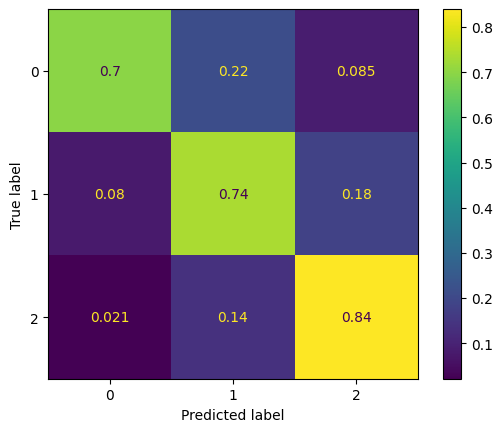

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.60144. Saving Model!
epoch 01, loss: 0.62004, acc: 0.73425, val_loss: 0.60144, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 02, loss: 0.61442, acc: 0.73881, val_loss: 0.60694, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 03, loss: 0.61770, acc: 0.73938, val_loss: 0.60868, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 04, loss: 0.61603, acc: 0.73966, val_loss: 0.60976, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 05, loss: 0.61446, acc: 0.74034, val_loss: 0.61162, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 06, loss: 0.61379, acc: 0.74171, val_loss: 0.61418, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 07, loss: 0.61253, acc: 0.74217, val_loss: 0.61650, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 08, loss: 0.61282, acc: 0.74186, val_loss: 0.61733, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 09, loss: 0.61195, acc: 0.74173, val_loss: 0.61886, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 10, loss: 0.61111, acc: 0.74243, val_loss: 0.62021, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 11, loss: 0.61095, acc: 0.74258, val_loss: 0.62120, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 12, loss: 0.61029, acc: 0.74363, val_loss: 0.62251, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 13, loss: 0.61002, acc: 0.74378, val_loss: 0.62338, val_accuracy: 0.73395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 14, loss: 0.60930, acc: 0.74435, val_loss: 0.62473, val_accuracy: 0.73336


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 15, loss: 0.60914, acc: 0.74415, val_loss: 0.62547, val_accuracy: 0.73336


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 16, loss: 0.60853, acc: 0.74435, val_loss: 0.62630, val_accuracy: 0.73277


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


epoch 17, loss: 0.60822, acc: 0.74468, val_loss: 0.62731, val_accuracy: 0.73199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 18, loss: 0.60784, acc: 0.74435, val_loss: 0.62830, val_accuracy: 0.73100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 19, loss: 0.60749, acc: 0.74448, val_loss: 0.62878, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 20, loss: 0.60724, acc: 0.74448, val_loss: 0.62972, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 21, loss: 0.60668, acc: 0.74487, val_loss: 0.63046, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 22, loss: 0.60663, acc: 0.74514, val_loss: 0.63096, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 23, loss: 0.60589, acc: 0.74490, val_loss: 0.63186, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 24, loss: 0.60589, acc: 0.74520, val_loss: 0.63210, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 25, loss: 0.60529, acc: 0.74522, val_loss: 0.63274, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 26, loss: 0.60506, acc: 0.74535, val_loss: 0.63350, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 27, loss: 0.60483, acc: 0.74544, val_loss: 0.63403, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 28, loss: 0.60450, acc: 0.74531, val_loss: 0.63455, val_accuracy: 0.72276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 29, loss: 0.60420, acc: 0.74575, val_loss: 0.63529, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 30, loss: 0.60346, acc: 0.74579, val_loss: 0.63607, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 31, loss: 0.60385, acc: 0.74559, val_loss: 0.63613, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 32, loss: 0.60308, acc: 0.74596, val_loss: 0.63699, val_accuracy: 0.71647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 33, loss: 0.60279, acc: 0.74638, val_loss: 0.63734, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


epoch 34, loss: 0.60263, acc: 0.74660, val_loss: 0.63775, val_accuracy: 0.71019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 35, loss: 0.60216, acc: 0.74677, val_loss: 0.63823, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 36, loss: 0.60181, acc: 0.74682, val_loss: 0.63868, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 37, loss: 0.60157, acc: 0.74706, val_loss: 0.63902, val_accuracy: 0.71078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 38, loss: 0.60140, acc: 0.74710, val_loss: 0.63948, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 39, loss: 0.60101, acc: 0.74649, val_loss: 0.63978, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 40, loss: 0.60086, acc: 0.74638, val_loss: 0.64010, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 41, loss: 0.60043, acc: 0.74716, val_loss: 0.64066, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


epoch 42, loss: 0.60010, acc: 0.74655, val_loss: 0.64125, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 43, loss: 0.60018, acc: 0.74664, val_loss: 0.64114, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 44, loss: 0.59974, acc: 0.74660, val_loss: 0.64169, val_accuracy: 0.70980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 45, loss: 0.59931, acc: 0.74690, val_loss: 0.64195, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 46, loss: 0.59909, acc: 0.74684, val_loss: 0.64233, val_accuracy: 0.70999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 47, loss: 0.59892, acc: 0.74688, val_loss: 0.64267, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 48, loss: 0.59857, acc: 0.74706, val_loss: 0.64293, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 49, loss: 0.59852, acc: 0.74692, val_loss: 0.64303, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 50, loss: 0.59793, acc: 0.74710, val_loss: 0.64392, val_accuracy: 0.70882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 51, loss: 0.59775, acc: 0.74699, val_loss: 0.64405, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 52, loss: 0.59783, acc: 0.74708, val_loss: 0.64378, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 53, loss: 0.59701, acc: 0.74738, val_loss: 0.64474, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 54, loss: 0.59705, acc: 0.74714, val_loss: 0.64492, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 55, loss: 0.59679, acc: 0.74745, val_loss: 0.64498, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 56, loss: 0.59658, acc: 0.74725, val_loss: 0.64527, val_accuracy: 0.70862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 57, loss: 0.59604, acc: 0.74721, val_loss: 0.64551, val_accuracy: 0.70882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 58, loss: 0.59604, acc: 0.74747, val_loss: 0.64579, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 59, loss: 0.59560, acc: 0.74784, val_loss: 0.64637, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 60, loss: 0.59549, acc: 0.74812, val_loss: 0.64618, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 61, loss: 0.59536, acc: 0.74802, val_loss: 0.64640, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 62, loss: 0.59464, acc: 0.74825, val_loss: 0.64708, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 63, loss: 0.59485, acc: 0.74819, val_loss: 0.64695, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 64, loss: 0.59450, acc: 0.74832, val_loss: 0.64708, val_accuracy: 0.70882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 65, loss: 0.59424, acc: 0.74828, val_loss: 0.64761, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 66, loss: 0.59391, acc: 0.74856, val_loss: 0.64763, val_accuracy: 0.70823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 67, loss: 0.59378, acc: 0.74871, val_loss: 0.64785, val_accuracy: 0.70823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.23it/s]


epoch 68, loss: 0.59352, acc: 0.74858, val_loss: 0.64805, val_accuracy: 0.70862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 69, loss: 0.59307, acc: 0.74887, val_loss: 0.64826, val_accuracy: 0.70666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 70, loss: 0.59308, acc: 0.74884, val_loss: 0.64857, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 71, loss: 0.59291, acc: 0.74867, val_loss: 0.64869, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 72, loss: 0.59232, acc: 0.74908, val_loss: 0.64871, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 73, loss: 0.59237, acc: 0.74897, val_loss: 0.64906, val_accuracy: 0.70666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 74, loss: 0.59220, acc: 0.74919, val_loss: 0.64897, val_accuracy: 0.70705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 75, loss: 0.59156, acc: 0.74928, val_loss: 0.64956, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 76, loss: 0.59182, acc: 0.74919, val_loss: 0.64935, val_accuracy: 0.70666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 77, loss: 0.59111, acc: 0.74935, val_loss: 0.64986, val_accuracy: 0.70666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 78, loss: 0.59124, acc: 0.74941, val_loss: 0.65041, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 79, loss: 0.59099, acc: 0.74965, val_loss: 0.65020, val_accuracy: 0.70666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 80, loss: 0.59061, acc: 0.74983, val_loss: 0.65037, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 81, loss: 0.59035, acc: 0.74993, val_loss: 0.65028, val_accuracy: 0.70705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 82, loss: 0.59028, acc: 0.75007, val_loss: 0.65052, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 83, loss: 0.58991, acc: 0.74969, val_loss: 0.65073, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 84, loss: 0.58959, acc: 0.75013, val_loss: 0.65116, val_accuracy: 0.70469


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 85, loss: 0.58951, acc: 0.75024, val_loss: 0.65132, val_accuracy: 0.70509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 86, loss: 0.58952, acc: 0.75000, val_loss: 0.65132, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 87, loss: 0.58874, acc: 0.75035, val_loss: 0.65166, val_accuracy: 0.70528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 88, loss: 0.58891, acc: 0.75057, val_loss: 0.65148, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 89, loss: 0.58861, acc: 0.75055, val_loss: 0.65158, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 90, loss: 0.58808, acc: 0.75065, val_loss: 0.65216, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 91, loss: 0.58824, acc: 0.75057, val_loss: 0.65214, val_accuracy: 0.70548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 92, loss: 0.58805, acc: 0.75057, val_loss: 0.65208, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 93, loss: 0.58747, acc: 0.75140, val_loss: 0.65269, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 94, loss: 0.58766, acc: 0.75142, val_loss: 0.65261, val_accuracy: 0.70548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 95, loss: 0.58719, acc: 0.75140, val_loss: 0.65250, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 96, loss: 0.58701, acc: 0.75140, val_loss: 0.65300, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 97, loss: 0.58660, acc: 0.75177, val_loss: 0.65323, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 98, loss: 0.58695, acc: 0.75240, val_loss: 0.65285, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 99, loss: 0.58586, acc: 0.75284, val_loss: 0.65330, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 100, loss: 0.58606, acc: 0.75297, val_loss: 0.65357, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.98it/s]


epoch 101, loss: 0.58617, acc: 0.75279, val_loss: 0.65351, val_accuracy: 0.70567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 102, loss: 0.58548, acc: 0.75308, val_loss: 0.65383, val_accuracy: 0.70666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 103, loss: 0.58530, acc: 0.75305, val_loss: 0.65374, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 104, loss: 0.58530, acc: 0.75332, val_loss: 0.65400, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 105, loss: 0.58485, acc: 0.75349, val_loss: 0.65428, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 106, loss: 0.58474, acc: 0.75353, val_loss: 0.65425, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 107, loss: 0.58469, acc: 0.75336, val_loss: 0.65419, val_accuracy: 0.70567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 108, loss: 0.58405, acc: 0.75371, val_loss: 0.65485, val_accuracy: 0.70509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 109, loss: 0.58400, acc: 0.75393, val_loss: 0.65489, val_accuracy: 0.70548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 110, loss: 0.58414, acc: 0.75375, val_loss: 0.65502, val_accuracy: 0.70548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 111, loss: 0.58350, acc: 0.75390, val_loss: 0.65515, val_accuracy: 0.70567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 112, loss: 0.58361, acc: 0.75395, val_loss: 0.65518, val_accuracy: 0.70528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 113, loss: 0.58293, acc: 0.75406, val_loss: 0.65541, val_accuracy: 0.70548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 114, loss: 0.58319, acc: 0.75423, val_loss: 0.65584, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 115, loss: 0.58283, acc: 0.75419, val_loss: 0.65548, val_accuracy: 0.70548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 116, loss: 0.58265, acc: 0.75417, val_loss: 0.65580, val_accuracy: 0.70567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 117, loss: 0.58205, acc: 0.75441, val_loss: 0.65578, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 118, loss: 0.58240, acc: 0.75423, val_loss: 0.65587, val_accuracy: 0.70567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 119, loss: 0.58162, acc: 0.75462, val_loss: 0.65649, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 120, loss: 0.58213, acc: 0.75471, val_loss: 0.65600, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 121, loss: 0.58108, acc: 0.75454, val_loss: 0.65653, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 122, loss: 0.58151, acc: 0.75467, val_loss: 0.65649, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 123, loss: 0.58081, acc: 0.75471, val_loss: 0.65695, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 124, loss: 0.58116, acc: 0.75473, val_loss: 0.65655, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 125, loss: 0.58040, acc: 0.75467, val_loss: 0.65716, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 126, loss: 0.58056, acc: 0.75497, val_loss: 0.65732, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 127, loss: 0.58018, acc: 0.75482, val_loss: 0.65730, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 128, loss: 0.58001, acc: 0.75502, val_loss: 0.65785, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 129, loss: 0.57964, acc: 0.75500, val_loss: 0.65750, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 130, loss: 0.57952, acc: 0.75513, val_loss: 0.65766, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 131, loss: 0.57939, acc: 0.75517, val_loss: 0.65815, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 132, loss: 0.57914, acc: 0.75526, val_loss: 0.65824, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 133, loss: 0.57901, acc: 0.75545, val_loss: 0.65790, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 134, loss: 0.57847, acc: 0.75526, val_loss: 0.65868, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 135, loss: 0.57854, acc: 0.75545, val_loss: 0.65887, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 136, loss: 0.57831, acc: 0.75561, val_loss: 0.65866, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 137, loss: 0.57794, acc: 0.75578, val_loss: 0.65875, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 138, loss: 0.57774, acc: 0.75558, val_loss: 0.65882, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 139, loss: 0.57780, acc: 0.75563, val_loss: 0.65922, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 140, loss: 0.57738, acc: 0.75574, val_loss: 0.65927, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 141, loss: 0.57693, acc: 0.75582, val_loss: 0.65941, val_accuracy: 0.70548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 142, loss: 0.57730, acc: 0.75572, val_loss: 0.65943, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 143, loss: 0.57653, acc: 0.75572, val_loss: 0.65988, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 144, loss: 0.57660, acc: 0.75585, val_loss: 0.65976, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 145, loss: 0.57647, acc: 0.75670, val_loss: 0.65987, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 146, loss: 0.57590, acc: 0.75670, val_loss: 0.66029, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 147, loss: 0.57589, acc: 0.75606, val_loss: 0.66016, val_accuracy: 0.70567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 148, loss: 0.57610, acc: 0.75663, val_loss: 0.66021, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 149, loss: 0.57528, acc: 0.75681, val_loss: 0.66075, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 150, loss: 0.57517, acc: 0.75735, val_loss: 0.66070, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 151, loss: 0.57543, acc: 0.75689, val_loss: 0.66080, val_accuracy: 0.70705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 152, loss: 0.57464, acc: 0.75742, val_loss: 0.66064, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 153, loss: 0.57468, acc: 0.75720, val_loss: 0.66067, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 154, loss: 0.57458, acc: 0.75726, val_loss: 0.66077, val_accuracy: 0.70666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 155, loss: 0.57431, acc: 0.75707, val_loss: 0.66116, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 156, loss: 0.57377, acc: 0.75733, val_loss: 0.66116, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 157, loss: 0.57423, acc: 0.75707, val_loss: 0.66102, val_accuracy: 0.70666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 158, loss: 0.57338, acc: 0.75739, val_loss: 0.66127, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 159, loss: 0.57342, acc: 0.75763, val_loss: 0.66153, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 160, loss: 0.57310, acc: 0.75735, val_loss: 0.66148, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 161, loss: 0.57309, acc: 0.75735, val_loss: 0.66166, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 162, loss: 0.57243, acc: 0.75763, val_loss: 0.66170, val_accuracy: 0.70744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 163, loss: 0.57285, acc: 0.75774, val_loss: 0.66181, val_accuracy: 0.70725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 164, loss: 0.57206, acc: 0.75781, val_loss: 0.66209, val_accuracy: 0.70725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 165, loss: 0.57230, acc: 0.75746, val_loss: 0.66209, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 166, loss: 0.57192, acc: 0.75862, val_loss: 0.66238, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 167, loss: 0.57153, acc: 0.75877, val_loss: 0.66249, val_accuracy: 0.70666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 168, loss: 0.57140, acc: 0.75853, val_loss: 0.66218, val_accuracy: 0.70705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 169, loss: 0.57149, acc: 0.75864, val_loss: 0.66270, val_accuracy: 0.70705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 170, loss: 0.57084, acc: 0.75897, val_loss: 0.66278, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 171, loss: 0.57076, acc: 0.75916, val_loss: 0.66266, val_accuracy: 0.70666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 172, loss: 0.57075, acc: 0.75905, val_loss: 0.66274, val_accuracy: 0.70705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 173, loss: 0.57037, acc: 0.75897, val_loss: 0.66330, val_accuracy: 0.70744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 174, loss: 0.57024, acc: 0.75907, val_loss: 0.66327, val_accuracy: 0.70725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 175, loss: 0.57006, acc: 0.75977, val_loss: 0.66334, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 176, loss: 0.56970, acc: 0.76016, val_loss: 0.66346, val_accuracy: 0.70744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 177, loss: 0.56954, acc: 0.75951, val_loss: 0.66353, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


epoch 178, loss: 0.56967, acc: 0.76001, val_loss: 0.66322, val_accuracy: 0.70705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 179, loss: 0.56895, acc: 0.76023, val_loss: 0.66402, val_accuracy: 0.70744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 180, loss: 0.56913, acc: 0.76032, val_loss: 0.66367, val_accuracy: 0.70725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 181, loss: 0.56894, acc: 0.76003, val_loss: 0.66351, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]


epoch 182, loss: 0.56837, acc: 0.76034, val_loss: 0.66403, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 183, loss: 0.56849, acc: 0.76078, val_loss: 0.66445, val_accuracy: 0.70764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 184, loss: 0.56815, acc: 0.76088, val_loss: 0.66428, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 185, loss: 0.56820, acc: 0.76084, val_loss: 0.66459, val_accuracy: 0.70764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 186, loss: 0.56762, acc: 0.76095, val_loss: 0.66441, val_accuracy: 0.70823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 187, loss: 0.56758, acc: 0.76082, val_loss: 0.66448, val_accuracy: 0.70823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 188, loss: 0.56734, acc: 0.76106, val_loss: 0.66430, val_accuracy: 0.70803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 189, loss: 0.56702, acc: 0.76130, val_loss: 0.66502, val_accuracy: 0.70725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 190, loss: 0.56698, acc: 0.76108, val_loss: 0.66504, val_accuracy: 0.70823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 191, loss: 0.56698, acc: 0.76121, val_loss: 0.66514, val_accuracy: 0.70823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 192, loss: 0.56624, acc: 0.76154, val_loss: 0.66499, val_accuracy: 0.70666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 193, loss: 0.56665, acc: 0.76117, val_loss: 0.66516, val_accuracy: 0.70430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 194, loss: 0.56584, acc: 0.76156, val_loss: 0.66515, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 195, loss: 0.56600, acc: 0.76132, val_loss: 0.66535, val_accuracy: 0.70705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 196, loss: 0.56575, acc: 0.76169, val_loss: 0.66538, val_accuracy: 0.70509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 197, loss: 0.56554, acc: 0.76184, val_loss: 0.66558, val_accuracy: 0.70430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 198, loss: 0.56504, acc: 0.76187, val_loss: 0.66579, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 199, loss: 0.56563, acc: 0.76178, val_loss: 0.66533, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 200, loss: 0.56462, acc: 0.76180, val_loss: 0.66606, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 201, loss: 0.56505, acc: 0.76178, val_loss: 0.66626, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 202, loss: 0.56427, acc: 0.76213, val_loss: 0.66619, val_accuracy: 0.70391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


epoch 203, loss: 0.56454, acc: 0.76193, val_loss: 0.66605, val_accuracy: 0.70194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 204, loss: 0.56381, acc: 0.76208, val_loss: 0.66634, val_accuracy: 0.70214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.32it/s]


epoch 205, loss: 0.56418, acc: 0.76187, val_loss: 0.66675, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 206, loss: 0.56346, acc: 0.76246, val_loss: 0.66675, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 207, loss: 0.56358, acc: 0.76335, val_loss: 0.66649, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 208, loss: 0.56307, acc: 0.76352, val_loss: 0.66690, val_accuracy: 0.70194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


epoch 209, loss: 0.56323, acc: 0.76366, val_loss: 0.66680, val_accuracy: 0.70214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 210, loss: 0.56304, acc: 0.76357, val_loss: 0.66665, val_accuracy: 0.70018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 211, loss: 0.56261, acc: 0.76348, val_loss: 0.66681, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 212, loss: 0.56258, acc: 0.76366, val_loss: 0.66706, val_accuracy: 0.70214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 213, loss: 0.56207, acc: 0.76385, val_loss: 0.66766, val_accuracy: 0.70018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 214, loss: 0.56233, acc: 0.76379, val_loss: 0.66714, val_accuracy: 0.70194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


epoch 215, loss: 0.56171, acc: 0.76387, val_loss: 0.66752, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 216, loss: 0.56162, acc: 0.76398, val_loss: 0.66774, val_accuracy: 0.70018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 217, loss: 0.56163, acc: 0.76359, val_loss: 0.66732, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 218, loss: 0.56120, acc: 0.76411, val_loss: 0.66779, val_accuracy: 0.70214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 219, loss: 0.56077, acc: 0.76339, val_loss: 0.66752, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 220, loss: 0.56119, acc: 0.76370, val_loss: 0.66804, val_accuracy: 0.70273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 221, loss: 0.56057, acc: 0.76376, val_loss: 0.66823, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 222, loss: 0.56047, acc: 0.76361, val_loss: 0.66824, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 223, loss: 0.56039, acc: 0.76368, val_loss: 0.66799, val_accuracy: 0.70273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 224, loss: 0.55991, acc: 0.76368, val_loss: 0.66859, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 225, loss: 0.55982, acc: 0.76396, val_loss: 0.66842, val_accuracy: 0.70037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 226, loss: 0.55970, acc: 0.76363, val_loss: 0.66871, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 227, loss: 0.55947, acc: 0.76433, val_loss: 0.66876, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 228, loss: 0.55905, acc: 0.76409, val_loss: 0.66912, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 229, loss: 0.55945, acc: 0.76398, val_loss: 0.66855, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 230, loss: 0.55850, acc: 0.76416, val_loss: 0.66918, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 231, loss: 0.55904, acc: 0.76420, val_loss: 0.66859, val_accuracy: 0.70037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 232, loss: 0.55837, acc: 0.76379, val_loss: 0.66941, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 233, loss: 0.55818, acc: 0.76573, val_loss: 0.66906, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 234, loss: 0.55792, acc: 0.76451, val_loss: 0.66888, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 235, loss: 0.55822, acc: 0.76433, val_loss: 0.66913, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 236, loss: 0.55743, acc: 0.76431, val_loss: 0.66909, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 237, loss: 0.55740, acc: 0.76592, val_loss: 0.66937, val_accuracy: 0.70077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 238, loss: 0.55717, acc: 0.76573, val_loss: 0.66971, val_accuracy: 0.70116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 239, loss: 0.55728, acc: 0.76542, val_loss: 0.66940, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 240, loss: 0.55640, acc: 0.76592, val_loss: 0.66968, val_accuracy: 0.70018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 241, loss: 0.55684, acc: 0.76586, val_loss: 0.67005, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 242, loss: 0.55641, acc: 0.76625, val_loss: 0.66953, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 243, loss: 0.55595, acc: 0.76595, val_loss: 0.67029, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 244, loss: 0.55653, acc: 0.76610, val_loss: 0.66996, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 245, loss: 0.55553, acc: 0.76667, val_loss: 0.67038, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 246, loss: 0.55567, acc: 0.76612, val_loss: 0.67013, val_accuracy: 0.70096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 247, loss: 0.55555, acc: 0.76621, val_loss: 0.67036, val_accuracy: 0.70332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 248, loss: 0.55496, acc: 0.76651, val_loss: 0.67052, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 249, loss: 0.55532, acc: 0.76632, val_loss: 0.67030, val_accuracy: 0.70096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 250, loss: 0.55533, acc: 0.76671, val_loss: 0.67027, val_accuracy: 0.70273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 251, loss: 0.55407, acc: 0.76704, val_loss: 0.67090, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 252, loss: 0.55475, acc: 0.76671, val_loss: 0.67044, val_accuracy: 0.70116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 253, loss: 0.55417, acc: 0.76629, val_loss: 0.67085, val_accuracy: 0.70351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 254, loss: 0.55421, acc: 0.76686, val_loss: 0.67115, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 255, loss: 0.55346, acc: 0.76688, val_loss: 0.67085, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 256, loss: 0.55407, acc: 0.76667, val_loss: 0.67040, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 257, loss: 0.55283, acc: 0.76708, val_loss: 0.67151, val_accuracy: 0.70391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 258, loss: 0.55365, acc: 0.76680, val_loss: 0.67129, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 259, loss: 0.55323, acc: 0.76701, val_loss: 0.67084, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 260, loss: 0.55270, acc: 0.76793, val_loss: 0.67164, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 261, loss: 0.55244, acc: 0.76754, val_loss: 0.67138, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 262, loss: 0.55296, acc: 0.76710, val_loss: 0.67107, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 263, loss: 0.55161, acc: 0.76920, val_loss: 0.67156, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 264, loss: 0.55249, acc: 0.76839, val_loss: 0.67157, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 265, loss: 0.55177, acc: 0.76920, val_loss: 0.67145, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 266, loss: 0.55165, acc: 0.76920, val_loss: 0.67259, val_accuracy: 0.70351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 267, loss: 0.55144, acc: 0.76970, val_loss: 0.67169, val_accuracy: 0.70273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 268, loss: 0.55161, acc: 0.76989, val_loss: 0.67198, val_accuracy: 0.70351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 269, loss: 0.55055, acc: 0.77085, val_loss: 0.67214, val_accuracy: 0.70332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 270, loss: 0.55162, acc: 0.76935, val_loss: 0.67225, val_accuracy: 0.69389


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 271, loss: 0.55006, acc: 0.76998, val_loss: 0.67257, val_accuracy: 0.69546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 272, loss: 0.55120, acc: 0.76950, val_loss: 0.67219, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 273, loss: 0.54988, acc: 0.77007, val_loss: 0.67235, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 274, loss: 0.55072, acc: 0.77048, val_loss: 0.67261, val_accuracy: 0.69488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 275, loss: 0.54937, acc: 0.77116, val_loss: 0.67275, val_accuracy: 0.69488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 276, loss: 0.55032, acc: 0.77002, val_loss: 0.67267, val_accuracy: 0.69468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 277, loss: 0.54919, acc: 0.77042, val_loss: 0.67286, val_accuracy: 0.69468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 278, loss: 0.54968, acc: 0.77044, val_loss: 0.67309, val_accuracy: 0.69448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 279, loss: 0.54873, acc: 0.77072, val_loss: 0.67304, val_accuracy: 0.69448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 280, loss: 0.54945, acc: 0.77112, val_loss: 0.67351, val_accuracy: 0.69448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 281, loss: 0.54832, acc: 0.77168, val_loss: 0.67342, val_accuracy: 0.69409


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 282, loss: 0.54886, acc: 0.77083, val_loss: 0.67341, val_accuracy: 0.69507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 283, loss: 0.54837, acc: 0.77081, val_loss: 0.67311, val_accuracy: 0.69527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 284, loss: 0.54818, acc: 0.77140, val_loss: 0.67344, val_accuracy: 0.69488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 285, loss: 0.54763, acc: 0.77105, val_loss: 0.67384, val_accuracy: 0.69488


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 286, loss: 0.54850, acc: 0.77175, val_loss: 0.67360, val_accuracy: 0.69546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 287, loss: 0.54694, acc: 0.77218, val_loss: 0.67430, val_accuracy: 0.69586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 288, loss: 0.54789, acc: 0.77085, val_loss: 0.67320, val_accuracy: 0.69527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 289, loss: 0.54694, acc: 0.77201, val_loss: 0.67370, val_accuracy: 0.69507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 290, loss: 0.54729, acc: 0.77164, val_loss: 0.67400, val_accuracy: 0.69546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 291, loss: 0.54641, acc: 0.77122, val_loss: 0.67366, val_accuracy: 0.69527


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 292, loss: 0.54686, acc: 0.77201, val_loss: 0.67468, val_accuracy: 0.69625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 293, loss: 0.54622, acc: 0.77249, val_loss: 0.67418, val_accuracy: 0.69645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 294, loss: 0.54645, acc: 0.77205, val_loss: 0.67445, val_accuracy: 0.69625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 295, loss: 0.54579, acc: 0.77245, val_loss: 0.67370, val_accuracy: 0.69664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 296, loss: 0.54618, acc: 0.77157, val_loss: 0.67433, val_accuracy: 0.69586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 297, loss: 0.54479, acc: 0.77173, val_loss: 0.67509, val_accuracy: 0.69586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 298, loss: 0.54627, acc: 0.77129, val_loss: 0.67424, val_accuracy: 0.69664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 299, loss: 0.54444, acc: 0.77192, val_loss: 0.67451, val_accuracy: 0.69704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 300, loss: 0.54575, acc: 0.77131, val_loss: 0.67437, val_accuracy: 0.69645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 301, loss: 0.54412, acc: 0.77255, val_loss: 0.67465, val_accuracy: 0.69664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 302, loss: 0.54512, acc: 0.77155, val_loss: 0.67494, val_accuracy: 0.69664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 303, loss: 0.54383, acc: 0.77216, val_loss: 0.67458, val_accuracy: 0.69704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 304, loss: 0.54492, acc: 0.77264, val_loss: 0.67460, val_accuracy: 0.69704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 305, loss: 0.54319, acc: 0.77236, val_loss: 0.67468, val_accuracy: 0.69704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 306, loss: 0.54461, acc: 0.77157, val_loss: 0.67448, val_accuracy: 0.69664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 307, loss: 0.54270, acc: 0.77245, val_loss: 0.67501, val_accuracy: 0.69723


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 308, loss: 0.54389, acc: 0.77277, val_loss: 0.67499, val_accuracy: 0.69664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 309, loss: 0.54253, acc: 0.77312, val_loss: 0.67515, val_accuracy: 0.69762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 310, loss: 0.54346, acc: 0.77231, val_loss: 0.67535, val_accuracy: 0.69684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 311, loss: 0.54225, acc: 0.77338, val_loss: 0.67531, val_accuracy: 0.69743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 312, loss: 0.54328, acc: 0.77330, val_loss: 0.67537, val_accuracy: 0.69704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 313, loss: 0.54174, acc: 0.77282, val_loss: 0.67561, val_accuracy: 0.69704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 314, loss: 0.54258, acc: 0.77251, val_loss: 0.67542, val_accuracy: 0.69684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 315, loss: 0.54129, acc: 0.77371, val_loss: 0.67563, val_accuracy: 0.69723


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 316, loss: 0.54213, acc: 0.77290, val_loss: 0.67563, val_accuracy: 0.69664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 317, loss: 0.54122, acc: 0.77310, val_loss: 0.67546, val_accuracy: 0.69684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 318, loss: 0.54174, acc: 0.77279, val_loss: 0.67629, val_accuracy: 0.69743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 319, loss: 0.54020, acc: 0.77423, val_loss: 0.67627, val_accuracy: 0.69782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


epoch 320, loss: 0.54184, acc: 0.77378, val_loss: 0.67535, val_accuracy: 0.69684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 321, loss: 0.53972, acc: 0.77430, val_loss: 0.67668, val_accuracy: 0.69782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 322, loss: 0.54122, acc: 0.77471, val_loss: 0.67600, val_accuracy: 0.69743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 323, loss: 0.53971, acc: 0.77502, val_loss: 0.67594, val_accuracy: 0.69762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 324, loss: 0.54045, acc: 0.77389, val_loss: 0.67670, val_accuracy: 0.69762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 325, loss: 0.53930, acc: 0.77565, val_loss: 0.67595, val_accuracy: 0.69723


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 326, loss: 0.54027, acc: 0.77500, val_loss: 0.67625, val_accuracy: 0.69723


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 327, loss: 0.53874, acc: 0.77482, val_loss: 0.67647, val_accuracy: 0.69782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 328, loss: 0.53992, acc: 0.77506, val_loss: 0.67666, val_accuracy: 0.69723


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 329, loss: 0.53844, acc: 0.77546, val_loss: 0.67642, val_accuracy: 0.69821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 330, loss: 0.53972, acc: 0.77297, val_loss: 0.67667, val_accuracy: 0.69723


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 331, loss: 0.53749, acc: 0.77491, val_loss: 0.67700, val_accuracy: 0.69802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 332, loss: 0.53989, acc: 0.77434, val_loss: 0.67647, val_accuracy: 0.69821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 333, loss: 0.53688, acc: 0.77587, val_loss: 0.67721, val_accuracy: 0.69861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 334, loss: 0.53955, acc: 0.77391, val_loss: 0.67688, val_accuracy: 0.69782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 335, loss: 0.53642, acc: 0.77624, val_loss: 0.67760, val_accuracy: 0.69782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 336, loss: 0.53914, acc: 0.77338, val_loss: 0.67660, val_accuracy: 0.69762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 337, loss: 0.53607, acc: 0.77626, val_loss: 0.67714, val_accuracy: 0.69880


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 338, loss: 0.53876, acc: 0.77445, val_loss: 0.67655, val_accuracy: 0.69802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 339, loss: 0.53524, acc: 0.77685, val_loss: 0.67790, val_accuracy: 0.69880


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 340, loss: 0.53865, acc: 0.77439, val_loss: 0.67741, val_accuracy: 0.69782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 341, loss: 0.53535, acc: 0.77657, val_loss: 0.67731, val_accuracy: 0.69919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 342, loss: 0.53768, acc: 0.77485, val_loss: 0.67761, val_accuracy: 0.69841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 343, loss: 0.53488, acc: 0.77618, val_loss: 0.67794, val_accuracy: 0.69900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 344, loss: 0.53790, acc: 0.77458, val_loss: 0.67768, val_accuracy: 0.69821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 345, loss: 0.53385, acc: 0.77676, val_loss: 0.67907, val_accuracy: 0.69959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 346, loss: 0.53759, acc: 0.77458, val_loss: 0.67760, val_accuracy: 0.69880


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 347, loss: 0.53388, acc: 0.77700, val_loss: 0.67910, val_accuracy: 0.69998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 348, loss: 0.53654, acc: 0.77500, val_loss: 0.67806, val_accuracy: 0.69861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 349, loss: 0.53366, acc: 0.77707, val_loss: 0.67830, val_accuracy: 0.69939


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 350, loss: 0.53638, acc: 0.77471, val_loss: 0.67872, val_accuracy: 0.69959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 351, loss: 0.53308, acc: 0.77722, val_loss: 0.67878, val_accuracy: 0.69959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 352, loss: 0.53597, acc: 0.77504, val_loss: 0.67783, val_accuracy: 0.69861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 353, loss: 0.53253, acc: 0.77714, val_loss: 0.67969, val_accuracy: 0.70037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 354, loss: 0.53583, acc: 0.77485, val_loss: 0.67846, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 355, loss: 0.53199, acc: 0.77757, val_loss: 0.68020, val_accuracy: 0.70096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 356, loss: 0.53540, acc: 0.77528, val_loss: 0.67893, val_accuracy: 0.69959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 357, loss: 0.53162, acc: 0.77803, val_loss: 0.67955, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 358, loss: 0.53490, acc: 0.77543, val_loss: 0.67899, val_accuracy: 0.70077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 359, loss: 0.53132, acc: 0.77775, val_loss: 0.68003, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 360, loss: 0.53451, acc: 0.77561, val_loss: 0.67901, val_accuracy: 0.70116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 361, loss: 0.53107, acc: 0.77814, val_loss: 0.68054, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 362, loss: 0.53404, acc: 0.77613, val_loss: 0.67889, val_accuracy: 0.70077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 363, loss: 0.53043, acc: 0.77823, val_loss: 0.67983, val_accuracy: 0.70214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 364, loss: 0.53362, acc: 0.77561, val_loss: 0.67828, val_accuracy: 0.70018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 365, loss: 0.52998, acc: 0.77807, val_loss: 0.68045, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 366, loss: 0.53352, acc: 0.77659, val_loss: 0.67893, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 367, loss: 0.52969, acc: 0.77851, val_loss: 0.68037, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 368, loss: 0.53299, acc: 0.77642, val_loss: 0.67994, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 369, loss: 0.52920, acc: 0.77877, val_loss: 0.68036, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 370, loss: 0.53239, acc: 0.77687, val_loss: 0.67984, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 371, loss: 0.52907, acc: 0.77882, val_loss: 0.68080, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 372, loss: 0.53164, acc: 0.77714, val_loss: 0.67967, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 373, loss: 0.52879, acc: 0.77967, val_loss: 0.68113, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 374, loss: 0.53164, acc: 0.77742, val_loss: 0.67974, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 375, loss: 0.52796, acc: 0.77969, val_loss: 0.68103, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 376, loss: 0.53127, acc: 0.77844, val_loss: 0.67968, val_accuracy: 0.70214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 377, loss: 0.52786, acc: 0.78006, val_loss: 0.68118, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 378, loss: 0.53065, acc: 0.77783, val_loss: 0.68046, val_accuracy: 0.70214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 379, loss: 0.52739, acc: 0.77980, val_loss: 0.68081, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 380, loss: 0.53087, acc: 0.77812, val_loss: 0.67950, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 381, loss: 0.52647, acc: 0.78043, val_loss: 0.68149, val_accuracy: 0.70371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 382, loss: 0.53028, acc: 0.77847, val_loss: 0.68042, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 383, loss: 0.52640, acc: 0.78043, val_loss: 0.68146, val_accuracy: 0.70351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 384, loss: 0.52985, acc: 0.77849, val_loss: 0.68001, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 385, loss: 0.52617, acc: 0.78015, val_loss: 0.68122, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 386, loss: 0.52925, acc: 0.77862, val_loss: 0.68146, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 387, loss: 0.52556, acc: 0.78069, val_loss: 0.68132, val_accuracy: 0.70410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 388, loss: 0.52949, acc: 0.77751, val_loss: 0.68025, val_accuracy: 0.70332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 389, loss: 0.52507, acc: 0.78113, val_loss: 0.68196, val_accuracy: 0.70430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 390, loss: 0.52886, acc: 0.77873, val_loss: 0.67987, val_accuracy: 0.70273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 391, loss: 0.52485, acc: 0.78084, val_loss: 0.68163, val_accuracy: 0.70430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 392, loss: 0.52812, acc: 0.77953, val_loss: 0.67995, val_accuracy: 0.70194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 393, loss: 0.52430, acc: 0.78176, val_loss: 0.68257, val_accuracy: 0.70410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 394, loss: 0.52816, acc: 0.78030, val_loss: 0.68087, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 395, loss: 0.52378, acc: 0.78265, val_loss: 0.68209, val_accuracy: 0.70410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 396, loss: 0.52761, acc: 0.78047, val_loss: 0.68134, val_accuracy: 0.70332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 397, loss: 0.52353, acc: 0.78265, val_loss: 0.68258, val_accuracy: 0.70469


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 398, loss: 0.52743, acc: 0.78039, val_loss: 0.68136, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 399, loss: 0.52288, acc: 0.78309, val_loss: 0.68118, val_accuracy: 0.70509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 400, loss: 0.52690, acc: 0.78082, val_loss: 0.68075, val_accuracy: 0.69959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 401, loss: 0.52257, acc: 0.78287, val_loss: 0.68246, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 402, loss: 0.52677, acc: 0.78045, val_loss: 0.68051, val_accuracy: 0.70332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 403, loss: 0.52191, acc: 0.78329, val_loss: 0.68331, val_accuracy: 0.69978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 404, loss: 0.52619, acc: 0.78106, val_loss: 0.68067, val_accuracy: 0.69939


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 405, loss: 0.52168, acc: 0.78350, val_loss: 0.68283, val_accuracy: 0.70037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 406, loss: 0.52564, acc: 0.78104, val_loss: 0.68152, val_accuracy: 0.69861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 407, loss: 0.52123, acc: 0.78298, val_loss: 0.68274, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 408, loss: 0.52569, acc: 0.78117, val_loss: 0.68165, val_accuracy: 0.69959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 409, loss: 0.52058, acc: 0.78364, val_loss: 0.68365, val_accuracy: 0.70077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 410, loss: 0.52552, acc: 0.78124, val_loss: 0.68212, val_accuracy: 0.69998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 411, loss: 0.52058, acc: 0.78342, val_loss: 0.68273, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 412, loss: 0.52449, acc: 0.78141, val_loss: 0.68097, val_accuracy: 0.69959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 413, loss: 0.51993, acc: 0.78257, val_loss: 0.68371, val_accuracy: 0.70096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 414, loss: 0.52413, acc: 0.78156, val_loss: 0.68182, val_accuracy: 0.70077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 415, loss: 0.51972, acc: 0.78501, val_loss: 0.68326, val_accuracy: 0.70116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 416, loss: 0.52381, acc: 0.78172, val_loss: 0.68293, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 417, loss: 0.51890, acc: 0.78566, val_loss: 0.68402, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 418, loss: 0.52381, acc: 0.78183, val_loss: 0.68157, val_accuracy: 0.70018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 419, loss: 0.51841, acc: 0.78444, val_loss: 0.68471, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 420, loss: 0.52360, acc: 0.78167, val_loss: 0.68207, val_accuracy: 0.70018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 421, loss: 0.51814, acc: 0.78558, val_loss: 0.68464, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 422, loss: 0.52316, acc: 0.78235, val_loss: 0.68301, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 423, loss: 0.51783, acc: 0.78488, val_loss: 0.68397, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 424, loss: 0.52295, acc: 0.78207, val_loss: 0.68235, val_accuracy: 0.70018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 425, loss: 0.51701, acc: 0.78636, val_loss: 0.68514, val_accuracy: 0.70214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 426, loss: 0.52276, acc: 0.78207, val_loss: 0.68290, val_accuracy: 0.70037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 427, loss: 0.51676, acc: 0.78542, val_loss: 0.68483, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 428, loss: 0.52196, acc: 0.78285, val_loss: 0.68277, val_accuracy: 0.70037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 429, loss: 0.51655, acc: 0.78752, val_loss: 0.68616, val_accuracy: 0.70194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 430, loss: 0.52178, acc: 0.78274, val_loss: 0.68287, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 431, loss: 0.51561, acc: 0.78676, val_loss: 0.68662, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 432, loss: 0.52152, acc: 0.78300, val_loss: 0.68341, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 433, loss: 0.51585, acc: 0.78785, val_loss: 0.68552, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 434, loss: 0.52092, acc: 0.78283, val_loss: 0.68287, val_accuracy: 0.70096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 435, loss: 0.51504, acc: 0.78693, val_loss: 0.68549, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 436, loss: 0.52072, acc: 0.78231, val_loss: 0.68359, val_accuracy: 0.70096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 437, loss: 0.51466, acc: 0.78817, val_loss: 0.68677, val_accuracy: 0.70332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 438, loss: 0.52000, acc: 0.78348, val_loss: 0.68369, val_accuracy: 0.70037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 439, loss: 0.51466, acc: 0.78754, val_loss: 0.68612, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 440, loss: 0.51941, acc: 0.78457, val_loss: 0.68450, val_accuracy: 0.70077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 441, loss: 0.51459, acc: 0.78647, val_loss: 0.68569, val_accuracy: 0.70273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 442, loss: 0.51884, acc: 0.78551, val_loss: 0.68557, val_accuracy: 0.70214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 443, loss: 0.51367, acc: 0.78885, val_loss: 0.68680, val_accuracy: 0.70214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 444, loss: 0.51914, acc: 0.78488, val_loss: 0.68366, val_accuracy: 0.70096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 445, loss: 0.51312, acc: 0.78870, val_loss: 0.68701, val_accuracy: 0.69370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 446, loss: 0.51835, acc: 0.78536, val_loss: 0.68431, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 447, loss: 0.51317, acc: 0.78865, val_loss: 0.68639, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 448, loss: 0.51815, acc: 0.78390, val_loss: 0.68472, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 449, loss: 0.51214, acc: 0.78924, val_loss: 0.68706, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 450, loss: 0.51828, acc: 0.78422, val_loss: 0.68493, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 451, loss: 0.51189, acc: 0.78911, val_loss: 0.68743, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 452, loss: 0.51751, acc: 0.78566, val_loss: 0.68567, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 453, loss: 0.51175, acc: 0.78848, val_loss: 0.68795, val_accuracy: 0.69370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 454, loss: 0.51731, acc: 0.78700, val_loss: 0.68437, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 455, loss: 0.51105, acc: 0.78966, val_loss: 0.68765, val_accuracy: 0.70371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 456, loss: 0.51727, acc: 0.78501, val_loss: 0.68527, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 457, loss: 0.51051, acc: 0.78911, val_loss: 0.68838, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.23it/s]


epoch 458, loss: 0.51700, acc: 0.78571, val_loss: 0.68587, val_accuracy: 0.70194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 459, loss: 0.51024, acc: 0.78979, val_loss: 0.68862, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 460, loss: 0.51612, acc: 0.78625, val_loss: 0.68495, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 461, loss: 0.51041, acc: 0.78883, val_loss: 0.68835, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 462, loss: 0.51528, acc: 0.78684, val_loss: 0.68657, val_accuracy: 0.70273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 463, loss: 0.50971, acc: 0.79001, val_loss: 0.68883, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 464, loss: 0.51516, acc: 0.78665, val_loss: 0.68625, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 465, loss: 0.50899, acc: 0.79049, val_loss: 0.68898, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 466, loss: 0.51475, acc: 0.78671, val_loss: 0.68603, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 467, loss: 0.50920, acc: 0.78891, val_loss: 0.68761, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 468, loss: 0.51382, acc: 0.78682, val_loss: 0.68642, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 469, loss: 0.50851, acc: 0.78963, val_loss: 0.68964, val_accuracy: 0.69370


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 470, loss: 0.51362, acc: 0.78686, val_loss: 0.68697, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 471, loss: 0.50839, acc: 0.78955, val_loss: 0.68791, val_accuracy: 0.70351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 472, loss: 0.51263, acc: 0.78756, val_loss: 0.68732, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 473, loss: 0.50809, acc: 0.78955, val_loss: 0.68852, val_accuracy: 0.70332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 474, loss: 0.51318, acc: 0.78708, val_loss: 0.68654, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 475, loss: 0.50726, acc: 0.78983, val_loss: 0.68905, val_accuracy: 0.70351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 476, loss: 0.51221, acc: 0.78732, val_loss: 0.68742, val_accuracy: 0.70332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 477, loss: 0.50758, acc: 0.78990, val_loss: 0.68833, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 478, loss: 0.51171, acc: 0.78743, val_loss: 0.68618, val_accuracy: 0.70371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 479, loss: 0.50710, acc: 0.78966, val_loss: 0.68830, val_accuracy: 0.70351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 480, loss: 0.51138, acc: 0.78761, val_loss: 0.68678, val_accuracy: 0.70430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 481, loss: 0.50627, acc: 0.79029, val_loss: 0.68904, val_accuracy: 0.70410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 482, loss: 0.51130, acc: 0.78782, val_loss: 0.68818, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 483, loss: 0.50597, acc: 0.79018, val_loss: 0.68927, val_accuracy: 0.70273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 484, loss: 0.51076, acc: 0.78785, val_loss: 0.68786, val_accuracy: 0.69330


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 485, loss: 0.50567, acc: 0.79051, val_loss: 0.68874, val_accuracy: 0.70332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 486, loss: 0.51034, acc: 0.78780, val_loss: 0.68800, val_accuracy: 0.70391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 487, loss: 0.50519, acc: 0.79079, val_loss: 0.68998, val_accuracy: 0.69448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 488, loss: 0.51019, acc: 0.78782, val_loss: 0.68721, val_accuracy: 0.70351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 489, loss: 0.50426, acc: 0.79099, val_loss: 0.69020, val_accuracy: 0.69507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 490, loss: 0.51017, acc: 0.78791, val_loss: 0.68723, val_accuracy: 0.70430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 491, loss: 0.50402, acc: 0.79083, val_loss: 0.68930, val_accuracy: 0.70430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 492, loss: 0.51007, acc: 0.78809, val_loss: 0.68686, val_accuracy: 0.70410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 493, loss: 0.50311, acc: 0.79136, val_loss: 0.69024, val_accuracy: 0.69507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 494, loss: 0.50971, acc: 0.78837, val_loss: 0.68811, val_accuracy: 0.70410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 495, loss: 0.50309, acc: 0.79125, val_loss: 0.69081, val_accuracy: 0.69586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 496, loss: 0.50918, acc: 0.78824, val_loss: 0.68770, val_accuracy: 0.70371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 497, loss: 0.50250, acc: 0.79144, val_loss: 0.69138, val_accuracy: 0.69546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 498, loss: 0.50907, acc: 0.78883, val_loss: 0.68772, val_accuracy: 0.70371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 499, loss: 0.50238, acc: 0.79140, val_loss: 0.69086, val_accuracy: 0.70450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 500, loss: 0.50829, acc: 0.78887, val_loss: 0.68841, val_accuracy: 0.70489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 501, loss: 0.50204, acc: 0.79153, val_loss: 0.69132, val_accuracy: 0.69507


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


epoch 502, loss: 0.50841, acc: 0.78865, val_loss: 0.68768, val_accuracy: 0.69448


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 503, loss: 0.50157, acc: 0.79179, val_loss: 0.69075, val_accuracy: 0.69625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 504, loss: 0.50810, acc: 0.78878, val_loss: 0.68687, val_accuracy: 0.70391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 505, loss: 0.50063, acc: 0.79199, val_loss: 0.69192, val_accuracy: 0.69546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 506, loss: 0.50761, acc: 0.78953, val_loss: 0.68834, val_accuracy: 0.70430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 507, loss: 0.50069, acc: 0.79238, val_loss: 0.69109, val_accuracy: 0.69566


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 508, loss: 0.50659, acc: 0.78966, val_loss: 0.68912, val_accuracy: 0.69468


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 509, loss: 0.50067, acc: 0.79223, val_loss: 0.69102, val_accuracy: 0.70450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 510, loss: 0.50599, acc: 0.78961, val_loss: 0.68972, val_accuracy: 0.69546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 511, loss: 0.50053, acc: 0.79216, val_loss: 0.69067, val_accuracy: 0.69429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 512, loss: 0.50532, acc: 0.78968, val_loss: 0.68954, val_accuracy: 0.70469


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 513, loss: 0.50006, acc: 0.79256, val_loss: 0.69122, val_accuracy: 0.69664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 514, loss: 0.50526, acc: 0.78970, val_loss: 0.68793, val_accuracy: 0.70469


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 515, loss: 0.49922, acc: 0.79269, val_loss: 0.69223, val_accuracy: 0.69566


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 516, loss: 0.50504, acc: 0.79022, val_loss: 0.68886, val_accuracy: 0.70430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 517, loss: 0.49878, acc: 0.79271, val_loss: 0.69229, val_accuracy: 0.69625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 518, loss: 0.50537, acc: 0.79009, val_loss: 0.68899, val_accuracy: 0.70489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 519, loss: 0.49819, acc: 0.79286, val_loss: 0.69282, val_accuracy: 0.69605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 520, loss: 0.50476, acc: 0.79018, val_loss: 0.68905, val_accuracy: 0.70489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 521, loss: 0.49818, acc: 0.79317, val_loss: 0.69326, val_accuracy: 0.69664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 522, loss: 0.50385, acc: 0.79044, val_loss: 0.69084, val_accuracy: 0.69566


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 523, loss: 0.49803, acc: 0.79315, val_loss: 0.69319, val_accuracy: 0.69586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 524, loss: 0.50356, acc: 0.79066, val_loss: 0.69033, val_accuracy: 0.69625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 525, loss: 0.49775, acc: 0.79354, val_loss: 0.69169, val_accuracy: 0.69605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 526, loss: 0.50346, acc: 0.79040, val_loss: 0.69132, val_accuracy: 0.69605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 527, loss: 0.49681, acc: 0.79387, val_loss: 0.69343, val_accuracy: 0.69684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 528, loss: 0.50327, acc: 0.79114, val_loss: 0.68933, val_accuracy: 0.70391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 529, loss: 0.49647, acc: 0.79393, val_loss: 0.69293, val_accuracy: 0.69645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 530, loss: 0.50275, acc: 0.79077, val_loss: 0.68977, val_accuracy: 0.70528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 531, loss: 0.49603, acc: 0.79378, val_loss: 0.69303, val_accuracy: 0.69605


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 532, loss: 0.50261, acc: 0.79129, val_loss: 0.69050, val_accuracy: 0.69645


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


epoch 533, loss: 0.49554, acc: 0.79435, val_loss: 0.69300, val_accuracy: 0.69586


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


epoch 534, loss: 0.50170, acc: 0.79177, val_loss: 0.69048, val_accuracy: 0.70567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 535, loss: 0.49560, acc: 0.79419, val_loss: 0.69310, val_accuracy: 0.69743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 536, loss: 0.50072, acc: 0.79216, val_loss: 0.69153, val_accuracy: 0.70548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 537, loss: 0.49559, acc: 0.79424, val_loss: 0.69257, val_accuracy: 0.69684


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 538, loss: 0.50057, acc: 0.79186, val_loss: 0.69152, val_accuracy: 0.69704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 539, loss: 0.49478, acc: 0.79485, val_loss: 0.69287, val_accuracy: 0.69743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 540, loss: 0.50043, acc: 0.79210, val_loss: 0.69025, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 541, loss: 0.49404, acc: 0.79493, val_loss: 0.69368, val_accuracy: 0.69704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 542, loss: 0.50060, acc: 0.79214, val_loss: 0.69090, val_accuracy: 0.69546


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 543, loss: 0.49339, acc: 0.79517, val_loss: 0.69421, val_accuracy: 0.69782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 544, loss: 0.50036, acc: 0.79227, val_loss: 0.69155, val_accuracy: 0.69625


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 545, loss: 0.49316, acc: 0.79548, val_loss: 0.69414, val_accuracy: 0.69664


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 546, loss: 0.49977, acc: 0.79249, val_loss: 0.69144, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 547, loss: 0.49262, acc: 0.79557, val_loss: 0.69437, val_accuracy: 0.69802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 548, loss: 0.49937, acc: 0.79308, val_loss: 0.69221, val_accuracy: 0.69566


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 549, loss: 0.49237, acc: 0.79581, val_loss: 0.69516, val_accuracy: 0.69704


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 550, loss: 0.49909, acc: 0.79282, val_loss: 0.69080, val_accuracy: 0.70528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 551, loss: 0.49179, acc: 0.79581, val_loss: 0.69549, val_accuracy: 0.69743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 552, loss: 0.49888, acc: 0.79328, val_loss: 0.69108, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 553, loss: 0.49125, acc: 0.79600, val_loss: 0.69527, val_accuracy: 0.69782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 554, loss: 0.49828, acc: 0.79343, val_loss: 0.69170, val_accuracy: 0.70548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 555, loss: 0.49077, acc: 0.79618, val_loss: 0.69604, val_accuracy: 0.69821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 556, loss: 0.49805, acc: 0.79339, val_loss: 0.69184, val_accuracy: 0.70705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 557, loss: 0.49049, acc: 0.79624, val_loss: 0.69597, val_accuracy: 0.69802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 558, loss: 0.49732, acc: 0.79278, val_loss: 0.69173, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 559, loss: 0.49022, acc: 0.79657, val_loss: 0.69507, val_accuracy: 0.69762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 560, loss: 0.49696, acc: 0.79363, val_loss: 0.69206, val_accuracy: 0.70666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 561, loss: 0.49010, acc: 0.79651, val_loss: 0.69554, val_accuracy: 0.69782


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 562, loss: 0.49718, acc: 0.79312, val_loss: 0.69240, val_accuracy: 0.69743


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 563, loss: 0.48908, acc: 0.79677, val_loss: 0.69641, val_accuracy: 0.69900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 564, loss: 0.49727, acc: 0.79278, val_loss: 0.69165, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 565, loss: 0.48860, acc: 0.79747, val_loss: 0.69695, val_accuracy: 0.69762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.13it/s]


epoch 566, loss: 0.49655, acc: 0.79321, val_loss: 0.69279, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 567, loss: 0.48871, acc: 0.79712, val_loss: 0.69677, val_accuracy: 0.69861


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 568, loss: 0.49532, acc: 0.79339, val_loss: 0.69353, val_accuracy: 0.69802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 569, loss: 0.48854, acc: 0.79616, val_loss: 0.69593, val_accuracy: 0.69841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 570, loss: 0.49524, acc: 0.79317, val_loss: 0.69353, val_accuracy: 0.70744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 571, loss: 0.48769, acc: 0.79675, val_loss: 0.69743, val_accuracy: 0.69821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 572, loss: 0.49488, acc: 0.79347, val_loss: 0.69339, val_accuracy: 0.69762


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 573, loss: 0.48731, acc: 0.79668, val_loss: 0.69619, val_accuracy: 0.69802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 574, loss: 0.49402, acc: 0.79393, val_loss: 0.69309, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 575, loss: 0.48701, acc: 0.79659, val_loss: 0.69770, val_accuracy: 0.69919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 576, loss: 0.49404, acc: 0.79389, val_loss: 0.69306, val_accuracy: 0.70744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 577, loss: 0.48692, acc: 0.79723, val_loss: 0.69658, val_accuracy: 0.69841


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 578, loss: 0.49363, acc: 0.79415, val_loss: 0.69414, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 579, loss: 0.48606, acc: 0.79723, val_loss: 0.69794, val_accuracy: 0.69978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 580, loss: 0.49385, acc: 0.79448, val_loss: 0.69328, val_accuracy: 0.70823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 581, loss: 0.48545, acc: 0.79808, val_loss: 0.69776, val_accuracy: 0.69939


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 582, loss: 0.49364, acc: 0.79459, val_loss: 0.69329, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 583, loss: 0.48524, acc: 0.79747, val_loss: 0.69825, val_accuracy: 0.69919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 584, loss: 0.49313, acc: 0.79513, val_loss: 0.69405, val_accuracy: 0.70862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 585, loss: 0.48471, acc: 0.79832, val_loss: 0.69903, val_accuracy: 0.69978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 586, loss: 0.49249, acc: 0.79496, val_loss: 0.69417, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 587, loss: 0.48435, acc: 0.79795, val_loss: 0.69947, val_accuracy: 0.69959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 588, loss: 0.49185, acc: 0.79535, val_loss: 0.69405, val_accuracy: 0.70823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 589, loss: 0.48423, acc: 0.79781, val_loss: 0.69803, val_accuracy: 0.69959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 590, loss: 0.49110, acc: 0.79574, val_loss: 0.69416, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 591, loss: 0.48422, acc: 0.79799, val_loss: 0.69848, val_accuracy: 0.69998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 592, loss: 0.49084, acc: 0.79589, val_loss: 0.69525, val_accuracy: 0.69978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 593, loss: 0.48359, acc: 0.79893, val_loss: 0.69805, val_accuracy: 0.69978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 594, loss: 0.49083, acc: 0.79561, val_loss: 0.69481, val_accuracy: 0.69959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 595, loss: 0.48333, acc: 0.79860, val_loss: 0.69939, val_accuracy: 0.70037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 596, loss: 0.49017, acc: 0.79603, val_loss: 0.69511, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 597, loss: 0.48283, acc: 0.79882, val_loss: 0.69862, val_accuracy: 0.70018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 598, loss: 0.48997, acc: 0.79611, val_loss: 0.69545, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 599, loss: 0.48218, acc: 0.79906, val_loss: 0.69959, val_accuracy: 0.70077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 600, loss: 0.48978, acc: 0.79620, val_loss: 0.69465, val_accuracy: 0.70882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 601, loss: 0.48213, acc: 0.79956, val_loss: 0.69829, val_accuracy: 0.70096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 602, loss: 0.48931, acc: 0.79657, val_loss: 0.69470, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 603, loss: 0.48135, acc: 0.79954, val_loss: 0.69996, val_accuracy: 0.70077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 604, loss: 0.48951, acc: 0.79624, val_loss: 0.69604, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 605, loss: 0.48077, acc: 0.79967, val_loss: 0.69982, val_accuracy: 0.69998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 606, loss: 0.48832, acc: 0.79648, val_loss: 0.69525, val_accuracy: 0.70980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 607, loss: 0.48089, acc: 0.79978, val_loss: 0.70053, val_accuracy: 0.69998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 608, loss: 0.48797, acc: 0.79688, val_loss: 0.69476, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 609, loss: 0.48059, acc: 0.79982, val_loss: 0.69936, val_accuracy: 0.70096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 610, loss: 0.48742, acc: 0.79731, val_loss: 0.69590, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 611, loss: 0.48068, acc: 0.79984, val_loss: 0.69880, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 612, loss: 0.48724, acc: 0.79679, val_loss: 0.69710, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 613, loss: 0.47988, acc: 0.80061, val_loss: 0.69979, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 614, loss: 0.48708, acc: 0.79707, val_loss: 0.69634, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 615, loss: 0.47905, acc: 0.80041, val_loss: 0.70109, val_accuracy: 0.70096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 616, loss: 0.48652, acc: 0.79707, val_loss: 0.69697, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 617, loss: 0.47929, acc: 0.80054, val_loss: 0.70065, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 618, loss: 0.48599, acc: 0.79775, val_loss: 0.69635, val_accuracy: 0.71019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 619, loss: 0.47835, acc: 0.80058, val_loss: 0.70136, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 620, loss: 0.48585, acc: 0.79803, val_loss: 0.69590, val_accuracy: 0.70980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 621, loss: 0.47820, acc: 0.80091, val_loss: 0.70001, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 622, loss: 0.48545, acc: 0.79790, val_loss: 0.69719, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 623, loss: 0.47779, acc: 0.80106, val_loss: 0.70127, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 624, loss: 0.48540, acc: 0.79771, val_loss: 0.69771, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 625, loss: 0.47703, acc: 0.80135, val_loss: 0.70162, val_accuracy: 0.70194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 626, loss: 0.48494, acc: 0.79790, val_loss: 0.69722, val_accuracy: 0.71078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 627, loss: 0.47717, acc: 0.80122, val_loss: 0.70170, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 628, loss: 0.48467, acc: 0.79823, val_loss: 0.69657, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 629, loss: 0.47641, acc: 0.80174, val_loss: 0.70177, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 630, loss: 0.48489, acc: 0.79832, val_loss: 0.69654, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 631, loss: 0.47567, acc: 0.80213, val_loss: 0.70276, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 632, loss: 0.48465, acc: 0.79829, val_loss: 0.69781, val_accuracy: 0.71019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 633, loss: 0.47547, acc: 0.80266, val_loss: 0.70311, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 634, loss: 0.48353, acc: 0.79845, val_loss: 0.69859, val_accuracy: 0.71078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 635, loss: 0.47533, acc: 0.80209, val_loss: 0.70219, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 636, loss: 0.48302, acc: 0.79851, val_loss: 0.69722, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 637, loss: 0.47501, acc: 0.80216, val_loss: 0.70191, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 638, loss: 0.48244, acc: 0.79904, val_loss: 0.69735, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 639, loss: 0.47451, acc: 0.80264, val_loss: 0.70228, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 640, loss: 0.48202, acc: 0.79936, val_loss: 0.69926, val_accuracy: 0.70194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 641, loss: 0.47435, acc: 0.80250, val_loss: 0.70303, val_accuracy: 0.70096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 642, loss: 0.48198, acc: 0.79938, val_loss: 0.69851, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 643, loss: 0.47407, acc: 0.80316, val_loss: 0.70293, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 644, loss: 0.48186, acc: 0.79851, val_loss: 0.69854, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 645, loss: 0.47360, acc: 0.80279, val_loss: 0.70318, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 646, loss: 0.48171, acc: 0.79912, val_loss: 0.69816, val_accuracy: 0.71215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 647, loss: 0.47286, acc: 0.80316, val_loss: 0.70462, val_accuracy: 0.70273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 648, loss: 0.48153, acc: 0.79932, val_loss: 0.69906, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 649, loss: 0.47256, acc: 0.80277, val_loss: 0.70406, val_accuracy: 0.70194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 650, loss: 0.48174, acc: 0.79917, val_loss: 0.69807, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 651, loss: 0.47208, acc: 0.80305, val_loss: 0.70433, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 652, loss: 0.48095, acc: 0.79930, val_loss: 0.69935, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 653, loss: 0.47184, acc: 0.80325, val_loss: 0.70496, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 654, loss: 0.48054, acc: 0.79956, val_loss: 0.69992, val_accuracy: 0.70116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 655, loss: 0.47146, acc: 0.80322, val_loss: 0.70491, val_accuracy: 0.70273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 656, loss: 0.47982, acc: 0.80058, val_loss: 0.69976, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 657, loss: 0.47078, acc: 0.80418, val_loss: 0.70567, val_accuracy: 0.70214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 658, loss: 0.47974, acc: 0.80045, val_loss: 0.69807, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 659, loss: 0.47061, acc: 0.80460, val_loss: 0.70459, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 660, loss: 0.47901, acc: 0.80106, val_loss: 0.70044, val_accuracy: 0.70116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 661, loss: 0.47032, acc: 0.80440, val_loss: 0.70564, val_accuracy: 0.70273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 662, loss: 0.47872, acc: 0.80104, val_loss: 0.69990, val_accuracy: 0.71019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 663, loss: 0.46973, acc: 0.80460, val_loss: 0.70691, val_accuracy: 0.70332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 664, loss: 0.47797, acc: 0.80120, val_loss: 0.70154, val_accuracy: 0.70116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 665, loss: 0.46991, acc: 0.80431, val_loss: 0.70414, val_accuracy: 0.70234


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 666, loss: 0.47704, acc: 0.80165, val_loss: 0.70104, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 667, loss: 0.46996, acc: 0.80475, val_loss: 0.70507, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 668, loss: 0.47676, acc: 0.80130, val_loss: 0.70198, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 669, loss: 0.46909, acc: 0.80554, val_loss: 0.70600, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 670, loss: 0.47714, acc: 0.80165, val_loss: 0.70037, val_accuracy: 0.71019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 671, loss: 0.46840, acc: 0.80497, val_loss: 0.70688, val_accuracy: 0.70351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 672, loss: 0.47660, acc: 0.80194, val_loss: 0.70215, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 673, loss: 0.46877, acc: 0.80523, val_loss: 0.70417, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 674, loss: 0.47579, acc: 0.80157, val_loss: 0.70234, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 675, loss: 0.46797, acc: 0.80573, val_loss: 0.70590, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 676, loss: 0.47574, acc: 0.80176, val_loss: 0.70225, val_accuracy: 0.70194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 677, loss: 0.46788, acc: 0.80527, val_loss: 0.70621, val_accuracy: 0.70351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 678, loss: 0.47515, acc: 0.80231, val_loss: 0.70280, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 679, loss: 0.46714, acc: 0.80571, val_loss: 0.70736, val_accuracy: 0.70273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 680, loss: 0.47557, acc: 0.80196, val_loss: 0.70371, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 681, loss: 0.46696, acc: 0.80621, val_loss: 0.70692, val_accuracy: 0.70410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 682, loss: 0.47511, acc: 0.80222, val_loss: 0.70201, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 683, loss: 0.46647, acc: 0.80593, val_loss: 0.70824, val_accuracy: 0.70410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 684, loss: 0.47551, acc: 0.80185, val_loss: 0.70252, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 685, loss: 0.46614, acc: 0.80713, val_loss: 0.70808, val_accuracy: 0.70371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 686, loss: 0.47489, acc: 0.80240, val_loss: 0.70311, val_accuracy: 0.70214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 687, loss: 0.46572, acc: 0.80641, val_loss: 0.70880, val_accuracy: 0.70450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 688, loss: 0.47441, acc: 0.80250, val_loss: 0.70212, val_accuracy: 0.71294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 689, loss: 0.46539, acc: 0.80713, val_loss: 0.70896, val_accuracy: 0.70469


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 690, loss: 0.47334, acc: 0.80301, val_loss: 0.70122, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 691, loss: 0.46508, acc: 0.80728, val_loss: 0.70884, val_accuracy: 0.70509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 692, loss: 0.47286, acc: 0.80305, val_loss: 0.70370, val_accuracy: 0.70371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 693, loss: 0.46487, acc: 0.80719, val_loss: 0.70909, val_accuracy: 0.70430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 694, loss: 0.47218, acc: 0.80338, val_loss: 0.70402, val_accuracy: 0.70332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 695, loss: 0.46463, acc: 0.80654, val_loss: 0.70881, val_accuracy: 0.70528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 696, loss: 0.47177, acc: 0.80349, val_loss: 0.70357, val_accuracy: 0.70430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


epoch 697, loss: 0.46421, acc: 0.80667, val_loss: 0.70767, val_accuracy: 0.70567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 698, loss: 0.47110, acc: 0.80364, val_loss: 0.70345, val_accuracy: 0.70469


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 699, loss: 0.46406, acc: 0.80756, val_loss: 0.70862, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 700, loss: 0.47138, acc: 0.80294, val_loss: 0.70400, val_accuracy: 0.71314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 701, loss: 0.46336, acc: 0.80787, val_loss: 0.70955, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 702, loss: 0.47138, acc: 0.80375, val_loss: 0.70340, val_accuracy: 0.71431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 703, loss: 0.46294, acc: 0.80922, val_loss: 0.70857, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 704, loss: 0.47065, acc: 0.80397, val_loss: 0.70506, val_accuracy: 0.71353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 705, loss: 0.46280, acc: 0.80900, val_loss: 0.70937, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 706, loss: 0.47027, acc: 0.80375, val_loss: 0.70472, val_accuracy: 0.71471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 707, loss: 0.46222, acc: 0.80918, val_loss: 0.71070, val_accuracy: 0.70705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 708, loss: 0.47021, acc: 0.80377, val_loss: 0.70500, val_accuracy: 0.71510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 709, loss: 0.46204, acc: 0.80850, val_loss: 0.70884, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 710, loss: 0.46941, acc: 0.80414, val_loss: 0.70450, val_accuracy: 0.71451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


epoch 711, loss: 0.46216, acc: 0.80942, val_loss: 0.70960, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 712, loss: 0.46873, acc: 0.80471, val_loss: 0.70619, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 713, loss: 0.46177, acc: 0.80831, val_loss: 0.70953, val_accuracy: 0.70744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 714, loss: 0.46888, acc: 0.80536, val_loss: 0.70553, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 715, loss: 0.46101, acc: 0.80883, val_loss: 0.70981, val_accuracy: 0.70764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 716, loss: 0.46907, acc: 0.80460, val_loss: 0.70544, val_accuracy: 0.70744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 717, loss: 0.46095, acc: 0.80894, val_loss: 0.70919, val_accuracy: 0.70725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 718, loss: 0.46802, acc: 0.80536, val_loss: 0.70520, val_accuracy: 0.71628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 719, loss: 0.46076, acc: 0.80988, val_loss: 0.71019, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 720, loss: 0.46727, acc: 0.80527, val_loss: 0.70685, val_accuracy: 0.70705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 721, loss: 0.46082, acc: 0.80951, val_loss: 0.71078, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 722, loss: 0.46715, acc: 0.80604, val_loss: 0.70539, val_accuracy: 0.71667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 723, loss: 0.45936, acc: 0.81034, val_loss: 0.71172, val_accuracy: 0.70803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 724, loss: 0.46747, acc: 0.80554, val_loss: 0.70746, val_accuracy: 0.70823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 725, loss: 0.45944, acc: 0.80927, val_loss: 0.71021, val_accuracy: 0.70882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 726, loss: 0.46644, acc: 0.80632, val_loss: 0.70644, val_accuracy: 0.70725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 727, loss: 0.45908, acc: 0.80968, val_loss: 0.71063, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 728, loss: 0.46687, acc: 0.80578, val_loss: 0.70596, val_accuracy: 0.71765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 729, loss: 0.45825, acc: 0.81105, val_loss: 0.71192, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 730, loss: 0.46690, acc: 0.80571, val_loss: 0.70604, val_accuracy: 0.71765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 731, loss: 0.45775, acc: 0.81167, val_loss: 0.71283, val_accuracy: 0.70823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


epoch 732, loss: 0.46653, acc: 0.80582, val_loss: 0.70635, val_accuracy: 0.70823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 733, loss: 0.45782, acc: 0.81088, val_loss: 0.71151, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 734, loss: 0.46580, acc: 0.80726, val_loss: 0.70523, val_accuracy: 0.71687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 735, loss: 0.45746, acc: 0.81188, val_loss: 0.71226, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 736, loss: 0.46539, acc: 0.80754, val_loss: 0.70690, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 737, loss: 0.45719, acc: 0.81173, val_loss: 0.71237, val_accuracy: 0.70980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 738, loss: 0.46504, acc: 0.80728, val_loss: 0.70581, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 739, loss: 0.45646, acc: 0.81105, val_loss: 0.71229, val_accuracy: 0.70862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 740, loss: 0.46489, acc: 0.80850, val_loss: 0.70729, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 741, loss: 0.45642, acc: 0.81206, val_loss: 0.71163, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 742, loss: 0.46450, acc: 0.80719, val_loss: 0.70548, val_accuracy: 0.70862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 743, loss: 0.45606, acc: 0.81247, val_loss: 0.71364, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 744, loss: 0.46453, acc: 0.80767, val_loss: 0.70707, val_accuracy: 0.71922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 745, loss: 0.45547, acc: 0.81201, val_loss: 0.71295, val_accuracy: 0.70999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 746, loss: 0.46428, acc: 0.80890, val_loss: 0.70680, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 747, loss: 0.45531, acc: 0.81223, val_loss: 0.71238, val_accuracy: 0.71019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 748, loss: 0.46347, acc: 0.80800, val_loss: 0.70753, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 749, loss: 0.45490, acc: 0.81245, val_loss: 0.71179, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 750, loss: 0.46284, acc: 0.80872, val_loss: 0.70689, val_accuracy: 0.71019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 751, loss: 0.45440, acc: 0.81291, val_loss: 0.71395, val_accuracy: 0.70980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 752, loss: 0.46253, acc: 0.80842, val_loss: 0.70929, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 753, loss: 0.45484, acc: 0.81273, val_loss: 0.71223, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 754, loss: 0.46218, acc: 0.80789, val_loss: 0.70672, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 755, loss: 0.45342, acc: 0.81319, val_loss: 0.71337, val_accuracy: 0.71019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 756, loss: 0.46222, acc: 0.80879, val_loss: 0.70842, val_accuracy: 0.70882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 757, loss: 0.45367, acc: 0.81319, val_loss: 0.71363, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 758, loss: 0.46148, acc: 0.80887, val_loss: 0.70835, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 759, loss: 0.45307, acc: 0.81337, val_loss: 0.71369, val_accuracy: 0.71019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 760, loss: 0.46154, acc: 0.80927, val_loss: 0.70809, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 761, loss: 0.45287, acc: 0.81291, val_loss: 0.71447, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 762, loss: 0.46082, acc: 0.80903, val_loss: 0.70917, val_accuracy: 0.70980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 763, loss: 0.45273, acc: 0.81335, val_loss: 0.71301, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 764, loss: 0.46101, acc: 0.80994, val_loss: 0.70728, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 765, loss: 0.45195, acc: 0.81398, val_loss: 0.71494, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 766, loss: 0.46060, acc: 0.80874, val_loss: 0.70852, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 767, loss: 0.45151, acc: 0.81431, val_loss: 0.71535, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 768, loss: 0.46059, acc: 0.80931, val_loss: 0.70813, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 769, loss: 0.45123, acc: 0.81409, val_loss: 0.71522, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 770, loss: 0.46027, acc: 0.80966, val_loss: 0.70738, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 771, loss: 0.45107, acc: 0.81433, val_loss: 0.71401, val_accuracy: 0.71078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 772, loss: 0.45955, acc: 0.80957, val_loss: 0.70876, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 773, loss: 0.45041, acc: 0.81468, val_loss: 0.71500, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 774, loss: 0.45941, acc: 0.80940, val_loss: 0.70887, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 775, loss: 0.45049, acc: 0.81468, val_loss: 0.71531, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 776, loss: 0.45877, acc: 0.81090, val_loss: 0.70864, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 777, loss: 0.45017, acc: 0.81426, val_loss: 0.71450, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 778, loss: 0.45787, acc: 0.81010, val_loss: 0.70969, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 779, loss: 0.45029, acc: 0.81463, val_loss: 0.71488, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 780, loss: 0.45806, acc: 0.81060, val_loss: 0.70898, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 781, loss: 0.44917, acc: 0.81468, val_loss: 0.71566, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 782, loss: 0.45804, acc: 0.81025, val_loss: 0.70951, val_accuracy: 0.70999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 783, loss: 0.44864, acc: 0.81524, val_loss: 0.71545, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 784, loss: 0.45766, acc: 0.81112, val_loss: 0.71010, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 785, loss: 0.44881, acc: 0.81452, val_loss: 0.71539, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 786, loss: 0.45683, acc: 0.81042, val_loss: 0.70969, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 787, loss: 0.44862, acc: 0.81518, val_loss: 0.71479, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 788, loss: 0.45684, acc: 0.81057, val_loss: 0.70977, val_accuracy: 0.71078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 789, loss: 0.44798, acc: 0.81548, val_loss: 0.71624, val_accuracy: 0.71215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 790, loss: 0.45669, acc: 0.81075, val_loss: 0.70830, val_accuracy: 0.71215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 791, loss: 0.44686, acc: 0.81616, val_loss: 0.71644, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 792, loss: 0.45664, acc: 0.81125, val_loss: 0.71041, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 793, loss: 0.44783, acc: 0.81524, val_loss: 0.71589, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 794, loss: 0.45587, acc: 0.81188, val_loss: 0.71091, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 795, loss: 0.44684, acc: 0.81603, val_loss: 0.71784, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 796, loss: 0.45590, acc: 0.81153, val_loss: 0.71053, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 797, loss: 0.44665, acc: 0.81598, val_loss: 0.71770, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 798, loss: 0.45574, acc: 0.81149, val_loss: 0.70955, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


epoch 799, loss: 0.44639, acc: 0.81640, val_loss: 0.71754, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 800, loss: 0.45577, acc: 0.81140, val_loss: 0.71119, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 801, loss: 0.44608, acc: 0.81598, val_loss: 0.71848, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 802, loss: 0.45546, acc: 0.81147, val_loss: 0.71057, val_accuracy: 0.71078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 803, loss: 0.44549, acc: 0.81633, val_loss: 0.71974, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 804, loss: 0.45516, acc: 0.81173, val_loss: 0.71003, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 805, loss: 0.44549, acc: 0.81638, val_loss: 0.71730, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 806, loss: 0.45364, acc: 0.81278, val_loss: 0.71232, val_accuracy: 0.70842


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 807, loss: 0.44524, acc: 0.81651, val_loss: 0.71800, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 808, loss: 0.45344, acc: 0.81315, val_loss: 0.71220, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 809, loss: 0.44448, acc: 0.81812, val_loss: 0.71862, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 810, loss: 0.45342, acc: 0.81241, val_loss: 0.71219, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 811, loss: 0.44415, acc: 0.81886, val_loss: 0.71865, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 812, loss: 0.45279, acc: 0.81315, val_loss: 0.71297, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 813, loss: 0.44379, acc: 0.81764, val_loss: 0.71924, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 814, loss: 0.45250, acc: 0.81396, val_loss: 0.71335, val_accuracy: 0.70999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 815, loss: 0.44336, acc: 0.81758, val_loss: 0.71979, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 816, loss: 0.45267, acc: 0.81234, val_loss: 0.71193, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 817, loss: 0.44360, acc: 0.81729, val_loss: 0.71869, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 818, loss: 0.45193, acc: 0.81337, val_loss: 0.71218, val_accuracy: 0.71078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 819, loss: 0.44263, acc: 0.81780, val_loss: 0.71983, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 820, loss: 0.45222, acc: 0.81267, val_loss: 0.71351, val_accuracy: 0.71019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 821, loss: 0.44280, acc: 0.81823, val_loss: 0.71908, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 822, loss: 0.45165, acc: 0.81280, val_loss: 0.71315, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 823, loss: 0.44187, acc: 0.81882, val_loss: 0.72005, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 824, loss: 0.45157, acc: 0.81378, val_loss: 0.71276, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 825, loss: 0.44209, acc: 0.81821, val_loss: 0.72063, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 826, loss: 0.45105, acc: 0.81313, val_loss: 0.71307, val_accuracy: 0.71215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 827, loss: 0.44096, acc: 0.81893, val_loss: 0.72089, val_accuracy: 0.71314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 828, loss: 0.45105, acc: 0.81326, val_loss: 0.71429, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 829, loss: 0.44127, acc: 0.81899, val_loss: 0.72144, val_accuracy: 0.71274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 830, loss: 0.45007, acc: 0.81372, val_loss: 0.71301, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 831, loss: 0.44059, acc: 0.81934, val_loss: 0.72136, val_accuracy: 0.71314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 832, loss: 0.44949, acc: 0.81496, val_loss: 0.71466, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 833, loss: 0.44059, acc: 0.81932, val_loss: 0.72203, val_accuracy: 0.71333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 834, loss: 0.44870, acc: 0.81566, val_loss: 0.71515, val_accuracy: 0.71078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 835, loss: 0.44066, acc: 0.81836, val_loss: 0.72026, val_accuracy: 0.71294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 836, loss: 0.44845, acc: 0.81498, val_loss: 0.71617, val_accuracy: 0.71255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 837, loss: 0.44005, acc: 0.81882, val_loss: 0.72322, val_accuracy: 0.71353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 838, loss: 0.44970, acc: 0.81422, val_loss: 0.71489, val_accuracy: 0.71215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 839, loss: 0.43928, acc: 0.82118, val_loss: 0.72219, val_accuracy: 0.71294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 840, loss: 0.44902, acc: 0.81546, val_loss: 0.71540, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 841, loss: 0.43921, acc: 0.81982, val_loss: 0.72355, val_accuracy: 0.71353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 842, loss: 0.44880, acc: 0.81461, val_loss: 0.71404, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 843, loss: 0.43893, acc: 0.82011, val_loss: 0.72212, val_accuracy: 0.71431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 844, loss: 0.44808, acc: 0.81535, val_loss: 0.71393, val_accuracy: 0.71274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 845, loss: 0.43829, acc: 0.82107, val_loss: 0.72224, val_accuracy: 0.71274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 846, loss: 0.44774, acc: 0.81516, val_loss: 0.71532, val_accuracy: 0.71333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 847, loss: 0.43861, acc: 0.82054, val_loss: 0.72275, val_accuracy: 0.71353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 848, loss: 0.44677, acc: 0.81537, val_loss: 0.71571, val_accuracy: 0.71294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 849, loss: 0.43800, acc: 0.82074, val_loss: 0.72309, val_accuracy: 0.71333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 850, loss: 0.44651, acc: 0.81577, val_loss: 0.71613, val_accuracy: 0.71294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 851, loss: 0.43775, acc: 0.82011, val_loss: 0.72358, val_accuracy: 0.71392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 852, loss: 0.44631, acc: 0.81588, val_loss: 0.71505, val_accuracy: 0.71314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 853, loss: 0.43715, acc: 0.82107, val_loss: 0.72341, val_accuracy: 0.71353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 854, loss: 0.44675, acc: 0.81550, val_loss: 0.71565, val_accuracy: 0.71274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 855, loss: 0.43627, acc: 0.82100, val_loss: 0.72417, val_accuracy: 0.71431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 856, loss: 0.44696, acc: 0.81568, val_loss: 0.71584, val_accuracy: 0.71353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 857, loss: 0.43695, acc: 0.82139, val_loss: 0.72296, val_accuracy: 0.71353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 858, loss: 0.44581, acc: 0.81679, val_loss: 0.71551, val_accuracy: 0.71294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


epoch 859, loss: 0.43608, acc: 0.82161, val_loss: 0.72339, val_accuracy: 0.71314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 860, loss: 0.44617, acc: 0.81609, val_loss: 0.71545, val_accuracy: 0.71255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 861, loss: 0.43567, acc: 0.82179, val_loss: 0.72577, val_accuracy: 0.71451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 862, loss: 0.44563, acc: 0.81631, val_loss: 0.71595, val_accuracy: 0.71471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 863, loss: 0.43580, acc: 0.82139, val_loss: 0.72415, val_accuracy: 0.71471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 864, loss: 0.44488, acc: 0.81747, val_loss: 0.71763, val_accuracy: 0.71412


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 865, loss: 0.43563, acc: 0.82192, val_loss: 0.72565, val_accuracy: 0.71471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 866, loss: 0.44495, acc: 0.81629, val_loss: 0.71683, val_accuracy: 0.71314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 867, loss: 0.43462, acc: 0.82305, val_loss: 0.72590, val_accuracy: 0.71451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 868, loss: 0.44440, acc: 0.81653, val_loss: 0.71620, val_accuracy: 0.71314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 869, loss: 0.43442, acc: 0.82218, val_loss: 0.72460, val_accuracy: 0.71471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 870, loss: 0.44385, acc: 0.81675, val_loss: 0.71807, val_accuracy: 0.71372


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 871, loss: 0.43427, acc: 0.82211, val_loss: 0.72608, val_accuracy: 0.71471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 872, loss: 0.44408, acc: 0.81668, val_loss: 0.71542, val_accuracy: 0.71451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 873, loss: 0.43368, acc: 0.82214, val_loss: 0.72553, val_accuracy: 0.71569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 874, loss: 0.44421, acc: 0.81808, val_loss: 0.71877, val_accuracy: 0.71431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 875, loss: 0.43396, acc: 0.82386, val_loss: 0.72481, val_accuracy: 0.71490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 876, loss: 0.44353, acc: 0.81657, val_loss: 0.71780, val_accuracy: 0.71431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 877, loss: 0.43321, acc: 0.82190, val_loss: 0.72609, val_accuracy: 0.71569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 878, loss: 0.44341, acc: 0.81786, val_loss: 0.71677, val_accuracy: 0.71392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 879, loss: 0.43276, acc: 0.82329, val_loss: 0.72802, val_accuracy: 0.71608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 880, loss: 0.44290, acc: 0.81777, val_loss: 0.71759, val_accuracy: 0.71431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 881, loss: 0.43297, acc: 0.82303, val_loss: 0.72646, val_accuracy: 0.71510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 882, loss: 0.44253, acc: 0.81777, val_loss: 0.71812, val_accuracy: 0.71530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 883, loss: 0.43213, acc: 0.82303, val_loss: 0.72819, val_accuracy: 0.71569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 884, loss: 0.44222, acc: 0.81753, val_loss: 0.71938, val_accuracy: 0.71392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 885, loss: 0.43198, acc: 0.82351, val_loss: 0.72746, val_accuracy: 0.71569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 886, loss: 0.44205, acc: 0.81821, val_loss: 0.71873, val_accuracy: 0.71530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 887, loss: 0.43172, acc: 0.82347, val_loss: 0.72851, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 888, loss: 0.44147, acc: 0.81882, val_loss: 0.71963, val_accuracy: 0.71392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 889, loss: 0.43161, acc: 0.82384, val_loss: 0.72781, val_accuracy: 0.71569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 890, loss: 0.44072, acc: 0.81956, val_loss: 0.71954, val_accuracy: 0.71451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 891, loss: 0.43086, acc: 0.82325, val_loss: 0.72877, val_accuracy: 0.71628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 892, loss: 0.44054, acc: 0.81799, val_loss: 0.72083, val_accuracy: 0.71549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 893, loss: 0.43126, acc: 0.82331, val_loss: 0.72538, val_accuracy: 0.71608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 894, loss: 0.43970, acc: 0.81865, val_loss: 0.71854, val_accuracy: 0.71569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 895, loss: 0.43049, acc: 0.82403, val_loss: 0.72777, val_accuracy: 0.71687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 896, loss: 0.43897, acc: 0.81976, val_loss: 0.72193, val_accuracy: 0.71530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 897, loss: 0.43107, acc: 0.82392, val_loss: 0.72774, val_accuracy: 0.71628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 898, loss: 0.43849, acc: 0.82015, val_loss: 0.72139, val_accuracy: 0.71549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 899, loss: 0.43006, acc: 0.82382, val_loss: 0.72951, val_accuracy: 0.71746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 900, loss: 0.43891, acc: 0.81895, val_loss: 0.71962, val_accuracy: 0.71530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 901, loss: 0.42942, acc: 0.82628, val_loss: 0.72829, val_accuracy: 0.71667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 902, loss: 0.43884, acc: 0.81998, val_loss: 0.72214, val_accuracy: 0.71608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 903, loss: 0.42936, acc: 0.82558, val_loss: 0.72895, val_accuracy: 0.71746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 904, loss: 0.43849, acc: 0.82046, val_loss: 0.72327, val_accuracy: 0.71549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 905, loss: 0.42915, acc: 0.82665, val_loss: 0.72970, val_accuracy: 0.71746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 906, loss: 0.43816, acc: 0.81934, val_loss: 0.72046, val_accuracy: 0.71608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 907, loss: 0.42885, acc: 0.82560, val_loss: 0.72976, val_accuracy: 0.71706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 908, loss: 0.43767, acc: 0.81991, val_loss: 0.72097, val_accuracy: 0.71608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 909, loss: 0.42844, acc: 0.82582, val_loss: 0.72983, val_accuracy: 0.71726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 910, loss: 0.43761, acc: 0.82043, val_loss: 0.71907, val_accuracy: 0.71687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 911, loss: 0.42852, acc: 0.82722, val_loss: 0.72930, val_accuracy: 0.71726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 912, loss: 0.43644, acc: 0.82006, val_loss: 0.72283, val_accuracy: 0.71746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 913, loss: 0.42852, acc: 0.82580, val_loss: 0.73032, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 914, loss: 0.43622, acc: 0.82144, val_loss: 0.72140, val_accuracy: 0.71706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 915, loss: 0.42782, acc: 0.82665, val_loss: 0.72904, val_accuracy: 0.71765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 916, loss: 0.43568, acc: 0.82046, val_loss: 0.72099, val_accuracy: 0.71687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 917, loss: 0.42742, acc: 0.82796, val_loss: 0.73018, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 918, loss: 0.43518, acc: 0.82046, val_loss: 0.72351, val_accuracy: 0.71687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 919, loss: 0.42776, acc: 0.82741, val_loss: 0.72949, val_accuracy: 0.71765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 920, loss: 0.43387, acc: 0.82190, val_loss: 0.72472, val_accuracy: 0.71746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 921, loss: 0.42748, acc: 0.82532, val_loss: 0.73057, val_accuracy: 0.71804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 922, loss: 0.43438, acc: 0.82155, val_loss: 0.72324, val_accuracy: 0.71706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 923, loss: 0.42674, acc: 0.82711, val_loss: 0.72985, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 924, loss: 0.43445, acc: 0.82085, val_loss: 0.72371, val_accuracy: 0.71765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 925, loss: 0.42655, acc: 0.82556, val_loss: 0.73112, val_accuracy: 0.71804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 926, loss: 0.43449, acc: 0.82037, val_loss: 0.72315, val_accuracy: 0.71726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 927, loss: 0.42593, acc: 0.82842, val_loss: 0.73089, val_accuracy: 0.71765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 928, loss: 0.43390, acc: 0.82279, val_loss: 0.72432, val_accuracy: 0.71726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 929, loss: 0.42610, acc: 0.82696, val_loss: 0.72912, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 930, loss: 0.43387, acc: 0.82131, val_loss: 0.72357, val_accuracy: 0.71726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 931, loss: 0.42505, acc: 0.82816, val_loss: 0.73325, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 932, loss: 0.43412, acc: 0.82155, val_loss: 0.72301, val_accuracy: 0.71706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 933, loss: 0.42452, acc: 0.82892, val_loss: 0.73204, val_accuracy: 0.71942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 934, loss: 0.43310, acc: 0.82137, val_loss: 0.72367, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 935, loss: 0.42523, acc: 0.82800, val_loss: 0.73229, val_accuracy: 0.71903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 936, loss: 0.43240, acc: 0.82272, val_loss: 0.72533, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 937, loss: 0.42484, acc: 0.82704, val_loss: 0.73172, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 938, loss: 0.43227, acc: 0.82255, val_loss: 0.72554, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 939, loss: 0.42412, acc: 0.82763, val_loss: 0.73365, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 940, loss: 0.43206, acc: 0.82259, val_loss: 0.72393, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 941, loss: 0.42402, acc: 0.82827, val_loss: 0.73123, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 942, loss: 0.43181, acc: 0.82242, val_loss: 0.72604, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


epoch 943, loss: 0.42391, acc: 0.82755, val_loss: 0.73266, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 944, loss: 0.43184, acc: 0.82277, val_loss: 0.72589, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 945, loss: 0.42296, acc: 0.82984, val_loss: 0.73356, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 946, loss: 0.43233, acc: 0.82229, val_loss: 0.72639, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 947, loss: 0.42282, acc: 0.82805, val_loss: 0.73964, val_accuracy: 0.71942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 948, loss: 0.43141, acc: 0.82384, val_loss: 0.72844, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 949, loss: 0.42271, acc: 0.82960, val_loss: 0.73761, val_accuracy: 0.71942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 950, loss: 0.43163, acc: 0.82392, val_loss: 0.72604, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 951, loss: 0.42218, acc: 0.82957, val_loss: 0.73859, val_accuracy: 0.71942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 952, loss: 0.43153, acc: 0.82299, val_loss: 0.73144, val_accuracy: 0.71903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 953, loss: 0.42215, acc: 0.82953, val_loss: 0.73729, val_accuracy: 0.71922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 954, loss: 0.43114, acc: 0.82366, val_loss: 0.72984, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s]


epoch 955, loss: 0.42145, acc: 0.82803, val_loss: 0.74155, val_accuracy: 0.72001


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 956, loss: 0.43060, acc: 0.82320, val_loss: 0.73130, val_accuracy: 0.71804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 957, loss: 0.42199, acc: 0.83045, val_loss: 0.73962, val_accuracy: 0.71922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


epoch 958, loss: 0.42991, acc: 0.82421, val_loss: 0.73213, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 959, loss: 0.42133, acc: 0.82918, val_loss: 0.74019, val_accuracy: 0.71981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 960, loss: 0.43065, acc: 0.82460, val_loss: 0.72955, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 961, loss: 0.42063, acc: 0.83029, val_loss: 0.74098, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


epoch 962, loss: 0.42986, acc: 0.82299, val_loss: 0.73133, val_accuracy: 0.71726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 963, loss: 0.42072, acc: 0.83101, val_loss: 0.74140, val_accuracy: 0.71981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 964, loss: 0.42917, acc: 0.82464, val_loss: 0.73019, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 965, loss: 0.41996, acc: 0.83125, val_loss: 0.74029, val_accuracy: 0.72040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 966, loss: 0.42882, acc: 0.82443, val_loss: 0.73263, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 967, loss: 0.42030, acc: 0.83099, val_loss: 0.74321, val_accuracy: 0.71981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 968, loss: 0.42871, acc: 0.82539, val_loss: 0.73165, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 969, loss: 0.41938, acc: 0.83073, val_loss: 0.74181, val_accuracy: 0.72020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 970, loss: 0.42906, acc: 0.82421, val_loss: 0.73253, val_accuracy: 0.71726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 971, loss: 0.41891, acc: 0.83191, val_loss: 0.74352, val_accuracy: 0.72020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 972, loss: 0.42783, acc: 0.82526, val_loss: 0.73174, val_accuracy: 0.71726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 973, loss: 0.41906, acc: 0.83053, val_loss: 0.74036, val_accuracy: 0.71942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 974, loss: 0.42700, acc: 0.82510, val_loss: 0.73583, val_accuracy: 0.71903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 975, loss: 0.41878, acc: 0.83034, val_loss: 0.74250, val_accuracy: 0.72001


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


epoch 976, loss: 0.42705, acc: 0.82674, val_loss: 0.73311, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 977, loss: 0.41835, acc: 0.83289, val_loss: 0.74150, val_accuracy: 0.71981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 978, loss: 0.42618, acc: 0.82735, val_loss: 0.73548, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 979, loss: 0.41867, acc: 0.83156, val_loss: 0.74322, val_accuracy: 0.72119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 980, loss: 0.42610, acc: 0.82798, val_loss: 0.73521, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 981, loss: 0.41800, acc: 0.83252, val_loss: 0.74418, val_accuracy: 0.72020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 982, loss: 0.42687, acc: 0.82744, val_loss: 0.73376, val_accuracy: 0.71903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 983, loss: 0.41705, acc: 0.83289, val_loss: 0.74406, val_accuracy: 0.72079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 984, loss: 0.42793, acc: 0.82630, val_loss: 0.73436, val_accuracy: 0.71746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 985, loss: 0.41683, acc: 0.83392, val_loss: 0.74483, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 986, loss: 0.42692, acc: 0.82866, val_loss: 0.73644, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 987, loss: 0.41664, acc: 0.83200, val_loss: 0.74495, val_accuracy: 0.72079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 988, loss: 0.42604, acc: 0.82711, val_loss: 0.73239, val_accuracy: 0.71804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 989, loss: 0.41665, acc: 0.83453, val_loss: 0.74604, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 990, loss: 0.42568, acc: 0.82820, val_loss: 0.73385, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 991, loss: 0.41637, acc: 0.83453, val_loss: 0.74388, val_accuracy: 0.72158


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 992, loss: 0.42492, acc: 0.82894, val_loss: 0.73749, val_accuracy: 0.71962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 993, loss: 0.41650, acc: 0.83392, val_loss: 0.74537, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 994, loss: 0.42441, acc: 0.83003, val_loss: 0.73733, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 995, loss: 0.41592, acc: 0.83398, val_loss: 0.74592, val_accuracy: 0.72119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 996, loss: 0.42471, acc: 0.82792, val_loss: 0.73634, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 997, loss: 0.41572, acc: 0.83496, val_loss: 0.74546, val_accuracy: 0.72060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 998, loss: 0.42546, acc: 0.82966, val_loss: 0.73447, val_accuracy: 0.72001


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 999, loss: 0.41443, acc: 0.83535, val_loss: 0.74666, val_accuracy: 0.72217


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 1000, loss: 0.42517, acc: 0.82816, val_loss: 0.73542, val_accuracy: 0.71922
7번째 교차검증
evaluation loss: 0.60144, evaluation accuracy: 0.74220
(5, 5093)
(5093, 5)
Stacking ensemble (ML+DNN): 5093
[7]Accuracy : 76.96838798350677
[7]F1score : 0.7698074372794056
[7]Precision : 0.7793387365106982
[7]Recall : 0.7696838798350677



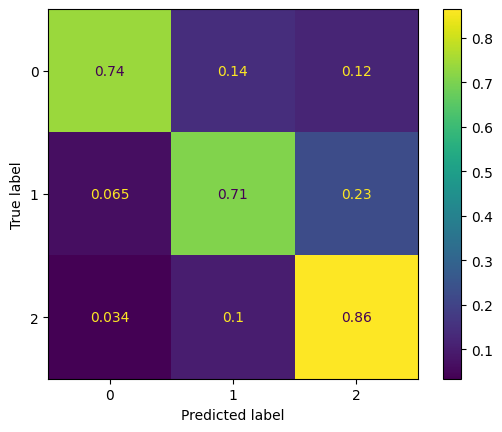

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.60329. Saving Model!
epoch 01, loss: 0.61576, acc: 0.73770, val_loss: 0.60329, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 02, loss: 0.61762, acc: 0.73772, val_loss: 0.60830, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 03, loss: 0.61778, acc: 0.73818, val_loss: 0.60964, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 04, loss: 0.61342, acc: 0.73868, val_loss: 0.61250, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 05, loss: 0.61331, acc: 0.73929, val_loss: 0.61447, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 06, loss: 0.61232, acc: 0.74058, val_loss: 0.61662, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 07, loss: 0.61151, acc: 0.74254, val_loss: 0.61899, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 08, loss: 0.61186, acc: 0.74261, val_loss: 0.61969, val_accuracy: 0.73218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 09, loss: 0.61063, acc: 0.74298, val_loss: 0.62033, val_accuracy: 0.73336


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 10, loss: 0.61009, acc: 0.74162, val_loss: 0.62147, val_accuracy: 0.73238


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 11, loss: 0.60964, acc: 0.74066, val_loss: 0.62245, val_accuracy: 0.73297


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 12, loss: 0.60930, acc: 0.74090, val_loss: 0.62362, val_accuracy: 0.73218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 13, loss: 0.60850, acc: 0.74110, val_loss: 0.62458, val_accuracy: 0.73199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 14, loss: 0.60838, acc: 0.74213, val_loss: 0.62523, val_accuracy: 0.73199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 15, loss: 0.60774, acc: 0.74199, val_loss: 0.62612, val_accuracy: 0.73140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 16, loss: 0.60726, acc: 0.74215, val_loss: 0.62709, val_accuracy: 0.73100


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 17, loss: 0.60696, acc: 0.74219, val_loss: 0.62789, val_accuracy: 0.73140


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 18, loss: 0.60653, acc: 0.74197, val_loss: 0.62901, val_accuracy: 0.73061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 19, loss: 0.60628, acc: 0.74197, val_loss: 0.62965, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 20, loss: 0.60583, acc: 0.74204, val_loss: 0.63049, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 21, loss: 0.60573, acc: 0.74215, val_loss: 0.63101, val_accuracy: 0.72668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 22, loss: 0.60491, acc: 0.74232, val_loss: 0.63150, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 23, loss: 0.60484, acc: 0.74243, val_loss: 0.63213, val_accuracy: 0.72727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 24, loss: 0.60471, acc: 0.74232, val_loss: 0.63287, val_accuracy: 0.72688


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 25, loss: 0.60368, acc: 0.74258, val_loss: 0.63361, val_accuracy: 0.72668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 26, loss: 0.60405, acc: 0.74254, val_loss: 0.63393, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 27, loss: 0.60346, acc: 0.74250, val_loss: 0.63470, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 28, loss: 0.60295, acc: 0.74269, val_loss: 0.63517, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 29, loss: 0.60304, acc: 0.74256, val_loss: 0.63558, val_accuracy: 0.72590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 30, loss: 0.60256, acc: 0.74315, val_loss: 0.63625, val_accuracy: 0.72452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 31, loss: 0.60209, acc: 0.74328, val_loss: 0.63679, val_accuracy: 0.72452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 32, loss: 0.60211, acc: 0.74319, val_loss: 0.63729, val_accuracy: 0.72413


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 33, loss: 0.60154, acc: 0.74333, val_loss: 0.63788, val_accuracy: 0.72040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 34, loss: 0.60168, acc: 0.74322, val_loss: 0.63810, val_accuracy: 0.72177


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 35, loss: 0.60090, acc: 0.74350, val_loss: 0.63909, val_accuracy: 0.72060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 36, loss: 0.60080, acc: 0.74374, val_loss: 0.63955, val_accuracy: 0.72079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 37, loss: 0.60078, acc: 0.74361, val_loss: 0.63978, val_accuracy: 0.72020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 38, loss: 0.60014, acc: 0.74385, val_loss: 0.64052, val_accuracy: 0.72060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 39, loss: 0.59984, acc: 0.74409, val_loss: 0.64091, val_accuracy: 0.72040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 40, loss: 0.59983, acc: 0.74405, val_loss: 0.64129, val_accuracy: 0.71922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 41, loss: 0.59909, acc: 0.74446, val_loss: 0.64184, val_accuracy: 0.71804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


epoch 42, loss: 0.59934, acc: 0.74544, val_loss: 0.64218, val_accuracy: 0.71804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 43, loss: 0.59879, acc: 0.74466, val_loss: 0.64281, val_accuracy: 0.71804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 44, loss: 0.59861, acc: 0.74472, val_loss: 0.64288, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 45, loss: 0.59838, acc: 0.74505, val_loss: 0.64317, val_accuracy: 0.71903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 46, loss: 0.59817, acc: 0.74490, val_loss: 0.64366, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 47, loss: 0.59766, acc: 0.74614, val_loss: 0.64421, val_accuracy: 0.71746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 48, loss: 0.59780, acc: 0.74605, val_loss: 0.64414, val_accuracy: 0.71765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 49, loss: 0.59708, acc: 0.74616, val_loss: 0.64461, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 50, loss: 0.59697, acc: 0.74531, val_loss: 0.64510, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 51, loss: 0.59682, acc: 0.74634, val_loss: 0.64559, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 52, loss: 0.59653, acc: 0.74631, val_loss: 0.64566, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 53, loss: 0.59629, acc: 0.74634, val_loss: 0.64596, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 54, loss: 0.59571, acc: 0.74673, val_loss: 0.64649, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 55, loss: 0.59579, acc: 0.74664, val_loss: 0.64673, val_accuracy: 0.71922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 56, loss: 0.59555, acc: 0.74679, val_loss: 0.64719, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 57, loss: 0.59533, acc: 0.74655, val_loss: 0.64719, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 58, loss: 0.59482, acc: 0.74692, val_loss: 0.64740, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 59, loss: 0.59479, acc: 0.74708, val_loss: 0.64781, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 60, loss: 0.59453, acc: 0.74708, val_loss: 0.64830, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 61, loss: 0.59453, acc: 0.74719, val_loss: 0.64870, val_accuracy: 0.71746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 62, loss: 0.59368, acc: 0.74754, val_loss: 0.64894, val_accuracy: 0.71746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 63, loss: 0.59407, acc: 0.74743, val_loss: 0.64887, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 64, loss: 0.59331, acc: 0.74791, val_loss: 0.64962, val_accuracy: 0.71746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 65, loss: 0.59346, acc: 0.74769, val_loss: 0.64963, val_accuracy: 0.71804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 66, loss: 0.59303, acc: 0.74782, val_loss: 0.64993, val_accuracy: 0.71804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 67, loss: 0.59281, acc: 0.74799, val_loss: 0.65004, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 68, loss: 0.59244, acc: 0.74791, val_loss: 0.65053, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 69, loss: 0.59249, acc: 0.74780, val_loss: 0.65067, val_accuracy: 0.71726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 70, loss: 0.59205, acc: 0.74804, val_loss: 0.65075, val_accuracy: 0.71706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 71, loss: 0.59183, acc: 0.74815, val_loss: 0.65093, val_accuracy: 0.71765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 72, loss: 0.59155, acc: 0.74847, val_loss: 0.65150, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.13it/s]


epoch 73, loss: 0.59155, acc: 0.74839, val_loss: 0.65158, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 74, loss: 0.59100, acc: 0.74849, val_loss: 0.65175, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 75, loss: 0.59094, acc: 0.74863, val_loss: 0.65213, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 76, loss: 0.59078, acc: 0.74860, val_loss: 0.65251, val_accuracy: 0.71804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 77, loss: 0.59061, acc: 0.74880, val_loss: 0.65261, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 78, loss: 0.59026, acc: 0.74897, val_loss: 0.65291, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 79, loss: 0.59008, acc: 0.74921, val_loss: 0.65307, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 80, loss: 0.58990, acc: 0.74908, val_loss: 0.65329, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 81, loss: 0.58945, acc: 0.74974, val_loss: 0.65351, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 82, loss: 0.58933, acc: 0.74911, val_loss: 0.65397, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 83, loss: 0.58922, acc: 0.74991, val_loss: 0.65388, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 84, loss: 0.58869, acc: 0.75013, val_loss: 0.65427, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 85, loss: 0.58867, acc: 0.75028, val_loss: 0.65431, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 86, loss: 0.58845, acc: 0.75068, val_loss: 0.65476, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 87, loss: 0.58820, acc: 0.75028, val_loss: 0.65478, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 88, loss: 0.58785, acc: 0.75044, val_loss: 0.65514, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 89, loss: 0.58771, acc: 0.75057, val_loss: 0.65542, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 90, loss: 0.58756, acc: 0.75061, val_loss: 0.65542, val_accuracy: 0.71765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.39it/s]


epoch 91, loss: 0.58711, acc: 0.75089, val_loss: 0.65557, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 92, loss: 0.58717, acc: 0.75120, val_loss: 0.65613, val_accuracy: 0.71962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 93, loss: 0.58652, acc: 0.75137, val_loss: 0.65652, val_accuracy: 0.71903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 94, loss: 0.58676, acc: 0.75109, val_loss: 0.65666, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 95, loss: 0.58616, acc: 0.75183, val_loss: 0.65727, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 96, loss: 0.58642, acc: 0.75181, val_loss: 0.65676, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 97, loss: 0.58578, acc: 0.75183, val_loss: 0.65740, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 98, loss: 0.58583, acc: 0.75168, val_loss: 0.65762, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 99, loss: 0.58514, acc: 0.75233, val_loss: 0.65802, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 100, loss: 0.58530, acc: 0.75253, val_loss: 0.65810, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 101, loss: 0.58507, acc: 0.75262, val_loss: 0.65883, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 102, loss: 0.58469, acc: 0.75255, val_loss: 0.65893, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 103, loss: 0.58473, acc: 0.75209, val_loss: 0.65883, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 104, loss: 0.58401, acc: 0.75268, val_loss: 0.65970, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 105, loss: 0.58448, acc: 0.75303, val_loss: 0.65945, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 106, loss: 0.58353, acc: 0.75301, val_loss: 0.66013, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 107, loss: 0.58392, acc: 0.75249, val_loss: 0.66017, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 108, loss: 0.58326, acc: 0.75312, val_loss: 0.66043, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 109, loss: 0.58320, acc: 0.75275, val_loss: 0.66064, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 110, loss: 0.58286, acc: 0.75294, val_loss: 0.66109, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 111, loss: 0.58285, acc: 0.75286, val_loss: 0.66106, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 112, loss: 0.58246, acc: 0.75314, val_loss: 0.66138, val_accuracy: 0.71922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 113, loss: 0.58240, acc: 0.75338, val_loss: 0.66168, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 114, loss: 0.58203, acc: 0.75340, val_loss: 0.66163, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 115, loss: 0.58184, acc: 0.75360, val_loss: 0.66204, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 116, loss: 0.58159, acc: 0.75452, val_loss: 0.66245, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 117, loss: 0.58157, acc: 0.75340, val_loss: 0.66275, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 118, loss: 0.58101, acc: 0.75491, val_loss: 0.66314, val_accuracy: 0.71687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 119, loss: 0.58135, acc: 0.75421, val_loss: 0.66269, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 120, loss: 0.58030, acc: 0.75386, val_loss: 0.66367, val_accuracy: 0.71804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 121, loss: 0.58081, acc: 0.75390, val_loss: 0.66382, val_accuracy: 0.71746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 122, loss: 0.58042, acc: 0.75369, val_loss: 0.66352, val_accuracy: 0.71765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 123, loss: 0.57981, acc: 0.75497, val_loss: 0.66430, val_accuracy: 0.71804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 124, loss: 0.58036, acc: 0.75388, val_loss: 0.66425, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 125, loss: 0.57960, acc: 0.75399, val_loss: 0.66456, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 126, loss: 0.57961, acc: 0.75404, val_loss: 0.66466, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 127, loss: 0.57917, acc: 0.75471, val_loss: 0.66528, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 128, loss: 0.57917, acc: 0.75414, val_loss: 0.66494, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 129, loss: 0.57902, acc: 0.75454, val_loss: 0.66560, val_accuracy: 0.71903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.92it/s]


epoch 130, loss: 0.57858, acc: 0.75432, val_loss: 0.66554, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 131, loss: 0.57863, acc: 0.75447, val_loss: 0.66577, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 132, loss: 0.57811, acc: 0.75508, val_loss: 0.66622, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 133, loss: 0.57816, acc: 0.75519, val_loss: 0.66610, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 134, loss: 0.57762, acc: 0.75484, val_loss: 0.66660, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 135, loss: 0.57789, acc: 0.75506, val_loss: 0.66676, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 136, loss: 0.57718, acc: 0.75563, val_loss: 0.66708, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 137, loss: 0.57756, acc: 0.75548, val_loss: 0.66680, val_accuracy: 0.71962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 138, loss: 0.57689, acc: 0.75537, val_loss: 0.66727, val_accuracy: 0.71942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 139, loss: 0.57676, acc: 0.75585, val_loss: 0.66747, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 140, loss: 0.57673, acc: 0.75572, val_loss: 0.66753, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 141, loss: 0.57645, acc: 0.75615, val_loss: 0.66777, val_accuracy: 0.71922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 142, loss: 0.57604, acc: 0.75670, val_loss: 0.66804, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 143, loss: 0.57624, acc: 0.75696, val_loss: 0.66815, val_accuracy: 0.71922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 144, loss: 0.57555, acc: 0.75755, val_loss: 0.66895, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 145, loss: 0.57557, acc: 0.75698, val_loss: 0.66865, val_accuracy: 0.71922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 146, loss: 0.57556, acc: 0.75761, val_loss: 0.66867, val_accuracy: 0.71981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 147, loss: 0.57496, acc: 0.75766, val_loss: 0.66873, val_accuracy: 0.70842


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 148, loss: 0.57518, acc: 0.75766, val_loss: 0.66935, val_accuracy: 0.70744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 149, loss: 0.57456, acc: 0.75772, val_loss: 0.66953, val_accuracy: 0.70764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 150, loss: 0.57494, acc: 0.75768, val_loss: 0.66938, val_accuracy: 0.70725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 151, loss: 0.57404, acc: 0.75798, val_loss: 0.66981, val_accuracy: 0.70705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 152, loss: 0.57420, acc: 0.75748, val_loss: 0.66957, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 153, loss: 0.57390, acc: 0.75792, val_loss: 0.67077, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 154, loss: 0.57362, acc: 0.75798, val_loss: 0.67058, val_accuracy: 0.70764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 155, loss: 0.57369, acc: 0.75796, val_loss: 0.67045, val_accuracy: 0.70764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 156, loss: 0.57333, acc: 0.75822, val_loss: 0.67078, val_accuracy: 0.70842


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 157, loss: 0.57307, acc: 0.75829, val_loss: 0.67087, val_accuracy: 0.70842


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 158, loss: 0.57269, acc: 0.75855, val_loss: 0.67094, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 159, loss: 0.57291, acc: 0.75801, val_loss: 0.67127, val_accuracy: 0.70764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 160, loss: 0.57255, acc: 0.75814, val_loss: 0.67129, val_accuracy: 0.70862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 161, loss: 0.57221, acc: 0.75859, val_loss: 0.67154, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 162, loss: 0.57213, acc: 0.75857, val_loss: 0.67187, val_accuracy: 0.70764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 163, loss: 0.57208, acc: 0.75849, val_loss: 0.67209, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 164, loss: 0.57159, acc: 0.75877, val_loss: 0.67211, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 165, loss: 0.57123, acc: 0.75881, val_loss: 0.67284, val_accuracy: 0.70803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 166, loss: 0.57158, acc: 0.75892, val_loss: 0.67236, val_accuracy: 0.70882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 167, loss: 0.57105, acc: 0.75890, val_loss: 0.67275, val_accuracy: 0.70842


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 168, loss: 0.57103, acc: 0.75883, val_loss: 0.67304, val_accuracy: 0.70803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 169, loss: 0.57065, acc: 0.75921, val_loss: 0.67365, val_accuracy: 0.70823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 170, loss: 0.57041, acc: 0.75929, val_loss: 0.67322, val_accuracy: 0.70803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 171, loss: 0.57038, acc: 0.75899, val_loss: 0.67321, val_accuracy: 0.70842


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s]


epoch 172, loss: 0.56998, acc: 0.75916, val_loss: 0.67344, val_accuracy: 0.70882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 173, loss: 0.56979, acc: 0.75945, val_loss: 0.67406, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 174, loss: 0.56984, acc: 0.75873, val_loss: 0.67404, val_accuracy: 0.70882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 175, loss: 0.56952, acc: 0.75942, val_loss: 0.67423, val_accuracy: 0.70862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 176, loss: 0.56931, acc: 0.75949, val_loss: 0.67419, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 177, loss: 0.56898, acc: 0.75918, val_loss: 0.67462, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 178, loss: 0.56900, acc: 0.75923, val_loss: 0.67482, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 179, loss: 0.56884, acc: 0.75990, val_loss: 0.67487, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 180, loss: 0.56845, acc: 0.75934, val_loss: 0.67485, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 181, loss: 0.56817, acc: 0.75934, val_loss: 0.67496, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 182, loss: 0.56817, acc: 0.75929, val_loss: 0.67530, val_accuracy: 0.70980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 183, loss: 0.56786, acc: 0.76078, val_loss: 0.67597, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 184, loss: 0.56789, acc: 0.76126, val_loss: 0.67567, val_accuracy: 0.70980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 185, loss: 0.56725, acc: 0.76067, val_loss: 0.67628, val_accuracy: 0.70980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 186, loss: 0.56767, acc: 0.76036, val_loss: 0.67563, val_accuracy: 0.71078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 187, loss: 0.56671, acc: 0.76049, val_loss: 0.67662, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 188, loss: 0.56697, acc: 0.76086, val_loss: 0.67651, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 189, loss: 0.56692, acc: 0.76093, val_loss: 0.67577, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 190, loss: 0.56609, acc: 0.76102, val_loss: 0.67663, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 191, loss: 0.56649, acc: 0.76104, val_loss: 0.67687, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 192, loss: 0.56595, acc: 0.76110, val_loss: 0.67683, val_accuracy: 0.71078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 193, loss: 0.56598, acc: 0.76134, val_loss: 0.67679, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 194, loss: 0.56568, acc: 0.76121, val_loss: 0.67731, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 195, loss: 0.56538, acc: 0.76152, val_loss: 0.67779, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 196, loss: 0.56556, acc: 0.76228, val_loss: 0.67761, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 197, loss: 0.56505, acc: 0.76158, val_loss: 0.67785, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 198, loss: 0.56479, acc: 0.76174, val_loss: 0.67743, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 199, loss: 0.56471, acc: 0.76200, val_loss: 0.67783, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 200, loss: 0.56463, acc: 0.76379, val_loss: 0.67861, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 201, loss: 0.56447, acc: 0.76267, val_loss: 0.67788, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 202, loss: 0.56381, acc: 0.76224, val_loss: 0.67893, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 203, loss: 0.56426, acc: 0.76374, val_loss: 0.67881, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 204, loss: 0.56316, acc: 0.76400, val_loss: 0.67934, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 205, loss: 0.56381, acc: 0.76315, val_loss: 0.67910, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 206, loss: 0.56306, acc: 0.76318, val_loss: 0.67931, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 207, loss: 0.56322, acc: 0.76387, val_loss: 0.67976, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 208, loss: 0.56274, acc: 0.76403, val_loss: 0.67971, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 209, loss: 0.56253, acc: 0.76342, val_loss: 0.67975, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 210, loss: 0.56241, acc: 0.76278, val_loss: 0.68006, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 211, loss: 0.56237, acc: 0.76427, val_loss: 0.68025, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 212, loss: 0.56202, acc: 0.76433, val_loss: 0.68013, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 213, loss: 0.56178, acc: 0.76355, val_loss: 0.68089, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 214, loss: 0.56167, acc: 0.76475, val_loss: 0.68050, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 215, loss: 0.56126, acc: 0.76429, val_loss: 0.68100, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 216, loss: 0.56119, acc: 0.76396, val_loss: 0.68088, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 217, loss: 0.56068, acc: 0.76400, val_loss: 0.68163, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 218, loss: 0.56122, acc: 0.76453, val_loss: 0.68128, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 219, loss: 0.56026, acc: 0.76483, val_loss: 0.68169, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 220, loss: 0.56052, acc: 0.76475, val_loss: 0.68125, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 221, loss: 0.56001, acc: 0.76344, val_loss: 0.68214, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 222, loss: 0.56023, acc: 0.76494, val_loss: 0.68262, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 223, loss: 0.55920, acc: 0.76509, val_loss: 0.68266, val_accuracy: 0.71215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 224, loss: 0.55999, acc: 0.76411, val_loss: 0.68221, val_accuracy: 0.71215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 225, loss: 0.55916, acc: 0.76492, val_loss: 0.68276, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


epoch 226, loss: 0.55922, acc: 0.76538, val_loss: 0.68329, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 227, loss: 0.55895, acc: 0.76549, val_loss: 0.68266, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 228, loss: 0.55873, acc: 0.76435, val_loss: 0.68334, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 229, loss: 0.55832, acc: 0.76577, val_loss: 0.68443, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 230, loss: 0.55904, acc: 0.76549, val_loss: 0.68311, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 231, loss: 0.55772, acc: 0.76501, val_loss: 0.68354, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 232, loss: 0.55808, acc: 0.76523, val_loss: 0.68430, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 233, loss: 0.55773, acc: 0.76616, val_loss: 0.68459, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 234, loss: 0.55765, acc: 0.76560, val_loss: 0.68389, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 235, loss: 0.55707, acc: 0.76562, val_loss: 0.68489, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 236, loss: 0.55728, acc: 0.76503, val_loss: 0.68469, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 237, loss: 0.55686, acc: 0.76568, val_loss: 0.68470, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 238, loss: 0.55664, acc: 0.76621, val_loss: 0.68519, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 239, loss: 0.55648, acc: 0.76612, val_loss: 0.68482, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 240, loss: 0.55632, acc: 0.76597, val_loss: 0.68514, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 241, loss: 0.55610, acc: 0.76603, val_loss: 0.68613, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 242, loss: 0.55591, acc: 0.76625, val_loss: 0.68551, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 243, loss: 0.55560, acc: 0.76614, val_loss: 0.68619, val_accuracy: 0.71215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 244, loss: 0.55562, acc: 0.76623, val_loss: 0.68608, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 245, loss: 0.55542, acc: 0.76614, val_loss: 0.68661, val_accuracy: 0.71255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 246, loss: 0.55493, acc: 0.76653, val_loss: 0.68616, val_accuracy: 0.71255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 247, loss: 0.55502, acc: 0.76647, val_loss: 0.68678, val_accuracy: 0.71255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 248, loss: 0.55470, acc: 0.76638, val_loss: 0.68649, val_accuracy: 0.71314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 249, loss: 0.55459, acc: 0.76647, val_loss: 0.68701, val_accuracy: 0.71274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 250, loss: 0.55402, acc: 0.76662, val_loss: 0.68716, val_accuracy: 0.71274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 251, loss: 0.55454, acc: 0.76656, val_loss: 0.68709, val_accuracy: 0.71294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 252, loss: 0.55329, acc: 0.76708, val_loss: 0.68783, val_accuracy: 0.71372


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 253, loss: 0.55447, acc: 0.76649, val_loss: 0.68767, val_accuracy: 0.71274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 254, loss: 0.55310, acc: 0.76721, val_loss: 0.68807, val_accuracy: 0.71274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 255, loss: 0.55338, acc: 0.76706, val_loss: 0.68754, val_accuracy: 0.71294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 256, loss: 0.55302, acc: 0.76706, val_loss: 0.68847, val_accuracy: 0.71333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 257, loss: 0.55305, acc: 0.76688, val_loss: 0.68855, val_accuracy: 0.71294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 258, loss: 0.55270, acc: 0.76747, val_loss: 0.68812, val_accuracy: 0.71314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 259, loss: 0.55257, acc: 0.76708, val_loss: 0.68893, val_accuracy: 0.71353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 260, loss: 0.55228, acc: 0.76752, val_loss: 0.68865, val_accuracy: 0.71333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 261, loss: 0.55247, acc: 0.76752, val_loss: 0.68888, val_accuracy: 0.71314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 262, loss: 0.55187, acc: 0.76758, val_loss: 0.68930, val_accuracy: 0.71314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 263, loss: 0.55150, acc: 0.76765, val_loss: 0.68876, val_accuracy: 0.71412


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 264, loss: 0.55154, acc: 0.76800, val_loss: 0.68948, val_accuracy: 0.71392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 265, loss: 0.55143, acc: 0.76802, val_loss: 0.68994, val_accuracy: 0.71353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 266, loss: 0.55115, acc: 0.76813, val_loss: 0.68994, val_accuracy: 0.71353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 267, loss: 0.55104, acc: 0.76802, val_loss: 0.68959, val_accuracy: 0.71431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 268, loss: 0.55040, acc: 0.76850, val_loss: 0.69014, val_accuracy: 0.71412


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 269, loss: 0.55090, acc: 0.76858, val_loss: 0.68981, val_accuracy: 0.71372


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 270, loss: 0.54990, acc: 0.76845, val_loss: 0.69039, val_accuracy: 0.71431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 271, loss: 0.55066, acc: 0.76817, val_loss: 0.68983, val_accuracy: 0.71392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 272, loss: 0.54958, acc: 0.76861, val_loss: 0.69040, val_accuracy: 0.71471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 273, loss: 0.55015, acc: 0.76830, val_loss: 0.69103, val_accuracy: 0.71412


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 274, loss: 0.54932, acc: 0.76909, val_loss: 0.69092, val_accuracy: 0.71451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 275, loss: 0.54951, acc: 0.76815, val_loss: 0.69061, val_accuracy: 0.71451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 276, loss: 0.54864, acc: 0.76843, val_loss: 0.69170, val_accuracy: 0.71490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 277, loss: 0.54941, acc: 0.76867, val_loss: 0.69178, val_accuracy: 0.71451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 278, loss: 0.54868, acc: 0.76850, val_loss: 0.69101, val_accuracy: 0.71510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 279, loss: 0.54845, acc: 0.76889, val_loss: 0.69190, val_accuracy: 0.71530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 280, loss: 0.54821, acc: 0.76887, val_loss: 0.69151, val_accuracy: 0.71471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 281, loss: 0.54848, acc: 0.76854, val_loss: 0.69135, val_accuracy: 0.71451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 282, loss: 0.54773, acc: 0.76896, val_loss: 0.69235, val_accuracy: 0.71510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 283, loss: 0.54790, acc: 0.76867, val_loss: 0.69255, val_accuracy: 0.71530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 284, loss: 0.54756, acc: 0.76911, val_loss: 0.69236, val_accuracy: 0.71510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 285, loss: 0.54738, acc: 0.76896, val_loss: 0.69311, val_accuracy: 0.71530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 286, loss: 0.54715, acc: 0.76928, val_loss: 0.69205, val_accuracy: 0.71549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 287, loss: 0.54689, acc: 0.76920, val_loss: 0.69356, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 288, loss: 0.54695, acc: 0.76939, val_loss: 0.69280, val_accuracy: 0.71608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 289, loss: 0.54662, acc: 0.77042, val_loss: 0.69312, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 290, loss: 0.54630, acc: 0.77057, val_loss: 0.69326, val_accuracy: 0.71608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 291, loss: 0.54616, acc: 0.77046, val_loss: 0.69317, val_accuracy: 0.71687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 292, loss: 0.54602, acc: 0.76963, val_loss: 0.69372, val_accuracy: 0.71667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 293, loss: 0.54586, acc: 0.77168, val_loss: 0.69402, val_accuracy: 0.71687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 294, loss: 0.54545, acc: 0.77083, val_loss: 0.69342, val_accuracy: 0.71647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 295, loss: 0.54568, acc: 0.77229, val_loss: 0.69356, val_accuracy: 0.71647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 296, loss: 0.54446, acc: 0.77166, val_loss: 0.69499, val_accuracy: 0.71687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 297, loss: 0.54597, acc: 0.77238, val_loss: 0.69323, val_accuracy: 0.71687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 298, loss: 0.54375, acc: 0.77225, val_loss: 0.69541, val_accuracy: 0.71687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 299, loss: 0.54569, acc: 0.77183, val_loss: 0.69434, val_accuracy: 0.71647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 300, loss: 0.54317, acc: 0.77338, val_loss: 0.69539, val_accuracy: 0.70823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 301, loss: 0.54575, acc: 0.77064, val_loss: 0.69357, val_accuracy: 0.71628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 302, loss: 0.54282, acc: 0.77375, val_loss: 0.69578, val_accuracy: 0.70882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 303, loss: 0.54472, acc: 0.77170, val_loss: 0.69425, val_accuracy: 0.71687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 304, loss: 0.54255, acc: 0.77343, val_loss: 0.69582, val_accuracy: 0.70882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 305, loss: 0.54435, acc: 0.77116, val_loss: 0.69498, val_accuracy: 0.70803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 306, loss: 0.54211, acc: 0.77384, val_loss: 0.69662, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 307, loss: 0.54383, acc: 0.77249, val_loss: 0.69559, val_accuracy: 0.70862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 308, loss: 0.54203, acc: 0.77421, val_loss: 0.69626, val_accuracy: 0.70842


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 309, loss: 0.54318, acc: 0.77279, val_loss: 0.69663, val_accuracy: 0.70823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 310, loss: 0.54167, acc: 0.77456, val_loss: 0.69702, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 311, loss: 0.54301, acc: 0.77266, val_loss: 0.69573, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


epoch 312, loss: 0.54102, acc: 0.77467, val_loss: 0.69787, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 313, loss: 0.54259, acc: 0.77308, val_loss: 0.69659, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 314, loss: 0.54072, acc: 0.77389, val_loss: 0.69788, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 315, loss: 0.54228, acc: 0.77321, val_loss: 0.69681, val_accuracy: 0.70862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 316, loss: 0.54022, acc: 0.77500, val_loss: 0.69859, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 317, loss: 0.54223, acc: 0.77317, val_loss: 0.69750, val_accuracy: 0.70882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 318, loss: 0.53952, acc: 0.77554, val_loss: 0.69888, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 319, loss: 0.54210, acc: 0.77338, val_loss: 0.69699, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 320, loss: 0.53887, acc: 0.77546, val_loss: 0.69934, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 321, loss: 0.54206, acc: 0.77236, val_loss: 0.69710, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 322, loss: 0.53820, acc: 0.77633, val_loss: 0.69995, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 323, loss: 0.54139, acc: 0.77404, val_loss: 0.69721, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 324, loss: 0.53801, acc: 0.77613, val_loss: 0.70057, val_accuracy: 0.70999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 325, loss: 0.54096, acc: 0.77426, val_loss: 0.69813, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 326, loss: 0.53753, acc: 0.77622, val_loss: 0.70065, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 327, loss: 0.54043, acc: 0.77341, val_loss: 0.69833, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 328, loss: 0.53714, acc: 0.77707, val_loss: 0.70044, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 329, loss: 0.53958, acc: 0.77452, val_loss: 0.69983, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 330, loss: 0.53758, acc: 0.77626, val_loss: 0.70030, val_accuracy: 0.70999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s]


epoch 331, loss: 0.53898, acc: 0.77478, val_loss: 0.69943, val_accuracy: 0.70980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 332, loss: 0.53670, acc: 0.77683, val_loss: 0.70143, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 333, loss: 0.53907, acc: 0.77480, val_loss: 0.69970, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 334, loss: 0.53622, acc: 0.77687, val_loss: 0.70117, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 335, loss: 0.53829, acc: 0.77561, val_loss: 0.69981, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 336, loss: 0.53606, acc: 0.77714, val_loss: 0.70224, val_accuracy: 0.70980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 337, loss: 0.53820, acc: 0.77548, val_loss: 0.70043, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 338, loss: 0.53508, acc: 0.77762, val_loss: 0.70261, val_accuracy: 0.70980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


epoch 339, loss: 0.53830, acc: 0.77546, val_loss: 0.70026, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 340, loss: 0.53459, acc: 0.77716, val_loss: 0.70341, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 341, loss: 0.53789, acc: 0.77580, val_loss: 0.70043, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 342, loss: 0.53424, acc: 0.77740, val_loss: 0.70285, val_accuracy: 0.71019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 343, loss: 0.53767, acc: 0.77570, val_loss: 0.70068, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 344, loss: 0.53341, acc: 0.77818, val_loss: 0.70341, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 345, loss: 0.53748, acc: 0.77548, val_loss: 0.70102, val_accuracy: 0.70980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 346, loss: 0.53327, acc: 0.77810, val_loss: 0.70454, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 347, loss: 0.53671, acc: 0.77598, val_loss: 0.70077, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 348, loss: 0.53280, acc: 0.77829, val_loss: 0.70404, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 349, loss: 0.53607, acc: 0.77631, val_loss: 0.70136, val_accuracy: 0.70999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 350, loss: 0.53290, acc: 0.77849, val_loss: 0.70367, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 351, loss: 0.53506, acc: 0.77624, val_loss: 0.70238, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 352, loss: 0.53307, acc: 0.77844, val_loss: 0.70301, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 353, loss: 0.53430, acc: 0.77692, val_loss: 0.70276, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 354, loss: 0.53269, acc: 0.77879, val_loss: 0.70473, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 355, loss: 0.53396, acc: 0.77851, val_loss: 0.70277, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 356, loss: 0.53199, acc: 0.77884, val_loss: 0.70377, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 357, loss: 0.53380, acc: 0.77794, val_loss: 0.70275, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 358, loss: 0.53142, acc: 0.77895, val_loss: 0.70510, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 359, loss: 0.53338, acc: 0.77936, val_loss: 0.70279, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 360, loss: 0.53161, acc: 0.78034, val_loss: 0.70477, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 361, loss: 0.53246, acc: 0.78045, val_loss: 0.70390, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 362, loss: 0.53119, acc: 0.78034, val_loss: 0.70434, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 363, loss: 0.53266, acc: 0.77912, val_loss: 0.70352, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 364, loss: 0.53013, acc: 0.78102, val_loss: 0.70557, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 365, loss: 0.53253, acc: 0.77919, val_loss: 0.70353, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 366, loss: 0.52981, acc: 0.78119, val_loss: 0.70599, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 367, loss: 0.53194, acc: 0.77967, val_loss: 0.70402, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 368, loss: 0.52951, acc: 0.78121, val_loss: 0.70577, val_accuracy: 0.70999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 369, loss: 0.53163, acc: 0.78047, val_loss: 0.70435, val_accuracy: 0.71255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 370, loss: 0.52887, acc: 0.78265, val_loss: 0.70639, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 371, loss: 0.53216, acc: 0.77947, val_loss: 0.70490, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 372, loss: 0.52777, acc: 0.78322, val_loss: 0.70728, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 373, loss: 0.53192, acc: 0.78089, val_loss: 0.70379, val_accuracy: 0.71215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 374, loss: 0.52773, acc: 0.78261, val_loss: 0.70718, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 375, loss: 0.53126, acc: 0.78065, val_loss: 0.70412, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 376, loss: 0.52691, acc: 0.78313, val_loss: 0.70799, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 377, loss: 0.53147, acc: 0.78078, val_loss: 0.70352, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 378, loss: 0.52643, acc: 0.78311, val_loss: 0.70832, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 379, loss: 0.53062, acc: 0.78089, val_loss: 0.70527, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 380, loss: 0.52658, acc: 0.78296, val_loss: 0.70785, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 381, loss: 0.53005, acc: 0.78119, val_loss: 0.70507, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 382, loss: 0.52597, acc: 0.78335, val_loss: 0.70876, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 383, loss: 0.53015, acc: 0.78119, val_loss: 0.70554, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 384, loss: 0.52527, acc: 0.78340, val_loss: 0.70826, val_accuracy: 0.71078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.15it/s]


epoch 385, loss: 0.52968, acc: 0.78102, val_loss: 0.70539, val_accuracy: 0.71215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 386, loss: 0.52509, acc: 0.78342, val_loss: 0.70821, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 387, loss: 0.52889, acc: 0.78163, val_loss: 0.70625, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 388, loss: 0.52493, acc: 0.78337, val_loss: 0.70887, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 389, loss: 0.52860, acc: 0.78156, val_loss: 0.70658, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 390, loss: 0.52423, acc: 0.78396, val_loss: 0.70987, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 391, loss: 0.52822, acc: 0.78176, val_loss: 0.70617, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 392, loss: 0.52400, acc: 0.78560, val_loss: 0.71062, val_accuracy: 0.70391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 393, loss: 0.52788, acc: 0.78237, val_loss: 0.70594, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 394, loss: 0.52338, acc: 0.78545, val_loss: 0.71036, val_accuracy: 0.71215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 395, loss: 0.52762, acc: 0.78207, val_loss: 0.70670, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 396, loss: 0.52276, acc: 0.78538, val_loss: 0.71109, val_accuracy: 0.70430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


epoch 397, loss: 0.52725, acc: 0.78257, val_loss: 0.70667, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 398, loss: 0.52307, acc: 0.78545, val_loss: 0.71004, val_accuracy: 0.70430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 399, loss: 0.52622, acc: 0.78250, val_loss: 0.70739, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 400, loss: 0.52236, acc: 0.78523, val_loss: 0.70989, val_accuracy: 0.71294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 401, loss: 0.52620, acc: 0.78287, val_loss: 0.70861, val_accuracy: 0.70391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 402, loss: 0.52227, acc: 0.78510, val_loss: 0.71039, val_accuracy: 0.70430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 403, loss: 0.52570, acc: 0.78381, val_loss: 0.70859, val_accuracy: 0.71255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 404, loss: 0.52154, acc: 0.78654, val_loss: 0.71198, val_accuracy: 0.70450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 405, loss: 0.52600, acc: 0.78379, val_loss: 0.70819, val_accuracy: 0.71215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 406, loss: 0.52052, acc: 0.78658, val_loss: 0.71299, val_accuracy: 0.70391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 407, loss: 0.52624, acc: 0.78274, val_loss: 0.70745, val_accuracy: 0.71255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 408, loss: 0.51966, acc: 0.78669, val_loss: 0.71278, val_accuracy: 0.70430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 409, loss: 0.52590, acc: 0.78276, val_loss: 0.70881, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 410, loss: 0.51983, acc: 0.78684, val_loss: 0.71304, val_accuracy: 0.70469


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 411, loss: 0.52514, acc: 0.78405, val_loss: 0.70908, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 412, loss: 0.51919, acc: 0.78689, val_loss: 0.71439, val_accuracy: 0.70469


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 413, loss: 0.52484, acc: 0.78322, val_loss: 0.70916, val_accuracy: 0.71255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 414, loss: 0.51895, acc: 0.78682, val_loss: 0.71362, val_accuracy: 0.70567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 415, loss: 0.52430, acc: 0.78418, val_loss: 0.70902, val_accuracy: 0.71294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 416, loss: 0.51854, acc: 0.78721, val_loss: 0.71440, val_accuracy: 0.70528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 417, loss: 0.52372, acc: 0.78453, val_loss: 0.70996, val_accuracy: 0.70450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 418, loss: 0.51828, acc: 0.78704, val_loss: 0.71450, val_accuracy: 0.70528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 419, loss: 0.52313, acc: 0.78425, val_loss: 0.70962, val_accuracy: 0.71412


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 420, loss: 0.51840, acc: 0.78682, val_loss: 0.71488, val_accuracy: 0.70567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 421, loss: 0.52254, acc: 0.78492, val_loss: 0.71184, val_accuracy: 0.70391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 422, loss: 0.51759, acc: 0.78728, val_loss: 0.71437, val_accuracy: 0.70528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 423, loss: 0.52291, acc: 0.78438, val_loss: 0.71082, val_accuracy: 0.70528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 424, loss: 0.51710, acc: 0.78737, val_loss: 0.71547, val_accuracy: 0.70528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 425, loss: 0.52208, acc: 0.78468, val_loss: 0.71107, val_accuracy: 0.70450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 426, loss: 0.51676, acc: 0.78747, val_loss: 0.71524, val_accuracy: 0.70567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 427, loss: 0.52204, acc: 0.78477, val_loss: 0.71120, val_accuracy: 0.70489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 428, loss: 0.51613, acc: 0.78782, val_loss: 0.71593, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 429, loss: 0.52159, acc: 0.78514, val_loss: 0.71115, val_accuracy: 0.70450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 430, loss: 0.51585, acc: 0.78761, val_loss: 0.71599, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 431, loss: 0.52135, acc: 0.78516, val_loss: 0.71134, val_accuracy: 0.70489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 432, loss: 0.51538, acc: 0.78795, val_loss: 0.71667, val_accuracy: 0.69821


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 433, loss: 0.52074, acc: 0.78538, val_loss: 0.71172, val_accuracy: 0.70489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 434, loss: 0.51503, acc: 0.78815, val_loss: 0.71668, val_accuracy: 0.70469


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 435, loss: 0.52017, acc: 0.78549, val_loss: 0.71158, val_accuracy: 0.70450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 436, loss: 0.51489, acc: 0.78828, val_loss: 0.71726, val_accuracy: 0.69802


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 437, loss: 0.51955, acc: 0.78608, val_loss: 0.71256, val_accuracy: 0.70489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 438, loss: 0.51444, acc: 0.78867, val_loss: 0.71627, val_accuracy: 0.69978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 439, loss: 0.51943, acc: 0.78606, val_loss: 0.71361, val_accuracy: 0.70509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 440, loss: 0.51383, acc: 0.78902, val_loss: 0.71750, val_accuracy: 0.69939


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 441, loss: 0.51939, acc: 0.78634, val_loss: 0.71315, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 442, loss: 0.51373, acc: 0.78922, val_loss: 0.71739, val_accuracy: 0.69998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 443, loss: 0.51912, acc: 0.78601, val_loss: 0.71331, val_accuracy: 0.70528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 444, loss: 0.51287, acc: 0.78922, val_loss: 0.71848, val_accuracy: 0.69978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 445, loss: 0.51875, acc: 0.78658, val_loss: 0.71428, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 446, loss: 0.51261, acc: 0.78944, val_loss: 0.71815, val_accuracy: 0.70018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 447, loss: 0.51804, acc: 0.78667, val_loss: 0.71465, val_accuracy: 0.70548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 448, loss: 0.51240, acc: 0.78854, val_loss: 0.71894, val_accuracy: 0.69919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 449, loss: 0.51800, acc: 0.78682, val_loss: 0.71423, val_accuracy: 0.70567


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 450, loss: 0.51152, acc: 0.78987, val_loss: 0.71940, val_accuracy: 0.70018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 451, loss: 0.51782, acc: 0.78689, val_loss: 0.71329, val_accuracy: 0.70666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 452, loss: 0.51117, acc: 0.78972, val_loss: 0.71964, val_accuracy: 0.69978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 453, loss: 0.51687, acc: 0.78719, val_loss: 0.71507, val_accuracy: 0.69978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 454, loss: 0.51103, acc: 0.79007, val_loss: 0.71928, val_accuracy: 0.69959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


epoch 455, loss: 0.51688, acc: 0.78715, val_loss: 0.71381, val_accuracy: 0.69939


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 456, loss: 0.50990, acc: 0.79055, val_loss: 0.72102, val_accuracy: 0.70037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 457, loss: 0.51693, acc: 0.78719, val_loss: 0.71520, val_accuracy: 0.69919


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.18it/s]


epoch 458, loss: 0.51012, acc: 0.79029, val_loss: 0.72032, val_accuracy: 0.70018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 459, loss: 0.51618, acc: 0.78774, val_loss: 0.71535, val_accuracy: 0.70037


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 460, loss: 0.50979, acc: 0.79083, val_loss: 0.72075, val_accuracy: 0.70077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 461, loss: 0.51541, acc: 0.78767, val_loss: 0.71555, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 462, loss: 0.50970, acc: 0.79079, val_loss: 0.72100, val_accuracy: 0.70018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 463, loss: 0.51476, acc: 0.78822, val_loss: 0.71660, val_accuracy: 0.69959


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 464, loss: 0.50912, acc: 0.79094, val_loss: 0.72078, val_accuracy: 0.70018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 465, loss: 0.51424, acc: 0.78813, val_loss: 0.71637, val_accuracy: 0.69978


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 466, loss: 0.50873, acc: 0.79090, val_loss: 0.72177, val_accuracy: 0.69998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 467, loss: 0.51416, acc: 0.78761, val_loss: 0.71637, val_accuracy: 0.69900


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 468, loss: 0.50823, acc: 0.79099, val_loss: 0.72157, val_accuracy: 0.70018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 469, loss: 0.51371, acc: 0.78854, val_loss: 0.71799, val_accuracy: 0.69998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 470, loss: 0.50798, acc: 0.79171, val_loss: 0.72156, val_accuracy: 0.70018


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 471, loss: 0.51294, acc: 0.78826, val_loss: 0.71749, val_accuracy: 0.69998


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 472, loss: 0.50742, acc: 0.79138, val_loss: 0.72253, val_accuracy: 0.70096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 473, loss: 0.51295, acc: 0.78878, val_loss: 0.71757, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 474, loss: 0.50666, acc: 0.79138, val_loss: 0.72275, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 475, loss: 0.51258, acc: 0.78885, val_loss: 0.71733, val_accuracy: 0.70077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 476, loss: 0.50668, acc: 0.79175, val_loss: 0.72324, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 477, loss: 0.51209, acc: 0.78874, val_loss: 0.71949, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


epoch 478, loss: 0.50609, acc: 0.79208, val_loss: 0.72376, val_accuracy: 0.70096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 479, loss: 0.51207, acc: 0.78859, val_loss: 0.71856, val_accuracy: 0.70096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 480, loss: 0.50546, acc: 0.79203, val_loss: 0.72476, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 481, loss: 0.51158, acc: 0.78876, val_loss: 0.71845, val_accuracy: 0.70077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 482, loss: 0.50530, acc: 0.79282, val_loss: 0.72452, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 483, loss: 0.51093, acc: 0.79001, val_loss: 0.71896, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 484, loss: 0.50480, acc: 0.79328, val_loss: 0.72455, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 485, loss: 0.51113, acc: 0.79001, val_loss: 0.71901, val_accuracy: 0.70057


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 486, loss: 0.50424, acc: 0.79328, val_loss: 0.72524, val_accuracy: 0.70116


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 487, loss: 0.51072, acc: 0.78963, val_loss: 0.71956, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 488, loss: 0.50396, acc: 0.79326, val_loss: 0.72606, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 489, loss: 0.51029, acc: 0.79014, val_loss: 0.72012, val_accuracy: 0.70096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 490, loss: 0.50343, acc: 0.79356, val_loss: 0.72508, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 491, loss: 0.50966, acc: 0.79057, val_loss: 0.72030, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 492, loss: 0.50341, acc: 0.79330, val_loss: 0.72591, val_accuracy: 0.70194


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 493, loss: 0.50861, acc: 0.79033, val_loss: 0.71981, val_accuracy: 0.70096


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


epoch 494, loss: 0.50291, acc: 0.79369, val_loss: 0.72658, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 495, loss: 0.50855, acc: 0.79073, val_loss: 0.72074, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 496, loss: 0.50253, acc: 0.79393, val_loss: 0.72617, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 497, loss: 0.50792, acc: 0.79081, val_loss: 0.72206, val_accuracy: 0.70135


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 498, loss: 0.50236, acc: 0.79411, val_loss: 0.72570, val_accuracy: 0.70273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 499, loss: 0.50776, acc: 0.79066, val_loss: 0.72170, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 500, loss: 0.50170, acc: 0.79498, val_loss: 0.72656, val_accuracy: 0.70214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 501, loss: 0.50734, acc: 0.79114, val_loss: 0.72042, val_accuracy: 0.70155


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 502, loss: 0.50143, acc: 0.79452, val_loss: 0.72690, val_accuracy: 0.70371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 503, loss: 0.50670, acc: 0.79083, val_loss: 0.72249, val_accuracy: 0.70175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 504, loss: 0.50110, acc: 0.79408, val_loss: 0.72692, val_accuracy: 0.70273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 505, loss: 0.50634, acc: 0.79151, val_loss: 0.72249, val_accuracy: 0.70273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 506, loss: 0.50084, acc: 0.79422, val_loss: 0.72698, val_accuracy: 0.70253


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 507, loss: 0.50615, acc: 0.79188, val_loss: 0.72232, val_accuracy: 0.70214


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 508, loss: 0.50024, acc: 0.79550, val_loss: 0.72880, val_accuracy: 0.70391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 509, loss: 0.50578, acc: 0.79230, val_loss: 0.72270, val_accuracy: 0.70293


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 510, loss: 0.49980, acc: 0.79539, val_loss: 0.72740, val_accuracy: 0.70351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 511, loss: 0.50573, acc: 0.79144, val_loss: 0.72332, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 512, loss: 0.49911, acc: 0.79537, val_loss: 0.72907, val_accuracy: 0.70371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 513, loss: 0.50545, acc: 0.79162, val_loss: 0.72242, val_accuracy: 0.70332


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 514, loss: 0.49890, acc: 0.79570, val_loss: 0.72860, val_accuracy: 0.70391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 515, loss: 0.50461, acc: 0.79293, val_loss: 0.72317, val_accuracy: 0.70312


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 516, loss: 0.49862, acc: 0.79561, val_loss: 0.72805, val_accuracy: 0.70371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 517, loss: 0.50433, acc: 0.79240, val_loss: 0.72420, val_accuracy: 0.70391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 518, loss: 0.49841, acc: 0.79616, val_loss: 0.72904, val_accuracy: 0.70391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 519, loss: 0.50373, acc: 0.79306, val_loss: 0.72505, val_accuracy: 0.70371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 520, loss: 0.49803, acc: 0.79620, val_loss: 0.72910, val_accuracy: 0.70371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 521, loss: 0.50337, acc: 0.79203, val_loss: 0.72524, val_accuracy: 0.70351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 522, loss: 0.49801, acc: 0.79574, val_loss: 0.72959, val_accuracy: 0.70410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 523, loss: 0.50301, acc: 0.79336, val_loss: 0.72496, val_accuracy: 0.70351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 524, loss: 0.49687, acc: 0.79629, val_loss: 0.73046, val_accuracy: 0.70391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 525, loss: 0.50292, acc: 0.79302, val_loss: 0.72435, val_accuracy: 0.70391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 526, loss: 0.49655, acc: 0.79664, val_loss: 0.73089, val_accuracy: 0.70410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 527, loss: 0.50233, acc: 0.79384, val_loss: 0.72591, val_accuracy: 0.70371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 528, loss: 0.49646, acc: 0.79594, val_loss: 0.73087, val_accuracy: 0.70469


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 529, loss: 0.50218, acc: 0.79384, val_loss: 0.72587, val_accuracy: 0.70371


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 530, loss: 0.49570, acc: 0.79701, val_loss: 0.73096, val_accuracy: 0.70450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 531, loss: 0.50178, acc: 0.79328, val_loss: 0.72601, val_accuracy: 0.70391


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 532, loss: 0.49585, acc: 0.79707, val_loss: 0.73124, val_accuracy: 0.70509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 533, loss: 0.50096, acc: 0.79402, val_loss: 0.72560, val_accuracy: 0.70430


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 534, loss: 0.49529, acc: 0.79736, val_loss: 0.73084, val_accuracy: 0.70548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 535, loss: 0.50068, acc: 0.79384, val_loss: 0.72738, val_accuracy: 0.70469


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 536, loss: 0.49501, acc: 0.79696, val_loss: 0.73199, val_accuracy: 0.70489


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 537, loss: 0.50056, acc: 0.79426, val_loss: 0.72731, val_accuracy: 0.70450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 538, loss: 0.49429, acc: 0.79832, val_loss: 0.73247, val_accuracy: 0.70528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 539, loss: 0.50043, acc: 0.79406, val_loss: 0.72698, val_accuracy: 0.70450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 540, loss: 0.49360, acc: 0.79781, val_loss: 0.73395, val_accuracy: 0.70410


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 541, loss: 0.50055, acc: 0.79474, val_loss: 0.72642, val_accuracy: 0.70450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 542, loss: 0.49282, acc: 0.79803, val_loss: 0.73472, val_accuracy: 0.70587


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 543, loss: 0.50038, acc: 0.79417, val_loss: 0.72645, val_accuracy: 0.70450


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


epoch 544, loss: 0.49259, acc: 0.79860, val_loss: 0.73411, val_accuracy: 0.70548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 545, loss: 0.49945, acc: 0.79476, val_loss: 0.72707, val_accuracy: 0.70509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 546, loss: 0.49275, acc: 0.79843, val_loss: 0.73243, val_accuracy: 0.70666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 547, loss: 0.49867, acc: 0.79461, val_loss: 0.72787, val_accuracy: 0.70509


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 548, loss: 0.49265, acc: 0.79801, val_loss: 0.73371, val_accuracy: 0.70528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 549, loss: 0.49769, acc: 0.79559, val_loss: 0.72807, val_accuracy: 0.70528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 550, loss: 0.49207, acc: 0.79871, val_loss: 0.73359, val_accuracy: 0.70548


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 551, loss: 0.49744, acc: 0.79548, val_loss: 0.72814, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 552, loss: 0.49182, acc: 0.79862, val_loss: 0.73589, val_accuracy: 0.70528


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 553, loss: 0.49725, acc: 0.79589, val_loss: 0.72975, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 554, loss: 0.49177, acc: 0.79827, val_loss: 0.73322, val_accuracy: 0.70666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 555, loss: 0.49701, acc: 0.79528, val_loss: 0.72863, val_accuracy: 0.70705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 556, loss: 0.49047, acc: 0.79949, val_loss: 0.73555, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 557, loss: 0.49704, acc: 0.79461, val_loss: 0.72815, val_accuracy: 0.70705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 558, loss: 0.49022, acc: 0.79921, val_loss: 0.73489, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 559, loss: 0.49654, acc: 0.79574, val_loss: 0.73061, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 560, loss: 0.49019, acc: 0.79952, val_loss: 0.73475, val_accuracy: 0.70666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 561, loss: 0.49622, acc: 0.79609, val_loss: 0.72939, val_accuracy: 0.70626


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s]


epoch 562, loss: 0.48955, acc: 0.80008, val_loss: 0.73533, val_accuracy: 0.70725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 563, loss: 0.49569, acc: 0.79616, val_loss: 0.72878, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 564, loss: 0.48933, acc: 0.79973, val_loss: 0.73636, val_accuracy: 0.70646


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 565, loss: 0.49509, acc: 0.79618, val_loss: 0.73042, val_accuracy: 0.70685


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 566, loss: 0.48899, acc: 0.79986, val_loss: 0.73603, val_accuracy: 0.70725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 567, loss: 0.49529, acc: 0.79640, val_loss: 0.73098, val_accuracy: 0.70607


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.92it/s]


epoch 568, loss: 0.48868, acc: 0.79971, val_loss: 0.73569, val_accuracy: 0.70842


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 569, loss: 0.49403, acc: 0.79720, val_loss: 0.73180, val_accuracy: 0.70764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 570, loss: 0.48867, acc: 0.80015, val_loss: 0.73696, val_accuracy: 0.70725


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 571, loss: 0.49382, acc: 0.79707, val_loss: 0.72955, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 572, loss: 0.48748, acc: 0.80039, val_loss: 0.73812, val_accuracy: 0.70823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 573, loss: 0.49402, acc: 0.79703, val_loss: 0.72987, val_accuracy: 0.70744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


epoch 574, loss: 0.48716, acc: 0.80015, val_loss: 0.73780, val_accuracy: 0.70842


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 575, loss: 0.49377, acc: 0.79720, val_loss: 0.73166, val_accuracy: 0.70666


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 576, loss: 0.48709, acc: 0.80041, val_loss: 0.73760, val_accuracy: 0.70862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 577, loss: 0.49307, acc: 0.79764, val_loss: 0.73156, val_accuracy: 0.70705


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 578, loss: 0.48686, acc: 0.80096, val_loss: 0.73688, val_accuracy: 0.70764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 579, loss: 0.49334, acc: 0.79712, val_loss: 0.73185, val_accuracy: 0.70764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 580, loss: 0.48613, acc: 0.80065, val_loss: 0.73811, val_accuracy: 0.70882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 581, loss: 0.49268, acc: 0.79733, val_loss: 0.73155, val_accuracy: 0.70803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 582, loss: 0.48602, acc: 0.80128, val_loss: 0.73762, val_accuracy: 0.70862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 583, loss: 0.49206, acc: 0.79792, val_loss: 0.73263, val_accuracy: 0.70744


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 584, loss: 0.48561, acc: 0.80183, val_loss: 0.73860, val_accuracy: 0.70862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 585, loss: 0.49155, acc: 0.79814, val_loss: 0.73138, val_accuracy: 0.70803


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 586, loss: 0.48492, acc: 0.80130, val_loss: 0.73918, val_accuracy: 0.70862


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 587, loss: 0.49095, acc: 0.79797, val_loss: 0.73326, val_accuracy: 0.70882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 588, loss: 0.48521, acc: 0.80102, val_loss: 0.73913, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 589, loss: 0.49056, acc: 0.79832, val_loss: 0.73372, val_accuracy: 0.70842


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 590, loss: 0.48450, acc: 0.80154, val_loss: 0.73911, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 591, loss: 0.49048, acc: 0.79816, val_loss: 0.73433, val_accuracy: 0.70764


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 592, loss: 0.48400, acc: 0.80205, val_loss: 0.73860, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 593, loss: 0.48980, acc: 0.79819, val_loss: 0.73323, val_accuracy: 0.70823


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 594, loss: 0.48386, acc: 0.80161, val_loss: 0.73950, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 595, loss: 0.48920, acc: 0.79910, val_loss: 0.73419, val_accuracy: 0.70980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 596, loss: 0.48358, acc: 0.80237, val_loss: 0.73887, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 597, loss: 0.48896, acc: 0.79867, val_loss: 0.73443, val_accuracy: 0.70901


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 598, loss: 0.48320, acc: 0.80248, val_loss: 0.74048, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 599, loss: 0.48872, acc: 0.79941, val_loss: 0.73475, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 600, loss: 0.48239, acc: 0.80250, val_loss: 0.74133, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 601, loss: 0.48885, acc: 0.79919, val_loss: 0.73461, val_accuracy: 0.70980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 602, loss: 0.48162, acc: 0.80333, val_loss: 0.74134, val_accuracy: 0.71019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 603, loss: 0.48852, acc: 0.79901, val_loss: 0.73511, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 604, loss: 0.48164, acc: 0.80338, val_loss: 0.74186, val_accuracy: 0.70999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 605, loss: 0.48785, acc: 0.80013, val_loss: 0.73478, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 606, loss: 0.48099, acc: 0.80301, val_loss: 0.74167, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 607, loss: 0.48847, acc: 0.79947, val_loss: 0.73371, val_accuracy: 0.70882


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 608, loss: 0.47996, acc: 0.80335, val_loss: 0.74272, val_accuracy: 0.71019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 609, loss: 0.48788, acc: 0.79984, val_loss: 0.73485, val_accuracy: 0.70980


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 610, loss: 0.48010, acc: 0.80410, val_loss: 0.74252, val_accuracy: 0.70999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 611, loss: 0.48741, acc: 0.80072, val_loss: 0.73612, val_accuracy: 0.70960


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 612, loss: 0.47998, acc: 0.80471, val_loss: 0.74276, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 613, loss: 0.48694, acc: 0.80111, val_loss: 0.73569, val_accuracy: 0.70999


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 614, loss: 0.47916, acc: 0.80438, val_loss: 0.74336, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


epoch 615, loss: 0.48683, acc: 0.80069, val_loss: 0.73626, val_accuracy: 0.70921


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 616, loss: 0.47912, acc: 0.80521, val_loss: 0.74326, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 617, loss: 0.48568, acc: 0.80183, val_loss: 0.73562, val_accuracy: 0.71019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 618, loss: 0.47882, acc: 0.80436, val_loss: 0.74355, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 619, loss: 0.48532, acc: 0.80124, val_loss: 0.73660, val_accuracy: 0.71019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 620, loss: 0.47872, acc: 0.80471, val_loss: 0.74308, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 621, loss: 0.48485, acc: 0.80170, val_loss: 0.73791, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 622, loss: 0.47824, acc: 0.80495, val_loss: 0.74342, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 623, loss: 0.48479, acc: 0.80196, val_loss: 0.73726, val_accuracy: 0.71039


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 624, loss: 0.47726, acc: 0.80621, val_loss: 0.74498, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 625, loss: 0.48464, acc: 0.80100, val_loss: 0.73752, val_accuracy: 0.71019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


epoch 626, loss: 0.47716, acc: 0.80637, val_loss: 0.74409, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 627, loss: 0.48351, acc: 0.80237, val_loss: 0.73799, val_accuracy: 0.71019


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 628, loss: 0.47709, acc: 0.80663, val_loss: 0.74472, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 629, loss: 0.48337, acc: 0.80309, val_loss: 0.73814, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 630, loss: 0.47650, acc: 0.80665, val_loss: 0.74450, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 631, loss: 0.48295, acc: 0.80366, val_loss: 0.73889, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 632, loss: 0.47623, acc: 0.80691, val_loss: 0.74605, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 633, loss: 0.48267, acc: 0.80366, val_loss: 0.73788, val_accuracy: 0.71058


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 634, loss: 0.47556, acc: 0.80695, val_loss: 0.74618, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 635, loss: 0.48271, acc: 0.80327, val_loss: 0.73856, val_accuracy: 0.71078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 636, loss: 0.47500, acc: 0.80691, val_loss: 0.74684, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 637, loss: 0.48187, acc: 0.80399, val_loss: 0.74000, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 638, loss: 0.47530, acc: 0.80687, val_loss: 0.74494, val_accuracy: 0.71274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 639, loss: 0.48092, acc: 0.80451, val_loss: 0.74100, val_accuracy: 0.71078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 640, loss: 0.47519, acc: 0.80656, val_loss: 0.74478, val_accuracy: 0.71215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 641, loss: 0.48064, acc: 0.80421, val_loss: 0.74054, val_accuracy: 0.71078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 642, loss: 0.47448, acc: 0.80735, val_loss: 0.74668, val_accuracy: 0.71215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 643, loss: 0.48119, acc: 0.80449, val_loss: 0.73934, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 644, loss: 0.47336, acc: 0.80765, val_loss: 0.74755, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 645, loss: 0.48125, acc: 0.80390, val_loss: 0.73917, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 646, loss: 0.47284, acc: 0.80798, val_loss: 0.74803, val_accuracy: 0.71215


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 647, loss: 0.48066, acc: 0.80423, val_loss: 0.73880, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 648, loss: 0.47256, acc: 0.80746, val_loss: 0.74780, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 649, loss: 0.47966, acc: 0.80486, val_loss: 0.73959, val_accuracy: 0.71078


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 650, loss: 0.47265, acc: 0.80826, val_loss: 0.74797, val_accuracy: 0.71255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 651, loss: 0.47874, acc: 0.80538, val_loss: 0.74014, val_accuracy: 0.71098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 652, loss: 0.47253, acc: 0.80787, val_loss: 0.74680, val_accuracy: 0.71274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 653, loss: 0.47794, acc: 0.80512, val_loss: 0.74071, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 654, loss: 0.47226, acc: 0.80787, val_loss: 0.74741, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 655, loss: 0.47782, acc: 0.80525, val_loss: 0.74168, val_accuracy: 0.71117


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 656, loss: 0.47164, acc: 0.80839, val_loss: 0.74765, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 657, loss: 0.47813, acc: 0.80453, val_loss: 0.74167, val_accuracy: 0.71156


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 658, loss: 0.47095, acc: 0.80874, val_loss: 0.74709, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 659, loss: 0.47764, acc: 0.80536, val_loss: 0.74230, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 660, loss: 0.47103, acc: 0.80883, val_loss: 0.74833, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 661, loss: 0.47699, acc: 0.80554, val_loss: 0.73954, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 662, loss: 0.47021, acc: 0.80872, val_loss: 0.74942, val_accuracy: 0.71314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 663, loss: 0.47681, acc: 0.80562, val_loss: 0.74213, val_accuracy: 0.71137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 664, loss: 0.47037, acc: 0.80866, val_loss: 0.74813, val_accuracy: 0.71294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 665, loss: 0.47602, acc: 0.80573, val_loss: 0.74170, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 666, loss: 0.46985, acc: 0.80909, val_loss: 0.74956, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 667, loss: 0.47614, acc: 0.80610, val_loss: 0.74292, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 668, loss: 0.46943, acc: 0.80922, val_loss: 0.74901, val_accuracy: 0.71255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 669, loss: 0.47559, acc: 0.80608, val_loss: 0.74281, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 670, loss: 0.46929, acc: 0.80986, val_loss: 0.74829, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 671, loss: 0.47509, acc: 0.80630, val_loss: 0.74256, val_accuracy: 0.71176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 672, loss: 0.46843, acc: 0.80964, val_loss: 0.74943, val_accuracy: 0.71255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 673, loss: 0.47527, acc: 0.80532, val_loss: 0.74258, val_accuracy: 0.71196


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 674, loss: 0.46801, acc: 0.80968, val_loss: 0.74938, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 675, loss: 0.47474, acc: 0.80639, val_loss: 0.74263, val_accuracy: 0.71255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 676, loss: 0.46762, acc: 0.80955, val_loss: 0.75029, val_accuracy: 0.71372


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 677, loss: 0.47426, acc: 0.80647, val_loss: 0.74322, val_accuracy: 0.71255


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 678, loss: 0.46736, acc: 0.80953, val_loss: 0.75090, val_accuracy: 0.71372


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 679, loss: 0.47394, acc: 0.80691, val_loss: 0.74391, val_accuracy: 0.71274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 680, loss: 0.46705, acc: 0.80981, val_loss: 0.75125, val_accuracy: 0.71333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 681, loss: 0.47384, acc: 0.80680, val_loss: 0.74364, val_accuracy: 0.71235


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 682, loss: 0.46674, acc: 0.81001, val_loss: 0.75008, val_accuracy: 0.71314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 683, loss: 0.47327, acc: 0.80665, val_loss: 0.74483, val_accuracy: 0.71274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 684, loss: 0.46588, acc: 0.81040, val_loss: 0.75224, val_accuracy: 0.71353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 685, loss: 0.47363, acc: 0.80695, val_loss: 0.74392, val_accuracy: 0.71314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 686, loss: 0.46565, acc: 0.81034, val_loss: 0.75261, val_accuracy: 0.71431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 687, loss: 0.47297, acc: 0.80756, val_loss: 0.74257, val_accuracy: 0.71314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 688, loss: 0.46506, acc: 0.81108, val_loss: 0.75300, val_accuracy: 0.71412


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 689, loss: 0.47264, acc: 0.80711, val_loss: 0.74298, val_accuracy: 0.71333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 690, loss: 0.46479, acc: 0.81077, val_loss: 0.75317, val_accuracy: 0.71490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 691, loss: 0.47225, acc: 0.80765, val_loss: 0.74394, val_accuracy: 0.71353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 692, loss: 0.46488, acc: 0.81136, val_loss: 0.75340, val_accuracy: 0.71431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 693, loss: 0.47172, acc: 0.80765, val_loss: 0.74567, val_accuracy: 0.71274


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 694, loss: 0.46406, acc: 0.81191, val_loss: 0.75205, val_accuracy: 0.71412


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 695, loss: 0.47146, acc: 0.80702, val_loss: 0.74519, val_accuracy: 0.71353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 696, loss: 0.46413, acc: 0.81232, val_loss: 0.75242, val_accuracy: 0.71510


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 697, loss: 0.47066, acc: 0.80866, val_loss: 0.74586, val_accuracy: 0.71372


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 698, loss: 0.46389, acc: 0.81269, val_loss: 0.75370, val_accuracy: 0.71392


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 699, loss: 0.47049, acc: 0.80922, val_loss: 0.74443, val_accuracy: 0.71372


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 700, loss: 0.46321, acc: 0.81234, val_loss: 0.75448, val_accuracy: 0.71490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 701, loss: 0.47020, acc: 0.80857, val_loss: 0.74554, val_accuracy: 0.71314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 702, loss: 0.46267, acc: 0.81319, val_loss: 0.75380, val_accuracy: 0.71412


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 703, loss: 0.46976, acc: 0.80909, val_loss: 0.74617, val_accuracy: 0.71333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 704, loss: 0.46244, acc: 0.81324, val_loss: 0.75332, val_accuracy: 0.71549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 705, loss: 0.46940, acc: 0.80942, val_loss: 0.74669, val_accuracy: 0.71372


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 706, loss: 0.46191, acc: 0.81311, val_loss: 0.75440, val_accuracy: 0.71451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 707, loss: 0.46931, acc: 0.80885, val_loss: 0.74723, val_accuracy: 0.71353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 708, loss: 0.46180, acc: 0.81404, val_loss: 0.75554, val_accuracy: 0.71471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 709, loss: 0.46900, acc: 0.80924, val_loss: 0.74752, val_accuracy: 0.71431


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 710, loss: 0.46135, acc: 0.81363, val_loss: 0.75451, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 711, loss: 0.46886, acc: 0.80951, val_loss: 0.74757, val_accuracy: 0.71314


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 712, loss: 0.46088, acc: 0.81417, val_loss: 0.75487, val_accuracy: 0.71471


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 713, loss: 0.46813, acc: 0.80907, val_loss: 0.74763, val_accuracy: 0.71451


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 714, loss: 0.46059, acc: 0.81378, val_loss: 0.75593, val_accuracy: 0.71569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 715, loss: 0.46818, acc: 0.80927, val_loss: 0.74745, val_accuracy: 0.71412


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 716, loss: 0.45995, acc: 0.81407, val_loss: 0.75659, val_accuracy: 0.71490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 717, loss: 0.46812, acc: 0.80992, val_loss: 0.74589, val_accuracy: 0.71412


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 718, loss: 0.45923, acc: 0.81468, val_loss: 0.75718, val_accuracy: 0.71667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 719, loss: 0.46811, acc: 0.80938, val_loss: 0.74581, val_accuracy: 0.71490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 720, loss: 0.45925, acc: 0.81461, val_loss: 0.75745, val_accuracy: 0.71628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 721, loss: 0.46626, acc: 0.81023, val_loss: 0.74991, val_accuracy: 0.71549


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 722, loss: 0.45954, acc: 0.81459, val_loss: 0.75597, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 723, loss: 0.46641, acc: 0.80979, val_loss: 0.74885, val_accuracy: 0.71490


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 724, loss: 0.45875, acc: 0.81422, val_loss: 0.75627, val_accuracy: 0.71628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 725, loss: 0.46633, acc: 0.80994, val_loss: 0.74808, val_accuracy: 0.71569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 726, loss: 0.45794, acc: 0.81437, val_loss: 0.75757, val_accuracy: 0.71628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 727, loss: 0.46680, acc: 0.80940, val_loss: 0.74754, val_accuracy: 0.71588


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 728, loss: 0.45771, acc: 0.81540, val_loss: 0.75693, val_accuracy: 0.71706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 729, loss: 0.46572, acc: 0.81027, val_loss: 0.74922, val_accuracy: 0.71647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 730, loss: 0.45767, acc: 0.81526, val_loss: 0.75667, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 731, loss: 0.46511, acc: 0.81031, val_loss: 0.74963, val_accuracy: 0.71569


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 732, loss: 0.45795, acc: 0.81454, val_loss: 0.75694, val_accuracy: 0.71706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 733, loss: 0.46424, acc: 0.81121, val_loss: 0.75097, val_accuracy: 0.71608


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 734, loss: 0.45764, acc: 0.81564, val_loss: 0.75674, val_accuracy: 0.71726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 735, loss: 0.46443, acc: 0.81023, val_loss: 0.75048, val_accuracy: 0.71706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 736, loss: 0.45634, acc: 0.81588, val_loss: 0.75818, val_accuracy: 0.71667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 737, loss: 0.46443, acc: 0.81053, val_loss: 0.74968, val_accuracy: 0.71530


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 738, loss: 0.45635, acc: 0.81472, val_loss: 0.75939, val_accuracy: 0.71706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 739, loss: 0.46363, acc: 0.81140, val_loss: 0.75247, val_accuracy: 0.71706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 740, loss: 0.45621, acc: 0.81542, val_loss: 0.75716, val_accuracy: 0.71726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


epoch 741, loss: 0.46315, acc: 0.81051, val_loss: 0.75154, val_accuracy: 0.71647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 742, loss: 0.45589, acc: 0.81522, val_loss: 0.76019, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 743, loss: 0.46286, acc: 0.81167, val_loss: 0.75001, val_accuracy: 0.71647


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 744, loss: 0.45499, acc: 0.81557, val_loss: 0.75940, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 745, loss: 0.46269, acc: 0.81127, val_loss: 0.75108, val_accuracy: 0.71628


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 746, loss: 0.45449, acc: 0.81636, val_loss: 0.76055, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 747, loss: 0.46271, acc: 0.81199, val_loss: 0.75182, val_accuracy: 0.71726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 748, loss: 0.45429, acc: 0.81598, val_loss: 0.75916, val_accuracy: 0.71903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 749, loss: 0.46197, acc: 0.81197, val_loss: 0.75226, val_accuracy: 0.71726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 750, loss: 0.45435, acc: 0.81507, val_loss: 0.75989, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 751, loss: 0.46193, acc: 0.81151, val_loss: 0.75004, val_accuracy: 0.71687


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 752, loss: 0.45330, acc: 0.81636, val_loss: 0.76131, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 753, loss: 0.46137, acc: 0.81221, val_loss: 0.75080, val_accuracy: 0.71706


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 754, loss: 0.45326, acc: 0.81673, val_loss: 0.76023, val_accuracy: 0.71903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 755, loss: 0.46065, acc: 0.81243, val_loss: 0.75171, val_accuracy: 0.71726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 756, loss: 0.45308, acc: 0.81686, val_loss: 0.75928, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 757, loss: 0.46032, acc: 0.81241, val_loss: 0.75282, val_accuracy: 0.71726


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 758, loss: 0.45284, acc: 0.81684, val_loss: 0.76094, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 759, loss: 0.46037, acc: 0.81243, val_loss: 0.75179, val_accuracy: 0.71785


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 760, loss: 0.45208, acc: 0.81708, val_loss: 0.76173, val_accuracy: 0.71942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 761, loss: 0.46076, acc: 0.81289, val_loss: 0.75095, val_accuracy: 0.71746


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 762, loss: 0.45151, acc: 0.81769, val_loss: 0.76116, val_accuracy: 0.71962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 763, loss: 0.46005, acc: 0.81278, val_loss: 0.75185, val_accuracy: 0.71824


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 764, loss: 0.45109, acc: 0.81762, val_loss: 0.76168, val_accuracy: 0.71942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 765, loss: 0.45936, acc: 0.81287, val_loss: 0.75165, val_accuracy: 0.71804


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 766, loss: 0.45099, acc: 0.81780, val_loss: 0.76393, val_accuracy: 0.71962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 767, loss: 0.45914, acc: 0.81302, val_loss: 0.75004, val_accuracy: 0.71765


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 768, loss: 0.45074, acc: 0.81736, val_loss: 0.76257, val_accuracy: 0.71962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 769, loss: 0.45894, acc: 0.81317, val_loss: 0.75256, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 770, loss: 0.45002, acc: 0.81786, val_loss: 0.76300, val_accuracy: 0.72001


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 771, loss: 0.45831, acc: 0.81321, val_loss: 0.75315, val_accuracy: 0.71903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 772, loss: 0.45070, acc: 0.81686, val_loss: 0.76156, val_accuracy: 0.71981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 773, loss: 0.45764, acc: 0.81339, val_loss: 0.75457, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 774, loss: 0.44980, acc: 0.81810, val_loss: 0.76189, val_accuracy: 0.72001


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 775, loss: 0.45810, acc: 0.81361, val_loss: 0.75466, val_accuracy: 0.71844


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 776, loss: 0.44913, acc: 0.81799, val_loss: 0.76351, val_accuracy: 0.71981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 777, loss: 0.45799, acc: 0.81354, val_loss: 0.75244, val_accuracy: 0.71883


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 778, loss: 0.44829, acc: 0.81858, val_loss: 0.76661, val_accuracy: 0.72040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 779, loss: 0.45788, acc: 0.81372, val_loss: 0.75202, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 780, loss: 0.44876, acc: 0.81804, val_loss: 0.76364, val_accuracy: 0.72040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 781, loss: 0.45626, acc: 0.81487, val_loss: 0.75406, val_accuracy: 0.71942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 782, loss: 0.44836, acc: 0.81823, val_loss: 0.76334, val_accuracy: 0.72001


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 783, loss: 0.45640, acc: 0.81411, val_loss: 0.75524, val_accuracy: 0.71863


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 784, loss: 0.44823, acc: 0.81784, val_loss: 0.76298, val_accuracy: 0.72020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 785, loss: 0.45590, acc: 0.81398, val_loss: 0.75633, val_accuracy: 0.71942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 786, loss: 0.44800, acc: 0.81880, val_loss: 0.76352, val_accuracy: 0.72060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 787, loss: 0.45600, acc: 0.81459, val_loss: 0.75488, val_accuracy: 0.71962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 788, loss: 0.44693, acc: 0.81884, val_loss: 0.76549, val_accuracy: 0.72040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 789, loss: 0.45605, acc: 0.81398, val_loss: 0.75409, val_accuracy: 0.71942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 790, loss: 0.44666, acc: 0.81828, val_loss: 0.76568, val_accuracy: 0.72119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 791, loss: 0.45512, acc: 0.81507, val_loss: 0.75391, val_accuracy: 0.71922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 792, loss: 0.44629, acc: 0.81930, val_loss: 0.76722, val_accuracy: 0.72079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 793, loss: 0.45533, acc: 0.81494, val_loss: 0.75403, val_accuracy: 0.72001


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 794, loss: 0.44607, acc: 0.81945, val_loss: 0.76586, val_accuracy: 0.72119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 795, loss: 0.45489, acc: 0.81529, val_loss: 0.75399, val_accuracy: 0.71922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 796, loss: 0.44555, acc: 0.81834, val_loss: 0.76598, val_accuracy: 0.72060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 797, loss: 0.45419, acc: 0.81468, val_loss: 0.75479, val_accuracy: 0.71922


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 798, loss: 0.44543, acc: 0.81908, val_loss: 0.76689, val_accuracy: 0.72040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 799, loss: 0.45389, acc: 0.81500, val_loss: 0.75684, val_accuracy: 0.71903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 800, loss: 0.44545, acc: 0.81871, val_loss: 0.76425, val_accuracy: 0.72040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 801, loss: 0.45320, acc: 0.81590, val_loss: 0.75703, val_accuracy: 0.71962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 802, loss: 0.44509, acc: 0.81950, val_loss: 0.76689, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 803, loss: 0.45363, acc: 0.81520, val_loss: 0.75523, val_accuracy: 0.71903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 804, loss: 0.44423, acc: 0.81945, val_loss: 0.76845, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 805, loss: 0.45318, acc: 0.81524, val_loss: 0.75589, val_accuracy: 0.71981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 806, loss: 0.44412, acc: 0.81980, val_loss: 0.76609, val_accuracy: 0.72020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 807, loss: 0.45261, acc: 0.81561, val_loss: 0.75649, val_accuracy: 0.71962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 808, loss: 0.44428, acc: 0.82004, val_loss: 0.76649, val_accuracy: 0.72079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 809, loss: 0.45223, acc: 0.81572, val_loss: 0.75584, val_accuracy: 0.71903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 810, loss: 0.44355, acc: 0.82024, val_loss: 0.76861, val_accuracy: 0.72001


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 811, loss: 0.45225, acc: 0.81574, val_loss: 0.75580, val_accuracy: 0.71942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 812, loss: 0.44348, acc: 0.82019, val_loss: 0.76699, val_accuracy: 0.72040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 813, loss: 0.45192, acc: 0.81583, val_loss: 0.75649, val_accuracy: 0.72001


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 814, loss: 0.44293, acc: 0.82050, val_loss: 0.76704, val_accuracy: 0.72020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 815, loss: 0.45176, acc: 0.81594, val_loss: 0.75700, val_accuracy: 0.72079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 816, loss: 0.44250, acc: 0.82074, val_loss: 0.76707, val_accuracy: 0.72040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 817, loss: 0.45068, acc: 0.81616, val_loss: 0.75675, val_accuracy: 0.71981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 818, loss: 0.44224, acc: 0.82135, val_loss: 0.76852, val_accuracy: 0.72040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 819, loss: 0.45045, acc: 0.81649, val_loss: 0.75747, val_accuracy: 0.71942


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 820, loss: 0.44226, acc: 0.82115, val_loss: 0.76752, val_accuracy: 0.72020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 821, loss: 0.44968, acc: 0.81629, val_loss: 0.75890, val_accuracy: 0.72020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 822, loss: 0.44170, acc: 0.82098, val_loss: 0.76913, val_accuracy: 0.72079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 823, loss: 0.44976, acc: 0.81627, val_loss: 0.75896, val_accuracy: 0.72060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 824, loss: 0.44121, acc: 0.82039, val_loss: 0.76710, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 825, loss: 0.44946, acc: 0.81694, val_loss: 0.75876, val_accuracy: 0.72119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 826, loss: 0.44083, acc: 0.82111, val_loss: 0.76943, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 827, loss: 0.44897, acc: 0.81633, val_loss: 0.75702, val_accuracy: 0.72020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 828, loss: 0.44068, acc: 0.82074, val_loss: 0.77066, val_accuracy: 0.72099


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 829, loss: 0.44899, acc: 0.81721, val_loss: 0.75869, val_accuracy: 0.72020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 830, loss: 0.44043, acc: 0.82155, val_loss: 0.76875, val_accuracy: 0.72060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 831, loss: 0.44855, acc: 0.81721, val_loss: 0.75970, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 832, loss: 0.43991, acc: 0.82174, val_loss: 0.77004, val_accuracy: 0.72119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 833, loss: 0.44886, acc: 0.81649, val_loss: 0.75932, val_accuracy: 0.72079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 834, loss: 0.43952, acc: 0.82150, val_loss: 0.76953, val_accuracy: 0.72197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 835, loss: 0.44808, acc: 0.81708, val_loss: 0.76037, val_accuracy: 0.72119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 836, loss: 0.43946, acc: 0.82144, val_loss: 0.76996, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 837, loss: 0.44716, acc: 0.81721, val_loss: 0.75987, val_accuracy: 0.72119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 838, loss: 0.43924, acc: 0.82163, val_loss: 0.77072, val_accuracy: 0.72217


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 839, loss: 0.44679, acc: 0.81745, val_loss: 0.76119, val_accuracy: 0.72079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 840, loss: 0.43864, acc: 0.82222, val_loss: 0.77238, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 841, loss: 0.44726, acc: 0.81847, val_loss: 0.76023, val_accuracy: 0.72217


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 842, loss: 0.43808, acc: 0.82290, val_loss: 0.77300, val_accuracy: 0.72295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 843, loss: 0.44735, acc: 0.81736, val_loss: 0.75968, val_accuracy: 0.72020


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 844, loss: 0.43743, acc: 0.82283, val_loss: 0.77287, val_accuracy: 0.72217


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 845, loss: 0.44660, acc: 0.81804, val_loss: 0.76082, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 846, loss: 0.43788, acc: 0.82211, val_loss: 0.77271, val_accuracy: 0.72335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 847, loss: 0.44560, acc: 0.81801, val_loss: 0.76115, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 848, loss: 0.43729, acc: 0.82323, val_loss: 0.77159, val_accuracy: 0.72217


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 849, loss: 0.44554, acc: 0.81771, val_loss: 0.76377, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 850, loss: 0.43739, acc: 0.82266, val_loss: 0.77048, val_accuracy: 0.72236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 851, loss: 0.44501, acc: 0.81841, val_loss: 0.76341, val_accuracy: 0.72197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 852, loss: 0.43653, acc: 0.82286, val_loss: 0.77632, val_accuracy: 0.72236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


epoch 853, loss: 0.44600, acc: 0.81817, val_loss: 0.76107, val_accuracy: 0.72119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 854, loss: 0.43623, acc: 0.82277, val_loss: 0.77266, val_accuracy: 0.72217


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 855, loss: 0.44531, acc: 0.81793, val_loss: 0.76211, val_accuracy: 0.72119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 856, loss: 0.43597, acc: 0.82255, val_loss: 0.77250, val_accuracy: 0.72256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 857, loss: 0.44427, acc: 0.81976, val_loss: 0.76361, val_accuracy: 0.73395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 858, loss: 0.43603, acc: 0.82283, val_loss: 0.77387, val_accuracy: 0.72295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 859, loss: 0.44390, acc: 0.81851, val_loss: 0.76279, val_accuracy: 0.72158


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 860, loss: 0.43567, acc: 0.82340, val_loss: 0.77458, val_accuracy: 0.72256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 861, loss: 0.44373, acc: 0.81902, val_loss: 0.76257, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 862, loss: 0.43479, acc: 0.82447, val_loss: 0.77594, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 863, loss: 0.44448, acc: 0.81790, val_loss: 0.76250, val_accuracy: 0.72158


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 864, loss: 0.43428, acc: 0.82443, val_loss: 0.77388, val_accuracy: 0.72335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 865, loss: 0.44357, acc: 0.81867, val_loss: 0.76390, val_accuracy: 0.72119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 866, loss: 0.43425, acc: 0.82360, val_loss: 0.77565, val_accuracy: 0.72197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 867, loss: 0.44321, acc: 0.81923, val_loss: 0.76283, val_accuracy: 0.73316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 868, loss: 0.43426, acc: 0.82331, val_loss: 0.77628, val_accuracy: 0.72276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 869, loss: 0.44274, acc: 0.81954, val_loss: 0.76309, val_accuracy: 0.72236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 870, loss: 0.43377, acc: 0.82358, val_loss: 0.77372, val_accuracy: 0.72354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 871, loss: 0.44242, acc: 0.81943, val_loss: 0.76675, val_accuracy: 0.72276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 872, loss: 0.43427, acc: 0.82320, val_loss: 0.77602, val_accuracy: 0.72295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 873, loss: 0.44101, acc: 0.82050, val_loss: 0.76532, val_accuracy: 0.72256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 874, loss: 0.43366, acc: 0.82467, val_loss: 0.77716, val_accuracy: 0.72256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


epoch 875, loss: 0.44118, acc: 0.82026, val_loss: 0.76468, val_accuracy: 0.72236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 876, loss: 0.43248, acc: 0.82534, val_loss: 0.77646, val_accuracy: 0.72295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 877, loss: 0.44146, acc: 0.82026, val_loss: 0.76589, val_accuracy: 0.72236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 878, loss: 0.43233, acc: 0.82497, val_loss: 0.77768, val_accuracy: 0.72393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 879, loss: 0.44111, acc: 0.82022, val_loss: 0.76580, val_accuracy: 0.72256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 880, loss: 0.43201, acc: 0.82606, val_loss: 0.77869, val_accuracy: 0.72354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 881, loss: 0.44116, acc: 0.81978, val_loss: 0.76566, val_accuracy: 0.73473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 882, loss: 0.43220, acc: 0.82464, val_loss: 0.77775, val_accuracy: 0.72393


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 883, loss: 0.44075, acc: 0.82177, val_loss: 0.76652, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 884, loss: 0.43140, acc: 0.82584, val_loss: 0.77796, val_accuracy: 0.72295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 885, loss: 0.44094, acc: 0.82000, val_loss: 0.76566, val_accuracy: 0.73454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 886, loss: 0.43058, acc: 0.82589, val_loss: 0.78001, val_accuracy: 0.72295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 887, loss: 0.44001, acc: 0.82107, val_loss: 0.76730, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 888, loss: 0.43163, acc: 0.82639, val_loss: 0.77869, val_accuracy: 0.72374


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 889, loss: 0.43850, acc: 0.82257, val_loss: 0.76832, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 890, loss: 0.43130, acc: 0.82508, val_loss: 0.77874, val_accuracy: 0.72472


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 891, loss: 0.43892, acc: 0.82166, val_loss: 0.76737, val_accuracy: 0.72354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 892, loss: 0.43013, acc: 0.82637, val_loss: 0.78089, val_accuracy: 0.72295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 893, loss: 0.43848, acc: 0.82198, val_loss: 0.76816, val_accuracy: 0.72335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 894, loss: 0.43057, acc: 0.82615, val_loss: 0.77830, val_accuracy: 0.72433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 895, loss: 0.43756, acc: 0.82262, val_loss: 0.76885, val_accuracy: 0.72374


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 896, loss: 0.42972, acc: 0.82641, val_loss: 0.78056, val_accuracy: 0.72197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 897, loss: 0.43800, acc: 0.82192, val_loss: 0.76882, val_accuracy: 0.72335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 898, loss: 0.42967, acc: 0.82665, val_loss: 0.78230, val_accuracy: 0.72217


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 899, loss: 0.43730, acc: 0.82248, val_loss: 0.76844, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 900, loss: 0.42980, acc: 0.82615, val_loss: 0.78053, val_accuracy: 0.72295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 901, loss: 0.43709, acc: 0.82272, val_loss: 0.77094, val_accuracy: 0.72354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 902, loss: 0.42926, acc: 0.82680, val_loss: 0.78092, val_accuracy: 0.72295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 903, loss: 0.43687, acc: 0.82262, val_loss: 0.77051, val_accuracy: 0.72472


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 904, loss: 0.42865, acc: 0.82654, val_loss: 0.78164, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 905, loss: 0.43648, acc: 0.82336, val_loss: 0.77092, val_accuracy: 0.72236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 906, loss: 0.42884, acc: 0.82711, val_loss: 0.78055, val_accuracy: 0.72354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 907, loss: 0.43599, acc: 0.82454, val_loss: 0.77120, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 908, loss: 0.42880, acc: 0.82606, val_loss: 0.78251, val_accuracy: 0.72452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 909, loss: 0.43619, acc: 0.82445, val_loss: 0.76987, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.35it/s]


epoch 910, loss: 0.42715, acc: 0.82770, val_loss: 0.78333, val_accuracy: 0.72197


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 911, loss: 0.43612, acc: 0.82414, val_loss: 0.77016, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 912, loss: 0.42690, acc: 0.82761, val_loss: 0.78301, val_accuracy: 0.72335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 913, loss: 0.43543, acc: 0.82257, val_loss: 0.77189, val_accuracy: 0.72531


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 914, loss: 0.42732, acc: 0.82772, val_loss: 0.78193, val_accuracy: 0.72374


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 915, loss: 0.43513, acc: 0.82349, val_loss: 0.77063, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 916, loss: 0.42630, acc: 0.82776, val_loss: 0.78441, val_accuracy: 0.72452


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


epoch 917, loss: 0.43547, acc: 0.82384, val_loss: 0.77204, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 918, loss: 0.42635, acc: 0.82827, val_loss: 0.78290, val_accuracy: 0.72335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 919, loss: 0.43499, acc: 0.82395, val_loss: 0.77393, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 920, loss: 0.42627, acc: 0.82792, val_loss: 0.78157, val_accuracy: 0.72531


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 921, loss: 0.43418, acc: 0.82521, val_loss: 0.77283, val_accuracy: 0.72492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 922, loss: 0.42567, acc: 0.82807, val_loss: 0.78589, val_accuracy: 0.72413


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 923, loss: 0.43427, acc: 0.82515, val_loss: 0.77066, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 924, loss: 0.42524, acc: 0.82855, val_loss: 0.78519, val_accuracy: 0.72472


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 925, loss: 0.43399, acc: 0.82375, val_loss: 0.77388, val_accuracy: 0.72492


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 926, loss: 0.42540, acc: 0.82837, val_loss: 0.78366, val_accuracy: 0.72570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 927, loss: 0.43328, acc: 0.82523, val_loss: 0.77470, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 928, loss: 0.42528, acc: 0.82846, val_loss: 0.78557, val_accuracy: 0.72531


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 929, loss: 0.43319, acc: 0.82510, val_loss: 0.77346, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


epoch 930, loss: 0.42456, acc: 0.82881, val_loss: 0.78737, val_accuracy: 0.72590


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 931, loss: 0.43374, acc: 0.82443, val_loss: 0.77263, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 932, loss: 0.42443, acc: 0.82875, val_loss: 0.78446, val_accuracy: 0.72551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 933, loss: 0.43242, acc: 0.82595, val_loss: 0.77653, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 934, loss: 0.42463, acc: 0.82853, val_loss: 0.78494, val_accuracy: 0.72472


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 935, loss: 0.43242, acc: 0.82554, val_loss: 0.77496, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 936, loss: 0.42322, acc: 0.82949, val_loss: 0.78719, val_accuracy: 0.72570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 937, loss: 0.43252, acc: 0.82508, val_loss: 0.77463, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 938, loss: 0.42349, acc: 0.82903, val_loss: 0.78730, val_accuracy: 0.72688


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 939, loss: 0.43183, acc: 0.82619, val_loss: 0.77559, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 940, loss: 0.42320, acc: 0.82907, val_loss: 0.78762, val_accuracy: 0.72727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 941, loss: 0.43188, acc: 0.82471, val_loss: 0.77463, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 942, loss: 0.42260, acc: 0.82938, val_loss: 0.78619, val_accuracy: 0.72649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 943, loss: 0.43134, acc: 0.82604, val_loss: 0.77433, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 944, loss: 0.42221, acc: 0.82949, val_loss: 0.78886, val_accuracy: 0.72668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 945, loss: 0.43103, acc: 0.82569, val_loss: 0.77508, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 946, loss: 0.42202, acc: 0.82953, val_loss: 0.78870, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 947, loss: 0.43025, acc: 0.82571, val_loss: 0.77690, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 948, loss: 0.42212, acc: 0.82938, val_loss: 0.78743, val_accuracy: 0.72649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 949, loss: 0.43034, acc: 0.82648, val_loss: 0.77813, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 950, loss: 0.42199, acc: 0.82957, val_loss: 0.78820, val_accuracy: 0.72747


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 951, loss: 0.43070, acc: 0.82611, val_loss: 0.77774, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 952, loss: 0.42117, acc: 0.83021, val_loss: 0.78937, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 953, loss: 0.43004, acc: 0.82639, val_loss: 0.77548, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 954, loss: 0.42059, acc: 0.83071, val_loss: 0.79245, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 955, loss: 0.43010, acc: 0.82696, val_loss: 0.77677, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 956, loss: 0.42033, acc: 0.83023, val_loss: 0.78965, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 957, loss: 0.42875, acc: 0.82687, val_loss: 0.77954, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 958, loss: 0.42069, acc: 0.83038, val_loss: 0.78943, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 959, loss: 0.42834, acc: 0.82689, val_loss: 0.77939, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 960, loss: 0.42007, acc: 0.83106, val_loss: 0.79063, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 961, loss: 0.42924, acc: 0.82582, val_loss: 0.77698, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 962, loss: 0.41931, acc: 0.83106, val_loss: 0.79147, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 963, loss: 0.42948, acc: 0.82650, val_loss: 0.77779, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 964, loss: 0.41919, acc: 0.83134, val_loss: 0.79218, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 965, loss: 0.42869, acc: 0.82667, val_loss: 0.77586, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 966, loss: 0.41877, acc: 0.83069, val_loss: 0.79304, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 967, loss: 0.42815, acc: 0.82829, val_loss: 0.77995, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 968, loss: 0.41892, acc: 0.83112, val_loss: 0.78918, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 969, loss: 0.42696, acc: 0.82789, val_loss: 0.77933, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 970, loss: 0.41898, acc: 0.83066, val_loss: 0.79165, val_accuracy: 0.72924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 971, loss: 0.42650, acc: 0.82833, val_loss: 0.77927, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 972, loss: 0.41815, acc: 0.83077, val_loss: 0.79262, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 973, loss: 0.42591, acc: 0.82881, val_loss: 0.77872, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 974, loss: 0.41851, acc: 0.83095, val_loss: 0.79111, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 975, loss: 0.42564, acc: 0.82881, val_loss: 0.78287, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 976, loss: 0.41825, acc: 0.83178, val_loss: 0.79051, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 977, loss: 0.42643, acc: 0.82901, val_loss: 0.78309, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 978, loss: 0.41732, acc: 0.83208, val_loss: 0.79350, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 979, loss: 0.42654, acc: 0.82794, val_loss: 0.78023, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 980, loss: 0.41716, acc: 0.83162, val_loss: 0.79219, val_accuracy: 0.72865


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 981, loss: 0.42585, acc: 0.82931, val_loss: 0.78302, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 982, loss: 0.41688, acc: 0.83232, val_loss: 0.79414, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 983, loss: 0.42577, acc: 0.82868, val_loss: 0.77968, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 984, loss: 0.41693, acc: 0.83180, val_loss: 0.79499, val_accuracy: 0.72943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 985, loss: 0.42548, acc: 0.82827, val_loss: 0.78102, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 986, loss: 0.41611, acc: 0.83245, val_loss: 0.79444, val_accuracy: 0.72924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 987, loss: 0.42627, acc: 0.82883, val_loss: 0.78297, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.23it/s]


epoch 988, loss: 0.41619, acc: 0.83237, val_loss: 0.79554, val_accuracy: 0.71903


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 989, loss: 0.42488, acc: 0.82979, val_loss: 0.78123, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 990, loss: 0.41630, acc: 0.83237, val_loss: 0.79613, val_accuracy: 0.72924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 991, loss: 0.42490, acc: 0.82857, val_loss: 0.78214, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 992, loss: 0.41585, acc: 0.83224, val_loss: 0.79629, val_accuracy: 0.72001


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 993, loss: 0.42361, acc: 0.83110, val_loss: 0.78188, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


epoch 994, loss: 0.41565, acc: 0.83289, val_loss: 0.79470, val_accuracy: 0.72983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 995, loss: 0.42275, acc: 0.83029, val_loss: 0.78669, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 996, loss: 0.41591, acc: 0.83311, val_loss: 0.79471, val_accuracy: 0.72943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 997, loss: 0.42316, acc: 0.83088, val_loss: 0.78605, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 998, loss: 0.41502, acc: 0.83333, val_loss: 0.79466, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


epoch 999, loss: 0.42319, acc: 0.83001, val_loss: 0.78536, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 1000, loss: 0.41471, acc: 0.83333, val_loss: 0.79684, val_accuracy: 0.73002
8번째 교차검증
evaluation loss: 0.60329, evaluation accuracy: 0.74121
(5, 5093)
(5093, 5)
Stacking ensemble (ML+DNN): 5093
[8]Accuracy : 76.2615354408011
[8]F1score : 0.7618603703993526
[8]Precision : 0.7683478496550817
[8]Recall : 0.762615354408011



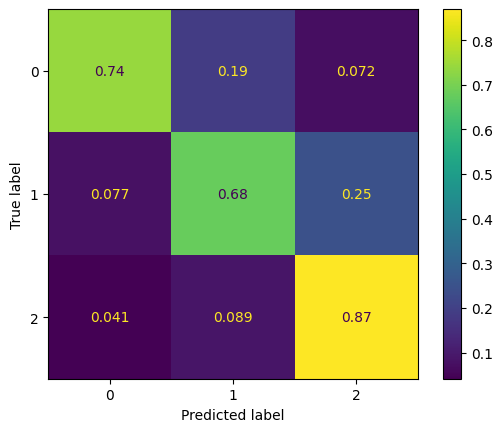

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.54341. Saving Model!
epoch 01, loss: 0.62742, acc: 0.73017, val_loss: 0.54341, val_accuracy: 0.78893


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 02, loss: 0.62294, acc: 0.73416, val_loss: 0.55037, val_accuracy: 0.78166


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 03, loss: 0.62258, acc: 0.73543, val_loss: 0.55353, val_accuracy: 0.78068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 04, loss: 0.62104, acc: 0.73691, val_loss: 0.55499, val_accuracy: 0.78029


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 05, loss: 0.61902, acc: 0.73434, val_loss: 0.55626, val_accuracy: 0.78225


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 06, loss: 0.61905, acc: 0.73600, val_loss: 0.55690, val_accuracy: 0.78107


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 07, loss: 0.61828, acc: 0.73606, val_loss: 0.55858, val_accuracy: 0.78068


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 08, loss: 0.61798, acc: 0.73602, val_loss: 0.55979, val_accuracy: 0.77950


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 09, loss: 0.61702, acc: 0.73611, val_loss: 0.56142, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 10, loss: 0.61639, acc: 0.73658, val_loss: 0.56262, val_accuracy: 0.77872


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 11, loss: 0.61614, acc: 0.73652, val_loss: 0.56319, val_accuracy: 0.77793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 12, loss: 0.61545, acc: 0.73702, val_loss: 0.56421, val_accuracy: 0.77695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 13, loss: 0.61520, acc: 0.73696, val_loss: 0.56476, val_accuracy: 0.77754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 14, loss: 0.61460, acc: 0.73685, val_loss: 0.56586, val_accuracy: 0.77773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 15, loss: 0.61445, acc: 0.73685, val_loss: 0.56693, val_accuracy: 0.77754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 16, loss: 0.61370, acc: 0.73792, val_loss: 0.56725, val_accuracy: 0.77734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 17, loss: 0.61337, acc: 0.73802, val_loss: 0.56785, val_accuracy: 0.77773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 18, loss: 0.61331, acc: 0.73807, val_loss: 0.56871, val_accuracy: 0.77734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 19, loss: 0.61269, acc: 0.73824, val_loss: 0.56983, val_accuracy: 0.77773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 20, loss: 0.61248, acc: 0.73822, val_loss: 0.57036, val_accuracy: 0.77675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 21, loss: 0.61202, acc: 0.73822, val_loss: 0.57090, val_accuracy: 0.77715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 22, loss: 0.61161, acc: 0.73853, val_loss: 0.57170, val_accuracy: 0.77813


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


epoch 23, loss: 0.61148, acc: 0.73855, val_loss: 0.57211, val_accuracy: 0.77715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 24, loss: 0.61118, acc: 0.73870, val_loss: 0.57266, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 25, loss: 0.61050, acc: 0.73901, val_loss: 0.57324, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 26, loss: 0.61047, acc: 0.73898, val_loss: 0.57350, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 27, loss: 0.61013, acc: 0.73922, val_loss: 0.57388, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 28, loss: 0.60982, acc: 0.73925, val_loss: 0.57407, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 29, loss: 0.60942, acc: 0.73914, val_loss: 0.57481, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 30, loss: 0.60936, acc: 0.73857, val_loss: 0.57511, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 31, loss: 0.60896, acc: 0.73879, val_loss: 0.57566, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 32, loss: 0.60844, acc: 0.73907, val_loss: 0.57623, val_accuracy: 0.77086


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 33, loss: 0.60851, acc: 0.73890, val_loss: 0.57645, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 34, loss: 0.60783, acc: 0.73898, val_loss: 0.57700, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 35, loss: 0.60786, acc: 0.73914, val_loss: 0.57741, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 36, loss: 0.60741, acc: 0.73925, val_loss: 0.57784, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 37, loss: 0.60718, acc: 0.73912, val_loss: 0.57817, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 38, loss: 0.60682, acc: 0.73929, val_loss: 0.57866, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 39, loss: 0.60687, acc: 0.73916, val_loss: 0.57841, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 40, loss: 0.60613, acc: 0.74016, val_loss: 0.57912, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 41, loss: 0.60613, acc: 0.74003, val_loss: 0.57951, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 42, loss: 0.60573, acc: 0.74036, val_loss: 0.58001, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 43, loss: 0.60567, acc: 0.74027, val_loss: 0.58025, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 44, loss: 0.60506, acc: 0.74051, val_loss: 0.58065, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 45, loss: 0.60516, acc: 0.74036, val_loss: 0.58106, val_accuracy: 0.77106


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


epoch 46, loss: 0.60462, acc: 0.74042, val_loss: 0.58152, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 47, loss: 0.60464, acc: 0.74086, val_loss: 0.58176, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 48, loss: 0.60394, acc: 0.74125, val_loss: 0.58230, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 49, loss: 0.60406, acc: 0.74082, val_loss: 0.58235, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 50, loss: 0.60345, acc: 0.74108, val_loss: 0.58276, val_accuracy: 0.77125


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 51, loss: 0.60363, acc: 0.74112, val_loss: 0.58260, val_accuracy: 0.77165


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 52, loss: 0.60299, acc: 0.74136, val_loss: 0.58320, val_accuracy: 0.77145


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.05it/s]


epoch 53, loss: 0.60314, acc: 0.74147, val_loss: 0.58332, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 54, loss: 0.60260, acc: 0.74151, val_loss: 0.58366, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 55, loss: 0.60234, acc: 0.74158, val_loss: 0.58410, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 56, loss: 0.60207, acc: 0.74204, val_loss: 0.58444, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 57, loss: 0.60199, acc: 0.74186, val_loss: 0.58495, val_accuracy: 0.77204


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 58, loss: 0.60153, acc: 0.74208, val_loss: 0.58518, val_accuracy: 0.77243


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


epoch 59, loss: 0.60152, acc: 0.74204, val_loss: 0.58554, val_accuracy: 0.77184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 60, loss: 0.60107, acc: 0.74210, val_loss: 0.58570, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 61, loss: 0.60101, acc: 0.74206, val_loss: 0.58540, val_accuracy: 0.77283


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 62, loss: 0.60068, acc: 0.74232, val_loss: 0.58576, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 63, loss: 0.60029, acc: 0.74241, val_loss: 0.58620, val_accuracy: 0.77224


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 64, loss: 0.60022, acc: 0.74269, val_loss: 0.58647, val_accuracy: 0.77263


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 65, loss: 0.59998, acc: 0.74265, val_loss: 0.58725, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 66, loss: 0.59959, acc: 0.74247, val_loss: 0.58725, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 67, loss: 0.59955, acc: 0.74254, val_loss: 0.58727, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 68, loss: 0.59914, acc: 0.74278, val_loss: 0.58787, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 69, loss: 0.59907, acc: 0.74287, val_loss: 0.58798, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 70, loss: 0.59844, acc: 0.74311, val_loss: 0.58860, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


epoch 71, loss: 0.59878, acc: 0.74302, val_loss: 0.58833, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 72, loss: 0.59829, acc: 0.74431, val_loss: 0.58917, val_accuracy: 0.77322


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 73, loss: 0.59787, acc: 0.74444, val_loss: 0.58929, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 74, loss: 0.59782, acc: 0.74459, val_loss: 0.58909, val_accuracy: 0.77302


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 75, loss: 0.59744, acc: 0.74476, val_loss: 0.58979, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 76, loss: 0.59733, acc: 0.74479, val_loss: 0.58960, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 77, loss: 0.59698, acc: 0.74583, val_loss: 0.58975, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 78, loss: 0.59679, acc: 0.74590, val_loss: 0.59003, val_accuracy: 0.77341


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 79, loss: 0.59657, acc: 0.74509, val_loss: 0.59055, val_accuracy: 0.77361


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 80, loss: 0.59633, acc: 0.74612, val_loss: 0.59070, val_accuracy: 0.77400


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 81, loss: 0.59618, acc: 0.74618, val_loss: 0.59121, val_accuracy: 0.77440


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 82, loss: 0.59594, acc: 0.74688, val_loss: 0.59123, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 83, loss: 0.59550, acc: 0.74679, val_loss: 0.59138, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 84, loss: 0.59546, acc: 0.74666, val_loss: 0.59172, val_accuracy: 0.77479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 85, loss: 0.59509, acc: 0.74701, val_loss: 0.59194, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 86, loss: 0.59489, acc: 0.74710, val_loss: 0.59237, val_accuracy: 0.77479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 87, loss: 0.59471, acc: 0.74679, val_loss: 0.59184, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 88, loss: 0.59466, acc: 0.74701, val_loss: 0.59181, val_accuracy: 0.77479


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 89, loss: 0.59416, acc: 0.74581, val_loss: 0.59274, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 90, loss: 0.59411, acc: 0.74588, val_loss: 0.59240, val_accuracy: 0.77459


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 91, loss: 0.59386, acc: 0.74690, val_loss: 0.59290, val_accuracy: 0.77518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 92, loss: 0.59370, acc: 0.74749, val_loss: 0.59295, val_accuracy: 0.77518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 93, loss: 0.59309, acc: 0.74697, val_loss: 0.59329, val_accuracy: 0.77538


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 94, loss: 0.59314, acc: 0.74740, val_loss: 0.59330, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 95, loss: 0.59317, acc: 0.74751, val_loss: 0.59390, val_accuracy: 0.77499


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 96, loss: 0.59243, acc: 0.74764, val_loss: 0.59422, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 97, loss: 0.59265, acc: 0.74736, val_loss: 0.59385, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 98, loss: 0.59222, acc: 0.74760, val_loss: 0.59446, val_accuracy: 0.77557


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 99, loss: 0.59202, acc: 0.74778, val_loss: 0.59469, val_accuracy: 0.77577


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 100, loss: 0.59187, acc: 0.74788, val_loss: 0.59386, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


epoch 101, loss: 0.59150, acc: 0.74688, val_loss: 0.59475, val_accuracy: 0.77518


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


epoch 102, loss: 0.59121, acc: 0.74806, val_loss: 0.59455, val_accuracy: 0.77616


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 103, loss: 0.59119, acc: 0.74845, val_loss: 0.59461, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 104, loss: 0.59113, acc: 0.74841, val_loss: 0.59519, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 105, loss: 0.59047, acc: 0.74858, val_loss: 0.59558, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 106, loss: 0.59056, acc: 0.74856, val_loss: 0.59545, val_accuracy: 0.77675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 107, loss: 0.59031, acc: 0.74871, val_loss: 0.59610, val_accuracy: 0.77675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 108, loss: 0.59007, acc: 0.74865, val_loss: 0.59605, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 109, loss: 0.58980, acc: 0.74878, val_loss: 0.59604, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 110, loss: 0.58986, acc: 0.74869, val_loss: 0.59625, val_accuracy: 0.77636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 111, loss: 0.58925, acc: 0.74900, val_loss: 0.59665, val_accuracy: 0.77695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


epoch 112, loss: 0.58925, acc: 0.74915, val_loss: 0.59666, val_accuracy: 0.77675


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 113, loss: 0.58904, acc: 0.74917, val_loss: 0.59681, val_accuracy: 0.77597


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 114, loss: 0.58887, acc: 0.74913, val_loss: 0.59691, val_accuracy: 0.77636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


epoch 115, loss: 0.58827, acc: 0.74943, val_loss: 0.59731, val_accuracy: 0.77656


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 116, loss: 0.58847, acc: 0.75013, val_loss: 0.59725, val_accuracy: 0.77636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 117, loss: 0.58820, acc: 0.74996, val_loss: 0.59737, val_accuracy: 0.77754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 118, loss: 0.58780, acc: 0.74963, val_loss: 0.59777, val_accuracy: 0.77715


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 119, loss: 0.58768, acc: 0.75017, val_loss: 0.59814, val_accuracy: 0.77695


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 120, loss: 0.58776, acc: 0.75026, val_loss: 0.59796, val_accuracy: 0.77734


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 121, loss: 0.58714, acc: 0.75028, val_loss: 0.59807, val_accuracy: 0.77754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 122, loss: 0.58710, acc: 0.75072, val_loss: 0.59893, val_accuracy: 0.77754


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 123, loss: 0.58672, acc: 0.75061, val_loss: 0.59897, val_accuracy: 0.77773


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 124, loss: 0.58670, acc: 0.75037, val_loss: 0.59878, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 125, loss: 0.58636, acc: 0.75011, val_loss: 0.59940, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 126, loss: 0.58631, acc: 0.75046, val_loss: 0.59903, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 127, loss: 0.58597, acc: 0.75063, val_loss: 0.59883, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 128, loss: 0.58589, acc: 0.75072, val_loss: 0.59948, val_accuracy: 0.76752


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 129, loss: 0.58534, acc: 0.75094, val_loss: 0.59988, val_accuracy: 0.76792


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 130, loss: 0.58562, acc: 0.75081, val_loss: 0.59948, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 131, loss: 0.58514, acc: 0.75089, val_loss: 0.60021, val_accuracy: 0.76929


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 132, loss: 0.58499, acc: 0.75103, val_loss: 0.60012, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 133, loss: 0.58456, acc: 0.75124, val_loss: 0.60056, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 134, loss: 0.58472, acc: 0.75089, val_loss: 0.60019, val_accuracy: 0.76890


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 135, loss: 0.58404, acc: 0.75212, val_loss: 0.60136, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 136, loss: 0.58423, acc: 0.75207, val_loss: 0.60102, val_accuracy: 0.76909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 137, loss: 0.58372, acc: 0.75236, val_loss: 0.60141, val_accuracy: 0.76870


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 138, loss: 0.58393, acc: 0.75233, val_loss: 0.60133, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 139, loss: 0.58338, acc: 0.75257, val_loss: 0.60163, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 140, loss: 0.58339, acc: 0.75262, val_loss: 0.60132, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 141, loss: 0.58302, acc: 0.75308, val_loss: 0.60167, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 142, loss: 0.58274, acc: 0.75310, val_loss: 0.60195, val_accuracy: 0.76851


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


epoch 143, loss: 0.58284, acc: 0.75303, val_loss: 0.60199, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 144, loss: 0.58242, acc: 0.75303, val_loss: 0.60249, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 145, loss: 0.58210, acc: 0.75329, val_loss: 0.60284, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 146, loss: 0.58225, acc: 0.75332, val_loss: 0.60301, val_accuracy: 0.76811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 147, loss: 0.58163, acc: 0.75351, val_loss: 0.60327, val_accuracy: 0.76831


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 148, loss: 0.58192, acc: 0.75327, val_loss: 0.60347, val_accuracy: 0.76615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 149, loss: 0.58141, acc: 0.75327, val_loss: 0.60358, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 150, loss: 0.58125, acc: 0.75390, val_loss: 0.60409, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 151, loss: 0.58104, acc: 0.75382, val_loss: 0.60437, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 152, loss: 0.58092, acc: 0.75384, val_loss: 0.60371, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 153, loss: 0.58041, acc: 0.75399, val_loss: 0.60428, val_accuracy: 0.75437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 154, loss: 0.58069, acc: 0.75408, val_loss: 0.60450, val_accuracy: 0.76556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 155, loss: 0.58007, acc: 0.75406, val_loss: 0.60488, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 156, loss: 0.58022, acc: 0.75404, val_loss: 0.60484, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 157, loss: 0.57966, acc: 0.75436, val_loss: 0.60575, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 158, loss: 0.57963, acc: 0.75489, val_loss: 0.60532, val_accuracy: 0.76615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 159, loss: 0.57957, acc: 0.75482, val_loss: 0.60594, val_accuracy: 0.75437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 160, loss: 0.57910, acc: 0.75510, val_loss: 0.60693, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 161, loss: 0.57889, acc: 0.75510, val_loss: 0.60677, val_accuracy: 0.75476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 162, loss: 0.57915, acc: 0.75491, val_loss: 0.60639, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 163, loss: 0.57825, acc: 0.75626, val_loss: 0.60650, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 164, loss: 0.57841, acc: 0.75543, val_loss: 0.60694, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 165, loss: 0.57826, acc: 0.75528, val_loss: 0.60681, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 166, loss: 0.57802, acc: 0.75617, val_loss: 0.60700, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 167, loss: 0.57792, acc: 0.75626, val_loss: 0.60723, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 168, loss: 0.57736, acc: 0.75650, val_loss: 0.60829, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 169, loss: 0.57774, acc: 0.75637, val_loss: 0.60746, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 170, loss: 0.57693, acc: 0.75667, val_loss: 0.60889, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 171, loss: 0.57735, acc: 0.75650, val_loss: 0.60774, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 172, loss: 0.57650, acc: 0.75685, val_loss: 0.60874, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 173, loss: 0.57694, acc: 0.75678, val_loss: 0.60879, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 174, loss: 0.57632, acc: 0.75689, val_loss: 0.60900, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 175, loss: 0.57626, acc: 0.75578, val_loss: 0.60819, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.32it/s]


epoch 176, loss: 0.57602, acc: 0.75705, val_loss: 0.60925, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 177, loss: 0.57579, acc: 0.75685, val_loss: 0.60964, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 178, loss: 0.57573, acc: 0.75720, val_loss: 0.60950, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 179, loss: 0.57532, acc: 0.75718, val_loss: 0.60954, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 180, loss: 0.57547, acc: 0.75718, val_loss: 0.60953, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 181, loss: 0.57473, acc: 0.75643, val_loss: 0.61034, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 182, loss: 0.57511, acc: 0.75637, val_loss: 0.61002, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 183, loss: 0.57437, acc: 0.75757, val_loss: 0.61093, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 184, loss: 0.57466, acc: 0.75763, val_loss: 0.61101, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 185, loss: 0.57398, acc: 0.75683, val_loss: 0.61042, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 186, loss: 0.57428, acc: 0.75659, val_loss: 0.61089, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 187, loss: 0.57362, acc: 0.75689, val_loss: 0.61135, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 188, loss: 0.57389, acc: 0.75689, val_loss: 0.61051, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 189, loss: 0.57304, acc: 0.75707, val_loss: 0.61140, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 190, loss: 0.57354, acc: 0.75681, val_loss: 0.61211, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 191, loss: 0.57291, acc: 0.75825, val_loss: 0.61220, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 192, loss: 0.57305, acc: 0.75720, val_loss: 0.61178, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 193, loss: 0.57246, acc: 0.75715, val_loss: 0.61295, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 194, loss: 0.57290, acc: 0.75694, val_loss: 0.61207, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 195, loss: 0.57204, acc: 0.75805, val_loss: 0.61254, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 196, loss: 0.57201, acc: 0.75729, val_loss: 0.61272, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 197, loss: 0.57197, acc: 0.75729, val_loss: 0.61294, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 198, loss: 0.57147, acc: 0.75753, val_loss: 0.61332, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 199, loss: 0.57158, acc: 0.75720, val_loss: 0.61293, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 200, loss: 0.57124, acc: 0.75770, val_loss: 0.61474, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 201, loss: 0.57097, acc: 0.75761, val_loss: 0.61354, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 202, loss: 0.57098, acc: 0.75766, val_loss: 0.61357, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 203, loss: 0.57056, acc: 0.75757, val_loss: 0.61443, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 204, loss: 0.57051, acc: 0.75766, val_loss: 0.61427, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 205, loss: 0.57018, acc: 0.75783, val_loss: 0.61397, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 206, loss: 0.57029, acc: 0.75801, val_loss: 0.61500, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 207, loss: 0.56945, acc: 0.75851, val_loss: 0.61514, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 208, loss: 0.56985, acc: 0.75835, val_loss: 0.61442, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


epoch 209, loss: 0.56924, acc: 0.75827, val_loss: 0.61446, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 210, loss: 0.56913, acc: 0.75862, val_loss: 0.61570, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 211, loss: 0.56918, acc: 0.75853, val_loss: 0.61446, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 212, loss: 0.56890, acc: 0.75857, val_loss: 0.61474, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


epoch 213, loss: 0.56818, acc: 0.75883, val_loss: 0.61563, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 214, loss: 0.56879, acc: 0.75923, val_loss: 0.61435, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 215, loss: 0.56776, acc: 0.75899, val_loss: 0.61611, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 216, loss: 0.56813, acc: 0.75912, val_loss: 0.61495, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 217, loss: 0.56734, acc: 0.75955, val_loss: 0.61561, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 218, loss: 0.56778, acc: 0.75916, val_loss: 0.61593, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 219, loss: 0.56720, acc: 0.75907, val_loss: 0.61621, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 220, loss: 0.56713, acc: 0.75953, val_loss: 0.61647, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 221, loss: 0.56686, acc: 0.75947, val_loss: 0.61649, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 222, loss: 0.56691, acc: 0.75971, val_loss: 0.61666, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 223, loss: 0.56668, acc: 0.75951, val_loss: 0.61685, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 224, loss: 0.56613, acc: 0.75969, val_loss: 0.61708, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 225, loss: 0.56619, acc: 0.75973, val_loss: 0.61685, val_accuracy: 0.74023


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 226, loss: 0.56593, acc: 0.76062, val_loss: 0.61800, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 227, loss: 0.56574, acc: 0.76016, val_loss: 0.61776, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 228, loss: 0.56553, acc: 0.76073, val_loss: 0.61725, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 229, loss: 0.56515, acc: 0.76019, val_loss: 0.61700, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 230, loss: 0.56524, acc: 0.76071, val_loss: 0.61873, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 231, loss: 0.56494, acc: 0.76080, val_loss: 0.61847, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 232, loss: 0.56463, acc: 0.76097, val_loss: 0.61883, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 233, loss: 0.56451, acc: 0.76112, val_loss: 0.61787, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 234, loss: 0.56436, acc: 0.76071, val_loss: 0.61902, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 235, loss: 0.56411, acc: 0.76174, val_loss: 0.61875, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 236, loss: 0.56375, acc: 0.76237, val_loss: 0.61915, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


epoch 237, loss: 0.56372, acc: 0.76224, val_loss: 0.61907, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 238, loss: 0.56353, acc: 0.76246, val_loss: 0.61941, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 239, loss: 0.56330, acc: 0.76195, val_loss: 0.61934, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 240, loss: 0.56296, acc: 0.76254, val_loss: 0.62046, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 241, loss: 0.56288, acc: 0.76250, val_loss: 0.62049, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 242, loss: 0.56255, acc: 0.76280, val_loss: 0.61975, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 243, loss: 0.56265, acc: 0.76259, val_loss: 0.61950, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 244, loss: 0.56212, acc: 0.76272, val_loss: 0.62107, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 245, loss: 0.56223, acc: 0.76270, val_loss: 0.62073, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 246, loss: 0.56176, acc: 0.76304, val_loss: 0.62090, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 247, loss: 0.56196, acc: 0.76259, val_loss: 0.61998, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 248, loss: 0.56092, acc: 0.76350, val_loss: 0.62238, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


epoch 249, loss: 0.56157, acc: 0.76280, val_loss: 0.62131, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


epoch 250, loss: 0.56099, acc: 0.76357, val_loss: 0.62179, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


epoch 251, loss: 0.56089, acc: 0.76296, val_loss: 0.62128, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 252, loss: 0.56045, acc: 0.76342, val_loss: 0.62240, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 253, loss: 0.56077, acc: 0.76274, val_loss: 0.62211, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 254, loss: 0.56002, acc: 0.76357, val_loss: 0.62174, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 255, loss: 0.56003, acc: 0.76322, val_loss: 0.62253, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 256, loss: 0.56015, acc: 0.76342, val_loss: 0.62279, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 257, loss: 0.55947, acc: 0.76405, val_loss: 0.62311, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 258, loss: 0.55935, acc: 0.76370, val_loss: 0.62288, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 259, loss: 0.55936, acc: 0.76324, val_loss: 0.62316, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 260, loss: 0.55919, acc: 0.76427, val_loss: 0.62402, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 261, loss: 0.55852, acc: 0.76542, val_loss: 0.62346, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 262, loss: 0.55883, acc: 0.76505, val_loss: 0.62454, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 263, loss: 0.55853, acc: 0.76505, val_loss: 0.62330, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 264, loss: 0.55819, acc: 0.76520, val_loss: 0.62480, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 265, loss: 0.55826, acc: 0.76512, val_loss: 0.62457, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 266, loss: 0.55774, acc: 0.76525, val_loss: 0.62555, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 267, loss: 0.55775, acc: 0.76564, val_loss: 0.62351, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 268, loss: 0.55725, acc: 0.76706, val_loss: 0.62515, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 269, loss: 0.55755, acc: 0.76533, val_loss: 0.62446, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 270, loss: 0.55674, acc: 0.76673, val_loss: 0.62665, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 271, loss: 0.55723, acc: 0.76590, val_loss: 0.62483, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 272, loss: 0.55646, acc: 0.76819, val_loss: 0.62500, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 273, loss: 0.55664, acc: 0.76647, val_loss: 0.62520, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 274, loss: 0.55580, acc: 0.76741, val_loss: 0.62679, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 275, loss: 0.55661, acc: 0.76688, val_loss: 0.62545, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 276, loss: 0.55549, acc: 0.76712, val_loss: 0.62675, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 277, loss: 0.55599, acc: 0.76664, val_loss: 0.62511, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 278, loss: 0.55485, acc: 0.76893, val_loss: 0.62696, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


epoch 279, loss: 0.55590, acc: 0.76688, val_loss: 0.62604, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 280, loss: 0.55435, acc: 0.76896, val_loss: 0.62696, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 281, loss: 0.55548, acc: 0.76723, val_loss: 0.62519, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 282, loss: 0.55387, acc: 0.76797, val_loss: 0.62748, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 283, loss: 0.55503, acc: 0.76741, val_loss: 0.62639, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 284, loss: 0.55344, acc: 0.76913, val_loss: 0.62787, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 285, loss: 0.55496, acc: 0.76839, val_loss: 0.62569, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 286, loss: 0.55276, acc: 0.76935, val_loss: 0.62738, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 287, loss: 0.55432, acc: 0.76771, val_loss: 0.62691, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 288, loss: 0.55308, acc: 0.76834, val_loss: 0.62800, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 289, loss: 0.55326, acc: 0.76913, val_loss: 0.62855, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 290, loss: 0.55303, acc: 0.76893, val_loss: 0.62755, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 291, loss: 0.55292, acc: 0.76902, val_loss: 0.62769, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 292, loss: 0.55239, acc: 0.76920, val_loss: 0.62809, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 293, loss: 0.55227, acc: 0.76944, val_loss: 0.62923, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 294, loss: 0.55200, acc: 0.76987, val_loss: 0.62852, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 295, loss: 0.55224, acc: 0.76924, val_loss: 0.62833, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 296, loss: 0.55143, acc: 0.76935, val_loss: 0.62872, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 297, loss: 0.55177, acc: 0.76813, val_loss: 0.62934, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 298, loss: 0.55135, acc: 0.76972, val_loss: 0.62919, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 299, loss: 0.55113, acc: 0.76952, val_loss: 0.62985, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 300, loss: 0.55094, acc: 0.76976, val_loss: 0.62840, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 301, loss: 0.55101, acc: 0.76972, val_loss: 0.62959, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 302, loss: 0.55049, acc: 0.77009, val_loss: 0.62919, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 303, loss: 0.55025, acc: 0.77042, val_loss: 0.63045, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 304, loss: 0.55018, acc: 0.77048, val_loss: 0.63004, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 305, loss: 0.54998, acc: 0.77035, val_loss: 0.63021, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 306, loss: 0.54961, acc: 0.77011, val_loss: 0.62933, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 307, loss: 0.54979, acc: 0.77066, val_loss: 0.63054, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 308, loss: 0.54922, acc: 0.77053, val_loss: 0.63044, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 309, loss: 0.54924, acc: 0.77072, val_loss: 0.63196, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 310, loss: 0.54900, acc: 0.77046, val_loss: 0.62938, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 311, loss: 0.54878, acc: 0.77164, val_loss: 0.63096, val_accuracy: 0.73611


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 312, loss: 0.54881, acc: 0.77053, val_loss: 0.63135, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 313, loss: 0.54818, acc: 0.77129, val_loss: 0.63219, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 314, loss: 0.54846, acc: 0.77188, val_loss: 0.63124, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 315, loss: 0.54774, acc: 0.77179, val_loss: 0.63069, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 316, loss: 0.54808, acc: 0.77068, val_loss: 0.63042, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 317, loss: 0.54732, acc: 0.77136, val_loss: 0.63169, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 318, loss: 0.54787, acc: 0.77136, val_loss: 0.63236, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 319, loss: 0.54695, acc: 0.77168, val_loss: 0.63278, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


epoch 320, loss: 0.54738, acc: 0.77140, val_loss: 0.63120, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 321, loss: 0.54642, acc: 0.77253, val_loss: 0.63282, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


epoch 322, loss: 0.54742, acc: 0.77081, val_loss: 0.63119, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 323, loss: 0.54559, acc: 0.77245, val_loss: 0.63454, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 324, loss: 0.54740, acc: 0.77105, val_loss: 0.63183, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 325, loss: 0.54546, acc: 0.77210, val_loss: 0.63449, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 326, loss: 0.54670, acc: 0.77092, val_loss: 0.63174, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 327, loss: 0.54506, acc: 0.77273, val_loss: 0.63393, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 328, loss: 0.54672, acc: 0.77037, val_loss: 0.63287, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 329, loss: 0.54418, acc: 0.77277, val_loss: 0.63507, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 330, loss: 0.54649, acc: 0.77033, val_loss: 0.63255, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 331, loss: 0.54370, acc: 0.77327, val_loss: 0.63470, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 332, loss: 0.54635, acc: 0.77016, val_loss: 0.63235, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 333, loss: 0.54343, acc: 0.77255, val_loss: 0.63512, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 334, loss: 0.54576, acc: 0.77175, val_loss: 0.63413, val_accuracy: 0.73650


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 335, loss: 0.54313, acc: 0.77345, val_loss: 0.63547, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 336, loss: 0.54510, acc: 0.77240, val_loss: 0.63321, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 337, loss: 0.54275, acc: 0.77384, val_loss: 0.63709, val_accuracy: 0.73670


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 338, loss: 0.54506, acc: 0.77330, val_loss: 0.63260, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 339, loss: 0.54204, acc: 0.77406, val_loss: 0.63608, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 340, loss: 0.54461, acc: 0.77162, val_loss: 0.63366, val_accuracy: 0.73709


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 341, loss: 0.54181, acc: 0.77450, val_loss: 0.63606, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 342, loss: 0.54451, acc: 0.77155, val_loss: 0.63466, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 343, loss: 0.54118, acc: 0.77474, val_loss: 0.63653, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 344, loss: 0.54403, acc: 0.77214, val_loss: 0.63372, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 345, loss: 0.54105, acc: 0.77413, val_loss: 0.63858, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 346, loss: 0.54376, acc: 0.77264, val_loss: 0.63436, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 347, loss: 0.54034, acc: 0.77509, val_loss: 0.63822, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 348, loss: 0.54378, acc: 0.77240, val_loss: 0.63346, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 349, loss: 0.53975, acc: 0.77515, val_loss: 0.63818, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 350, loss: 0.54370, acc: 0.77310, val_loss: 0.63419, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 351, loss: 0.53907, acc: 0.77655, val_loss: 0.63901, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 352, loss: 0.54330, acc: 0.77170, val_loss: 0.63438, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 353, loss: 0.53904, acc: 0.77648, val_loss: 0.63823, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 354, loss: 0.54304, acc: 0.77371, val_loss: 0.63468, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 355, loss: 0.53809, acc: 0.77615, val_loss: 0.64108, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 356, loss: 0.54269, acc: 0.77266, val_loss: 0.63382, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 357, loss: 0.53785, acc: 0.77685, val_loss: 0.63922, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 358, loss: 0.54234, acc: 0.77338, val_loss: 0.63461, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 359, loss: 0.53740, acc: 0.77864, val_loss: 0.64116, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 360, loss: 0.54218, acc: 0.77493, val_loss: 0.63547, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 361, loss: 0.53714, acc: 0.77624, val_loss: 0.64030, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 362, loss: 0.54169, acc: 0.77437, val_loss: 0.63483, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 363, loss: 0.53668, acc: 0.77864, val_loss: 0.64170, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 364, loss: 0.54150, acc: 0.77356, val_loss: 0.63437, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 365, loss: 0.53616, acc: 0.77851, val_loss: 0.64188, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 366, loss: 0.54125, acc: 0.77432, val_loss: 0.63464, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 367, loss: 0.53575, acc: 0.77683, val_loss: 0.64069, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 368, loss: 0.54030, acc: 0.77578, val_loss: 0.63739, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 369, loss: 0.53561, acc: 0.77871, val_loss: 0.64156, val_accuracy: 0.73866


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 370, loss: 0.54018, acc: 0.77371, val_loss: 0.63651, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 371, loss: 0.53534, acc: 0.77868, val_loss: 0.64292, val_accuracy: 0.72825


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 372, loss: 0.53981, acc: 0.77574, val_loss: 0.63903, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 373, loss: 0.53451, acc: 0.77825, val_loss: 0.64587, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 374, loss: 0.53946, acc: 0.77482, val_loss: 0.63959, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 375, loss: 0.53450, acc: 0.77877, val_loss: 0.64810, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 376, loss: 0.53884, acc: 0.77615, val_loss: 0.64071, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 377, loss: 0.53379, acc: 0.77923, val_loss: 0.64795, val_accuracy: 0.72767


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 378, loss: 0.53880, acc: 0.77607, val_loss: 0.64125, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 379, loss: 0.53303, acc: 0.77930, val_loss: 0.64851, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 380, loss: 0.53839, acc: 0.77635, val_loss: 0.64061, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 381, loss: 0.53329, acc: 0.77932, val_loss: 0.64586, val_accuracy: 0.72806


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 382, loss: 0.53767, acc: 0.77561, val_loss: 0.64049, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 383, loss: 0.53301, acc: 0.77953, val_loss: 0.64689, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 384, loss: 0.53730, acc: 0.77655, val_loss: 0.64092, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 385, loss: 0.53244, acc: 0.77875, val_loss: 0.64724, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 386, loss: 0.53726, acc: 0.77526, val_loss: 0.64125, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 387, loss: 0.53152, acc: 0.77969, val_loss: 0.65004, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 388, loss: 0.53738, acc: 0.77690, val_loss: 0.64121, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 389, loss: 0.53153, acc: 0.77971, val_loss: 0.64751, val_accuracy: 0.72943


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 390, loss: 0.53645, acc: 0.77668, val_loss: 0.64138, val_accuracy: 0.72786


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 391, loss: 0.53108, acc: 0.77993, val_loss: 0.64971, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 392, loss: 0.53663, acc: 0.77580, val_loss: 0.64012, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 393, loss: 0.53067, acc: 0.78036, val_loss: 0.64969, val_accuracy: 0.72924


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 394, loss: 0.53607, acc: 0.77676, val_loss: 0.64106, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


epoch 395, loss: 0.52979, acc: 0.78128, val_loss: 0.64863, val_accuracy: 0.73022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 396, loss: 0.53580, acc: 0.77740, val_loss: 0.64273, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 397, loss: 0.53005, acc: 0.78159, val_loss: 0.65044, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 398, loss: 0.53509, acc: 0.77788, val_loss: 0.64232, val_accuracy: 0.72884


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 399, loss: 0.52931, acc: 0.78198, val_loss: 0.65066, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 400, loss: 0.53513, acc: 0.77781, val_loss: 0.64139, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 401, loss: 0.52885, acc: 0.78185, val_loss: 0.64899, val_accuracy: 0.72983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 402, loss: 0.53439, acc: 0.77892, val_loss: 0.64410, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 403, loss: 0.52891, acc: 0.78209, val_loss: 0.65104, val_accuracy: 0.73041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 404, loss: 0.53409, acc: 0.77882, val_loss: 0.64195, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 405, loss: 0.52802, acc: 0.78224, val_loss: 0.65033, val_accuracy: 0.73002


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 406, loss: 0.53411, acc: 0.77799, val_loss: 0.64415, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 407, loss: 0.52771, acc: 0.78220, val_loss: 0.65154, val_accuracy: 0.73041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 408, loss: 0.53322, acc: 0.77892, val_loss: 0.64319, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 409, loss: 0.52787, acc: 0.78222, val_loss: 0.65071, val_accuracy: 0.73061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 410, loss: 0.53243, acc: 0.77925, val_loss: 0.64432, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 411, loss: 0.52750, acc: 0.78231, val_loss: 0.65070, val_accuracy: 0.73061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 412, loss: 0.53258, acc: 0.77921, val_loss: 0.64575, val_accuracy: 0.73081


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 413, loss: 0.52655, acc: 0.78239, val_loss: 0.65175, val_accuracy: 0.73061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


epoch 414, loss: 0.53219, acc: 0.77914, val_loss: 0.64503, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 415, loss: 0.52638, acc: 0.78257, val_loss: 0.65229, val_accuracy: 0.72001


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.78it/s]


epoch 416, loss: 0.53187, acc: 0.77927, val_loss: 0.64338, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 417, loss: 0.52618, acc: 0.78294, val_loss: 0.65178, val_accuracy: 0.73061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 418, loss: 0.53108, acc: 0.77934, val_loss: 0.64622, val_accuracy: 0.72983


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 419, loss: 0.52594, acc: 0.78261, val_loss: 0.65223, val_accuracy: 0.71962


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 420, loss: 0.53119, acc: 0.77945, val_loss: 0.64441, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 421, loss: 0.52479, acc: 0.78344, val_loss: 0.65246, val_accuracy: 0.73061


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 422, loss: 0.53136, acc: 0.77969, val_loss: 0.64536, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 423, loss: 0.52469, acc: 0.78274, val_loss: 0.65425, val_accuracy: 0.72060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 424, loss: 0.53069, acc: 0.77947, val_loss: 0.64491, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 425, loss: 0.52397, acc: 0.78324, val_loss: 0.65417, val_accuracy: 0.71981


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


epoch 426, loss: 0.53075, acc: 0.77816, val_loss: 0.64616, val_accuracy: 0.73022


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 427, loss: 0.52391, acc: 0.78303, val_loss: 0.65601, val_accuracy: 0.72119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


epoch 428, loss: 0.52977, acc: 0.78006, val_loss: 0.64638, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 429, loss: 0.52372, acc: 0.78335, val_loss: 0.65362, val_accuracy: 0.72079


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 430, loss: 0.52913, acc: 0.77986, val_loss: 0.64642, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 431, loss: 0.52340, acc: 0.78294, val_loss: 0.65501, val_accuracy: 0.72040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 432, loss: 0.52888, acc: 0.78004, val_loss: 0.64665, val_accuracy: 0.74121


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 433, loss: 0.52288, acc: 0.78311, val_loss: 0.65440, val_accuracy: 0.72060


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 434, loss: 0.52830, acc: 0.78004, val_loss: 0.64720, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 435, loss: 0.52278, acc: 0.78383, val_loss: 0.65439, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 436, loss: 0.52769, acc: 0.78063, val_loss: 0.64667, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 437, loss: 0.52250, acc: 0.78370, val_loss: 0.65301, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 438, loss: 0.52722, acc: 0.78052, val_loss: 0.64856, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 439, loss: 0.52188, acc: 0.78383, val_loss: 0.65651, val_accuracy: 0.72040


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 440, loss: 0.52737, acc: 0.78036, val_loss: 0.64694, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 441, loss: 0.52122, acc: 0.78385, val_loss: 0.65661, val_accuracy: 0.72119


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 442, loss: 0.52744, acc: 0.78030, val_loss: 0.64785, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 443, loss: 0.52082, acc: 0.78396, val_loss: 0.65475, val_accuracy: 0.73238


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 444, loss: 0.52636, acc: 0.78089, val_loss: 0.64911, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 445, loss: 0.52098, acc: 0.78431, val_loss: 0.65500, val_accuracy: 0.72158


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 446, loss: 0.52592, acc: 0.78080, val_loss: 0.64972, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 447, loss: 0.52047, acc: 0.78420, val_loss: 0.65700, val_accuracy: 0.72177


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 448, loss: 0.52516, acc: 0.78217, val_loss: 0.64853, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 449, loss: 0.52031, acc: 0.78403, val_loss: 0.65628, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 450, loss: 0.52489, acc: 0.78215, val_loss: 0.65085, val_accuracy: 0.73041


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 451, loss: 0.51977, acc: 0.78525, val_loss: 0.65570, val_accuracy: 0.73336


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 452, loss: 0.52435, acc: 0.78143, val_loss: 0.64965, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 453, loss: 0.51937, acc: 0.78540, val_loss: 0.65724, val_accuracy: 0.72158


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 454, loss: 0.52435, acc: 0.78231, val_loss: 0.64960, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 455, loss: 0.51889, acc: 0.78532, val_loss: 0.65807, val_accuracy: 0.72138


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 456, loss: 0.52379, acc: 0.78226, val_loss: 0.65007, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 457, loss: 0.51874, acc: 0.78542, val_loss: 0.65766, val_accuracy: 0.72236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 458, loss: 0.52318, acc: 0.78257, val_loss: 0.65066, val_accuracy: 0.73316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 459, loss: 0.51839, acc: 0.78580, val_loss: 0.65730, val_accuracy: 0.73395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 460, loss: 0.52288, acc: 0.78281, val_loss: 0.65269, val_accuracy: 0.73316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 461, loss: 0.51830, acc: 0.78556, val_loss: 0.65841, val_accuracy: 0.72158


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 462, loss: 0.52246, acc: 0.78244, val_loss: 0.65204, val_accuracy: 0.73277


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 463, loss: 0.51730, acc: 0.78593, val_loss: 0.65803, val_accuracy: 0.73395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 464, loss: 0.52296, acc: 0.78263, val_loss: 0.65136, val_accuracy: 0.73336


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 465, loss: 0.51660, acc: 0.78580, val_loss: 0.66183, val_accuracy: 0.72236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 466, loss: 0.52273, acc: 0.78259, val_loss: 0.64964, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 467, loss: 0.51590, acc: 0.78601, val_loss: 0.65912, val_accuracy: 0.73473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 468, loss: 0.52234, acc: 0.78303, val_loss: 0.65200, val_accuracy: 0.73356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 469, loss: 0.51585, acc: 0.78621, val_loss: 0.66208, val_accuracy: 0.72256


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 470, loss: 0.52173, acc: 0.78294, val_loss: 0.65140, val_accuracy: 0.73375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 471, loss: 0.51559, acc: 0.78623, val_loss: 0.66072, val_accuracy: 0.72276


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 472, loss: 0.52117, acc: 0.78324, val_loss: 0.65109, val_accuracy: 0.73356


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 473, loss: 0.51501, acc: 0.78665, val_loss: 0.66057, val_accuracy: 0.72236


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 474, loss: 0.52082, acc: 0.78309, val_loss: 0.65231, val_accuracy: 0.73414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 475, loss: 0.51486, acc: 0.78665, val_loss: 0.66071, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 476, loss: 0.51983, acc: 0.78372, val_loss: 0.65458, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 477, loss: 0.51498, acc: 0.78643, val_loss: 0.66039, val_accuracy: 0.72295


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 478, loss: 0.51939, acc: 0.78374, val_loss: 0.65437, val_accuracy: 0.73375


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 479, loss: 0.51455, acc: 0.78723, val_loss: 0.66130, val_accuracy: 0.72315


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 480, loss: 0.51939, acc: 0.78407, val_loss: 0.65267, val_accuracy: 0.73414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 481, loss: 0.51365, acc: 0.78745, val_loss: 0.66202, val_accuracy: 0.72335


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 482, loss: 0.51907, acc: 0.78442, val_loss: 0.65378, val_accuracy: 0.73414


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 483, loss: 0.51340, acc: 0.78706, val_loss: 0.66080, val_accuracy: 0.73473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 484, loss: 0.51886, acc: 0.78416, val_loss: 0.65424, val_accuracy: 0.73434


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 485, loss: 0.51316, acc: 0.78747, val_loss: 0.66443, val_accuracy: 0.72354


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 486, loss: 0.51835, acc: 0.78412, val_loss: 0.65546, val_accuracy: 0.73454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 487, loss: 0.51279, acc: 0.78730, val_loss: 0.66328, val_accuracy: 0.73473


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 488, loss: 0.51815, acc: 0.78418, val_loss: 0.65407, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 489, loss: 0.51194, acc: 0.78684, val_loss: 0.66446, val_accuracy: 0.72413


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 490, loss: 0.51817, acc: 0.78444, val_loss: 0.65423, val_accuracy: 0.73395


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 491, loss: 0.51128, acc: 0.78800, val_loss: 0.66367, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 492, loss: 0.51762, acc: 0.78390, val_loss: 0.65556, val_accuracy: 0.73454


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 493, loss: 0.51121, acc: 0.78765, val_loss: 0.66372, val_accuracy: 0.73591


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 494, loss: 0.51719, acc: 0.78494, val_loss: 0.65517, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 495, loss: 0.51087, acc: 0.78802, val_loss: 0.66630, val_accuracy: 0.72413


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 496, loss: 0.51663, acc: 0.78488, val_loss: 0.65476, val_accuracy: 0.73493


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 497, loss: 0.51058, acc: 0.78743, val_loss: 0.66632, val_accuracy: 0.73689


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 498, loss: 0.51631, acc: 0.78532, val_loss: 0.65713, val_accuracy: 0.73513


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 499, loss: 0.50996, acc: 0.78828, val_loss: 0.66593, val_accuracy: 0.72551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 500, loss: 0.51647, acc: 0.78494, val_loss: 0.65646, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


epoch 501, loss: 0.50906, acc: 0.78891, val_loss: 0.66609, val_accuracy: 0.72511


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 502, loss: 0.51576, acc: 0.78451, val_loss: 0.65751, val_accuracy: 0.73532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 503, loss: 0.50943, acc: 0.78776, val_loss: 0.66695, val_accuracy: 0.72551


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 504, loss: 0.51508, acc: 0.78503, val_loss: 0.65549, val_accuracy: 0.73630


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 505, loss: 0.50906, acc: 0.78867, val_loss: 0.66599, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 506, loss: 0.51515, acc: 0.78614, val_loss: 0.65736, val_accuracy: 0.73572


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 507, loss: 0.50842, acc: 0.78915, val_loss: 0.66598, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 508, loss: 0.51464, acc: 0.78494, val_loss: 0.65757, val_accuracy: 0.73748


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 509, loss: 0.50837, acc: 0.78878, val_loss: 0.66844, val_accuracy: 0.72609


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 510, loss: 0.51389, acc: 0.78604, val_loss: 0.65727, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 511, loss: 0.50826, acc: 0.78804, val_loss: 0.66584, val_accuracy: 0.72688


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 512, loss: 0.51331, acc: 0.78641, val_loss: 0.65724, val_accuracy: 0.73729


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 513, loss: 0.50716, acc: 0.78828, val_loss: 0.66862, val_accuracy: 0.72570


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 514, loss: 0.51363, acc: 0.78510, val_loss: 0.65733, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 515, loss: 0.50676, acc: 0.78922, val_loss: 0.66639, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 516, loss: 0.51264, acc: 0.78658, val_loss: 0.65718, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 517, loss: 0.50683, acc: 0.78922, val_loss: 0.66757, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 518, loss: 0.51262, acc: 0.78623, val_loss: 0.65843, val_accuracy: 0.73788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 519, loss: 0.50618, acc: 0.78918, val_loss: 0.66709, val_accuracy: 0.73905


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 520, loss: 0.51214, acc: 0.78573, val_loss: 0.65996, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 521, loss: 0.50607, acc: 0.78913, val_loss: 0.66924, val_accuracy: 0.72668


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 522, loss: 0.51205, acc: 0.78667, val_loss: 0.65649, val_accuracy: 0.73768


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 523, loss: 0.50531, acc: 0.78977, val_loss: 0.66881, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 524, loss: 0.51200, acc: 0.78680, val_loss: 0.65932, val_accuracy: 0.73827


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 525, loss: 0.50496, acc: 0.78977, val_loss: 0.66988, val_accuracy: 0.73945


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 526, loss: 0.51170, acc: 0.78660, val_loss: 0.65823, val_accuracy: 0.73807


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 527, loss: 0.50453, acc: 0.78983, val_loss: 0.66813, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 528, loss: 0.51083, acc: 0.78597, val_loss: 0.65967, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 529, loss: 0.50481, acc: 0.78950, val_loss: 0.66972, val_accuracy: 0.72727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 530, loss: 0.50982, acc: 0.78754, val_loss: 0.65971, val_accuracy: 0.73886


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 531, loss: 0.50431, acc: 0.78902, val_loss: 0.66857, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 532, loss: 0.50960, acc: 0.78752, val_loss: 0.66103, val_accuracy: 0.73846


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 533, loss: 0.50366, acc: 0.78985, val_loss: 0.66913, val_accuracy: 0.73984


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 534, loss: 0.50969, acc: 0.78636, val_loss: 0.66041, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 535, loss: 0.50326, acc: 0.78924, val_loss: 0.66943, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


epoch 536, loss: 0.50928, acc: 0.78641, val_loss: 0.66046, val_accuracy: 0.73925


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 537, loss: 0.50325, acc: 0.79046, val_loss: 0.67092, val_accuracy: 0.74004


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 538, loss: 0.50892, acc: 0.78750, val_loss: 0.66170, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 539, loss: 0.50287, acc: 0.78972, val_loss: 0.66931, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 540, loss: 0.50862, acc: 0.78780, val_loss: 0.66073, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 541, loss: 0.50221, acc: 0.78979, val_loss: 0.67241, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 542, loss: 0.50835, acc: 0.78662, val_loss: 0.66074, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 543, loss: 0.50173, acc: 0.79040, val_loss: 0.67133, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 544, loss: 0.50807, acc: 0.78824, val_loss: 0.66180, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 545, loss: 0.50105, acc: 0.79101, val_loss: 0.67283, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 546, loss: 0.50823, acc: 0.78750, val_loss: 0.66045, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 547, loss: 0.50084, acc: 0.78990, val_loss: 0.67271, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 548, loss: 0.50729, acc: 0.78750, val_loss: 0.66315, val_accuracy: 0.73964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 549, loss: 0.50089, acc: 0.79077, val_loss: 0.67333, val_accuracy: 0.72904


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


epoch 550, loss: 0.50652, acc: 0.78728, val_loss: 0.66308, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 551, loss: 0.50050, acc: 0.79116, val_loss: 0.67271, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 552, loss: 0.50603, acc: 0.78913, val_loss: 0.66320, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 553, loss: 0.49993, acc: 0.79090, val_loss: 0.67100, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 554, loss: 0.50599, acc: 0.78780, val_loss: 0.66492, val_accuracy: 0.74043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 555, loss: 0.49962, acc: 0.79112, val_loss: 0.67338, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 556, loss: 0.50603, acc: 0.78843, val_loss: 0.66315, val_accuracy: 0.74062


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 557, loss: 0.49877, acc: 0.79267, val_loss: 0.67507, val_accuracy: 0.72963


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 558, loss: 0.50590, acc: 0.78839, val_loss: 0.66160, val_accuracy: 0.74102


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 559, loss: 0.49852, acc: 0.79245, val_loss: 0.67522, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 560, loss: 0.50530, acc: 0.78846, val_loss: 0.66441, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s]


epoch 561, loss: 0.49825, acc: 0.79173, val_loss: 0.67330, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 562, loss: 0.50519, acc: 0.78830, val_loss: 0.66371, val_accuracy: 0.74082


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 563, loss: 0.49791, acc: 0.79214, val_loss: 0.67452, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 564, loss: 0.50443, acc: 0.78857, val_loss: 0.66574, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 565, loss: 0.49795, acc: 0.79208, val_loss: 0.67639, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 566, loss: 0.50391, acc: 0.78887, val_loss: 0.66518, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 567, loss: 0.49745, acc: 0.79345, val_loss: 0.67558, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


epoch 568, loss: 0.50356, acc: 0.78974, val_loss: 0.66565, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 569, loss: 0.49720, acc: 0.79221, val_loss: 0.67715, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 570, loss: 0.50329, acc: 0.78942, val_loss: 0.66608, val_accuracy: 0.74161


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 571, loss: 0.49627, acc: 0.79269, val_loss: 0.67733, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 572, loss: 0.50372, acc: 0.78955, val_loss: 0.66615, val_accuracy: 0.74141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 573, loss: 0.49594, acc: 0.79358, val_loss: 0.67747, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 574, loss: 0.50283, acc: 0.78931, val_loss: 0.66723, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 575, loss: 0.49607, acc: 0.79262, val_loss: 0.67685, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 576, loss: 0.50179, acc: 0.79088, val_loss: 0.66708, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 577, loss: 0.49590, acc: 0.79249, val_loss: 0.67513, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 578, loss: 0.50124, acc: 0.78968, val_loss: 0.66685, val_accuracy: 0.74220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 579, loss: 0.49550, acc: 0.79273, val_loss: 0.67717, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 580, loss: 0.50130, acc: 0.78994, val_loss: 0.66927, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 581, loss: 0.49462, acc: 0.79312, val_loss: 0.67803, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 582, loss: 0.50148, acc: 0.78963, val_loss: 0.66608, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 583, loss: 0.49402, acc: 0.79354, val_loss: 0.67749, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 584, loss: 0.50098, acc: 0.79125, val_loss: 0.66915, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 585, loss: 0.49422, acc: 0.79402, val_loss: 0.68016, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 586, loss: 0.50059, acc: 0.79022, val_loss: 0.66593, val_accuracy: 0.74180


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 587, loss: 0.49375, acc: 0.79354, val_loss: 0.67862, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 588, loss: 0.50007, acc: 0.79062, val_loss: 0.66820, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 589, loss: 0.49360, acc: 0.79302, val_loss: 0.68119, val_accuracy: 0.73218


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 590, loss: 0.49964, acc: 0.79040, val_loss: 0.66637, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 591, loss: 0.49274, acc: 0.79395, val_loss: 0.67697, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


epoch 592, loss: 0.49905, acc: 0.79053, val_loss: 0.66809, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 593, loss: 0.49257, acc: 0.79398, val_loss: 0.67857, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


epoch 594, loss: 0.49869, acc: 0.79081, val_loss: 0.66898, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 595, loss: 0.49241, acc: 0.79406, val_loss: 0.67900, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 596, loss: 0.49834, acc: 0.79079, val_loss: 0.66878, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 597, loss: 0.49220, acc: 0.79419, val_loss: 0.67771, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 598, loss: 0.49804, acc: 0.79195, val_loss: 0.66962, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 599, loss: 0.49186, acc: 0.79459, val_loss: 0.68064, val_accuracy: 0.73199


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 600, loss: 0.49777, acc: 0.79158, val_loss: 0.66954, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 601, loss: 0.49105, acc: 0.79517, val_loss: 0.67953, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 602, loss: 0.49766, acc: 0.79177, val_loss: 0.66756, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 603, loss: 0.49058, acc: 0.79533, val_loss: 0.67912, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


epoch 604, loss: 0.49737, acc: 0.79232, val_loss: 0.66937, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


epoch 605, loss: 0.49030, acc: 0.79546, val_loss: 0.68087, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 606, loss: 0.49666, acc: 0.79291, val_loss: 0.66802, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 607, loss: 0.49018, acc: 0.79596, val_loss: 0.68122, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 608, loss: 0.49676, acc: 0.79258, val_loss: 0.66948, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 609, loss: 0.48982, acc: 0.79600, val_loss: 0.67924, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 610, loss: 0.49647, acc: 0.79258, val_loss: 0.66994, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 611, loss: 0.48961, acc: 0.79637, val_loss: 0.67976, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 612, loss: 0.49531, acc: 0.79291, val_loss: 0.67073, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 613, loss: 0.48948, acc: 0.79627, val_loss: 0.68023, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 614, loss: 0.49538, acc: 0.79330, val_loss: 0.67068, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 615, loss: 0.48896, acc: 0.79613, val_loss: 0.68275, val_accuracy: 0.73336


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 616, loss: 0.49501, acc: 0.79356, val_loss: 0.66826, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 617, loss: 0.48823, acc: 0.79685, val_loss: 0.68109, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 618, loss: 0.49550, acc: 0.79332, val_loss: 0.67055, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 619, loss: 0.48756, acc: 0.79692, val_loss: 0.68230, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 620, loss: 0.49506, acc: 0.79345, val_loss: 0.66851, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 621, loss: 0.48761, acc: 0.79690, val_loss: 0.68415, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 622, loss: 0.49436, acc: 0.79384, val_loss: 0.67033, val_accuracy: 0.74455


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 623, loss: 0.48712, acc: 0.79707, val_loss: 0.68184, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 624, loss: 0.49428, acc: 0.79387, val_loss: 0.67024, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 625, loss: 0.48630, acc: 0.79766, val_loss: 0.68425, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 626, loss: 0.49387, acc: 0.79382, val_loss: 0.67006, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 627, loss: 0.48638, acc: 0.79736, val_loss: 0.68299, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


epoch 628, loss: 0.49305, acc: 0.79450, val_loss: 0.67056, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 629, loss: 0.48623, acc: 0.79749, val_loss: 0.68250, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 630, loss: 0.49249, acc: 0.79389, val_loss: 0.67198, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 631, loss: 0.48602, acc: 0.79799, val_loss: 0.68055, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 632, loss: 0.49183, acc: 0.79465, val_loss: 0.67065, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 633, loss: 0.48558, acc: 0.79768, val_loss: 0.68322, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 634, loss: 0.49198, acc: 0.79428, val_loss: 0.67119, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 635, loss: 0.48510, acc: 0.79814, val_loss: 0.68222, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 636, loss: 0.49170, acc: 0.79487, val_loss: 0.67196, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 637, loss: 0.48475, acc: 0.79803, val_loss: 0.68713, val_accuracy: 0.73552


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 638, loss: 0.49184, acc: 0.79480, val_loss: 0.67082, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 639, loss: 0.48404, acc: 0.79853, val_loss: 0.68422, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 640, loss: 0.49164, acc: 0.79476, val_loss: 0.67181, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 641, loss: 0.48404, acc: 0.79819, val_loss: 0.68373, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 642, loss: 0.49106, acc: 0.79548, val_loss: 0.67246, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 643, loss: 0.48367, acc: 0.79853, val_loss: 0.68407, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 644, loss: 0.49076, acc: 0.79522, val_loss: 0.67216, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 645, loss: 0.48335, acc: 0.79888, val_loss: 0.68526, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 646, loss: 0.49043, acc: 0.79526, val_loss: 0.67088, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 647, loss: 0.48283, acc: 0.79886, val_loss: 0.68596, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 648, loss: 0.49024, acc: 0.79587, val_loss: 0.67205, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]


epoch 649, loss: 0.48240, acc: 0.79914, val_loss: 0.68524, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 650, loss: 0.48937, acc: 0.79568, val_loss: 0.67317, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 651, loss: 0.48280, acc: 0.79919, val_loss: 0.68472, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 652, loss: 0.48869, acc: 0.79609, val_loss: 0.67387, val_accuracy: 0.74828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 653, loss: 0.48210, acc: 0.79936, val_loss: 0.68561, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 654, loss: 0.48861, acc: 0.79629, val_loss: 0.67361, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 655, loss: 0.48191, acc: 0.79971, val_loss: 0.68366, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 656, loss: 0.48811, acc: 0.79624, val_loss: 0.67501, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 657, loss: 0.48160, acc: 0.79932, val_loss: 0.68639, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 658, loss: 0.48830, acc: 0.79624, val_loss: 0.67255, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 659, loss: 0.48119, acc: 0.80002, val_loss: 0.68519, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 660, loss: 0.48770, acc: 0.79672, val_loss: 0.67531, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


epoch 661, loss: 0.48060, acc: 0.80056, val_loss: 0.68576, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


epoch 662, loss: 0.48771, acc: 0.79675, val_loss: 0.67451, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 663, loss: 0.48028, acc: 0.80000, val_loss: 0.68668, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 664, loss: 0.48774, acc: 0.79675, val_loss: 0.67288, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 665, loss: 0.47994, acc: 0.80061, val_loss: 0.68620, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 666, loss: 0.48694, acc: 0.79679, val_loss: 0.67367, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 667, loss: 0.47958, acc: 0.80065, val_loss: 0.68689, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


epoch 668, loss: 0.48708, acc: 0.79701, val_loss: 0.67471, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 669, loss: 0.47924, acc: 0.80089, val_loss: 0.68757, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


epoch 670, loss: 0.48634, acc: 0.79760, val_loss: 0.67499, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 671, loss: 0.47876, acc: 0.80141, val_loss: 0.68676, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 672, loss: 0.48602, acc: 0.79747, val_loss: 0.67492, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 673, loss: 0.47854, acc: 0.80096, val_loss: 0.68844, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 674, loss: 0.48592, acc: 0.79786, val_loss: 0.67319, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


epoch 675, loss: 0.47781, acc: 0.80161, val_loss: 0.68900, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 676, loss: 0.48572, acc: 0.79777, val_loss: 0.67477, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 677, loss: 0.47797, acc: 0.80113, val_loss: 0.68822, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 678, loss: 0.48541, acc: 0.79803, val_loss: 0.67373, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 679, loss: 0.47750, acc: 0.80181, val_loss: 0.68803, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 680, loss: 0.48552, acc: 0.79821, val_loss: 0.67479, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 681, loss: 0.47670, acc: 0.80174, val_loss: 0.68828, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 682, loss: 0.48464, acc: 0.79849, val_loss: 0.67457, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 683, loss: 0.47714, acc: 0.80189, val_loss: 0.68751, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 684, loss: 0.48347, acc: 0.79904, val_loss: 0.67699, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 685, loss: 0.47681, acc: 0.80159, val_loss: 0.68927, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 686, loss: 0.48325, acc: 0.79873, val_loss: 0.67749, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 687, loss: 0.47627, acc: 0.80178, val_loss: 0.68926, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 688, loss: 0.48314, acc: 0.79895, val_loss: 0.67624, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 689, loss: 0.47590, acc: 0.80181, val_loss: 0.69042, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 690, loss: 0.48306, acc: 0.79869, val_loss: 0.67518, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 691, loss: 0.47566, acc: 0.80202, val_loss: 0.68751, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 692, loss: 0.48288, acc: 0.79895, val_loss: 0.67707, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 693, loss: 0.47532, acc: 0.80198, val_loss: 0.68919, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 694, loss: 0.48268, acc: 0.79888, val_loss: 0.67636, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


epoch 695, loss: 0.47471, acc: 0.80229, val_loss: 0.69137, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 696, loss: 0.48245, acc: 0.79893, val_loss: 0.67561, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 697, loss: 0.47470, acc: 0.80213, val_loss: 0.69122, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 698, loss: 0.48196, acc: 0.79941, val_loss: 0.67667, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 699, loss: 0.47421, acc: 0.80246, val_loss: 0.68972, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 700, loss: 0.48245, acc: 0.79880, val_loss: 0.67435, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


epoch 701, loss: 0.47333, acc: 0.80244, val_loss: 0.69207, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 702, loss: 0.48173, acc: 0.79960, val_loss: 0.67625, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


epoch 703, loss: 0.47357, acc: 0.80248, val_loss: 0.68978, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 704, loss: 0.48122, acc: 0.79941, val_loss: 0.67870, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 705, loss: 0.47319, acc: 0.80268, val_loss: 0.69233, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 706, loss: 0.48086, acc: 0.79932, val_loss: 0.67542, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 707, loss: 0.47226, acc: 0.80316, val_loss: 0.69060, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 708, loss: 0.48046, acc: 0.79965, val_loss: 0.67798, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 709, loss: 0.47280, acc: 0.80364, val_loss: 0.69309, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 710, loss: 0.47941, acc: 0.80017, val_loss: 0.67611, val_accuracy: 0.75182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 711, loss: 0.47213, acc: 0.80318, val_loss: 0.69172, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 712, loss: 0.47966, acc: 0.79993, val_loss: 0.67754, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 713, loss: 0.47120, acc: 0.80410, val_loss: 0.69140, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 714, loss: 0.47930, acc: 0.80021, val_loss: 0.67865, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 715, loss: 0.47151, acc: 0.80329, val_loss: 0.69262, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 716, loss: 0.47857, acc: 0.80015, val_loss: 0.67819, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 717, loss: 0.47175, acc: 0.80346, val_loss: 0.69301, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 718, loss: 0.47809, acc: 0.80091, val_loss: 0.67954, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 719, loss: 0.47121, acc: 0.80373, val_loss: 0.69252, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 720, loss: 0.47813, acc: 0.80045, val_loss: 0.67912, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 721, loss: 0.47070, acc: 0.80375, val_loss: 0.69104, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 722, loss: 0.47831, acc: 0.80065, val_loss: 0.68001, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 723, loss: 0.47042, acc: 0.80379, val_loss: 0.69536, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 724, loss: 0.47790, acc: 0.80072, val_loss: 0.67884, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 725, loss: 0.46939, acc: 0.80418, val_loss: 0.69335, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 726, loss: 0.47828, acc: 0.80048, val_loss: 0.67828, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 727, loss: 0.46916, acc: 0.80477, val_loss: 0.69357, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 728, loss: 0.47730, acc: 0.80089, val_loss: 0.67951, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 729, loss: 0.46926, acc: 0.80397, val_loss: 0.69397, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


epoch 730, loss: 0.47646, acc: 0.80148, val_loss: 0.67934, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 731, loss: 0.46953, acc: 0.80403, val_loss: 0.69342, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 732, loss: 0.47608, acc: 0.80148, val_loss: 0.68160, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 733, loss: 0.46848, acc: 0.80512, val_loss: 0.69490, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 734, loss: 0.47621, acc: 0.80181, val_loss: 0.67948, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 735, loss: 0.46769, acc: 0.80606, val_loss: 0.69506, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 736, loss: 0.47629, acc: 0.80080, val_loss: 0.68001, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 737, loss: 0.46763, acc: 0.80573, val_loss: 0.69530, val_accuracy: 0.74200


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 738, loss: 0.47553, acc: 0.80159, val_loss: 0.68005, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 739, loss: 0.46753, acc: 0.80477, val_loss: 0.69563, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 740, loss: 0.47544, acc: 0.80165, val_loss: 0.68168, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 741, loss: 0.46749, acc: 0.80482, val_loss: 0.69711, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 742, loss: 0.47508, acc: 0.80170, val_loss: 0.68057, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 743, loss: 0.46661, acc: 0.80739, val_loss: 0.69771, val_accuracy: 0.74259


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 744, loss: 0.47507, acc: 0.80218, val_loss: 0.68147, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 745, loss: 0.46652, acc: 0.80708, val_loss: 0.69857, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 746, loss: 0.47421, acc: 0.80303, val_loss: 0.67945, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


epoch 747, loss: 0.46608, acc: 0.80671, val_loss: 0.69757, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


epoch 748, loss: 0.47400, acc: 0.80307, val_loss: 0.68168, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 749, loss: 0.46615, acc: 0.80658, val_loss: 0.69621, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 750, loss: 0.47304, acc: 0.80346, val_loss: 0.68200, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 751, loss: 0.46606, acc: 0.80700, val_loss: 0.69579, val_accuracy: 0.74278


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 752, loss: 0.47304, acc: 0.80438, val_loss: 0.68246, val_accuracy: 0.75280


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 753, loss: 0.46509, acc: 0.80916, val_loss: 0.69764, val_accuracy: 0.74239


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 754, loss: 0.47277, acc: 0.80346, val_loss: 0.68204, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 755, loss: 0.46497, acc: 0.80922, val_loss: 0.69682, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 756, loss: 0.47247, acc: 0.80521, val_loss: 0.68363, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 757, loss: 0.46444, acc: 0.80924, val_loss: 0.69862, val_accuracy: 0.75476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 758, loss: 0.47191, acc: 0.80565, val_loss: 0.68338, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 759, loss: 0.46501, acc: 0.80857, val_loss: 0.69733, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 760, loss: 0.47093, acc: 0.80632, val_loss: 0.68408, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


epoch 761, loss: 0.46409, acc: 0.80962, val_loss: 0.69611, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 762, loss: 0.47099, acc: 0.80565, val_loss: 0.68484, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 763, loss: 0.46389, acc: 0.80920, val_loss: 0.69708, val_accuracy: 0.74298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 764, loss: 0.47101, acc: 0.80678, val_loss: 0.68426, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 765, loss: 0.46351, acc: 0.81007, val_loss: 0.69717, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 766, loss: 0.47061, acc: 0.80578, val_loss: 0.68323, val_accuracy: 0.75437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 767, loss: 0.46328, acc: 0.80938, val_loss: 0.69916, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 768, loss: 0.47071, acc: 0.80584, val_loss: 0.68506, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


epoch 769, loss: 0.46260, acc: 0.80966, val_loss: 0.70015, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 770, loss: 0.47084, acc: 0.80617, val_loss: 0.68399, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 771, loss: 0.46219, acc: 0.81060, val_loss: 0.69935, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 772, loss: 0.47060, acc: 0.80604, val_loss: 0.68524, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


epoch 773, loss: 0.46174, acc: 0.81049, val_loss: 0.70131, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 774, loss: 0.47030, acc: 0.80606, val_loss: 0.68308, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 775, loss: 0.46129, acc: 0.81005, val_loss: 0.70097, val_accuracy: 0.74337


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 776, loss: 0.46990, acc: 0.80626, val_loss: 0.68347, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 777, loss: 0.46147, acc: 0.80990, val_loss: 0.70014, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 778, loss: 0.46899, acc: 0.80623, val_loss: 0.68363, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 779, loss: 0.46107, acc: 0.81129, val_loss: 0.70056, val_accuracy: 0.74416


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 780, loss: 0.46917, acc: 0.80628, val_loss: 0.68325, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


epoch 781, loss: 0.46070, acc: 0.81007, val_loss: 0.70084, val_accuracy: 0.74377


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 782, loss: 0.46811, acc: 0.80639, val_loss: 0.68527, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


epoch 783, loss: 0.46090, acc: 0.81119, val_loss: 0.70068, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 784, loss: 0.46796, acc: 0.80708, val_loss: 0.68516, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 785, loss: 0.46006, acc: 0.81127, val_loss: 0.69917, val_accuracy: 0.74318


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 786, loss: 0.46717, acc: 0.80737, val_loss: 0.68583, val_accuracy: 0.75515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 787, loss: 0.46013, acc: 0.81143, val_loss: 0.69942, val_accuracy: 0.74357


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 788, loss: 0.46705, acc: 0.80761, val_loss: 0.68953, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 789, loss: 0.45980, acc: 0.81151, val_loss: 0.70080, val_accuracy: 0.74435


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 790, loss: 0.46740, acc: 0.80748, val_loss: 0.68669, val_accuracy: 0.75437


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 791, loss: 0.45934, acc: 0.81086, val_loss: 0.70167, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 792, loss: 0.46747, acc: 0.80715, val_loss: 0.68768, val_accuracy: 0.75555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 793, loss: 0.45916, acc: 0.81081, val_loss: 0.70357, val_accuracy: 0.74396


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 794, loss: 0.46683, acc: 0.80822, val_loss: 0.68430, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 795, loss: 0.45827, acc: 0.81208, val_loss: 0.70176, val_accuracy: 0.74514


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 796, loss: 0.46626, acc: 0.80772, val_loss: 0.68618, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


epoch 797, loss: 0.45860, acc: 0.81140, val_loss: 0.70073, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 798, loss: 0.46573, acc: 0.80820, val_loss: 0.68763, val_accuracy: 0.75515


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 799, loss: 0.45805, acc: 0.81293, val_loss: 0.70231, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 800, loss: 0.46613, acc: 0.80802, val_loss: 0.68607, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 801, loss: 0.45715, acc: 0.81169, val_loss: 0.70487, val_accuracy: 0.74475


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 802, loss: 0.46558, acc: 0.80828, val_loss: 0.68723, val_accuracy: 0.75476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 803, loss: 0.45762, acc: 0.81177, val_loss: 0.70366, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 804, loss: 0.46566, acc: 0.80844, val_loss: 0.68589, val_accuracy: 0.75614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 805, loss: 0.45629, acc: 0.81337, val_loss: 0.70665, val_accuracy: 0.74494


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 806, loss: 0.46540, acc: 0.80914, val_loss: 0.68736, val_accuracy: 0.75535


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 807, loss: 0.45643, acc: 0.81300, val_loss: 0.70438, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 808, loss: 0.46452, acc: 0.80964, val_loss: 0.68781, val_accuracy: 0.75614


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


epoch 809, loss: 0.45634, acc: 0.81317, val_loss: 0.70432, val_accuracy: 0.74534


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 810, loss: 0.46399, acc: 0.80986, val_loss: 0.68643, val_accuracy: 0.75555


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 811, loss: 0.45561, acc: 0.81335, val_loss: 0.70415, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 812, loss: 0.46424, acc: 0.80962, val_loss: 0.68912, val_accuracy: 0.75594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.35it/s]


epoch 813, loss: 0.45551, acc: 0.81404, val_loss: 0.70330, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 814, loss: 0.46359, acc: 0.80996, val_loss: 0.68953, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


epoch 815, loss: 0.45535, acc: 0.81335, val_loss: 0.70676, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 816, loss: 0.46378, acc: 0.80964, val_loss: 0.68685, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 817, loss: 0.45508, acc: 0.81308, val_loss: 0.70642, val_accuracy: 0.74573


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 818, loss: 0.46302, acc: 0.81092, val_loss: 0.68756, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


epoch 819, loss: 0.45433, acc: 0.81352, val_loss: 0.70744, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


epoch 820, loss: 0.46313, acc: 0.81068, val_loss: 0.68877, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 821, loss: 0.45440, acc: 0.81380, val_loss: 0.70543, val_accuracy: 0.74632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 822, loss: 0.46245, acc: 0.81079, val_loss: 0.68860, val_accuracy: 0.75594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 823, loss: 0.45385, acc: 0.81529, val_loss: 0.70767, val_accuracy: 0.74553


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 824, loss: 0.46138, acc: 0.81110, val_loss: 0.68963, val_accuracy: 0.75653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 825, loss: 0.45427, acc: 0.81422, val_loss: 0.70541, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 826, loss: 0.46087, acc: 0.81136, val_loss: 0.68699, val_accuracy: 0.75653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 827, loss: 0.45331, acc: 0.81459, val_loss: 0.70519, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 828, loss: 0.46129, acc: 0.81215, val_loss: 0.68959, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 829, loss: 0.45324, acc: 0.81574, val_loss: 0.70505, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 830, loss: 0.46089, acc: 0.81204, val_loss: 0.68999, val_accuracy: 0.75731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 831, loss: 0.45261, acc: 0.81433, val_loss: 0.70572, val_accuracy: 0.74593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 832, loss: 0.46092, acc: 0.81188, val_loss: 0.69183, val_accuracy: 0.75790


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 833, loss: 0.45280, acc: 0.81502, val_loss: 0.70521, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


epoch 834, loss: 0.46011, acc: 0.81210, val_loss: 0.69040, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 835, loss: 0.45246, acc: 0.81522, val_loss: 0.70759, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 836, loss: 0.46030, acc: 0.81265, val_loss: 0.69072, val_accuracy: 0.75653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


epoch 837, loss: 0.45194, acc: 0.81601, val_loss: 0.70968, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 838, loss: 0.46056, acc: 0.81206, val_loss: 0.69028, val_accuracy: 0.75771


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 839, loss: 0.45148, acc: 0.81588, val_loss: 0.70782, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 840, loss: 0.45988, acc: 0.81147, val_loss: 0.69156, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 841, loss: 0.45121, acc: 0.81568, val_loss: 0.70836, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 842, loss: 0.45953, acc: 0.81186, val_loss: 0.69197, val_accuracy: 0.74612


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 843, loss: 0.45132, acc: 0.81588, val_loss: 0.70836, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


epoch 844, loss: 0.45861, acc: 0.81232, val_loss: 0.69300, val_accuracy: 0.75810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 845, loss: 0.45068, acc: 0.81640, val_loss: 0.71040, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 846, loss: 0.45861, acc: 0.81164, val_loss: 0.69453, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 847, loss: 0.45056, acc: 0.81694, val_loss: 0.70987, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


epoch 848, loss: 0.45762, acc: 0.81348, val_loss: 0.69607, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 849, loss: 0.45059, acc: 0.81655, val_loss: 0.71031, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


epoch 850, loss: 0.45744, acc: 0.81365, val_loss: 0.69793, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 851, loss: 0.45031, acc: 0.81596, val_loss: 0.71044, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 852, loss: 0.45756, acc: 0.81367, val_loss: 0.69729, val_accuracy: 0.74671


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 853, loss: 0.44931, acc: 0.81677, val_loss: 0.71207, val_accuracy: 0.74809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 854, loss: 0.45745, acc: 0.81321, val_loss: 0.69824, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 855, loss: 0.44944, acc: 0.81633, val_loss: 0.71027, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 856, loss: 0.45693, acc: 0.81413, val_loss: 0.69721, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.36it/s]


epoch 857, loss: 0.44924, acc: 0.81686, val_loss: 0.71417, val_accuracy: 0.74848


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 858, loss: 0.45678, acc: 0.81308, val_loss: 0.69588, val_accuracy: 0.74691


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 859, loss: 0.44835, acc: 0.81644, val_loss: 0.71377, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


epoch 860, loss: 0.45707, acc: 0.81284, val_loss: 0.69572, val_accuracy: 0.74651


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 861, loss: 0.44764, acc: 0.81773, val_loss: 0.71574, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 862, loss: 0.45654, acc: 0.81411, val_loss: 0.69494, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


epoch 863, loss: 0.44795, acc: 0.81775, val_loss: 0.71452, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 864, loss: 0.45613, acc: 0.81428, val_loss: 0.69801, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 865, loss: 0.44783, acc: 0.81819, val_loss: 0.71498, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 866, loss: 0.45578, acc: 0.81369, val_loss: 0.69673, val_accuracy: 0.74710


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 867, loss: 0.44716, acc: 0.81851, val_loss: 0.71547, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 868, loss: 0.45554, acc: 0.81335, val_loss: 0.69771, val_accuracy: 0.74730


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 869, loss: 0.44675, acc: 0.81871, val_loss: 0.71669, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 870, loss: 0.45533, acc: 0.81422, val_loss: 0.69734, val_accuracy: 0.75987


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


epoch 871, loss: 0.44659, acc: 0.81884, val_loss: 0.71443, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


epoch 872, loss: 0.45479, acc: 0.81359, val_loss: 0.70023, val_accuracy: 0.74750


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 873, loss: 0.44662, acc: 0.81860, val_loss: 0.71613, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 874, loss: 0.45453, acc: 0.81415, val_loss: 0.70202, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 875, loss: 0.44622, acc: 0.81830, val_loss: 0.71984, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 876, loss: 0.45446, acc: 0.81474, val_loss: 0.69888, val_accuracy: 0.76124


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 877, loss: 0.44557, acc: 0.81880, val_loss: 0.71742, val_accuracy: 0.74769


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 878, loss: 0.45416, acc: 0.81411, val_loss: 0.70032, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 879, loss: 0.44542, acc: 0.81950, val_loss: 0.72079, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


epoch 880, loss: 0.45368, acc: 0.81524, val_loss: 0.69974, val_accuracy: 0.74887


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 881, loss: 0.44510, acc: 0.81843, val_loss: 0.71816, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 882, loss: 0.45323, acc: 0.81524, val_loss: 0.70197, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 883, loss: 0.44488, acc: 0.81943, val_loss: 0.71914, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 884, loss: 0.45284, acc: 0.81627, val_loss: 0.70308, val_accuracy: 0.74789


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 885, loss: 0.44458, acc: 0.81998, val_loss: 0.71965, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 886, loss: 0.45312, acc: 0.81518, val_loss: 0.70024, val_accuracy: 0.76065


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 887, loss: 0.44467, acc: 0.81899, val_loss: 0.72169, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 888, loss: 0.45276, acc: 0.81555, val_loss: 0.70101, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 889, loss: 0.44370, acc: 0.81993, val_loss: 0.72035, val_accuracy: 0.75025


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.32it/s]


epoch 890, loss: 0.45254, acc: 0.81603, val_loss: 0.70101, val_accuracy: 0.74907


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 891, loss: 0.44390, acc: 0.82019, val_loss: 0.71937, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


epoch 892, loss: 0.45175, acc: 0.81609, val_loss: 0.70156, val_accuracy: 0.74946


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


epoch 893, loss: 0.44321, acc: 0.82083, val_loss: 0.72045, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 894, loss: 0.45184, acc: 0.81568, val_loss: 0.70312, val_accuracy: 0.76144


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 895, loss: 0.44327, acc: 0.82098, val_loss: 0.72223, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 896, loss: 0.45122, acc: 0.81622, val_loss: 0.70473, val_accuracy: 0.75005


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


epoch 897, loss: 0.44260, acc: 0.82133, val_loss: 0.72400, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 898, loss: 0.45174, acc: 0.81550, val_loss: 0.70143, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


epoch 899, loss: 0.44234, acc: 0.82019, val_loss: 0.72162, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 900, loss: 0.45063, acc: 0.81651, val_loss: 0.70298, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


epoch 901, loss: 0.44221, acc: 0.82159, val_loss: 0.72378, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 902, loss: 0.45056, acc: 0.81581, val_loss: 0.70368, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 903, loss: 0.44189, acc: 0.82076, val_loss: 0.72263, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 904, loss: 0.45034, acc: 0.81762, val_loss: 0.70405, val_accuracy: 0.76104


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 905, loss: 0.44173, acc: 0.82115, val_loss: 0.72286, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 906, loss: 0.44983, acc: 0.81736, val_loss: 0.70794, val_accuracy: 0.75064


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 907, loss: 0.44148, acc: 0.82094, val_loss: 0.72668, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


epoch 908, loss: 0.44972, acc: 0.81668, val_loss: 0.70258, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 909, loss: 0.44108, acc: 0.82124, val_loss: 0.72349, val_accuracy: 0.74926


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 910, loss: 0.44949, acc: 0.81740, val_loss: 0.70499, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 911, loss: 0.44058, acc: 0.82144, val_loss: 0.72754, val_accuracy: 0.74867


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 912, loss: 0.44945, acc: 0.81804, val_loss: 0.70522, val_accuracy: 0.76222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 913, loss: 0.44040, acc: 0.82166, val_loss: 0.72598, val_accuracy: 0.75083


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 914, loss: 0.44933, acc: 0.81642, val_loss: 0.70556, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


epoch 915, loss: 0.43949, acc: 0.82216, val_loss: 0.72461, val_accuracy: 0.74966


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


epoch 916, loss: 0.44873, acc: 0.81812, val_loss: 0.70792, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 917, loss: 0.44064, acc: 0.82111, val_loss: 0.72591, val_accuracy: 0.75221


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 918, loss: 0.44759, acc: 0.81817, val_loss: 0.70606, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 919, loss: 0.43994, acc: 0.82157, val_loss: 0.72732, val_accuracy: 0.75162


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


epoch 920, loss: 0.44781, acc: 0.81790, val_loss: 0.70888, val_accuracy: 0.76262


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 921, loss: 0.43991, acc: 0.82209, val_loss: 0.72463, val_accuracy: 0.74985


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 922, loss: 0.44668, acc: 0.81843, val_loss: 0.70891, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 923, loss: 0.43936, acc: 0.82207, val_loss: 0.72805, val_accuracy: 0.75044


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]


epoch 924, loss: 0.44693, acc: 0.81897, val_loss: 0.70876, val_accuracy: 0.76203


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


epoch 925, loss: 0.43895, acc: 0.82255, val_loss: 0.72553, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 926, loss: 0.44630, acc: 0.81915, val_loss: 0.71138, val_accuracy: 0.75123


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


epoch 927, loss: 0.43889, acc: 0.82227, val_loss: 0.72587, val_accuracy: 0.75241


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


epoch 928, loss: 0.44566, acc: 0.81891, val_loss: 0.71024, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 929, loss: 0.43865, acc: 0.82240, val_loss: 0.72495, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 930, loss: 0.44576, acc: 0.81854, val_loss: 0.71304, val_accuracy: 0.75201


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 931, loss: 0.43813, acc: 0.82268, val_loss: 0.72709, val_accuracy: 0.75319


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


epoch 932, loss: 0.44580, acc: 0.81913, val_loss: 0.71233, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


epoch 933, loss: 0.43809, acc: 0.82246, val_loss: 0.72838, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 934, loss: 0.44585, acc: 0.81895, val_loss: 0.71186, val_accuracy: 0.76301


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 935, loss: 0.43736, acc: 0.82314, val_loss: 0.72953, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


epoch 936, loss: 0.44598, acc: 0.81882, val_loss: 0.71030, val_accuracy: 0.76320


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


epoch 937, loss: 0.43684, acc: 0.82338, val_loss: 0.73386, val_accuracy: 0.75417


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


epoch 938, loss: 0.44565, acc: 0.81917, val_loss: 0.70872, val_accuracy: 0.76281


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 939, loss: 0.43654, acc: 0.82296, val_loss: 0.73024, val_accuracy: 0.75142


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 940, loss: 0.44547, acc: 0.81915, val_loss: 0.71126, val_accuracy: 0.76242


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 941, loss: 0.43629, acc: 0.82305, val_loss: 0.73193, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 942, loss: 0.44483, acc: 0.81965, val_loss: 0.71231, val_accuracy: 0.76340


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 943, loss: 0.43663, acc: 0.82286, val_loss: 0.73295, val_accuracy: 0.75103


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


epoch 944, loss: 0.44383, acc: 0.81993, val_loss: 0.71285, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]


epoch 945, loss: 0.43658, acc: 0.82353, val_loss: 0.73162, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


epoch 946, loss: 0.44360, acc: 0.82002, val_loss: 0.71225, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


epoch 947, loss: 0.43562, acc: 0.82351, val_loss: 0.73304, val_accuracy: 0.75299


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


epoch 948, loss: 0.44433, acc: 0.81928, val_loss: 0.71209, val_accuracy: 0.76379


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 949, loss: 0.43553, acc: 0.82355, val_loss: 0.73366, val_accuracy: 0.75260


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


epoch 950, loss: 0.44353, acc: 0.81947, val_loss: 0.71230, val_accuracy: 0.76360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.93it/s]


epoch 951, loss: 0.43559, acc: 0.82347, val_loss: 0.73507, val_accuracy: 0.75378


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


epoch 952, loss: 0.44325, acc: 0.81995, val_loss: 0.71357, val_accuracy: 0.76360


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 953, loss: 0.43521, acc: 0.82316, val_loss: 0.73425, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 954, loss: 0.44325, acc: 0.82026, val_loss: 0.71452, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


epoch 955, loss: 0.43441, acc: 0.82432, val_loss: 0.73557, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


epoch 956, loss: 0.44316, acc: 0.82050, val_loss: 0.71333, val_accuracy: 0.76419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


epoch 957, loss: 0.43385, acc: 0.82449, val_loss: 0.73272, val_accuracy: 0.75339


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


epoch 958, loss: 0.44284, acc: 0.82061, val_loss: 0.71306, val_accuracy: 0.76399


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 959, loss: 0.43381, acc: 0.82414, val_loss: 0.73490, val_accuracy: 0.75476


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


epoch 960, loss: 0.44229, acc: 0.82050, val_loss: 0.71537, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 961, loss: 0.43374, acc: 0.82484, val_loss: 0.73447, val_accuracy: 0.75457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


epoch 962, loss: 0.44251, acc: 0.82019, val_loss: 0.71334, val_accuracy: 0.76419


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


epoch 963, loss: 0.43315, acc: 0.82449, val_loss: 0.73616, val_accuracy: 0.75358


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


epoch 964, loss: 0.44161, acc: 0.82133, val_loss: 0.71641, val_accuracy: 0.76478


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


epoch 965, loss: 0.43351, acc: 0.82480, val_loss: 0.73472, val_accuracy: 0.75574


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


epoch 966, loss: 0.44135, acc: 0.82100, val_loss: 0.71542, val_accuracy: 0.76438


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


epoch 967, loss: 0.43275, acc: 0.82493, val_loss: 0.73628, val_accuracy: 0.75398


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 968, loss: 0.44128, acc: 0.82091, val_loss: 0.71543, val_accuracy: 0.76497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


epoch 969, loss: 0.43258, acc: 0.82510, val_loss: 0.73288, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


epoch 970, loss: 0.44061, acc: 0.82081, val_loss: 0.71509, val_accuracy: 0.76517


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


epoch 971, loss: 0.43267, acc: 0.82534, val_loss: 0.73452, val_accuracy: 0.75594


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 972, loss: 0.43991, acc: 0.82146, val_loss: 0.71766, val_accuracy: 0.76713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 973, loss: 0.43294, acc: 0.82408, val_loss: 0.73473, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


epoch 974, loss: 0.43957, acc: 0.82133, val_loss: 0.71612, val_accuracy: 0.76595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


epoch 975, loss: 0.43171, acc: 0.82565, val_loss: 0.73357, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


epoch 976, loss: 0.43958, acc: 0.82163, val_loss: 0.71748, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


epoch 977, loss: 0.43164, acc: 0.82545, val_loss: 0.73483, val_accuracy: 0.75633


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


epoch 978, loss: 0.43921, acc: 0.82148, val_loss: 0.71759, val_accuracy: 0.76595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


epoch 979, loss: 0.43123, acc: 0.82571, val_loss: 0.73680, val_accuracy: 0.75496


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 980, loss: 0.43919, acc: 0.82177, val_loss: 0.71849, val_accuracy: 0.76615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


epoch 981, loss: 0.43119, acc: 0.82574, val_loss: 0.73560, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 982, loss: 0.43831, acc: 0.82194, val_loss: 0.71660, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 983, loss: 0.43071, acc: 0.82593, val_loss: 0.73601, val_accuracy: 0.75653


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


epoch 984, loss: 0.43838, acc: 0.82251, val_loss: 0.71875, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


epoch 985, loss: 0.43049, acc: 0.82613, val_loss: 0.73574, val_accuracy: 0.75731


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


epoch 986, loss: 0.43818, acc: 0.82179, val_loss: 0.71955, val_accuracy: 0.76615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 987, loss: 0.42990, acc: 0.82641, val_loss: 0.73560, val_accuracy: 0.75692


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 988, loss: 0.43853, acc: 0.82194, val_loss: 0.72212, val_accuracy: 0.76654


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 989, loss: 0.43014, acc: 0.82654, val_loss: 0.73860, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 990, loss: 0.43826, acc: 0.82203, val_loss: 0.71772, val_accuracy: 0.76674


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


epoch 991, loss: 0.42962, acc: 0.82641, val_loss: 0.74100, val_accuracy: 0.75672


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


epoch 992, loss: 0.43869, acc: 0.82235, val_loss: 0.71400, val_accuracy: 0.76615


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


epoch 993, loss: 0.42857, acc: 0.82674, val_loss: 0.74338, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


epoch 994, loss: 0.43836, acc: 0.82203, val_loss: 0.71453, val_accuracy: 0.76595


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


epoch 995, loss: 0.42892, acc: 0.82711, val_loss: 0.74250, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


epoch 996, loss: 0.43799, acc: 0.82288, val_loss: 0.71880, val_accuracy: 0.76635


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


epoch 997, loss: 0.42874, acc: 0.82678, val_loss: 0.73913, val_accuracy: 0.75751


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


epoch 998, loss: 0.43754, acc: 0.82286, val_loss: 0.71972, val_accuracy: 0.76694


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 999, loss: 0.42847, acc: 0.82678, val_loss: 0.74073, val_accuracy: 0.75712


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


epoch 1000, loss: 0.43681, acc: 0.82336, val_loss: 0.71705, val_accuracy: 0.76733
9번째 교차검증
evaluation loss: 0.54341, evaluation accuracy: 0.78893
(5, 5093)
(5093, 5)
Stacking ensemble (ML+DNN): 5093
[9]Accuracy : 79.97251129000588
[9]F1score : 0.7995069600355735
[9]Precision : 0.8061380702671216
[9]Recall : 0.7997251129000589



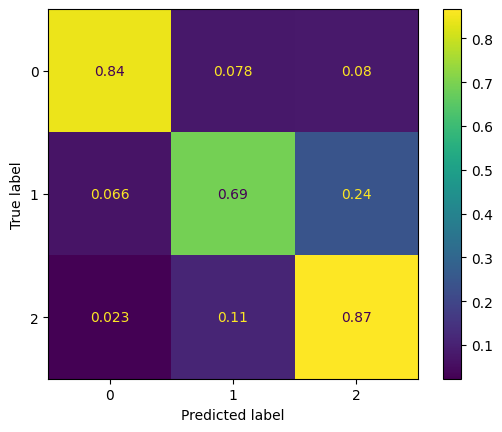

In [10]:
i=0
for tfold, (train_index, test_index) in enumerate(skf.split(X_train_over, y_train_over)):
    #모델 정의, 예측

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

    #DNN
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train.to_numpy())
    y_test = torch.LongTensor(y_test.to_numpy())

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset=TensorDataset(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=10000,shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=5000,shuffle=False)

    # 최대 Epoch을 지정합니다.
    num_epochs = 1000
    min_loss = 9999999999999
    loss_list=[]
    acc_list=[]
    # Epoch 별 훈련 및 검증을 수행합니다.
    for epoch in range(num_epochs):
        # Model Training
        # 훈련 손실과 정확도를 반환 받습니다.
        train_loss, train_acc = model_train(model, train_dataloader, loss_fn, optimizer, device)

        # 검증 손실과 검증 정확도를 반환 받습니다.
        val_loss, val_acc = model_evaluate(model, test_dataloader, loss_fn, device)   

        # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
        if val_loss < min_loss:
                print(f'[INFO] val_acc has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
                min_loss = val_loss
                torch.save(model.state_dict(), 'DNNModel.pth')

        # Epoch 별 결과를 출력합니다.
        print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
        loss_list.append(train_loss)
        acc_list.append(train_acc)
    ## 저장한 가중치 로드 후 검증 성능 측정

    # 모델에 저장한 가중치를 로드합니다.
    model.load_state_dict(torch.load('DNNModel.pth'))

    # 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
    print("{}번째 교차검증".format(tfold))
    final_loss, final_acc, y_predicted = model_test(model, test_dataloader, loss_fn, device)
    print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')   

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

#     ## 원핫 인코딩
#     y_train=pd.get_dummies(y_train)
#     y_test=pd.get_dummies(y_test)


    # LogisticRegression
    lr = LogisticRegression(solver='liblinear', random_state=0)
    lr.fit(X_train, y_train)
    linear_pred = lr.predict(X_test)
    # linear_pred = lr.predict(X_train)
    
    # RidgeClassifier
    clf = RidgeClassifier(alpha=1.0)
    clf.fit(X_train, y_train)
    ridge_pred = clf.predict(X_test)
    # ridge_pred = clf.predict(X_train)
    
    # RandomForestClassifier
    regr = RandomForestClassifier(max_depth=6, random_state=0)
    regr.fit(X_train, y_train)
    regr_pred = regr.predict(X_test)
    # regr_pred = regr.predict(X_train)
    
    # GradientBoostingClassifier
    reg = GradientBoostingClassifier(random_state=0)
    reg.fit(X_train, y_train)
    reg_pred = reg.predict(X_test)
    # reg_pred = reg.predict(X_train)
    
    # DNN 결과값 넘파이 배열로 변환
    y_predicted_t=sum(y_predicted, [])
    DNN_y_predicted=np.array(y_predicted_t)

    # 최종모델
#     lgbm = LGBMClassifier()
    CatBoost = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1')
    new_data = np.array([linear_pred.squeeze(),ridge_pred.squeeze(),regr_pred.squeeze(),reg_pred.squeeze(),DNN_y_predicted.squeeze()])
    # new_data = np.array([linear_pred,ridge_pred,regr_pred,reg_pred,DNN_y_predicted])
    print(new_data.shape)

    new_data = np.transpose(new_data)
    print(new_data.shape)

    #y_test를 파이토치에서 넘파이 배열로 변환
    y_test=np.array(y_test)
    
    #lgbm 학습하기
    CatBoost.fit(new_data,y_test)
    # lgbm.fit(new_data, y_train)
    
    #LGBMClassifier 예측하기
    CatBoost_pred = CatBoost.predict(new_data)
    # lgbm_pred = lgbm.predict(X_test)

    print('Stacking ensemble (ML+DNN):',len(lgbm_pred))
    
    
    accuracy=accuracy_score(y_test, lgbm_pred) * 100
    print("[{}]Accuracy : {}".format(tfold,accuracy))   
    #f1score
    f1 = f1_score(y_test,lgbm_pred, average='weighted')
    print("[{}]F1score : {}".format(tfold,f1))
    #precision/recall
    p_rlist=sk(y_test,lgbm_pred,average='weighted')
    print("[{}]Precision : {}".format(tfold,p_rlist[0]))
    print("[{}]Recall : {}".format(tfold,p_rlist[1]))
    print()
     #결과 배열에 넣기
    Result[tfold][0]=accuracy
    Result[tfold][1]=f1
    Result[tfold][2]=p_rlist[0]
    Result[tfold][3]=p_rlist[1]
    del accuracy
    del f1
    del p_rlist
    
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    confusion_matrix(y_test, lgbm_pred)

    cm = confusion_matrix(y_test, lgbm_pred, labels=[0,1,2],normalize="true")
    CMResult[i]=cm
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
    disp.plot()
    filename=("ConfusionMatrix_"+str(i))
    plt.savefig("./ConfusionMatrix/"+filename+".png")
    plt.show()
    
    i=i+1

In [11]:
Result_df=pd.DataFrame(Result,columns=['Accuracy','F1-Score','Precision','Recall'])
Result_df

Accuracy  F1-Score  Precision    Recall
0  64.291323  0.644102   0.648825  0.642913
1  73.557126  0.734983   0.735605  0.735571
2  76.678445  0.765977   0.777233  0.766784
3  77.856302  0.778351   0.786490  0.778563
4  59.795838  0.599320   0.611577  0.597958
5  75.323910  0.750394   0.756355  0.753239
6  75.834315  0.759083   0.768682  0.758343
7  76.968388  0.769807   0.779339  0.769684
8  76.261535  0.761860   0.768348  0.762615
9  79.972511  0.799507   0.806138  0.799725

In [12]:
Matrix=pd.DataFrame(Result_df['Accuracy'],columns=['Accuracy'])
Matrix['Accuracy']=Result_df['Accuracy']
A=[Result_df['Accuracy'].mean(),Result_df['F1-Score'].mean(),Result_df['Precision'].mean(),Result_df['Recall'].mean()]
A=pd.DataFrame(A,columns=['Accuracy'])
Matrix=pd.concat([Matrix,A])
Matrix=Matrix.transpose()
Matrix.to_excel('./PFMatrix_ensemble_final3.xlsx')

In [13]:
new_data

array([[2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       ...,
       [2, 2, 2, 2, 2],
       [0, 0, 1, 1, 2],
       [0, 0, 1, 1, 2]], dtype=int64)

In [14]:
lgbm_pred

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [15]:
y_test

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)